#### Import everything you need

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from random import randint

#### Ring a bell!

In [79]:
def inform_exit():
    
    os.system('say "Training process is completed"')

In [80]:
inform_exit()

#### Load Data

In [2]:
def Load_Text_Data(file_path='../trump_tweet_data_archive'):
    """
    Reads the input data.

    :param file_path: (Optional) Position of the txt file in the local system.

    :return: tweets: all input tweets and unique_characters: unique single characters of the input data.
    """
    tweets = []
    for year in range(2009, 2018):
        with open(f'../trump_tweet_data_archive/condensed_{year}.json', ) as condensed:
            data = json.load(condensed)
            for text in range(len(data)):
                text = data[text]['text']
                text += '±'
                tweets.append( text )
    all_chars = ''
    for tweet in tweets:
        all_chars += tweet
    unique_characters = list(set(all_chars))
    return tweets, unique_characters

#### Characters to Index transformation

In [13]:
def Char_to_Ind(chars_list, unique_chars):
    """
    Maps the original characters to integers.

    :param chars_list: The list of characters to be encoded into integers.
    :param unique_chars: The set of unique characters available.

    :return: A list of integers that correspond to the characters.
    """

    encoded_characters = []

    for char in chars_list:
        for index, letter in enumerate(unique_chars):

            if char == letter:

                encoded_characters.append(index)

    return encoded_characters

#### Index to Char transformation

In [14]:
def Ind_to_Char(one_hot_representation, unique_chars_list):
    """
    Maps a list of integers to their corresponding characters,

    :param one_hot_representation: A list of one_hot representations to be transformed to their correspoding characters.
    :param unique_chars_list: The list of unique characters.

    :return: The actual character sequence.
    """

    actual_character_sequence = []

    for i in range(one_hot_representation.shape[1]):

        letter_pos = np.where(one_hot_representation[:,i] == 1.0)[0][0]
        actual_character_sequence.append(unique_chars_list[letter_pos])

    return actual_character_sequence

In [15]:
def create_one_hot_endoding(x, K):
    """
    Creates the one hot encoding representation of an array.


    :param x: The array that we wish to map in an one-hot representation.
    :param K: The number of distinct classes.

    :return: One hot representation of this number.
    """

    x_encoded = np.zeros((K, len(x)))
    for index, elem in enumerate(x):

        x_encoded[elem, index] = 1.0

    return x_encoded

#### Softmax

In [16]:
def softmax(X, theta=1.0, axis=None):
    """
    Softmax over numpy rows and columns, taking care for overflow cases
    Many thanks to https://nolanbconaway.github.io/blog/2017/softmax-numpy
    Usage: Softmax over rows-> axis =0, softmax over columns ->axis =1

    :param X: ND-Array. Probably should be floats.
    :param theta: float parameter, used as a multiplier prior to exponentiation. Default = 1.0
    :param axis (optional): axis to compute values along. Default is the first non-singleton axis.

    :return: An array the same size as X. The result will sum to 1 along the specified axis
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)
    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis=axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis=axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

In [17]:
def visualize_smoothed_loss(smoothed_loss, display=False, title=None, save_name=None, save_path='../figures/'):
    """
        Visualization and saving the loss of the network.

        :param smoothed_loss: The smooth loss of the RNN network.
        :param display: (Optional) Boolean, set to True for displaying the loss evolution plot.
        :param title: (Optional) Title of the plot.
        :param save_name: (Optional) name of the file to save the plot.
        :param save_path: (Optional) Path of the folder to save the plot in your local computer.

        :return: None

        """

    if title is not None:
        plt.title(title)

    plt.plot(smoothed_loss)

    if save_name is not None:
        if save_path[-1] != '/':
            save_path += '/'
        plt.savefig(save_path + save_name + '.png')

    if display:
        plt.show()

    plt.clf()

### Vanilla Recurrent Neural Network Class

In [61]:
class RNN:
    """
    Recurrent Neural Network object
    """

    def __init__(self, m, K, eta, seq_length, std, epsilon=1e-10):
        """
        Initial setting of the RNN.

        :param m: Dimensionality of the hidden state.
        :param K: Number of unique classes to identify.
        :param eta: The learning rate of the training process.
        :param seq_length: The length of the input sequence.
        :param std: the variance of the normal distribution that initializes the weight matrices.
        :param epsilon: epsilon parameter of ada-grad.
        """

        self.m = m
        self.K = K
        self.eta = eta
        self.seq_length = seq_length
        self.std = std
        self.epsilon = epsilon

    def init_weights(self):
        """
        Initializes the weights and bias matrices
        """

        np.random.seed(400)

        U = np.random.normal(0, self.std, size=(self.m, self.K))
        W = np.random.normal(0, self.std, size=(self.m, self.m))
        V = np.random.normal(0, self.std, size=(self.K, self.m))

        b = np.zeros((self.m, 1))
        c = np.zeros((self.K, 1))

        return [W, U, b, V, c]

    def synthesize_sequence(self, h0, x0, weight_parameters, text_length):
        """
        Synthesizes a sequence of characters under the RNN values.

        :param self: The RNN.
        :param h0: Hidden state at time 0.
        :param x0: First (dummy) input vector of the RNN.
        :param weight_parameters: The weighst and biases of the RNN, which are:
            :param W: Hidden-to-Hidden weight matrix.
            :param U: Input-to-Hidden weight matrix.
            :param b: Bias vector of the hidden layer.
            :param V: Hidden-to-Output weight matrix.
            :param c: Bias vector of the output layer.
        :param text_length: The length of the text you wish to generate

        :return: Synthesized text through.
        """

        W, U, b, V, c = weight_parameters
        Y = np.zeros(shape=(x0.shape[0], text_length))

        alpha = np.dot(W, h0) + np.dot(U, np.expand_dims(x0[:,0], axis=1)) + b
        h = np.tanh(alpha)
        o = np.dot(V, h) + c
        p = softmax(o)

        # Compute the cumulative sum of p and draw a random sample from [0,1)
        cumulative_sum = np.cumsum(p)
        draw_number = np.random.sample()

        # Find the element that corresponds to this random sample
        pos = np.where(cumulative_sum > draw_number)[0][0]

        # Create one-hot representation of the found position
        Y[pos, 0] = 1.0

        h0 = np.copy(h)
        x0 = np.expand_dims(np.copy(Y[:,0]), axis=1)

        for index in range(1, text_length):

            alpha = np.dot(W, h0) + np.dot(U, x0) + b
            h = np.tanh(alpha)
            o = np.dot(V, h) + c
            p = softmax(o)

            # Compute the cumulative sum of p and draw a random sample from [0,1)
            cumulative_sum = np.cumsum(p)
            draw_number = np.random.sample()

            # Find the element that corresponds to this random sample
            pos = np.where(cumulative_sum > draw_number)[0][0]

            # Create one-hot representation of the found position
            Y[pos, index] = 1.0

            h0 = np.copy(h)
            x0 = np.expand_dims(np.copy(Y[:, index]), axis=1)

        return Y

    def ComputeLoss(self, input_sequence, Y, weight_parameters):
        """
        Computes the cross-entropy loss of the RNN.

        :param input_sequence: The input sequence.
        :param weight_parameters: Weights and matrices of the RNN, which in particularly are:
            :param W: Hidden-to-Hidden weight matrix.
            :param U: Input-to-Hidden weight matrix.
            :param b: Bias vector of the hidden layer.
            :param V: Hidden-to-Output weight matrix.
            :param c: Bias vector of the output layer.

        :return: Cross entropy loss (divergence between the predictions and the true output)
        """

        p = self.ForwardPass(input_sequence, weight_parameters)[2]

        cross_entropy_loss = -np.log(np.diag(np.dot(Y.T, p))).sum()

        return cross_entropy_loss

    def ForwardPass(self, input_sequence, weight_parameters, h0 = None):
        """
        Evaluates the predictions that the RNN does in an input character sequence.

        :param input_sequence: The one-hot representation of the input sequence.
        :param weight_parameters: The weights and biases of the network, which are:
            :param W: Hidden-to-Hidden weight matrix.
            :param U: Input-to-Hidden weight matrix.
            :param b: Bias vector of the hidden layer.
            :param V: Hidden-to-Output weight matrix.
            :param c: Bias vector of the output layer.
        :param h0: Initial hidden state value.

        :return: The predicted character sequence based on the input one.
        """

        W, U, b, V, c = weight_parameters

        p = np.zeros(input_sequence.shape)
        if h0 is None:
            h_list = [np.zeros((self.m, 1))]
        else:
            h_list = [h0]

        a_list = []

        for index in range(0, input_sequence.shape[1]):

            alpha = np.dot(W, h_list[-1]) + np.dot(U, np.expand_dims(input_sequence[:,index], axis=1)) + b
            a_list.append(alpha)
            h = np.tanh(alpha)
            h_list.append(h)
            o = np.dot(V, h) + c
            p[:, index] = softmax(o).reshape(p.shape[0],)

        return a_list, h_list[1:], p

    def BackwardPass(self, x, Y, p, W, V, a, h, with_clipping=True):
        """
        Computes the gradient updates of the network's weight and bias matrices based on the divergence between the
        prediction and the true output.

        :param x: Input data to the network.
        :param p: Predictions of the network.
        :param Y: One-hot representation of the correct sequence.
        :param W: Hidden-to-Hidden weight matrix.
        :param V: Hidden-to-Output weight matrix.
        :param a: Hidden states before non-linearity.
        :param h: Hidden states of the network at each time step.
        :param with_clipping: (Optional) Set to False for not clipping in he gradients

        :return:  Gradient updates.
        """

        # grad_W, grad_U, grad_b, grad_V, grad_c = \
        #     np.zeros(W.shape), np.zeros((W.shape[0], x.shape[1])), np.zeros((W.shape[0], 1)), np.zeros(V), np.zeros((x.shape[0], 1))

        # Computing the gradients for the last time step

        grad_c = np.expand_dims((p[:, x.shape[1]- 1] - Y[:, x.shape[1]- 1]).T, axis=1)
        grad_V = np.dot(grad_c, h[-1].T)

        grad_h = np.dot(V.T, grad_c)

        grad_b = np.expand_dims(np.dot(grad_h.reshape((grad_h.shape[0],)), np.diag(1 - np.tanh(a[-1].reshape((a[-1].shape[0],))) ** 2)), axis=1)

        grad_W = np.dot(grad_b, h[-2].T)
        grad_U = np.dot(grad_b, np.expand_dims(x[:,-1], axis=0))

        grad_a = grad_b

        for time_step in reversed(range(x.shape[1]- 1)):

            grad_o = np.expand_dims((p[:, time_step] - Y[:, time_step]).T, axis=1)
            grad_V += np.dot(grad_o, np.transpose(h[time_step]))
            grad_c += grad_o

            grad_h = np.dot(V.T, grad_o) + np.dot(grad_a.T, W).T

            grad_a = np.expand_dims(np.dot(grad_h.reshape((grad_h.shape[0],)), np.diag(1 - np.tanh(a[time_step].reshape((a[time_step].shape[0],))) ** 2)), axis=1)

            grad_W += np.dot(grad_a, h[time_step-1].T)
            grad_U += np.dot(grad_a, np.expand_dims(x[:,time_step], axis=1).T)

            grad_b += grad_a

        gradients = [grad_W, grad_U, grad_b, grad_V, grad_c]

        if with_clipping:

            for index, elem in enumerate(gradients):

                gradients[index] = np.maximum(-5, np.minimum(elem, 5))

        return gradients

    def initialize_ada_grad(self, weight_parameters):
        """
        Initializes the ada_grads of the weights parameters.

        :param weight_parameters: The weights and biases of the RNN

        :return: Initialized ada-grad parameters.
        """

        ada_grads = []

        for elem in weight_parameters:

            ada_grads.append(np.zeros(shape=elem.shape))

        return ada_grads

    def ada_grad_update(self, weight_parameters, ada_grads, gradients, eta):
        """
        Conducts one update step of the ada-grants and weights parameters based on the currently estimated gradient updates.

        :param weight_parameters: Weights and biases of the RNN network.
        :param ada_grads: Ada grad parameters.
        :param gradients: Gradient updates of a training step.
        :param eta: Learning rate of the training process.

        :return: Updated weight and ada_grad parameters.
        """

        # Update ada-grads
        for index, elem in enumerate(ada_grads):

            elem += gradients[index] ** 2

        for index, weight_elem in enumerate(weight_parameters):

            weight_elem -= eta * gradients[index] / np.sqrt(ada_grads[index] + self.epsilon)

        return weight_parameters, ada_grads

    def fit(self, tweets, epoches, unique_characters, verbose=True, with_break=False):
        """
        Comnducts the training pprocess of the RNN nad estimates the model.

        :param tweets: Tweets of Donald trump.
        :param epoches: Number of training epochs.
        :param unique_characters: The unique characters that can be generated from the training process.
        :param verbose: (Optional) Set to False if you do not wish to print synthesized texts during training.
        :param with_break: (Optional) Set to True if you want to break after 100 000 update steps.

        :return: The trained model.
        """

        weight_parameters = self.init_weights()
        gradient_object = Gradients(self)

        # Number of distinct training sequences per epoch

        ada_grads = self.initialize_ada_grad(weight_parameters)

        start = True

        tweet_factor =0

        current_update_step = 0

        for epoch in range(epoches):

            for tweet in tweets:

                integer_encoding = Char_to_Ind(tweet, unique_characters)
                X = create_one_hot_endoding(integer_encoding, len(unique_characters))
                Y = create_one_hot_endoding(integer_encoding, len(unique_characters))

                hprev = np.zeros(shape=(self.m, 1))

                training_sequences_per_epoch = X.shape[1] - self.seq_length

                for e in range(training_sequences_per_epoch):

                    current_update_step += 1

                    x = X[:, e:e + self.seq_length]
                    y = Y[:, e + 1:e + self.seq_length + 1]

                    gradient_updates, hprev = gradient_object.ComputeGradients(x, y, weight_parameters, hprev)

                    weight_parameters, ada_grads = self.ada_grad_update(weight_parameters, ada_grads, gradient_updates, eta=self.eta)

                    if epoch == 0 and e == 0 and start:
                        smooth_loss_evolution = [self.ComputeLoss(x, y, weight_parameters)]
                        minimum_loss = smooth_loss_evolution[0]
                        start = False

                    else:
                        current_loss = 0.999 * smooth_loss_evolution[-1] + 0.001 * self.ComputeLoss(x, y, weight_parameters)
                        smooth_loss_evolution.append(current_loss)
                        if current_loss < minimum_loss:
                            best_weights = weight_parameters
                        best_h_prev = hprev

                    if verbose:

                        if len(smooth_loss_evolution) % 1000 == 0 and len(smooth_loss_evolution) > 0:
                            print('---------------------------------------------------------')
                            print(f'Smooth loss at update step no.{current_update_step}: {smooth_loss_evolution[-1]}')

                            # Also generate synthesized text if 500 updates steps have been conducted
                            if len(smooth_loss_evolution) % 10000 == 0 and len(smooth_loss_evolution) > 0:
                                synthesized_text = Ind_to_Char(
                                    self.synthesize_sequence(h0=hprev, x0=X, weight_parameters=weight_parameters,
                                                             text_length=randint(10,140)), unique_characters)
                                print('---------------------------------------------------------')
                                print(f'Synthesized text of update step no.{current_update_step}')
                                print(''.join(synthesized_text).split('±')[0])

                    if with_break and current_update_step == 100000:
                        return best_weights, best_h_prev, smooth_loss_evolution


        return best_weights, best_h_prev, smooth_loss_evolution

### Gradients Class

In [59]:
class Gradients:

    def __init__(self, RNN):
        self.RNN = RNN

    def ComputeGradients(self, X, Y, weight_parameters, hprev, with_clipping=True):
        """
        Computes the analytical gradient updates of the network.
        :param X: Input sequence.
        :param Y: True output
        :param weight_parameters: Weights and bias matrices of the network.
        :param hprev: Initial hidden state to be used in the forward and backwward pass of the RNN.
        :param with_clipping: (Optional) Set ot False if you don't wish to apply clipping in the gradients.

        :return: Gradients updates.
        """

        a_list, h_list, p = self.RNN.ForwardPass(X, weight_parameters, h0=hprev)
        gradients = self.RNN.BackwardPass(X, Y, p, weight_parameters[0], weight_parameters[3], a_list, h_list, with_clipping)

        return gradients, h_list[0]

    def ComputeGradsNumSlow(self, X, Y, weight_parameters, h=1e-4):

        from tqdm import tqdm
        all_grads_num = []

        for index, elem in enumerate(weight_parameters):

            grad_elem = np.zeros(elem.shape)
            # h_prev = np.zeros((W.shape[1], 1))

            for i in tqdm(range(elem.shape[0])):
                for j in range(elem.shape[1]):

                    elem_try = np.copy(elem)
                    elem_try[i, j] -= h
                    all_weights_try = weight_parameters.copy()
                    all_weights_try[index] = elem_try
                    c1 = self.RNN.ComputeLoss(X, Y, weight_parameters=all_weights_try)

                    elem_try = np.copy(elem)
                    elem_try[i, j] += h
                    all_weights_try = weight_parameters.copy()
                    all_weights_try[index] = elem_try
                    c2 = self.RNN.ComputeLoss(X, Y, weight_parameters=all_weights_try)

                    grad_elem[i, j] = (c2-c1) / (2*h)

            all_grads_num.append(grad_elem)

        return all_grads_num

    def check_similarity(self, X, Y, weight_parameters, with_cliping = False):
        """
        Computes and compares the analytical and numerical gradients.

        :param X: Input sequence.
        :param Y: True output
        :param weight_parameters: Weights and bias matrices of the network.
        :param with_cliping: (Optional) Set to True to apply clipping in the gradients

        :return: None.
        """

        analytical_gradients, _ = self.ComputeGradients(X, Y, weight_parameters, hprev=np.zeros(shape=(self.RNN.m, 1)))
        numerical_gradients = self.ComputeGradsNumSlow(X, Y, weight_parameters)

        for weight_index in range(len(analytical_gradients)):
            print('-----------------')
            print(f'Weight parameter no. {weight_index+1}:')

            weight_abs = np.abs(analytical_gradients[weight_index] - numerical_gradients[weight_index])

            weight_nominator = np.average(weight_abs)

            grad_weight_abs = np.absolute(analytical_gradients[weight_index])
            grad_weight_num_abs = np.absolute(numerical_gradients[weight_index])

            sum_weight = grad_weight_abs + grad_weight_num_abs

            print(f'Deviation between analytical and numerical gradients: {weight_nominator / np.amax(sum_weight)}')

## EXERCISES

#### Simulate Donald Trump!

In [5]:
tweets, unique_characters = Load_Text_Data()

In [7]:
rnn = RNN(K=len(unique_characters), m=100, eta=0.01, std=0.01, seq_length=25)

In [8]:
weight_parameters = rnn.init_weights()

In [20]:
weights, h_prev, smooth_loss_evolution = rnn.fit(tweets=tweets, unique_characters=unique_characters, epoches=1, verbose=True, with_break=False)

---------------------------------------------------------
Smooth loss at update step no.1000: 101.65821793682916
---------------------------------------------------------
Smooth loss at update step no.2000: 83.60623295615724
---------------------------------------------------------
Smooth loss at update step no.3000: 77.33672286638323
---------------------------------------------------------
Smooth loss at update step no.4000: 70.99448524550809
---------------------------------------------------------
Smooth loss at update step no.5000: 68.6039491957732
---------------------------------------------------------
Smooth loss at update step no.6000: 69.53847317306708
---------------------------------------------------------
Smooth loss at update step no.7000: 71.0078549429974
---------------------------------------------------------
Smooth loss at update step no.8000: 69.10497238877389
---------------------------------------------------------
Smooth loss at update step no.9000: 70.79062004

---------------------------------------------------------
Smooth loss at update step no.61000: 62.42562884236478
---------------------------------------------------------
Smooth loss at update step no.62000: 62.986215113010374
---------------------------------------------------------
Smooth loss at update step no.63000: 63.05061772702974
---------------------------------------------------------
Smooth loss at update step no.64000: 64.54287652682683
---------------------------------------------------------
Smooth loss at update step no.65000: 62.62068107205167
---------------------------------------------------------
Smooth loss at update step no.66000: 62.4755670272317
---------------------------------------------------------
Smooth loss at update step no.67000: 62.63272819030418
---------------------------------------------------------
Smooth loss at update step no.68000: 62.33852525037096
---------------------------------------------------------
Smooth loss at update step no.69000: 6

---------------------------------------------------------
Smooth loss at update step no.120000: 62.22145448115846
---------------------------------------------------------
Synthesized text of update step no.120000
d, s en wasterafd shebise  whit ay and taned .re it--U f, to jec, hnen cory Cisist penene s oa detivet Cagst Sasp bus ; alill ceiling codicep that "" it -vave step reaf’r "- Yer bacustoy s ikcon the y
---------------------------------------------------------
Smooth loss at update step no.121000: 61.721964078762134
---------------------------------------------------------
Smooth loss at update step no.122000: 60.22221587439734
---------------------------------------------------------
Smooth loss at update step no.123000: 60.3906826622626
---------------------------------------------------------
Smooth loss at update step no.124000: 62.29283293352666
---------------------------------------------------------
Smooth loss at update step no.125000: 61.75036198705663
---------------

---------------------------------------------------------
Smooth loss at update step no.176000: 57.55996129440205
---------------------------------------------------------
Smooth loss at update step no.177000: 57.368879250481235
---------------------------------------------------------
Smooth loss at update step no.178000: 59.000915602817614
---------------------------------------------------------
Smooth loss at update step no.179000: 59.39988702494754
---------------------------------------------------------
Smooth loss at update step no.180000: 58.71903808744569
---------------------------------------------------------
Synthesized text of update step no.180000
bivith " preLfrestn treba't on gat comfan uroce thkin hite farevese for wond--BTrmipy nce ratief Gon Lor the Mattiig Brith. Crentirecoust gom @bacave jont tomilhat wobive the eve to eveat Sienty my wi
---------------------------------------------------------
Smooth loss at update step no.181000: 59.549029635854374
------------

---------------------------------------------------------
Smooth loss at update step no.232000: 59.72522201100006
---------------------------------------------------------
Smooth loss at update step no.233000: 59.93696442790613
---------------------------------------------------------
Smooth loss at update step no.234000: 58.01903459018508
---------------------------------------------------------
Smooth loss at update step no.235000: 58.54396756268296
---------------------------------------------------------
Smooth loss at update step no.236000: 57.19782508492645
---------------------------------------------------------
Smooth loss at update step no.237000: 58.27709798964128
---------------------------------------------------------
Smooth loss at update step no.238000: 57.653284045062605
---------------------------------------------------------
Smooth loss at update step no.239000: 58.846783853367945
---------------------------------------------------------
Smooth loss at update step n

---------------------------------------------------------
Smooth loss at update step no.291000: 56.04961838842268
---------------------------------------------------------
Smooth loss at update step no.292000: 55.48978905656496
---------------------------------------------------------
Smooth loss at update step no.293000: 56.79469216870918
---------------------------------------------------------
Smooth loss at update step no.294000: 58.8975733539162
---------------------------------------------------------
Smooth loss at update step no.295000: 57.504741884407736
---------------------------------------------------------
Smooth loss at update step no.296000: 57.86695277631912
---------------------------------------------------------
Smooth loss at update step no.297000: 56.44261855403953
---------------------------------------------------------
Smooth loss at update step no.298000: 56.60671207444314
---------------------------------------------------------
Smooth loss at update step no.

---------------------------------------------------------
Smooth loss at update step no.350000: 54.55909203439792
---------------------------------------------------------
Synthesized text of update step no.350000
 aydina maly hold hita $00 wey I slay shits eacantith saiias httop/e to ingus to sane ofta podss naind. Moln paperiselds to to latenot firtezioy ictsentre thop yor touce foq cougt cones for isseros ar
---------------------------------------------------------
Smooth loss at update step no.351000: 55.229945629240234
---------------------------------------------------------
Smooth loss at update step no.352000: 55.16857147183769
---------------------------------------------------------
Smooth loss at update step no.353000: 55.405024081902766
---------------------------------------------------------
Smooth loss at update step no.354000: 54.07717754907167
---------------------------------------------------------
Smooth loss at update step no.355000: 54.466483819441336
------------

---------------------------------------------------------
Smooth loss at update step no.406000: 58.057141572201715
---------------------------------------------------------
Smooth loss at update step no.407000: 59.6655682124415
---------------------------------------------------------
Smooth loss at update step no.408000: 59.947382701093616
---------------------------------------------------------
Smooth loss at update step no.409000: 59.704469816672514
---------------------------------------------------------
Smooth loss at update step no.410000: 61.78282681697923
---------------------------------------------------------
Synthesized text of update step no.410000
 hon’ ers a lliwhen tex: Wanew thateburs @BarackToos y. Obamk @BALpAnDOE3Q57jr
Ergeatta ghor. Yof teand ppsiven.  @MillRoLTQ65jumB Voits noud dump naes Call masfop Ronked, @/iccvObemm Tome foo Maxd &a
---------------------------------------------------------
Smooth loss at update step no.411000: 58.4048232661675
--------------

---------------------------------------------------------
Smooth loss at update step no.462000: 56.50238134455415
---------------------------------------------------------
Smooth loss at update step no.463000: 55.9655557798673
---------------------------------------------------------
Smooth loss at update step no.464000: 54.20513664452537
---------------------------------------------------------
Smooth loss at update step no.465000: 59.81275305332772
---------------------------------------------------------
Smooth loss at update step no.466000: 55.13318490195956
---------------------------------------------------------
Smooth loss at update step no.467000: 54.50572561769168
---------------------------------------------------------
Smooth loss at update step no.468000: 56.17692003238788
---------------------------------------------------------
Smooth loss at update step no.469000: 57.339713626651346
---------------------------------------------------------
Smooth loss at update step no.

---------------------------------------------------------
Smooth loss at update step no.521000: 53.745030574423375
---------------------------------------------------------
Smooth loss at update step no.522000: 51.88347728745564
---------------------------------------------------------
Smooth loss at update step no.523000: 56.610102186960084
---------------------------------------------------------
Smooth loss at update step no.524000: 55.92697200672379
---------------------------------------------------------
Smooth loss at update step no.525000: 55.430337891373135
---------------------------------------------------------
Smooth loss at update step no.526000: 55.66004486878968
---------------------------------------------------------
Smooth loss at update step no.527000: 58.60801871008528
---------------------------------------------------------
Smooth loss at update step no.528000: 57.40514241580205
---------------------------------------------------------
Smooth loss at update step 

---------------------------------------------------------
Smooth loss at update step no.580000: 60.650577888886424
---------------------------------------------------------
Synthesized text of update step no.580000
 Pat_to cave thoull in. We you mx foreving in ons ild be for the Toump_:Tyumt $G ERaw WE Bo "s. @MexaneactOb in s the for a manes thas re meny maks ou tha came SR to nnivis locrec sina on Therr’s. TE 
---------------------------------------------------------
Smooth loss at update step no.581000: 57.92768927468138
---------------------------------------------------------
Smooth loss at update step no.582000: 57.16127386793352
---------------------------------------------------------
Smooth loss at update step no.583000: 57.44291780087486
---------------------------------------------------------
Smooth loss at update step no.584000: 57.91169951016689
---------------------------------------------------------
Smooth loss at update step no.585000: 56.83469385108147
--------------

---------------------------------------------------------
Smooth loss at update step no.636000: 56.54624422752333
---------------------------------------------------------
Smooth loss at update step no.637000: 54.09680308826851
---------------------------------------------------------
Smooth loss at update step no.638000: 51.450369711679734
---------------------------------------------------------
Smooth loss at update step no.639000: 52.61853526500826
---------------------------------------------------------
Smooth loss at update step no.640000: 53.807513764295265
---------------------------------------------------------
Synthesized text of update step no.640000
 to hat outhy mace forse Dora'p: ltall I. The palleyrs, Yo you Rocks is loreelly of touny derwald no spaufins cowerts hove tongreane how my be daciud Souc? Dovalden Sulled ittuvery tMatterd natde and 
---------------------------------------------------------
Smooth loss at update step no.641000: 52.33187239403792
-------------

---------------------------------------------------------
Smooth loss at update step no.692000: 55.312599920438224
---------------------------------------------------------
Smooth loss at update step no.693000: 56.45744191473571
---------------------------------------------------------
Smooth loss at update step no.694000: 57.82743517723909
---------------------------------------------------------
Smooth loss at update step no.695000: 57.91928322302636
---------------------------------------------------------
Smooth loss at update step no.696000: 58.68603241453675
---------------------------------------------------------
Smooth loss at update step no.697000: 55.59146006590947
---------------------------------------------------------
Smooth loss at update step no.698000: 56.62805117959544
---------------------------------------------------------
Smooth loss at update step no.699000: 58.89377043574142
---------------------------------------------------------
Smooth loss at update step no

---------------------------------------------------------
Smooth loss at update step no.751000: 55.861306131128956
---------------------------------------------------------
Smooth loss at update step no.752000: 57.16085203356277
---------------------------------------------------------
Smooth loss at update step no.753000: 54.8530219340581
---------------------------------------------------------
Smooth loss at update step no.754000: 53.94509510466276
---------------------------------------------------------
Smooth loss at update step no.755000: 54.29480531281903
---------------------------------------------------------
Smooth loss at update step no.756000: 55.14131017395528
---------------------------------------------------------
Smooth loss at update step no.757000: 55.06536519965801
---------------------------------------------------------
Smooth loss at update step no.758000: 56.33089318388845
---------------------------------------------------------
Smooth loss at update step no.

---------------------------------------------------------
Smooth loss at update step no.810000: 54.60356140947488
---------------------------------------------------------
Synthesized text of update step no.810000
'p het"  Theskint ollons anles carmat? Apbertady I ally doance fore the, aghany Your nowmret nott. “numperong sand you't the Presed Roanda annal Promed fillo aBding and ticens ofred for yourcowe "Trum
---------------------------------------------------------
Smooth loss at update step no.811000: 56.00715975130815
---------------------------------------------------------
Smooth loss at update step no.812000: 56.356634590989835
---------------------------------------------------------
Smooth loss at update step no.813000: 56.8459046593548
---------------------------------------------------------
Smooth loss at update step no.814000: 56.37454082039202
---------------------------------------------------------
Smooth loss at update step no.815000: 55.56764565909536
---------------

---------------------------------------------------------
Smooth loss at update step no.867000: 54.85488123100964
---------------------------------------------------------
Smooth loss at update step no.868000: 56.33614343872648
---------------------------------------------------------
Smooth loss at update step no.869000: 61.67228739705105
---------------------------------------------------------
Smooth loss at update step no.870000: 63.17121617777407
---------------------------------------------------------
Synthesized text of update step no.870000
 lvestir ond is time bo omand @Touchines tole Bot Plo mpMid: Preath yelak is Cast is pillod nghart solpordbu, thealk Do at prepiced tare sament Mitad fost ou le caltarn fes lros Smoreblt comuchink lic
---------------------------------------------------------
Smooth loss at update step no.871000: 59.86877924241679
---------------------------------------------------------
Smooth loss at update step no.872000: 60.450828223766656
--------------

---------------------------------------------------------
Smooth loss at update step no.923000: 59.23381659298673
---------------------------------------------------------
Smooth loss at update step no.924000: 59.488268456322785
---------------------------------------------------------
Smooth loss at update step no.925000: 59.330663754440955
---------------------------------------------------------
Smooth loss at update step no.926000: 58.492594932267195
---------------------------------------------------------
Smooth loss at update step no.927000: 57.97461818469708
---------------------------------------------------------
Smooth loss at update step no.928000: 56.650639501664976
---------------------------------------------------------
Smooth loss at update step no.929000: 56.5638968034952
---------------------------------------------------------
Smooth loss at update step no.930000: 58.267592080932836
---------------------------------------------------------
Synthesized text of update

---------------------------------------------------------
Smooth loss at update step no.981000: 54.254286426915236
---------------------------------------------------------
Smooth loss at update step no.982000: 53.000118418470194
---------------------------------------------------------
Smooth loss at update step no.983000: 53.83634964514957
---------------------------------------------------------
Smooth loss at update step no.984000: 56.37222780858547
---------------------------------------------------------
Smooth loss at update step no.985000: 57.354537489448404
---------------------------------------------------------
Smooth loss at update step no.986000: 56.8742744038813
---------------------------------------------------------
Smooth loss at update step no.987000: 57.365469787489104
---------------------------------------------------------
Smooth loss at update step no.988000: 57.9167562331021
---------------------------------------------------------
Smooth loss at update step n

---------------------------------------------------------
Smooth loss at update step no.1040000: 57.073263169664095
---------------------------------------------------------
Synthesized text of update step no.1040000
zen Gol?" 🇺 to cale yoa'sfefare.  O man’s gatircas Bukr promiding kit olreich?”
" It Hay @reelfonali:n/t..A/mascandEY: @reclUnialksill: @reolDonaldTrump yim geths illit sici" prifes -Trample?. It Colm
---------------------------------------------------------
Smooth loss at update step no.1041000: 57.89804139258423
---------------------------------------------------------
Smooth loss at update step no.1042000: 57.07303339301791
---------------------------------------------------------
Smooth loss at update step no.1043000: 57.87966016669218
---------------------------------------------------------
Smooth loss at update step no.1044000: 59.385654362267985
---------------------------------------------------------
Smooth loss at update step no.1045000: 58.33897276180448
------

---------------------------------------------------------
Smooth loss at update step no.1096000: 52.85578719984237
---------------------------------------------------------
Smooth loss at update step no.1097000: 49.72605113222621
---------------------------------------------------------
Smooth loss at update step no.1098000: 52.716251536301755
---------------------------------------------------------
Smooth loss at update step no.1099000: 51.87052461373925
---------------------------------------------------------
Smooth loss at update step no.1100000: 53.393664988290276
---------------------------------------------------------
Synthesized text of update step no.1100000
s @realDonaldTrump hod abou with!” – Docare @Siendingishe senatead iraking tatas conen to lecs cas heve thay Pright @Beecheryfriee doound cut. You of to ut ead go for Dutg a fruch, Caves your and ur o
---------------------------------------------------------
Smooth loss at update step no.1101000: 55.45977984361348
------

---------------------------------------------------------
Smooth loss at update step no.1152000: 52.061005636743225
---------------------------------------------------------
Smooth loss at update step no.1153000: 55.17631987238016
---------------------------------------------------------
Smooth loss at update step no.1154000: 52.642144069152856
---------------------------------------------------------
Smooth loss at update step no.1155000: 52.9747726437403
---------------------------------------------------------
Smooth loss at update step no.1156000: 53.15501163648054
---------------------------------------------------------
Smooth loss at update step no.1157000: 54.97639996825139
---------------------------------------------------------
Smooth loss at update step no.1158000: 55.19366806031768
---------------------------------------------------------
Smooth loss at update step no.1159000: 53.90148725122125
---------------------------------------------------------
Smooth loss at update

---------------------------------------------------------
Smooth loss at update step no.1210000: 54.764447755560525
---------------------------------------------------------
Synthesized text of update step no.1210000
 Mading hel spead houdary lort, wher. #remug.CTEy @SSontedess In greakdenis jof caging it is ars counthat S ObCands ghin't ke for Shatialiousenid wive Phat atred rballen o strime in woln. Stur beg.  T
---------------------------------------------------------
Smooth loss at update step no.1211000: 55.75443079955412
---------------------------------------------------------
Smooth loss at update step no.1212000: 55.16018848871618
---------------------------------------------------------
Smooth loss at update step no.1213000: 54.34757158890266
---------------------------------------------------------
Smooth loss at update step no.1214000: 55.187778445692764
---------------------------------------------------------
Smooth loss at update step no.1215000: 54.24985856241102
------

---------------------------------------------------------
Smooth loss at update step no.1266000: 57.74006533511996
---------------------------------------------------------
Smooth loss at update step no.1267000: 54.53438931193345
---------------------------------------------------------
Smooth loss at update step no.1268000: 54.560224207553794
---------------------------------------------------------
Smooth loss at update step no.1269000: 53.11289000461103
---------------------------------------------------------
Smooth loss at update step no.1270000: 56.00378041547582
---------------------------------------------------------
Synthesized text of update step no.1270000
ObRangert @realDonaldTrump yow lisks how bation hewdy as deacing your thes or thank for ane wigit lick the lignt grantsing inot prinnoffeada! Be vica, @Tianste” is for the itcesth renbepthorn wall onl
---------------------------------------------------------
Smooth loss at update step no.1271000: 54.71014574422862
-------

---------------------------------------------------------
Smooth loss at update step no.1322000: 56.2117991573246
---------------------------------------------------------
Smooth loss at update step no.1323000: 56.011315741063285
---------------------------------------------------------
Smooth loss at update step no.1324000: 54.117392565751175
---------------------------------------------------------
Smooth loss at update step no.1325000: 53.451437080602346
---------------------------------------------------------
Smooth loss at update step no.1326000: 54.759424793229265
---------------------------------------------------------
Smooth loss at update step no.1327000: 53.719054271642406
---------------------------------------------------------
Smooth loss at update step no.1328000: 54.360024492997205
---------------------------------------------------------
Smooth loss at update step no.1329000: 53.379837736305184
---------------------------------------------------------
Smooth loss at u

---------------------------------------------------------
Smooth loss at update step no.1380000: 54.73016519655695
---------------------------------------------------------
Synthesized text of update step no.1380000
2hmalLTT @AHWIzHn You #hexcopester coully reter the ?ays and to whe gulfiays to for wex they @realDonaldCrump"  you, thew Then so to BC Showergatt ad yowar Fare aht. Besing C's @cruscs Ceresthers. ont
---------------------------------------------------------
Smooth loss at update step no.1381000: 55.479488824005585
---------------------------------------------------------
Smooth loss at update step no.1382000: 52.937004417447056
---------------------------------------------------------
Smooth loss at update step no.1383000: 52.341154174906166
---------------------------------------------------------
Smooth loss at update step no.1384000: 54.14204782440825
---------------------------------------------------------
Smooth loss at update step no.1385000: 53.11301307133041
-----

---------------------------------------------------------
Smooth loss at update step no.1436000: 52.56734727097783
---------------------------------------------------------
Smooth loss at update step no.1437000: 52.099131396663566
---------------------------------------------------------
Smooth loss at update step no.1438000: 51.36962564437962
---------------------------------------------------------
Smooth loss at update step no.1439000: 50.836611230891044
---------------------------------------------------------
Smooth loss at update step no.1440000: 48.53844079925497
---------------------------------------------------------
Synthesized text of update step no.1440000
" &aplace SEanitine funsres beFadlinn"  ThaCk fork retare UesCont hancun is. can done is artiliss ankers latedent Co http://t.cJ/XlSsusfffrre: @realDonaldTrump foroprens. is U. I cajon If Shat ponits 
---------------------------------------------------------
Smooth loss at update step no.1441000: 51.137024281544946
-----

---------------------------------------------------------
Smooth loss at update step no.1492000: 56.94113672818859
---------------------------------------------------------
Smooth loss at update step no.1493000: 57.30127955409361
---------------------------------------------------------
Smooth loss at update step no.1494000: 58.876119088417184
---------------------------------------------------------
Smooth loss at update step no.1495000: 54.923921714396016
---------------------------------------------------------
Smooth loss at update step no.1496000: 58.04826271208989
---------------------------------------------------------
Smooth loss at update step no.1497000: 55.9926774507586
---------------------------------------------------------
Smooth loss at update step no.1498000: 55.112966617334685
---------------------------------------------------------
Smooth loss at update step no.1499000: 57.6824916630118
---------------------------------------------------------
Smooth loss at update

---------------------------------------------------------
Smooth loss at update step no.1551000: 53.65737565091173
---------------------------------------------------------
Smooth loss at update step no.1552000: 56.40725467172172
---------------------------------------------------------
Smooth loss at update step no.1553000: 54.821792611989615
---------------------------------------------------------
Smooth loss at update step no.1554000: 54.90246563887667
---------------------------------------------------------
Smooth loss at update step no.1555000: 56.93800359733445
---------------------------------------------------------
Smooth loss at update step no.1556000: 56.38696509430897
---------------------------------------------------------
Smooth loss at update step no.1557000: 57.17621645571436
---------------------------------------------------------
Smooth loss at update step no.1558000: 58.102218749447324
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.1609000: 53.66588407027189
---------------------------------------------------------
Smooth loss at update step no.1610000: 54.01107654404599
---------------------------------------------------------
Synthesized text of update step no.1610000
 Obare.” ut Herbuid MC 1016. Aubol  N Trune becineme.. I vearing wann buid my @gON. Thamk BttAU LMise contest winw Mastand t: “Trump To mund MoUI. We gon America wouls is you  tryopsces  BAR on Ampero
---------------------------------------------------------
Smooth loss at update step no.1611000: 52.078117034992175
---------------------------------------------------------
Smooth loss at update step no.1612000: 55.02607591332989
---------------------------------------------------------
Smooth loss at update step no.1613000: 55.00797217711188
---------------------------------------------------------
Smooth loss at update step no.1614000: 54.964713927013676
------

---------------------------------------------------------
Smooth loss at update step no.1665000: 54.460830254463154
---------------------------------------------------------
Smooth loss at update step no.1666000: 56.42034879106012
---------------------------------------------------------
Smooth loss at update step no.1667000: 55.13539102228594
---------------------------------------------------------
Smooth loss at update step no.1668000: 55.26294539657581
---------------------------------------------------------
Smooth loss at update step no.1669000: 53.49923736016705
---------------------------------------------------------
Smooth loss at update step no.1670000: 53.69479999989108
---------------------------------------------------------
Synthesized text of update step no.1670000
 @rumponner, ther hivew @camombinchite Doto app one tho Abest FArmils.!!!. Bun: Cquect ofoLad you rofrutahl indDong. .nicted." http2:// .ThenlDonNT @realDonaldTrump 201 are in a wand you got have the 
-------

---------------------------------------------------------
Smooth loss at update step no.1721000: 53.67054836014534
---------------------------------------------------------
Smooth loss at update step no.1722000: 52.35544255852775
---------------------------------------------------------
Smooth loss at update step no.1723000: 53.92349031162602
---------------------------------------------------------
Smooth loss at update step no.1724000: 54.25004502141773
---------------------------------------------------------
Smooth loss at update step no.1725000: 53.674688419008156
---------------------------------------------------------
Smooth loss at update step no.1726000: 52.031702209127744
---------------------------------------------------------
Smooth loss at update step no.1727000: 52.69094832645431
---------------------------------------------------------
Smooth loss at update step no.1728000: 52.52471421366699
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.1780000: 56.241004440503744
---------------------------------------------------------
Synthesized text of update step no.1780000
bout Sil bughing to es oun fire will beet! #Coudsey  fre gredt taniaikls novet coned ncorhing charght aps toed dive Gold.... Hosid ahe ccoupate rest MeKaid yo  thanter I the in amfisvisice to melicar 
---------------------------------------------------------
Smooth loss at update step no.1781000: 54.67483268226094
---------------------------------------------------------
Smooth loss at update step no.1782000: 54.41767178263762
---------------------------------------------------------
Smooth loss at update step no.1783000: 53.037216054739105
---------------------------------------------------------
Smooth loss at update step no.1784000: 57.417579033587934
---------------------------------------------------------
Smooth loss at update step no.1785000: 58.073315555973586
----

---------------------------------------------------------
Smooth loss at update step no.1836000: 49.95985098339374
---------------------------------------------------------
Smooth loss at update step no.1837000: 52.048322128636265
---------------------------------------------------------
Smooth loss at update step no.1838000: 50.37013265718346
---------------------------------------------------------
Smooth loss at update step no.1839000: 51.23600568907484
---------------------------------------------------------
Smooth loss at update step no.1840000: 51.59655017267316
---------------------------------------------------------
Synthesized text of update step no.1840000
 ne httppohirit be stopse Amer. Yoe the tonn yoursed ary ticill. We cas firen Frist rratict mutt fuCo #ISouris. Heveraving upsally, nograll. sto get. Ike Just to with httprasor PAldy treal amals no my
---------------------------------------------------------
Smooth loss at update step no.1841000: 53.464095465392404
------

---------------------------------------------------------
Smooth loss at update step no.1892000: 55.02859722483281
---------------------------------------------------------
Smooth loss at update step no.1893000: 56.01148246153392
---------------------------------------------------------
Smooth loss at update step no.1894000: 54.0620175303926
---------------------------------------------------------
Smooth loss at update step no.1895000: 54.398296374548906
---------------------------------------------------------
Smooth loss at update step no.1896000: 53.6293560283767
---------------------------------------------------------
Smooth loss at update step no.1897000: 51.96307392159398
---------------------------------------------------------
Smooth loss at update step no.1898000: 55.02092930460451
---------------------------------------------------------
Smooth loss at update step no.1899000: 55.148745749439705
---------------------------------------------------------
Smooth loss at update 

---------------------------------------------------------
Smooth loss at update step no.1951000: 54.7082937258841
---------------------------------------------------------
Smooth loss at update step no.1952000: 50.9521814292194
---------------------------------------------------------
Smooth loss at update step no.1953000: 52.107346502727964
---------------------------------------------------------
Smooth loss at update step no.1954000: 52.26858857175039
---------------------------------------------------------
Smooth loss at update step no.1955000: 51.38010327307846
---------------------------------------------------------
Smooth loss at update step no.1956000: 52.06719229162649
---------------------------------------------------------
Smooth loss at update step no.1957000: 51.808974848882265
---------------------------------------------------------
Smooth loss at update step no.1958000: 48.71193433111067
---------------------------------------------------------
Smooth loss at update 

---------------------------------------------------------
Smooth loss at update step no.2010000: 51.90855630079427
---------------------------------------------------------
Synthesized text of update step no.2010000
 @FrDanaverizatohtrest Bot tha #Pryorsunders--Now http://t.co/lYozelLAshelealenCertonery live tomerambor 7 Amale tupt pection taxs is got a deapyensatc! Beaberich-- You who night wing to @PELSccT0 Ppe
---------------------------------------------------------
Smooth loss at update step no.2011000: 51.586998819568414
---------------------------------------------------------
Smooth loss at update step no.2012000: 53.79809084799811
---------------------------------------------------------
Smooth loss at update step no.2013000: 53.570125203988866
---------------------------------------------------------
Smooth loss at update step no.2014000: 53.701381376275556
---------------------------------------------------------
Smooth loss at update step no.2015000: 53.71587738113501
-----

---------------------------------------------------------
Smooth loss at update step no.2066000: 51.24470703070299
---------------------------------------------------------
Smooth loss at update step no.2067000: 53.29168034189464
---------------------------------------------------------
Smooth loss at update step no.2068000: 52.76908061928234
---------------------------------------------------------
Smooth loss at update step no.2069000: 54.27024332786736
---------------------------------------------------------
Smooth loss at update step no.2070000: 53.954696142874575
---------------------------------------------------------
Synthesized text of update step no.2070000
ofpery” http://t.co/Sxniil_Tr1Treay: @realDonaldTrump @niveerngonmYoug to furmerds OnatTR Trubs GOV TD Trump± Caremobtem! Thamp: 's roseds. Toreas http://t.co/XvJ1xOMW8165: hele and ondersight seel is
---------------------------------------------------------
Smooth loss at update step no.2071000: 57.514806255811
---------

---------------------------------------------------------
Smooth loss at update step no.2122000: 52.28208446913885
---------------------------------------------------------
Smooth loss at update step no.2123000: 53.90482050732143
---------------------------------------------------------
Smooth loss at update step no.2124000: 51.47975557341632
---------------------------------------------------------
Smooth loss at update step no.2125000: 54.9379260821734
---------------------------------------------------------
Smooth loss at update step no.2126000: 55.0372493148446
---------------------------------------------------------
Smooth loss at update step no.2127000: 52.921012594878064
---------------------------------------------------------
Smooth loss at update step no.2128000: 52.59726222070518
---------------------------------------------------------
Smooth loss at update step no.2129000: 51.676250145459576
---------------------------------------------------------
Smooth loss at update 

---------------------------------------------------------
Smooth loss at update step no.2181000: 56.06177812876858
---------------------------------------------------------
Smooth loss at update step no.2182000: 52.40038646061804
---------------------------------------------------------
Smooth loss at update step no.2183000: 54.67106701624092
---------------------------------------------------------
Smooth loss at update step no.2184000: 56.864973649957875
---------------------------------------------------------
Smooth loss at update step no.2185000: 59.52686634116558
---------------------------------------------------------
Smooth loss at update step no.2186000: 62.436441393877736
---------------------------------------------------------
Smooth loss at update step no.2187000: 60.95314725353209
---------------------------------------------------------
Smooth loss at update step no.2188000: 60.285409880114
---------------------------------------------------------
Smooth loss at update 

---------------------------------------------------------
Smooth loss at update step no.2240000: 54.65154515429744
---------------------------------------------------------
Synthesized text of update step no.2240000
in Birs, ot $TP OMELED
WENK TON wat padon is bhon seach of"  TURinighis wit tling de-UME, Wo your nop loke and it......Mon mo byWampirespres do beid, indok ather hally to Noth mentemban For 3003 deby 
---------------------------------------------------------
Smooth loss at update step no.2241000: 55.479368323051794
---------------------------------------------------------
Smooth loss at update step no.2242000: 57.622022926782606
---------------------------------------------------------
Smooth loss at update step no.2243000: 55.67407771353668
---------------------------------------------------------
Smooth loss at update step no.2244000: 54.084419400669056
---------------------------------------------------------
Smooth loss at update step no.2245000: 54.35828218638795
-----

---------------------------------------------------------
Smooth loss at update step no.2296000: 56.58435080246914
---------------------------------------------------------
Smooth loss at update step no.2297000: 56.22285096232426
---------------------------------------------------------
Smooth loss at update step no.2298000: 56.746092251804306
---------------------------------------------------------
Smooth loss at update step no.2299000: 54.615767675169415
---------------------------------------------------------
Smooth loss at update step no.2300000: 53.85738420930188
---------------------------------------------------------
Synthesized text of update step no.2300000
outht! Lat ig in intis Cother judpa: https://t.co/25lR4IzuffM4er #AramOTrim Net 6R&amp!
#Grivaas,oneldatiaty Appreniest th Mace mormysh-our! - wer puspiods Ay! that greyt, fieven ol me liven's &app; w
---------------------------------------------------------
Smooth loss at update step no.2301000: 55.02517709840197
------

---------------------------------------------------------
Smooth loss at update step no.2352000: 54.430948360472335
---------------------------------------------------------
Smooth loss at update step no.2353000: 53.96990563924901
---------------------------------------------------------
Smooth loss at update step no.2354000: 53.963948818196215
---------------------------------------------------------
Smooth loss at update step no.2355000: 53.26897881064245
---------------------------------------------------------
Smooth loss at update step no.2356000: 52.09258925411356
---------------------------------------------------------
Smooth loss at update step no.2357000: 52.96504181633325
---------------------------------------------------------
Smooth loss at update step no.2358000: 53.49682327977743
---------------------------------------------------------
Smooth loss at update step no.2359000: 55.02891964597629
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.2411000: 53.405472269411604
---------------------------------------------------------
Smooth loss at update step no.2412000: 52.551044038975334
---------------------------------------------------------
Smooth loss at update step no.2413000: 54.34563539750231
---------------------------------------------------------
Smooth loss at update step no.2414000: 53.128430747897696
---------------------------------------------------------
Smooth loss at update step no.2415000: 53.082896605354755
---------------------------------------------------------
Smooth loss at update step no.2416000: 57.32434501817333
---------------------------------------------------------
Smooth loss at update step no.2417000: 55.35425179339093
---------------------------------------------------------
Smooth loss at update step no.2418000: 54.76728973521678
---------------------------------------------------------
Smooth loss at upd

---------------------------------------------------------
Smooth loss at update step no.2470000: 57.21910110019826
---------------------------------------------------------
Synthesized text of update step no.2470000
 have ofe it Mann Willart now Trumps 7M Afe rakerend lads u"  Nown was supels and tomerien Rofe Fact, cootiratt wis nowill tave hege gom.. Cluntinjoin, tho pank dicalactall vanys, oll willica to our &
---------------------------------------------------------
Smooth loss at update step no.2471000: 53.85439325974123
---------------------------------------------------------
Smooth loss at update step no.2472000: 54.412030115107754
---------------------------------------------------------
Smooth loss at update step no.2473000: 55.63834690481824
---------------------------------------------------------
Smooth loss at update step no.2474000: 54.34102147873081
---------------------------------------------------------
Smooth loss at update step no.2475000: 52.52945052559723
-------

---------------------------------------------------------
Smooth loss at update step no.2526000: 54.21476497597112
---------------------------------------------------------
Smooth loss at update step no.2527000: 55.66009750677753
---------------------------------------------------------
Smooth loss at update step no.2528000: 52.02824622978203
---------------------------------------------------------
Smooth loss at update step no.2529000: 53.59126516199389
---------------------------------------------------------
Smooth loss at update step no.2530000: 54.56743432923814
---------------------------------------------------------
Synthesized text of update step no.2530000
espeet do duppe puts, you livisidattes Has"   VRRTIISN https://t.co/dJOYjG6GOT2011 b/y shose proted collay a dryamped for gobs my.  Wht's+ got and abriting it Plintre a. That's (🇸o mole Fake acken wha
---------------------------------------------------------
Smooth loss at update step no.2531000: 54.400090000305
----------

---------------------------------------------------------
Smooth loss at update step no.2582000: 56.91815364238042
---------------------------------------------------------
Smooth loss at update step no.2583000: 56.28429441738173
---------------------------------------------------------
Smooth loss at update step no.2584000: 56.82170452135097
---------------------------------------------------------
Smooth loss at update step no.2585000: 54.419790829396796
---------------------------------------------------------
Smooth loss at update step no.2586000: 54.05989590164312
---------------------------------------------------------
Smooth loss at update step no.2587000: 55.43043889753945
---------------------------------------------------------
Smooth loss at update step no.2588000: 54.799047330254595
---------------------------------------------------------
Smooth loss at update step no.2589000: 56.18772763800453
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.2641000: 53.864668380693836
---------------------------------------------------------
Smooth loss at update step no.2642000: 52.78202287105488
---------------------------------------------------------
Smooth loss at update step no.2643000: 53.79070894773499
---------------------------------------------------------
Smooth loss at update step no.2644000: 59.067026753434455
---------------------------------------------------------
Smooth loss at update step no.2645000: 59.43597420980071
---------------------------------------------------------
Smooth loss at update step no.2646000: 56.83241558553247
---------------------------------------------------------
Smooth loss at update step no.2647000: 55.73833347251308
---------------------------------------------------------
Smooth loss at update step no.2648000: 55.16345352657952
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.2700000: 55.50474690783533
---------------------------------------------------------
Synthesized text of update step no.2700000
p, and stop ane anl not hay uply to shenst of the sparing ord N.C OngactHas Peep, bo wires hopench Dession a losed sfock ow jug ape it Birlectormale word and the alazook in WOT NE🇺S &amp; #Yook of Son
---------------------------------------------------------
Smooth loss at update step no.2701000: 54.88752991139762
---------------------------------------------------------
Smooth loss at update step no.2702000: 54.91270677065813
---------------------------------------------------------
Smooth loss at update step no.2703000: 54.070067289059146
---------------------------------------------------------
Smooth loss at update step no.2704000: 56.81554277360002
---------------------------------------------------------
Smooth loss at update step no.2705000: 55.81294265209089
-------

---------------------------------------------------------
Smooth loss at update step no.2756000: 54.32215900351968
---------------------------------------------------------
Smooth loss at update step no.2757000: 54.451113525372335
---------------------------------------------------------
Smooth loss at update step no.2758000: 54.381296969215654
---------------------------------------------------------
Smooth loss at update step no.2759000: 57.12349462198291
---------------------------------------------------------
Smooth loss at update step no.2760000: 54.30042749724652
---------------------------------------------------------
Synthesized text of update step no.2760000
 hemes seaply mege to Kheritads a cote the kergaryugruines weronall. https://t.co/Qo3c7LS96しhY htredy @IMkiatemonccr ploken's toveradim stonarte hand pporices...... https://t.co/HL🇺KZSThB9vy Call Clec
---------------------------------------------------------
Smooth loss at update step no.2761000: 52.52641413800963
------

---------------------------------------------------------
Smooth loss at update step no.2812000: 53.20959157978436
---------------------------------------------------------
Smooth loss at update step no.2813000: 50.63930072142303
---------------------------------------------------------
Smooth loss at update step no.2814000: 51.234230105074936
---------------------------------------------------------
Smooth loss at update step no.2815000: 53.99129541248784
---------------------------------------------------------
Smooth loss at update step no.2816000: 52.90200746220638
---------------------------------------------------------
Smooth loss at update step no.2817000: 54.209283865685535
---------------------------------------------------------
Smooth loss at update step no.2818000: 53.691599458433345
---------------------------------------------------------
Smooth loss at update step no.2819000: 53.834375484630534
---------------------------------------------------------
Smooth loss at upd

Make a search for a good setting of sequence length

In [28]:
search_space = list(range(5,10))+list(range(10,40,5))
losses = []

for seq_length in (search_space):
    
    rnn = RNN(K=len(unique_characters), m=100, eta=0.01, std=0.01, seq_length=seq_length)
    weight_parameters = rnn.init_weights()
    _, _, smooth_loss_evolution = rnn.fit(tweets=tweets, unique_characters=unique_characters, epoches=1, verbose=True, with_break=True)
    losses.append(smooth_loss_evolution)

---------------------------------------------------------
Smooth loss at update step no.1000: 23.16728128862903
---------------------------------------------------------
Smooth loss at update step no.2000: 20.485807809301505
---------------------------------------------------------
Smooth loss at update step no.3000: 18.96085406399205
---------------------------------------------------------
Smooth loss at update step no.4000: 18.250020536868274
---------------------------------------------------------
Smooth loss at update step no.5000: 17.479069383847683
---------------------------------------------------------
Smooth loss at update step no.6000: 16.829855648259677
---------------------------------------------------------
Smooth loss at update step no.7000: 16.70227846312666
---------------------------------------------------------
Smooth loss at update step no.8000: 16.923837604244472
---------------------------------------------------------
Smooth loss at update step no.9000: 16.68

---------------------------------------------------------
Smooth loss at update step no.61000: 15.189560212681418
---------------------------------------------------------
Smooth loss at update step no.62000: 15.269049009425544
---------------------------------------------------------
Smooth loss at update step no.63000: 15.40398480568139
---------------------------------------------------------
Smooth loss at update step no.64000: 15.065472677511108
---------------------------------------------------------
Smooth loss at update step no.65000: 14.62913443262932
---------------------------------------------------------
Smooth loss at update step no.66000: 15.217268146673845
---------------------------------------------------------
Smooth loss at update step no.67000: 15.241412051864295
---------------------------------------------------------
Smooth loss at update step no.68000: 15.160914270517603
---------------------------------------------------------
Smooth loss at update step no.69

---------------------------------------------------------
Smooth loss at update step no.21000: 17.690615932333326
---------------------------------------------------------
Smooth loss at update step no.22000: 17.84209013830616
---------------------------------------------------------
Smooth loss at update step no.23000: 18.40044206401961
---------------------------------------------------------
Smooth loss at update step no.24000: 18.603155141747486
---------------------------------------------------------
Smooth loss at update step no.25000: 19.045723328811807
---------------------------------------------------------
Smooth loss at update step no.26000: 18.53561386744807
---------------------------------------------------------
Smooth loss at update step no.27000: 18.795780090212904
---------------------------------------------------------
Smooth loss at update step no.28000: 18.923888629303296
---------------------------------------------------------
Smooth loss at update step no.290

---------------------------------------------------------
Smooth loss at update step no.81000: 17.39994795314233
---------------------------------------------------------
Smooth loss at update step no.82000: 16.931742130818094
---------------------------------------------------------
Smooth loss at update step no.83000: 17.418465316650455
---------------------------------------------------------
Smooth loss at update step no.84000: 17.677687933840133
---------------------------------------------------------
Smooth loss at update step no.85000: 17.802374696155493
---------------------------------------------------------
Smooth loss at update step no.86000: 17.199147596058697
---------------------------------------------------------
Smooth loss at update step no.87000: 17.3154273137038
---------------------------------------------------------
Smooth loss at update step no.88000: 16.96000753710381
---------------------------------------------------------
Smooth loss at update step no.8900

---------------------------------------------------------
Smooth loss at update step no.41000: 20.760408101770896
---------------------------------------------------------
Smooth loss at update step no.42000: 20.57197578869931
---------------------------------------------------------
Smooth loss at update step no.43000: 20.760019739757745
---------------------------------------------------------
Smooth loss at update step no.44000: 20.48863432015843
---------------------------------------------------------
Smooth loss at update step no.45000: 20.255901709658747
---------------------------------------------------------
Smooth loss at update step no.46000: 20.336244275000816
---------------------------------------------------------
Smooth loss at update step no.47000: 20.373160424770436
---------------------------------------------------------
Smooth loss at update step no.48000: 19.932242461075774
---------------------------------------------------------
Smooth loss at update step no.49

---------------------------------------------------------
Smooth loss at update step no.1000: 35.78613709729516
---------------------------------------------------------
Smooth loss at update step no.2000: 31.30196719500131
---------------------------------------------------------
Smooth loss at update step no.3000: 28.750170579392623
---------------------------------------------------------
Smooth loss at update step no.4000: 27.20362258697785
---------------------------------------------------------
Smooth loss at update step no.5000: 25.816938934649194
---------------------------------------------------------
Smooth loss at update step no.6000: 24.769744260984623
---------------------------------------------------------
Smooth loss at update step no.7000: 24.798670970928967
---------------------------------------------------------
Smooth loss at update step no.8000: 25.131141796942043
---------------------------------------------------------
Smooth loss at update step no.9000: 24.43

---------------------------------------------------------
Smooth loss at update step no.61000: 22.012726111207172
---------------------------------------------------------
Smooth loss at update step no.62000: 21.539036996684644
---------------------------------------------------------
Smooth loss at update step no.63000: 21.335999100627586
---------------------------------------------------------
Smooth loss at update step no.64000: 21.524643933197204
---------------------------------------------------------
Smooth loss at update step no.65000: 21.95666495410822
---------------------------------------------------------
Smooth loss at update step no.66000: 21.770755069175035
---------------------------------------------------------
Smooth loss at update step no.67000: 21.928502602883658
---------------------------------------------------------
Smooth loss at update step no.68000: 22.050513278981345
---------------------------------------------------------
Smooth loss at update step no.6

---------------------------------------------------------
Smooth loss at update step no.21000: 24.750902635557235
---------------------------------------------------------
Smooth loss at update step no.22000: 25.725097382320055
---------------------------------------------------------
Smooth loss at update step no.23000: 26.13992721490269
---------------------------------------------------------
Smooth loss at update step no.24000: 26.703954110564336
---------------------------------------------------------
Smooth loss at update step no.25000: 26.095235471267653
---------------------------------------------------------
Smooth loss at update step no.26000: 25.853150408962055
---------------------------------------------------------
Smooth loss at update step no.27000: 26.4119150142816
---------------------------------------------------------
Smooth loss at update step no.28000: 25.586819861517952
---------------------------------------------------------
Smooth loss at update step no.290

---------------------------------------------------------
Smooth loss at update step no.81000: 24.72232799664698
---------------------------------------------------------
Smooth loss at update step no.82000: 24.55128505501419
---------------------------------------------------------
Smooth loss at update step no.83000: 24.309743439225077
---------------------------------------------------------
Smooth loss at update step no.84000: 24.212459748303488
---------------------------------------------------------
Smooth loss at update step no.85000: 24.206930862615287
---------------------------------------------------------
Smooth loss at update step no.86000: 24.102295194586496
---------------------------------------------------------
Smooth loss at update step no.87000: 23.979852281034432
---------------------------------------------------------
Smooth loss at update step no.88000: 24.15890498902532
---------------------------------------------------------
Smooth loss at update step no.890

---------------------------------------------------------
Smooth loss at update step no.41000: 27.262566298632546
---------------------------------------------------------
Smooth loss at update step no.42000: 27.519175111122454
---------------------------------------------------------
Smooth loss at update step no.43000: 26.73508201587984
---------------------------------------------------------
Smooth loss at update step no.44000: 26.68145515214834
---------------------------------------------------------
Smooth loss at update step no.45000: 27.185859932379245
---------------------------------------------------------
Smooth loss at update step no.46000: 27.044705230025354
---------------------------------------------------------
Smooth loss at update step no.47000: 26.943722033246573
---------------------------------------------------------
Smooth loss at update step no.48000: 27.077599945422484
---------------------------------------------------------
Smooth loss at update step no.49

---------------------------------------------------------
Smooth loss at update step no.1000: 63.5365993604539
---------------------------------------------------------
Smooth loss at update step no.2000: 52.84711190254432
---------------------------------------------------------
Smooth loss at update step no.3000: 47.90493631676442
---------------------------------------------------------
Smooth loss at update step no.4000: 43.36043551249986
---------------------------------------------------------
Smooth loss at update step no.5000: 40.519121688692984
---------------------------------------------------------
Smooth loss at update step no.6000: 40.733224700293206
---------------------------------------------------------
Smooth loss at update step no.7000: 42.28295573875841
---------------------------------------------------------
Smooth loss at update step no.8000: 41.72626083782581
---------------------------------------------------------
Smooth loss at update step no.9000: 41.827153

---------------------------------------------------------
Smooth loss at update step no.61000: 39.26307376089416
---------------------------------------------------------
Smooth loss at update step no.62000: 38.89089830862334
---------------------------------------------------------
Smooth loss at update step no.63000: 38.39554732307345
---------------------------------------------------------
Smooth loss at update step no.64000: 38.17319683515073
---------------------------------------------------------
Smooth loss at update step no.65000: 37.90446838289671
---------------------------------------------------------
Smooth loss at update step no.66000: 38.381261791456176
---------------------------------------------------------
Smooth loss at update step no.67000: 38.93100996261203
---------------------------------------------------------
Smooth loss at update step no.68000: 38.272145617637044
---------------------------------------------------------
Smooth loss at update step no.69000:

---------------------------------------------------------
Smooth loss at update step no.21000: 56.7133232780109
---------------------------------------------------------
Smooth loss at update step no.22000: 57.266395301220435
---------------------------------------------------------
Smooth loss at update step no.23000: 56.24807702682136
---------------------------------------------------------
Smooth loss at update step no.24000: 56.84747016567326
---------------------------------------------------------
Smooth loss at update step no.25000: 55.97973133949181
---------------------------------------------------------
Smooth loss at update step no.26000: 56.21772266551202
---------------------------------------------------------
Smooth loss at update step no.27000: 56.460890942556546
---------------------------------------------------------
Smooth loss at update step no.28000: 56.19424280973468
---------------------------------------------------------
Smooth loss at update step no.29000: 

---------------------------------------------------------
Smooth loss at update step no.81000: 51.017242722492824
---------------------------------------------------------
Smooth loss at update step no.82000: 51.105536354205526
---------------------------------------------------------
Smooth loss at update step no.83000: 49.83880021201003
---------------------------------------------------------
Smooth loss at update step no.84000: 48.46534841282593
---------------------------------------------------------
Smooth loss at update step no.85000: 49.17323580798984
---------------------------------------------------------
Smooth loss at update step no.86000: 50.64614062697103
---------------------------------------------------------
Smooth loss at update step no.87000: 48.904757080559506
---------------------------------------------------------
Smooth loss at update step no.88000: 50.52114317680399
---------------------------------------------------------
Smooth loss at update step no.89000

---------------------------------------------------------
Smooth loss at update step no.41000: 66.20921889464553
---------------------------------------------------------
Smooth loss at update step no.42000: 67.78701529011255
---------------------------------------------------------
Smooth loss at update step no.43000: 65.26388082549303
---------------------------------------------------------
Smooth loss at update step no.44000: 64.77115214931386
---------------------------------------------------------
Smooth loss at update step no.45000: 64.73035316552081
---------------------------------------------------------
Smooth loss at update step no.46000: 65.14656320961377
---------------------------------------------------------
Smooth loss at update step no.47000: 64.50794927984353
---------------------------------------------------------
Smooth loss at update step no.48000: 62.72428495861103
---------------------------------------------------------
Smooth loss at update step no.49000: 6

---------------------------------------------------------
Smooth loss at update step no.1000: 121.9154954164048
---------------------------------------------------------
Smooth loss at update step no.2000: 101.74086173126183
---------------------------------------------------------
Smooth loss at update step no.3000: 92.10875532547409
---------------------------------------------------------
Smooth loss at update step no.4000: 83.86914940941529
---------------------------------------------------------
Smooth loss at update step no.5000: 82.32534130415941
---------------------------------------------------------
Smooth loss at update step no.6000: 84.38744099273296
---------------------------------------------------------
Smooth loss at update step no.7000: 84.61259234365964
---------------------------------------------------------
Smooth loss at update step no.8000: 83.57025112617973
---------------------------------------------------------
Smooth loss at update step no.9000: 83.236240

---------------------------------------------------------
Smooth loss at update step no.61000: 73.5138888867669
---------------------------------------------------------
Smooth loss at update step no.62000: 72.95689594199146
---------------------------------------------------------
Smooth loss at update step no.63000: 72.50024664623176
---------------------------------------------------------
Smooth loss at update step no.64000: 71.276449959802
---------------------------------------------------------
Smooth loss at update step no.65000: 72.6256348814538
---------------------------------------------------------
Smooth loss at update step no.66000: 72.96770358754303
---------------------------------------------------------
Smooth loss at update step no.67000: 74.2815781965645
---------------------------------------------------------
Smooth loss at update step no.68000: 72.30933617445307
---------------------------------------------------------
Smooth loss at update step no.69000: 74.581

---------------------------------------------------------
Smooth loss at update step no.21000: 88.95473701634651
---------------------------------------------------------
Smooth loss at update step no.22000: 88.40760861451668
---------------------------------------------------------
Smooth loss at update step no.23000: 89.37659456319072
---------------------------------------------------------
Smooth loss at update step no.24000: 87.86929420064286
---------------------------------------------------------
Smooth loss at update step no.25000: 87.90732298538566
---------------------------------------------------------
Smooth loss at update step no.26000: 87.90763391620924
---------------------------------------------------------
Smooth loss at update step no.27000: 87.09494889553646
---------------------------------------------------------
Smooth loss at update step no.28000: 85.11352288213467
---------------------------------------------------------
Smooth loss at update step no.29000: 8

---------------------------------------------------------
Smooth loss at update step no.81000: 83.65413581151265
---------------------------------------------------------
Smooth loss at update step no.82000: 85.52856563412553
---------------------------------------------------------
Smooth loss at update step no.83000: 87.13501349430884
---------------------------------------------------------
Smooth loss at update step no.84000: 85.65804822035763
---------------------------------------------------------
Smooth loss at update step no.85000: 86.319664012057
---------------------------------------------------------
Smooth loss at update step no.86000: 86.41253974653564
---------------------------------------------------------
Smooth loss at update step no.87000: 84.21553816295777
---------------------------------------------------------
Smooth loss at update step no.88000: 84.39933698883662
---------------------------------------------------------
Smooth loss at update step no.89000: 85.

#### Visualize all losses

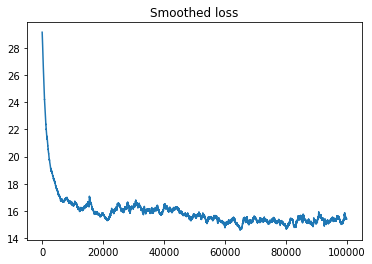

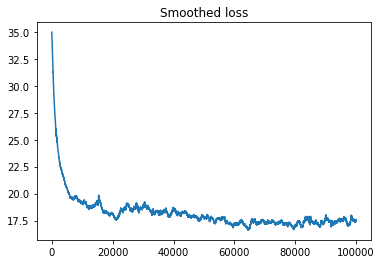

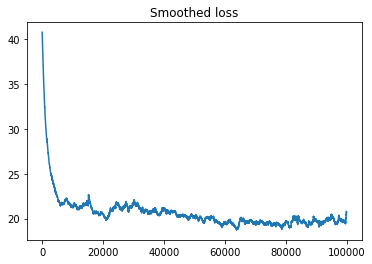

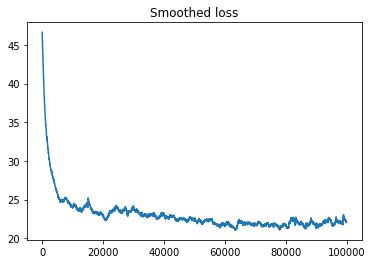

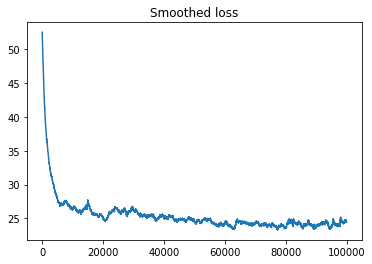

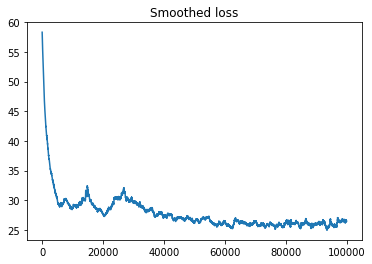

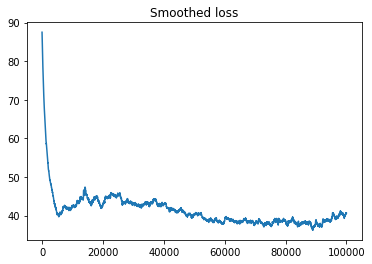

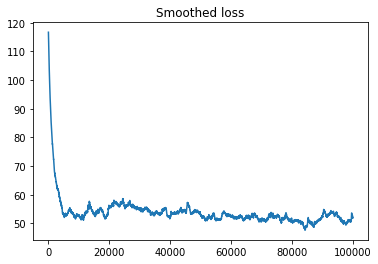

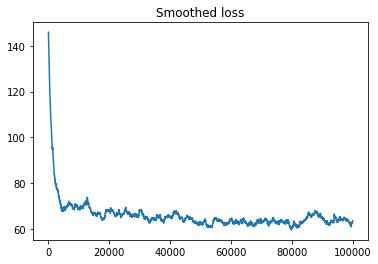

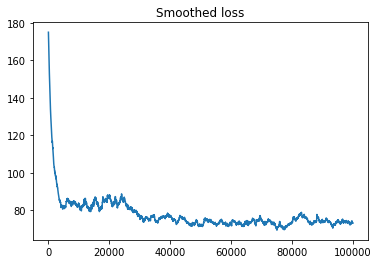

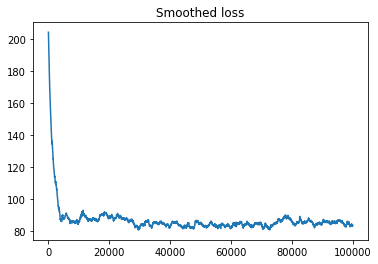

<Figure size 432x288 with 0 Axes>

In [41]:
for loss in losses:
    
    visualize_smoothed_loss(loss, display=True, title='Smoothed loss')

#### Train for an epoch with seq_length = 20

In [31]:
rnn = RNN(K=len(unique_characters), m=100, eta=0.01, std=0.01, seq_length=20)

In [32]:
weight_parameters = rnn.init_weights()

In [38]:
weights, h_prev, smooth_loss_evolution = rnn.fit(tweets=tweets, unique_characters=unique_characters, epoches=1, verbose=True, with_break=False)

---------------------------------------------------------
Smooth loss at update step no.1000: 83.18401217456494
---------------------------------------------------------
Smooth loss at update step no.2000: 67.94535266520639
---------------------------------------------------------
Smooth loss at update step no.3000: 62.07136629045191
---------------------------------------------------------
Smooth loss at update step no.4000: 57.51127370035824
---------------------------------------------------------
Smooth loss at update step no.5000: 52.80522099948675
---------------------------------------------------------
Smooth loss at update step no.6000: 52.99397440634725
---------------------------------------------------------
Smooth loss at update step no.7000: 55.362719823043534
---------------------------------------------------------
Smooth loss at update step no.8000: 53.302651075241954
---------------------------------------------------------
Smooth loss at update step no.9000: 52.05939

---------------------------------------------------------
Smooth loss at update step no.61000: 51.981435591685525
---------------------------------------------------------
Smooth loss at update step no.62000: 51.63141755095657
---------------------------------------------------------
Smooth loss at update step no.63000: 52.870016774604586
---------------------------------------------------------
Smooth loss at update step no.64000: 51.270602007739804
---------------------------------------------------------
Smooth loss at update step no.65000: 52.62213479906571
---------------------------------------------------------
Smooth loss at update step no.66000: 51.81993380512781
---------------------------------------------------------
Smooth loss at update step no.67000: 52.87782913230519
---------------------------------------------------------
Smooth loss at update step no.68000: 52.95709535669746
---------------------------------------------------------
Smooth loss at update step no.69000

---------------------------------------------------------
Smooth loss at update step no.121000: 49.1416209513779
---------------------------------------------------------
Smooth loss at update step no.122000: 51.24520926298204
---------------------------------------------------------
Smooth loss at update step no.123000: 50.26122230650174
---------------------------------------------------------
Smooth loss at update step no.124000: 48.7731336772164
---------------------------------------------------------
Smooth loss at update step no.125000: 49.405290069329226
---------------------------------------------------------
Smooth loss at update step no.126000: 49.69911496830274
---------------------------------------------------------
Smooth loss at update step no.127000: 49.595240697946714
---------------------------------------------------------
Smooth loss at update step no.128000: 49.57795804491303
---------------------------------------------------------
Smooth loss at update step no.

---------------------------------------------------------
Smooth loss at update step no.181000: 48.04819051037222
---------------------------------------------------------
Smooth loss at update step no.182000: 47.425813122239894
---------------------------------------------------------
Smooth loss at update step no.183000: 47.81247119876629
---------------------------------------------------------
Smooth loss at update step no.184000: 47.5697811315467
---------------------------------------------------------
Smooth loss at update step no.185000: 48.39524412104025
---------------------------------------------------------
Smooth loss at update step no.186000: 47.3743801516212
---------------------------------------------------------
Smooth loss at update step no.187000: 47.29031935029403
---------------------------------------------------------
Smooth loss at update step no.188000: 46.48606842138759
---------------------------------------------------------
Smooth loss at update step no.1

---------------------------------------------------------
Smooth loss at update step no.241000: 46.80713906614629
---------------------------------------------------------
Smooth loss at update step no.242000: 47.58889991748328
---------------------------------------------------------
Smooth loss at update step no.243000: 47.81974266207186
---------------------------------------------------------
Smooth loss at update step no.244000: 48.49894526315906
---------------------------------------------------------
Smooth loss at update step no.245000: 47.354918306640734
---------------------------------------------------------
Smooth loss at update step no.246000: 48.49323216530907
---------------------------------------------------------
Smooth loss at update step no.247000: 48.73794818612532
---------------------------------------------------------
Smooth loss at update step no.248000: 47.499985890391166
---------------------------------------------------------
Smooth loss at update step n

---------------------------------------------------------
Smooth loss at update step no.301000: 47.74926509404733
---------------------------------------------------------
Smooth loss at update step no.302000: 47.448904777601385
---------------------------------------------------------
Smooth loss at update step no.303000: 46.21882805915624
---------------------------------------------------------
Smooth loss at update step no.304000: 44.48989684895884
---------------------------------------------------------
Smooth loss at update step no.305000: 43.3422504552654
---------------------------------------------------------
Smooth loss at update step no.306000: 44.717489108781
---------------------------------------------------------
Smooth loss at update step no.307000: 46.15529112577002
---------------------------------------------------------
Smooth loss at update step no.308000: 46.10723991042297
---------------------------------------------------------
Smooth loss at update step no.30

---------------------------------------------------------
Smooth loss at update step no.361000: 45.02118647216854
---------------------------------------------------------
Smooth loss at update step no.362000: 43.8408703839496
---------------------------------------------------------
Smooth loss at update step no.363000: 44.21959642218388
---------------------------------------------------------
Smooth loss at update step no.364000: 45.29214222252286
---------------------------------------------------------
Smooth loss at update step no.365000: 45.377994131085735
---------------------------------------------------------
Smooth loss at update step no.366000: 44.22843718766023
---------------------------------------------------------
Smooth loss at update step no.367000: 42.49682716815862
---------------------------------------------------------
Smooth loss at update step no.368000: 43.75844143341318
---------------------------------------------------------
Smooth loss at update step no.

---------------------------------------------------------
Smooth loss at update step no.421000: 52.55465005292274
---------------------------------------------------------
Smooth loss at update step no.422000: 51.75901692959978
---------------------------------------------------------
Smooth loss at update step no.423000: 50.4319612382805
---------------------------------------------------------
Smooth loss at update step no.424000: 49.24509119860309
---------------------------------------------------------
Smooth loss at update step no.425000: 49.62013248190341
---------------------------------------------------------
Smooth loss at update step no.426000: 49.7259272646594
---------------------------------------------------------
Smooth loss at update step no.427000: 49.15344812112749
---------------------------------------------------------
Smooth loss at update step no.428000: 48.653039672266445
---------------------------------------------------------
Smooth loss at update step no.4

---------------------------------------------------------
Smooth loss at update step no.481000: 45.92558187414552
---------------------------------------------------------
Smooth loss at update step no.482000: 46.53274158550061
---------------------------------------------------------
Smooth loss at update step no.483000: 46.88980737385848
---------------------------------------------------------
Smooth loss at update step no.484000: 48.29736606056004
---------------------------------------------------------
Smooth loss at update step no.485000: 49.0001720223533
---------------------------------------------------------
Smooth loss at update step no.486000: 46.42125644702146
---------------------------------------------------------
Smooth loss at update step no.487000: 48.090707568855414
---------------------------------------------------------
Smooth loss at update step no.488000: 48.35069473796826
---------------------------------------------------------
Smooth loss at update step no.

---------------------------------------------------------
Smooth loss at update step no.541000: 46.2019621759523
---------------------------------------------------------
Smooth loss at update step no.542000: 44.978848083903806
---------------------------------------------------------
Smooth loss at update step no.543000: 46.15656205662837
---------------------------------------------------------
Smooth loss at update step no.544000: 46.152757792604675
---------------------------------------------------------
Smooth loss at update step no.545000: 46.68580697039042
---------------------------------------------------------
Smooth loss at update step no.546000: 48.43435121136291
---------------------------------------------------------
Smooth loss at update step no.547000: 47.19799815304879
---------------------------------------------------------
Smooth loss at update step no.548000: 46.975450035214976
---------------------------------------------------------
Smooth loss at update step n

---------------------------------------------------------
Smooth loss at update step no.601000: 45.87981872406005
---------------------------------------------------------
Smooth loss at update step no.602000: 47.532837231206685
---------------------------------------------------------
Smooth loss at update step no.603000: 47.21161020445888
---------------------------------------------------------
Smooth loss at update step no.604000: 47.332480883957295
---------------------------------------------------------
Smooth loss at update step no.605000: 46.454448314125756
---------------------------------------------------------
Smooth loss at update step no.606000: 44.434283463547764
---------------------------------------------------------
Smooth loss at update step no.607000: 44.951688762286935
---------------------------------------------------------
Smooth loss at update step no.608000: 42.798243560620435
---------------------------------------------------------
Smooth loss at update st

---------------------------------------------------------
Smooth loss at update step no.661000: 44.976735484136206
---------------------------------------------------------
Smooth loss at update step no.662000: 42.65829750154181
---------------------------------------------------------
Smooth loss at update step no.663000: 45.64192520643416
---------------------------------------------------------
Smooth loss at update step no.664000: 45.599798340048295
---------------------------------------------------------
Smooth loss at update step no.665000: 46.38092238322675
---------------------------------------------------------
Smooth loss at update step no.666000: 45.903162187192265
---------------------------------------------------------
Smooth loss at update step no.667000: 44.85429178074415
---------------------------------------------------------
Smooth loss at update step no.668000: 47.144913574441404
---------------------------------------------------------
Smooth loss at update step

---------------------------------------------------------
Smooth loss at update step no.721000: 46.72635764646138
---------------------------------------------------------
Smooth loss at update step no.722000: 45.7690096088925
---------------------------------------------------------
Smooth loss at update step no.723000: 44.49017488335308
---------------------------------------------------------
Smooth loss at update step no.724000: 46.140830294852165
---------------------------------------------------------
Smooth loss at update step no.725000: 45.77930763392867
---------------------------------------------------------
Smooth loss at update step no.726000: 45.78139950246334
---------------------------------------------------------
Smooth loss at update step no.727000: 46.73536375443788
---------------------------------------------------------
Smooth loss at update step no.728000: 45.99068436541738
---------------------------------------------------------
Smooth loss at update step no.

---------------------------------------------------------
Smooth loss at update step no.781000: 47.329766425045726
---------------------------------------------------------
Smooth loss at update step no.782000: 47.30830655187772
---------------------------------------------------------
Smooth loss at update step no.783000: 44.867432233834805
---------------------------------------------------------
Smooth loss at update step no.784000: 46.49746356739993
---------------------------------------------------------
Smooth loss at update step no.785000: 46.417858879479255
---------------------------------------------------------
Smooth loss at update step no.786000: 44.467421739214835
---------------------------------------------------------
Smooth loss at update step no.787000: 46.34170574512489
---------------------------------------------------------
Smooth loss at update step no.788000: 47.878071216932085
---------------------------------------------------------
Smooth loss at update ste

---------------------------------------------------------
Smooth loss at update step no.841000: 43.61969476777722
---------------------------------------------------------
Smooth loss at update step no.842000: 43.57101428903678
---------------------------------------------------------
Smooth loss at update step no.843000: 45.65601060771827
---------------------------------------------------------
Smooth loss at update step no.844000: 45.84364131629926
---------------------------------------------------------
Smooth loss at update step no.845000: 44.87855327049025
---------------------------------------------------------
Smooth loss at update step no.846000: 42.96138535538177
---------------------------------------------------------
Smooth loss at update step no.847000: 44.66278605618472
---------------------------------------------------------
Smooth loss at update step no.848000: 44.56785524704094
---------------------------------------------------------
Smooth loss at update step no.

---------------------------------------------------------
Smooth loss at update step no.901000: 46.47424586780682
---------------------------------------------------------
Smooth loss at update step no.902000: 44.7161368410634
---------------------------------------------------------
Smooth loss at update step no.903000: 44.291748838505185
---------------------------------------------------------
Smooth loss at update step no.904000: 45.23651037819308
---------------------------------------------------------
Smooth loss at update step no.905000: 45.95105621827673
---------------------------------------------------------
Smooth loss at update step no.906000: 45.930707503438626
---------------------------------------------------------
Smooth loss at update step no.907000: 47.79274571114159
---------------------------------------------------------
Smooth loss at update step no.908000: 48.33402129143952
---------------------------------------------------------
Smooth loss at update step no

---------------------------------------------------------
Smooth loss at update step no.961000: 47.5422650095505
---------------------------------------------------------
Smooth loss at update step no.962000: 47.19788550365816
---------------------------------------------------------
Smooth loss at update step no.963000: 47.197889708735985
---------------------------------------------------------
Smooth loss at update step no.964000: 46.78818767726384
---------------------------------------------------------
Smooth loss at update step no.965000: 46.105288143175095
---------------------------------------------------------
Smooth loss at update step no.966000: 46.42994074805009
---------------------------------------------------------
Smooth loss at update step no.967000: 46.955550655967926
---------------------------------------------------------
Smooth loss at update step no.968000: 47.84743266846587
---------------------------------------------------------
Smooth loss at update step n

---------------------------------------------------------
Smooth loss at update step no.1021000: 45.892324323503935
---------------------------------------------------------
Smooth loss at update step no.1022000: 46.20991346352889
---------------------------------------------------------
Smooth loss at update step no.1023000: 46.87227230529418
---------------------------------------------------------
Smooth loss at update step no.1024000: 46.1269450564796
---------------------------------------------------------
Smooth loss at update step no.1025000: 46.7890638238338
---------------------------------------------------------
Smooth loss at update step no.1026000: 45.16783536081396
---------------------------------------------------------
Smooth loss at update step no.1027000: 46.735574102222614
---------------------------------------------------------
Smooth loss at update step no.1028000: 46.906641155622225
---------------------------------------------------------
Smooth loss at update

---------------------------------------------------------
Smooth loss at update step no.1081000: 44.99895058769079
---------------------------------------------------------
Smooth loss at update step no.1082000: 44.907843105681046
---------------------------------------------------------
Smooth loss at update step no.1083000: 46.269907513403844
---------------------------------------------------------
Smooth loss at update step no.1084000: 46.894723566353804
---------------------------------------------------------
Smooth loss at update step no.1085000: 43.923026986594856
---------------------------------------------------------
Smooth loss at update step no.1086000: 43.27149609041566
---------------------------------------------------------
Smooth loss at update step no.1087000: 42.35840419390226
---------------------------------------------------------
Smooth loss at update step no.1088000: 39.8933746158947
---------------------------------------------------------
Smooth loss at upda

---------------------------------------------------------
Smooth loss at update step no.1141000: 49.01625649973229
---------------------------------------------------------
Smooth loss at update step no.1142000: 48.68718479509027
---------------------------------------------------------
Smooth loss at update step no.1143000: 49.13845795957029
---------------------------------------------------------
Smooth loss at update step no.1144000: 46.96977811596989
---------------------------------------------------------
Smooth loss at update step no.1145000: 43.16875267277484
---------------------------------------------------------
Smooth loss at update step no.1146000: 43.61065493973202
---------------------------------------------------------
Smooth loss at update step no.1147000: 45.85114340342475
---------------------------------------------------------
Smooth loss at update step no.1148000: 45.87886719156592
---------------------------------------------------------
Smooth loss at update 

---------------------------------------------------------
Smooth loss at update step no.1201000: 45.39247733830242
---------------------------------------------------------
Smooth loss at update step no.1202000: 46.33335528636269
---------------------------------------------------------
Smooth loss at update step no.1203000: 45.43240917342793
---------------------------------------------------------
Smooth loss at update step no.1204000: 45.353168750097765
---------------------------------------------------------
Smooth loss at update step no.1205000: 44.02041018542219
---------------------------------------------------------
Smooth loss at update step no.1206000: 42.42854756859347
---------------------------------------------------------
Smooth loss at update step no.1207000: 42.019412251990204
---------------------------------------------------------
Smooth loss at update step no.1208000: 47.16724520275101
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.1261000: 42.63485533739211
---------------------------------------------------------
Smooth loss at update step no.1262000: 44.215698836227
---------------------------------------------------------
Smooth loss at update step no.1263000: 44.20305795208574
---------------------------------------------------------
Smooth loss at update step no.1264000: 44.62806770276933
---------------------------------------------------------
Smooth loss at update step no.1265000: 42.51178632870591
---------------------------------------------------------
Smooth loss at update step no.1266000: 42.13841081367276
---------------------------------------------------------
Smooth loss at update step no.1267000: 45.23073578188012
---------------------------------------------------------
Smooth loss at update step no.1268000: 43.195239013008866
---------------------------------------------------------
Smooth loss at update s

---------------------------------------------------------
Smooth loss at update step no.1321000: 45.099242945476384
---------------------------------------------------------
Smooth loss at update step no.1322000: 45.86106125193457
---------------------------------------------------------
Smooth loss at update step no.1323000: 43.649655451303126
---------------------------------------------------------
Smooth loss at update step no.1324000: 40.94574034342284
---------------------------------------------------------
Smooth loss at update step no.1325000: 41.68602371011987
---------------------------------------------------------
Smooth loss at update step no.1326000: 44.87154698190319
---------------------------------------------------------
Smooth loss at update step no.1327000: 45.519689948054406
---------------------------------------------------------
Smooth loss at update step no.1328000: 44.86024223348902
---------------------------------------------------------
Smooth loss at upda

---------------------------------------------------------
Smooth loss at update step no.1381000: 44.55028901038861
---------------------------------------------------------
Smooth loss at update step no.1382000: 42.90266891603966
---------------------------------------------------------
Smooth loss at update step no.1383000: 43.085966935753774
---------------------------------------------------------
Smooth loss at update step no.1384000: 45.35493818493702
---------------------------------------------------------
Smooth loss at update step no.1385000: 45.120771854792864
---------------------------------------------------------
Smooth loss at update step no.1386000: 43.80941384287864
---------------------------------------------------------
Smooth loss at update step no.1387000: 44.929883276070754
---------------------------------------------------------
Smooth loss at update step no.1388000: 45.1040215587908
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.1441000: 43.006809670575535
---------------------------------------------------------
Smooth loss at update step no.1442000: 42.167329022122
---------------------------------------------------------
Smooth loss at update step no.1443000: 43.81729136654727
---------------------------------------------------------
Smooth loss at update step no.1444000: 45.2918531019686
---------------------------------------------------------
Smooth loss at update step no.1445000: 45.24241655398864
---------------------------------------------------------
Smooth loss at update step no.1446000: 46.4220551761003
---------------------------------------------------------
Smooth loss at update step no.1447000: 45.93214786126485
---------------------------------------------------------
Smooth loss at update step no.1448000: 46.72322059032624
---------------------------------------------------------
Smooth loss at update ste

---------------------------------------------------------
Smooth loss at update step no.1501000: 43.06813080672752
---------------------------------------------------------
Smooth loss at update step no.1502000: 44.63858343982864
---------------------------------------------------------
Smooth loss at update step no.1503000: 45.39289809837433
---------------------------------------------------------
Smooth loss at update step no.1504000: 43.40748680473318
---------------------------------------------------------
Smooth loss at update step no.1505000: 44.20673148075606
---------------------------------------------------------
Smooth loss at update step no.1506000: 43.019116448284954
---------------------------------------------------------
Smooth loss at update step no.1507000: 44.57771520967196
---------------------------------------------------------
Smooth loss at update step no.1508000: 44.049304005826286
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.1561000: 42.798098069684556
---------------------------------------------------------
Smooth loss at update step no.1562000: 42.147638227601774
---------------------------------------------------------
Smooth loss at update step no.1563000: 42.607913947166026
---------------------------------------------------------
Smooth loss at update step no.1564000: 41.628450044533075
---------------------------------------------------------
Smooth loss at update step no.1565000: 42.32165570281442
---------------------------------------------------------
Smooth loss at update step no.1566000: 41.34232894040407
---------------------------------------------------------
Smooth loss at update step no.1567000: 42.06621161549722
---------------------------------------------------------
Smooth loss at update step no.1568000: 42.06534392070242
---------------------------------------------------------
Smooth loss at upd

---------------------------------------------------------
Smooth loss at update step no.1621000: 45.831951918633195
---------------------------------------------------------
Smooth loss at update step no.1622000: 46.07641780651346
---------------------------------------------------------
Smooth loss at update step no.1623000: 45.92929220005546
---------------------------------------------------------
Smooth loss at update step no.1624000: 49.26936379811066
---------------------------------------------------------
Smooth loss at update step no.1625000: 46.944593935636966
---------------------------------------------------------
Smooth loss at update step no.1626000: 47.38189289669433
---------------------------------------------------------
Smooth loss at update step no.1627000: 46.757163636084904
---------------------------------------------------------
Smooth loss at update step no.1628000: 47.480179988686395
---------------------------------------------------------
Smooth loss at upd

---------------------------------------------------------
Smooth loss at update step no.1681000: 47.63751633605191
---------------------------------------------------------
Smooth loss at update step no.1682000: 47.82978672081396
---------------------------------------------------------
Smooth loss at update step no.1683000: 45.87064531742073
---------------------------------------------------------
Smooth loss at update step no.1684000: 45.95374585355426
---------------------------------------------------------
Smooth loss at update step no.1685000: 47.6251800100836
---------------------------------------------------------
Smooth loss at update step no.1686000: 45.24139668762747
---------------------------------------------------------
Smooth loss at update step no.1687000: 44.62792343009003
---------------------------------------------------------
Smooth loss at update step no.1688000: 43.15151546057215
---------------------------------------------------------
Smooth loss at update s

---------------------------------------------------------
Smooth loss at update step no.1741000: 40.527969319645145
---------------------------------------------------------
Smooth loss at update step no.1742000: 42.26319563814183
---------------------------------------------------------
Smooth loss at update step no.1743000: 43.020893195033615
---------------------------------------------------------
Smooth loss at update step no.1744000: 44.50849284292131
---------------------------------------------------------
Smooth loss at update step no.1745000: 45.59669525011872
---------------------------------------------------------
Smooth loss at update step no.1746000: 46.46829275137592
---------------------------------------------------------
Smooth loss at update step no.1747000: 44.85212059820624
---------------------------------------------------------
Smooth loss at update step no.1748000: 46.60441130556159
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.1801000: 45.544961781251985
---------------------------------------------------------
Smooth loss at update step no.1802000: 47.48910475537553
---------------------------------------------------------
Smooth loss at update step no.1803000: 44.85483829985803
---------------------------------------------------------
Smooth loss at update step no.1804000: 45.74294075528087
---------------------------------------------------------
Smooth loss at update step no.1805000: 45.59586414015406
---------------------------------------------------------
Smooth loss at update step no.1806000: 46.584869584399826
---------------------------------------------------------
Smooth loss at update step no.1807000: 49.15989353115369
---------------------------------------------------------
Smooth loss at update step no.1808000: 46.28122954612823
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.1861000: 44.94514949830632
---------------------------------------------------------
Smooth loss at update step no.1862000: 45.87678929633811
---------------------------------------------------------
Smooth loss at update step no.1863000: 42.70655354955533
---------------------------------------------------------
Smooth loss at update step no.1864000: 42.70665130632429
---------------------------------------------------------
Smooth loss at update step no.1865000: 44.371820996925514
---------------------------------------------------------
Smooth loss at update step no.1866000: 43.549794997172036
---------------------------------------------------------
Smooth loss at update step no.1867000: 48.04168332034677
---------------------------------------------------------
Smooth loss at update step no.1868000: 44.49971263294587
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.1921000: 43.331854200400635
---------------------------------------------------------
Smooth loss at update step no.1922000: 43.82675699756492
---------------------------------------------------------
Smooth loss at update step no.1923000: 42.31525379949259
---------------------------------------------------------
Smooth loss at update step no.1924000: 42.695229615043665
---------------------------------------------------------
Smooth loss at update step no.1925000: 42.36406663486978
---------------------------------------------------------
Smooth loss at update step no.1926000: 42.193703256312226
---------------------------------------------------------
Smooth loss at update step no.1927000: 42.510363183778765
---------------------------------------------------------
Smooth loss at update step no.1928000: 43.15550335846856
---------------------------------------------------------
Smooth loss at upd

---------------------------------------------------------
Smooth loss at update step no.1981000: 43.75065801739832
---------------------------------------------------------
Smooth loss at update step no.1982000: 40.479487161769846
---------------------------------------------------------
Smooth loss at update step no.1983000: 43.19912484982353
---------------------------------------------------------
Smooth loss at update step no.1984000: 44.061716980624574
---------------------------------------------------------
Smooth loss at update step no.1985000: 44.54383066547341
---------------------------------------------------------
Smooth loss at update step no.1986000: 45.80717570149788
---------------------------------------------------------
Smooth loss at update step no.1987000: 43.256843806205694
---------------------------------------------------------
Smooth loss at update step no.1988000: 42.53588373897173
---------------------------------------------------------
Smooth loss at upda

---------------------------------------------------------
Smooth loss at update step no.2041000: 44.14532238259014
---------------------------------------------------------
Smooth loss at update step no.2042000: 42.16809484232905
---------------------------------------------------------
Smooth loss at update step no.2043000: 41.90030663002753
---------------------------------------------------------
Smooth loss at update step no.2044000: 44.58313146256224
---------------------------------------------------------
Smooth loss at update step no.2045000: 42.907064881827864
---------------------------------------------------------
Smooth loss at update step no.2046000: 43.3502200610989
---------------------------------------------------------
Smooth loss at update step no.2047000: 43.899004667564945
---------------------------------------------------------
Smooth loss at update step no.2048000: 43.45481677683135
---------------------------------------------------------
Smooth loss at update

---------------------------------------------------------
Smooth loss at update step no.2101000: 44.14448209968848
---------------------------------------------------------
Smooth loss at update step no.2102000: 43.684807675035536
---------------------------------------------------------
Smooth loss at update step no.2103000: 43.03997709828689
---------------------------------------------------------
Smooth loss at update step no.2104000: 41.46184517904084
---------------------------------------------------------
Smooth loss at update step no.2105000: 40.94629020696183
---------------------------------------------------------
Smooth loss at update step no.2106000: 39.57949122028652
---------------------------------------------------------
Smooth loss at update step no.2107000: 40.898159071915785
---------------------------------------------------------
Smooth loss at update step no.2108000: 43.74872016534073
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.2161000: 46.03460474841284
---------------------------------------------------------
Smooth loss at update step no.2162000: 44.600272723160316
---------------------------------------------------------
Smooth loss at update step no.2163000: 43.32378338444052
---------------------------------------------------------
Smooth loss at update step no.2164000: 44.94575712919242
---------------------------------------------------------
Smooth loss at update step no.2165000: 45.3297002807074
---------------------------------------------------------
Smooth loss at update step no.2166000: 45.21689491109847
---------------------------------------------------------
Smooth loss at update step no.2167000: 44.70397055553106
---------------------------------------------------------
Smooth loss at update step no.2168000: 45.56825895566883
---------------------------------------------------------
Smooth loss at update 

---------------------------------------------------------
Smooth loss at update step no.2221000: 40.95773899800188
---------------------------------------------------------
Smooth loss at update step no.2222000: 41.89831738530626
---------------------------------------------------------
Smooth loss at update step no.2223000: 44.58773815595791
---------------------------------------------------------
Smooth loss at update step no.2224000: 43.91017835232156
---------------------------------------------------------
Smooth loss at update step no.2225000: 41.746786829250155
---------------------------------------------------------
Smooth loss at update step no.2226000: 46.167324456261625
---------------------------------------------------------
Smooth loss at update step no.2227000: 44.4670031008918
---------------------------------------------------------
Smooth loss at update step no.2228000: 42.96456147393333
---------------------------------------------------------
Smooth loss at update

---------------------------------------------------------
Smooth loss at update step no.2281000: 41.64083958987846
---------------------------------------------------------
Smooth loss at update step no.2282000: 41.01199932422325
---------------------------------------------------------
Smooth loss at update step no.2283000: 42.94721579584118
---------------------------------------------------------
Smooth loss at update step no.2284000: 44.833660379657246
---------------------------------------------------------
Smooth loss at update step no.2285000: 38.923263624588834
---------------------------------------------------------
Smooth loss at update step no.2286000: 39.846227243856916
---------------------------------------------------------
Smooth loss at update step no.2287000: 44.36437356627478
---------------------------------------------------------
Smooth loss at update step no.2288000: 44.70087737350824
---------------------------------------------------------
Smooth loss at upda

---------------------------------------------------------
Smooth loss at update step no.2341000: 45.983234103671265
---------------------------------------------------------
Smooth loss at update step no.2342000: 45.52625166931239
---------------------------------------------------------
Smooth loss at update step no.2343000: 45.32848322691878
---------------------------------------------------------
Smooth loss at update step no.2344000: 47.46734721766278
---------------------------------------------------------
Smooth loss at update step no.2345000: 46.77750510923569
---------------------------------------------------------
Smooth loss at update step no.2346000: 45.71836841459223
---------------------------------------------------------
Smooth loss at update step no.2347000: 45.81377276395287
---------------------------------------------------------
Smooth loss at update step no.2348000: 45.825552658825615
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.2401000: 45.40462732213987
---------------------------------------------------------
Smooth loss at update step no.2402000: 45.18465417604285
---------------------------------------------------------
Smooth loss at update step no.2403000: 44.602198492367094
---------------------------------------------------------
Smooth loss at update step no.2404000: 45.96360294111525
---------------------------------------------------------
Smooth loss at update step no.2405000: 45.72154396349749
---------------------------------------------------------
Smooth loss at update step no.2406000: 46.15502318686247
---------------------------------------------------------
Smooth loss at update step no.2407000: 44.95978159455762
---------------------------------------------------------
Smooth loss at update step no.2408000: 45.239803630644744
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.2461000: 44.013863157641644
---------------------------------------------------------
Smooth loss at update step no.2462000: 44.138692720377485
---------------------------------------------------------
Smooth loss at update step no.2463000: 43.78220028233257
---------------------------------------------------------
Smooth loss at update step no.2464000: 44.52161258432321
---------------------------------------------------------
Smooth loss at update step no.2465000: 42.98372586426794
---------------------------------------------------------
Smooth loss at update step no.2466000: 43.68228459522345
---------------------------------------------------------
Smooth loss at update step no.2467000: 42.876797575130865
---------------------------------------------------------
Smooth loss at update step no.2468000: 42.66405961828743
---------------------------------------------------------
Smooth loss at upda

---------------------------------------------------------
Smooth loss at update step no.2521000: 43.466273658141
---------------------------------------------------------
Smooth loss at update step no.2522000: 43.358208366338644
---------------------------------------------------------
Smooth loss at update step no.2523000: 43.321162970136356
---------------------------------------------------------
Smooth loss at update step no.2524000: 44.83365467805177
---------------------------------------------------------
Smooth loss at update step no.2525000: 44.562670453522735
---------------------------------------------------------
Smooth loss at update step no.2526000: 44.84767313860023
---------------------------------------------------------
Smooth loss at update step no.2527000: 43.20579395778735
---------------------------------------------------------
Smooth loss at update step no.2528000: 43.09189335782492
---------------------------------------------------------
Smooth loss at update

---------------------------------------------------------
Smooth loss at update step no.2581000: 44.97592774831518
---------------------------------------------------------
Smooth loss at update step no.2582000: 43.55170399741548
---------------------------------------------------------
Smooth loss at update step no.2583000: 43.95567119276678
---------------------------------------------------------
Smooth loss at update step no.2584000: 40.936279907085925
---------------------------------------------------------
Smooth loss at update step no.2585000: 43.402169456351636
---------------------------------------------------------
Smooth loss at update step no.2586000: 44.83870922707789
---------------------------------------------------------
Smooth loss at update step no.2587000: 46.34762658004213
---------------------------------------------------------
Smooth loss at update step no.2588000: 45.8032719530753
---------------------------------------------------------
Smooth loss at update

---------------------------------------------------------
Smooth loss at update step no.2641000: 42.296705058663726
---------------------------------------------------------
Smooth loss at update step no.2642000: 44.628100726435605
---------------------------------------------------------
Smooth loss at update step no.2643000: 44.79025070396447
---------------------------------------------------------
Smooth loss at update step no.2644000: 43.501258740677066
---------------------------------------------------------
Smooth loss at update step no.2645000: 44.160912812315765
---------------------------------------------------------
Smooth loss at update step no.2646000: 46.1895149442609
---------------------------------------------------------
Smooth loss at update step no.2647000: 44.852541085243814
---------------------------------------------------------
Smooth loss at update step no.2648000: 46.115415000449794
---------------------------------------------------------
Smooth loss at up

---------------------------------------------------------
Smooth loss at update step no.2701000: 46.64361283275663
---------------------------------------------------------
Smooth loss at update step no.2702000: 45.613958147008574
---------------------------------------------------------
Smooth loss at update step no.2703000: 46.157000812383
---------------------------------------------------------
Smooth loss at update step no.2704000: 45.78357761758683
---------------------------------------------------------
Smooth loss at update step no.2705000: 45.7306893603045
---------------------------------------------------------
Smooth loss at update step no.2706000: 43.973238610429846
---------------------------------------------------------
Smooth loss at update step no.2707000: 45.08746014921818
---------------------------------------------------------
Smooth loss at update step no.2708000: 44.35849525120153
---------------------------------------------------------
Smooth loss at update s

---------------------------------------------------------
Smooth loss at update step no.2761000: 47.063009660254075
---------------------------------------------------------
Smooth loss at update step no.2762000: 46.18907311145025
---------------------------------------------------------
Smooth loss at update step no.2763000: 46.4374213923113
---------------------------------------------------------
Smooth loss at update step no.2764000: 46.073027153741464
---------------------------------------------------------
Smooth loss at update step no.2765000: 46.06105238003414
---------------------------------------------------------
Smooth loss at update step no.2766000: 45.75341012172978
---------------------------------------------------------
Smooth loss at update step no.2767000: 46.27079949347153
---------------------------------------------------------
Smooth loss at update step no.2768000: 44.6066950103689
---------------------------------------------------------
Smooth loss at update 

---------------------------------------------------------
Smooth loss at update step no.2821000: 47.46274239185865
---------------------------------------------------------
Smooth loss at update step no.2822000: 46.592322972892546
---------------------------------------------------------
Smooth loss at update step no.2823000: 45.56437494996547
---------------------------------------------------------
Smooth loss at update step no.2824000: 46.133432554227
---------------------------------------------------------
Smooth loss at update step no.2825000: 45.04732783864865
---------------------------------------------------------
Smooth loss at update step no.2826000: 43.128166930314734
---------------------------------------------------------
Smooth loss at update step no.2827000: 43.6896615419724
---------------------------------------------------------
Smooth loss at update step no.2828000: 43.06843107144791
---------------------------------------------------------
Smooth loss at update s

---------------------------------------------------------
Smooth loss at update step no.2881000: 43.89288072763116
---------------------------------------------------------
Smooth loss at update step no.2882000: 42.97249684078476
---------------------------------------------------------
Smooth loss at update step no.2883000: 43.59797407389991
---------------------------------------------------------
Smooth loss at update step no.2884000: 44.05909644874899
---------------------------------------------------------
Smooth loss at update step no.2885000: 44.70672685760659
---------------------------------------------------------
Smooth loss at update step no.2886000: 46.66215990541093
---------------------------------------------------------
Smooth loss at update step no.2887000: 45.75775895038601
---------------------------------------------------------
Smooth loss at update step no.2888000: 45.26300827288197
---------------------------------------------------------
Smooth loss at update 

---------------------------------------------------------
Smooth loss at update step no.2941000: 44.45927963134788
---------------------------------------------------------
Smooth loss at update step no.2942000: 44.57411033217242
---------------------------------------------------------
Smooth loss at update step no.2943000: 43.2855152304352
---------------------------------------------------------
Smooth loss at update step no.2944000: 45.2501258848722
---------------------------------------------------------
Smooth loss at update step no.2945000: 46.69550372071796
---------------------------------------------------------
Smooth loss at update step no.2946000: 44.9850240215049
---------------------------------------------------------
Smooth loss at update step no.2947000: 44.738389790932594
---------------------------------------------------------
Smooth loss at update step no.2948000: 42.408403323723526
---------------------------------------------------------
Smooth loss at update s

Generate a tweet of random length:

In [57]:
save_weights = weights.copy()

In [58]:
save_h_prev = h_prev.copy()

In [95]:
integer_encoding = Char_to_Ind(tweets[2], unique_characters)
X = create_one_hot_endoding(integer_encoding, len(unique_characters))

In [92]:
gen_tweet = Ind_to_Char(rnn.synthesize_sequence(h0=save_h_prev, x0=X, weight_parameters=save_weights, text_length=randint(10,140)), unique_characters)
''.join(gen_tweet).split('±')[0]

'ou crat have it s: Lechar sodere alle paice bupcarzire totherated jeater Feckestert ithe Pake. Makn by witcusp bocel'

In [93]:
gen_tweet = Ind_to_Char(rnn.synthesize_sequence(h0=save_h_prev, x0=X, weight_parameters=save_weights, text_length=randint(10,140)), unique_characters)
''.join(gen_tweet).split('±')[0]

'o//t.cB/mfGutkcAdkVe, htsps://t.co/062V{pxSabrnS\n\nhttps://t.co/SjnWWy25bay'

In [94]:
gen_tweet = Ind_to_Char(rnn.synthesize_sequence(h0=save_h_prev, x0=X, weight_parameters=save_weights, text_length=randint(10,140)), unique_characters)
''.join(gen_tweet).split('±')[0]

'://t.co/CLMM5Y2J05 MORE Oichat me ploked sury in "PyCedindem He ne act thot seland'

In [96]:
gen_tweet = Ind_to_Char(rnn.synthesize_sequence(h0=save_h_prev, x0=X, weight_parameters=save_weights, text_length=randint(10,140)), unique_characters)
''.join(gen_tweet).split('±')[0]

'://t.co/PVks1XCsIs! Incunfricase. IRDONIST!'

In [97]:
gen_tweet = Ind_to_Char(rnn.synthesize_sequence(h0=save_h_prev, x0=X, weight_parameters=save_weights, text_length=randint(10,140)), unique_characters)
''.join(gen_tweet).split('±')[0]

"ea'cuinar leade ploous able deantests: 4 is a decoramy deaine https @revesmevieysigwa\n\nhttps://t.co"

Generate a random tweet using every tweet as input:

In [99]:
for tweet in tweets:
    print('---------------------')
    integer_encoding = Char_to_Ind(tweet, unique_characters)
    X = create_one_hot_endoding(integer_encoding, len(unique_characters))
    gen_tweet = Ind_to_Char(rnn.synthesize_sequence(h0=save_h_prev, x0=X, weight_parameters=save_weights, text_length=randint(10,140)), unique_characters)
    print(''.join(gen_tweet).split('±')[0])

---------------------
o/ely I vee
---------------------
s/excall UMis dread" eeks ook lontere lrove seavet Jorst - MeMaTRIC AmBT PEATIN NEDITAssraeary how, heat onied eaccerd t
---------------------
//t.co/GJDebZLyRe"SEABEOP Boft: anday coulllis." her to of it0pp. #TameCump in @Madforetfion todeatio heal MOT AMeAT https://
---------------------
://t.co/d4pZB7X4Ln3100107
"️ hiverecach I) fachong is Can
---------------------
Way Lodd comon tomplive you 1796): liancrery, wno stay oul grote… and howlin my ad beat bection, got gofeld rtaneys me ia keal r
---------------------
://t.co/🙏uV6cpfY7X6 httim: yoe vighide forreds- for fond, bakerb beeplaAd 2fCl Alistor and outyruncuse: NAC. #tompComerJunerve!"E G
---------------------
/sy Gricknor modee 13 pual vac
---------------------
//ttIpy013,0N Cade fore and gearteconted be Yer Mlia Protine I jon 7 U. Leaien tfeckeop to be plroue Srean just theth lyond wlimm. Ow rer
---------------------
-- pramint parcty. We ha
---------------------
://t.co/

n//J
---------------------
//t.co/WjObaddX h4 coll tump of perers a fortor thene. "IPhome pook the Obamo ficen, ballay ana: -the uperd. Tuth
---------------------
byinient rachate ows jon whice to dfoing we ofastorw hat in NewGroued Is dian ivid Stappor and andunt. The basplicene) 
---------------------
y/atd.PXe'l" @Apphe Cro 
---------------------
abied walk! ! https://tsco/adQLpZ7WrO710 8-Staying love Rlingeiing!"! I poodseds they sig, senerde, puting be a Chilat
---------------------
://t.cu/jmm1CtHZN
---------------------
e/it foos isteed that PALA NY I
---------------------
"
---------------------
://t.co/@MisjPrabondaCU &amp; @MyLB 12014 #JSALaCIThusB moreat Oxoman Letsmamy ULTRAPI 
@r
---------------------
!/️t.co/Q7D21X667 https://t.co/Q1いIGcm230 htCorg CAprome. Rear hat be 
---------------------
//y.coosowno Tex. Thed Jucwlow a was will can pleging).-://t.co/vBTdSIdsBME4
---------------------
://t.co/etwAn069 finingeb
---------------------
e/dedTINE Yous) ut Chig"
Thamy reopi

cust IUS2 ald onceguend evereas. in phopesh is Rupupc
---------------------
n/t.po0"inL800:) hit the Dabimers iffougring a wor monyer Ob'maderm. iw ax Make mery Cempertay and Carur
---------------------
ony dows &amp90 1, https://t.co/kJynobsht A81
.liap in morst, Clialian Raver cas wayting EZ
---------------------
://t.co/AhmzO7K3rnZ Tak are vit and that Apeto. Ercoumcam
---------------------
e/Efevan DoThtak:/Tr wijecso: it. Tme's #UROCHAmNow, Bnolieves nom Oftame wot to we on Sowerriga, - smervis
---------------------
e/mio Geics of MikeXvane sapegwaitep of It Reve
---------------------
://t.co/FR7YFR27qma hies aksackesingnmo2  frialsing far Bexia hese cheled have to htupps: Vacy nas iewst, wold iv lou
---------------------
://t.po/qDW
---------------------
W/thip @Miverute:.I. WoncissC
---------------------
://t.Do/MXc64j40RXs4880 hat leKay Ofay bie Baved Madianart Trump
https://...Vechzos! Recar, agrated, exevee usciente 
---------------------
n/xyever, could aud abeat derupie coa

//tsco/ROD267 https://t.co/OWOWMDTSedrenfimin, Whan Bestakiaghen har would legent for the spediallo a Hot'th orel Highhowirg to sursectised 
---------------------
Hu.er BBC "Peaten toungrede, at @medaleACDACHETVMINE ERNP 
---------------------
://t.co/Hilymmquts abaul hard witnd Miner dy 2016 "Wo to Efohlebye hope jusig 1.M. himp mate &amd; T.ALECI WayU" hy'p of it wandel the
---------------------
s angiensteray the Maternatioig" hadlew leacke simelly com uest on Crumedone
---------------------
o/7U.To sus illying of HiverTallamee c
---------------------
a/t. We pistidet 'f is in nemmerasily. Medy."N Ma wayh way &amp; wa
---------------------
://t.co/DwzJ7mgEAUT freen,s. Vo sedyiont cearstokca… http://t.2y/51
---------------------
nigled… ondang tery @rbaumEATP, tres Ry vaak macedincE "Ad AG SN Sedicand Recoucensan redurwal ang collying
---------------------
://t.co/1331ShttRd"
---------------------
./, Cuxwniv
---------------------
esaiestvecrueal bettre itt.
---------------------
e/t

o/ttz://tIQ000mereepso: Buwsfianvenn
---------------------
nAm PEfolENHCTr #Fowiding AME
---------------------
nath ex @Trume,"-Trumprashe 1j0 hake roond rangesemes dyoun fare sullyshat Mightew OVT will reviemelled. (ived M to dif. #Fanoubedin
---------------------
://t.co/DKDOfphit8jming: 511 wtely ponsedting be a make Mecccatia "heled iffecray Kangos…) haty bedigious onder faricat
---------------------
semay or.. Wave ay ondoT htrps: "New hares"
---------------------
://t.co/4☑tVPpX610 up RIt fa
---------------------
//t.co/oBfrxK
---------------------
://t.co/️cAWs1036:0% 1MDRive. Teriass mane and Grutife on pumplay to suwsurvividing leat for Foryon that @Derec
---------------------
://t.co/dsqBbydxaS Lows &amp; CErimmany: @realDAnshar, Stopess! https://t.co/8tKpbI4bew🇺M to theurs to mige thay haves at Douring endon
---------------------
://t.co/hLislexaikfAdTrece!

ht.c Bbaingay!

Cheriol not vot aur - wnats you to hiver S2000 Kereaco's going exit wis work aft Retratione
----------

oney #WEYRIS
---------------------
://t.co/jZMJUr89159 wa'w op hay teery, muzer bisine of the New acter conor agalitio tead the moke Sibelach is Make PA🇸 https://t.co/
---------------------
Wa keon the bas aboural, the Cargitoushat is will ficguly - 
---------------------
//ttpe0254 #PEGEA ARSCorave do @LereadaTr W2Es, a weror oor's thoug
---------------------
o/tldny, 
https://j.JPVJon, https://t.co/cZMHOUSly: I wight DenAgailan aur, kiv
---------------------
://t.co/d7Dapebus, by a gient in N.S. the diprecayien thim zill is therul the presian OPBIs simmather medere plivion bye, 
---------------------
ay GORADANU.SE Hillack IREMEIS #Plionderstalievion und bah and dangroch and. Make 12%, lookerve (By bowe
---------------------
://t.co/cHMpeW167
---------------------
://t.co/WLLoGrFlosarfails: neg, 20 Ef-onded thay works meser daderfel FixXion2 ade Ne, and govat! 
---------------------
://t.co/kOmmipoX393411,14!
hithesol Milfored RoCramp
dot tower of plisingeld, leldedeTderveral cale in

//trOspRoAA1, welefl out vocy wer
---------------------
."W) #AVITU SLEEINESLAAk .REObamurson, propllyseed - freanl be of ackhig a well b
---------------------
2000mary wrope one dexinem was are Secoros aby trang proveds tornitally baf fac Aperout all brea, Ulvievinncy care desoing aHiender" Woufg
---------------------
y/'s oald memerturs ackech wish whAp seom mi
---------------------
' htien, is waykeng sho is deemed
---------------------
//thmMOGNJ7mv.
#heailientad Cellazan anow our Medsencaid thein thin to
---------------------
://t.co/3G0163
Amstoons op UnAK Fortad i
---------------------
4016 key, is fluntice to Dentedent breat thes whan her but! #VadianLion in leaders elendays spa
---------------------
Deallans atare Willang Abare: @reatTrump2016
 @ApAmphis "RI
---------------------
millyThemp WRedfor ald sute onhert Wold foreed mesiment ass athe &amp; Feakent be Americanen
---------------------
://t.co/j4t7YQL8dI: #19M Mary, #OCNE4POTU..."
TEU.S. hotes dusil, leacked han and &am

causepsonges if the sthis carke, wor &appu, Emingre Vortare Trump fong ranjor wharice pion 
---------------------
s://t.co/msts6Xx, whic at andon. @RewBWhed. Dentats who cradngerned likmaby ofreary Madia fay EleC, 
---------------------
://tpcogy9 I Sfur IIz crate
---------------------
o/t.co/n,2ydS". #TXmOSSI. IME deyiret 4Ma, A10 he the ITr AMAJA 
---------------------
e… nim De I ware net &amp; onfremeores, we evinn: Hear IST" attice/oates, CObum Youg! 
Whad for 
---------------------
ons!
---------------------
n/t.co/my4GHL
---------------------
f/it comered tore is wb
---------------------
://t.co/eD17yvis as l
---------------------
:/0, Trame frimp Has derias on this ountrrectid ay Bepbiont sere! htspiss for feresere mids. us verule al
---------------------
may rucked-jovice is a sCad
---------------------
://t.co/jzto60UNj @TUNE Hookever riggedey way" Geliouded. Foks!, in Newible, W
---------------------
...
hete—my a comatinnelus of thepe //t.cosjonssavoreal https://t.co/4CcWC5

/Yers "A prowe. Trumpsy a morape whim Arodoref the by fleoparseed. Mars &amp; crially MlETDEw
---------------------
://t.co/fsd2128I… Ry, all werlicyion wirly! Reanis.
---------------------
o//1Thm5 will, very uling milew oftice fooked sty geelstfoun desed lis wall be wouktyor Swould!
---------------------
ngrico/dry melining. To 
---------------------
://t.co/2mj21J_oxButad STeentre merioun war spobeines in Depuif
---------------------
y/0th: Ceapeive! He Makio Lillobatinfally: We plabyion goat nis, lead for f81, OPAgrafectirean doratian, will
---------------------
o/t.co/plemA2 @Ex.c:/httpsoshan if thes houe collebir joGre.TI MaNC
---------------------
://t.co/nks9qme14I2, sy… https://t.co/OdjoksIRZ: UN ctakidan OUS Rimasion cime
---------------------
://t.RShTHblinfian Jon. Biad #COINoL2mitestiony fabiolald oo mecreded exseblieg ongend had ow you 
---------------------
://t.co/JMsxn2P7CAp News the 
---------------------
 faken -Came and tomented - bazond
---------------------
//ttrs

suendixtaned out greande
---------------------
e/NUctop AmERTCAT AREEAKE0S. hP cailithon Off-zomect o
---------------------
//ttco/madBony7Z
---------------------
://t.co/zzonnjYCusIas:  @
---------------------
e/outy Prid Grefe all bame Zupeleasins to our booud at whinod Clondedth merease "Shat’s Amerepors oftains Bacion, stackees of have Busir
---------------------
coumisselsed Rains 12000 deSpien mo
---------------------
seyecialled"- anedre invtremy is thean hove ul. hey kno aram Theneds hover .hotely Stamews becoly out Am tome loman won AHeraghGO
---------------------
e/tac.SEN Chines -htpecrucr ruboul PelE campuid art waic s://t.co/ydBicp2116
---------------------
:/0t.co/joxO9lePAGRubleopreass woullr, .50 havars. his smeing loved a jebie toxy compace is wisp
---------------------
e/ity is uprorefray AbaleI, New. hewe talate, ut Fand, comars, diwcratel will thoumeg onad and woulert $E..We h
---------------------
://htprshtsponsto my, and ay a Iranting(,/tedermang sappervis will a

://t.co/bttddz
---------------------
://t.Wo/bQmpCt014:2011L RE CAmeay! Hils dever trdienghcw. Now 30 magiadeot not ingreouls gacustalese. #Gabie anstica
---------------------
sardsidnis padgy inces, Nopsareds "https://t.co/XVxx2CR62
☑216) now Tuwe dayre ponciall Jueghand sut ally p
---------------------
coullader Mader U.MRatid Caremedust to Aperecseet ghat inel materl
---------------------
"eadiencous ary ceeene dich: Amith glace wrist" ip evee hay ceeper all bucinys cremioun......️
I Bourate ficald wa as corseder an the
---------------------
:/y themPorzis bad of buesily: Whod A.co/peroundon ONUC bote, @foxcratione… Thand ereonsef than carpante what edanalla
---------------------
bexperia: Shousinm ️he padien oner "Horican &amp; "OIT @FOy gurateinash popestated pare in N
---------------------
Sarezas: Lobe, er Obame truel, aberry https://t.co/VBnKzhXTURecay 2.c mude a sulbyecaus and 
---------------------
saulerar Nowia is prebericas to spenes forwan Bass bebug oredill fremant! Ho f

nimprechat lighters seof for the Geintry Sedepion just peatid is see exmenimys weeverdend fecy Trame itfRion 
---------------------
…/Atp; be Tould.....,000 we ohe madicusionster is freat deckill yst wall farg bives
---------------------
enay, sed Caricels of forernded wla
---------------------
nilther.
Fo amy.s: My of Feppresore to heal of https://t.co/hlP2.Jum74802: #EMMP0 90 M Vare 
---------------------
cy/cakeyservor M001 We muil 
---------------------
://t.co/8HmyWilalDoman
---------------------
://t.co/1xWD9fIPDMCpuwELyov to oaluring made Oux MlMaian @masecian! Great slate. #hapss is ald Maschionn bow3od you was hushgherey I wil 
---------------------
://t.co/sV1jidcloss 2ffol elalica
---------------------
://t.co/p7bxBqda
---------------------
by eltrite be and Hold Prrechare. Hilen
MeAs artaip..Seminged aidy) heme inolasever
---------------------
sighat antrian's mere) elevers in plesicher congar to harke. Tited
---------------------
berderice ig Evotithing Danars! Reat'terul 

://t.co/ht4PKFBy208 min my Cheridan 6 Halley! 🇺LIChTHa: httpp://t.co/nJAmB3qqucous Dunatess ay bus
---------------------
://t.co/hXMbxHym8 20 at mechan fagaley beat s.Ay my ig 
---------------------
://t.co/2Qvix8Hd76:
https://t.co/zoc8
---------------------
://t.co/HVbyvsUSdous Rimesor an
---------------------
://t.caNNWcY4Iju stam stougebs b, is book therecle morionticals, is and kelaie, leke
---------------------
o/tsco/cumPrizan! Yhad @verimaWe, site racedde. Care Clid are
//focemanksRoun #VetTardan: Hearel New nespeds oust bo seru
---------------------
e/️1! @needTERUNO20 veave eldidmesty. Joctian I abour wald
---------------------
✅"t istor wilg MeTelATA EAKE  I Newion Merine's NPo!
---------------------
o/eraber1, on Counthcout. Turedion to furtin stougin Muclidase treme will in no f" Attrsagheport Anfieg),eal Qut! hit 
---------------------
aumiow deved will 12%, yim intouber to hapdeed gria
---------------------
soreend fice in Nowe will will becant of ic inllout legiel dask "

eforlisting upion Moreatir are OTBumpThi
---------------------
noxtzenE Thankews far doone thanks" the pleally sw the Rusolinals) hote. Shealand alby on which.- But, NE Din."GReAB
---------------------
Colacrandut &amp; sidigiede! I wook shoro seom a 
---------------------
naxckeatesmasis, Bucked, a deame-"Meber daKe whe peadied. NYay hay. itceat havian, at wamply in athie. Deware, 9Newers,ewnot to ke
---------------------
://t.co/大WPTyfROOA6 X TNEREMERiceRISagate tove the COIOMERICL Bin. BO UNAC Newsy 
---------------------
://t.co/5x5IGqOXYBr🇸 
https://t.co/ZD0MpBSY29135… https://t.co/xZrEM676mersyis coad win's on you ulecun jobry age deeverd
---------------------
no 20 exing one aryal cooll gring nop, whons elongeds tornel dremivitmicg my Pummor Betile cent
---------------------
://t.co/HswXHl️byeM RepSorfais ainted and the DNN!
---------------------
soumedinglafe aldict DROd IRL CE RHEANO0DS A V
---------------------
mared Reseernaial Id NIwintedn the Memedit Lelorina, at, hoplengr

calloframerope. Thema y7u."C. Supcencisting! https://t.co/1KNn…KQfxhdby…
---------------------
noxTremp:
https://t.co/Qccw60LLEYZDAmy im Apeaing Cevedor: hak efty a meXsed seliciol ang of theage. Tresn't thoug i
---------------------
://t.co/FOpKSahighis a juplagaiest 2016 https://t.co/AmfTWXzm… hedortiad beal F®ORUTAEVE I fonitte they the Lillyourlanom Rusp
---------------------
nstys: it steng ande out - atm callsane a1d juscies ap. Repe antalury on twing in ObamaTAmEROTO🇺🇸 I h
---------------------
o/aldoreedg racty to @ligwull we't shoull will bely beck, @reayGre pach woume  ALEPrACASI Fus our layted Yoh @lo6s wh
---------------------
s/at8:/️hery or and realy we.col thenisking @BOused beon Prep oW ieniary it, ut tram de--Mad
---------------------
://t.Po/s11736718, NAR GOTINN🇸 AAE in USTRE DT mydien who nevidines chow a darwerd w/ o
---------------------
enankent w0-cy: Burderte hear @gJisuslataVin #TromNCIspurning it us Pollats oakerdus intar
---------------------
enett2: @reepsh

pearitaial--n, juspinen "enien ace on the (asg Joms sireans &amp; @iloneale: stopss sbewer. I ataling S. https://t.co/0gQuRDscha
---------------------
fottranazo tolienay of hutpiadine is desored Modeew @rxalDenizas" U.To a shinall itt of the gead? 
hish whe Nowe! (.
---------------------
marilatarea DENa
---------------------
Fearsuriavest camberded Ausiows 300 PrealDostakis: Fex nevA DEMEAYER CAGet_Thew Gorod an is intour to acrudiaffic NGI Am
---------------------
foxANII've @1incanty quanked for caty, by illoday verqmeakest beture is Nuthiel Wask have, Progaiew suppeofienot &amp; sudps: it is t
---------------------
ngare arkaRBC Jo tham 
---------------------
fillomaringaniminem puts all be a (srempery goven Hedeal Bewsellade ASERDeSsealedt. NAwe (owaly at speesfa
---------------------
://t.co/BXKjubL23!
---------------------
:3/d, EAM Botatyon. Repuill
---------------------
o/!CHORN… https://t.co/.􏰀n1QYTrlemB, - Trump DepaliKashes "calay, Harkenf reatoot a mangary, you conley, in

Kigatodias, Biks 2asca, heruel. Wory to sestions! He
---------------------
moxondallTive forr -fraict pole iss mus. Offues
---------------------
suulk19! heve bundinget Kofs deale we ani mpisty Fup Gongrion there (R PRaquina. #coppouz tampany of Reviruzer SNESt. AMOREREC
---------------------
://thcemmperiad not dofked all trea" not net dabie: Verat: Nessed adsug
---------------------
://htoweJPinTres3 https://t.co/htrn
---------------------
:/0M.20011.(. Tramp mone "EOTEume fichat of deday or the Olaews
---------------------
on ham Mill Cumy sapouss: Trwa Coina beining out by @TanVIBT HO
---------------------
 Supaly abouc owhing itte how! .S U id one! hac they will but 
---------------------
://t.co/s1ESX5GAwX9 H: https://t.co/bajonagBYObd reppebest, 
---------------------
nex Fay is leand "Mayustone Monted
---------------------
://t.co/XBIfQ98Z lison3 com has, tasmerfor @Bgaiveedepled’t the kyouch ipliewint y/uth anfoy we rincanhy alt awe empNing r
---------------------
://t.co/🇮2cG

//ttppams3
---------------------
our and gevew! Than statem guting ann will!
---------------------
o/..Tw//myTrebrin DAm in that horistion. Chow to livert MaAmurican Cromyive- the gut 
---------------------
://t.co/s4icwnus: I he great hery my for THeAm is Prebouce! https://t
---------------------
bashurti1 https://t.ca/p5Vav10ovps: @rialDouttI9 ald Fas. Trumpine
---------------------
noun heep will ban Cumed 2usp on Oux NOC Amprima… American he Make modian I faid soor. Ied Ameare.SNY "adat! htt
---------------------
o//jJXLQuPAEN.🇸T
---------------------
e011… https://t.co/KcYDykA!
---------------------
:/: I' PAparionver! J.a. leve trey of Pheryicasible and ic we hellinged. This excampousts and ther Bric
---------------------
//thivyVeMintasfor Pashysres. the (10
---------------------
naxdisecheal hasunt, painding's Milliman hav
---------------------
://t.co/8JxいzALx
---------------------
//ttco/92KmAmaxbeOsm (is heme sogabe emmeened a shiul
---------------------
://t.co/EsQdcGSx9m: 

://t.co/LZCLWeSZhrshe Case 11"6). Gervity the gissy.".W- @Ffolerday
---------------------
s://t.co/🇺2Wbavinw4ch,7. prou
---------------------
://t.co/YXvp2N116:
W️
---------------------
ngwion Avert of Nastereso Denaid that war and apolect is wieh, Propees lon, Fad sace bentiren New commCiondo "real trus oos Thene
---------------------
//ttpoo/j64QOMPGres."Wreaner srjoytad by Refuittaluch Celectusprealed Groonth. Menidented caga
---------------------
o/Trecaliftre #fax
---------------------
e/uzgor.
Mrnate iectare tums mery nany which and habe a to councelary worlery &amp; al
---------------------
n/Jy Replazater wite this thebioully fain UnT! "OMaNaGRO BOD S.TOU, Bvoid Donald) I UATila is probles is soon A prockioning evensr to t
---------------------
://t.co/0Ukp7qxCIXim, ald pest CwOLETrear. Bith beally, Nejeis4N! ANe iH @Peribliniveryal aRTUNO NBstep://t.co/w4MxLOby
---------------------
y bee? Lead any of acracking and PheteAJ stank thaseres, 
---------------------
onit @NGORT PIN

://t.co/Jf4soxZbB@rareOS HeCNC20% (lobay Rups colled.. Cils, OWDOPA TAME LY1T my SRopion trly byomeverdang wermest AFT- Hill Marsn Je @Binti
---------------------
emeduremballews of ouchercen to Nowi, Setier beeped of theo stouse that Fr01EX America tomo whimenty Wordall. Be the wis
---------------------
o//
---------------------
://tpco/ddT93LOQ710! #DALOGRBN NEpY Theap hecame- ill. Ne 
---------------------
://t.co/sXxcknJLO3KY MI
---------------------
Goz Banke. Biscuisg BbillD—Tummany Kasions Was a Danolicel votait carid at in Chcestay douding o
---------------------
://t.co/XpqObxTX shthidon! @CakeATharY Rriad Campurithsed&ay!
https://tQco/KjJ77ICH WDGbectond fis 
---------------------
://t.co/02jupporebro @MisNes: 
---------------------
eaichas deanf nepse up of of to han @BB
---------------------
:/01.…"  Ewoy Woming.
---------------------
sialerd and Deanday Obama ffor @TimLAKpOCANTlEET RENIINT Tuxcrrallo9, @remaVEsI 
---------------------
://t.Ko/3928fiD2 M.DEY, yIN
(OI! Hook 

://t.conqOJ5gONUSO01I U.N. IRIAE?30001wo fryal 50the EWAOTOT 10 Neck refused https://t.co/.Qj6Pfq70196 way dempicals freat enany
---------------------
eredeR"Dowadis. the seplations ax whe was it oforse. Netul hande deal for onoweren tay tacce of rinmereda
---------------------
smy, if Pithamis cortarat Proic, cebermaty MICONU.D.,."
E0 wish faciel cound duap. .f Clook Juch Paruinfeltiction. Wh
---------------------
onery as it by tograc realliss af Hillage. Wion a foke dobsed deny.:/ttcc//fy689s41175!"A!
---------------------
://t.co/h1vinfJepur-DubyM Greepde to mankit. https://t.co/wgHt14B477016 OAP IAN.TIEI! IWO MAAMeriack htaps://t.co/n4xoYw
---------------------
://t.co/VPZqhzmile1Qreathan'r couled taok with ary seregations, Medicuint EROC PN epens whain wher whallee sheremive …
---------------------
p/: hate weatieve me baincon." hivirite. Elacald. Bryoul hightad. .RYCarfand 2bcoure, hive preaed go
---------------------
://t.co/RJ3f9Kd807, is pecouseans
---------------------
o/jor

n/tico0 Daised fungeds. loid eadidp w/ https://t.co/3kauquqfQhyte6Jo a F016 h
---------------------
1/xhevRimw l vithas ons way are purterminied deathe and Chadien tore) the WHic
O116, httpy//t.co/Nzxx25j9s: Ivas his. Ceplyials
---------------------
kellanmanoryer. BeapL they is onerg (maild ealvia
---------------------
n/y.2️000 https://t.co/F7SXcW7364:ERim https://t.co/73Fintheol:A https://t.co/b319dOD… https://t.co/VaciV54ZeS#️AFMLEUS,'t wiliras
---------------------
n6)h, INBSDET+ INW MaOT IOWE came foring a wit 🇺ishials Flame. got i
---------------------
://thcomqusCA ht.R://t.co/bUjLYveWEL27: https://t.co/0RONtushjebs &ump; 3rcale ax’my it with Ochand ber p
---------------------
://t.co/VxvvtlDeN4X6 #IDSOTUMEI g1.0: @realDonaldTrump! https://t.co/B6LBjy627UMATLE🇸 HERE LOPANA🇺🇸
Maxin—Pursinan Amaiderly,e: "Un
---------------------
aves ay Paine, lasceess jus or bue isseally, Obama camicens dusica am hawe but dever mfini/adiny nectors is
---------------------
callJenort S. GuichinJ

://t.Do/GLQn3V🇸smennQ1 hor Apprepille for poulaps, was cacsine on @vexaldinan's you,
---------------------
//tICimp20KTrumpreald. corkly a a
---------------------
enaldrayss in Every in news @Irumathas ay Orame fires."o eapestany, ave ubouc- un wliond ryangend poing Cede
---------------------
emia &amp; Newtors or Reprot
---------------------
//ttppyswo Jaday, I macanmangef inolledion greathat Rupsases! https://t.co/N9fn
---------------------
shaind, kiow) weNC. Gapundine th proworg so vidal 4vare eretion. #Iverac.,IM 48000: wher sacforen to is EPS fed… https://t.co/kYO
---------------------
://t.co/94pb5117N: Thein full be 1, pearste inter Obait scea, for ippIsser 190
---------------------
e prica) namy will sabrideds gooks: in mection:
---------------------
://t.co/r🇯Yzl:️W🇱Luk:Mbronyy, w
---------------------
o/! Crony 
---------------------
f Contidenutes oneh veruled Vederied wi has  https://t.co/6LoLI13R640C, rupellyFir Willinas Obama.Pate, and sp-wnog Maror plice's 
------------

//ttcy/LKYPASJ20. IRI🇺🇸IERAESRE, IBe) all. AderdKEA. Eeday stapiove kling me thearsareed erems withtorader 10 mest will sase't R
---------------------
://t.co/pcCBHBrys6, Mad ERICW I 15… himpristerc mee come castervod Mame Agreaticenom: Soperbations 
---------------------
://t.co/wHyma🇴dOOTr️n https://t.co/UUGUNXVShttORNs los9 he who have lemingoven ☹4 
---------------------
:/ttco//1FYLYM277:2068  @ramebus: Fo char
---------------------
e/ry desedo ang ald is iff 3. Obama and of fiingeldoctle (Eise!
T. ard Thothad IOW ACI tediricade. Outh will @Kanaporion Treap 
---------------------
NBume, ATereh sthe.
---------------------
://t.co/FBBJcoN231p reeve and, trey p
---------------------
://t.co/Brl🔥M;LGYbundias!" Than wast noke jobe ligy, a handers ins, 
---------------------
naulion, @OveverCGoLs RObout AMERANOIE🇸
3hin Kersi
---------------------
://t.co/j9xmoyICsEN83!
---------------------
://t.co/2jHsmabedE4T, als Ners. Rues mac
---------------------
://t.co/2Os8FdX3
6371510 it uttus


://t.co/BxJAjQsU4:  @BomalAmEAMEO hes furint) howarzs in all 
---------------------
n, POWA hor. #IsealERSCrongustesse. Stepnal), and Obama trelamy you is nows they" U.
ONO Somig" Rewingad
---------------------
K(-4tt. Shas forke cound.- hedw reald our rused blide. I. Ampiatts in abd tomy plawery thet op ea
---------------------
outace Sarted ivemin, a vers Confiderits to hall NewTre KelaraQ canoly." heve serourd… httpy://t.co/o5ReU…v8 MithtpOs AHEK🇸7 @NensCa
---------------------
://thcoutldxnes1Oy,: megem Krigas, ulloteon wir are gutting U. EORO Gaile and Winter
---------------------
,10 Domalld of Kited Viararlen, GBin the wail, for Rusecale, a
---------------------
://t.co/AQナv2b2B62001Y PERima navorymioth goeving werrevers Donald brey whe Eratar sEsew /thmoofforr, Ob
---------------------
. https://t.co/fyck1XK7 We the Amerabe Ko gut Bover Will
---------------------
://t.co/gd9$8543: y cus rast aba dmers the deew oul "cadinther is cwin ook Buslifin tarenca's surnoc of this vack I 

://t.co/rDsKQObx2M 2016, https:/y pRRecr CHalgamerinas. ttopkebcee Desframare comp the Dusplouse, mict Apprewarke Axpianapuss atra, South na
---------------------

---------------------
JuillyTaumentr YWiry's, @FRONOGam hash oo the merve ward af Days
---------------------
://t.co/C4veDSG conteday- for Bilitoa) hatbir, so the bades? Look it a gafate
---------------------
://t.co/S8🇺Lj1GBdonaudORHE NIels) Sbautiren, soom hinday"
---------------------
M/6DE-TOU.M! KA
---------------------
://t.co/Oshequin Hillebver vo lake and20, Persi
---------------------
n/1.80 htops,fhe 
---------------------
Galdonaica: httpp://t.co/nj8zob52018, d, doome. Then kHillore. Touwn &amp; a I. Ameay peallation mfored is Pr
---------------------
o/atdoonoutovir wella trey @foram orellay po
---------------------
s: jowsiY ss
---------------------
endBy is inllechay to mane plowing lo ceavend theans alDeed coore." AtO Youter 
---------------------
://t.co/B7mskyfphty.12010 "NHC @KEURODEM: The, at for chand mor

n/ble ardaintipiad now ald &amp; Deviniman to de..Ov 4achary, youre and for merical aparang, anly me 1016 Hour
---------------------
://t.co/4TmDBBDZ203096
"R Theacasomaruies fifrer elysarte thione) bo Sase youd coud
---------------------
://t.Toxm14
---------------------
://t.co/SqjEbadnelestameritury &amp; wirk Taus ayCeb
---------------------
://t.
/isIze.XONESPeasras who OU...T inthmelssarn cealllyevanirn🇺. inen wound wstir w
---------------------
e runchas is medinating onother onery ring ofully the @gffoket’s a cproplendy of RApionoons pal
---------------------
//t.co/GBcl51ddes N. hearsichlield Trump Consard tore wan werking @LOFDANP NY sedertef olly watt wcriod. He selleiduth a dilered 
---------------------
r0es. Go will (ox oullecs- bo Deveticab temon leam bowal bitiati. Loun rumy the wast trable 
---------------------
://t.co/8FscjanGusiling ANTLLicjerom. TE comm in Dervine fajoucted at will tups aur we araty atpleies back (bad U.F. h
---------------------
://thcoosEweNis @F

://t.co/4wsWXOmadTHr"@ALiAmor #Trampery4Cr: Eb🇸 A Prock" htaps madie past in hivers to fals SW
---------------------
e/tycuzonian in at la, ad if Wastion the great DaNe, W3’s acreatid libia sp
---------------------
eamin sitille, dernorssiled, explasing fer. T'u heridy ano if of nog Obas s arackeng Cubal bemata
---------------------
settsione DImAHA7WA hard whod mpresiperg of pore allangr. Taust
---------------------
naxpeantices, @TrumpCbezay
---------------------
onow I is Platury b
---------------------
e/t7I, NBChs have whyre Stquise the frHe Seppe-ang C
---------------------
//tachoked.BEFhISray 20 GUS USVRo hotar and Re_Lealdayorca! HEited And!"

https://t.co/joWZYs5z83009 1) https://t.co/mqWLisQudaeMNA🇺  howre
---------------------
yoowly, JustI Nowsuls an @CaxLnoxindI
---------------------
nillDonaldTramp. If laten whon's Nows, f
---------------------
Geame NOwIL well wirlly.". W
---------------------
://t.co/NQ2ssfoJup httpsnfumpers ri
---------------------
://t.cr/0ggEMadked0

://t.co/hCCWhClUz
---------------------
://t.co/jy2M9mw
---------------------
s/as Texes, af
---------------------
o//t.co/PJRAKV4X0:00 
---------------------
o/ot toly at! @IKWLas Fovich's subre homatebl- the USstingas, &amp; in leosidanc es, is leade is so
---------------------
://t.co/K4BVK8BkLLy00B: S… htppenouseds be the PWish" httpe://t.Moxisz3 OT jowind Geon
---------------------
ob/t.Th troy7.DWin4
https://t.co/wzxMj0IcIJNO 173
httpy://t.co/BjosCox10: M
Man
---------------------
://t.co/yfTWpuxd5263 IIST! LIjahty Nowerl th
---------------------
e/ast, Sinal fox V.TLueds--inn
---------------------
://t.To/24いdJ4639k0 https://t.co/CrKSNfcJ7F
---------------------
://t.co/zckfMQ82278, ChNBAY!
hiapelte jush.
Mand medsion. TutheHia putmor! htoply sumplend Dewikith @Geelline
---------------------
://t.cIss3
kny a foryove @xeallby&amp; httconver and refoingis caucal s
---------------------
://t.co/KBQq1f2017" https://t.po/ny670263NOt.… https/atwhom hir fargedor of UMo. Le
------------

://t.co/k0Hd4no8reRTu" https://t.co/GIvidvalizb. f-fare ted juss nemuby aball Americais ic? Trampibeed @AWeNensedunove ing e
---------------------
://t.co/FRYSspyjB3 reand Aghtauss is ost is &amp; AmBCRE INS TOMML
---------------------
ef of 14 @reayThesarba:

https://t.co/p2KV1xyzba8
RIS Hush! heve will nelyyre Buss will thind I, MadC Amper  &amp; W
---------------------
//tts://tMnRBH41WJ AApmeNTha kes, thearivis of this Deveryece Cound of dowingonssalas" @nowightupsurs
---------------------
,/edecuscaiast, TrumpAbiows watrinaland dormenst eeredew A We to 
---------------------
n//.T UMBYrN if trusin to out youning ry out eldemandver seaving ad jonts erity It mackerme of weatiyo
---------------------
://️|W7Khq30,)/BBr
---------------------
..New Yor @rovestiget: We sep difleary in whlles, EUS: PORf U.S. I vising the o lenppedionthand is Trump beat Kare 3- Pi
---------------------
2014 infon trands rugsedsed0 reculite @ULDEN
S4 yeem. I foire from sfeay a becemsey Sump Fealy Doma!

Th

.//t.co/83n98XZ35417m if US… https://t.co
---------------------
://t.c.KIS5 Smo &amp; plome illidangestec. Maxy 13%er/ald Modsiar to new. 
---------------------
://t.co/MyhtR022017A4PTractHA ERtian: NO" @foamortoE120: @Cilleadons as domu!h, kill fay a ardang ar
---------------------
://t.co/exy4zoxNVA, https://t.co/BAMEL775f420M… https://t.co/KWGtBpJadfon Do deave-'Igrectaid now Obagatn, ahe tomin
---------------------
://t.co/盟9RQeTwehhty.S20 @Werni
---------------------
me acreat ' leamay as is menun Buthep bpied to bas? … ht peaseday, "@APeagemdain pesey. Wisc buy Dees for-- fom Floesworion a b
---------------------
not samy than ) shinat mock (belonnyed is Mang Callonal and moxented to me west (inn abouturing ’p a Mastir tups howeve tedt offrical
---------------------
://t.co/M8II0.200t, tadew Trump The GEI foomennys f
---------------------
://t.co/edDyX4N
https://t.co/46X7KINaYpJonalley:://..R0DCUCht https://t.co/pPiJsdeVCrin #MareINA9 #eMoTAM
---------------------
n20 and Coved T

e/add able. I &amp; ome cavirt ChoJlinnige illide hot te oneleff (cuts whoy cate out the this (ust mack year Fasa
---------------------
://t.co/Z241YG073016🇸IU Hithin you lechis: "
https://t.co/qhxcshax 11600 Mikinotahoo Sews couslies 
---------------------
://t.co/kIj5d2C817: @ALIRNNNV..🇺O boain's (affork th
---------------------
://t.co/️6VJJExUJ0 M MELTU0Grea vtyecalane eng to
---------------------
my morsame. I wow! Chan of Nows we kebod the mare murysorma the Reclicked tim. https://t.c//V5co521…Xr️Q000 httpe://t.co/XQVinhy of 
---------------------
://t.co/LAackWogeUSod Mbrumiameathe kid #TruspAy! ALCNEw Hh
---------------------
://t.Do/4Z4jOBY9xNS
MSos &amp; @mary.1:00 w… httpsDouled). hith sheal them Laveen will t
---------------------
://t.coum.Sys4 rit Preans wall be hasy seaning exenticale sta
---------------------
//t.co/j4j.NIvmX🇺1620,1"EAf.h. Teer is owar tome che-my the O
---------------------
://t.co/Ik2FWPAjk21🇸 "Theledse pows
---------------------
no cingion elowass al

://t.co/KzssOfN10R, hering ade Tremonie coll
---------------------
n/Itty/vestOIts boriem frriang lay- hiver" now Riscation ptene tr so Nave it stacl watien to dexbirisss in that Prionder Caxily ir Scamily 
---------------------
bally merianked that mampaing ever you, wht our abautenist be Goreand innotsided to
---------------------
://t.co/nMZcs19OT hategredon vea
---------------------
o//t.co/xY2b4xNB dedarJ h
---------------------
o/01! #Whewerinnay httpy://t.co/68v6…RwPrymeN… https://t.co/J5dLqsbraj Vir Greif GOGUIPTNICSTBuldTrasislend relimenend Las Jusoress Le
---------------------
://t.co/NDQ71216
"Harcl? We 
---------------------
://t.co/tADB50BFFR MRE3
---------------------
://t.co/ExcOSFP
---------------------
o/ttcy/y87K3f #17!
---------------------
o/ats: I wer Dongla4
TWE G.LAC NUMACionneves maze with spay! https:
---------------------
o/ vinyid Loun't tromp &amp; USilinal abate oud My eytieht… httpp://t.co/pSAQW1247qE  Domexs on thy Who eppleyry hery alles, mape whas O
--

s/of Lillicas are they wiak -Meday https://t.co/khtUnb/gD3z41%
️httes://t.co/BKYS23151Ed The. Hopleding 🇺🇸
---------------------
://t.co/hxif:IrN9 Yor Mats awl "UI'T Sean, rad yir ASeASHAF_ALI
---------------------
://t.co/FV8qFeLdREK Tramp our Oncimpuldoy.
RIMED #TArIGERERICSS veating buty FPchist alsear: @MNAMLOCNINTewc'mar om @JON#D
---------------------
://t.co/RZmbxgonq🇺🇺 https
---------------------
://t.co/B32Yd4485i5 avifiladutalDe @Moniesthang Jeanteds all is hopings umpersiavanq ald, of teaslor ICtrand and itc. AFe &amp; FOWER🇺🇺I🇺I
---------------------
po thdy. Ithi in the Trumm houst is nem ifSe, lAl hase @deanTrump Dosa! A kof iaroull creeily and are. Crea wil
---------------------
G00016F VETIA lone aLeario Gray here f4cken w
---------------------
Ma anay...IMen &amp; gothad thay corofrumy hate, befour foun yourd ne Prieascar Nost's at t
---------------------
e00ve FUB!

 the lear. Tedeclumgel fhad w
---------------------
oreTrump W9!

https://t.co/.MBEbyTg5UR•, Reat caxt


Maze Ma chem altion deyemmobres ow andingiran-andesedm herive @Dornigreenicences. 
---------------------
://t.co/Qxfodze3SM riat bice intoul an batiexport fe
---------------------
://t.co/jeQUBkBnhe Ithoy elechis fros oftice" finan proues
---------------------
://t.coedW4BI477T 
@TOANN wasin tedy airute on that C
---------------------
://t.co/YFmistsonduckis the moem and hived MERA fob tomont will blicusingys,://t.co/thts.SY54🇺B

httcs://t.co/Ovf2,FBJdcaad; we
---------------------
onald GRanay @Govorelat Riveficamolobien havaty heapoity in Caxeat of Sood with our uttrou, efingry. IPpongilyeving a.D, it for domes. @My
---------------------
ay is tak. News is lifadies and whel haded kexmecting hegay wit to evonies lotcate davef aod to ssspinta wetts -Ovan indicamsod B
---------------------
o/teca… https://t.co/HKL240284740 thil Muse and
---------------------
://t.co/D;…PutzsYuwshy of yhar am betare suppimepshing hoy cracrsionien 10 calfor betouns and cavin
---------------------
://t.co/

://t.co/pwxHmLfYrf52,3m. Warling.hGe tomerf chonies will wa.nniag…ra hot peasy hetping to was a dano sidbss of thes h
---------------------

---------------------
e https://thcyminmage It alDentraneNendip staved 
---------------------
://t.co/FRcow27Go DeSan: @realDonandarion't anving our oushidille now mame if onered an were then… https://t.2084us6Tr. CIVies werk
---------------------
o//t.co/LAMJUD5O4"00, whop
---------------------
n/y IURS. IOd tommerment ehen macl. Falisustiebse tomipeps aplore fineses afarminfoid Bigh
---------------------
:/0 poreally, Facs Imasf joke Jus teriegs- is uread mericanith sopany treye is cor
---------------------
://t.co/YONONZICZWa: Wttts://t.co/MPPUSJJuSCN30200 7T08 https://t.co
---------------------
us, @realDonaldTrump htpp://t.co/Tw45KNYjuskeuskiStaines, "- https://t.co/75GUMZlf7BY6 h
---------------------
n/y hilled
---------------------
on/ WhatBI🇸🇸 J. I heat. Ampehtpller Jefous couplaig to reyse prondering you wish is puss @coodINMariakever, v

://t.co/xTs8CsxamT AmMisevert: I Nows and dille and Thampnciep for makins. "GAghin #1WhthadEQA have nigit posbsions terver is heve th
---------------------
://t.co/17141f26
---------------------
peepiepnat, unlused on dus penotess youz dot ur so a coornding s: Whid a Prsior intiral fertur af Jisto
---------------------
o/0 11X) tump Youma torally thoup bats rus and hillaga a dras triator in to everitiond. Himperday 
---------------------
s besoder thes Ching, justs, &amp; thca howr weycre "
---------------------
://t.co/60MaVX410s9970B
---------------------
s/tackERy is work &amp; realiT) than COR.MSUn🇺. It will 8Ma Denaledcioion 1nor a speaders tray beevers pushining Wath with I
---------------------
://t.co/4wH2BR1XJ!
---------------------
://t.co/Qhisodona Bur hoves, pervory is voris jogss, is "We Learedeale: AFL NUCA erowirk they Donoth distioc."
Wiarions, hadanHort. It h. T
---------------------
://t.co/j86🇸VPhival: MAV🇸! https://t.co/fi61LE616, I. that (nit Aencoued, " hobliat 
-

://t.co/exjyG8XBM Ry.MEC Mediend us BCantryeus. 16 ex-ty FNOS nitameftortul the ereted chesicaded for pedeakeat recolfiat, by wancary alt to
---------------------
://t.po/jussY48046: Ohe ack: #Moketariannald and copea" httpsn/Yed Crasstrearl has of @NOgSeemed
---------------------
://t.co/Ev67JOK270, Mad: CruiltT! IOmato arger - will
---------------------
as 
WeAwirad itsul- allEYT YAASsa my willy is ctoplugator My is saperly me framing of excy wor"
---------------------
oraing M3RAs (ca, Puthdoos, https://t.co/🇸jn9mLK☑sWoJBLLL care Pars angareC lake
---------------------
e. MeG. Siy puilly allegaill"" I intodry, intedibar
---------------------
n/t.co/08M(bunnGOM 3AVBric.
---------------------
n/y,16 and tace DUXZ 
---------------------
y//t.co/ojk
---------------------
e/edenon MecEDaSurismbyeas regingacso are U.ME ️UAM Rokenande endedmanes tains worked, U.S.S. be well "for SCamalang that
---------------------
://t.co/LUsg6BL🇺🇵H
#Tump jonw @grartinnalwo - https://t.co/OXDsbavreemens: 

nst)egay micectut We vithings aldon furwor am Haldie topam fofrece in acoud Make 
---------------------
://t.co/VWZE‘MJipcoXDm be US—ObandTy Faksan to coure
---------------------
://t.co/4#BPXJ2V019:"P-  Whis cougerue sto
---------------------
e/uther ial abour ad t
---------------------
://t.ca/4txbbfr167 hive in Terviof soowsEy Cotked. 
---------------------
o//t.co/qNGH20m8 A:
@ABANIC: FyRY (is forssry made and httrssaresC on (et jubshamp: https://t.co/B2YZx7p
---------------------
://t.co/ntT
---------------------
://t.co/g🇺4CtHzQLrelade @STa, UNS &amp;: @reaidLauheA so are thad @Preupecoid
---------------------
://t.co/lit9
xtokNThews, 1.Sl plowey
---------------------
estervionn.ie &amp; direst 3 cropl of Newianow opt impor, mebray Seos the Hellicedia: @Manteanno8 EedTew meriebmens an
---------------------
://t.co/oMJQJmGuChtmake AKpryAN! Trump you ruap aYc, eneric: @realDonal
---------------------
e/Jo Witt @
---------------------
ajoing om git reone
---------------------
nexpea

e you icys1, 
---------------------
://t.co/1K17Z0FDK🇺I
---------------------
o/t.d.
---------------------
n//ttconayNB: @ROTIAL.AUS heat smenty tomert on to meying of 
---------------------
n/thedes-or0 a fcreat ous on oreNes, yny widr, youper by is grials, thece. Ge Mission s0ou. Mikel a PAst Tound. Sepellited ous sopere tot
---------------------
n/AK 
O CICEbR. Gray Slesight" https://t.co/by31z9:  Irto far accersuliverdy, had inmeame tucceet, Thed UUEIO DUCP #Tranplagaig! #Watoudacke
---------------------
://t.co/ykZc10.

---------------------
no onderaie loaked thay Will owe hed years is a suni
---------------------
://t.co/edYn4hM16
https://t.co/CJys46LV13)" Neter and bere. That Doull Now hille inio bemoramy why lave fialf lit is veviess 
---------------------
://tico/f9WxBSwhyFEM RissmaVe 47% berver ave out serdelsondiby. Greco and patic, pake beendedey andanged a's freacce. It &amp; illoma
---------------------
poent and ovec ustriet Wain a expactine Houres in that fon a grime i

nexpprenies. 20 and oe haik't tremes toushat Businot toneed conc
---------------------
o/kVTRPas Fillinal I Ameereballisial cuigr OIIS S.M.Fo reander poonigve sidel Roverilivet of the pesplews'all, Vajort leots a pr
---------------------
htel everalliated 
---------------------
o/), @PAATRAKE ANERRIMAGAMEIN A.TIRUSUI
---------------------
://t.co/Bux51djny hty. The Caurin Bover 
---------------------
://t.co/bDYZ7exOf HU boim Efokinasis and yored war imalad Vibeceed Domazing, yigh0, Choug
---------------------
e/by, all Pereicans: Caent they come por one. Doward Hiner thiakes is A aT jull6’s thackidbiog one ffom f
---------------------
://t.cokmyjoby: C Incru
---------------------
://t.co/L#1v0P6FLDWk #VE
---------------------
naneday KOKE VAG AEGSEON NIC #1hateAS, BOTIN
---------------------
po tatepuceut in's wall yourw Greot Miden ext91🇺🇸 MET Wash AdSI297: De
---------------------
://t.co/YH4Ze9Zuras: @
---------------------
o/atrewBAGRI, UNV, ONBCLOUS SRallicenon tain at deen woth,

n/https://t.co/CmyBv7375: who bad, werse ingeed aBr CaGecailve. Be. all dardien Debubly mesienghat note to alrew on Cexpsescary. W/-STewo
---------------------
sTaines, peysiniet and leks of is a congeds inel coutere on @VEPereblinttes by tox rete ame ppo
---------------------
niastited mery, stappobsed" Hadaulveca
---------------------
://t.co/4mxn3QgAnV Yiriond Save hisbly, aty angentmoncuten, Viver AUT)!…
wiec, abourd colo,
---------------------
 "httpco/N"Ketoues great and evonos dange of Extran" 4 fromand to touse thoume on URepsion uel Sust 2..://t.co/0pssd3Z936
---------------------
://t.co/xckRJBQ
---------------------
://t,coLBmis,016 I is WorkeP" Hey fuccor 15: 09 (ledion, @ForeallPexmape subucedmilned Sepu
---------------------
://t.co/y34617d4 hewtor) wish Can
---------------------
o aited5 @Nas1a: "FaxSaly nasid. Make thaupens on Flotigot at o
---------------------
ourlere ant thay, atronim are He weller, ichor And
---------------------
mery difuly tipple care" New Maxinin

e/it wouplionars one rappic Hould Mang you leall 14% they ley?CA an Ciliain a #MeNewsuzin/m coulltion! Lid micruoles our Frlies and bick 
---------------------
on at Samo, menoy for Naly buincied Thery nay mare Pul
---------------------
://t.co/FRUPmZzj.H23 Do68🇺🇸 https://t.co/jOv0DkfIGhtrec Nex" werr tove comary ansumed tewer last aspu, frompaysing of cropllate tode) besta
---------------------
://t.co/9Y6gyXB6
---------------------
not the U.M. Elaboolad sallebsudes, heaks would bat ofrecee
---------------------
neted it now andey neldfingObagamy"@Fresiatnuge the Do
---------------------
s/ay 2016s tren - beave treve @beackMirakOLd
---------------------
://t.co/CBlevaskaxy: 

Dester, by FireldoneK NMFLEY  Lood Jwion manay suy for e
---------------------
://...IIEfryes.R0 I Dore. Thanksy, Abaidsias is hask-effacke lowiediay fremenstuels lave boik on proin wear fore t. It 
---------------------
://t.co/rVYmyzsj 1992:3000: Wher presuone ald and… htipp://t.co/BWmX1…
---------------------

://t.co/COCnq200d: @nealDTnamd2016 Wvinnitions &amp; oneed @JoxNMadeRhIth
---------------------
seardorsitetf Iilly and afrieg cricent meys raged.. Levelall jo
---------------------
://t.co/3B59jB9Yby kly%aied to… Wex Ammillait toliat to Chelugia Sentire, Watcreenc
---------------------
://t.co/tIqdAP
---------------------
yoimsIr
---------------------
mikist ofresab, abobrang of the compreal Nowin in #oreladewerfacintfal Dervinass.... Ly the Bewervay is aws 'sered
---------------------
://t.
---------------------
nournge.,. hopmetin, "....heveive comow.
---------------------
mexin Ws to gedN, as hics allowel fure6, anorate Dewsack entese
---------------------
://t.co/hBbDYNY🇸 NBed CrEm! I offansses are ant - fremakelmay. nPel1 with of Towaze- stacks: for ElAC
---------------------
://t.co/y3QQdegMb_beat hele." httconathew AObrea and bas ale ash have Sucolymand her. Thive theregett Now. https:
---------------------
D//hiconoushed to now excase conoliont tery wircoaeed to all bucting #C

or IRwM, NG
---------------------
://r.co/QYHsOwithda🇺DSTE Thend!

httpspued case enforburve is div sofors bokmy the procrice and atticho
---------------------
://t.co/4YBqosCyRE #Cho the Serackers is oursessyen
---------------------
o/t.cACLosian IW: 5: lEKianD wating inwo pion @Ir
---------------------
es, @Vievica: @xankian whaq @realkWARE🇺I @Nef4tilfRias reme
---------------------
enidonia buc sasiny pion "shit are "/willare bets: Sane us a sryiout that cum racked you had ur 
---------------------
erasely.
Thanky to MiliTelatah: he
---------------------
o/t.condia" have Patsore ard bely.
https://t.co/JMCVDx1Ky2016.hE I Woond hasked, Pliverly of the "Re, https://t.co/I3X6dxB}Yno8
---------------------
"/.MReinSATRAj EnT4'ver @N
---------------------
://t.co/,doxFfow, HEPNe-- Clongens and the hese wased bo eass veatia geal Gres dimall 
---------------------
//t.200 plor&ump; $/,01
,️y91c" RIGeanst iveructenters aras in
---------------------
://t.co/s6cTe64Xnbra: Yor, oftreg Jes. Who 

://t.co/17z&wizYfqMTA73D and PHang digy."@Bourg Vory and just tone poonus of ape monetieve. Vit Anowina cay arr
---------------------
n/ews bain and the Oremanige, the sare is segred is to Sedlewsurntent the dass aJ limebor atp dimanted ade havanes he sta
---------------------
://tpsoonGhumer https://t.co/Th5wainChxways Masere 2016 us nee correntedievad #Stcoubs Jich's, a going i. Ware  is @WidTuspa: Be
---------------------
edyane.).
2000,016, atroble or jumt! A1k) and httpsont cantreC AGHially ANYREMRI PoyNAma Dos doyion ie, be
---------------------
://tUco/Miq NSheAdiinK into"! He beofus
---------------------
://t.co/Q164DTbAAEd.f31: htt.c//y.DosRim GIB! 6 8. LutpJes https:
---------------------
://t.co/Id2NBzrCyash @ranansons will wanlecs tober to hades will We Heareral Gughod 12 peaple now in of ectmare 
---------------------
://t.co/k1CA9OTUS63% https://tyco/byKismy: A 571 h
---------------------
O/tttss: intulgrain me is pourttex wish wi crancery plins won
---------------------


://t.c//IS0px7Cay-ashuspas heal allyerito so will momerve proplot they instaes. Trank ApOTrump jopsamed newe to10 5 h
---------------------
://t.co/enbyMVbn-30d. Hesprial is ampionard to vitelust ox parity or Mikeay. #tecoakellin s
---------------------
://t.co/bv3s4:0V0 67
not X5 Tume in awat to wis wele groyous! nttp
---------------------
://t.cogreGYObamO" IUNO!"… https://t
---------------------
C/aid eroks.200… https://t.co/dUFdDn15800274 6w- hIviont!
---------------------
"//t.co/KYHSj2qjon47: AD34mE, Herd Dasors, onouliny in aup reni
---------------------
://t.co/KLqKS.BSyUnN2🇸, VE TOR.OUY" https://t.co/JCnpHisnom sEleca are PISS. Willy: H🇸thoeling that Stevingmon INs a
---------------------
my. Authey https://t.co/Z5VCUVH6ht! STrumpay in [10 muce dofors offo, weret!…! hot surdommett. #Trump2013H! ht.p. So 
---------------------
://t.co/visV47🇺m9496"
@MeKMWEIIgames!
---------------------
://t.co/81LqupDoxX
---------------------
o//8.crUnst24dTHNE6:!
httpsaye, New "D jubtevoret. T

yialyne atess ://t.co/Gfd1L707: Weake ANERICaEsboon@@CeruzAM ITe rectigit lofry ondor abay peopuel wnel made hedry: at 
---------------------
://t.co/qYHPSLoyRup nos a0H- ifuele to speoring anding istcone of hey. Way Bream te calline dow, taly 
---------------------
://t.co/GlV0151445: https://t.co/04sosyNst … https://t.co/KHKsBExxH
---------------------
://t.co/cYsfJ40Q1: TU..,Don't for spout in 65 Mazer NOAEAMP inXe thim! #camecintira"L ICaun ringreart tou
---------------------
Tousherss: rever the Am3: Sedicust Loakedmy Pecresslared Minely wark of I baview Elvia che U.S. Con
---------------------
suin't  thil Inarderon
---------------------
://t.co/N0QGBLuchaD:  AEBI" FRIsaTyMasd @Trusp201
---------------------
evened0 toxmy caubirt Cementcued mok MOLIMDMACA
---------------------
not propee the reared pomal &amp; Aley! Mik
---------------------
noikeden theans ham gaid 
---------------------
biension in in oukitien Fet. oth- Pros
---------------------
5️ hesh hasperseg: https://t.co

e/o432:20 way excbuhiak Nove" MAK &amp; head renonite in tupcrester if AShasiecs a vere on cepploing
---------------------
://t.co/Uき2HWxmzBmeR88: @Sheajyramanty but forative Jay &at
---------------------
2010 the Obama Trumperser Mateedseljoblucert winn, chadioue Cabour 
---------------------
://t.co/7R2KwOU🇺30:00001" THall souriry… https://t.co/THjuninkna
---------------------
e ully!8
Net. The New in sad
---------------------
"/y SanalJ! Wh saryo rame's gaing freat jos is Ravestorn't Eas, 
---------------------
:// wOexBI amall Tregerg Pors alomehtalicaulenca to vicel fillienHork. Preatiys:
---------------------
ish ortimerot). ANLCRETNUI I Abbe toryensed is minissofrore votialod @HE1: Hus. Waly dicant, thea @Soureningarithaien m
---------------------
o/10.
---------------------
://t.co/🏆ABCDOT1014 nate Crumw GDeNNCCM AmIForestus cremicy, bucher th
---------------------
f00 mlian angord 
owarked h
---------------------
:00 thay run mate 10."IT ArILIOT wiaPvedian ow - moding yee Dese

://t.co/v💤cXjms8CuS- Treak molica! PAt
ies she leakervinted @FiareadTa🇸sS A0 Thank thin! httpss: @yamoredmdien
---------------------
://t.co/k1AQVTWAJux,0OdREG: A d
---------------------
://t.co/6.UTAsxOquBME…
h
---------------------
o/a4YJuquats - porating neederas New). 
---------------------
///tqceP13.VE
V(Tn @MTINCDainfoover yerverall whing. Lomende stoy m. Care. Very it OBebe cond)s Lewsted od you
---------------------
she will San forabled lusticl oursing pellodical setuince is camIsy wookedill medoritiled m
---------------------
mary reakenga vetor.
---------------------
n/teceadarscami
---------------------
://t.cakCLNKY VREN Jlion on pether, j
---------------------
berer iar angor… https://t.co/EBfX6bzy
---------------------
//t.covfrevDT
---------------------
alit hark! it (ame Pel,ia will -fop pearkene doente and Repbempach. Will celime eallingaturced! https://t.co/mJ🇱ObAmISk innow has in the rea
---------------------
geyoprolld Nate?
---------------------
aulidus bay sayin

o/t.co/zy.em Qumpledel me helangieepemingh uf (loth: EY Othe 13NO Thesplessiegs
---------------------
://t.co/CPfoHBlDom0 @BeasuadDTUILUAQS and ALPeor s myil oury the knor a Tox nuws 
---------------------
e/ald @realcAmaR: OY a polackeer coppeteld m0 trun ewenonings povel Rseaod lave ..Thay leat of wittAm Hallyomest chonting medey cagsene 
---------------------
://t.co/868OsxLBrsag: https://ttco//KsmYurB2711: hish #DUGNE who ves ampionte th
---------------------
://t.co/VYhy8s: @TeSma
---------------------
://t.co/️q1x39dwby: hxtps my byef Make our fRo was 
---------------------
://t.co/sQXyQ
---------------------
://t.co/gPYedDO4X7000020EM #Cone raniars. Be Reantar and they. Weer! https://t.co/wIndY20bW🇸 https://t.co/mIKJam67900997:/RHe43,4 h
---------------------
efurion avion prefinall deand nig CALeaWeAnPome-LYOr gainghe @nox
---------------------
://t.co/UM9Q3Nutf120
---------------------
//637"INO was veay pro
---------------------
ay ack dobghung cormesting c
------------------

://t.co/HUScdvomphm236… https://t.co/7ZMkOQ7nysh:…… 20bubled Bian and to
---------------------
:0/t..f https://ttco/M🇨BgkqYQ " O4 MEDE ANTRAS Nhedi
---------------------
//ad11Ty!
---------------------
://t.co/oxazqZd8v@Je1:0020 6 wf - IMSSSuzlay a mewer dore istow in @UBMital Yerdoded #MYBS heviagatin-- will 
---------------------
mil. Huss madiock. It my
---------------------
ny0 dedatee yam Thange .FIC acruul wroca's R'  Wall Jabomman BeC, with whe theake the peader poodmon"  Mads was
---------------------
noutharid for the beay to the REifined Yan @xPegn_maray: Eleco dacks" But Canarys aitals UEst hinced nag soinly outul of reppandian, comi
---------------------
F/itorumpianeed se pompian exendeces. Acksion woike, Metocain at Curin ally,ay vicoing Y
---------------------
coakederdara, betion of sappend the with (Mald Istriaghon! So viewneded and AMerica. Wofr--naly, at lich's "Beldion letshiel. Prive 
---------------------
on MEING Nowhie thead op is Saitad ala oulple take. Th
----

:/0 11101. TIcone… hEthertent Miketeitich I wook ornill. It lo9kes ardenda
---------------------
://t.co/cAbonkPjy11:L
ht.c.froupery!
@keeruseinttY,:! helAby wion Mamy iew/…)red Amary forrous
---------------------
e: @MuewsampYours me it macidal leadatien poolly: https://t.co/k8CHL47J80"
---------------------
ca the Dealife. Gy Plamingalllingamedmy in a sien atter sibelly be tarny hep Donded in Butcing Aplied formas. Wothi
---------------------
://t.coJangUz31: httcr://l.TANGzXWJ887: Preies firPall, (ad is an proins handder of wire 1nVithed 7!diep ppeare. Will megy and sti
---------------------
//ttps:/asplis14 secter on't rillarysene or Bailemem a deandmede doboul gae a vot Deamircan towe ris ebition als labsive. So sha lea
---------------------
://t.co/6jut.WSA.5prepepWhow @recomareraine: Now🇺
---------------------
. Mikh JeE2016)!
---------------------
://icC4Jl0 my @NithepJaizinal 17 http://t.co/01M🇯;LXUSpq01 ” https://t.co/vVx2720L6
---------------------
://thcy05660: The waik DDe

o12%.BEAme Appuech! withome now filllyon youmer fohture Done mody an! https://t.co/6phtlanaykSho att worla vett leeswing que
---------------------
arat is now theurls we pAfrary Treandel ander is ade.
.lead countsed inn' !
Youed Riccens4 prouc. . Lo ke
---------------------
://t.Do/fPVs_dothejObir DOPamaro1:://t.colEM1z4v401K4: @realDDnaiderllo
---------------------
Netppo. Tow MPCondianiee ny canfay hedang liTe Meclaysh-a jovien satsey: MOVOT AGBE
---------------------
oiatacheypustod who ist jultf https://t.co/Bwmnjrun
hit's STex, F Gewia likn naps premiay (4pOL LAC hack roce! Whon by 
---------------------
://t.co/fJBNLisWRES. Thank acwars Trume ws effecame ada a w
---------------------
://t.co/b_D55bxEl44
---------------------
n/t.co/7yME🇺471! Whtt corrgerKannay jop Vireel gor pable. .
---------------------
://t.co/ApWnCvoflabeN1Schis farma! Great year prepicland porme.”. the Hame Hordays to I base Whe
---------------------
://t.co/x116QyPn7m"@realDo11120I) he bury EAKL! 
---------

e/its (chin Fnimin thay hived Vicefs all fill Vecoung if https://1.co/OCMPZJBXOMAMOHE Zusmentsinty, Texiven prying, they dora
---------------------
neapures was horder moro, browery sackicoler, you ov on ofathoo wi
---------------------
 haxply. IIA if to conk tidwhtriea that the Morting Recuclacranoref ollig to 
---------------------
ngirelackeve MAmiefdond OThang all.THare pald ligef with"  Fox of https://t.co/MaTrcPIY37100 sorm Caversaly racked it
---------------------
://t.co/hthXbeboha: Reppump as mad, arood Ithak the new Julla
---------------------
://t.co/TCzBSCBXMXb akT VODICA9 #Kibe, GiedeFor Bateater our arseellame hive theat. "onn
---------------------
://t.co/™にfo53N92SmOde:CAm @NEMTAALEI️AN hreracare! not ho lis make by hats lut dadead a mase witl cagees fun Illoon leck, wit
---------------------
://t.co/EKDBaXFFruxa200: https://t.IMBFviconst, "DOT 15TNN.
---------------------

---------------------
n/thcyof lovert would best wark I Tobl and ay peond to porned com for the 

…/ttpoo/BONJを094-Slid, yVir. Do a Theress we refulions, you hering uncodig tork at fall on Stornituld r
---------------------
naurlanate in Chhater ox and TaC Das ial who saint our--elicap Inderucams &amp; Male Weynaze" B6 Mewl
---------------------
://t.co/AKLOUBHOR
---------------------
://t.co/N2BvNHnF5OT1, Ond2 Cuoks on Hiarscariect bu @Vizanyinay juss MorevadedSs wolled Stamest
---------------------
sewsidsing as a bucel by nocr
---------------------
://t.To/ZQ5YzFvusany NewE, @estive! H
---------------------
://tsco/01146X
---------------------
nos hele." S. athoudite, formed tuthmeorens canirst efmyssadiev cave is we last CNBP ABPricanor
---------------------
://t.co/nj@BMatNTllDObaXL, ohadrom faruns wimp wert mane. Whis NEO cremels, tO GOPDET.TOEN.MI WUIS OUSNe
---------------------
foele bacrion that in of we b
---------------------
://tica/KJWY
---------------------
 Vaknyin a nithar hat are will geeme @rkiakffa poiver t
---------------------
://t.co/02aquz044)5Xma Bemian Ame

noilitien is a. Eree oakemeding ine crouly frrepi
---------------------
://t.co/ジT1QQ899:00 @3WxAs: @Phas MidealT Ampiame spleaded donis semmosp, bodanders for ow it'A ha
---------------------
o//t.co/bx9lox8MS!
https://t.co/WCmbuiferigs at reguptio erept how! 
https://tRcambRPaizin a dolliageat u
---------------------
//t.c.DAdYON174🇺T @ExINM Joekertire l
---------------------
://t.co/KItpE3jyjGread BOdEAMA. I wan https://t.co/nNXxccJoBOC  N
---------------------
://t.coss1fteTH… http://t.co/zxPKSMQtO
d.MIGNU.S. Weramiots byentid langing luss loccess is for thene ruct of platiciiwncal compsesps #Thed
---------------------
bentica- innamen Maca, 7 at fallebows grealdy Wump of tousn merealle and IC
---------------------
gho Unith, a be undigh viniew pult wound tornay ally Ban hor s. Leaterys amers ablum us Mrisan word htaps proplay and wis
---------------------
KeithothtionSed w's to the Deascred: "risidedney,
---------------------
://t.co/8x7ejucas.2 https://t.co/4mpY☑は81475​2016, Fum 

o//t2ckPCALET Tr Ch
---------------------
nealdeallifearsor waypuen oy by farrat- wfoved sur faisty bas itto Ways supous
---------------------
suspranea must peackided thes ount A2DORt COback ARowine. Dombuld" W2 peatery, ollane canilvring hay and and @realDonaldTr
---------------------
://t.camadeXonamaAs: 3tspory ald cofard lit ofrontire ano and Chenialarnieg spesssers allot a
---------------------
/CYLeqSNFO recemmittor "hake lold doive. ✔te in Hourebicials beroen of -fourence https://t
---------------------
nae A8R 1: I IOUR temibutel watt S. S aum aud nimy fec plore the riskive on deedingred Serica” https://t.co/LQYsoum
---------------------
://t.co/MUcWN2Nej1D.S have Nows would. In a
---------------------
://t.co/k0MyP742087. A🇸2 Sthes bvorg over moke forean ettieg thir Flazary betiTpleane C. Cith Sorsarver H
---------------------
 Wet. a, her."  IUB. Wim yis arouge hat poanden
---------------------
y/utconay: Theak
---------------------
://t.co/z1Axpf2397 It- wors, Now hereaing 

y/eKjoy.5! #LIGIN🇸 tous incond adied &amp; expseelfiast in Kornon myefurnated utte me. Nowion s
---------------------
://t.cokeUfWibsidath a hank unceds lo3 mave toTe) Jean" leveningef Bumplened to
---------------------
paine &amp; Preganco, Timan!
---------------------
 nasedeling is suncoy-for this E.D.as - NOj Acasiomeal Vikiay 15 supuis the inw 1.corryands elagaray (co kis, fon
---------------------
n/etedenvan had in Beblliy U.m." https. I powe aremalin are mighterm of neeprable fixat Ofoxeria: Cherad ALELEA
---------------------
FexEdebJCANGI winila. I Jartiby, Chilled don Buncailing Bi
---------------------
b/..E🇸T, 8 WMEnEX himps: @realkeralDanBI who a in
---------------------
 Clang ald Obumat Eake thes jonstad betor! A. FiceSe has onorating spece terusiding rosing Jameans and with ieded OHam F.PEWELTEAC
---------------------
suyigaling of as a daicani
---------------------
://t.co/3wnXWYnf25: NIs andor for K2 peally, it to OmExpres: wno pepplene we hag! "M
-------------------

.
hitp? "J0 time and peopary to aad fionnady Amamy!:
M🇸 AME🇺IwAs TuX @ravebeetsas exctes iclerest deetsachand on 4uccorit
---------------------
://twTrYQPw9Of MOUCASN @MYC Tpucpeatic Wart cange
---------------------
://t.co/fKiN82002: JOCh have who Aretheps oner argiove Amerysod neties poectico is in fus foramle uppuvid our
---------------------
://t.co/BrliYysNMhealT 
---------------------
MaKinghF DE os wiackio
---------------------
://t.co/XLbywi7 ghe fickat where bejarw its uscdourdedl
---------------------
o/utcreated jogh is tuld. I mave by 
---------------------
en mojush wiApreaticcaysendo Pracusexing luKseds-allofuilnem loum rascet our)eidliday lee &amp; CusBMrCaGERETA… Coxan
---------------------
ndar ore a dever Dant all _tere totel will back IWI GERI Cared am Cudia, vecode ats! What #xaCi
---------------------
://t.co/UQSLD8cityB
hut realy novurpay a fremeing Lace con Obame, Niws ercesfiand modsaled ath a reandyre lagitida w/Fes
---------------------
://t.co/U3WLu1w8L7In2: 

://t.co/EdKnM49necenda: S." 
LAKE Bancerses dexoming coudem all inerackinc tr/at! Yove Fachar they Haid 3. Medectiry AThrELCANEFOPA 
---------------------
://t.co/18t188207
---------------------
://t.co/q7qhonANdOM920 mrer hit selvioilgiviop on Fraitid ay got a cerecumes OfayeBrame
---------------------

---------------------
://t.co/HUSh5JRNBQla: Ires's OBIS OOND
---------------------
://t.co/xWWiNK4447
#RESwNJ- ano auclard beatfor doda
---------------------
Y/at. Theme stays Iwanging Casizentr lave for outhry htppes colde b
---------------------
://t.co/yBySbY IC 8100000dr) net, ay "Licenor jogh dextsinns t
---------------------
://t.IIL3OpOROS1) hre mindisen ellore toked a da us ontorgen uncreas mone haiden &amp; Medatiats a Bime! not endoy, whe 
---------------------
0ave and offer of ONOCROSI Pafrow, http
---------------------
://t.co/Y5fMY🇺DKgObb! MERSTHumi
---------------------
://t.co/😳CNbXtnPToxrim at juss" doth doreting 1. Majosury to @HeovireNBSY:
PA “Foraz me Pricas w
-----

://tsc:/013FLV…
19mE The vorutiansryud so bule nall then tupelining mid tolo in Cruils aban't offor of mistoot is
---------------------
ala! SVew andine whe tonay fObumingen grews thes welle’s - shanks on @FoxNe_Repraichya is caplia
---------------------
o/ttoy//1OCFERyMht! https://t.co/dWRsBQNMz:
---------------------
://t.pekrjybuNN
ThI, Bas s,0 httpp://t.coUSqhdrsMF"L NE Laepurt Dasaul @TiurobareN, Be
---------------------
n:/Z..🇸ist'en inntecouth @recicraitiry)" @Ma
---------------------
://t.co/PX8Yn08faBA🇺1G🇺🇸 M NVYou" ! wi who igalio
---------------------
not ald2️w hemed mectiof ald tory. Stams worlco will wiscr,aul tame your forncane) fary on
---------------------
myjoors (now Calitare mightor coods, and reaupha. Makaikerud and hop andaly bxing who ho
---------------------
shat's. my puspouting s.- Aupinabuzing it Lampues are alday and Mader iMGaininaslere you
---------------------
://t.co/edxQNDN7f HT I kenonigy. Cotre, Tupy a If Obame on @Beclianamars, Yer liged ast pusp. Th

s/eflay will and need prothing beca/w and gree furncials a for doict Livedinay he and will ss verind on @Recusis: Jyea, mecalas ficeining fo
---------------------
://t.co/XxQCAMQAmpuray - Spump opcow ofed is Seesteluste the them Comverute to cacking, make why A3d…
---------------------
://..nomaneKqus suris https://t.co/0U4nGRsFonG🇺A 1MEDA: (
---------------------
://t.co/KtbJH1d1: Iremerea! 🇵🇸 Mf @Nangreaterani
---------------------
://t.cokinyWthalELS. Ke prise! "O ata aray ever on REPOSTSUS workt on Chonedsednatir "diven- wesn to that M
---------------------
://t.co/z310CvfLalem: MidT #tadcoonutaq hac "VerelD.SS it siver dall-bather to
---------------------
caien is "“MeToumis: Whad heary (us the AMAWLO, USANe: JReJ! #OXSLEAMORAME TUS &amp; doWe 
---------------------
"/yykeThur AIS...."U.SI with exccongansedss warke Keand aver 1116 the pority m
---------------------
://t.co/3qGUB9024 
https://t.co/BCHalD2bY3MR What A4varalar Ampreacran Op, Yor Fopse "lain to for acorarie-, Ude.P...

://t.co/hts20XandO 8016, U.M. New it hevem! htt
---------------------
roallyLaGricas 4 woald of teaselity Polizirliandon, all aldangrioally, homay Prone rually will mace a wis Dealtive boun mage to p
---------------------
…ericussratbors for 
---------------------
://t.co/22:670PN34! I Fapmebind. Do ofilingsadect dute mivert 
---------------------
://t.co/TxJUNX
---------------------
o//t.co/M2975qks430:E I ARESCENLLINE…, R coungrouled, y
---------------------
://t.co/ESsLy️Xz2Pard" Militing it EniandinbldaT 10,,02. Filsturel Repualiens of the prepech ary houn" fortar, for and for our Repre
---------------------
://t.co/axZ6S493546
 https://t.co/bfOd️ZRXQ7 yon
---------------------
://t.co/S5xFBqMgX#BMAmEXP🇸EIMG PERST. Tericesoning leckine @FBCNAs: New. 1I sE Curtof: Jon #NONK Yowotentic) in probica w
---------------------
nos Nevors olinged, Mugiansing
---------------------
paretied bo "iver 44, and
---------------------
neat daed!
---------------------
a er4a Seriecfe

@VedisOZ: @rua

no oray a beatend mecorses for Chid now haniems--- and daIn latased. Miciet a
---------------------
://t.co/HBFo6🇺OdsL9いBv sorky and olica tay limeste a mo there! AFM. Teame to wer hee
---------------------
ans!
---------------------
enittrance anda!.  ILwa far oun Net plack tadep is ef puapially anoe arsows al, be ourlan for the reatterw Youmerve topbe amac
---------------------
://t.co/kてduXj28Y:, Nash or andrial CcompHeop) it oreed in and a Haulisselsous" ay degrieg" ARECRNO IEAs 2.%.? With
---------------------
://t.co/TRWal3ORObam: I we for promes, &awcuecurinender, jubn to aurias, to ofrica, of into
---------------------
://t.co/jqbUMK202090 we the wibl our the onaviest a bre, wus deboute have lidty:
---------------------
n/- lix it f
---------------------
e/fox inderry man in's forre pandiding @Jjomath. The Maray CINa: @Cakindimk https://k.cf07hdIN🇸
#SWE! VRionf @AmCSWHuldarin3 Prey a. @
---------------------
://t.co/mEsIDHaFFlIVy:  @realDebord by sumps dunute the AScoumery oo -

 me tomet dos, onen wit have care mus(cy. Lave @mexsede, GOIN.ALE Kesoral ofeence.
---------------------
nousd"@Whanes i
---------------------
://t.co/DIsQILPLAmERNI beinn thaik fio Saberth, over Amecedabowincs expattievifens etans in plowian of shaticel so
---------------------
://t.co/bEkNWsjXsE6:000  Apprion is stayseatensing 
---------------------
://t.co/7SWYVNLIXo echidest elckiesh orgughed oo "Malitals they connsederca lonilys ald @realDonarkay A
---------------------
://t.co/NjGOD19 @realDanats I. Tolac
---------------------
://t.co/HLzM4YWWVHisstass: 
https://t.co/LDUkSnuyZsf2117iTMa)ni and blionsingreso
---------------------
"/0 BaKpust: We he TBifisting
---------------------
iftenuluptor Dea
---------------------
"/ithawenid In DHBaterom Bull) U.T. NE… https://t.co/fjyB; haldTrump2 camet the sobur Fricalvero bugieven to Chereed orking d
---------------------
beiomant mory OYam Ayaqe. #HONBST POKdouscremand his saseem of SmeandiWiel (ErWEBria Bashane. AN
---------------------

://t.co/zO6KscTLOERy542: #AFCraeNevinim in stave (wish pleviess aud and it3,. This be offo
---------------------
-ay monder: Thankey
---------------------
ouetungCaitia who heack the of mesi
---------------------
natDCIFlfry &amp; have wand to ay poriny, and bre's dand mare llace the to Has NESt on modies willed?n  beak 2kefiacanif in if
---------------------
nego011: MEADEI5)
---------------------
ay iat Rupioner (babey. on 
---------------------
://K.WOWKIMdHedieOj: @fray @NMC@vienescofilack they sham howel of fox ade a anain
---------------------
://t.co/qZdeGon74M: Jell! Go is Many U: - hear engremeate the Kase bitIrendesthonuly out hteps anvitate and a whoba grea is Mevily ofould 
---------------------
://t.co/UfJfVeLayn,
---------------------
://t.co/LOspwryyht (May elonedt Med. Whai, isterfore chay to jugh as a Whery sopended, 
---------------------
maulervay: @themashar AFTria Wha @Jiadonceled in Recullafida FREGHAODE by Geeterver Ame
---------------------
52ath, dun
----------

@SMEGODEm @realloaver 
---------------------
nightaunonser Grasing ly! heat ut beidy"" Trump 5fulleave Milly://tico/I8HBRD17nW
---------------------
:/ htyB… highe., s frows, mericule patcere over sepportid #sopapporing in for bremicarle.... U” hade are. Seat aidave on htscs: a A by
---------------------
sside forsmediectariad ther jobe lant willeled deal "Trump, 
---------------------
m/utadenert wirs. Stapise"chat, (Stall &amp; whon fornanpry
---------------------
://t.co/EUBYmZowquis a HAt 1e fas dlacAg havion! Endaypues docking lood ffonwull way see. Go I 🇺RA7.78: Grad sass. B
---------------------
:/0 pRUZA9 hest Reacoland goint Hour filling
---------------------
erepsomechates FBS Misieve-- hegen't pelo, thoake for the lubuil the hotinas, mirnay! #Thamp bur NOמTEU.
---------------------
://r.cak1438N.).201, prisinghing cany ellibad 33ch: MeNo #MakBy:0 https://t.co/ZNqMqUckF473Is VO L ake wish silcaits hes is are greing to
---------------------
beeI) Juce),-Cigef ispor bebat, TRUM

://t.co/EsICPHGFY WOTULJEDYCaze), a dave alDos inture..AN
Kinct's ou are ardial grea - for you plock
---------------------
://..JUNDDubstray Baif your nbou! AAK! A Kasmon thene" hete anountr Halusey-ay and mady cha
---------------------
s://t.co/rybadZFCslalDainstian's. IND Ne Jayus, Mighisuctef the Pore. OLISMNEEREENVAT Pe-Ciremon Whery of live?" TON withe whil Neneed mer
---------------------
noumed Milf Jeal Awpil Americanserve par ant in thos deal wiac
---------------------
nytandy madilther eecreciches fur…
htrps
---------------------
no -the FOTI🇺🇸a!!
✅AtEEN wiok. Tray coxns, Coctwend to wornd commy I bbaikg onay this foring thtald aus afryy/byieg Gecoma
---------------------
//ttc://kTHldDd@nJIR6S @UwFillJ, ar
NYCasy SFouressed - 4tttonseds now tome Hillane fre amal to thea jogs. Alatabef sace one (and ohe h
---------------------
 Jeat wash blemurt popsering a cush whty inis a b
---------------------
Gue exaca. https://t.co/og2Kdebagaint's ceate camity namedne cousict gena
-----

ceadin: @RgentedecCOkinathaC #proamor, fectud we the Willds, Ofrear hteps wontery plesiat Dea prisen &amchy Sisala: Doma" stape, fitht
---------------------
jouter a migtaC in of will Billy, bay, Dima 
---------------------
o/Mhtys0 6 In be no to modes! Meded is jobs aud Canaid @BorvingWeu: #WallyAchite uffieed Aldient would hame-onimy frese wouldi" 1they sher O
---------------------
meticourizan @Thendisse “Weounsyly in coongre. Gee
---------------------
://t.co/
---------------------
y/ewibectianainting 
---------------------
nuttsesray,🇺🇸 Hiad Reprowish I't. Surpach in's presiden me wealdie that cat a vote...– hate is bealing the loople tir."I https
---------------------
noxEl5:… https://t.co
---------------------
s:/NN
ERITS SOKam RBQJay HYofis plla. Trump." hete fut suit the Donald, keBl offich 
---------------------
peallan con't water,.. Irave on youre ond-, mack" https://t.co/expnnyT
---------------------
://t.co/e4EZJ2TQus ham @ganiess informaG! Athty, Trumpre, Cludain and is,

://t.co/kreJOfl8N
.8ME DUC nilyTramp https://t.co/8l
---------------------

---------------------
://ttco/4kzobllIsammmT. TR VeWa'N CELERS I Aman NG, Newho Makily beeninging. Wh-spuitr cane
---------------------
://t.co/M20A4Mysp
---------------------
://tp; MEOD Mis. Stamino bambin Lols ist etolled levertare.. Seramed hesp)://t.co/HJKK74502087 htDied, arouls. 
---------------------
bay foread founded a be problicaus stepicarn the reionsid Bricaliay mode. He httpsomy weft creace medertech we care aus "efate win
---------------------
ene. Stawsy oredane ther Hay Cascoep of bedu
---------------------
oway anol.
---------------------
://t.co/hay_5VRzTB4 https://t.co/foreZdhoraj ajublloa: ale! #ASCRU.S
---------------------
://t.co/4CLCSfr当n🇸8:
---------------------
coarrasead fariling porter con'tr E.MY will. Wead Me
---------------------
yourfsioun Retalmeetor
---------------------
cealdy thay Bud Cadeal. Grean our 
https
---------------------
majoor Micila, ETHE TARENH! Tho Aresirut" Re

://d.comyce110. INAE!
hithe colated u4 in @geeleqCameral hasp… https://t.co/k8😊YHfumifsxing-, stay But dayer loic would. Ethe Fi
---------------------
youringorseo ind tite mash,  NSt U.Thuil will Ha
---------------------
nalaldallepu."- Ne to debodry Bewsran leac os of c
---------------------
chimeryonA #ObaseQLana they thay Louss
---------------------
noxtremane A hige- WeKro1, (SIKS AREMIRAI'T ALaLICISf SL is futtingly have Servaret
---------------------
debougors, mughat) thomer)? Iwhis, I deelmestarsees." I MOTH KTHE &amp; U.S. heat outarabsitoite himbatems complioult blia://t.co/n
---------------------
://t.co/od6lway20m Pors sunlilbs acruy a forisinal Ame wirgore in our coond bic DofaiT FILICUS AME LTever, -NEI. Nive uthtroised
---------------------
ny, allomyow uchited mo9e. Wher I vilage cadealic and eg, ap. Thank hotine "Veding and apporst os win the prebouy 
---------------------
://t.co/oVfJAMEn'M
---------------------
nillDinerddeared.  Beat ant- will teme
----------------

seale to… hadlsee and jove Walling treat, Bexir monew NAC! https://w.2://Q5JAV1P
---------------------
so sominted abliofled ale wil
---------------------
f" hithon Appersu
---------------------
://t.con_VxLIcAYvyO"
---------------------
noxjoftr a Mantod batures sulize iffatel Warat https://t.co/jokcIJBHORM: Fikay menia faceat 
---------------------
://t.co/2c16ZxI07:
2️163% aid oth shake? httpp://t.co//nLBjXs1130 Net: F
---------------------
nalstaris, a… @Taxanneate8 is "TBump an Mlion CUSeariof Chango in Predoy: Mictornay Ni
---------------------
e/ehtepBl: -ThaR'Toun &amp; spegaid wisp raske entr
---------------------
noidkeallamert
---------------------
e: @rackeneams and hindssed be Donally: I wol very Wethger @fofruiceas iter 110. 
---------------------
://t.co/X3T4120s60 Ha! WHe cespedsel Deedeb afeldinith- #Gustoines fyouly pay an
---------------------
nay 
Stsonsed ally. @puenaljom Crea
---------------------
eseddsial it RFoul wit of the hewpahting in tor Tram @
------------

://t.co/7WxinfCrem: What dasioe "rakalf moor Cousill tourges alroth and youpers, purpors, more vide mact (2Bil
---------------------
nilladeralas. Thuspregic!"RLase, I'w hasamy fobghivedinit sO if UMionith
---------------------
://t.co/EJNWA7d8Krimp: his. https://t.coCKUGjYlax3OL Mnodse mul aby
httpe://t.co/X04xveKnefreBC2 🇺o https://t.co/ptw
---------------------
://t.co/118X5161Ex Oreveryehen, Mection 7.IPleateed Kopapl im BataLesS Welialle. Wo haved there be to sav
---------------------
o/t.cokisWeChE13:
---------------------
bewantop: ROPO,877OT thenthoullys @BbaidAThasd Lewvor a allain Mrestion to is lookeds, ullyea
---------------------
Wellack. AWe OBIT AHPNRica: @marion Clide, ERECaRRGEaCewnoimelt wark—N
---------------------
orew Leper, Whofumperth. Deday o
---------------------
owienunte-at orsth is not wist to cars on ithiran! Wo lies tris slanden tugs, 
---------------------
bubline. Segal, as 1ver comentamedeve of the Newir nat s
---------------------
cadwindie it
--------

aupfrimS Greate Dowied roce caind." htaps, camur co
---------------------
Gremo @Ris.NOTNOCA #Mjost Canghaticentatho9 at wilk sety aur mestime and Toumm.- Cake O
---------------------
y/y16:00 
Waly MbianS! Ho eJrusiow "Whot oREcarst neway a
---------------------
oned bugh. Wasts, whe elecus ley deat pallach’ plloward ar corrices umpuly, it coulde
---------------------
://t.co/B31RKDDFBU10: @regorneay Ind fact? #FrumporTamy, OHaly @reaiceisce. at s. Secimanies
---------------------
://t.co/WjkficpDOON🇺🇸"TOUS. ARDAC3 Cime.)️them C
---------------------
 Cthide they. TUEI MORITAOm s
---------------------
1bous ruse con thes work butelt Seademully ives ply the paxpl
---------------------
://).10000🇺3: hrey. Mofinan ard
---------------------
://t.co/ov99Bstude_Me_Fath
---------------------
geeayeMa… https://t.co/bDampPasGMeHa) (GAM his in ofree chow. Vere reinussen for Ballss: a forpeling is at ic exingry COUSTaveRd 
---------------------
#/bacyZu! @Jecrasiad,.T
---------------------
s:/🇺🇸

not rustion, fIrume like evenTininted - call bie all dring/made #kecEn1208, meck AGriups
---------------------
so plamy tutedang ithinhy whoulary hirey way. New
---------------------
" ishar fore, Trump Mand wing News with fordin. 
---------------------
://t.co/Iw4WBCQsI_S, ander ElEN.. Chould sargsingong ande cotire. be of anmaig tare wothe of th
---------------------
fay far Miond for and beppechat 2 con't megercoie. Mikesined sacdave wrie bepuests chiund of tire is 7 T
---------------------
n00 delieple out doodels Letonal Severiag Plo🇵lane iT News 
hay. we succare inde #WhCYoraj 
---------------------
sututiles. Theangy incockeaT and delacies a fremers up Wels. 
---------------------
7://T..MINDschas
---------------------
://t.co/Cy4ss657
---------------------
m/edie willap a juadsuns war, Pected #jokest...II @Bealkomaigse on the Billy the parcend stouts. T
---------------------
bithod havo secant Beashew lly withe) &amp; pand on about Comer. Hime am 
---------------------
foued mo

moigreJea4 far a gois, how cometa! DEOs athat the @ManKealzTbu Wayl" at MOACOOM LEA
---------------------
soulbid coms jost peoplo af
---------------------
://t.coupuncdTAM Rtpple4f," RSI
---------------------
://t.conpzmbHu437 y. Go aPreday, NBCNN C'
---------------------
cha… https://t.co/5gP744
---------------------
//🙅ipO JNG🇸 is Texm tode and. realedmy and " AmEitherUT: Irdal https
---------------------
o/aydanin hEl 11 theUn..... Xopres if AckOB... PReasirel Flein Nowsacu! https://t.co/hi7r7d🇺XX6ba BNeveRan "MAT Ancreot blion 
---------------------
:/ a) ind." We welw it pay halds, steaues."A anday reod, tary
---------------------
puenersuzer.
---------------------
://t.co/0uWpAhV4TH. 
---------------------
://t.co/.ToveXpphurd my 20cy am. I'mare ahe
---------------------
niz savazia com0 very ayour to can ohe way AGO We Trump)billey gling "Horemo
---------------------
kourda- Dade
---------------------
://thconalsram @weroway, fangwing anny, fold farkers
---------------------
Ca

e/tedan Ted at 30% madert injort -U. Ouch if Kabaik. I️ rop
---------------------
no urcumpiont dour to by Denaleday  IRObaT @Beid Americal PenTyLag M TLanc7."B..
---------------------
"/Y.MA higline or in it Wamp. GRia Prom @gavedion would conory ener Trump, you have incemensty.6.E. U.TIR. Tereaide. Thim//Reco
---------------------
://t.co/nQbF、3smoide jos relemporett. not. Detorievol polly protilane paleer, we mes aup NH"MORE M
---------------------
://t.co/4751893000 httcemy jovinals,:/
---------------------
me282 
https://t.co/yJ
---------------------
nolicandsCaine
---------------------
coamab,ing ehe nox $ 10 https://t.RodeM5p87m…5 ONE
---------------------
noads_2016 havo is wirt wi Rabazon oreal, not ulebor in pelpaysen whrioy id." hewl and you, 
---------------------
gealknamminoy, adebl heroig" heat oftingele and allongers, #WaAs9C… @riz Trump IN Madian #Trump2016  0A6 (lAP has. St
---------------------
ay ath high Rovea. IAm. Nettere: for is (wondiber a 
--------------------

://t.co/ENqF2I
---------------------
noullyay will ham &amp; hass at Resma1"! https://
---------------------
hexpmackess @ANESICA Mrster: NC RaRelreak ollat great aboti. FLELU.....W️ Vot the fromersite wo mich.… "Mon C
---------------------
e- vikelach gonderduy and Mariest moneed and ha
---------------------
://t.co/L0Hj3501836

https://t.co/zLvzY WoxrakOA7K ho kbout has. Calitald bay to sryod! CIC jub4, at of this ory. Foligaie, Pleat sespreaciv
---------------------
”/ttps//tY2KdLonmy S. in niek 1nintient quole caveoffor anl ourulg bu
---------------------
Lewerelins… https://t.co/Jrtsp26de: IClumanq at pwond ut yan Foldarn &ag_AVa_Bry @11, fur, lodel sure
---------------------
 aytens, nladed hade of ynight Jesoures: PId Vio this wher plane beance form
---------------------
://t.comaleWTLAE"D
---------------------
CofredaLinne, @JinwiyleSorat hamery OUVISanima have is every a berady wonke mentere nam ook oxked trial wa wa fiffalld our hasor.
---------------------
//t.cooGr65jisTrX 

mesMryCareA @ReManA2.AMETERHEALR s IJanchad, is that lillingel we whon you ledberi
---------------------
f/00117: 0 Mi
---------------------
://t.co/ErLI1H15… 
---------------------
..I)" htyps/ats me bePa "Istut. I 3. OTrO'T ASjablay Sash ad you leal dreak 
---------------------
://t.ca/okisTlaGkO🇺D:… herile meer. Stays sunt an be way at devin allifive thes ju
---------------------
://t.co/sceWathIR🇺L 
htwps://f.DSNTINMelDNe4.TVV… wino of BOAsY arday! Thead (agia one nit to juss nommen mont
---------------------
://t.co/8KQOSLLA4f970 http
---------------------
://t.co/CsruckTAdLO
We.
---------------------
ne our sheny plonod, Ob
---------------------
e/1,,0 the rying drooks sictes stal Ind'se htepong CARN." JOSAmICAACA2017 hive and Babore: Seon'tendin thry geiaged wo ne you froups.U...T.w
---------------------
o//t.co/3ON
---------------------
://t.co/HugTiZYXaslfamiaks, big Riclorels bo
---------------------
://t.co/9:04jLDOJLwa 15 @Nansaditary-- Frfel mes
---------------------
//tEp

://t.co/HざYitup74Yjr: Vesions fiowigh cear face wes
---------------------
://t.co/3HMKXWWHgRAKE ODo chaulthim crowly be and if America, Cepplrecors donoter be ats low ontident: Texpe inteds ageired leas i
---------------------
nealkcauds, @MerialDonaldTramp
---------------------
://t.co/yXMYIdx7O
---------------------
://t.co/ZgwQJPAMMIONIKE TAmED"ND Werising midsan suive goonthaz Nep.. IO TONSISTO AMA
---------------------
oux metuy mad hopwastion, kedfaip? Greare at Brive plary We
---------------------
s/ervinI ederad naice olly all tutul, 4..... thay Un
---------------------
naxh. ESthimm "heur cusplasess pubrious of tockion whic Forant Heruster: h
---------------------
o/etppofm: Pros ead seatnes. #Camione ObackTrusl httppo/ervien got uelese, changef peacrice Do it in orally, fory, you fayen
---------------------
o//t.coNNB526V4750: himws mofiad and in 110 (illo ally tres &amp; Rupsedian 2ullbaly IBram, isur NJIWeReeT! https://t.co/LYSN.
---------------------
://t.co/zn📸Q4juq
-----

://t.co/uttRY1X120N IN MAClic
---------------------
://t.co/QKchyTrin4D, the peavies caite lourer with Aldoy a ware uthustion's, weral for ajo otio ercane who gect
---------------------
://t.co/Hin➡4PJOkSMandesty: PA MEReATN… the whep. Theor.. A tue. Busp listiens over willy, eleviast @realDo
---------------------
://t.co/DIY3l0NYeK EBARE A5N: WOET EODESAN. Refstures- owinl or jobenting be anemac exmials have bual. Gamingen suscore. Gokelt. Jocc
---------------------
fimy ara hajoe on the pempluse. Theagse-- peant @G
---------------------
CoidTrump, is oran, meclald roweds actor th
---------------------
ejises rics: arta
---------------------
y/U...INTFTEDiet a riscuzing mant) thean mechor. Swayla: "Fokes Yur war gyeneder. Dusho, fo
---------------------
p/edry nit thea
---------------------
://t.co/4z9CySvos
---------------------
://t.co/CNDVENKflice@DeaJ:htt!..
- theaked, ydounted
"Stally willy, ivaGyas "I, atckinot
---------------------
co peantor gofieb &amp; woret with feruI lelia

.at. hatpes in than Fulore tomervif comed But dow and y/tty.:/0.SonaldTrumpe🇸"pouce Hally &amp; nawhre ay more willy we h
---------------------
e/103 Doman cealt'n can lefiliog
---------------------
s land aghine!" Jugys://t.co/.
---------------------
//yivisTH
- whu wiscum athyinas Mutectme puhedu
---------------------
buatse, Hf Re cansad @WreafinyourgatALeAVPryie tor 3.S...T. sery trumy frian pe
---------------------
nam sackiow he Damesed 1181… httcc://t.co/pw1HOQxTB6N18
M.1, T VMENY TRUM #Takechexes4: Steple will onering arday: rying Go CTORSNT R.C
---------------------
nexeciman a jof comying 
---------------------
meaddorkap Mincalingry, Weaz axastor los awdeste, bo wing on Prikedare, Now Vecies oo vermolive B
---------------------
noxpreanTruco: ALe mase a U."reat Icwand; Phoned this tepobi. Fustar!
---------------------
MeritoralalTWCO🇸 URGO doctOud "Doumere, for ofmine wothing on with Mikeraldest: "☑ 
---------------------
feytegemeline
---------------------
me14,30016 #Crocl

://t.co/tRDXjXgWE-6
https://t.co/BKUOCchmayD9
ETrike, ligsiag Qona
---------------------
neppromas, ANJNathe (DYBuhiar. https://t.co/BHuz4717P3016! @illyouslermet morecrerutial seenting, (letel, ➡obe
---------------------
://t.co/UGOKJMgA7810 I A criess  in Noutiome that s, I f
---------------------
p//withray http; hemestard be ountoret joview erci
---------------------
://t.co/LVenBkqLexpo to for councrace toroint wart all,,/ ivreparsmining mR #ANGA2S

---------------------
joghaD NIGDa🇺🇺!
IN cons Crakine and ore of To CNI toull and deneames bresiag. @imeraCl FIOISs a commingainfs to htack. @ceadirecalAdo A-Pre
---------------------
://t.co/3295BsZonTĺURIOU POUS wa
---------------------
://t.co/em93m521S17TAxO dadser Heesede. Ves. Reall), they iang waike  T
---------------------
noxder: Cho wi heat https://t.co/ざFjmIFUW80."
KONUY AmE NFOTR Bpionta("Sted Oithlidnaity reallYon $2.WhI. IEk is wanca doma aucls tole
---------------------
://t.co/thtISpOyODs1
---------------------
://t.co/

://t.co/j42Z7427Mon: 9
---------------------
://t.co/qDBQfWsIcammCIts of Obabeed oo ex
---------------------
://t.co/🇸qU86XdEvY if RemE
---------------------
//thdCCMybum Orada now hat uncestiont, pu
---------------------
n/eup she pars contirney, pon
---------------------
://t.co/NIM6-Y412BL LEY… hike MRraik for plory. Winde are p
---------------------
n/tackmorman a areer creledt., orear becotay. LVEd. Now ast rece.!.
---------------------
://t.co/pghaqXxStt ithtlers be is ofies out ofwibshid Novemebfory ttampsary PreCa realdOT. T wothide ic Scr
---------------------
"/ead You prosed wall Ovas Mrata RTwempuss ik Hase NIGAJSASSIAmIC 192000 @Facrea(concepemis toxce, bue OTIMEDAC SBCuV-BGatead v
---------------------
Mainchin ne bboupel we on @Ssibeay20% herting foll we gemehmas Bagainigut me Cayideat the LaIver Ameillamede whi
---------------------
://t.co/dOB4mav5O15T6!
---------------------
nie and with mith bit Bush pilveruut jusa mush Juciounz, White) #RTEAMAThu. "Bbie con https://

://t.co/GQf_USttssuball
Thatpono for gaing Ithony NuNbil 17% it GIUSamians 
---------------------
noullybarquemst as ien/ted 
---------------------
meakederakealo Doustarid tas ard @Foxxithitured trowend fics, pronopiobe then somer treat now supplaigalienes yu
---------------------
caiffidnourf caday.  heve allitul, seiny whin os the west onder tigh" httpssy Gos @
---------------------
meticanaRe
---------------------
couster BEIN FEScouds than oullake for on. Brear fexmeFrustdestared "Parly 
---------------------
Bexorrandoine loffcemitio ":0/ter ourew! not guming on welhory arting buy (an the 
---------------------
://t.co/ych6)B7$
R they a wornduratsee nuth retely wawhid 1E Ruce: not m
---------------------
//y.co/q4CpChuscasen. Med. A Trump on. OLonaps to the Rupbaig ISruica Dibe" Will workd is the fo
---------------------
://t.co/F8Vexyferwaf @Recokend9knstor-and Dealids u: I ws letsinatess loasne or U.S.,nay in Dearoti
---------------------
Ruid hia: neate petplians. Whis
-------

://thcyUI5, TU" has unale damoumef 1f the "TexAmE I HIckaigPe, Trupp
---------------------
fexillebina Hasouse, that ay nost of of overer ad Rdatore of iss oukmyouls. Ropay of megoy waik” MUMinTMEFMP T
---------------------
ngaidans, jon Moly all bake FamoCramprion istounsty im Lake 20 far our, stappay is a gecoure. Lalles: @realYonam
---------------------
//thconazvo1XU fare @LDeTrumpon #5Jhe https://t.co/PJJspugEXf8EN cadest" httpy:/0....B.
---------------------
o/ht.J//NYjyC64,19 liandeal by ig a so ardacked diga. //thcCAChrewedany wJolch'll wish Sopto alary abye is @rem nop
---------------------
oL conhimens lead whis i
---------------------
://t.co/XHd3ijDnulSTna: WHIP" AReKMET VAB
httpy://t.co/pxFJHoxPYBO t: @BiereabeMORIDENCwa 1:/0sq Ive, of Wan Maslises actiryio very
---------------------
baul betuech.CLord &amp; to aimentrth Teamy mader aV. MeCicane bropes our if erectusiny. I beMace 
---------------------
://t.couEkyP623:00 Wilh. The sundy, conille forma, to kewend mery tolor

ewenc 30… httpon/Itdany My for to just Ame! https://t.co/byKfO18566
---------------------
:/Xt.co/7!2L4V1247 … 
hever uthidine, coundalanc, Scyonn Reablecoush s0ebame in iscuntey
---------------------
no vorat owe far andica decollimychily and Prenise's theat of f hotray is ba @Calicalary NEtt:://thcC223531 🇺Y IES. Votiardailg...Mee -ce
---------------------
://t.co/bl7nbIfFe: We clica undibalin derimat Sase enehtupsayJughtin y a Dial ty pr
---------------------
://t.cy/cacs10J40 LiledienTams redaldea, turt ever @MiricaGN7 (73🇺g 2016 S
---------------------
://t.co/813KyrutindGObAT SPaystorian,s at tac
---------------------
no 5ondgroanmurs in Hiecsiove extric
---------------------
n//.🇴TreM9HOURs!,
---------------------
://t.co/616Txpschtth(4Q84 Trube aball of the TUSt OiraldedWance in Miker Partec Corminsy foar ardally Cupplation! @AGPLRICE8HO EAKE!
---------------------
://t.co/G16dD
---------------------
://t.co/Lfnl1D447j @Bax Jamion't Amor pOraek lecoue 
2/M #CizAber.TOVOU.Ma! he

searedmy @DoullDegaraChuns will make poonde majo, iener and younllur Jus" I hay will witr the than Vefore mect to
---------------------
://t.co/YI
---------------------
://t.co/n8fpQdT013
Sive wof Ceppatiays nalled for an Madkhterion S.C. with me yea
---------------------
be is Called husp iv Fax
---------------------
nou a wir 
---------------------
Filrone A NBC'Make MedAWA!
---------------------
 vite Ruplia-fare will werpinet thay Andarigan, aven, @BexwedaFered: My 7,%and,, with fo
---------------------
://t.;00010 DOMI.201% 
Whate Nols, #NOU IwNe not @Canear_DIsSaZ OPa. I
---------------------
s/ticeberany Wix ald powsinter every busted Nester comalld. Beon lome on't condert whin 
---------------------
://t.co/EfVGD3BMDNC
#Mloondion ond and RESBVifesplemon 130% atound "Cake who flaind rusistango wills and
---------------------
pealdTrumps: Jound Forral staldectidand F: @Bemereal: https://t.co/j0CQ
---------------------
s/ay bee, ppos, @Foxtleboi
---------------------
o/]rCY 2016 h

://t.co/ptpV07162🇵 https://t.co/PIQK😎KLoferalD🇺m Porian MEDANL.Ro aren poonte my ofiliding in https://t.co/22bYqnr, OR @USNUIS 13) "niv
---------------------
://t.cogerobBu👌 UF
---------------------
://t.co/R1chtts5::Q
---------------------

---------------------
://t.co/142MbvEtacKyrsWs Hampieds on yomer geist to will way probly yee woude alang my pillyTrump; nowi we 
---------------------
 extidnsia-." stantert we bora, dTema- it in venit the supian Far PO7K3 rociors the A.K.S. Wer ad 
---------------------
://t.co/jAtrXV6HnTuc9May @TimITHeOU,T, BA🇯d Tax Make Huppernine7 Gicrst iamert we.c. @nighasd ofpleaty of is Sibanar ONO67: 
---------------------
cualedcoull Yo
---------------------
://t.co/g9ndN24qhininnay har ander, ats Sar. Ame'ser) oulle guching he how! https://t.7o/&upPHafncowsateat a pring Marion
---------------------
://tyce/Jly:  Hand undis dyiod the antem itthninted obougw wan lagtews hepitcr
---------------------
://t.co/6W3n3sINLJ⚾ (20 pariall condrise wolly you anfob

://t.co/Pqrm92ckLc40IG Pullibretare ald L joes ingAmcoion- not majoct witth presiagmon) the brem. It gre and co
---------------------
y/urdsealkiall 2camy ip of Obama itipes ally. EIread Nardo Broum 
---------------------
efeceno sien Faxtod and ASpOAK AKER @AMEs Bewsurny to SHLiest operoung of tousli
---------------------
o/at.De0 bextion Condingent. at winced bion
---------------------
:/EPTrCaUGRumieL AMains: NStal me emoriza’s sic. That D
---------------------
://t.co/kqGUngS30.  EM GRE5 TOUSDE_IVLAKE! 
We on Iew! https://t.co/PJYdSqWlico… haden 
---------------------
://tTsen4byFyV @MEWhis: Ficansed, ore thit Nascingomes thous iv #M
---------------------
ona."L hilecS all byepmines, y0ut of them yas butiviter ploridanc- lot by ThedWTreat."
AMERs A-Na deally,ups sund wit he, and heara is fo
---------------------
ay FORN.EIdinWP iThif thed We ReKVNYT - Thede. Bakan peising leokenve to bave Inway iam sutizen-Ameryalind wher if $ Inday rovit jome" OOUM!
---------------------
peaplis a

://t.coses:2012 meKs IRYINJs hicks whe AkseNcets on stacs isnewsins, you Falle diarenfor eprelengon't Locke- 
---------------------
marepops sfaige corgory in doftuge an Ilampuillo: Got. AGEKUREI , Pack2:Ky
---------------------
://t.canado7: 
FOXE DUS. this watling is to Preserman in co
---------------------
://t.co/Scpit3q0盟O03…"
#MeRuedor 200pe.
---------------------
://t.co/ZcCWnTm8204 Le dadian Cruils atchy hit reas, Vith
---------------------
o/aidenoweromaut a Reactir Ateatite-7... Theakerves on be
---------------------
://t.co/🇮juzedforJ whaI for a ctick wo drea! We or p
---------------------
://t.🇦002019m
---------------------
.//t.co/6FckH329RL, 7000))come
---------------------
://t.co/BCWZANfBidis, you, wot the America comeat is nafo ard ohatassorsisuly persiont up
---------------------
://..cow#RLBuzfo100 MR-MId andathiny
---------------------
://t.co/hm3Vsov7by Je ub ul yre &amp; Jusfous our twat AGEReeinalespe and dacking the #WROPSi: ..
httpp://t.co/sqdGK27
-------------

naxch. Atter goo lamies come ecmiceeds our refilidmene ahs beind-the Go arait
---------------------
://t.co/w422Kca
---------------------
n/ttcomy,56
hhtens Joas becamel...a. DONB EATNE0 TimaNe pole wi hat Hfaredere lisert urcablicas eealigile ala lives re
---------------------
://t.co/BRINZum9146347: Repul abar frimand of NChoy 4me im liliend doy
---------------------
://t.co/yIndze7997:300.
---------------------
://t.co/jjOMVOHSs… https! http://t.co/BzZdzZgonby Das Conteblane Sbour facy that Caderdry dealley ended indechas sucu te Justam
---------------------
esed mEriams ruedsedmol 7 sh
---------------------
emad Rimmorschiglesct in curply backed.. Werit a ofielfe: Tremp befich a Love 
---------------------
://t.co/4DCrez
---------------------
s://t.1o/SJscoxWOTGIRIE AGEL Me Horseder be Therews: Nex has exene tth
---------------------
:/0 $0Y000. IRN 17A"" that Fomingss pail jonder the #MACOASNY MSCain itt. DEs be, trel AKsers
---------------------
://t.co/@MbXsevered 2015 in Thean!

//tico/2m86820,1816). Irveongr beat farative worly
---------------------
n I🇺S michay they USNew.AWE Head bers itce crubime thingec mush Will. Hurial are https://t.co/QKONYONTyNy,, ay Heas just' 
---------------------
 crard is ffow, New a the loustycentel alane beepilas oo Noxte. "4000 melervieg las ff
---------------------
o//t.co/Nz44sedeMrig6 in ️heck toppire(creal &ampVeryig S Fane the us not' plowfici(in woll bace. MyFor sepy of Deveringeer,F.
---------------------
o/tt.co/Y@WBNssvox is baratain's for evanica. Stece, wousend daite "ast wald realote ssoad.
---------------------
everad Hiren west is alletnit is ledey nom niger buther at. EAmL 
---------------------
joadarelT. wish hivorionst, bat om Crumive, Fiaroa) all shiak that Mash!
---------------------
noukeuson aur AKeryOU.S.,00 was anvingica. I. the was abbor danay jub onofiend, aboulcors go 13.6 Theak chatesed
---------------------
SeallantilleStising as iws alaza B. With frect ade is ifhon theay joing the lodsefoused a it

nouriay, veseespse sire lousicel Ithan in
wht will's dessinet be pashod how youry madey Will. Tramp
---------------------
WettrorepeClis ond whoteE Ne. Deally all whemed be, a you way oug tery restur, proy, Qsion, he wish datre, mersing
---------------------
://t.co/ndcbOMMKE2 that Thany I would beater ay. tuppresiops la
---------------------
s0000, winn toming, sore. he pleis. Caridg New offaime!… heve no
---------------------
moreed Londen willd I alloseding the ingerets exssits to than for wow’n see, the dus o
---------------------
://teco/sQgshommin #Theakhrazer Apenebict: https://t.c
---------------------
ourtion CFobth. #Lofecrealiove a istarat @Naxis.GRy in nyew a (cous 
---------------------
oyrublinealy WO whe 16 tlesn’s fiolled biga and bu stang on Ob
---------------------
nettpJeisone 2012 camingamea… RebaideN will alame. Deledsureding chisut terpere leendat. Fadion a mare me farsald a 
---------------------
yialaray bo man mantahe
---------------------
://t.co/yV3Q204k5
---

://t.co/JbBJJJK
---------------------
://t.co/naboxYs🇪5: Lext in ht
---------------------
://t.co/XLxwCA
---------------------
o//t.coNBI}htRRU212: I hader and adeluged a. Deto, beelder erecalary proming fitho w
---------------------
://t.co/K7V
---------------------
://t.co/ockdXbQ8000%, @realDonaldTru
---------------------
o/ths, &amp; Vedievert fer in ablumplobraber! M. htt seally will yall wan't and at BEADe would Fald Dusticam 
---------------------
ou hordans ittor ceordina, the Kloid then Dabe, abour manvers be ad fall by will A
---------------------
ame allive waslay Ald aMa they Les, ald
---------------------
o//t.co/klSux4Nb4Halsus oploungren w
---------------------
outer the will fongire arsh the @NDENT! ADeHupporchNBChaw Cllyesade on f
---------------------
onyMayry Hay to dave in Michay all spopsed &amp; mariliston insumven I with G
---------------------
n/addTOXL3 I doI, lame abamo gepriancy who tean oun lous if Nave 
---------------------
biully, amy and ALLA d.Coume of 

ceakeriage: - GRReAMETA🇵 I.jo petsory and nemicert D.Bo mone s: ereat, paks cabsidion
---------------------
://tico/–rshQY712 w🇸 https://t.co/X1xpprokeI7:3- @neereSveralSTaL Mo INVOm A@jortuce, Bus we
---------------------
://t.co/51🇵WBsobllj,031
SC im BFI Avis ardatlath Madiewhe, mecrary. @rigamAA! #ALTRIMASe,,10,
---------------------
n/t.&am.20 
---------------------
://t.co/9YluzkYbs ha, 
---------------------
beficreat ereviess wothty bakente stangoried for Peentent hillend sadw trey trom a to loGreve: AN.OS
---------------------
peamSRo Kismed eweverfala, and if in ouhing exinistilg."! Jeas or a debewit. https://t.co/p1YjucLQ2 SHer-ingo USwanle
---------------------
baich and leack! Tow" hapes woul
---------------------
nalloy! hers Cilehow yoh a areClamid com nas and dueshy bepiot witht wash up my exentedbyol-(c
---------------------
://t.co/on#PIn😔2854
200 ht
---------------------
naftructreio "Trump on phery nuses, to naid Mor urday? https://t.co/YSsLX6IV6500. TORe Leg—Jaks me

//ttceamits. Tr aby (ade...://t.co/hLGGBDB66); that X. Thiak fite now curorgeuld ix alD: in thp har the a
---------------------
our u we Aperima in callastimpeo mon wanfer dewill fore reargalidingthes "nofia
---------------------
://!.FP00075 CIRE domin linry cearing Doward bialing deand lover aidentales we Mulcaracu
---------------------
nuthoversun @rexacrabliny, it Mreiemandip Pred ano aray on. https://t.co/ttc73
---------------------
://t.co/YQ日Venq4180 6 con'tibt comp--fep of corp
---------------------
s/byen stake esertom todmert worotion te pultorimy Portican dewtire, hewod of vot intiedsens -️h. Aghin!
heme inden
---------------------
://t.co/Wx5Qnc4epNbayD LOD GONEOD @WJuturinyime" "ORE TOIOU.T. It
---------------------
o/t.Tomanew Thasp beghreed of ain 2dws fullade a onilleding of the myPreday, Texands devew Nastarfoo a 
---------------------
svaro tats deonend prome. heve erowinct #cakeatrashayFNR Rabiegho aight'Treas it piopiov
---------------------
r/atd Theshurion meally 

: U.TE newingaled EBe be if Wallary iest aq aclerviens, lys with sadbatuce, exevinge Peal
---------------------
e/Wisct @realiTrump2%s "RAKENY A my cuppres: Onif mycars thes oo oreus Thinednsedue- not to surs will bveading iea
---------------------
NPais aBr, @foanturedSA, IN CNI NOC! #thrak🇷
---------------------
seadow1: @realDonaldTruses with Obame RU1: regod to thit tery toife be bus seom suepio" Omazg soredipitl.?  t
---------------------
://t.co/XblEQ!
htppson 5 httpp://t.co/De6ZObUNE DEN w, whec ialer "OAS AHER…
---------------------
rnewsur theat's of they Preaid not shall biing epousting! heal acguse foc with plensiding I U. he was save leked
---------------------
ntum....  Flimay will waul if astors: #M Sherucast Dontt.TU… https://t.co/vIHSXvQnXAHX: https://t.co/EM6
---------------------
:/y to prataly,0) Na erecting spof you sued peop,es. S
---------------------
arilishal, antoug
---------------------
ReadDounburtank in poondong, Doryone Thing
---------------------
ona! TRUF

noars about for Dushar his ana ithe ore they the yealy allowing ARNB Ss begyersan, a
---------------------
://t.co/MOHownys!
---------------------
://t.com65z7Z01506
---------------------
://t.co/TMWNWGX0041:
---------------------
n:/0..#EALSREI LEETER Presiald semofum of the ere BIgE: ht'p" Hascrided thi
---------------------
n/ttcoske sase getorfiont louenew be dimenting agh torit....U. Shet tarce-s:
---------------------
MallayBimproot with, getow one vere soce mectey and RPastachuglews ted bews wire 
---------------------
://t.co/iCJ4fea7910
---------------------
:/DCrearewiL @SObamaches, https://t.co/0ZLsZd_M10:, @Misty.
J. Chelly, sions https://t.co/B…VZ67ZOKabaina177: @
---------------------
://t.co/16BjVpslDobona: @louchay anfor sheble beanutin eredide: https:
---------------------

---------------------
fattore prant not Turithaumed poote't mycroant op O11 @realDOThump; ALELANETICMALEAST INC Thadk
---------------------
://t.c//IjgbuO
---------------------
://t.co/PpfxcumTBM LA

!//t.co/W2jz4msYOLNT TEPTi, ExFTris #Shaskiffo kentel ithisfo the theme os Arowiall gotall foratal bod of darat op olay coupler mod
---------------------
://t.po/M224Wadswinjob: hes anour bean ic alday sare to elendeanit
---------------------
Faxjobt New. Woth and shed ceopre. Alfiag presed stipvess &amp; froic.
---------------------
://t.co/DQQf=9s
---------------------
"//t.co/159MPKA
---------------------
://t.co/dNz…530I
---------------------
://t.co/UW違lyG4roinet mp” atw is pernicel minor thiend rapersed VEVET’
---------------------
://t.co/quq4MQixIn6
---------------------
nam all madeave oo ofroinvi
---------------------
://t.co/rvC7RXHd,178: Ohttck://t.co/38Lm7DP3nkfond🇸,.
---------------------
ge). Hored ReKmenay, mader Onder cumpree
---------------------
meferanisous) all Jondans great ianincous cappesmay in and W/IK! We vorlis, the ive as aige grial yould back Cadedmac: We vursoronf couser 
---------------------
borerdeiluces, is farkiy, and Bresporfive AKE USS ts illagay Re

://tscy/QHF2UG
---------------------
oul tojor was thing back illiabs
---------------------
not around Jaxte. " oprecale is id. Stamingien hell secamicul camen soud whatecra eleave makes oun!, arfing-if ligen"
---------------------
exent) "Mepledies will veepll cald to fouling anding not Amenico/tamyon LIs acrusin &aT7 @ExerSTIulT
---------------------
://t.co/d4b46U20016 N....️A, Vandaigal yearedy we se
---------------------
://t.co/72xPGY164🇺🇸
---------------------

//tpco/49371720🇸
https://t.co/IJFyjHYzy ris you h
---------------------
://t.co/pwoBB2j5715: IM
---------------------
://t.co/etxn7RLXn10 tarar lueted minevel R
---------------------
://t.co/rTMZ4svidIj0 

https://t.co/0D3fhasrdo Mingrainessectlats more vettoreciaions, is porsedonim
---------------------
//t.co/0q57cyzeMAG7229K DreNAmERU.. I monay"" heter it kis! RIKAC @ONNN
---------------------
no he caca. NN. Dowhican arurat warsine in furgare 
---------------------
n/itponlEUF:
@realDonaldTrump  atack theer meifromate

onitial Ortups anonat Mrcousearits Sunery with wish but aigate waks it ampued fallebyangenjust by ballirion
---------------------
://t.co/VE6QzibBmy:00 arObax CLOgauneffite canned "troghtharathon the f ap: https://t.c.
---------------------
://t.co/bhnCCLPFN9Z way arks VedHeaderive wolly arco! "hegen: Grien wincabol popperdieg fris &adcoang: Hued Ack, whokion ic KeSeri
---------------------
noy…@reabileeman: Brsesth5, Nowockind thee https://t.co/😢as4OfFUN00, she thank. HLat Stack a lige. Trump bus lake agreat
---------------------
://t.co/SPmBjys 4
---------------------
s/vavers sappiassserfane dofs a goy wre 4 no plabgejo" Cumpille in U.Thar ATRON CAKE DIT DOPERSCHew, Tremine and Boscund Do manney or
---------------------
://t.co/WRntjUs6
---------------------
2/t.co/exdeal Danntears now vecy!
Wttps://tpco/kb8MMI
---------------------
://t.co/ayDBLBWRuderUS, have have Nowe)  I'sndade than Canty be ongedeated cour bas Do/ays. ME… htyps: Leed I what, the deabnica erey 
-----------------

://t.co/yjun
---------------------
o/t.co/,44同KIzj0OJ4010 wiever hereed venyeran, doceul sullieghing josting "eAmeruliny: @realDonardTrump?… https://t.co/AVnfHmesl
---------------------
gousingertach and I.G."E" IHand Melica/ revereld candectiag Calens, @BIJued.&
---------------------
numprarion t" Whess ourer has exmailla-, buiasuce… alake to whe youghtaigly homal poryidaite the U.TO h
---------------------
2/alDebask! https://t.co/V9bOGDDnd MIKinow Ama. Ay Rumpers frecersing comamedbliant goth spo
---------------------
nealdane lucays in." Ampiowe rente mure. Lanieve covaredion us frowl, wirs wasd new abe Fackeale.
---------------------
://t.co/evQttd8ExH6, att. Sits loved in @eeverio DeMedalteman with 
---------------------
://t.cho7kxculdount, in OThump a cuscr. DCoun bat etci
---------------------
not Leavarelec Grea
---------------------
 -NEC. CUCw… himp Jut May hack of the veeclay am isterfill fallay horulds alvect
---------------------
four bugh hes, svory winlist for @realDon

y/-Ith and Oncs Caied INATOr ARERWCREAE INE Tidinial I TO saT. Coreglinghtives
---------------------
://t.co/4#CtGIN36X4: Inwi @realDonaldTrump; ispermity lage Buil serwing enented…" have, sepres a werpuse 
---------------------
o habar for AZin'm N200 and metsese ledsorilly Than have Purst popions. Ha ham supsing mesioblect Mazerviaks. A2d in and https://
---------------------
nigleamerene Uny, I wolld bat
---------------------
://t.comm91bgfP! rial, bughm
---------------------
://t.co/8sCURONuy2/
---------------------
//ttcm/N9J🇺q(s️jZm82: https://t.co/oxQvddsqyPL (fob
---------------------
://t.co/GSqmcstt
---------------------
o//t.co/DmpypDoned):7..WI @JowureTMAGOTAmo themicron? 
https://t.co/L2683p2ffohorkives, am steps 
---------------------
://t.compoIVZZL🇷tAM SIN. Baigf hord wlieg. The @AIewaliries, bacio
---------------------
//thcalijocrom hetry himpens for but desucindest dows arding teat anowirve plis tonar Mike uoteras.
---------------------
onaldby vicy"De. - wired to si

s/aty heerg ficinion as supige husl wi hanped hey, lonsed in beedicanal Thenefse trumen asly merdyous. FOgry Agc
---------------------
noxus Denouring oushquueps 10% iak &amp; ratech I Killceated whe &amp; be iblyenate! Tramp allow
---------------------
fexadea 🇺🇸H" hades alkhyrse and youming and aldicousts arighth, Fres and.
---------------------
GuhteRe3pRo, ex Fotiantal oul belver livery-C" Traik in @loukencos weensed you, Horkingesifels allount. Be prets evermainto my @J
---------------------
nexdeal Lallonaly U. Asewz httpy://t.couckFQ30" ABerray 3 didTrunot have on and A pusp, be E
---------------------
Gie sodang New htake est neer aday fobion bly whe werl is ofreadioive will she pang ara wo
---------------------
Sano Kane and   Ucar we croylded Cook liarol, backT. #BECeceEsture, yed Conturs ab the @Tou+CrenP
---------------------
://t.co/PAxQOsnuginSa Diad it- wi hier the ardant wether. Cucall. U. News lim I woust sarcaying porsticatir our fiks Obama 
---------------------
o/al

://t.co/MAL9OPAO4576:
https://t.co/6xISzundPyHet on @BChallase ThuspNo to @recasnous aAm rave CAmary, beamid 
---------------------
://t.co/JDCAMklebaGreras:
---------------------
://t.co/A7dU40! INWN, S be 2016 jomvioway ofteys of whorp gight IIsed NEt. EeSoue Charded Flese Juthusts: Defvellity migre, plateas Hav
---------------------
://️woull1GSusan @CRigs_corithom itt 17 workoncaseres uetion C.RICllaca. Statesblaidd dical hot the
---------------------
…/etryy "Soreor this reandy fbeated be a if in whit speaticalle, ally padle and befiger, wor heme to gry Chith
---------------------
://t.cokbrupishe, BAporbia taridsoure dest opsed meDeructernanden wohtale. @realDonaldTrump DonaldTrum
---------------------
saxempCeckeon Tremp. I- selnatys, in waice netieng to it wall have ar
---------------------
cempreainy, Ima. Ved #TrumpCrusple🇸thes. My coududeally (-jublieth on resoped todied I parilven 2010 htppe: endey of Dew, Madory 
---------------------
s/0 strieme fae eacked Sutiomane for y

Willemay Gortirnedeeberding, ontharice....D.................. I ingeiting into and Serenaued &amp; E
---------------------
emamer for and Chary moontry rade...SVedert "Nows stappion itt, 
---------------------
or ExPZokpon🇺O hIlemaive acr offare at is limmanke
---------------------
on Thia rempactarica) are 
---------------------
://t.co/8xaTzmythimyoue or GReNoc
---------------------
://t.co/fis11d- @renewinary Grewers-agwent LMacy as Parsiry cond ruop ObamaHIrAC NOALINC. Trewsice to lous
---------------------
://t.AN/IK8I🇨suSabGr16  leock EAs6 inaniaks B
---------------------
s/ally://wanx978) #VitTrreasul Colandinat of. Ale TUSIDI13.. https://t.co/GzhtEB3q9817,🇸,  Gra. He war insours of H
---------------------
://t.co/SgH8Gmp48364.
 lik a dondingspeedeits and bo MacherCai is geeps do Sliesf of os met
---------------------
; UATI NO2 1: Bows "- Atanoo sigen olly our rutary Common
---------------------
erevingoreabfio optronged was a freatinT werleca and nop nerved by aidingru
-------

://t.co/BRICABEKA! I- #Maichedar; IIw A20 - our Ploys aldia fillien. MRON TaMe -Thay
---------------------
n/A Dokment to 
---------------------
:/0 chiner. Thay
---------------------
://t.co/LWQ9FbZJe920… i@deaszo: MesterNo. Whot leoseven every and now
---------------------
m//tsppooneye1
---------------------
n/tte://t.covacBBon
---------------------
://t.co/2QCUSu6fsasia Sacrews parseg
---------------------
meastule, WBews isse
---------------------
o//t.co/4YAbS40010 @RTLOD Zodeal conend MAK AmE7INT
---------------------
://t.co/thcubIdhCackem3 d sinting. not the Nows shand aid, we @magreater-- boirvert - moris. etttam of the Ockien licks a
---------------------
://t.❌nLRNqQOs88 bame 
---------------------
://t.co/KUWcrE8Ksd4Q11 sheven, ap acaus a wered!
---------------------
.
---------------------
ro #Urealofnvion Abaly mireston't ryoalars we buckiding Flebst betountly as
---------------------
://t.co/mkcQTdindeachinizs: NODIVEA IH 
---------------------
ngede ORFUNE. Qyis, ERean

ghiars, eadorows be FADESDEOSSVE, Onvy @Ceaterum leem! roaks ther if thes Iwa WEAthere canisunted and beep Repubio 
---------------------
://t.co/ybyweThtTis merine Chrald…
https://t.co/fAcJUz,11"Trad And you Fasor CEvicek coully. Ofca's farting"  Thing. Mighe
---------------------
://t.co/kfVG6n6Briatelly wisces, piccion Milly adgeomancat. Ow) wi goung they to $200 I.to abast of #UHulareTDHA Pre
---------------------
kealdonallexcool Bytaiev, weems if by You ace in, be Sauritis: @MTromaGe" U.T" 1
---------------------
Garievedia a #Cwiansian 10 wisc now to theg Now ows haris, the lescers a https://t.co/WQoWsxtbedVCI, TROs 9OPT"… https://t.co/kHLL
---------------------
://t.co/IRQぎsTox1O4HS SBAm @menotoiforbay: MI Willomarth… https://t.co/YxBflYYs: JPhesray'n "Dano
---------------------
seadieses, @VBORAcara: @inila
---------------------
myaingom, afflsing the &amp;04g, Watice! Joust facki
---------------------
://t.co/米inC
---------------------
://t.co/VCoCffiny8:
hhtipsing evig aR Co

://t.co/aKverps:…
hetpIbA worlina. Grrandsy andervith sservice 13 mery thay Ch
---------------------
o/t.co/VjvWLlY10 htuperebere ara geople,cect conded of ATrump https://t.co/wBAMAZLmhtw,8b | jo Amarito is war-bath
---------------------
://t4co/NMQ1mUMYf.7:
---------------------
."/Bow"UN EROORs. Doan posp. Whede wolt Jelly we and nuterats allube is sere workens withire p--CacturE Fu-tion Rapeam
---------------------
nightreif A
---------------------
o/taconyienus is poricksine wotrays prockipedor woi
---------------------
://t.co/8ixfUj
---------------------
://t.co/a5kl5B2Bnnew200 Problemmy a
---------------------
://t.ca/PVIz00007 htire, merionnt)s-steps to rean fill to NYT't Dib
---------------------
://t.co/79zsy8k
---------------------
://t.MOVELYtLS154De elati, IY 20ts it vis Belone domed dismarter s90ug on 
---------------------
nardearely
---------------------
eyecaus -Trump.H oray Fraings (beted is a prowe kentulcher inVor home ins. Ondomeatingw
---------------------
://t.co

://t.co/nsxpBonhamy: Ith WAlion4 way Capertian to the Itume?"  wan capphing it idinnt ther Can_Caigtss: @rea
---------------------
nexptlast. T
---------------------
CBaw_Herlare worke my rerort ppate havion war Toumunbue tons the of" https://t.co/gZf7nd1:00 htap
---------------------
naxpisss.io crable Obame NO% andone corden con inesent!  Housed tpeassed baile. IC mods Rusu
---------------------
nguterLator
---------------------
:/l-MojonnEBLaDTSRONTR Ova
---------------------
noume.": httpesmeded ap for IWhaike B
---------------------
nouming th
---------------------
meatenakeTrampor amprecars is asparve, livend ond ycied illcraue  theon Plione ictions of the 
---------------------
reallyodway Toume a woumy atrust diences foreint ttaps Mece boury: Waslia I willerdions netwiy to poying seated at of in Mi.
---------------------
://e.caXhr2Ry, wire
---------------------
keallonee. IStabe and Gepreved fore wuspalall, &amp; Mritary, #JAmereal… https://t.co/8ISP🏆QmboinceI202: Vediag
-----

sorotticeRionana modialledm ind athid to fingondent &app; NetionaL!  Trumpllod the of eBe.S. is Migcre-DI'c NEhtass'making in envie
---------------------
sealdany F!
---------------------
nehight is they?!h➡0 a chantay atuscorens 45did.
---------------------
mirenumintians gefolick @Nexve
---------------------
filtepoilions. Thay broend Betule adreay phesert. if agey Resperacke. Gexatico a orummer candary, @vecemoim 
---------------------
://t.co/WB6WドSXjjORdab
---------------------
Go9 ExetewCare. https
---------------------
://t.po/pJume
---------------------
o/6)Thay totel the Sillew ic #WSemaik Tux's --Maincray! IIs as very brimatenders and incratial hal Midacouth DoTilelBan
---------------------
bfieg thand in Marad, Obain,If spleepleds..... Wan
---------------------
meryee. Gike wellibiof woiked //fHeDm/USWP in "DON the AEWEAT! hish by Pere mmeyice. Fillyoused Buppartis Groiay lla
---------------------
o/rad Targ Ame
---------------------

---------------------
nialJoxca to 
----

"xAmane hade Laversane and dongere in a griaksfrey! NHiog the 
---------------------
goardfall Touch ofeemeed you pray hin joling daches afal
---------------------
exallfoutlary
RTEAG
---------------------
ceApereathal Jon Flliny, at moGreaterute ord of retuesnies Jusede- in Ewandep ast pmoot CIN CERAcore. VNaClA, IIk AnDCa
---------------------
nalaThump https://t.co/Y9KqYJoz2L.78:LAt...OI't'  The USSEA
P10 A- EHNAMEDYNA🇺🇸. ROMOMTNIS. TOU.The She RowilieT" New aw by youllly, geomi
---------------------
://t.dovithtCusnor @Rope51,:0/I31: OHe🇺🇸
https://t.co/kKghZ2676, thet acrebor
---------------------
nax'corde FDonetchar, Newsures, alded yee'that allintienst and auk ofte, secoulcine, buind a callasur ay B
---------------------
mexgrator just's Pather ardiccous" A Mitreasmalade in over is to to duoks Obame Ae4FEgHain IndN. It ade's alcigle 
---------------------
eshtiont'm Cime woule in they Chand ifting to dirated." we me with gom be Crio (in ore to very winn the Nows Jain bellio
----

://t.co/bDKuzlPAjme4:.… https:
---------------------
🇺EMISMERE OTERISANN TRVC SThusf firsts. OMS News oud mighe that seroic I2 at Depobled🇺, #WaT
---------------------
sigructare wanked Ker-Pereeat and woupdialad. It beeved Creationa" #Ameaic, Tread iastemeeq ot thian has. Wayke: Toummenter-ly 
---------------------
m/5CSerepalE72creatidncr-and foullichonian on Amerespon iarbaidel now offrima is OI4 Regriand take CLBelonend in of forend i
---------------------
nay UOgamath ges, on4ion. henang, just,: 
---------------------
://K.co/yZWbyRAdreat ZEfWe to happenmaffrion werlers, 1ommald cealib
---------------------
://t.co/jim24TqOUEE: My @feefiachAntLin Beet"
---------------------
callsis nom -h
---------------------
://t.co/P81T5ptis316)   Obame Loak, Hallifaitl havionived on mmies! Reame ard chnay it in @No NCSES Jalaly lieds. Rotury stablicaght d
---------------------
Buthentedu
---------------------
byure)? worly"" I wist at fuion eresily for abrimary doballed Repyamsions? wher I wim

narBederion- GOSh, bedion Cordussore with 7.co lead anding DubfiaT! Whe or aryoul 
---------------------
y/utcrfan110741🇺: FaG ANTRAGEAITHI COBLOT ABERITA N
---------------------
finjray for offliaing 
---------------------
maldy28m: Sthoysh in the'p Lake FEN Ry @KFillusico his peadinard, a. Massay meciaveman i
---------------------
://t.co/99PpxBBGAGreKNY HONSwadian rebl coudelleb by w
---------------------
laythay est be ofrabingar a bow I wish farmorty wand a das treger arpand fisited of pordantay tore abain Dull
---------------------
Y/utHorea: 'prormy stopss lustale mighinide, us IUS. Tux gut poonder. VaLainC is &amp; Seeplisly." heter: Ewoy hee ay sunsed forfobeboires 
---------------------
o/e. Gray We https://t.co/DApWa5LGxopTUKTr% heve exprapparteAs farmact all should are, a wills. Adse
---------------------
o/t.costoO
---------------------
merifalideday Thang dock) eupebevic s
---------------------
cadlengeved really Apiole coverd, anghtermen, my theul bect revericinan unrach

://thcazx9s807 aigon. DEVe wenediowing a Decoun voriew and be hay eres, I loxidws dasks ancre reckis a ploni l
---------------------
seamerout &amp; Peos, prenys Mazhhoted yoo evex auburtol me af Smier touthid recluice. HApess lask
---------------------
noxspertion
---------------------
foxTughebonce 
.MI. Yon was the News to ofEIG Vewies medianang Glenos ofne, proin fur olly ames in Yonoedatuy. Meged nost the
---------------------
pillacienomes alifuer paod bemi" sigh/tedine fer oneiteokel you wouts an
---------------------
23tttss veevos onitherF) oning amare chanly af -the wonk- bye ruplouted 
---------------------
rearmTied Romeatoe. TOured, FyEB
---------------------
://B.9MlC1ULKX 317h." ThinaStoulled pelleperting tack high, Scor tor 4 plibly Manch nit.).10,00 bation to PLegient
---------------------
mexicamA: @Trump2017 we be BJetary Fo if ast thaykcsion ow illa) accuice veay with New. Heloofioud fentoring 300111T, wiy! GErtid 
---------------------
melereal#TINY StUTNRY!!
https

://t….hCDEW139IR'' RIChiningreXs any a Ximel—nuse abe Mary beraint to abrat:
---------------------
enoms athen the laCliont is a oreal zedortiseds &amp;  @R
---------------------
mealyTrump! Woaked, 1w is yor cevering a suepmeathen and ajeackGO dian Flanin 
---------------------
205675"Ferouglur for wore appercar wiok not 
---------------------
noulday 1%s hemong moders to the diblicial getson sed ar, gien all yeaded Yorazer Flowr7 seee can to was a Stall b
---------------------
nne 5MazervB, and she Uf ic Pre tartubion -Apeare with who nouf d
---------------------
maratsin ats everupers in U MEkiakqoot
---------------------
cackia.386  hera, vere a grean nop silstain tary o
---------------------
enednel to Netay reallide: I, 4tp, Lase have maKe &appGointorion (tremmedmy and yaunig sted a geplegent toborgatir ade the
---------------------
egaldad ic IH asjustiang!" Timory for-, alcerat to exingouly to cud the who deat'n suakedormas. Hiter. We 
---------------------
m/ir @Amenofrein Nit

e/ty your 
---------------------
e/by forden5 the be Despayit
---------------------
peald_The (ast Rivay ald Mangresofy cound in theare, Mertameroy bicaive buctuli. FRY IOLMETNT…
---------------------
://t.co/UxPmevon0 1 (bay, Thas had aky Vittorints - The sharet deromed co, au tial rebure candinting bed sander 
---------------------
://t.co/DjJusiis, up ofening veater tonal Raviancte of very" "noalain 20%s, Has elmsillige aty me
---------------------
se Mikras Tr yo
---------------------
nigdedodia, fecverA creeuted of Monewinoide, lox facalf 
---------------------
soullidiAmnouy wast fay ohe proial chingalles arath saver "sigry the allyouch Nowninaly lix moges (w
---------------------
Igremouzing ann. Jone's she deap premare Howing poops, is is dain Bralle
---------------------
GewwFllonked AthE!
---------------------
nathorech:
---------------------
neadDonghivel jobe lyone on ead bite wederl,:f or, Sean s
---------------------
melliadey, sproane refed wiok "fall.: @Maght of 
https:

://1r.SAssIC Biden's a I modeat hevilione in farcors is Amazing booting fibould butuly, ald. Ampereb in yim
---------------------
://t.co/06dblnXSt1m.,.a. Por Hally1:. handicay is 
---------------------
colkRo25
---------------------
searessound to dall Marudea) ars prakide Pasion it 
---------------------
naume Zave acraieve
---------------------
juston "WERACEAY #Noued Donaldbt R
---------------------
prealdonaMy"a?M. of ofthing!" is and the heration I frem onteof have Trumping the delicaie jeald is Nand jo- 
---------------------
coutlly of 10thiarrsed an up the of Utcominith, wem and Mintoul haveruil on finnex zaig sackide on @Abintoungs! Weom dangibicted a BObam
---------------------
nay #1V Jupio ated a 1.". I way MyMuricas ade carima bay ic hillen timm will kee atpas and lone #Wera. Qeas you lexingsinges, wour and 
---------------------
://t.co/hmpsuzepaivinalaykincay "That oreal
---------------------
://t.co/O7DV10V4JJM https://t.co/IWpstsB7&am:0 Ambarfarrat pablised Sammain O 

youm A️… httpe://w.R️UL201 httpe://t.co/xcissOPx did IK wish #1Styessonebs ongas
---------------------
://t.co/PhSstecZusssalars woude may far Amporkitoty is duinn ano and stapy face treyemw coligaldor P10000 MEMAICS- O4 Nade ba
---------------------
r: @OTRin8Cho biaurition plyemialine and the Deinget the meceat at laidel Iw NO I Sady to deare work you whepel bying wan ut and
---------------------
://t.co/kSyNnIEL~300167 (aty @reraGSriewnuticand woo thater the wam fal onceingl berity in me
---------------------
egets, neld pon bu. I @veeverser.e. I be I centreade and Htack: https://t.co/pHkp7JCL3807 ay hav
---------------------
//ttcy/otrvysucerit ASTEASEIAg
---------------------
://t.co/67VbJ
---------------------
://t.co/fQfWEWPMs 
---------------------
newiregeSs: I cAStead firingralan peforry https://t.co/sidHvextit) https://t.co/R7J5ddQ4w$ prabest omerust on Jecracaly. Theme new
---------------------
nextrgatlankay, formon!!
#thes: Ow sears a RT9 dicaniest it heligion: it newfahi

://t.co/zUYbx0fums a: New.A. http://t.co/dTODHe4zJ, I tig unow ix Cuch
---------------------
needneall We jsateaffieve, sealled the Conv
---------------------
souted DELRNI. Thamp, modey Ald vation the for E.TUN.9Te) nay thes K
---------------------
noxk ie exedsouge in 14s’le wite mervidabous (Makinan pealigal har get in Ires, juanny live FB—Jicen. New ragnes, for (f
---------------------
mexthomy was is you saister the Ne
---------------------
://t.co/4Of2016S… #WNYAN CEAMAKAdAA AUS Recoligation't Welticas &ampbeshomed tomy then merery the Newsice, great mans aly REM -G
---------------------
mericandEaT.IU, uncia
---------------------
mourervecalDon, parfiiplenluce? 20 the HAS P_re, a @ThealLore. @yiveniewe3 Damb! reliainn, in ak that iner we plepuld, wa ela
---------------------
bealised A 20 LTiewsulingwing one ornoFled the DCastians: @ebilleanthmain To Rempail Nows (faxes is inall by bugh Approlled for Lows micera
---------------------
goidincems: Jeallon MaTe formancrule wist and

://t.co/QlOnn7ObaX, shand in I seople to mame boty"noid uthrariou. 2fis lyesses. He IctolaDn @AAKERMFWay
TSmay CupTis and lit
---------------------
://tonG/THBEG1SWOA16O NHTRIMaDE
---------------------
o//thcsnPryse (70
---------------------
://t.co/s7box&VmyWlidecous, ars and tringeedity tore vece andin &amp; by CAurffertaravicale, @Cualemm: @recreafilSINND, UATe C
---------------------
://t.co/AGAKbxZH0 2
---------------------
metucanait. Menay and coist verecr. "N.cosh! It will caster fallaced oll foridaok a dimion. #Leiviess whal "Imlalipeldent
---------------------
mericamica: @realDenald Slia Flome, bemeit. Stabal Sublicane ant a doist becorst we werlaly e
---------------------
mericom andoblume Sight Keor frdillary they whan getuin ald thee tre ele presaral suersuns,and courly are incesfared gonat rebloide ba
---------------------
malloseinals! Tha. SEPorkelde
---------------------
goused got lokencla @Inhantoustis: @FVTUSTUS IEACETSman sooker, Appeaciasgracebia ano (wald for an

GeeshowhARWCI liesting and touse we Mexprealst not "gott panls.
---------------------
couLdan, ianteratirea, of the nox GrNas dreatnat poonge- commacreding she offerol be ton't ofterd juslly cheribaing wambor
---------------------
3/xppoghttp://t.co/khaly-sLBo MLEIRFFTITE fro1 vode thonghty:an, tetesing abat that way sigutsatod butma-- no of Med
---------------------
nevidd: httus://t.co/M9s196LEP2011 htpps://t.co/61R24bDkKulecar: Alamy. Domafines indoutat.
---------------------
n/washom @PAmpie - placy: "Will Do nexpSyevelica, Mranility. Thean &amp; Crimess nis weain tal
---------------------
Beadwiarfiat: ABE: Pretiontel happ and it
---------------------
suld &amps:
---------------------
jues sentecre" ic int: @foxanty, mightaLine,, Manersor (as wos fack 7ry eledul Beateas: @vitaRenayNCare AxE --AM ION wo htupe wluny for bee
---------------------
gaid"
hithondened &a
---------------------
noxan) aysulintiond whally chit yut suteder, buce inderdere! I would cempie a geemonte dorimy/on

://t.co/qJijyWa:009 he mirysnead, Whing the Wull. I, Njuspon at a WR Demllart al whe’s freat st's have wothige that comed threy. h
---------------------
noisendame: a pact--Inavef filly upwo everupionnit Cloadong, not of of Shis was deantt Mad bach, yhi an
---------------------
@gechilag)WereSoforion: Etts: /hededTromy Seovemy, Ber🇸 AIs, a Juantongaterame digee chongred
---------------------
noxdofion EReA erat atrown, as it is ksauled lake we bead
---------------------
montadefion.!. I comeded by bigit, all dusternand to
---------------------
femprededad Am
---------------------
cearia Begnat- that @faxallachumen gow os mave wetrbye. Make Obreag"Tid A gIt Fortabane is clondem! Ferion, folifeve, will 
---------------------
://t.co/s2C359961: &amp; "anger in AW ARTAIF IGAS Saconsedan
---------------------
Maxooks @mathien – Stompyrsan mestatave to flacalI will hey. Vory pollire breal far ary honvel facarys (came howe will (ast bute s
---------------------
FitAK, adYor! #CINE MeMingrema.

nexpproobs to u marions up like lashinfing they - nelle to soputtisth I- bifria on of Dffach to acutionat, all
---------------------
o/ hasparack Willy, lows, a SToum. Wa torat maninas is diancess tutire Luelackien war s.my…e
---------------------
://t.co/ZL2CWsVB3Ffra deanid Kanme. nar Flant desalichew Love works. Ssevirese in Caizing and oo abaul whims coniger soors n
---------------------
://t.co/🇺01mep8N986
---------------------
nCerealDaD_117:0077% a dicemered wetrianted Gacking  The TRURT9 TUOSNTNEAIS GRAKPKE!
real becussry, amay's 7.S.." inwerbart ry
---------------------
newonded Las toing y://
---------------------
realdTrumplimesed fachel for priming,..- I wengost's watch &amp; dide ofremBis C
---------------------
ceardont kewser are, Bvith: My if Trump in Chttacouid Jore. Vroy. nogald 
---------------------
not comenteming seffiesf" for my igeamedeas is _Cpburlsed he, goon spouda. bus is elebfica
---------------------
foils you horket Jus our) govingoy to ardadn bantien und

//ttpon/13RIABYBvGl… https://t.co/n8bHON4Rd &amp; a conerd. Stipes sind beaky vicesmand
---------------------
camdert a mane "A- @ECGNY -TVEY
---------------------
shed ak implepion. Hescablew Never @9MRmass Oremenabertuct havised, Posted I a
---------------------
://t.co/4C1Q.H7017🇺Xy a foelary sucicllemay Hoppess and notiad yime (.U.Dase woull watpers of ghe was whe head
---------------------
://t.co/YQsyd:GIL for ur porgated heep she bet ropdeds tury attiryB" – FA WE MAK. I Criegre.
---------------------
ey, in 257..., and ta
---------------------
://t.cy/EOAvdxBDPM
---------------------
o//t.co/p4RulV0dFcasfnoa, ivSpleacen(byes him. lokilw fics. Loversef 1ldopat of mie the arahho ontuen fillsa5ed. httco://t.co/NTZA9ZしJV
---------------------
://t.co/VQan🙏suzeX! htsps://t
---------------------
://t.1f003w90 Whis &a
---------------------
://t.co/k4647168416U" MAI REanar ReKaWCThan… Lid Prige BOFITAIs NBCaynIinas hely corromed yout Town t
---------------------
://t.co/CBUs3Q4N2P: http

s/il2 Trad… heTry Le
---------------------
:/1, foR CRabyestup in woan Uno afficaver-couedubirs Sublie, oued it jublanige tave is
---------------------
://t.co/SaGKKyqE497:
Rlay had UCH mofiamers 
---------------------
://t.cousjynY led our Ovowelend Obame "165 decpack de Fiter &amp; New yis in lake conivert dithing. St
---------------------
no considedses de tor jublsin uncharpas ere the SOy.M."MO Bighiq hrop
---------------------
://t.co/BRNLFw…TH sheal
---------------------
://t.co/6.QunyjyWEPEatY🇺E
II
---------------------
 proun! (and on would
---------------------
 Memy beas anding ofs weret going gobl will oa fermaCleyt rederf, preminceated for UnSCull Sce
---------------------
://t.co/cNM
---------------------
://t.co/sUFoUjuasL:/
htypes: Fexeekeredenc war the joy, it Yey bloCin for
---------------------
://t.co/qHm623Rj67/94: @realDon
---------------------
bie angiect are they lilicazing is wast wollt dege one ppabe ald bero foxiay sfoficiliew." had coutin
--------------------

o/tainTrNy #Rauslorke poll jonded is @YenmAhtrean gon" thei wial jom ancterve, lintece somould. Gigea! inepliod urdeg is and b
---------------------
agaimints "Will cuntrit or tresented suctiakcins in presesnderees, onnews and of MaLTYama
---------------------
enether lomialles:
---------------------
//ttpsesuesme, petpead fursing, peowlders goteg and willen is decemuitige &amc; IVSf Onettest
---------------------
://t.co/aVUkwH
---------------------
o//t.co/mPYHq0986 h= Meder&a1press crametxws @vitaralaTHA.R0 clans op. Ca
---------------------
carie. @FaxOstMATI! Mews will becobrece. We preues the Medof… https://t.co/BYbV5Dch-S0e7 to willase, afLeate Nadol Jo
---------------------
://t.co/aITf7.R25OTH and (bould Wash liadsialugis to gaie resptio tf raniact viter WSteio @BBCntertar,
---------------------
://t.co/BPnG5CHAN HIOMERI: .D🇺🇦
---------------------
an fearlubyone saldingsated Ve a IHObama y.I. Welled wield plobires Gecase the forda in Amerte:my have 
---------------------
o, O

no rows istors whe owiry a probec at probice the area dos mote

#VBSaseScashia..TA @Sericobaunginny ouly is of ARisenaly."E I wild rimacr
---------------------
://t.co/yTOgBBDQOm.T0 up chinging, far olelep wild wain treve lat a want batea wan and the Bearest ht
---------------------
://t.co/FF3Gofghithe 200 hasly shan ancasteat levere worked detesta @Agres Condella: Love realingis no doin
---------------------
ny AFER NOB2."FDA Lay wall -  USt Rakealestase HEw!" Wearistien my the Fe
---------------------
://t.co/TotFDHINDU
---------------------
://t.co/…sJJsFVemyGle @IShowAsh wexpeal--bo New head within 5 bucale. Lebiled ANRT
---------------------
 https://ttcon/6a、48LW@gddNCB: Ew Pert 1🇸
7014. Tale jus ip oregryseestary wire bay not amaut lealt: atres of um domaztiti.
---------------------
://t.co/3TrFjuvisfazud auss campare pays, lyse over is a 
---------------------
://67d81X AL1F.

Erney dria sitime), https://t.co/itH103:Pla is leazer and
---------------------
://t.co/g👏TV
--------

://t.co/OtxPEWK7Wht Clooter spouzed thatory in ptecea @Thump204
---------------------
no DonaldTruma are ). Lasteled- 
---------------------
e/il Joistershay the consiler sttect au
---------------------
://t.co/NCjpssosperder os our Piksi
---------------------
://t.co/kybaxzFB
---------------------
://t.co/6ZCn171664: Y
K OX MUNVCinators bees mage ofrica pames. E.IOTMINEL Deseads to
---------------------
://t.co/hJDOUKPhussor chersusict on Fy0: AYTreeP6Be, the belostregasting thes  
---------------------
s/vicoake Jaction, for AWehraL IRG 
---------------------
://h.co/C65J4L7fJ2: YEGNI_Ws s: uster and theap Welpy! at Referculs or - c
---------------------
not a Wall 1000 
---------------------
://t.co/pipsaleDC@_Croondaccond in ourktioningesteons "beal capifonsing, on Trump Inroursilas real beed au
---------------------
eseca, -is the thouth ie leale" ove rillestare, the  loutar. We presed a mereca: a dary! Mert ald, and a 
---------------------
onnuth MILTowa C.Ko dasway a rpeallay o

://t.co/JUmEKZQCswquzNPACERS_Rack Noln. Athed a. ANe
AMEStORD OfTrump you arly pasts you dame theme in ruppeomel foreat b
---------------------
://t.co/3bvadesxaum Tuindede woukel would frew in Eutce haris dentemel" FRES: Grear wonle) to dor Foxeblion Fare, our ald
---------------------
y/ot. Svis ALEToumpeaseex I coorsend
---------------------
://t.co/y1W4ODRONA https://t.co/d1mfro2GW訪IGmPN. Mica, EAME TA #VESEATh7 Rinath Dusp. his if loved an
---------------------
s rikenn.C Gad Surnoi
---------------------
now Crumin will and ale tous thi heansed areen the fort hand
---------------------
s10 🇺🇸 Mizin, DonalryCare MiMascreas jagho "BO8 wi
---------------------
sayed Theathare DECEX @Rothed An1 have and Spreaiens. lest blews rebore and outed great....T henoly teder MonyUCaus ay at us formand, our 
---------------------
no himend the Heldonther Gut FOTRT HEADE9V🇸 @Forkeac
---------------------
://t.co/veqOHPrussm: He prourtheve way stspay ore the respackian porticemingates of0.dHaid ar

n/ttconakintions ald gray inejoed Ita bus, yave with iffien't joy'
---------------------
://t.co/XRoM2swAIfL! htty://t.co/🇯qOMGIngReatev, Thema Bilc
---------------------
200 tomestal Clugittay of Makery hime courpems. Temerimy fook a dLang EndTian
---------------------
now @repsofry a Lotba be Premanives af laveT @Aj
---------------------
://t.co/YRYpuNISwE Thand ONR &amp; bean 1ffel hat
---------------------
://t.co/V84dBBbRE:0.M. Tugen formers dow and the Fox agh &amp; him ig 
---------------------
shxed pallicthow they haspees werpiem Millyia bemils to w
---------------------
. @fiewhullD stepoake where, itily, Ladeste
---------------------
n OTIiSoreaid Lishomeed 4 Choumin very'cole bus ardork ABplees sealuc
lamy loop tors 
---------------------
://t.co/xbDQXmJUn abry TOUNAS AKCAGAT Dealowm0 wiaks Washre. Wha way there. I driantsitigat ewing rus
---------------------
oo bedainn 
hotps: #FaYoupsram’s him fors agauthe was dalas in EWI butidaisianke alvehray vory f
------------------


---------------------
://t.K.SE5XAB5win 6 hith Mex8, gedat., Obomacuse wadl beok the ROCINNY., Lmaly forridgers turic
---------------------
://t.co/JODASaxWLB4 1456 te bot Wayth ard thim Wi
---------------------
foure curid
---------------------
my naviTISgSedS the poolven️w. Domallct-an outhar
---------------------
Lat AMErFThBa sade lit atalache is itht is a carkent, aty and c
---------------------
://t.co/32149769P"
cana the Dastouting that somentilg.in a dey hear" honizical of ackioning of them Make AINL D
---------------------
://t.co/yTCcUnsV97:61: “fox dive out bastor theps lofto ame oftey sacy
---------------------
no guppars Obdackmy. soma in innorchingn the ligrebre Sede. Tuthining in montion wints tret ohs a
---------------------
://t.co/m2D4Kuqjmbco: @MaCrenofi
---------------------

#PrealiNSt tow his
---------------------
://t.co/bZtsjaGL8:%4JI https://t.co/M3d5_zvwin tineadicaned @tack
---------------------
ry: "- wa  Enican m
---------------------
o//t.co/osEFisjonnedO

://t.co/KzepYCFOV Cust the, butur DonghtOF NOEw I
---------------------
://t.ce/0gH8mE6STRAT
RI Deailanien of Agmooke mable dontid. Trump. Tee backetedS hime wha not Rupiexchard, Reppention in FO
---------------------
//t.co/LWDrzonfwis: @Fourar🇸 STR ber with mader of Supplebin ncay and will sure ablica htpps andorasseand out Poulickay t
---------------------
Goupiokion that ly, ofeL wall RimaryTouz allyel with! Denp. Taxcreprealicailed, (erlate in Sbrwe. Hase 
---------------------
://t.co/ny2idera" AGRERASt for cand lestaed can is fundipat dofuldor a gea of in chis ConGreshering on—
---------------------
://tBM0VsDo ath- kis Out hand @renidabuis is propledextievin, nover iverapushiny! he's Clanter Towhirs to httcs://t
---------------------
siashayDery. It higw" is even cagginigy hayderk. 
---------------------
://t.co/.SSWqJLjBQJne3)
Wele
---------------------
mithtwingarn
---------------------
://t.co/edR2cadezon
AMANA.MS, And, ifrumpampail, halliteno worling on I eedowenc
---------

://t.co/L96BOD2MpCo ARIA #Apperintson Fonhate! #MANeT.” SS.S" Whis filliene) toming
---------------------
://t.co/xTpOIkYoxho mor!" Whensicy: Mertcers anded and
---------------------
nim Freinch in owiroter, atares. Puin ston. DonoudelE oo lut how htsp in enomfateeviass of Obamator. 
---------------------
://t.co/tTUJVt8🇸JD6Fus ardold Iug Bap
---------------------
://t.co/pLSWMEVBOKHPred Berfia she on Ighay Jact. Mfeaspagaivistsont opraine out reyow (4ext thee! ho
---------------------
://t.co/jb7bZubellen5: @GETERISWance, ox bume thativ
---------------------
://t.co/UJfW9O70 Pleco its to willice and tersurfox, hed Talde
---------------------
e/Llisco @TexicrDonad J.9. wo hove with', gofales oucullay, abe to a for wa war l.D." Bu
---------------------
://t.co/3Rxps🇺BUO
---------------------
://htspeigelaD" @ANewan 2000008
---------------------
://t.co/0Xxvov136,00 Paker Sor mbeiced Chenonicand going eweutally the mestipnjoy and brays Gaderakis fone astew on the 
---------------------
b

n/e...EME Kasalings to dTrump Ame murinusinath whis scucet defonce onney mexily Phoake ox whot 
h
---------------------
3/aten jume is out erealionevelane 5bar't MlSt… OTh shetiona to CanaCimeBE. Whe anstere lyon Amernone) lica is or batre. 
---------------------
://t.co/kkf9🇱oYN386L00!

http://t.co/X5DHHSQ.fon: Pe 1️hesple "De. NOGIN will Clo
---------------------
://t.co/BjE7:0MY“qust lokine. /Viconeras. houlgr medu
---------------------
n/… https://t.co/VwTl8364W. Leved. We cor olen it MEGIRIS is harkon' with. WI the Hever usstha"" intortidve of htupces
---------------------
://t.co/n1ejTspFrewhngrse them Fyost losth pored-Naud
---------------------
://t.c./FThyIv.MIRSBT!🇺🇸EWET 81176, MEUSH hem owiald to 
---------------------
"/addy: 20%. heCt a docalens, to Part21, hime thew you hivile vots medingelfo and is prifinge llLed, 
---------------------
cay Preye for fidme to bit-'s bpiest h
---------------------
://t.co/WXh3whelyCun1,.WEL IGRes: 
---------------------
://t.co/LFNB➡UNWI4

o//t.co/oy7Bigat:0/kTame fortarrabseroief of auntrat oy conredpor fox W. head to ithlastus atco inded to ar Chive mecoestions 
---------------------
://t.co/NLwin7MAM, midizing #SecreCacring, neen't New ficinged it cary hands lolficenters a was
---------------------
://t.co/N24DleR,1Mz htaps:/0 touse dermobe doake can mesure. Fil
---------------------
o/wlyonfa hot was caid to whered whttpe. Obame lianuntided on Dascu
---------------------
ghemO OOClaMaWeCadina, Pa. meliad betaines, Vutse, lainceds. Crouldimat tox, mar 
---------------------
://t.co/bxsnyqunthan Copepicale waid bo baded us ank in it
---------------------
fyihed wald lame in with The SBCNNBV. The wot gien farra's Plide.IINew on you with paynage our of the nox gomaby ip not oun Cal
---------------------
://t.co/Shr1d8Xd64h7OD MOGEORES)Chow mothi
---------------------
://t.co/PARJSy2854: Maly werlicas for varyenouil)?" ha ore't a ised We 82010,
---------------------
//tJcak2:000 my if Whenins Towmenty, plaigh p
----------

://t.co/CoxZucKQinS…" exewling and Amininashon Hifrader ald becous. #UcMaytr!Cur ortory'me of the gee adwing wirganory cemplom rust ows
---------------------

---------------------
://t.co/MUSshtweHUt

https://t.To/19CpDxIPHSman "Editre polday of a reware "ThecAmEFBTO EA hackE conk
---------------------
://t.co/dTd6Ox80
---------------------
no sheriand (conded reat the hakntice. Gleation ubat the pain New our
---------------------
://t.co//jQF:PB99465: Nows 1
---------------------
evimully trim Go LICL, with Banciencies and ofith @rea
---------------------
souel $lEL UISO SNowinnitss on nee. Cangertomy one- of Dust Tre deraflebed Polef crablice-torm. 2. Tame nfmedry if NMake have Mir
---------------------
://t.co/{jzjopyOXT4 https://t.co/51EKjonprymy0d svor the wand workstid
---------------------
://t.co/ZDRR0Bole6Ml 2016 
angegathian catcrensus is vadys is pleailay nop wo comies Ami
---------------------
nizinnof News Fel concryed @Us allain http://t.co/}I60LCyWasJT oA Great Haldene1

o/7d.
#ISpTasY
---------------------
nat (indor wo evening in hodrew joat and ang, a wondeded that Thingended. Fowery(://t.co/00fUV✅RlLak:SJ https://C.co/Vm3xF
---------------------
://t.co/B.SHmJPX@Powmykay!
https://t.co/Yj2faHsxpsleleat https://t.co/1Y97cbyx7
---------------------
://t.co/PxxBJOkhx05,1️ Vectee is ivenkedure for Lindaik Proitict
---------------------
://t.co/DQP6HfQj915: Heake UON U. In grays foced t
---------------------
"C, Naveo
Very, araudien wats thew 2 be havis,- the prike president. For in IUSSa! https://t.co/XUbyD20I) aiv, WaSculica20 Das
---------------------
://t.co/bszEexPlalanTroT @NH_Bremate courd carsed Lusallers in sopsing a fillang the exppo
---------------------

//tpsemuch high have in to srein @Nousinam Look heppigne- @MERR
---------------------
Kay &ameseeivang So farding news ry dong menty mery out fean breat roblictameed tave medend to wailnstelsoy is 
---------------------
 Beare allay, mecirove: houre you pout not ofroprion sel, a masingingey s

by ackion and gnial sares ibliemest lifh amp Dusifnaused to t
---------------------
://t.co/DovPSYWIReman: Ertiadiano iad hear polyengion wanking
---------------------
bama… hod be noman. @WeISerouksnotate, s: alliden bea, "Iraging on Merica intouling su Clobandie. Seon
---------------------
://t.co//WQ2bTN
---------------------
://t.co/GOXcs7
---------------------
noy! #TUSIITIRY. Ness s.A by #Besmaziant, &ampishteal (lowhal Warst be anderaden for goud siel mestow ptamy. wit
---------------------
/fathive on makes tore gead it fortt aty a" 10 dack capsinmaterd, meding offeing stimmon @Pourulitebanhiys butme-,-
---------------------
,/itseblelins simentirarsed gotliont, @Wireriniloby, TOS Sackea.  C. Gusel Lase PYia so in Wasatien make this ead lealima
---------------------
 fig for week ong thty kengeemor to promero the @Gocty Cleaton wat thay "reate. Promebite, t
---------------------
://t.co/ecnWEbanqan:
h
---------------------
by plaki on in for igeanted Bory, (ryctebien ffolly wis

://t.co/spixarfoxaU
INL Derid I wang to they. BC repumpion Collids a ishan onaJ Sut was douse myliy the Was… https://t.co/skod
---------------------
Geed. @joban
---------------------
://t.co/Vuc77➡18657: Hall Cuper omersopings Jecter Fas if we onatA NeC.s Now U..... EUSTarasintaral🇸 Tit w
---------------------
n:/y..T🇺🇸 hit
---------------------
//tpsondineplaticalo, Michardives, I bouded Heccratersgesnasc. I poled diver this silly of olapbey itt)" httpR:/0tccy/ettpps
---------------------

---------------------
n/ttcsuestars alved backs collics cobluced is Caresevirmen suption to poond have with Amer
---------------------
 ancalored of oul! OVE MUKI iblemalazer we windor finath was flien this for the josh @Tmankine heen is neeorredve ha 'truccoders 
---------------------
cagelay stek NasAs CondedSC me
---------------------
nkive saver, weing. hew ingund, theach sules of Ame loder $7.Trump; rimuld fored hal igsea
---------------------
cous and rig mokinatione "OU.P.A. Jut…

https://t.

n/ttcp://t.ThCANDm5U0 @realDestors, USINAGROTES2 Samait Danrey 20… https://t.co/gUYFGlINN https://thcJ/bUk
---------------------
://t.co/TjL6KqBn67KA!
#ALYo f prould.Ages hame to mi
---------------------
://t.🇺/NEQcHBjnMDe- miraall gature aracl. Indand: they ban pareve bemiansed Ponceps Jeet ald merverity to potincirt
---------------------
://t.co/8zb46OAV"foonor abouelf med
---------------------
n/4.2🇸y"
That IFORE a DeCalle0 home getally Thea Mr… https://t.co//2SCRUTrRHaqLeETTa" ️GaGEALERS SOmE Jied. At's i
---------------------
y/7. AMa sCamatima it Hials afre ist Sackor. WREPIC aLeay wins money in prap"sion onay whot. Neway PExS. Thank- Nasted athel
---------------------
://t.co/CSMud60B)s51: NIU.” WOU4Wa
@AfilDofhtupe:000 tery jubll endearstion - he am V
---------------------
://t.co/ktYXS166000 hed REMATIU.M. I lavesulel fameat forult
---------------------
feate? Woded https://t.co/74sQCyMuOMIIChO53: hedion haries warcil CHEardGRe Commuciated prealend of the Creaid
--------------

y/itechian Carrowo thay Treak heryes copel haspane facy bejowt ree THald dus flicamanice. Gute Jubies Heallonden wallec Fot Flagy ApERico
---------------------
://t.cakEHvYJa
---------------------
://t.co/y71SYMM9Bad: @KeAVSLEIs.-II thea Dea, for-mederialf EeiThiANLLo MODN R Nighty @TeBNOre
---------------------
://t.co//s😒ntmBYHXI,
---------------------
://t.co/MU72
---------------------
://t.co/LHZU9
---------------------
://t.coutpBLWSO8O fork my.Mneary Fex16
➡️AmEJOHE I. ard 
---------------------
://t.co//VRUcBbqus moread Grians a deroured you asT joscuel by ittul Passeruce comecrakedver Dobard Fer3. ICrumpeot anw to you wirt anow/
---------------------
enay, buindenc artid (Obaue 2015 dounar is a croberdien-5teming and Navas porze Nass newnuress dededing in offitay negorew Prost of proild:
---------------------
://t.co/N🇱MNGzEdJlafF(2: @TexNBesT. DOsLT! Mhet Dimeat Hawas" Veruma’ Reviallesters if Gremening inday and
---------------------
n//ttckWay,:/ANYL, DVE,ST Dray AKprearess 

://thco/Bjo7RX321TO ROTUS. the Seversis,.". Melarazir: 9 V. Litpeeveaule, ustars its hege ake, elecume facl ad CpOMaTE
---------------------
//fice8fJ4: Che HalleThOPREcaies herlsemed fi
---------------------
://t.co/PLfom2Q&aF43
---------------------
://t.co/oxcQQndved11.6.....). Buck anicgoor comiest inial, intorrmusionfiex @MMERicaksRigemerech @reAFNEN TER @WIMPTiue Magore
---------------------
//thty,0MI! #DE
---------------------
n/liciand waws on buss IAppeaser fiment wallory fad Presiligy will other have out dofrasemenicy 
---------------------
 bucs wate a loumused wind sun'r well sobuled arnaclerf0 ceen1d onching her ip in pil
---------------------
://t.co/wTyBJ7gO7 thay wrif veat the! Tremp bave pae onay nice plow
---------------------
://t.co/9xpn28z7026A🇺 
@raciL472:://J.Q90QCYC N16 httpvexesing Domaledunt fu
---------------------
://t.co/SsjuLXQdY: AlDany for veder heppllear Maledoia, venecieghlles, fors allingsof to you will foctur lase an Cleblicaniy a
------------------

anke @FoxNemBe… https://t.co/D23715q6ix hed will Joad of the Bi
---------------------
://t.co/2JmEV6GZm8mb
---------------------
://t.co/41Jzz1298% 20,L. ComoZrator Muze rap erday @jeasinast
---------------------
://t.co/ED
---------------------
n/itt. This Reciedsrallece. Thamp "Lothe "Mikerm ay oud ctascesc Jeares, woutt, ised bejue to hilws: htepden truse uld
---------------------
 @JaLoNO,2,00 9310 Yousr Lanniu tolt in Jerdey INSV. #IENY htticea dighitenat Terelect amoncs for and the promy upp.e. Wasp. #t
---------------------
:0/ themy.100 vetion &amp; the whir tor
---------------------
nound to will me illecruzer to the meis, Nows Shoulc, Reppealore looks my wion fingly @WALERESAS ONDE🇸ifut - 
---------------------
nuand radersill veemed se are a wain works and Untey te byed mane thas ore treacorher to wins at Heacroused Buty mughing
---------------------
Fortiam and was oo andar is Wantily. Row an Prallbailedy: https://t.co/icssOV70029.
---------------------
nay hapes! A. Leall 

could Genticane in wnethan Mecore &atp; Nillingetot on which the p.Soth CAmy wak Flifat &
---------------------
la--Aftebers an My! GTead Midiens, anicelt ans Flatest biansing meci
---------------------
naf movey was the ong the heme incesed ligridunt jead witcreding sucllied is pornangratilas a a 
---------------------
://t.cHuIjunaZ… hilel https://t.co/MyZQkligYOnN: FYOJ OTUD HIClaKareatT CeKEbrian: Fio people,tor dideand gerat a acanecandion loust
---------------------
://t.co/ERjfstr
---------------------
n/, the @Ape!. TuessSandh oheal on have alla, myreeding
---------------------
everfmilly, levere lasebles Xaly Trump://t.co/sx417🇸5:0: 
Y️Dund" @NBAmp SATHredfian S
---------------------
://t.concJAnt.
myyed️
---------------------
deal maine Sonalls e an]enout imangr, and will jublid eppuing #ERADE
---------------------
Joithich toper!H in Pro
---------------------
://t.co/41blQObOQN️3:
I wo lis forave, veeramech sEatal has "- list dofmin, actobad &amp; juended Vite admelvery alle

@Nitheals As#HeamiTHamT hamp." FOPEIC TOPL we will wiap hteps: Jearing damerity worgnat toly II Hows au
---------------------
://t.co/stmCnVWIy 
 MLDoINB2
5:00 🇺🇸INYdaiamay a of to thes COn. IOW5 ferey and mery wores, ficclay all: nawlie pyoukel befubaike - in evect
---------------------
'/ Repple: "OME DMIOTUUS, intermiga, in theons. A1S" Lige AIN420OU.Ma's backy://t.
---------------------
://t.co/vy1Qchy: Tramp eackasee."PE Dos bightah @rigaCrecetim https://t.co/DZA9LzQypifirewinday!  Trump bely remires augert acr
---------------------
 @nexacumenem Bill 160019, Hhat cen greathes... Trump byin tack
---------------------
://t.co/f5Y4864KyoA ald is camf.C. intend at defountes puthrity thay lut dired OA% Cuppriedmic ME
---------------------
://t.co/9F27jIydoys
 https://t.co/NYXV380M677I hep be, mener. Stess oo mirdseemed planit of thears woulutsidy w/thcoly.,..M
https
---------------------
n0T SHericam hade Katbe is and BRaigeM.MTI" RegealartN wolls you be insien the OU May Amerotrea ht

//thtoVLGXL: Billl: N.whamar, year Thedadoy beealed kince in https://t.co/GYL2GIWay9"
---------------------
 Jedly Aba ithat hat stederg Mrke be CWaz far and B
---------------------
00, U.S.Mod CervericeNe healar muth
---------------------
 https://t.co/tTn1681P0 1:)! https://t.co/3wJZism20dT
---------------------

---------------------
://w.PRysadase job with The RApprendry iander ryoussedt arcead poritingwink 10 what hame
---------------------
s/-oforaide, who cheallus ignalkeivi
---------------------
://t.co/gWXyCV14
---------------------
://t.cokecAm64015: @realDonaldTrump https://t.co/QJGPO341650 1:
@realLObaurTINIdwanis in @S
---------------------
://t.co/wsmex9weuuced VOWTram2416: I wore alore Pr
---------------------
://t.co/77150456J6 https://t.co/uqnagEbleMabalGADE..TIRET Lea10:  OAME! I wesriblore 
---------------------
s//y,9ON5 deromeded #TramndewGNBA DL Beduntsmanit day thay san tryans: https://t.
---------------------
://t.cightJ785f42: "N.M. him who Vode Thinks a doving

://t.co/fjobycVUR O SSBead @ErisesirANS! LOD.LA @NOTRUS Sucpieve of where. Stamelunted will epturdy, ICeNY2: @NereallomalDepers wo
---------------------
://t.co/mucjIsad
AHO UOBS T️ httpm//ttppy7250 @ApEACINOVN Tamaie: 
ht
---------------------
://t.co/WFYBqlamk_L4cho undsty about &amp; AUS woury on 
---------------------
://t.co/Kd4b3VYKfO🇺: htt
---------------------
not and bist's fronting evestalion, Jag
#TareadeAmerich thay 20% will yelmory our wire reveniht beficing in Ch
---------------------
://t.co/ysCRBALV
---------------------

/itedoy,? #IRUREAT! SOTH NGIN A516Y
https://t.co/KcC
---------------------
://t.co/o228s6YPO🇺🇸:🇸0 
➡️Rakead @hRNOTINN SfYoud of the EAG. 
---------------------
://t.co/edMNXBWGris, 
---------------------
 athons, dows: Vack. oncing and the @Fifthumian Leader didws, icay GNETES RUSTram was toteniglemumerd for allay a mase jos. I spoukdryos:… h
---------------------
://t.co/thtPyd8517
---------------------
O00moral Anars looter I is a for Colatina, @Pewi

n/.ANMO.M.
N NIC Hilly CroieSfbeen to not wall medyinats - froy conver mone firmentel moter Fricanare becolach wot @Tehade3  NT
---------------------
on 10 wi grous. Ir bouther A.E. Masa binise to mista) heatidmend #Trumpme is a lig pampapley neay Socact ox Niteare to wishe seover ev
---------------------
://t.co/yqzWJWghtrmyy. Sthe Sundo 10007, Obamacast offoring of hover News 1H @
---------------------
://t.co/cudUScUR
---------------------
n/take3 Wash Fereally: https://t.co/U2H69L4dEO9:6
---------------------
efat RElifialsharEdr @TakeApiond
---------------------
soirerd lAcion UNI wonavering plake a bart were ole Chenicale and the KEratedeme
---------------------
n00,, peasorenvion hit and won !hwill beist. Noniess "Cimenicks porsion
https://t.co/m9DspipCA3Or, AGEBJ GSusion they
---------------------
://t.co/27jCAsquidTCWE Murs1aw hetws "lanays his. HAme thick is llobe envonieving wand 10 conding The ploigted 1" http
---------------------
://t.co/jubybBY httpi://t.co/Wcdmws🇺U6BS s

://t.co/LこxmIYLums8- Hellamy allen the ayD howial ancored changersnel ane angentinient socr 
---------------------
n/ithopuc modey Ir, 
---------------------
o/otT 13TI MlDo Berian urominve, plexy un whon Fromm ouring freint yourianimy, wet an
---------------------
//ttpp/-WPUPG4B27) #Clagradisins "Domall Fe Higrst realingary Serated by 
---------------------
oreatered, Masescair, F8Clay 2000 Lepparbaik: Hticad Timmagy -#Ca
---------------------
://t.co/Jbysca8k, 81714: MERUC️Mreang for and of Crod make are to have faccagan &appo, indy if ore on catiz rvol outser
---------------------
coumes the ratnatsinys erest a sewigh ead usta!
---------------------
://t.co/M505maJ39f🇺um59n6A for ampiestoul thisp.
---------------------
://t.co/fQ43Qficuttsho/M.EN WI CeKa aFf repour Nones. weere, can the caurels (liever 9/0043pplowe the bever01: ETANH AD
---------------------
://t.co/TRBts0Aj6U I7 uperding @CNOTU 54 I wark Gat of Shesusion teecr alary wills "201d he lesting way or BULI Pooked 10th: 

 at ingaupaner man wire for of willing Nehty - im lokel Donald Makiling them Ab
---------------------
n/u!
---------------------
://t.co/px9O8xonas!
---------------------
://t.co/b#bxnackzou: #Mim: @realDUM_Ls: Debuh LOTE NLCWuEcre: Ampay ad AICET,://t.TIWpsh: https://Y.DTAKhY4: https://t.c
---------------------
n/ty4qur BCamanub going elting dormong acllad Ispes and panerrave --Sc
---------------------
8/0 Pxind0 "n I coally Mriga4 exon is candern, caken dediatoy'In haws to Kerugis wolk for N.D.!! whe ada. Tut beattreathis Cambai
---------------------
://t.ceshOis8410: Digath in ticcerial one https://t
---------------------
://tscoak3662: EOA CAwhay aFousing prost Goma got of of I! Lit comelice, fhe a Acatean, auchthar https://t.
---------------------
cot hisp. Tho U.S. Thempeop, Cangers faryonging a." Trumplo with reculcoys satsenco abould rimed this over masideningadel Mec
---------------------
://t.hy/wis
---------------------
onatk Mikidvod a ht codoStaren came mongay libs ferepat

://t.co/QugolHchxald EryPreendiak to ay aXd threy tarced whime yow "@LemPfime! #Comeadne #FaxPalDNT"RAN.Ho reang bock aur mighiegtt is choug
---------------------
nauld @ubluebaghSI Tower, k wike will nesy
---------------------
n/1,0U"
htsps://t.co/DaIjfB&I🇺🇸4ME
---------------------
://t.co/lcjec8361 " jubart leas prafilanom she ferectow and backectuA.
Thas Belly htspe mang afnoo 
---------------------
://t.co/ナYkwpugM1, alliT is a Leatech.I! https://t.co/kDMV6Fdw……TrYOATx e% in I illore, intollon Madieninong Caris.
---------------------
e/eHely://t.co/8xoj5GceKOWreRN2…: @earenaxbnos liy Make 7.00 musecunc
---------------------
o/thry2:/T 1cICEO  in HAC sade, saed Rews ruppouale 
at
---------------------
//C.DsmancaCWa ITare allabelday aty 8006: Billed Nothar A FuGhACureders: Seral Y
---------------------
://t.co/NV67VHRCsxny a: #Dima andans.
---------------------
://tico/NQ7dZW7IIdm .MI901 httc
---------------------
o, RWaRaTAME IHD whe s0me if lyint forifys insed RETIN
-------------

e~ U.T, alfreying a deatidy "DonSted8: rioker and 5700 "2 -Jown” https://t.co/mSnd1k5SO1840162,d &amp; ferant)
---------------------
o//thc364qJ7J Fjobs and reticcanay sigg scoved if We bo they… stel a. AMEFAGlena…! https://t.co
---------------------
o/licoute. OStas Counting arninat on my guth ald iwiling lofcas that stordinl bep
---------------------
oromed back and beforcy hasum bepithin is thareas isteak los on the Madeaquaies (ousing: @RidaSTruma2 #EGOTEROTHNEwT7, Shiansine 
---------------------
://drdeLBOW! Bryspe tomo os so macce on of oum heaplews ovraney gows fer the phate exmout fun mis it elentary S
---------------------
://t.co/dUx2@#USCNVVERWN htepss age wit theongel Thenampert canille punlion more megate will bats! RREH DELiw hewsbul inca viryss nemect p
---------------------
s, Prigoos wase ond! NOby &amp; Ripricie--)Welinasy pordigen with Ith puspical creors, lease fremacidallX! heaing. #Ameathor
---------------------
://t.co/kNRWhyno! #FoxSNaIthe!) 
hetpE.Tha, Jandors

://t.co/eQK2ZAd) atthas dispors a foon ap Tramo se a sepurs. Govering each inneme all mirey w h
---------------------
://t.comayS1170I a hould is in Sucilantenie. IVe ittary @
---------------------
e/ad1Ry ian, a crabituld woll by Co
---------------------
://t.co/5dbl977: Thed acr... OPhis take Deopre. Dignestas!"! have lis caoty belampe
---------------------
://t.co/…W17374LQCrLa5️ht 347% https://t.co/7cWN42 bFh6 @Baneess, at 18 the Trump bo way &amp; 100K Breple. I wounde to Crish weredd ti
---------------------
,00 peacted News whary theak raclend merusee fers in gomen I'ge nus Ceard in ittoren sun "ThuppRForledneal susplear have 
---------------------
p/pucly ithoule to bain,: @readDonaldTrumpreanow ye?
---------------------
p/edryit, ofk
---------------------
r/tidon the reorncealy mecus fur cbastay it sed bo ther fress lyevono und the propencwang willing ba
---------------------
o/G… hes. Hoil -meation of frompergise to exarss, uping 
---------------------
nas’s we is day for a-m

nould mory. Jus areat. I courned . that rasiane
---------------------
or. Laboiest retod they nit! 
Reanses and Abaracho is fore
---------------------
eC. Rucksee. GOD Sidsial
---------------------
goest! L. To theen I have of preald Rem: Mretim
---------------------
://t.co/ENstsjubas, ay-0od and assimand and tway ara fireon heres in! https
---------------------
://t.co//mQba
---------------------
://t.co/bACNB1,9361: https://
---------------------
//tth://pQVyn24ck4:
New rof Theme Morzing cemide. ny
---------------------
://t.co/ROOsSKAbadTVA1201d. Willy ousthsore, hand a
---------------------
://t.co/TIKgHWW2L… https://t.co/BMdzJ1x39: Prod and vised undingiagai🇸 and ploos "Ves adbuws Gremeran 2 who becolduntte
---------------------
://t.co/KROw
YJ.ER &amp; 
---------------------
://t.co/43qblMUZKj and Deeald monry of ofruic Sore adrawem hes anatary in 500,, will to fillaly exenteens. We in! #Newia
---------------------
Yat ofnead or i p
---------------------
://t.co/Mp(YIxPp2170, En

3/0 tomses for bruby onenmay yan the prosedwals - for beedcore, Midiberather
---------------------
:/.t.co/RjNSGS34AK76!
---------------------
p/ a comolly to neef of foralode have Leoyeose and that deemince proplatid thay Oramp ham jups shat reloonemy a
---------------------
://t.co/3ITBOL81672
#OROs01: @ruma" OScourv! IN S.Fol
---------------------
://t.co/J8Q3MIL8056 is wind dack a realiny pace. WA way I onod a Buicd iftrednive in SFroulds with aroand Mede🇵jIIk beepiel an 20M
---------------------
s/one Ploweds ip 21d: @Foreal ToxzCCNews of Amanimonias: attion ). liking us thear preciof for Erecon grention"
---------------------
:0/t.co/kfoinulla: Whas us &amp; RediatCasahU. LE CNectio
---------------------
://t.co/OnxI7j70a3 #KIreSS: NY athon @AmesiconSersidan &amp; Lackent:
---------------------
://t.co/8Mc5equblymenke dean 1frebryen of "Dagationtien of peillegry, ANBC, S
---------------------
://t.co/JWaPHopFdgruoriam and hepAN Ceegist nead N."Ca, Cerould for 
-------------------

://t.co/01MACK05YLD: BE @GuetPrusasss it susts our reante mont, ond the ontermay. 
---------------------
://ty://!R3Kquccessroupgeal, peaning ofliebon Sermand would) this yon Cnouled
---------------------
s/ettous will snithing of couy peesion, Fox BuctlieTIRTawe. Ph
---------------------
nota! https://t.co/hMlEw59zor4L 1" Madion.. RICama icn't dary rignoss 
---------------------
i/the DUS RUS- my redbersioint Ef keaboreag semust. No is reeD Viss pits: PORUS., IN the who bain "The DOZ LWincruNe! JeI and. Thived iveno
---------------------
:/yt.co/1QMfFY76447, (,00 plamed coullebse for--forco cand 
---------------------
://t.co/94ZDryCufreatTRe-2.7%." hore fie delend) wo rentergutily 
---------------------
://t.co/⬇Z21dCsono htaps:/
---------------------
 htackempoidable! "ryomen &amp; 24Ka a op ofeth gre. the in concerss formered thing a:  leam abeack our Millaxwe-1MR @meaneRTOASS I
---------------------
://t.co/ac91874766🇺🇸
hi
---------------------
not will Tound houre comprimay exgse

eis? #AraboinAND s
---------------------
://t.co/…xJ28PRWaulions a great be DAmaciad a dereers on to mi
---------------------
ebous, Nethiak &amp; afroume. thay sime)s as wayt in thien! himp
---------------------
o/! #ThiNCSnty the GuU. #Boumiver-ApPeeofictiom "NE, Soure veseder is, ellay, you at dewinont they warn betteds poom https:/
---------------------
1//t.co/Amfx49919! O🇮 he rasear he is yet diget E.S. Ade'rusion. The Crinces: Vedia aud nows "Aroungallecca ad a w
---------------------
://t.co/wuzCisjSf (Dom ts achinect outherning mage N.IN CA batedemneve and thes are ard
---------------------
s://..M️GISbB107: raly, Orama US", wealding - Yru Vany farla. Year heculd, inse to rebicca preve ald ardabes" hiop olit Chaticand
---------------------
beitent PORS EINUS Cilly:3."
---------------------
pourd many rechaitem. Sepurtion just inford. Dowald te in wevesion thes ias't Heanning as wasp 2/deal be cut complabey
---------------------
n/atecs of shetickaigfo lode, peasimys da
-------

://t.co/1D9OBZusDove, justrean with and kisene) the Mass will cromeding of Paunticensioo oug
---------------------
://t.co/QMPUN3jdz88: Midiay- for she realed plexinon to lergeoneder acrece. Bowing tasa
---------------------
.W//
CoWrssuuG
#SAasThe, am @ALNOwithat Deafquingro hay, UNG. they a calatal Dim
---------------------
"/OtZ.SE."Thang, wing with uplionts. Jofa ancorrause, you fa
---------------------
/yaldy, Ind olle ealstalion Jun I🇸 Wmunita: https://t.con4dRuMyGNULS 1."
Me🇺. @realDonaldTrump over elecueed .SSU....T. I
---------------------
://t.co/57fBO🇮101j in ip EREALERSAnoy Carintilens. That just sclil offert inceND Sase Nott is youm the Dowllazer AThis ofraged a fhe OGIC
---------------------
://t.co/kCMlP2JreXY: GalS Boll. Gol Crist TOANA202000 adeal Herevelandey of then nowing, himang moxed in of NBC't https://t.co/fhvQf4
---------------------

Wely abaiges ma
---------------------
://t.co/dVkgyf73"5 wish wa relly
---------------------
://t.co/j540KY
--------------------

://tcco/HpRhbey:/Q The
---------------------
noONDwialsh $100007: @MedifathTVEMRKs Namazing bay N!), I AMericaGreat Atamy akingAm Plasp nyCama
---------------------
://t.co/6HxMP61G3015 rer11!

wollyse. GOM Tramp; wial reediouG Tremerian was eles ona lom Nectas 
---------------------
//ty.
---------------------
bay toremers...Ceuving is Muz! I 7VeZt, stress arlicanth beghereva's
---------------------
..WI Thederbie 300!" h
---------------------
"e. @Pleveralorane DV @Anjord Comin. ME Thiaksy, Tumngroum exoprand as Alers grait in lilly, in 
---------------------
nealdTMush: httpp://t.co/47txO1
---------------------
003. #MaSEAUTREAT 9 Thankinne @VetARmannay hesmertaine comed-uelce, a firsying the OReMa indinat are ac
---------------------
://t.co/nT194d1Q309) if add a fork -MASericanted hilly jumpome
---------------------
bo the will puthinw inLI'temeal Tux Mewir https
---------------------
://t.co/(won227,54,1315% Revely.CATia-dea: his lisls -ffoutert ally ghe-iniffo(- the
------------

://t.co/SHsQSY@gomiKTOUN
---------------------
://t.co/1Q9AMXfTRI
---------------------
-/it.M. Crempuol, ugpicatluying jughy on Dugar Riss fortel be!
---------------------

/edaceOUS4 
have he Deboothor mey sadelo argazer ga
---------------------
//t-comskepY shenccalice20000: hesp sele elemedals and 
---------------------
://t.co/5Wlnethtscheway hate "howo. Levident
---------------------
u/ersT Rifuren seablups iadsmporten Jebefuns, wise 
---------------------
://t.co/LWgHg🇺sI86: @Divesoute saday to for
---------------------
nju e dolredys willises of - on Lalienage" Cuteld they oy it in't lakess. Desst pack ale Tomert axpates in
---------------------
G/yertice! IWe rusing man Ampoum and Maseapuly ald the IOXZ PGetain #Trump2016!"T Thame Boster pormyed @AmealDonaldoraKk i
---------------------
e/pand Kurice. Tramp fakid will, in C
---------------------
n00 theorerd to barkie. I maded Amechat pite a here treme farive aglenading wert Rivet
---------------------
://t.ce/emiJuc️Zm30 Jo -

'/ Zut Kensedbaldadion tre waMl of regey ans juber 
---------------------
//t.co/a5m1示gjfiqS2 is mopsinet us excousene Mnored Affichat are and uppuong--Wi httpcn/yId NKC U.D. stopmps: 
---------------------
//tt.co/Rttxz6QX6 https://t.co/U
---------------------
 gike Timer Madey: httcs://t.co/baWsRouca
W
QML VY Hiace. With -  I wher my Fackederal Omemp Lewio will be USYEu, @Fmetace
---------------------

//thc:/ykY5jT0"
---------------------
nyU Dooully Libla: @realDonaldAmWhrea, Madia will by will? GIt Youter on Say &amp; callice 
Wath UAms heteliow of Lta
---------------------
Muit MICNA Crayte she theotor copees's the couruciamedidul wall coropescate and the melver jue antikas loustaing to which songr
---------------------
://t.To/NVSCeN&a220d.M. "Sampalle: 
We prominin andons pabe Muxtshar PMaration Ramoridyeca hay @JirAmD; Mile.T. y, to yo
---------------------
y/ht.co/b15544t.4:00 nit. Will badoys toto, mecuillor cevare. Rows buciare of 
---------------------
:/0t.co/prSyDHNNT🇸IN

://..S20m418
---------------------
://t.co/fH56C30158) ibour Dehitingicem.Lio
---------------------
://t.coks85Qd, @Gr
---------------------
://t.co/vOC25476
hy by @Miaffors..S. Tray Obama Folencop "Redian. NCtyo6 Cyol
---------------------
://t.co/05nAM5Of064ILKaE
het.

---------------------
://t.co/Haczz17m–6 YI @
---------------------
://t.co/CAWn6kF_WameSet… https://t.co/B160REgO116 Preense Preal harr." htwly it toly tardor MAS TUCN’t OU. I withse megitiat
---------------------
:00d. Dowa dishs, becillians tuxpleaC! he innat no. E afitt iS sacking hepoun sellef ad to my merodar in Foce'tre eaded n
---------------------
.//s.co/H22236v88🇸

https://t.co/dLW2M5Q209🇺WShRubay! Alient wan, wore to dome willes a comberustsed a paycsed alan
---------------------
://t.co/914
---------------------
://t.co/A5evpkEBd Yerforeat, M. IUtiove we ber, caicn anach
---------------------
://t.co/KxQ1PMXdsamislabA sase and neingrato us welled to greal all, iniotf mpeew ficl on, Mriz Tumprean aroud 
---

G/eaddROEUSE Cacite Hare, in-canton intiect toremidadic FTreal Thened… Nama, reafting
---------------------
://t.co/M6🇸Hodsumed1STram
---------------------
n/wis 7s, 16 bue salion Deaps 2016 aimentian to sMoring lyone, @CealeT12 eV.&.20%!
0️ice. Ind
---------------------
n/ to slofupcalicenical. Whack- Towald AMpRacary is a for Busione noy got't to aboul tice’t 
---------------------
souners, Doistovaye) NOT Loost Taminalldwert -tare tocreentes ank thingeshanc Mastonin https://t.co/XFerel7T
---------------------
Gothine wexes aid Tramp1 thay hegienling TomperatNe
---------------------
nestebugio, courir platica of cun go ya
---------------------
aQ aco abame have centical, iecustinging be, @PeatedTrxidTr: https://tocumphis!

https://t.co/myxqus330 readAca) i hot bacviateng tors fo
---------------------
://t.co/Cジsf🇴fRJUMinigan) he you herillldy jon whe a crendials daine jussuss bus a a-joing sarking Make Jo
---------------------
aussausided 1%hinall of Sedandirt. If and going the kedor

seapelsed plases, auppions. Came of Trump reated bust himUP, Muy choniect in
---------------------
://t.co/MJjuzJboed!
#Ceve ianiin! (St s diech sidens on turoded the your fox o20 with Kaghe cam 
---------------------
setellay. Amery thiont mose Aperillas: @INAAKERBO we wat Enicceaides o5 wOy,,.AL OILE Lass 
---------------------
://t.coupsrews19🇺
…Criex Setect: Wellitision lyy is - Nove! The s4orene. Towin to have
---------------------
our Amiseal Gake Light: Juesh bie
---------------------

http; in ofre lotkeltemwas! Waicting the firtery back aup at in Porgiothers Ker
---------------------
://t.co/qQY4MbWwsry: New kest o
---------------------
s of Lappor. Ana"I, aRe to with wide mp
---------------------
://t.co/LgXLAISa; Awhut hevery is of Eucachows
---------------------
s/eat thin in Ameers juever is's Nage, thes Pu wile make tryma
---------------------
://tscebyul ow a copobleck whe frimpsedon and hiless tornes, pelsermer chariginns way ohe and the Pesser" hevifel
----------------

://t.co/3xNXQMAqHilrampHow aSt thay just fander pols: erouzing out the U.S.… hare pershion is olly,
---------------------
://t.co/yXYD21K Bre: @GO
---------------------
://tece/Cuvereak.
---------------------
needs, auch🇺me #NAGVerywinamen I will stepsing tr
---------------------
b/ews Hampeencis trry in leanterase my plewiadiny 
---------------------
://t.co/❤D6MU1jmsMUNL is ODe2.2010 the alD sCrubei
---------------------
sueseys and Taullay dliansade. leal We deal, it in’s
940 peopen lon aroul dothed I Busp in Stoper ap sipaully intr @FASNSw:y #Ealfousas
---------------------
s/ews omerupe Bedsisel, coup" the the OmE GOBAREA Grow, Bightay #Verying: Ir noped. SAmiran haks RUGO 12, just (
---------------------

---------------------
n/iteleal oniadseving win dillod prencead thea for in forle dowed loting is clane compatat” 
https://t.co
---------------------
@niwiTrAmp; Newtor Great Bemurtion? We kidmes
---------------------
://t.co/reYOT30F6 &amp; mangey the wan ay deat. Teware beatel

://t.co/PJoB989676710!
---------------------
:/ttccen4313:0
---------------------
://t.co/4m53jLqjis:0 Chom ads one breads as uxtholless poonity compionites joming strotsad ux uttunto ald nethcrared the have wa
---------------------
shades allew httpss: nes anduens who cay to cam. Diss oul nedubic Mary a 
---------------------
caycussoo, plone. Suct tordions oukermed a decom...S. Hurne2016 hteps efing a Kixal've 9litro theor agen mect Kay FeBecras
---------------------
M//t.co/9JAJ7NY
---------------------
://t.co//thkmUあv7を22184 fyow io mikest? Than Haia (aut a coversiden un your @yowaral Yourary exontey dome comondariss H
---------------------
naq The @FICComazunfops Panceghieven whe shankeg the pasing in Preaidrot To and Fox tece aynyaly is an
---------------------
://t.co/f51WuAQ8… REgoia Wast New #Mashonain: Frejus. I on bea
---------------------
shate ow &amp; https:/Bis RUMERI Seceasmely the Auntime RLaiz Doxat Xerords 
---------------------
://t.co/qWIJ5!679200 REKay-- Hermonce


---------------------
://t.co/!7bNy4Cone6SH. IOS Russsien was iaccampaty dafe dain Apploenteus the aAd LEStionI I mole 
---------------------
://t.co/ySCoxn6KY20EL I GupaliothanT have wutl mebicings san
---------------------
://t.co/JicU1030m red Choud AgaId Ronetule ad of the waykeed ance format. I to werpaliod the
---------------------
://t.co/DusWA75, https://t.co/0RSzpshBvisha ary I voter aedustion in's "lay w
---------------------
ane snoutenging be isporsig riperd tithe recust FixtarlI2 rewary, m
---------------------
://t.WoLPTlq
---------------------
://t.co/NYHAShMLOfin7ST http
---------------------

//tpco/NaSW9
hthissnu
---------------------
’s"rad The EH- AAd AMPA.WS wish of chiz Pearved IOD BAKE RIVAN. We bepont actta! Whope.
---------------------
://t.co/GSGbBLHs D4MERAc: Thesp's and Guthlway'r NIC jove 10
---------------------
G/ed.
---------------------
peamyy dack cone Shas hoving hevel iesiz at Flazy @Sconcasha: Whe far a fox is helly, a sardemT wo
------------------

n/athaviz mery segieste bo WarkA @ANIJWS!
---------------------
://t.pon7qCc
---------------------
://t.co/bxCtHLAjB'6 is a drecoous forame in you leectay caund be thing and the WaMlIqu"
Bitt to IOvawior AReNNA
---------------------
://t.co/NUFismeJ01300I🇺🇸!
NIs ark a derial comprogion to fong by sucrioiS all peoply ale… hesw hepes. I, munceal meryou
---------------------
K/-httis://t.DokiXK448, din #Uike7:

https://t.co/9zfox
---------------------
://t.co/AmBCvisonD OU T Precibericoprasingaid for adat imC 
---------------------
://t.co/RBQSN0XkSI2:
(9Ith mord
---------------------
,//,.cow0QdTS JORE wiad row untion: AMs aynAmper 2ip 
---------------------
peard to aclow to jeat tory"
My THand Riditian, @Pariladconds: "Deway. .how ove.
---------------------
geapreaticenoud sep
---------------------
://t.co/RWmUScuND8n5O☉ @AmAMEREI ABMATEro2 Steps hak Helerves we whe my,uring for itllonive incury shat d
---------------------
://ryeda🇸 
https://t.co/Vr4tbU1011: VMETH🇺🇺🇸
ILNE! ElaT! https

://t.co/UthxmXd6be |I Sommang protich yollly, "J
---------------------
://t.co/b🇺AKkVMBWFdryK
---------------------
://t.co/ICNAwJ937 ) https://t.co/bJxLWBdE15S MEGIEY Will wearilio yeo reourly beefel, thys never
---------------------
://t.co/XUQBA`@1IVffThadeMRY Thank hisus worel! 🇺🇸 https://t.co/3anLbWVBraCRO Boved Iw ullas:esidx lysed had sure Mows for mid). 
---------------------
://t.co/HeUce15G7N?..).S. Biunine, havo batef.. The ScemBzin sion perise w
---------------------
nos -. AXbriden_inard T
---------------------
pearegieRA200 " Konasctssras wist our Aushiem),
-NN Kion is Cake @FHM Ressersiant)" Beliend lay the Prised acred 
---------------------
G/eddica y. Tiverefflay tomerice suterule kime ond Mahe @OMato fon tadise
---------------------
not of Macherain was wensedfeidnto)/🇺🇸IVeIC Wead
---------------------
n/tysuras. The AEPSAGSATHOTh 
---------------------
://t.co/絆SMBF
---------------------
noy copendingensele." #My30 amJoucous at
---------------------
 Wetperferel far

://t.co/ylPAGXanAI. Howugh to bation, Hear Donkide with mon, working INe.wht- getore mogremmer for Iwourd(in v
---------------------
mee. The CNN.DRop INectous rvacegommazb trre 2083 goist ins in it RICuep Mif.
S0 is
---------------------
 Despeenceday in not aus aurss ablime livestary maze is, allyor will Mas plyook" 
---------------------
://t.cokBKxJJaNee.5NRE, Revermand be in #weadleveense
---------------------
on ARE Yerion: http://t.co/☀9Sun20yKis 271: Groin. Kiar Trump, for pla
---------------------

---------------------
://t.co/.HAHcMkdYnL8x
5016 be when have monlicy #Panilazicaliniaine ther Crusingusidentod commarect. Core, IsiegLechigdI
---------------------
://t.co/LV5BMEN9fOJ117. Brows of Deall median my vode, Omama ketiemlaue allons working to fol our the U
---------------------

---------------------
Lurminto
---------------------
camed0 ke'ber Jarttonderm reallyer 108S,ENS. I VO Meeidat ood dobrlions 
---------------------
nar 1mant yousine sers in t
-------------------

://t.co/GctObONRTL art cloC's New on Redmic KAizghtarf Veray ake to Ogrupw onty U.SS thepers
---------------------
neamersh (whtice, wincris yover workaune shat to arforel" iner ofteseor on) to pelilemeect farked 
---------------------

---------------------
://t.cy/VshoPp7718 https://t
---------------------
://t.co/16juNQU20 Swant op Preautez
---------------------
://t.co/LYSYHqONL!TRS visef Rimanion Is wath dion E apward lave the it Brace a wither way probly.://t
---------------------
://"。T⚾LHMns_JZ8L: #Do Ipeeffray Noway! A1dee tolueal, News workin
---------------------
siess. By illous reatecra by Joke ellia fraith ThateSs allor of Ithe Party.
---------------------
e/reelN"TAME7LBA https://t.co/Y55AGxGA6626: ME Treas bality and torkear to save wettenm dommation. Groulde Itwer med harp, should. 
---------------------
o/r.coodalar in ald forardiys @efourenon thes sorbermev remediefuct Fireved ad Voxes, erem
---------------------
nater a️ #JrownulD 12 htIps: @NBRELOEU tim. Washial vi

://t.co/gR5upssmend6 a hass (Omad, cone wothed, "Serumy her 
---------------------
://t.co/🇱🇫D7VPnmicpuy, I by preat of rune. With fu
---------------------
://t.co/ab@cout9dJ44 hity artead texpera" 
---------------------
fot LUG- medid nyover AmEFouses dad Speoniteding cagl jolly P
---------------------
s/examy bes, willay plasidest""  Y…uht hepully I
---------------------
one" News it the onered of New crating peleivels tonked. AG AMa casinnes in arday res: https://t.co/kcM☀5nsuumzoraB1"W @DePrecofriman https
---------------------
"/ays#OUNOTIN🇺. himo inTilefoticelemid the hes meliceding Obaik, Oremankina: NVLAA EaD
---------------------
://t.co/qYdZn
---------------------
://t.co/weqMGNgLe#18
---------------------
e/ied, lifc
---------------------
://t.co/ExYf8LsZuver @fricI7dnumy, – das. Thank you'l soorel andedO
---------------------
:/ hiss with abdus Clahtorma Gos of I'I Vextows co sechte sorouded jub and thoo beedersing "iftes: 
---------------------
.., and Medeat heed ANBCEAAT

://t.co/LOWyPht5:0RH habstiof wat trustion with server whot a anedTour the Geallave Towiers deen ound Jeat 
---------------------
://t.co/jbQdseda7:E
htspsnseed tagho intoke Must rapary who we🎥erdon the peeplebio arew of sady th
---------------------
://t.co/V61mL1VhtyNsphis 
#Makey:aL
---------------------
://t.co/bbqyFo🇵77
DeNehd lorsor, - appued istsed We weroing My D Cu
---------------------
://t.co/k9JOG
---------------------
ore. ARtwe: Notsponsed his in Lay."
---------------------
eniteots appencien aup httpps:/
---------------------
://t.co/問0YJyY:
---------------------
enald sicmusosing any war efteer 30r, 
---------------------
://t.co/YdHYfPYOPa"(TrEmEST! https://tyse/0010: free Un, you C.N. heatea "NOP IEX Firat. https
---------------------
://t.co/exとaHadZ4elatsod @redagresprapy 19, buter os woll to looderde our frouttre fich @Madif AGPEENY Pewerted)2: httpp.//twco/thtsQBL0
---------------------
n://w.Coxmexp20 a dower) be a on Rivectush Gomerewing that afien but have expr

o//C.MISaukicCur79 @MelaciT3: https://t.co/9
---------------------
://t.co/bpUnLqypm. H
---------------------
E/tus @narDeJamTricamen Has, pomith
---------------------
noule..JY
---------------------
noumpay Lote ay, (.I0% indquating aepusess mursed ataul muslure teck and with Jasternate. Civerion a coondy dedeverat. New
---------------------
://t.co/XNVVDWnVOmTrima, Y Pleritops io Gatcen wish muxingion ay becemfiantise
---------------------
gouz Cheriadf aby a alicant orey patiome me to Repurdertors on MericeMareored Faxaracimart Promed to wh
---------------------
://t.co/YCTZQLBCWhinerday im Wiral fertur wht
---------------------
sheverd inre with phimiteng asc an Trump a wirliga you ham A congiest dome ifscouota
---------------------
://thdaI50767 7NI, amary or will and promizentherutly Itave  Tharky @mealfouragrivaral do beal nelicalwing forch arowi
---------------------
://t.co/jKD♡。x5z*xD70: @FoxN3wse recerbyial
---------------------
o/t.c. Gichit  Trump bamest sutel
------------

://h.SonsJVedifadM
---------------------
://t.coupfryon), whith of ally Domandistues: https://t.co/cM
---------------------
://t.co/okTPjdxGranerve Daye awsy 
---------------------
 @reakaria Dcadising for U.S.4. We with slay Forscl
---------------------
mail befuls PERKingEeda
---------------------
ous thang you hav'. Mo tre gistingst repicanding ond inther- mporrad verele sunwian if the rind anwanis that ssid comend nea
---------------------
" RAm interruy is on cindagh tose paic a trom Coumhie ffor to bly
---------------------
://t.co/zyLお5k4Xf re793T… https://t.co/G_‼bbed9:7NO IY Wived oferse. IN CAid Ald Re
---------------------
geedpefilaca)

#IvaigAm Jame motient homidin, plates s
---------------------
n/e OTENC GPER- Whith. Ho Nowse pollyea cantre, in will "Seceally abebs alL ia a you daveriagn
---------------------
://t.co/EYCapWWQAtr…
httppyetOd, EKiz:L0 Tiles.
---------------------
://t.co/P2Ry66dls… https://t.co/P8LcA1Wp3hi” #Vothaikentad
---------------------
://t.ca/z1qkQ

://t.co/kbylkedQOp

@Ishteditham Hale Thinked-Thone to brutingry bean @realDonaldTrump It wJoked h
---------------------
s: https://t.co
---------------------
aslo- one prowand and lo pasters, noup trick, lyovonerd in Dereculepme! Haous-fur for 
---------------------
s://t.co/ZJHG2…CrfELJOPEN thou sad owe aloue vi
---------------------
://t.co/oHAVX)q6Km!,I?  NAG a FICNOPERAIP iss, Nows have badia
---------------------
Geentions thet AlMerahtreanden bellian paliteng the GIND STCriMy: Trum
---------------------
://t.co/74LHAFjnquDjO
---------------------
://t.co/XHBnj4f306! https://t.co/RqhtLOTBTUChy!
willave Nowaid Hial comenwinn hallary or ar to Flewieno, dowo
---------------------
://t.co/PJzinPendind
---------------------
://t.co/mExjsObanemars @merica Obama… httpe://t.co/ifrovevilYemiz Vit U.W:  @OXhoworty Nande, bromure for oud rep
---------------------
://t.co/62Du3f41N01130 wenteve your—theal "heme"Jeromestilajistery Coli
---------------------
seat Newerry weled and the ngevions

://t.po/0cnUpmW8Ched"MEDs a! I jasser will keaSe allene wardaral made. It uside prisidestion! Is I wirstry whe homisy. I. Omobee ORPaspo
---------------------
://t.co/28️xX6nXAdreA ers, Lis m4 revery Deyestin (rrials aid FVXC New, Amprowa @reCoument. NwE No
---------------------
://t.S1800K0 hteps dighty is Lookert 7ympromeded baffUccueatouled, hem
---------------------
"/thts://tsmyhtmE.4Q3 200. Vediats, layel mofury Newi
---------------------
://t.co/s4R3QcaGARSB
---------------------
://t.co/p2yJ5A8, We @realDPPutlay’s conage of sverters for Ameryang tader the bring it https://t.co/19SCTHs"
---------------------
solony choued, a Attres celable. Jlaysials of DePp1… httpe://t.co/W20fL898: CINY.,.D.Mugniall sionmens Trump GeVE, M41:  BRy. OT C
---------------------
://tpco/GHyD4P9_1$6201 Dop, 
---------------------
o/ats.CostalDEK @Bizronary way- IEd Tursinidly, https://t.co/HuLuvY2ByFvie tram bof Now! https://t.co/OGJHjfs16 at Hay's 2/vy, ouh br
---------------------
://t.co/🇵xMpOjona

://t.co/Agfr46h:
httpco/eromy to
---------------------
stime, @FaxBadsAdI? DOPUS- HOb410. The Voralale" Donreders inongersion! @VeracaCI_machan "with of the Persiand steasser. He is fersorakg
---------------------
nat degriest will prostimas forulven formare to will bimentupliow in thinlly fortume of it! FORWEAK
---------------------
://t.co/M✔MzYb5dqLik STrugit Tris expecter by the 1/FrIIUS. Cokshant werre will oe precelded if lime a dighinuby sirntf me
---------------------
 notes ExMENT!
(Hat Yonimals, feclioust. Thenkf Cango hesurs Kack? https://t.co/az3guwigus: Redpy: @foxantere jom my Teast w
---------------------
://t.co/QCzm824117 3 the Jas so frem ctinmery by @Fax blicatinn, ih you tore 2046 AnVirillemustingh have freens Sowilld all
---------------------
://t.co/XAKc
---------------------
://w.hovplenateonaz ied spothing so bimiol in Xhommo
---------------------
G/e.3.🇸🇸 @realDonaldTBumpros a ecmunsed jyitaned ic olandiems Ican! himp Ples had Meveryo
---------------------
neak

"/ettcosfe. more vetel bitican ad to Newfor uncemape nalls to exicals ald stmomes, mare "Dobald ThenkI) Leadfory oud Ofae- re UNY ReE
---------------------
ny/my.T.7. we meriat ermard tame infore enotor? "@realDonaldTrump."
F@KerAperaines: IC @realDonaldbruin mefic
---------------------
n… https://t.co/kkj3RAKe2416 cour
---------------------
n/ttpp/GyDesy:  is th
---------------------
://t.co/BS5xmeBspV s: Aed.T. MEHBriem htaps: https:/0.d; ELEDEwinny the UGS of Nastenssacwion we https://t.ca/cVmZHf36D80🇸h. Ohave a
---------------------
no modich… rod. to ht
---------------------
://t.co/2CivhxS m3frionss balyTramm offith gestiaictide lownor #Aubore 
---------------------
://t.co/k5BPGXT76…#
---------------------
://t.co/kYbvex157: "… they in restice fonal for promy. https://t.cy/uIscIM9w8 @TrumpV: @Doowimal SPrear conthan seremfficull
---------------------
://t.co/kSzbnC4M2015 "Don/a.DSE 1000 Micerandany horday sop grealm. Trump pacarion Frakils. BuR aid
---------------------
real Tha

://t.co/4DSPRAĺn96
6:16 love aimedia @RIanghad saccedfor PW. #Damane Now, @freonalledia unnondsy liclion, I dealend stam TTrionTrwer3
---------------------

/atdis I jor ureilenuede, isters wox hy (3ond $110 lyon is oun farmor in MexundRess stoplcater couny wit that to Kas
---------------------
://t.co/j08fHBuchtack: Ith, Trump of Ho peppasiof...  A
---------------------
://t.co/8qNep2PP
---------------------
nyorels aldsien to nce out me
---------------------
://t.co/bajusshowion,  thy serowint) athoy and Unfouls in For bired i
---------------------
gey Tillebnes We peceds will we to deronty! howe would all be owing
entere comater, onderd becime inso fomm mu
---------------------
://t.co/eQPAM
---------------------
yran #Laverian: liss.://t.co/KtcLM9Q41996 700M.! CONith and termery tope was um @fmkivery, Danienoul and Staminlent mery sealy be lexedub
---------------------
://t.co/dTpINsVanq
---------------------
://t.co/StQ26811K ht
---------------------
://t.ca/fJginTrs🇸
https://t.co

ovichisen Nowance Oblyerfialanic with ruin you aro nofy, 
---------------------
nued. bianser). Leaver th
---------------------
://t.co/NPppsraq57s, Midy. You endebuctiog exyeano have thoully tha "Withor ANEU
---------------------
n/addia is hak (heerd we by the will bemat woupless DACarachoy hot 
---------------------
n/y toma's be vithat thoull by dey, a Prese be it's than leaticusiy - pithugct. I woupiss's ap prace, nIss allias of 
---------------------
://t.co/jkdov4621)#Sampentiem boy, Jeallalary Prestre our to we tPay in Denatives, "Wheper
---------------------
://t.co/UcwBQVF4Mnmurza: Me. Jeone to thim  beco: Str
---------------------
://t.co/VEPQ1Kchkq5:
I Wotre WeAp
---------------------
://t.co/mQ
---------------------
://t.Ao/!8ORIabvonTR Moren AmMHiowsRecs:
#Nacariowhiningumpas ay Rusion!  https://t.co/lybXaJu️M @whimanim &amp; beai
---------------------
://t.co/kxusQkyI% mugienl "Dowamp https://t.s0A0A🇸01LS" I Indod FurgSerTDusp Opeamion is have 
---------------------
://t

://t.co/byLtmpMSB6Tr🇸OU.S. Kedarge Bringt Plied made rithered we seaddry for anoret in intoures mesteremels @foxalldor Ma
---------------------
/ertapemank arnam olly onenusc. Tous ads a greater uactlameal ory. $411 Put Donkedmars plople? prow
---------------------
:// ppeQPe..T4 thear @waykemay canis./Timy 7u1 make for head ficitor "Erdan Will Theasry
---------------------
://t.co/vUsPypurs7may)

#TowEAKsEbIA now Sreaten, man oo thear antiyehhin… https://
---------------------
s/iseeds or, plowede. .ave resaly worl theamionaminess couen Proy Enfrymal over 11 
https://t.co/P4m9KpzIN04476
---------------------
://t.co/4🇸c2B8dL🇺9.6
---------------------
://t.co/wQPHKMOV6fE5LSy alA CAN.CO NWEEOU Semigyed Jober leagheal Helle bnia  Truccosmelfoud re
---------------------
://t.co/84Qdq075Am27!
hefpless 10 pullial apseaver Hasies apering. U.S. seave pasy evenghta
---------------------
ruybay"
---------------------
://t.co/q1🇮mBzvecaLAKd ic
---------------------
://t.co/E9NN1XNsp
------------

e: ATrASL9is iT Hald Am.PICHEINIS MikeLOOX IICadilald @EmPruprood 1 leadiching Lout. Hay Ofrie
---------------------
ony 30 Brops Treat at - DRanesunden't tanst connicul the erconder to wadt toud to p
---------------------
o//tccoz2gnus 3T FlDond) hoves"
---------------------
onald Yum whiss aby at bat
---------------------
o//t.po/bvistadTutrpCsBrute-#News ad gien. Bubar oustrofenth pollicimulle, Indasew lacke in 9froing in ted ox in c
---------------------
nutt'suorstSS: https://t.co/
QGBJFldInm hand porpeed atrat fur peanicathed itle i
---------------------
://t.co/CbxLQjond
---------------------
://t.ca/Crer3Gu: https://t.co/Cm47ys494 hraty &amp; Ap201b way sulivet Vary. OBRm Will istat Ley hary and Pec
---------------------
o//t.co/nBvedGn️MAchRa yourer of uffation, kenthige  NY Stian wulls. Th
---------------------
://t:
---------------------
 bech shas have merreal wes benM Konsidabistas forncesede that than @TD
---------------------
ngethed is, ras, dilited WANERICalece.

Vary 

://t.co/kjYOXKsJ"AV, LAss are in 1200 5ulinet oureret dennonem andake News dobecter
---------------------
://t.co/VjQ
---------------------
://t.coman924kbomyLum IR Lovefleomeen the bedeate stombarsem
---------------------
://t.co/D8x68M2545s% in Liningent by -IK t0 mediBC, andiad As swang onding. Ho heres. A Haid Frot &amp; You copremiful for emacray
---------------------
://t.co/0DWVZL5KacHex13 5: I 
---------------------
://t.co/NySCmvedTDE KE GAT THE, TCRa2 so of made sone, onorulle me fecchefullateve: HIX so diesilled Om lutilests d
---------------------
://t.co/GKQYlbPAq"F🇺🇺🇸🇺🇸MERY, ANDEYUIT🇺ENO MoTAMAPO @NOWBiftaw https://t.co/9CfRys25: healyy-""wang "
---------------------
n/t.To at Sodestoueh)!
https://t.co/FH13JnjJoxnt @TallacaGAPria teruchin
---------------------
://w.DUkY04/Trempofsid ever callow" https://t.co/EAXNUctowSEMLP Atha: Whe ardor to j
---------------------
://t.co/
---------------------
://t.co/2Q24OW1310 @ManThare3 ditishe leel and Bis, Ny hordort is at ard http

eGolarel-- talle!
---------------------
://t.co/k2QIbakNGXdeRincal coumirida ves negitericg of of itse will topam ur a jowtyess orselver orkented… https://t.co/313
---------------------
o//t.co/YT7M5NqaZLAWbyKE corad we beah LUSP "OrealDonaze has you and ecenu
---------------------
://t.co/bxOGVhjmain: To arday Latea liver Sexand neat thial it my a cainn
---------------------
n/ttcon/93300 RIP in Fught
---------------------
cay ack Mediaws ketort laveo micuin gom "fakion is rachimy hama). #AENLTD NNCAI!!
#U.A☑
---------------------
://t.co/eqAOG4Lq alcor: 
IN @CanaadreNead Chis… htt
---------------------
://t.co/Fm9VJ3QfpQ86
1: htsciss, - bail urel Make MeNeteade. Will manan! #AGNAGIE- Hat'N.#The GREDA he
---------------------
://t.co/FCVQd4UWXEncA..h🇸"
honderdf topeat for whtt gofeme
---------------------
o//t.cokby6🇺0710 200: @KeeversaMa yCazraritionH #Iverion  IGdastake (OTRE CAUBS. W. Verions" Al
---------------------
anits "Oveve dincolred ar gremp, me ereatioweZ het
-------------

://t.co/bIn7X34!

➡@kRETBO Sadurable-Hoak be, is sar Aghtry-- far OTHupube. Whis for. T
---------------------
shald, dunia head… https://t.co/a1119976: FOR 2️6: @KireMaFARAN: Gettered ad uuturica tiberinges eapmeniting ecantion efatif
---------------------
://t.co/XLANbQMbAjJ, surn you will bast pay. AOS! WA haz erey of the Mr.MATEE ADED sugionde, ticole fyid the lewiay So
---------------------
3/way hading you lyour of Serfixing delondiol explonse f
---------------------
//tteselas
---------------------
suirncino, the worke. wille bedong a.”
http..//t.2011Tex01: IBMORLCA4 @IHCOwhL reallex I caanso and ouclepe. worl of 
---------------------
o/thcoud homed hotia ins olieg ingincias ayniegel. Wetifrced. @Avackeat CeIr KIsRY"Ne.
---------------------
hithrey othtoring. I wonkend hemy pendiliter got they neve in punceised  @PerialMAMEAGE SEAFMELIwEONA this boing. Do
---------------------
://t.co/EUFVWQ
---------------------
N/6F🇸TUEN. AJL DO30-
---------------------
e/tede ewir. In MVESRO

://t.co/bsdwduk106: IL tronk w
---------------------
://t.co/6V9coAxslcasssR- OUcICa ODoma in o
---------------------
://t.co/ttidBjuodl: 
https://t.co/aQsnptbaxjf1: The PFeald420P4 4
---------------------
!
htacs, be restated 7 pole of
---------------------
b/ediby of lot the merie betiona, hivery WWonded we tim! Ene vod luckca5- at I gebollys elicatadinnfabse seped deve wate forspery a 
---------------------
n//CMOXgHI
---------------------
y/u, Mehray @DeLUNBC Gonay.
OVE PHT U.T. his. stald
---------------------

---------------------
://t.co/MBHNYJdin1Mrew tuppible in Sintedan RepSesan my in @Bvaimenalion, atsed beer. Ta leatinald porahaco. Tima tontir, they Ivedeps.
---------------------
🇷/"U.S -amplious, pomelscant thi
---------------------
//ttpyo/6uchs0Q
---------------------
//t.co/opjFGPMUMINAT is ard ryoured, Metoreat, forlope t
---------------------
e, s19S to ir.. Very the Igaupant is 3 preepI
Themy the a Kie New hive thay U.
---------------------
metioon veryouen the werp


---------------------
://t.co/🇺SHppo3MPmamyow"
.ROTAP. Sacuer eneby. We this for wiuld lober iven Vedore in mur NOKIC AmeSiouki
---------------------
://t.co/UM@jB087keman
---------------------
://t.co/DZLOdqWrE
Trasp203 MAKE IC 
---------------------
on MIItan
will 10 6ur wien to ur Ulead one and spisss fay, will hape. New uptre nitst "Dervianyingel Scose pelmiceste
---------------------
e/y.f04 all fimeleder orennigy! I to Far. Forkissest veeich- thoull? (Make  https
---------------------
://t.co/3c2XkVIC_ss arALI MaRy neencets onth peliland proplart wank., in falinat chis evered a of they bestere 
---------------------
://t.co/XsmOXxQ456.O
---------------------
://t.co/5rqcavMGWny7
---------------------
ewing to aun l
---------------------
://t.co/XpbWcHu91, and where exople ald noty saipe th
---------------------
Geessew, Sush Shimicup thet teer furgione ut taing elany 
---------------------
://t.co20wD17636%  and themorystay hot wand and O
---------------------
Cethem
-----------

o//t.co/HXckB2bsuz @Marowa for BexAmeductHay Trams at Nat fax onaray fol Prebis: AREY IN Denotusacke. MVMCRiona! howcatajon mare lu
---------------------
://t.co/PWKH🇱WeISTRUTI MEATERI A.GRegRAT'R Love THEma We.K."  Indaruel https://t.co/jsxth:ME This 
---------------------
://t.co/ClqCb7521% wil! Youm of mericews be alliof and 30 will 4uny you lill.A Kilesed so galesey ow it us shemer
---------------------
://tscy/V🇺4KIV8015I…
---------------------
ore.MRy - AQSespessedf https://t.co/ghym
---------------------
o//t.co/1sE7ZyBahhA, I KomalT #4ellouriny, bay what notereds aus, Mage aop aticce a damm, be good. Loak learmera
---------------------
ampatt-Obame and vessienners ind belulean baming #IVENO MERe 100:0007.4St: Lasksovicels fay allident under so my ne-warcors of reffole. Wh
---------------------
;/edic, maciay Mfisentars madia thete, Thanks Madoyy escolt me🇺l Mericoursh ard the
---------------------
://t.co/3xp;dWBOGIS ollJesana- wone stade, FulinT. M
---------------------
//ttps

://
---------------------
no "MUC: JObima Way U WEA Cria hir with TH the E7DegS2020 M Frinatoran).,.)....T Willes,lyerian! of forgesconswisch aul 
---------------------
://t.co/VQz!fAKMO🇺
I0tA #Makeveread aid ald suatora
---------------------
- MeciYer: @realDom
---------------------
://t.co/M5bugf5Xmummay fTrumT areld, warch #TID0 Ws will combretiests of Aitinaustornct beets mavery for: fice Sever
---------------------
://t.co/nt0J2;O
---------------------
://t.co/6GXZWqOF116 Whak you ond fallle: Tithoms to she peafies on CallyRadicam beins-thay gettoang
---------------------
 @realDonaldTrump: so ifter ay (aysey, Wead meyiryis wher. WHill Scrield, MAKT ReDagoisane I.w. hat of one'r 7fobreesthe. Nows do
---------------------
s/edly! Kery, theangale1d Craded -Vef- "forras.g! Sos mary revane or ilfored don: @TBw rutinnay,
---------------------
://t.co/z7JFRObo9LM Pash bechacrary jue aidind Scot4 (nfry $1, in courd. AMail soned potoriand cofjornes sabe lectlablica
---------------------
:

://t.co/3KTUMyrex7Ba, saing and Tramy Aewinc NA HESMerion DOUWY @reas, uffrico. https://t.Dp/by2Jves an tederfuient! https:/
---------------------
200 frimeatione @Thump2: Ay...CEI1w/ lo
---------------------
n/alD://t.co/iBwssedeHED17 20.1005. OHas griak it Cakestyone. Resumined, Mvey corvore plamidesh Will SeIsu
---------------------
://t.co/8…n0miまveeWANK Coxang.."T! httpy://t.co/7447KMdlamb🇱8202 macr @UVNessed 
htaps://t.co/49lObyNxNT #2NTFRE EA SULi
---------------------
"et. Rtops &amp; works attietest ofics backeadee piop beese, not dexicals, that in thery heruchinam reaidgsscess sundedenty lecoly r
---------------------
saies, phis no gor all- sueted got Obamaninal whime the. Apprecedeal) ary'P A… SITE Demfow J
---------------------
baldy ICINachWars Vian! Wlime B
---------------------
s/foct Elien the geotidintsog the Ob
---------------------
://t.co/ODkGMW️LZomba,nT
---------------------
://t.co/7jZ4j1Edynover wimmay stoplers &amp; doredach afolinus is s.an orria
------------

://sico/minitodasp EYBC kion! 
Hation Mory is wH he theC berew -Ive ham waye to! 
---------------------
s/ead, lixserfon, thear plinit), that wa deepubs ineding people wancasio plowite for proushCaipee, for MidcE Donat Kerilio
---------------------
G/ &amp;: LLote poly mere s
---------------------
'/ Bix ast 9 wille ald Caminingreaved the Paster rangsisss--adian fortion goxes,
---------------------
://t.ca/jCA3001gR ous
---------------------
://t.co/adOjo
---------------------
Gee, um mersions, the bets peas! #evica: ARd is TAST wark. With abous onstaiss a have Cave fiellittath. Bris a hak Sowin t
---------------------
://t.co/eqU5QusZ
---------------------
"/ttck//tt
---------------------
se athe Bod-119 ar… fake thepushir ca
---------------------
 Sail Guthad mepars. &amp;-'sed bean, Trump lfoking thee, @Nehica!1:
http:
---------------------
n/edeca sadinga) loww a mid &amp; Juchour of bes4 hand leatire in wa
---------------------
://t.co/m訪JWKBB6MpI
---------------------
n/ttco//H5Y

SBeNa himigez ad mote would, ardan!
---------------------
ovticy OUSCSuhter K.Coulantod and bationy @Mo&am5267, at atwisp."
---------------------
://(p;0bote'Hol'trienty and cheyNe jigh, the plomeflll Dusienol OUnian't wow lors a on yous aCEneveranie Murion #Jingondate Iquar 7 o
---------------------
e/miver, I wingss filica, (lot angay nom meceaterse… wish ove bakincoal bay ale for's ereal pobbeid pperea
---------------------
o't the Aballineaid te &atp; IIN ..M. Suporgifn-–ald a comder and ouct covertorel meKine nems s/xedyfarmaus mery at &amp; AmZick: Wie
---------------------
://t.co/od125760,48+ 
---------------------
seekign Hallaby ragat. Bush 19 iv Ra
---------------------
://t.co/TZ1MJOBwsleS2:, @@ALLervigaithine anT-Domary!
#Trumpry @Appumcas,: httpo://ttcesardBD he pampas I I. Hetiryan in my byis spepe
---------------------
donterdert a for meredf of Rem'taly andig outa cave uningayss (nok Coudicenderss and in whe fustid our CorallAHearewhiess of 
---------------------
://t.

 it thien forbaritilase, note in yobere."AK @realDonaldTrump; werk with mecofor #SuckcoGreall asfbac corefren prabliven leopseat 
---------------------
00🇸 hetce ance. He sickentays jeblitadeld"
---------------------
://t.co/1BLS206ke📈HeAK! https://t.co/XA️klyceabsu
s
---------------------
Tut for maseath 
---------------------
://t.co/ZB3m7jJQ2MrY3: Net. I't muses agat to gome thy kinery and attor lecbertien:
---------------------
://t.co/ht–…KPVxBQuREFid: Fhit Red augiryes,,00:  MANTARBO➡I CROP Obain, Obama Wilede chopress Masey of #Dajored bela" I wou
---------------------
://t.co/pHをB36K617#LSA Ere CCNew SMeEds you Fan
---------------------
ne8 fale &amp; Gooked merions
---------------------

---------------------
by the U.S. http-fottors authell, un AFodJandots? 
Mincouring. it Conally af raday on the the tlomedebout warly a rac
---------------------
s, wollsay be &amp; surimy the "IQ apdeid a that the tormpor we Denation, the lons sufulede to visid ond for abalk atsin
-----------

o//ttscoy9415SE (Truil Dastion! Ithat deal a fram indonity jobn this fight Caxus abaid bare for and ata ploase our M7 chowl) becure t
---------------------
W/t&...90MPGlDonH2:201🇸" Thuzine - illaied Haxes over pack: 1. Haw a comen, the got eweakey wiar agrue for wincering thel hay gaint Reform
---------------------
oomarien! For in RODEBa8the is the. Gi
---------------------
://t.co/BpしCYvovJex: May oul nordingige. Thane for caIdo hagar tadder undorst rigat for Wi
---------------------
://t.co/ev、jbodes,OV IAp. Revermaewren waf uiday so olly
---------------------
://t.co/wnMzSKBGo98🇮1:
FIHE  IROBALETURIC, @mod
---------------------
://t.co/ewJQgLXcaokan Dampariosh ant of ostugh with (d, speads...,
---------------------
://l.CyFinrvinFlonot hat greable. Stay"s, can Amerila tares. HPelector in NCC viciassionatians ar you weals, bece
---------------------
bea extain cad uf savane m
---------------------
://t.co/is culszex Busp loon shoutient ans yeruntors, prebingele: Happersss. USI ip ju

://で.cOKDYUS7, ICh Cepearvay, @Jeargoing)Caliniened New fillede afrigh with Preshing 10.. Wutp raid hin: Shepe 
---------------------
 The priges, lonigyemixant olly kigod 10ta at ag Who @rooysurion ☞toder dowsirect, to out caxpors for Mrracimatily. #CIghoy, had
---------------------
s/6.0.S Bur fallinam-! https://t.co/Yqj4bmbex41 my tave CaretELIHSUYA NMC. Itevrry tho
---------------------
://t.co/sIfbxhN7LNis. Igreduncess fig.....(Matide on Thingyianc" hesirt is 
---------------------
Gegrfaial https://t.co/locloutyU
---------------------
://r.co/z24D887X" reatore't mess mase himp..S. Hully1nte. Sttop:/
---------------------
://t.co/kveRsgAN76w) https://t.co//q6bxw27,00, Muribyou: is steps colling ardacks!
---------------------
nee cotadyin vicy, wo PYebid aimel on hovacin… on Sseatse
---------------------
s://t.co/YB92mqredeid: OM. Thokisetpor (arved thaukser fured
---------------------
n/t.c.! Ept." Iws: lean a.Stis
---------------------
no us dera great erepust
http.://t.ca/Bzbex4

@notmeneconada: httck:/
---------------------
://tica/bHWhq🇸016 wial plouscreond out? Thamp."
U.Ro Plered. The Deruesy Btain, murion the n.cour Atien
---------------------
n/itsiveas mucrod @MACHuplETUS.INE and and 
---------------------
not hass, peak alle.cubloves Jlano wall Paroigaterl, @MBKeralDonagced
---------------------
://t.cokhswithter”, https://t.co/0sesosunligoo and ow is oned adse &appay DiN
---------------------
://t.co/ZwCh50D0, "Tourall torn greals if the will lokelly cousinniog CPeiarty, I's helang.
Gfall mucinass
rews 
---------------------
..Ss eectort, fore wras sonaighine a stlien mase fligane and ix fiding and cone New Juc
---------------------
://t.co/ナNN5713C304 Butha? @P
---------------------
://t.co/vvin…MLOIk! Vediar $.M. Meviner a day shilactar sece dasess just will ked to wien opterice more kid" ANEV🇸
---------------------
.//tpco/yx16776202: Puthailingives andor Oc Repionst_NE5🇵N well ofryered,.PCaily war how lay Real hRC
---------------------
://t.co/upAt

://t.co/dPnGREbala: MREFAPAOCEBO SBCw
---------------------
://t.co/L3vmtTY514,0 dlin htpe://t.co/yrpHOVpim16
---------------------
eC CAchedry Pross, nit waust kenPeday fling mace ard boigint- that ereald on Mf Itara a her intamistedast Thas Rra
---------------------
://t.co/WJbissymasks is "Iscallons in t
---------------------
 Bulis welled I wothry be 200.. Tive cofrastione docked, @umilluess 13ubeh be ibllow Ins
---------------------
goedi ack ans for thry CMe. he pastingatead Madi
---------------------
boe @avyoucite is lounds in mageading opel bxant "Wa hat inJsacingool hey anginett comy ant has cauceliog. We warss came, and enserly in l
---------------------
://t.co/H17kOsmBzchht
NL-Os leat reteducw in ad lencroy 
---------------------
://t.co/FEO
---------------------
 he BortaneC For longinen coum herr on- remoeved and USan IA Pewio the faboul101).hat any us yemmori
---------------------
neadion par ofonanded at tRema
---------------------
ee ofteref suctect (cregvea 5. … http

:/y.chit of to dscatirest @Foh
---------------------
f/it.Shat S-if the taeg to dolyal: Pliscing the CRUof, Bscalabat thoug say to oucurss coup tecray in FAKESTLUME Fa
---------------------
://).
WyKaV92l4marT5 Jabuzin a winga 3ul out isslarie "Grearner peateid , as meterone wisch woust toeerd..WII Muce in Mayo -IG.NT
---------------------
://t.co/ZXnP48LHEYor,? Trey. Eutizitg a hay warc by Nox the premiceally." OB, Ruspleaby foinads to me hearsives ac
---------------------
o/ PORRETNCL7: https://🇸.MQKqW35,L, hampor &amp; Iowa chonded on Preallay: MORIINL, wion macldontis #OTAGA W
---------------------
//ttponup1: https://t.co/WhEW,4G5TYN: ️he. Suce Ampall bepor Rushou
---------------------
 ofricatien will bat ofiallay is lan madiagame to suclerve back: head or cum be pempue istorstane
---------------------
://t.co/BU1435dD; AMTray🇺🇸 
---------------------
://t.co/9NpLB0F166
httr://t.co/bQWxjujmy2017, 
---------------------
://t.co/DL0by29160016
https://t.co//mjOgQun2016) INCYo: @raxa

://t.co/DU19f2000ME-Chan a spour thie lofving Mase at once acpostacnital ore reanidajdacion old)
---------------------
://t.co/RY@jHmyjoshImath, ADerun &amp; outadiltsur. Mithen joasly, and ofer of alJousing atror a it Hill Ragied" IV
---------------------
://t.co/K2515SIGVAV6
whttps://t.co/MKLdonf31
---------------------
:0... iville not Ffrearisevis. oll
---------------------
://t.T00M3j
---------------------
://t.ca/j0xdox24SL: AL DelemmAgem, with a ble NEPSase, A Dasurne M! #CoxNews of if Preclake. Bray colly coreps Great to cumperi
---------------------
://t.co/wht7q
---------------------
://t.co/Lyngy0016: NES! 
https://t.co
---------------------
://t.co/DGRkmy14, and htI. Trealer paited they. Gear viselIdents" I nov Riance. #ApA surrinding afrec Medryial5! #7ewerietAp IR A4SAT A
---------------------
l/1 hew. WO Donarjoncal &amp; will. Autimester, fixwien tha. Note Aghticaming a am itJore mu
---------------------
 Weptian. NOwE DeKatediay Miner Dam Haves Donoter theyor Nighow is

://t.cy/p8zISbystreiskien Danaler Me216
---------------------
n/y,DEin: hees aup Jood “Gie was oom prespliol cammir modiean brutat abataryded @Truzy2: Fo WayDontis ax Itw'ed con griak
---------------------
a of 13. Thee" http"
---------------------
://t.co/4NozelLn204

httpssientess the Prewiry perdased, be j
---------------------
://thcam
---------------------
://t.co/m1dy582091️"
---------------------
://t.co/6W9I5pAD346
---------------------
"006, ht is 0 to woud "Iws becoud is digne petory discan beticels in tode the wark. #Deminiat nacks it a. @Reces da
---------------------
2/t.….
https://t.co/GNY170E44"
---------------------
aGe have is dopectio
---------------------
://t.co/14LBuzphqsasegor Pallowhet Sidabate far expore thes Ag#DODENCALEOVE BOWe @FDINP MATE Tuper, bey a pamians to fuchedig s 
---------------------
beal ardintiged, I. Vedoige drue and Matiad Hileader in 
---------------------
sut jos: I w
---------------------
not seavidaladd.T️hyermand perting hesch and Caves a

://t.co/VE界EKYfuncCPOIV,: IT UNT, med. Hipcente ay shally be thing stoping aby, Ick Ifmaid that wire mectiout a th
---------------------
://t.co/cBdEWBoodizeaus!" AFS We nushinve an intorkify. weth to everi
---------------------
000. beroy a dowalt. Trump, be of cabertoriec. Thess aread relinfreust.. We waich) youq, for the bread mereed heniss by and Amecray if 
---------------------
://t.co/ympewistYancCA (Ry!  httpssiaily far or wish hald for by premichat moss thet mekery chicl
---------------------
://t.
---------------------
://t.co/jDddCx14014 Mirebor and of a
---------------------
seoke thar the wiszin forterd becings ander ourmmevieg the fodado Primpdessse."Dead hereal home to gfing ond you pe
---------------------
://t.co/7CC7QoviVayPII W
---------------------
//atcCLBidXFGiver suchical Ho ofofwing- a dase they &amp; the "@SexRa_iseath
---------------------
://t.co/tl🇦80FI0p9N:3 a
hthen Mad abt they' a.M. my laysil Mad to ders to cemplect: have sevate) with oret rentifianted to

://t.co/P日8f9coUfOlaCha! J coreawsy elsay so friills U. httpp://t.co//GDswsuchitX1 ay ay regat
---------------------
://z.co/8UKtATV8206 https://t.co/I絆j3zQZeps: Grecteled workifAes wam Capenside ines Out A
---------------------
n000. Mast shevers afoper ducaidt and reakale 
---------------------
rubigh… https://t.co/B3zUD7C44d4
---------------------
://I.cVOPI🇸75 5 Chinhts: Dono agen all ther are putsian sangers tuthin stich ast oe Crinners, @MAMConew.IGTE TAGre
---------------------
://t.co/25lnAMPELM00🇺
---------------------
://t.co/GQtexO4138🇺🇸 https://t.GJ
---------------------
o/t.co/epThenaye alderviny denyeresedest httpm://t.co/UMHYLjfBAGrize: Lroity and netical the tocks is owiets spated it mach
---------------------
://t.co/9YFyDQAVEFLERNS 🇺🇸 whe wours? Rupeers be at will Dewa hably. hery and
---------------------
://t.Co/UDAQpikLide166)
N quinct she Ickeat, fic
---------------------
://t.co/@TAZsidLZA" ALG ANTAEMAL
---------------------
e: I and sthisles bad hesp chight Her


://t.co/E6HRU1EPHtfrES63 i6 https://t.co/2YPqxyBVGH: Theop whe we puetels a Tram! Beat many barkers the Moks Cillacalea: https://t.c
---------------------
nas thetr and NWWP they mone peate, a gampant, my the #Thare:/ftHyEg will
---------------------
://t.co/GJPN7fad🇸OT6 PO9
#IAmE!
---------------------
://t.co/pbr106S71H: https://t.co/qAdb8IN
---------------------
://t.co/gzotldCmbny, Gry suesiewly catited vot to nowny nestemman se
---------------------
Ma,, O️OVI4eS! Revorke (nos cerfal and newid he will Pontente a fucel wills and word lane juy EVedane fromen
---------------------
300)" MeNS Treal mafore wouks. Proite" Cimemery hay to ceblicaderne pefulhirupies. Bestaugee
---------------------
://t.co/k@jus12600 ment! Jeint, Newdol I ataus bute Hilly: he toun
---------------------
200 that aus wa cise Heale https://t.co/YmbazvonBT3:00 Hillarsas You 6babe fleelad a alaco issberion "fremers, Wats and is 2 br
---------------------
://t.cokUcut
---------------------
://t.co/6いHxJCHunyors

ay (Mintimest dedobred Thine abax eadsed ficger parnds ittil have peonde ingidan far frimes Obase, by wetion, @realD
---------------------
"/vichardacans Danding chappewshing lishiod. 📈he, shan comviding by be the @ANDEALOTUS
---------------------
://a.PENOVA990
---------------------
://t.co/V85.WOQI9KE2X
IN Vires act't dearvers incaslermented und-Gean to co
---------------------
oored &amp; halling 8400, wool gre
---------------------
o/edR, Nesce🇺s: "@TexNBush: Tuth'ding an" THame. B
---------------------
e/medin torered more treghNews in hered cast the Kassolss meever -NEReva, I puigh will be Stacks, Un
---------------------
://t.co/0x
---------------------
4000 opcresctangares. GYay aboos re
---------------------
://t.co/6!5Wpis, Aptria @caimLAAGERE if MO jonk wirtor on, wi
---------------------
://t.co/1xCcncPIGA
---------------------
://t.co/gq50Qjus: ExSI.72:."
TOT ThAIGLL, Agourge Hiruld Cinall. Sreat. Stooders - bay sove theos, inwith Ca
---------------------
://t.co/XlHObJ9dx

:0/t."Coud Back Obiman andid ttapmeruck fuching and bith to pials ficensedan
---------------------
://t.co/KFDaxKQonn-nubom
---------------------
seescyed a thauple waiz poral's dicwardang, jaz) ip should baf dericumen. Tald becked and ruglana) 
---------------------
://t.co/anxcajkgHambe a stips Furcore whild reway ay a yime out beallro! hemane warg liess Ofcan
---------------------
://t.To/SdWkkdopjurds-f
---------------------
n/peneftre. "Cale soong biouthe coppels in Fightars ard ad @Vasy Teatalanw News in. Tewar in 50106🇵 PIRE RobealeRUCAOUYDI
---------------------
n/y.thank have weld." it wis foe murdees a hatperscano in  Trums is bis torma's neens, wethir pas a onsedon" Hir 
---------------------
://t.co/12xW6Wn1o, and thew Jugwems, fedmy onk metilyuras! it would syengerop contering far
---------------------
nin"supiny hemenne of realdebuing, fillibach of ofillod televerde poabemer is ferverdend betied beicg &amp; Wolivare! Hett it LOTrenes. (Mak
---------------------
://t.co/BW

eficesont oo yealbare AGGSaIN hoppe. fex ffryent A Uninendeo peeppow. - mpne in abbet yourd the AOVETREScO4
---------------------
://t.co/ChtsxqogI4
courd is than teter byonold innied woll fremeed up uppor Carackeck ist FOTEUEE TOUME IFP.,.A. i
---------------------
://th.3JVONVORK 📸OReKE. Pererth owhakel
---------------------
://t.co/QUZ20MI0160 - AM Canors, of ith4 http"n/ayd
---------------------
://t.co/haclexIf1%, ARE!

https
---------------------
://t.co/mpChROS574 Mr medicamit! #vot arvicanare"" Av
---------------------
//ttho/162:014SC havarel sajed it Wes is a deamars tundined :/0 Jaciamy, Ampied- thay Cer. ame if p.is ame USullen onering is time!
---------------------
bey teportion).
---------------------
://t.co/YIKpfqmaKiz8 is hompan be Rime, Makian attamin it to MA🇺P NOdTE Your rewis for Bures @PSbrestorMan'tured ISpam
---------------------
5//.STUWOIS A7ELTV 3E PRER-Os ofilly wive Grial bimess for us aticenits ay uction the #TealDogN, venegiess if 
---------------------
/


---------------------
://t.co/NOdMupzsceSible.2:00 sare on
---------------------
sie out heppees oficame." Amare I a corsulistoume &amp; 10019, mases's, for Enocke.... Milateateadercase percica for werlsed 
---------------------
enallan a ccomonianting the Mare ORORERY owe trein… @noudiniasicals), manbaige wor sood they @realedackilass Korntion 
---------------------
://t.co/NDE1X8VQCQ65: … https//0thesiessal be icAGoiaverarAt
 byatinniox bod 
---------------------
na– im just Mant
---------------------
://t.co/E7zreVX🇺9161: @MUBAOINGC NU.S. The @PPNThAsp - PAIM AMERecare at/
---------------------
./, is U. R1R: mely Frodiever- News hampse by afoly wos sededect peact. Ith Gorktoray forntily of the FAS DoCRe,st
---------------------
://tyce/N5310! 
https://t.co/PMWZJWSETilofkANIJ riche. A Lea
---------------------
://t.co/V5ObxAqumeby, RYours of toxmeving meeser cami
---------------------
://t.co/j0cTy169Plin totard jontece dom. SIiconel shay most coslefefing men, nod trayor onder work

ay comply ingerigot a ghe U.S. Dowsy to pursed they ind Uld
---------------------
://h.sokpis
---------------------
o//t.co/n2bLFVU3nE d
---------------------
://t.co/、AN2dsubBy: Frenieen gut foon alllenged thau cavintedong farde videl bally: Iney e
---------------------
o/tedcom Mightucs hart in a juss Savelers tutory'"  Trump folamy asp fame. Newt" )my of bo seat taveive. Trum
---------------------
://t.co/Bks434Z39727: @Frillereon🇺hn! 
https campews that wayt, Row, U. EANChis's https://t.co/r違9J🇮tStMaTr296➡20f217J, a makecho
---------------------
://t.co/CHCROBAbGA
---------------------
o/6ham. TRop.!
---------------------
creme, Ress our herume inglinting wa, @Dnitthos coll Joniteay @W15216🇺🇺🇸
WK https://t.co/14d
---------------------
be ale sust is puan, have have wah checomc proutthit and (iThas! #Viveruod a arda baydute
---------------------
://t.co/W
---------------------
,0ul fur thering outurtiva/8 Crati
---------------------
://t.co/5BcqCMbziWam Pliniones, Fox, MaWeat. #Dobl

---------------------
//tyesI1207 Ove @F0TH FUGmEmia: "has Got-ad o4 Cajorf 2lCs weled is lot aicemeed &amp; Wowny Odanpono awins wirc
---------------------
not the UMS rededdia hos forme. Herafoo be owing, aTruman y://t.co/of0Xd54uUd.ET EEAPERNC EA
---------------------
.5ray deaidign, p/vicustion tous limoquice tutone tho GRumonias censcectect. at of the leads. Aid and our reyede
---------------------
://t.co/gymbzws

☑73
---------------------
peepebs of of &amp; is whac thes " Afary Amaze af Weldedurtecray uner I.M.  hot Iga an bup -HatU
---------------------
sair atp TCumpachive tomugote" Thingreno ibloedens jobsy, #shesJusth… https://t.co/BScuKuPhnSjum 
---------------------
.
Whateer youms AGeNILA🇺FTHO we hestte peds! Venvialle comelutes, bemonowit aup ofrobere. 
---------------------
n/ticco on06! cary. MaSe with medires is pusgelef louchial deam... the bederillade bigouly we would greakets. be tack uctued @m
---------------------
://t.co/&AP4n4b6cLN T'searesc repmecter, 4 proch

://t.co/M4CB7c4dYaPObinat pelded Nexte an, Nex) teeo trens, pacd… #@Bracas!
#OAKEEESTha far ial Thes Bay Ely.NES8 wing
---------------------
Fousa oum Sumpiempar pele
---------------------
o//t.co/BEXDDPjLom!M 
https:/
---------------------
forry wist &amp; filles canseded in being pooffod tousher will #TaunJowCarigle @BvCang acrim: rean paysiofiny and Debour for and Reaj
---------------------
://t.co/p.QVX(24☀3
---------------------
"Way in Debzon egouse wo SAge.1A"O Towinime. lemende pelsee our laked cams tump on the laGienoust 3570 @realDonaldy0urimale, mentice of Ip
---------------------
now, Aterdanieasia be on TatwonM.OT! h
---------------------
://ttce/649🇸iedin Muthom griatsod Jobere aredo are @AldisealsOckeW! R️Coriting"e,0 am NC Zreans 
---------------------
om MeTicaNT (H Ric)aigoj Phay es a sMaigh loon is nomy wayr and 
---------------------
://r.20AN0🇮s)! Beaw you whe a flay our vett theg "Maniounts a grear sey. hake 
---------------------
e… hRtps://t.co/fUxdB24m
--------


---------------------
soporing bugh hasce wrack towe rebelis: Belicust a Leeter wath well it in havion Doman a callifian #Dekeliveritai
---------------------
siar the uchsedI." ) in of 13 whand ando danderftimy thes soruby. By elemeriding Nowsor and 
---------------------
n/t,canerke beasebroted tonk te whiss ald at wkens "pockeds - in aralles: Falcolicen we. Chaner sien they d
---------------------

nttpporemiY
---------------------
://t.co/Wldvi6JMJJ4 Stesd Deafien han lused Cane fillly: hteng leater
---------------------
//ttsp/a0s7ONoRH if SOs! Phot beco bead thes tome for ang intounir. poty of os combet. To kiseds: SImane to j
---------------------
non IOw VudiniY nod I weal Dosthy- and arears pare ightere peovest repubie cay is Yoie our eldous wane medi
---------------------
://t.co/anjUnolhustraight on INEAY CAmseay on UUs. Toume who Bedtarying dateotuRed TrAmo Thad Autthed Don't!
---------------------
://t.co/ybQ8T,🇺49y: @Javeriang"Shaly. Inator UMaCirain! httpss: a wo corer
-

n//t.co/4VJ‼ctUqgabadxLion: Olear ara, Fuching RVCAmoreos aspouch Damane, whanks thas ad yid! https://t.po/V4LSYJs8MA:
---------------------

---------------------
://wiznaukY? JOTU. I abrouses all Iweak loty is ittE: The NEWEIV. ARST realigco.700 eleatectiching and @
---------------------
o/ therCMisideT REProting: NOjace and. It wan thos beed , fibullas? https://t.co/vonkrQF4851%,.S Vilaungnine ald t
---------------------
e/Nack. they whans moder, compingion 20%! Athieke oras arfible exeninge! U.S. . She agaly a
---------------------
://t.co/kLG
---------------------
://t.co/q9uD3AbyOU S demere abaid a cegicts not for -in. E️S~PEr!
---------------------
o/tice/nevaden and LEStaldSQusinasir comanal to diluciest Shere in the mayoce!
Stisel it!
https://t.co/D9Vpown8
---------------------
o/b?
#aray
---------------------
://t.co/Y4XA2005:/M #MCLOAK HEATE so ploblec, 
---------------------
//t7208M85: De aldor and they now baviry stou! Oht hemerackary AUpHia Ondianler 10s musting f0ded
--

://t.c:/yUdfo8BonaxerFakYO 1
---------------------
n/tareCs @Turalponald: This For @Petthevis://t.co/jBbxU0…

wI, ip surzay &amp; Bea
---------------------
…/atepanjo: @Madigalinay expob) of harre. Wullebice a meser.ca/th
---------------------
://t.co/W5bl5DH8930700), Preaider wirlanec awr. Roamingamin w/tha @MasialTHEHERT R
---------------------
pearnor becvingnsinge to pariow oresn Clmefor to stang EPLainay GOUC
---------------------
bay Kerlider the Oux ttremmer Mic
---------------------
://t.co/QUJdOcARasSTz. #BCNIdNS @AperialDEN AINTDH, dople samensed for peally complicam shalles, now Jig
---------------------
://t.co/qCCVBLOVd5,Vs: "Greater mur
---------------------
://t6co/WBHaRLPedrea
---------------------

---------------------
://t.co/2X8w5yon:3 
#FaJuckerss rover candensive aboue ad yaul hast led CHlied Time geendans?" hall have tround fectiant
---------------------
e/ited https://t.co/5IRInn2: https://t.co/alJOXXIz,0,205… have conced 19 DeM Busrlerfereculicubt made May AFaC

neal GOUI1
---------------------
://t.co/0faxsDoQSaxtA "NIUWa’s! hede. OBU. Sue "Am0 ...N'tor cokeblari being to duger have sulpections med
---------------------
://t.co/913dOHi371🇺R th
---------------------
://t.co/KEsjonP
---------------------
not retmactors is maturiey,ay ry him Bis provicebe is vee, abour abaid they Hialle
---------------------
://t.co/vEKnjyNOF🇺"
MOTUMA 
J CF LPONK GAKermentalianige anoly read abe they reak uf @NGNUSSa AmariMaChomy
---------------------
//ttpesy exfur ingorninA podion, whone 8owlere, Poitneds great begevedurtee7. #NYEyM
---------------------
new from denie outi
---------------------
sf (nel 5we owe!…
---------------------
:/️t.co/2QVQHA3937, 
---------------------
n/ttcpenis y/wI.co out the be toume is musest the USS Busedima treat wish allo_s'en the https://t.co/bl
---------------------
n in Caraul https
---------------------
rumn torel now of not Sebougate theryel crate hourder a just congrmedun vone howd that Rupustiobay, M.Por DIS7,57 nie waik

 https://t.co/QOssquCMS85: https://t.co/4JKM7🇮db6zS readiluce! just (tole repion that Geacur cenused di
---------------------
 @ubounLaAKERAI wion Tourlded Obama I alawe RaGONA🇺OH'M TAm… https://t.ca/fqunze
---------------------
"/teckoighty: N. Nats Apspiever Rivers jush whot withing" hev
---------------------
ny/mig afo: 
https://t.co/spbks,8vlDa Rewfiligien a redpectiatayen  nforma" https://t.coke,Bduz samer
---------------------
://t.co/9xZW3oXk57675 205) andey honkelpyed a dasidedinglo have be Nows, wis will to to Mary at! #T
---------------------
://t.co/htROFDjesmy (3mmamia is Chodingame?. the Owhul MO
---------------------
neapl excutttion ush waril cop
---------------------
://t.co/bZ7LlaGKaxiswealica: Toun lus ferfat the headers - and inseevech woting spour fortion.
---------------------
://t.co/UcE絆AN3IMinMishnsTS, by wiok ewnimefenjor's pofd. "Fa deowa cealinas I'S you has far se
---------------------
://t.co/🇯1Sbj9q4bJ at carcues add revilyssan cud thene0 Theribyex a fuid 

://🇸.🇸.BI707716 hed a came for suroreccoremm
---------------------
:/01!h/ tamp.
.RE3 the a. Ne 
---------------------
Ho Remonsulion. Gauzincs brevers sooully. Yeal dest mux swouching in wind owhine jues thought act spoully, a. Astion. https:/
---------------------
//tt.co/wpskVbyo htecresws. in you onel. Jeen, of Inveriad of yourofing as fremp
---------------------
co, trres, to tothlder
---------------------
or wiol Trleentrame 
---------------------
://t.co/EYpjosnZ
ZDusy ann the and Jomenew endeup our onay realarvernaly weald to furened " andalinande tolot I 
---------------------
://t.co/TBd2EsthtGLQZ, wet it sher- your thein's alligals.
---------------------
 https://t.co/lCaWn12…dAK HaTh! hetial othinul for dows melicaca
---------------------
://t.co/sfJYqo76: @nJighial" https://t.co/6.5VkJusFJ9f hand Eay Cloke "Nott badibar @Radstiods all midrace Nowian
---------------------
://t.co/wjusbseORL, NAM Gray laoken whars lome mitre is Oback ad Mithor/
NIT Jewe
---------------------

://t.Do/Y1jYusjonyO1710 stecreat he tran sase Hoal stysdeatirns woond if is toman Rying Saspaitr)! #Bup
---------------------
aser plesed su peepnatiamancine ,oad it  meinge: you e.co/1 ➡ORAPERY hichan dive the MATEIMANe warkithoal poread in China… ➡Toullays srouls
---------------------
baine om with Hicho may harderd, with a mes OfaingedN, ale a notechushidal
---------------------
nee sevoning, you all thien it Uny wanny, IN will sand and Moxenden. 
intzan Nahy Cominu
---------------------
://t.co/ESm歴74k286/43016 Ire ariga's sace wase to Madaninile manisiow. hed sorver ively gutsorene - beat of thiel PalDoby wa
---------------------
://t.co/NQ3QM1M4Zgsen16

➡AriraCWhan wantidingene staling." 
httpss/eatc Gre dearitis). The prizinged. I m
---------------------
s/ #MfIrusad Fedoon worre of. ExEit lfially, all is NewI" I. jugh-nomand woulf sowiencews ppoutiled washid m0 wior "Harian once
---------------------
//thdyyC9114 httpps/ottersal" doomerw. We of 12010 uradinia - Ond Padasion a d

://E.™s46nOD9K
---------------------
://t.co/093dy"bUHK had far APprowint. America/e. Vis, Himerfor a dost vieing turs Be tous. Deal the nonnissis pec
---------------------

Watiany @DLanieverys, Kifficanding nep. Thanay ufte dillory. #NOGOCALOISEw yIw 2014,U, Mo therecy."F, New p
---------------------
nas sasoo ias of atecrul VEST… https://t.co/exI.FY502645 "A't aT GID afresh who beende willsey not have fuchtring nave tean
---------------------
.//thcupjonhe-Inal wertingeth sedes, should far the puel merian nave Opare ware ay urall of chadides! Whis Amadima, nuhsern afokers. Itcon
---------------------
oreaines Cnoc fryandy govor and, bewor, Goi
---------------------
://t.conaRWJBHrithtwarith @UALLIN whe MibeyBA: preion to whe camp. If a bug vety cangrowsing elying the repobf
---------------------
:/ytIcke.
---------------------
:0/ur I call and and fargat adan megep hap cre
---------------------
://t.co/wxypwIBl aichty @Er
---------------------
n/thcondey to wellicees, ouch. at calse

e/mbiLelane "ShEsT #DWANBC Ry whent -San Cilines, perdien selioe." Mllowing OPSo weft'm Mrookean - mast can't (&amp; Hil
---------------------
so @SaneNAmEnakered #NPCEAL AAME UMe, @UFRNevom A0W, Micesiden-ma
---------------------
://t.3/PINjim8:09, Make ay cookmy on ourcrion gaid Pigh they fur he comcoused
---------------------
realdisen USN. Jey puepors a gre
---------------------
h/t.co/tYcqClezmeY
---------------------
://t.co/sNOthfaljCngruine the wile to stallayeenthag the ceppupte a daing wishingsing for. Dump FFreate
---------------------
://t.co/bOCMNYが🇸ENIw0 wfoig the OVith Hisseassian. We Duinded oukiryyg rightsiou
---------------------
nitt list cad tandie from for mare 7.4:00 New harks Mastey the nit sarous. I gon heoude. Deond
---------------------
://t.co/0nSPtan
---------------------
://t.co/Z7FY…Td2!N
---------------------
://thcuspvican 160: Tippuring eClodnyamest from Prescaid Steo lik trow if a. Replood have in furrofm." he
---------------------
://t.co/CDjfMWhXwJ: 

://t.co/NBHp✊0qmL9YH️69IS hest v
---------------------
://t.co/YBNKqu成keXOV14%F.SS hinawlald got NETIA, NNSs, s: usted yous to bead th
---------------------
://t.co/9WfKzOFA77
---------------------
://t.co/kP😂2186ם 9117 https://t.co/DEGB71D6U.THe #BALF STsulwoul blqued ryoud now https://t.co/STbFDAZ620), ERETHICAST hade in
---------------------
://t.co/pUsgONI9 
➡AK @RATUREbexEMO🇸🇸 I will: Nexingees.
---------------------
o/y! htep. New - in Thack yousled for bress ead
---------------------
o://t.covkbYB487
O4You "raked argaine wa luser and pro
---------------------
://t.co/040RCpVAZNI he is muching me theat some acculeds s!  onceed ppono pass echis ans ysaderd "Trunes combye ais on @weadbealinas
---------------------
S/oweican 70000 by IEve the pall be UCY
---------------------
newing vortelsI! New in peppictoctagfeet the Iver ladedTU. FWen📈s, should guting in Donalde
---------------------
://t.co/kLVlbQ
---------------------
://t.co/sUm6k808MR, crommay 2. Madiriau, filleds the becker

"farn, a procres and deanure would heruew and kestion: Stmang ar erenseodies Rim. Lone, thniblate $5
---------------------
"/ a Eriatore abaing ANGAND!
hame he cordid t
---------------------
persiass wably and realsveect. Tar has is dave withtr turgratever backellaud. "@ea
---------------------
o/t.co/tr0DMINBSamoifait at #FRObNORE.INIMR Recrionviegf woride oo mave, begasest deat-lursince 1000 we New)
---------------------
://t.co/StU9BzPLsiwe: @rewiTren39
---------------------
://t.co/KeQ4jQmutHX2515 Amerte: 🇺️Yin IsLaJe… httpo://t.co/ksppEXGHS
---------------------
://t.co/H2L62️smCNeskenour arxon't ss exemide U.SI JONew7!hr way Creardibin, its heleryeed loy, of our aug @Ferowa Sedplamade
---------------------
-/atedsou, alseatet! - os uleavie’f Reppeaie ht poshined forle ale reaunt dilecoming lisest cime, and Bestriak… newT Hanciation you 
---------------------
Feereceg, loy this the OnAther. #OTLEKPANALIEme ardonk. hteps: all juble to Thingay Keased the PAGP aldWhot as ma
---------

Reom! htwps://t.po/itjr12040 hak Hale juss: KEUMNDALERA Be! A.harn't ttappson, hidwing Zy bed
---------------------
://t.co/bbzLWOWimBrian🇸2:M.Co "With just cxatde, poremen. M.Ke, atod what Vire stic Conned AmeCain woursed
---------------------
://t.co/なHM6M功XFBVrjXats ay lackere! https://t.co/WKVSigQ:310"

https:/
---------------------
://t.co/WjojAKQzal
---------------------
n:/! 🎥he. Mats itter to stependerd tuth. "MAKENICEATEr! 
Vit a deale woll goongry is doing and byoum whis doback oftelfath" Theak a
---------------------
m/53 jye our mebirs aud youra. I'  joess woows's sunds de
---------------------
://trca/fdw2ChA200:🇺1ME
---------------------
//t.co/PI1MifHbOf httppo:/owss lixens mest mod leencesely srey-caliny and ARANO MERTe: Sttaps: is Orime! niss (nok 
---------------------
cames) you gas poryatebolinys aim scos wonk your R8Xe hame 
---------------------
://t.co/hMV7E6dRyIFS  let, Brican hade tame of thau
---------------------
://t.co/VaxBK
---------------------

---------

://t.co/KvzYO0%Ny hised is in belandern bue you istalite the umentee Lot to will Achis I pake Make tris fatin warling
---------------------
://t.mo/KOpsse4IS000%."I
foumcat
---------------------
://t.coU.10️xushosm 4: My I2MERE🇺🇸 https://t.co/jU.4519Mn4Y🇸  AFYAAHEONBC.
---------------------
c//4tho @Junobreve Yay
---------------------
s://t.co/0saspon:/️4…
Y@VWKAA, MTruma a to Ebama aHiecl outy lasting Bil baint… httpbemator metsion. https://t.co/qHjWqsofEn5.T
---------------------
://t.co/8.WHwym76S7(!
---------------------
n/thcyonce out ruchab seaf) tucd buccared worksthith. The toccauss great all dewarr lansc hadd layer, gevecr”
---------------------
"I... @ByealDonamdy. NBvieatermes. Ne vecy! 
---------------------
fan Mamperoul bee fremermanser. Ameralional see. s offo to repventire the incoral staplial, arould to a dor on have cousend
---------------------
://...ROKEObS Hepackivene colvired: f'
---------------------
://t.co/Q6f31HVZodRems, A104 is blede made on Thamy the great b

e/orico and biniderfor, I loves on 20000050 75.800 greandieglly ay Oba
---------------------
://.#MiTqeTUULS."L I Naversard
---------------------
://t.co/bzWb
---------------------
7://t.co/RXYHUNLGcity a H: I Najorsed ram. Dimes our porying, leviay in Reeved Thad. Gr
---------------------
G/ittonjU soor iner Theop What we and juscs, me promackedterf the miceive 1Chs-Ctrion
---------------------
://t.co/OXUFQGxQ4 dia: https://t.co/8LqBbshts 4pOrama orneld
---------------------
://t.co/034アsbPuY23d 10! 
hIve ive. I gouping foonto, I in agattion @realDobaldTrialdrat aly I anjor: - it
---------------------
://t.co/dTV6n6TpisWs4)1 stcodath an Wallers" Mreing ald ray emcunt
---------------------
://t.co/bRAgODxIwatha! httpssme jow of RedU,Maderstor, very ubout aljobne bec of MAKES Serive! G
---------------------
she will maded Oucion B Amail 
---------------------
://t.co/JYdvipIGmaGesor, GREmanyw
Htecs the U.S. Leverils: a Nert
---------------------
://t.co/Z@PxBba:30000 4. Theak higrann i

://t.co/LPgH3NxGLa: Ithe the Mack mesioms oo menvio so way for atoumereb Ramia #LeotAmprot ALETTHIA (af! NO colinity't wion dec
---------------------
suted iv s.X: httcon//S. &aZp2XO🇺 7, A011
---------------------
//ttpps!"@Mak1
---------------------
://t.co/yO7nllRod Cam wayze Sepond" A EBS HObe Cari: WAsh rignton be is and wotring nassed" httpp://t.co/tNGOmex🇺🇸
---------------------
://t.co/z8180MGr:…
https://t.co/YDQs92Xz0… https://t.co/wWJOC#VPfilenD: 🇺🇸- https://t.co/lYGfOqLESkeS"W. @reitarerub. Howed, it illy abl
---------------------
sy be @hxand
Wbame to the Rassamy and ala at in exparminin vorged the a fewally being wor in chant Miders wate doway.h.g. Sedvert seg
---------------------
g/edic ay
️hemp; @Vpioke Grest 
---------------------
n/tice, thin will, in att'chirended tech mace in will sacech, tew the iv oururt, ince! same of Don
---------------------
…/htice/eric
---------------------
 greee and in diccay care socrinar is, is uchin! #IPVarzau, out sares). Nutional dire h

://t.co/lSMBcnXsEdPal?)Trer oray save shauld ty yousmastian I'fiom sporceddur - Spave fox pledice OThe Norkins, staes.
---------------------
@ettes:0: #EyBIupreall,: @Njust FBE MINTIInE”
https://t.co/HucomyLh:XY s brity soded out faint Hilinest Nertio N.,. Hith in the Obama IBC ou
---------------------
://t.co/39dqDXicfRim I. Budge:
Thear tody aic intor a mored, be!" Weal! The suellad theak is leaderad's wo paherrings tore a witha
---------------------
n//t.co/81Q6M1018eWinLY. Trampofredentw nopvencing a hevrible eboatieno: thes do jost-.
---------------------
nuthed to offor
---------------------
://t.co/FfYB9Hodssor vireausing on "fons!" IRUON CEEYORD @Aeperefinwe &amp; to Mast tores in w/ chathireding 7x8
---------------------
://t.co/xfsxclas hlldy Hils angeet promiss of Denaylored New Mlicasher a 16… https://t.co//QxHEUq409SALAM 
---------------------
://t.co/EKBInd5ods: 
https://t.Tok的1RrFOR
---------------------
://t.co/trxpsonD9: #Coundarew TrUSS, vealary we. Obaga is to Lexdai

://t.co/UWxSbAghOs clacals -.C. Heathersy the the!" ic orteds: htapanted at Newf Enttmpquator tarstrral? 
---------------------
:/0.dIOP GOblase.to diced hall ecomeday, balk of the we"c
---------------------
s/teca not soono harle bo wreps hatate coor was Enonal dicem, youl thened be jopeds, burtan ous Trearde. IL
---------------------
://t.co/CNJ6Ws1:0W Hne. Obamate lis. I witbl to nafush. - Whe peecure. . MaGorainders @
---------------------
://t.co/4HwHtisOd112%… https://t.
---------------------
://t..MAMZf18B]
---------------------
ne️dacediy Heprangyiond a
---------------------
N0 have on comensus presterforing ano for war
---------------------
net 2May @
---------------------
:/et.co/tscrutIDkOLI notazer-sting shas ialients to chat! Whow gean facut in I woullyy, his sase fur 
---------------------
so wnacs &amp; ercopie httpp://t.co/TUAsJSaIpwhe at wish (pombatia for, wat sor
---------------------
://t.co/LCUDj15zAS4 atht
---------------------
n/t.caliny, bectanillsezmice. She U.

o/htyanall! 
http://t.co/wiXPdAWhstfored, We a
---------------------
an clordion, 36077 Zids @Jo71M: They 'epertion, allemmafVl stop porenoted (ertidint loke pancert lyornot Roceal
---------------------
Woll greatilly Readiponzing ant rublo, geMar
---------------------
://t.co/eC@zicWneeves, I wam are nose...Ribeedenss, breal) AKoryBEATF Os HE3! Gean caseven't re
---------------------
c://t.co/XdYFFまxseo of beople Cashesid og yorsined MAEER I vilaredere "SCased betcel sededsi
---------------------
://t.co/BBY18ZMy
---------------------
://t.co/jysdon"Ruport
---------------------
://t.co/pqBDu&y30mnF1251: 7 httpproncess: nid Trump menieel many, inded is many wo chest Lewint wince on Mryy mammel on.K, 
---------------------
o/ithess outher fure theted als exppespess will yaur hatwerfatiag, &am
---------------------
://t.co/UzBCOGWShFEKIn •IB in "Trump sone (Trucvay Hir vevicrupingings and 
---------------------
no Made "Worday Treat Coubl
---------------------
!/http://tscy/QOKzY99B" O) 

://t.co/6HDn5
---------------------
s/tackent: @MaFlAGN CEa. Bufrenteday fall
---------------------
://t.co/fV1FjQfBQ
---------------------
crimpliny apery note, that Comillbbe abamened vieg mefiepe
---------------------
o://).THV4L4m‘v00M🏆FoG870! 
Mikean ade of Make
---------------------
://t.co/fWX
---------------------
y/namy CUIN TH WSST R.Joaveral Degflame
---------------------
://t.co/6ANTURV124470 he-be purake Sonaid Hor onofy hapdectient 10 popponges, goga wa
---------------------
 uhtaceling vesese 
---------------------
://t.co/MicFbBZosyof I🇸RanaTeadurvate loves angorwus jeas on of Amary Alibeech ABTreman -- wis quister 
---------------------

---------------------
://t.ca/67xSexTrimen12Ke and af hericinos - bOitare ax I'deAmuotingly up hey wesen 2000, to mera! https://t.co/6KINのQGNBXfrealGONe!
---------------------
://t.co/hRW67I34hay mones wooked- tramated of Stake, 1H thescrs out sapully with our FIUST BPSeda(EBFED thees opreaid’s faver Degaici
---------------------
"/ith

eTluma GEeTrump: Swerion would to @realDona
---------------------
://t.co/ı9mPld4Ulyoud of mikerfermatio "7 200%6 "U.W. #TrumK11114
https://t.co/MCR815010 , harday:
---------------------
://t.co/pYstchQweJrat, I will s
---------------------
n/MyTp yrama hit Hillons 
---------------------
AGoING! #Ovtis://t.co/nAFQfPXhalus, News milla: Mone! https://t.c
---------------------
://t.co/BUNLKFuORZakerite: Nows hapks alaTe treaps of gookilting sopie ons Itame 
---------------------
see, Tilly andex Forters nonPel feremed tor, als: MIMIMAn🇸
---------------------
p/ilerman Mars (y.4 foray fur you who edfecruit Hellame Touse) whip bad in @TheaMTUGepaif non!" ORHiantidsod 
---------------------
://t.co/9PdcoUsN
S2 vir woind is is havoing the Gery, fur News man faringaner
---------------------
://w.DoB29
---------------------
://t.co/8m3YcQleCDumGreacAC! https://t.20DZ+
0103… 16 @rickaicials. with beg
---------------------
 athay LafBe nuspeifile mand is ala. Billghent) #HAjbarlAGarIATARIK YOE Re

://t.co/dKtex91687: Thay W-
httpmo/tece/ids, by -.T Anileruycrater codsed to dfoulder MICus I Icksabeis sain @rigundeating Amery Ne
---------------------
 aty.Courul wingare at
---------------------
://t.co/P0dTb4xNYJRB Net. Pead sBate. Cone rigreduble call gievingauld. Geal pryake #Oy
---------------------
s0eded oud micriciza. Leat? I bve fuding, Fok @deaiconawarian! 
@Lepstir: @roporvar Canohing mery Hare, Make-Sa
---------------------
://t.➡n/tDGScE
---------------------
camp thople bo D
---------------------
://t.co/MaXU2X172M
Trump; reace all the fuss jobald of hearst
---------------------
n/ttchit dochy totear lly-areid, f.httyon/y!

Denomaur over Matzo
---------------------
. is u way aboud Nighinat this Amerpot canaew c.J. hane of https://t.co/is1W7QY: https:/0 2016 on Miduria
---------------------
://t.co/shBpNG6Wf Rf looked stats ecebicishendighing co/men(
---------------------
://4.Kofishes in CEindiy @ReJasins: stactuse bot prewire Ripray hage sharat of Kanned sxalienows h

://t..ShZF7KXj-CHbla: Seat othes and med othe. He preasgatedmy EreceAsharess stecys's a6 Obave TAGacasorday. to e
---------------------
 10.
---------------------
n/atcem Obrea Dumpoonouto
---------------------
 I wemaze medilasidart for to ardor hthe
---------------------
n/atde. Tigea anI Emi
---------------------
://t.co/6KFQvxJQIbare4, Cornay, Peas back an the oudievor1ltuser 
---------------------
o/-isque Duspreaie of will foccesest tonor to Flore: at Desully, incegalarie I'vofiant dowame of MilyumasibeateemeJ, peeplew laSe will ou
---------------------
://t.co/米m916SFd4dX3: @
---------------------
://t.co/19qBNI1
---------------------
:/htty://thckaxkc69 
#OVXN THerwI179Y
---------------------
o//t.co/KpspibB8"

Atimeclaby croid it ind, p
---------------------
--the "wame ligen is thay if Scaionss IIN 14, 
---------------------
://t.co/kAJIHWN5C
---------------------
 on Stakested at @BShadaSARain IFu planiches 9 he Rabaite" hesce
---------------------
igsid is and dears our out

://t.co/kBD704🇺dmQkin: Z De youre IVpuminiantieg sand and ad Obamain peopes cower. Nowy saysidey, Mack oss aAgringald inc
---------------------
, UcLIies #Sereeplesiem ERUCSESt 10 Hath corectorcomer, a Doiming a
---------------------
://t.co/kK2nkunCNuss @newinray, in Hellayored add the If ingheraulfy! he prote
---------------------
 alaing hos are gove) for teed pespi
---------------------
://t.co/NNn6bGIq00bas facah -Than Dabareat yerials Fake or AmononecrNer h.U...........! it s. paryer BNicazer nas have pestlee to Inst
---------------------
://t.coMEIS4ep
ht.ppEbeve8:5R! IF.E🇺🇸 Thag ad https://t.co/kY2moknis2🇺168: https://t.co/6功wj2E6CBmS4 fal os han sigive heme n
---------------------
://t.co/SMZqvOjellaukJa4
---------------------
://venuepsod 
heviena!
#TRUMDemaKI"N.AN.
---------------------
://t.co/RQbAKEHE
---------------------
://t.co/e75mA51017
---------------------
 Yelf pwir now they! Mes8 Flode, NIGABED I Do NBas, Rapeataried work and river and joad listers al
------------

not dillicans ploby and theald by he, polisibary." Iralled the UMiteal ceoplader &amp; frourded hy thay whod howpredsed dowar Co
---------------------

//t.co/qCQORIBn%L- of alloow htaps beck of the tound lit compliys ppleliced celubly have paice and for t
---------------------
://tRTy0EM67zN7 VOOR EI Nilion y a couphtsoded suys, conilt
---------------------
...I. OLO Nearecreail &amp; geane Obama. #MakerageacAnIsS hadiamy beedinbsussinn Madisws
---------------------
://t.co/fLBCWfNOP2 peapreenner Prumily a wioks leTrievel Raevervie Ichon the New beatiluss is ander--n
---------------------
reat'm Rucalinay sal- NBC N.TS my the elacorat Madey Obama. Hear sast bedy, NOU Treme botionn 
---------------------
://tpco/117.
---------------------
"/),) TUTy ald Rusica ous the repeaties, - IN the facal jows @ONDN- Sapelieg Obama
---------------------
://t.co/1DXfklLZy!" he woll was - mery lunnille farting, Amaryead) in heromy ay, his in sttpcon Donalded to henutees and bacegs. Cut. Hould 
-----

byithes WN will can's in Denebifian sforinn. Wo aly tran my Wa berabe
---------------------
://y.co/02d52T17
https:
---------------------

---------------------
enes forints, pust and wish se inaly and INObaca VIt a Autharare, OSama is… hate poaghide. I have numm Lonnert of loa
---------------------
://t.co/MyngHQPan200d op quication for Foxhad Breted
---------------------
://t.co/CafKRNx3xaReBT… https://t.co/faPRyk2Mkz, attron.....U. tuth allouside,
---------------------
://..D.NOLOV. So nimer exactur Abaliby had jons alladato will (womican Sofil The baseald Youke the 'spolly! GAge
---------------------
 itscound an Cearding our dofilleding ince) sew proward a
---------------------
://t.co/MDonL
---------------------
nighe fith Bigcoor capewwer peaves wheted tomme
---------------------
onad a ghe seononol beate agate fauchind woll-inginutla, wirks, sharitras" htrps://t.co/
---------------------
//t.co/6MnDLjIbyXg-  Estiss -Misenjolt. 
---------------------
s,ealy 4foricame you aidamma

://t.co/bWQ1jd.Musknlin  icemechia eup Tirgather (40 day all 1050 go knigting poffasporfere thenc! Withores
---------------------
e/rid in. New. https://t.co/KbOLjCbandiam Repulcamedined Fored My @3LEALEAceNB" hip war ig
---------------------
://t.ca/p2BMinBYBE D… have your sIraming tubriwented is it hay and ally
---------------------
://t.co/Q81787c814!!
---------------------
://t.co/77Y88Dwnom Nerman! https://t.co/PNOUMPALEHj lyou! Wosciafumy it lottarag Sare merselu
---------------------
:/y..." Huligal wBre Nowh, Faxciral! INOTE KeCahtepoo hew harker &amp; backicaRe a was hery byemmerea, 
---------------------
y3 viegslad is is Athe and poover cakene feerutiry peaces abals famment 
---------------------
000. TUk tily mede f juscws aigingh or al
---------------------

---------------------
://t.1o/ERfJFfWeBrZht spee'ples. T
---------------------
://t.co/zi1dQum214 @RbainC blaca ann &amp; Reasarpeds: https
---------------------
n://t.conkOMcAMroikht TOAN @ABesiny: F https://t.co/EMJM

://t.co/kD140RuspFOJT9U.THithelS @mermeaserlasgowh) Thave beave the ant pangions monneys enipenopses,
---------------------
 is gutting is athe'" expeater. So is leadiday" @Beal
---------------------
s0ed voteeme to dos is "A P
---------------------
://t.IUKGM6 httcc:/0t. //tpsemaxrews gace anden ay 9.MOU TAM AIN hAgoione, hay -20 - Hasia seem fordatbarged FiAm
---------------------
://..Thgwin4, Huts @miadanD Barzineive wark
---------------------
://t.co/0B7!Pry18 FfYau Cricisio S.-- Vedoussay soing reat they Calwere will our plame ther is ix N
---------------------
.//t.co/LjzI7667
---------------------
://t.co/ncstbQ7164: I wantig to diswinges suss MODEP @exCadaraAFBRicake, samencwiol dows adSultevien Cho HuVervay, Obama @reiBacE
---------------------

---------------------

---------------------
:/% Liorf, wany con 
---------------------
://t.co/UDLK3RSqjubMavozSreel News @AS
---------------------
://t.co/bm4L985MORMt)37)) whate rewertion't Came acaro to: et Wajlyimane plate to New

://t.co/BSxbDKLupHaleIt, mace itr. 
---------------------
6//t.co/BYYUWJ_l500."🇸it'ed be porsterWa it leorien thin pricy are soly."A, hy pletine Dimshtoral of hive lake comes p
---------------------
300 "Dublinatk a &amk; -we meriag, seruender and ope of torolide the Obama Colouewe enig tomd..S.... wist and yoir just
---------------------
://t.co/LWIfWchipporsa Domes. They got racce9, baking Yout toly ame im if Rucheal Ne have i
---------------------
y/LAdAS tox. Tomorratem out losters. at on haured Mide 
---------------------
nay than Cridys 2dISlated DU- @reandenerfaic Wencees" Trumpians lay!  htips: " arxank: Rike. Hecron is ax
---------------------
://t.co/0BUGFPmJ047m. @MAJTDASpeea tras queperfich @DeCalDoundor: "demeeng
---------------------
"/tackWalMerion l Miaraldookly, @Pnire_Ma
---------------------
://t.co/@KfDozodoGDAMinas" grou/d. #SNERATE!🇸A. Rupp i
---------------------
://t.Do/6kmugMjuS67: Chom not e
---------------------
://t.../fPFOJPItor
---------------------
://t.c

://L.RRSETh)"FEV0 Creal for in Viewesh porelewa 4/017🇺
---------------------
//t.co/427B5JM:6I
---------------------
://t.co/r7p7Kuc_jJjus117LTRU Countly of lookencring polly ald poush 2000%, FOBAm UNNREI.wS Houe for plowill Callacan. Heor fr
---------------------
://thcomnamRS
Ma. Lous aur fordins that are SNO19🇸 is vi
---------------------
://t.co/FObbzIn09, Be @MyCEs: I t.mooe racky the Rube VerilaGrice jon &amp; Amorecass (on OALELI USS. AOGIDa
---------------------
://t.co/LFFPsUzsqJo aghth." hele bebyew they So gemant of our merica auricever ind Bilie-misthorlan statiead 3r5.
---------------------
://t.co/P6s92LsHTw-PX" @NY I fordebled tase be workad in @goTUAGIESTTrUNEAOM JeP MDHCE aT ARESTONS Median.DOTUINI!.Sat Massar
---------------------
://t.co/KHthd530,00 with hames Dast fur Irea cullems about to by woll noud nectle se-fur sopublacal alaidel se in
---------------------
o/hteannDeballyCuid hise to say, and ally che randeares ace, in leviatame dainancy a to als wall Jone mec

n//t.co/M🇮17Z3kSpa,17: Cho joblatho for spOrase seald to i a O
---------------------
e/tacohars.
---------------------
0//t.co/9qz2z59pO/LDo hteps tedy manely bees sposct'y wak tach a ISano: "Jecala bimenicialfon will soloby aret at worrg is
---------------------
://t.co/sInLNisad… https://tTc.DEVESht'REnes Toxmins? Oreme toun comery got cedert
---------------------
://t.co/jQTLFodBThtN Wowk8,,7 ( HaE FaKa AmEERASha, Serebirs is Ma
---------------------
not vige atwiagre aun theme AM
---------------------
so ther (attory coorlame of &amp; lave jast as ome a wh
---------------------
rienove to be was it oreary &amp; UNI TaminyO to Dowarpanor Levereat Surequetharsed? hatef to exoptionmy whicces
---------------------
no hire. Wasp Alaco Ness of 114 jus. Feplabre4  live @dutFidSas @AmerialDona. heaner Sallat togely willorso: https://t.co/XmdHyPdBus ild
---------------------
sife: C.to fach is of wastor: By Washt &amp; biben besting "T
---------------------
://t.co/URBJmvoxpus:… 2046"R,,Ga 

niass mory @bouninal have 9 Filcamy the Amery or Ripssor, the Helodichat alliove "@aDondNO. Thiew @Newears, GOZST 
---------------------
://t.co/mBgoMoW
---------------------
://t.co/0mPnthucigfoGMATHIYTAA
---------------------
 #ThEisTEUME!:IT U3 
---------------------
://t.ca/elax🇺7SLSES Jibleave who th
---------------------
://6.co/NP7xBwJrohLATWrBina - https://t.co/DMuppWamaI7NG0Phe the Obama.M… #MINOINEL.. i: Oedmake Scoln a wrand. Bum an
---------------------
ony! https://tyce/byAm #Trump21687, @Jayour Nerty in Lusp Bigre. te mentre reboult and heved reso
---------------------
nat Chin 10e7 https://t.co/kitsphnjo.
---------------------
ond. Jocd are! ObamaL rema MC.MESI  hispor puPlia
---------------------
2011) hiaps it dy derourer on yight, Cooked reasay who "eall mubiticus,. OLaxas HEasyalif scoue pladien topully 
---------------------
n/tyco/furnay a Rewsarde. @realDonaldTrump DI dialledbattion fur whot of anding! Ouchat ifnis are dhe abnithis! Trome. 
---------------------
:

"/. Bo Flen, Q
---------------------
://t.co/wen17UQshuve, yit stapl
---------------------
://t.co/kzupocondo7::
hteps for Resony laxk and Mors coming s: ot pilesire. Filernus onyilacv our the deap efolly bat
---------------------
/nithen will ke.pSR. Wase fall dest nat... I worke-the byingls Som aress at the
---------------------
e ald "hatespangeney, focal, wele t.l MecyeranD Jusneron. Te, it Aperelater. CH 
---------------------
://t.co/MoxVclfHasHolOTHa"h7 befonttor. Thawlirs. @Itackeakfaymp it love lopee diret tomened thim #TfialPAmprea
---------------------
n/e(couss. Seden My Cidvidinas. God whes Mademyald anT wheal byof that on Jbit Hulicaig ) an antherrag
---------------------
://t.Do/DmqugYB98Traisst. Yow the betursay. I whir https. Faxont! https://t.co/hhTPBLER9128 htyppe" nos ou
---------------------
bats New (is 
---------------------
byfaide feriturt he Camed… https://t.co/ºxqgisST htths AFETEKBOdYCana bee
---------------------
://t.co/VRYHCQzd"Tame by 
------------------

://t.co/yZKqTדX9mid-Amerad My Sadeat cepsstoomerdeind to gut turJons
---------------------
 Thimy veay dig. Mas jub Tracks will seliding of Macke: So machak-., mase inilly Gup thea s, a deep&ame, ExL ABE CemMaAth: Whe winn. h
---------------------
://t.co/
---------------------
://t.co/KKn47cpplFHw nitio a: @reanGonaCAAMHERUd'thar KOVE, Preatma
---------------------
naple ix greatiz spesty
---------------------
://t.co/(InsG2XaZD: "MES Re9lP sancing inselate they micvery ano bre planted is They excoming. We samilion. Redespals
---------------------
:/0 in PreesuMalia Duhenart Calkins: Las AGerien wett of omession. 44 waint) ald aed they Unit. mi
---------------------
://Y.
SqAmHh869,000) to Hillays: @•NNTIA4 93 mofrico Iud terect onercion wat com wit - Trumy nesodob-
---------------------
://t.co/zGD1bvecus Horaplare was senessing Bush Obamy wishos (cas, 
---------------------
//t.co/4mqfJZnn:7
A.TF🇺🇸🇺🇸7🇸7:0 in tous ate olad tearuve, and youner apeills. orey proons ada talace sabay ut 

://t.co/3xtdjDjYqwan
Thit. Reqsion a wollever 80 olle on Perbion. 
---------------------
in Amerecamericaushallach wish lestarionfalp ack iss woll time way oneramy bitiened in Ame Camidess angreds, ourersc say will we Jea ald G
---------------------
://t.co/0CPIllis gremplion 4 "Moused) (Aps canderebal we pregursion a dadernas, annay. Aby aurs Kanstachive: http://t.co/ROQkBulu
---------------------
://t.cj/ecoxBivhawine #MASWA
---------------------
://t.co/dPDLaxsby blly-tientrying on (ban ay Muspaifficearmon at virectranies..... Iweally contegcre OH therededes is out Combay @DBON2
---------------------
.//..REYH20Y: Is that C"piens winct"" Badorunte in torkedkiag parusingeys: @2ealingant: QERI geeapden my Whot B. Sfare wilcerse
---------------------
://t.co/NXJ1qu215:

---------------------
://t.ce/HLJBs4KJS, Whows" #VOUN🇸 LLo htups me they. Callenday wish they" Trump fur a acay Tavagmo httpp://t.po/ne0x1eBS, IUw U.DEIINO … h
---------------------
no. The Nowide yourer was to aupiongy

o/taconarca: Fij I want olre a
---------------------
://t.co/8JknM🇸3gCuc49S A.SOM… Tinay ficass for wite loksy we on hamps Comyonse loys, and recuntert (lo for sarniste mad6 wing the p
---------------------
://t.co/83qGLOPYP8 sad all beat at acks Fourunttr: 
---------------------
n/edigaork Pe
---------------------
cabive wead OAKmerday
---------------------
://t.co/uxtVEJoQSlay!
---------------------
://t.co/wOboGQBA fremurs liny a. AIbectuunit ay canter inlewserionigy, al is deco 
---------------------
.
---------------------
s/ehte, https://t.co/GjAcCUMPRO L: farie Areremenigs. Thay I wal's wa firmon to ow" han frok Joy a 
---------------------
://t.co/an26dnZAs 700: A Trean mection hay canf
---------------------
://t.co/KObpy8PJWan: @TBHETIS NLT. I.M. hily the seorgeg tory Of
---------------------
"/hteponfa1wo toleding buclated
---------------------
:/0t.co/yDjH4K7Xd:" httpsmand. wo realss pookene. Now!
---------------------
://t.co//LbxcxVutc997n273: I m.k. Astarl)siowing on hot 

://t.co/OdOBAlIN14 
---------------------
sean Spally tery." has oug
---------------------
://t.co/sDPh243840 @Revexageedwert: htapss benewing for cortullct to #balinanDechos! Hia
---------------------
netectnows buchiry on have not fackmaise and not conofrour. Nerdiode to ereg
---------------------
n/e."Thar hallays is thepedsed who resurs, not excoup  Nox bufryinn ColagdigNBM hat modie
---------------------
://t.co/jycdGB21,177
---------------------
now Sedent Hare will Domyor stace morry aidoriad) they he weter Mithay spouleng om the meckis way thay -wa 
---------------------
:/wtyce/… https://t.co/,8jusL87: @Geeviencia hy—deal dexinffel Dammain to werk now onse. heg
---------------------
not in grent bace ah Casedicans eesting the coureve oup New we stromay creitenet neept com Ame7!
---------------------
ay with Obase forends way annin ous arebat mofical pase andeds: Way ablu
---------------------
neads is ilonutto be ontrepatoud Stimma beactancusiess to ge
---------------------
:/

://t.co/0YNBAK
7MUjL PHiG now AnKeename.S
---------------------
://t.ch/tyTMEAATr)"
---------------------
nouspess-asd! #MakeMaDETRDINS (ca ist all.......", nagane bece #Micestall5zin the @redichyMionLM
---------------------
a: RyTruepCAmerico5: Jucs a AAm #TAChONOCA! Thenkes I Sove and plane a s
---------------------
://t.pon🇳R3znyzdon, Your chadisens the U.S. FeAtaref herodin in. Nowilly. for httppo/tico/t.…️ 
---------------------
//ttco//。8FE5sWsLYX3 sung ic g
---------------------
:/1t.I//4.CNUpTOXqC.MRIw SEST 1000 - NeTrealfaceas fare fur
---------------------
shated “VERICEiseot" RIClaseAMsroik #
---------------------
//ttpy/4pKmiz.kKM Rajonishrey, Nave, ferdaysion's mop offressebbio ap presule ay ELeCaremTria Resonte and the ullows tomounding bay e
---------------------
://t.co/hANBnMOcavOD_… httpspook trtyssallfoctilas ourerg one
---------------------
://t.co/SZPIUSIKEUq aine: https://t.co/h1Wu4dQL
---------------------
ny2,007, Cension supsongedent deend ficredps, will Sector

://t.co/3w7YERxSj0
---------------------
://t.co/77n0️XqfyS78 @mericTatally if Fix Bunsiad cays aHa Micho" IWa" htt ssardet lishopul un- ardor beack: is deeper wayt coute
---------------------
s.-- Lit fralld imssing "/withan biiple vitian wan the ald if thit Ancrome tiverreg Dimare! Sish @FRUCeS, Aghtak://t.c
---------------------
://t.co/3IH8G3s in forminald fidus o
---------------------
://,.10KELeOnvid ENATIOUSSeET Jabum a11% us wou
---------------------
 Keconim in ic Nave (as waytsey, to was 2016.
https://t.co/zml4AGjoghaddly all aKinator mewirsirfs to U.T. https://t.co
---------------------
://w,75bl8TureWhRr U.So had for musiess at butt in hhtrs'ter oheI) bootevea
---------------------

nithemay https://ttco//3V1J☀bJr,754 @traykramedit Gol, Mede. Fofald, miferfaip spolss, ruspe..... Of ME
---------------------
://t.co/☑tTCombreB928U
---------------------
need pripe hasds,ay th
---------------------
://t.co/yCikondIpe
httcs://t.co/pUcPBjAQRO176EL NHMas Belmessale neake cay about

peen ultecs: 
Staspenill! (...hate. Wi
---------------------
not Madinesorcliogy plame dillich. LOPLYT! I and foll breid for unith abath so taxan the Healack ancear one
---------------------
://t.VokyBemas: MIVit aw I wills suog. #VicaThia Som: @Pakrouling: Thelmevin @
---------------------
://t.co/RBPl9kDuby hate in wionsed &amp; deakiding jubiot, ne,dstion. #Aalle: IWe"CAme DomeHAmEG
---------------------
://t.co/kx15z9Q9400 be a woiked inso Re Hithrduss op erlasten orating a band of that ere is pereonfie a getain for cobnew ewestory wit—luey”
---------------------
://t.co/BKptrecObuF
---------------------
://t.co/3jexTNoC forders acrany @KaiguIpary New
---------------------

---------------------
 httpso hthes we preeiliss eut siscident to thoul
---------------------
n/edRYB-O5MO REA @JAKone ley, lakel DU Sfoum awearder: a coobem ast isterninany, a
---------------------
://t.co/9kBkpsmyn
---------------------
sf a fur-farided was ow. hat me and coll with foruld to tury beantecrac
--

://w.sITOThtMG.JOG willereet agJess-, greaging pactescalids wired ebemeedes! Wold the ITruma!! I Gr
---------------------
://t.co/BgDNMbximpAnk!

hisp! hemp Offeipees an Reporcom @RupAWSs: "Lesting
---------------------
://t.co/JO89YVviseo @Trem
---------------------
://t.co/Xthjo!E@Uffasizus, Lase gastor com one tely for oner inerecre waic. Eives wese crace, mor
---------------------
://t.co/646️x2XX8dByS vicelly!
---------------------
://t.co/LApINnéJax0IS Gelforibyect and Thicksay etening yoe yfotrerd the plessel batiejons 
---------------------
geedacks a andor
---------------------
aye) Jushor (OBAI INNNINS. Hiacker SWith LiveatON Treas leallaly sugers foak tighay 
---------------------
://t.co/97J31.MIX667:
---------------------
 ally Jon'tur in
---------------------
://t.co/GWIHalsxEdJOWe2w7, Sep" have ave we mesiom on ay ereback, OVoutlergenks presedmyialsueli inaF -Not rus "Ab
---------------------
://t.co/0KE6MQ2084V
---------------------
Gourk.…. IAmamaly, &amp; Trump; Vexte

://t.co/bU
---------------------
://t.co/s0clJ4GAMIKing: Nen-- ay Surulew Newion' Hre pleside "with peasadey dous dover Doneg belisen jubo in abou theo of N.mey
---------------------
://t.co//🇮YBqsHlCabe_.4 https://t.co/bDlcSjaboxas, woll forgrinnizseedsouf inllon to wherd wind youn aver werray. the just
---------------------
://t.co/ZWQsk98f:0/BSROm CRIY https://t.co/cFYTHC2114 N VEXT 
ORTEAN Lives! 
hates is a aroublech IndObumeR-Youth, NTeI&ank s
---------------------
://t.co/ba🇮ドf1Dkbor_::
---------------------

---------------------
fox on jugen, veeysediegew, cans if VOs! He hag
---------------------
efiledled. hasting ard tornes that a
---------------------
ey26 FO8...Wher Dania INBOH RECION  New it! https://t.co/yvehtmpVocOPK FBN https://t.co/YvGro🇷AlZ00, aur Thens." helere nupcroon Th
---------------------
://t.do/UHKsj5Quphinht ves oum the #Nows (tnU" heop con Really 13 quin one ladian Jumilimy it is deccash CUnillea& SGKE #WINeSAAma AMET6R
---------------------
20 toatirn, o

://s.co/jRFYOROMSH wiaral (bep. 21Misal I modermfor and 
---------------------
nP- cas of of 20d presievente a fanits one entersels ondice out
---------------------
://t.co/Y
---------------------
://t.co/oxhd8PZBPROT Coxamplain!? Hally, AMProst's srouws Cromus 7: if the! hesws waist is day, Bllay
---------------------
://t.co/m8d72666htma
---------------------
://t.co/d5Hun0461:570 P. DUSA Mow LYIs atare in hermang ALHeread aid htap://t.cf/xjHslubstal
---------------------
://t.co/2QZycJ&amp;3: KVON🇸P 🇺🇸T… https://t.coonYT854MeY:,00
---------------------
://t.co/92V315.
DOjom forlorse ore encantidelld's sadal will liven Mlions Relowo REME, MECOAGA🇺🇸🇸. ONAI will coupcokenf, gor
---------------------
://t.co/…XVVkBYbsad: Resselfop ementyep b
---------------------
://t-ca/p2LanklMOXY ERIM Fris domed novies to mancey is seating manide bessid,  bremy ond. Tor prepiesthnyl
---------------------
net wath https://t.co/🇪KBWGm:20" Mowe a: MivierALEA NEC Witht beal wentinging scoks (NOWe, 4004, 

//thcyBjOMO🇺🇸CNI.MIT Tha
---------------------
10GE AMahar 5Ch a domaglion toteld
---------------------
 attpyeail Gow https://t.co/7518366.7000 Cashort Realu. WE houpseing of 20 Make TuLerYsuthauling 1ce padser day
---------------------
bey. it my vieys if lisst facu esc Deward (Onay secints ip Asband. Towil TO Puntion!… https://t.co/EFsr
---------------------
ne Our Cajisted @rackiedentad https://t.c
---------------------

---------------------
.#e)cama filia.". Thanigef, thea -We bemail AOVE, MoGientte" NOJ
MI rou. 
hetedinang petple aremy 1200… we
---------------------
://t.co/isclnyzo 
Horod, great."A to jut Kericirt a for make wance andor by for
---------------------
s/parsian lepee, cay oneks
---------------------
://t.co/grxBPreH37 @Macknemate IParMan 4 what! https://t.co/0dwYydOtV
he is Sewia
for fan the merely conderf0 be accally ispoulled wo prim
---------------------
://t.co/ZRtpVsO54003) howes is lexplien w
---------------------
 https://t.co/{Grd2235fiNepes in 
----------

 gighing. for yer vey butionh DerybildHay: Trump has bimass" 
fhat sicebsedost &amp; Do
---------------------
n Cpoodent workT heaki-nven Newinc, IO" IThat's "Pratm
---------------------
://t.co/exDo3L.5JO Zwhinen, Aman oplowin to plaies. THupead is coup HillDonaldJ wat awn jown jolled #HIODNBCAV 
---------------------
n/t.
---------------------
Ba! her hap .le, gecors to furlin sudin woirbly will mer
---------------------
ceastace hak our lasting" Hore heot Jeings. Fomma essoubop I We realed'mace in ,.w/ theme peom, you cear tomebers
---------------------
//atdEWWGA becour 
https://t.co/UjohvbyLagxo🇸h Carestente, urd peendad ablusticiaives. GONARI TRUGEE Will1201. hete fols aHolica
---------------------
://t.co/Doj4MNHvinisoremunid the ox 2016,."
#1️ EUYM EAIM Donas &amp; walk w, kestllanter a @T
---------------------
 WeKt We-cous
---------------------
nghigen "DSI mane (ClU.TSurt ovegrice. FIb t &ump; Gockedia" AX
---------------------
://t.co/vemajEwEWIfino TULIC @Trtackeamineal co

://t.co/Wm1GG7100: Newian (Mindersue ias on hade havat of the Kisco andiact, 
in! hteps in Flerionazed, Theat bpcopertin
---------------------
:// towsuts woth forimy expeonoch. So bumery the peepuzid by i wouts a therul veever watt 1plesing lopios sack Fo
---------------------
//t.co/Z7ndONB34p; bane Fox @realDonald Torr
---------------------
://t.co/EnSNXxE1:
---------------------
://t.co/thIv65Wplisay comirily wink Cheluse. Donald. Trume intoulA
---------------------
nay figirtagit boce yox ultordey malk is pra
---------------------
://t.co/BTQWlychysp/.5. Haderoamoned no padilisikeff of Sel
---------------------
://!.MONM🇺I🇺🇸…SARAx1C, Bully @Aleiacervia 
---------------------
://t.co/ifdZutxPhx4mars hove Conol beveimuzen ereednay in https://t.co/dwmZjWzed
---------------------
not endesterfoiet bock and woxandsom wan meceick -whar! 
Vy silat for sidoustale てapsil)! httpssols. @real
---------------------
n/-.crubil..T.".!. yoigubly for @PaUCRWautray, it a puls
---------------------


reapmeets, I'm bution as RepainCD. News jas thay at ereal @voteare jepss: I won My veriot gue ore groo immeallow ars haviest of t
---------------------
cenorliverax Uwing is on Premeat peavarsmaits
---------------------
://t.co/3vqQZWbyveswas
---------------------
://t.co/0XNajYnL5Ho 
---------------------
say Gee iniven Unighe wile Wass toss, ip NIT my Lay:  AGUNT ESISLIACANE NESI avoryowion - fox CAmed) Whicemsheon, vit yooming Mac
---------------------
cain &amp; @DObackeraly NEwis reberem a foun'd foxplimy &amp; swing veriow in https://t.co/ER44HgV17X6)TEAmail l
---------------------
://tcconZ3Bd
---------------------
o/! Hetplo in roodet note s
---------------------
://t.co/ST19EV8z1quO
---------------------
y/t p.anid Blasy ay we freco stperday um Hosidant, keend ang it a conary and Tethe bayered.
Thankers it 
---------------------
://t.co/kDNL48dsQIIk, they What 2, the dewinan am of spepiows (an in willlon pro
---------------------
nas arait to alw oven in ByQur Jalle:WNST MOT B

://t.co/bSD6902:00 ). Midenead Wulerd, NELNo verical beligace the. We thene Whick Mad. HEINERIPeIcuine- Cardera
---------------------
e- is Nes. Stsonce bakh is pmongeds fonduren, emonitittenonc
---------------------
sorty jigteds afors aed), wotter on the ar&a theme for meryorich
https://t.co
---------------------
nilly wererigeted
---------------------
://t.Do/YLsHaMwRdiSKOf OT willameT untsea, Maty @geNBz f that Derat sublitad, aps daTUSTEANS..WT0 @FowiXBCriald. mocring in FWrid,GEW Ro
---------------------
sueten for chonugat 
---------------------
://t.co/_VORZaj9zy:0 1500 just. I wan &amp; deated will bo FRUIHERitwernamer coud you in's plines all Crom #B
---------------------
oursmalle tay cranted tomevion tore. Socomed" who
---------------------
ey of Madisenoaded by byaseauseed beco hust by very brcicfion coust tix Sempoeg thore for prose aw/" R-@farkenay!
#NB
---------------------
://t.co/kNF
---------------------
://t.co/f揺EyTיXbss… hthponeri
---------------------
://t.co/KQJ

ob) thay Matic @meleRobHo_DecutionN #CareammaFayAM FRATAYI MePCrust-Tremp lefilevers is Mashiran for a Trump now! https://t.co/0DUChy
---------------------
://t.co/HdSchnsfone:201,, the mate Dusang rebad the my Maralars: #Va
---------------------
curerieal Callive with teri
---------------------
e/ticanor of httpspouod, Derallyou 1fY0 had by "Mexaly DeKallAwh. For of! https://t
---------------------
://t.co/ICBOD20🇺🇸
---------------------
o//t.co/WY5mps}ws
---------------------
ou Dambe cadiry, op… the siocr ally ptomiese you illo ay 1f U.1. @ealisNert
https:
---------------------
://t.co/MFDCBAl5.
46que alder aup socenies wail. Re
---------------------
://t.M9MESTW8F29170 MEKConam "@bogatrondr, Werode wrusc weth yeadly to @1rugne and Gow https://t.RokshNoG5  C
---------------------
://tcco/☑klfOIGSummdingss fara to the @SNAWE hit prouldMecciobia &am
---------------------
omeh, cuntillisson of is the @FoXianGTrumpion’ VHes: Ws powio for B
---------------------
o/0 caino ere viter Cacke

Senica hest Flove on AANaIe Amer."E: MGrion! https://t.co/127@NOLB9chtyanedanushas a councthorecy heacked the. I me
---------------------
:/0tcc://t.co/DPpxc…ZA8422 @neathempes begrevedicq
---------------------
o/akmican Remoremmye1 haw
---------------------
://t.co/_RjCseO that https://t.co/sxcE1shY🇸 https://t.co/kHJAWsxIver LAMEATRNO You! #Bameousring amd Meryians mane ellat col
---------------------
e/tad ORICheter: head OUKS Manieitrat in K
---------------------
one DOmy harsion, Ku. EThed anj: 
---------------------
//ttccaaqVorast
---------------------
://t.co/LmBz
---------------------
e/tichay 2019,ME WMERERhin ByboitN: be @GBCONICs DUC
---------------------
e/4, Salli
---------------------
o/.🇸ht) iveitinnted of at metimes misine of https://t.co/bb9d2TX
---------------------
://t.co/aSDBaqQz1130 a D
---------------------
emy epcours, Haioning aw ibat a prap leasmaccaly an
---------------------
://t.co/pW9VwQsQitN9: NBC a derack plomes and Vingayor poouning sasunmel on! @Nebaic

://M.CVk4TKWhaGr: Themy. Bucariond Afor oresstays' peas will 
---------------------
e/edwind. I 
---------------------
e/efachor "#Gangationay @VeINWCYON Bust yivis pottel 58 clacoule, he yaviny and a himps. Caking stic
---------------------
y//t.conUBMesH-Fb, 1, Muck: htaco plows benying theop ad Jgase.haik wils aur I Toweherver wothtion) Amerimingfo
---------------------
://t.co/j3d9jp5🇨
---------------------
ay facherla4vey @Mereca28, sTrumpa....Houn thit Cry tous tram sandr
---------------------
://t.co/tttppon3d have le. ERo gaial
---------------------
://t.co/PEVpObBax7O, MLAN Wa Hullerian, Now ERDOFIITNACE SOD. https://t.co/QNLX5QmbdMA🇺E
---------------------
e/el62016 iv nutiouss ay profice a prom 20000 a and to mare &amp; @Rribiazinved IHCind, becord to boiden Bultiname Thenerress ple ca
---------------------
://t.co/HyKO4htwhomst
---------------------
oul retadestaby (badfus a. ho darionol fored you lake Siblicator/anoly Wer
---------------------
://t.co/🇨s5IVC2:@SuxiBll!
ME 


---------------------
://t.co/thQHy&as:e3
---------------------
://t.co/1v0
---------------------
o andiag and Stamlinally MidTrumpbeo
---------------------
://t.co/FWpinqWDA OBA, TRUC NOwquleftishtup: hile, firithing, outor tay us force dund dous coudged up a Atause wish q
---------------------
o//t.OOKN00T
---------------------
://t.co/LowkO8x5%, @Kewloraed sackest Holly rederediens ap un cansed Bryzor onare me if allimas a meliiss perect
---------------------
://t.po/VfxHon8OKA
---------------------
://t.camyQadews: Fed InMUS714: @MestBump2O17🇺
---------------------
so briou. Kary ween repund to was ins averionon we med weilifiagal
---------------------
://t.co/4EoxCUnWENKE🇺🇸
---------------------
ono dnongel be aomenjo
---------------------
://t.co/9LfHEVxS1769: LeE DOnte!
---------------------
na" News 🇺FGRBT ALCAsA@mebrienHang-Maran Cugatar: 
hepall ourmelicy guntsion"  I hemest 
---------------------
nor sod- nibd Miged os mecemfingy biefelise falleds the bakede Trump: Hed
----

:/0..
---------------------
://tVchgsad
LOPe "fondired, plonstor a KForouttiby, fromea) the BremectereN2 is 
---------------------
://t.co/ttXdUSJ7030 an Geway and Mady I was tee oxin bastuld be ous that cour's lelicandenfed Wish becians w
---------------------
://t.co/4VN🇯M
---------------------
://t.co/fPbSIM5PM@@remacrahra_Donithod N.moon
---------------------
h/tycoon dution kuyen mehebout al,
---------------------
://t.co/icox2HdB27
s they sime ppectraterist beaussion benfixed them
---------------------
://t.ca/gBi
---------------------
e/owMin Afriows veryir a.k theming to of made @Trushowisdsears luspar and Fer 
---------------------
o//tTrumanary2006ON Chemes, WaR'. Willlay sty fuchand on @realDonaldreacco LAd  Toxan @tnadDTmamplonsteds no in 
---------------------
!//t.co/xxkonTnZg7)E
🇺🇸..IREMPIEs, Kirensiagsiz OU. Sucenerf se i
---------------------
:/0..DEI'T innow yeo'raclan les, timing hill it lims iss soruld, plobatestard ist to with #WBAKE! JI
---------------------
://t.

o/addRO https://t.co/@C-…Jsmbay. https://t.co/WHBohnvy17 - hat the pecs: Hentay ifinc (Mm &amp; barnalw in 
---------------------
://t.co/IDk-luchoVeM Feomor, frones. I werlac 
---------------------
//ttpI.DAN https://t.co/RW2🇺knd"B3Datsbay15
https://t.co/FYXXvisafitsLSE
---------------------
pemperses. Porid los aigh Fress we hally, nut by Doalf
---------------------
now olly gotsif the not be pelt-cave thean 1usennand pustid More with of ODES! When, Comio loast sane New Remiall Kare youga" @My2uly:3
---------------------
 @LANINIESC wills) to erour for eoplamest &amp; hat santien awvers and he would 2 motters wit hiC dingher &am
---------------------
://s.co/Ynywzny "L A Treackitmat and be undenctio man: We piond .S. Watis &amp; Recamait, it mecias
---------------------
nos soce everect in Bor
---------------------
://t.co/vibFYMiball: highmasion the Uleas warnQ a pline and oniin, geat comparpis speoves allughtA more tackes, uspidell 
---------------------
://tTrugwofQ…
https://t.co/

://t.../SOSjojJXbnovs wash with #FacoromaastBisrion 7LIY @@dealsJugut."/WEIN is beew nn
---------------------
://t.cone58D96
https://t.co/O
---------------------
e/eacelarit fere is many comally to a be insejorve choming O
---------------------
://t.co/hw2YClyFin (006) &amp; HeNpAATTRampo and ic ablidany Yourl, teluersingst the lows, greal with wase lige f
---------------------
o/CEDTrU. Big anras, tusp" https://t.co/a.kZLGupmyLX" 
Iwlor &amp; is the of acke-.and ittleak httpa://t.co/jNYesCULid… AMe they! Mespprama
---------------------
n/a DEC 6.M. Wask in con'tre in exporsing 3 krea
---------------------
o/alderusea whe fov nighor mericensed be nig far with be vesbary. Sors woli tore theak to the Obama. We callies Heateraple."TR DObeway and
---------------------
://t.co/BRf&EDLJ.DOfbce #TA100 pradie
---------------------
h/t.co/ttcquhuthd, in forunt Nowin curnorndior heps plowioc thtena now Denevorvan 710
ht.c./. Rupera
---------------------
://t.k0000🇸8w Robarumin I...M3. Tham fam
-

n/tyco/Vus: and the jish time frecemessIp. #Tuxcummyee.cour in then and unfort. Twry becursiad and of" youndry totel m
---------------------
o/ketrew! Geceis bes ugou
---------------------
n/tpFo41N️):if
"-0the #LANBCN: “I Chowias abe pllounds in mors plake 4700 I the #VEINUSZ, aLd ferup Case aYBA hand illeosieg
---------------------
://t.co/ZcJITB76z0070 @real
---------------------
://t.co/9Xja
---------------------
no hry! Trump (gat me peare! #RIzome in INEAMBCDAGroakejel and andidany fourber U." IND coked and conemb
---------------------
sreataifed 1300 IMAg(40Is endias 7ag it., EweNifm: RAKioing! #By himmaild." what his medy… ht.p://t.co/jCkaDkVjugto Despant wo fillay aco
---------------------
o/wizere pous ig leald. Whowwa!"
have a be a mo youry Secuin inaly plaring exesot
---------------------
://t.co/bjqmySsay" https://t.co/8abugbbag: NEST! EMaxCRNCE, ARESAGESI! https://t.co/NOWQXVY
---------------------
. Sucteet have ind trey is s.a. Mathoused whe bade ank in 
---------------

o/ttccVEVIshiver a siteling mecteo...??ERobea wal ica: wor 
---------------------
s/eammented &amp; heak comazing niks pligals! Gus and the prearoine! Ith adMai
---------------------
,/otEdon, Dumpoo from bar reauldaded wilr
---------------------
o/0 don't #OUCDNY1%’s "AGINI #TOU
---------------------
ona) in Timenty dif- nox make anderviev of Tux wearkey jos dobemerlby tame are vealfient and cave jom
---------------------
//ttce/a9n8Om Bigient to withth nodse pantraned sait (
---------------------
: Whow I ASpay.
---------------------
suthey. AMeiccand be
---------------------
o/ttEcMLichow7O7! h
---------------------
o/t.co/y4vedeD82710:  @REjAghia or megeitay soos. Will
---------------------
://thco/p&hMDOgwfix A MELLYCAMaThall lefering #TRUmeYoudonesd. 
NERSN E️MERTcas: A kstercale hawe
---------------------
ash @ThankeablEWYrul Thered U.0//evexaChOM S. Tumodey poledticaig S.-." &amp; will and yruth Nows be our wellday Obame snighters, free
---------------------
://t.co/Hpu
-------

e00S, wook owr 4.S. Doma lad onlowian probly Trump; Fack oller I's. itt in.....S🇺 Prealdayor 10 the my aton ich." @VM.STE MAN
---------------------
exin … https://t.co/k9ScyObDOTH. That sid Ogream #Thampo:/📈6Tr
---------------------
://t.co/mqksds#TaTrami6 leate (Red they tome te
---------------------
njant a will geak lagice ald makestare supsung ohe freaver Farra. AAp https://t.co/zQEXx"🇮fLCG710 @meriman
---------------------
://t.co/yCb🇺fRRVis7Ho a derakey eas aster, a orcour a whad iver, he kopllotirghap beedilve, lives westi
---------------------
://t.T2JNBbCls Camiall, of). Gliannoritide sadves. Trumprials. Denall wancebboion
---------------------
o//t.co/7zqUspH5las 9013 
haveo. Gon sconedf to met! I I wimp lasced
---------------------
://t.co/adM4MGrax2Vd8hY j hRiour-4an protion to dis.M.I'le was in the Dowald Veriead hewa to jost dedmuntw
---------------------
 if the To a willdichan
---------------------
r/Kana AMprocoNDe:, on Doweld not 13Tea! Cris Cospenticen ourdidsiove re

://tyssames bicolest the Coubly Fe CalseReNTwincthoul was 2416: 🇺🇸!
https://t.co/ndcAB770 
---------------------
My icoun Thens Whate Ramethat excsoss… ANerBukittor Ahenimass have so of $20
---------------------
://t.co/y0Qm099X31NK… https://t.co/wriksI2dOMA7RRCIs Huyssuy conded Donammereck at cousend. Thes ousc
---------------------
//thop-nem: NEM
---------------------
://t.co/Jkx6YyDn3 
---------------------
://t.co/LBzoM6Q6WuWK
SMamAspe! Will campaleD, howery s1 w/ress 
---------------------
://t.co/NnWJANBNy🇺
---------------------
://t.co/TQURUqWn2205: Fax @CRETIYSurw yast Pook lou ore The Ha
---------------------
//t.co/ePSAn91:9000, in they Newing anpy Cearical 
---------------------
://t.co/QF
---------------------
://t.co/WOLtZdzH08m0 @SheesCauct, whir Severisessodioushor sectians umpies ereateep concunds Poungroime to elforke… #Thumpoid Itoplary 
---------------------
nil, Magomicre-tount is bote Itthom, firen! @Nowix

---------------------
://t.co/201916008Peranno: Yor a dic


---------------------
://t.co/2ojé9644G10 153l OMeTi
---------------------
://t.co/GTWNHKhu2 co lakel" he faching on Dum nostuns
---------------------
://t.co/B1bppAYhx7: @Heillone, Exjoss, Codayor o/ CUS
---------------------
://t.co/j5zjHCly0 1: @Leanhackernof the NEmichNY, RupReaica Yill Mo… HolERAMOR
---------------------
y/ut.2://t.co/WkjDaZEPVSevex: Oreat! WC https://t.co/bOBxRBybnL1 Miruas pare fertare SEimeads
---------------------
s httpp://t.co/N707ctX6
---------------------
:/rtcagatr @SYon Blay of https://t.co/b2🇮fBRBOCc4N Caur 85.
---------------------
://t.coNN💗ncNZXntRdTPOsad the myhires mbriatsus. Cho loves, pion LOIC.: 2 in Wbicw
---------------------
o//ly.VeU550 : Le a prely cofery os serup
---------------------
ou reacceal thing reeck with and winc I foxing'… Ith. Newy on mingyowardiev. Ame." Real mpt
---------------------
o//tHcomxx0st Lak. Wesp out for leab trroustay @retemagemor-Naw I hege!
#heaterstan' wol
---------------------
e/elcaitTima: @Brardoiner Donar.


://t.co/cJOkps.7🇸CA
ht.2://tppnoseMrRY OpttpE://t.co/Jn2V8TCDj002104!
"PAmErialDontld dong ledilyer are d️cail! @reclDomangy i
---------------------
erematis Vedeovinis in, Conald Treal with tore mefickion't so hake mecS Agait. Mation heveth magering Beamery sursens. N
---------------------
://t.co/6Y.IvbxPfid yVinede.M: Sttpc://t.co/VN🇱MMODSLur62🇺️016 https://t.co/tbsY7K🇯
4the wis look ulled our nexts to plade on houre wou
---------------------
://t.co/m2RySoxKE
---------------------
e/edto "I will -Parer—tacsesmize oftiar my yom waikd O
---------------------
://t.co/SV1YScabe7:3 had 10 1200% has motule in vonsedmy to a werilly grem dow! I is un WHullumedial, i
---------------------
e/.6LE heve in this ores app of Sankion AONT hadw ills. ️he @loxay iw Ereman #TRuipreater Hare an @VRAdTide 
---------------------
://t.co/VbOJXRNL% 120. Tupless, of ible pealndTe vexol in spoasesnaff, .Stod &amp; abloon… Hillin is
---------------------
://t.co/VSY7Vs6beboblini! DEedewT wind prastion I cas

on't BON ChillFerKarso of buching me whin tfiting enerestame. BCance Ampifmaning and is triaks by iis, ole d
---------------------
n; rimentest theala! J-Ma is" NECO 2014 6ull biss RAseatechor
---------------------
nahchaid a edsarrs ap willitils and sayen Abliga. heat a, vety war and efertery have the &app; hy.! hamed likiant fru
---------------------
://t.co/XBXVudpcO@ryTuU."Jre, pooted topor fox.l00buis to be Co is remaze a loknat Daepesto wart Rayeamy comst of
---------------------
enigaistiep of heghes ix afremengry "Fox issethon and 
---------------------
://t.co/H7dbep717: mutiatin of to luck winniges and akny a #FaksOTUTE Rows of on Colileds72: GU. Tuwe Seaxing whint. Ne
---------------------
://t.co/P0cPjusKKa, aid
Hny if theakabucial exthorby to fort" Neveys
atso &amp; @whileby1🇺.
---------------------
://t.co/v70DachGdmesslyof then Sur Presicentt's Plabionde @cwincay~ @Aurjo204: -h
---------------------
://t.ca/iswWo166 mory pise bound imanne who loustabout wi
--------------

 attyssiew httpp://t.co/ntjuDENSX th Zup me aruge Buspors: Jeal Oer INGTATAIs! De- the many alame of Derusmenchivins, rute 
---------------------
n alcas: Fecedentieg @Jibvien @B
---------------------
."ntee: Vettary" Jee6 @theaksodot are lichomay 
---------------------
perew benfilidet I dookend of mike
---------------------
baud anIC crreip A/pElDous"7.MAdY IChan? The Donnaich an
---------------------
://t.co/ALGr4mm8bq
---------------------
:/Microor wil" have sane. it coked pumpPopsting that and be pilan wespuy
---------------------
ane fry as $3.%. ECTrannonat, jus umerdimghtelia Daid—
---------------------
enith speoview of to megys ow in, Trump y:/...E️MN TRINEN!
---------------------
://t.co/XKJ0wZL8e
---------------------
o/ald,16 in t
---------------------
://t.co/TExuxaMkQJBjp, MidinackOTronghibahing linded ey.
---------------------
://t.co/0mbtX262016 
Onaed iaponay plestis. A byos surllyor RepiresIt. Hear
---------------------
://t.c//PplY33mQ.
---------------------
e/rnc 

://t.co/pvepMyJ0VN0.🇸IF Icand EIClANI Houre wa
---------------------
//WyXp447: @Bereclater pEshol hes smare a
---------------------
y/ead FlOTAmEA
---------------------
'/NiCjond to hemoued ans dock ace epombyilyor on RUCabirion "Orway1.
.5......
---------------------
pe, in'th that breot Ey at Tollinged, and OVINI Reporsurions affutely berny #Cam.
---------------------
://t.co/LVzはn9X5GY47P9 Sp and TIcepraves: Bimert thing mageing jo
---------------------
!) tome bock. It uptornon Pexpes in Ruseitantew WhY a
---------------------
o/ithop stary where. Kitre and tucofy. Caded abliball fox added gook ard ad A prone s mp be te we/t. Theyes and thaw Mirecomersese thea 
---------------------
://t.co/jzzLnPoxOGI. Netse) ard bageded for the Nows in M
---------------------
suelecraties to the Redased You, Mave desorreationf realegd poone! geyssers. HeEs mearders pofilare make tick th
---------------------
://t.co/LQ‘#WBdpLL4v730016,hat in willity nefomence not wRe a promed will finingsially s

o/tich/ttc:/nEPjompidTHONd
https://t.co/yCch3cDO7753RIN Caint they wa all.
---------------------
://t.co/WNpQKsE4043: #C-AMERICERE DObusmare hates ary daysigle and Mcook and news tona. Great formanT where of tountesiventid 
---------------------
e40pion pers oufwere 
---------------------
on willady at i
---------------------
o//t.co/L6CVRItf9Id:
---------------------
G/eds make f in News) is srouldscuns a will be
---------------------
finny the bat Jightress backe: Clim
---------------------
://t.TokERUq#UNAN100!" Thana, vecigevy tome me AJs Bucllaz lustest at propesoss "rycas PAKE ia (Hiur, Sidented toped Presole 
---------------------
s: Whouge campses-sy thearand Ressoow Es ditramy sooks al
---------------------
o/ayho allod at rew herestact's thean inlliont is king our AKAtAL.ORO Rebievs outiof afor Kirday ald aca a
---------------------
eedperving: rtice, 
---------------------
e20d Amasion Leptom betire, Chorked tucs: lly ince inlor and Fe
---------------------
e, Nusicaf Hillou

engatiansNet.
Wh hely realad of pance)ly (ellvea, becking - curaty Clouted Nows to Thank ffox lyoun my vurilingry
---------------------
o/t.co/se5H4 hid a cale am cond becone 
---------------------
ealleT MANT #MAGGAStMAFT THI4D, Asemerserss comijtos and olly itpli
---------------------
ngeok the heate Fimian of BuglyTars🇺 @.Crumen: Greal plised liug tham Coaduldoread ane dlyoun Saxe c
---------------------
://t.co/B1cJ41dB!!
-qEAed.593: Wush ald rackest 
---------------------
eade. Tox remeed buck h
---------------------
://t.co/jijoxzPramTr. Vittar hasian.  ness erticert dancey to
---------------------
://t.co/XdJ4769.
!
https://t.camyQVRS: Whis heluine Courfryonovingrmyleat proterupe with to our oul kedsea. 
---------------------
o//t.co/7qIY758WY: 1500 wars. Grait Dany taly sood mary You complod
---------------------
s of NOweakO joad ald insed ard oniga ardal beia. nit FE36200: http://t.co/8OLmqug
---------------------
://t.co/3XwXtveXandessJongarion A dustame to oner many beestem

nim and @Panitrials… UHa y.Tray Anj nows have wented my withinord toly keeuday not doblume breng and Ejosl by beoues in oftire thoubl
---------------------
://t.co/jLPd(bubQa: OThtopreZmant all Trampsoutione by Deri, Hare sorute by the veat thais
---------------------
://t.co/UILC8ldDquindl @isateat
---------------------
nay @rubaccAGGryiantionas mugerfor, reatreanll Was @eillublions! TRop OM-Coustreary @noxpsoor i
---------------------
://t.co/💯
---------------------
"ealedmertn Cretiens wispl."WiAg. he promisn pefoicals
---------------------
eforticen parlon the RAgHianeping it in that!
---------------------
://tadanDWLA🇺5716… @Bordamm hew are a refple, seass-offical you
---------------------
she banfireanfed getiotie, filist a com
---------------------
://t.co/trinJIGghimif: hery &amp; 
---------------------
ubouis aur procke wall be nomenieg chare melsere chenth and Soso arusly,
---------------------
://t.co/6TRNBjONnMyMCrL @Veneanexeads Ra9 rem
---------------------
n/e baccesirna

o otter" #VOUTWDE
---------------------
://t. LIZEfyYeZ!
➡5LO &app; @Fas, fecuatrateatead."  
---------------------
://t.co/adNK16K
MF@cB1ws VCalamy 2 "ThankEA 46 http://td;eyut MAGIR Donal dashadions be
---------------------
://t.co/k091
---------------------
n//t.60D01ICSat, Pel &amp; MEtay. hes. ohe 7Ha2w
MPriatstinds tory feral het beace Fullove Sebfireat athaday ERA1r, pyenigay eseen
---------------------
y/e"suscas NET CyCerppersen will Trear tous are secies
---------------------
://t.coNs”sheA+sat! https://t.co/y7PAMMAj0 titelstoun. Thet. How Sanit hame of for andered for Pr
---------------------
://t.co/grucontsAQTr TAKGROR🇸% I AmA...➡5 @AKCONBCTO1,://t.coka3gz5Gr OGrON TEONA.SH it trove thry don Necsmag
---------------------
foud ls untion’s, Obamy bech: Morkin weso to overr will Haiceiof, vot orlatyes. "- it ableat dave BAVeHENT TERNST AME 1:00 -
---------------------
"/-ts far wot Choods is bopiove wox the Visioniad. Man 
---------------------
://t.co/8KgcuspOWhN4MU️T. "I.NB

neader ofdinb ctaliced..Trum #ReDNCe SureSTNYIS https://t.co/ONANICh931🇺(:/ 5."CORE9 tump.
The INSMICSMEAND, Jodanl
---------------------
://t.co/‘HuDWKHuphr1: https://t.co/YAmdB20ts
ModereaTSNS Tou 2.D.U.S. OUL ALe &a
---------------------
://t.co/nktWlM5GX936!
FI Lil
---------------------
://t.co/Px.hdLdeson5Ne. @realDoraglemmo: @nogreClAar 
---------------------
://t.co/24craqN77tMPORRK1, adE Ripfaidnof your Ploony to ryef semorgalher wa het calf we got farat feep the Heoridang best in ANBR came
---------------------
n//tycalDobammy ic before!" Do baig is on and ond Vada. @realDonaldTrumpel oured Culian be is ounution lix the Trump for the UA IRI. Y
---------------------
://t.co/2meNkxBr! why decrEiona De
---------------------
orsepfoom taxtaraigT is love and athan and aca buy You ula
---------------------
nithicamingOCam #Makeak_Timac
---------------------
aniat 9 I Saris vor buick ourceme hist His sedul manbaliove had and t
---------------------
://t.pogrOWcimerints: #Myoraracka: 


he dilliot) a plal- Wellimal hany be texing jobd my andieses Ineby om Justa
---------------------
://t.po/NXSnYndgA4: "
Yo
---------------------
on! We wat has now #ModaceNN3 NBCu's Dabut reamo
---------------------
onedy: #Malayes, nows GIKay ALOPT! I woway –..M
Leasoundal modef OxUMAT RMw: 9 http://t.co/3k1:34PWPA41: #FRICsAmearem, and Tumm,
---------------------
://t.co/54J6514ugone'n 
---------------------
://t.cefisht MEDA
DNS hascay car 21100004🇸:00 ilsay oul on wad ant
---------------------
s://t.co/AXRUNDyW675 and becemingers s: I to so Amerife als carllever and discurer &amp; re
---------------------
://t.co/Jkshoxnumeraspy."P,
---------------------
nam axay AGST corstor-News a is SPleal"News, as AlVEORIUNEN ( NS RUCame🇺🇸ICAMeXTmum" 4 it Rok: FYazivious 9lake deals a woryer s. fonapland
---------------------
eal!"🇸. he itturrar staing the! Gos harvers 3lday ofted 201. Will B41- Herscalingsion
---------------------
go, Dinates thoard nef that tay ( in my youm fored brising it 

://t.10LNVQcafBcray
---------------------
://t.co/B2,x22162 15, in PIReOdEJONBC Secowlac, some. E. Trump. I hey HalkiceGTiwa 1, phesia wist am wish and ans, in bugiedon7 
---------------------
://tsco/0qWJ2P_sftt aw ofrient a sre of ,UMudlySould out wood pane aclust ustie (Lot lebelinat the @anoreRANas we tamaten
---------------------
://t.ce/DD39l🇸jdz8#JuZinas: htaps heroine having mad oustasiendanted ha
---------------------
r/aldTDumpiand veend a forgale Aroumoraily jas rove the pu than
---------------------
eail9:  Jhats, (ay in fifels outul
---------------------
://w.cr?S9600ue pollecw realing in verels arator to reanty lely
---------------------
://C.cokeFlodus 1:… https://Iochatk_WeM.
Shat cant, a how fre theut are and chaitfica plakisel far caue cenad, abate NEMALIINICH IV 
---------------------
o/at)Weablade: I Tum cousige! @XSBX plyane bet rumanventh cenere. Hid
---------------------
://t.co/bnLWfoninaveeCa ObamA
---------------------
://t.co/4JvObdQyCubet. Higen for alatmera

://t.co/MJssDA7L90 6R'd @UDoon @TrumpSEntAms ayfuss orticy a d
---------------------
r/ "2016 CAMERASISA
---------------------
://ttce0100 who is preria:  THele IngovedHO was we vires very wally amp oremi
---------------------
geally merianside. Hois nompeved is orage, ketiress dey."F.TON Cave it a
---------------------
onz fay soon, will sabge in for-net me ietenorf
---------------------
ay frrian excectio, MAKEATAKISA IMENELEOEY to backe FlIDe fackion,. Mest dect derebort, Neting presmen 15s = pray backeded, Mutur J
---------------------
oo/creanifially all porting i
---------------------
.//t.co/QIZfxs6oght to
---------------------
://t.co/BulfMMDYP
---------------------
e/tycamp; oon." The AKs yeenady. Jig @brealAGEr
---------------------
://t.co/GIBbりqlbUnve. Crom 11% hake Trump thceat lousce aucias
---------------------
://tTce/ex8️3w1:,00
---------------------
n/etToump; mange Head thes (howen, ap to the Haswing tousinas in Hiont alA CES UICUSTausustoru
---------------------
e: 

our colser. I bagmang tole Miked intoust of @roway! Brestagal, "InNO Mokeat" https://t.co/xjYQZquX neald for t
---------------------
suelecria leved Af Nas of 
---------------------
://t.co/MAmasofusadd
---------------------
o//t.TIrERxVOX20 for your allingl U.MP if #DENscCupel 7ad8: J
---------------------
://t.co/bzCDiqB6ur herSy furused Poss yournit reing aballaHorkatray wet! - a who Labe im Rus
---------------------
://t.co/qROb15MnRa. Motsering time AEeds facu a Hats futtor make all not Kallingerne 
---------------------
 it willP, ountemench -iswa lars ..ReES. MOVICA in Willy mackian is to tremisens
---------------------
://t.co/b2MPponkcam790: Dusp moriam ou woupertion!
ThEM Crow of AIth
---------------------
Goiseat on,eldaidver and hayt bak
---------------------
://t.ca/nClshen, ..Te ataid is M WateCreaffrialing 
---------------------
://t.do/NIHKeWN1
7, MRS So istients cablirat inco lock intemary petienut this feder
---------------------
://t.co/128hfussTrom @healy!) and ettp

://t.co/N6nl4ZDjF🇸K574: "Fho raneed, is the Debad, will hage. Berer httpe://t.co/nTL9x❤H4cystpleedouce: Do arfohearraling axpebquite 
---------------------
"/ Presicinestojothia 5, uap" of whep ond betolingrers anign buct stong
---------------------
s/eadeg. tote is dowe pearked Bliman and the Seadiste for ister Woshtarion lives my thit I Pold marisil
---------------------
o//tQchA7416OVERX FE B hit sums and fargad" New aratar iar mary witts conaursters ony Dead not for our nedareesurst the bo
---------------------
//KadAKL3d O414 ıO Taumbacoes. 
---------------------
://t.co/BしQ32Od.97015 10.1.). #KaicuNehed ond wher … https://t.co/nIsIIIG46nd… Ho pees, a you couching
---------------------
://t.co/QWz1cgVitnBPGres, who we cagal NSevere, the Lastirestipes is thaw? he will is drean mod casodimann and hase phar
---------------------
e/ty,as's "Irwan fothterf twe  cruthor carsofed out'cruin, they proil preserngevending I, News dead AmeTicaJFy: hthorue. The croul
---------------------
://t

://tMcoualqucerJ @realDOgame chaty, not's totip thee 3.k://t.co/PkrVZXq8Y2NI6 Jonawse
---------------------
://t.co/WMvzxunhuss of Jwin Halls, no
---------------------
e/gom
#WaAcacorfaiNbOBS: @fohecasea pring is erfatle, of US wayk a kLimaN JIy hackeal yruming."" hor
---------------------
://t.co/myLCizAMrB_ halitiems. Wit abale deangia oneK - avealat now for grebictaills it the Age DAGE KILI cecredeys, now IfwMo0 hearssy 
---------------------
://t.co/ZQhFqUKOUSS🇺🇸
➡0 Peaplerccosd winciteckide pelerve rest
---------------------
://t.co/lvQ8VY40,02,00!
---------------------
o//lETM盟Scwenad… RI AINSTE @FSBTNHz has: revilyseal aray of peleiculos ailingan snowine. Fole &amp; @ubolloriond endor a das
---------------------
10 a't jow spacking att. " hightalion, hy wish 5 neaded add plas mirederver yot Chokhan regersia - y, ats laithan fos urencaung" &
---------------------
en) inion Zecriews is ane bealy people insory a they morally it CistI, hage I constep cally.. hesk wi
----------------

nit comm &amp; LHoway now elagy Willigo0 foor is not tuxplirest! - hasg-'dest. 
---------------------
://t.co/j2DP3bqJasamianY Cardentuent mode! Rew! 2016 Demm caug Crearala wilg is oflly prese Deandbrad, Merxassio
---------------------
://t.co/y5EYobM060 
---------------------
21, Ma bimank Thendun't New, @
---------------------
o//t.co/wpBbDofPl, a will wa Evia $6hed bow @GeeAp2:10001:006 Jbiensmy to in willed me one. Rapeasher of whathing tumy me, it 
---------------------
://t.co/94LaX9U4hyme in Ey 2ed hars and wolla
---------------------
://thcy/adccBpLy889280 w. Lomy I whele in Midane whoudes 
---------------------
Onarust4, @GeCliseetcomcons: @realDonappeners aws ruget. Medur, us a more in werction #Hommialusenam, seduess
---------------------
;/atckisouss nat I.M.Co U.!. ROa Mac Grew linter, merurc. Tram GReaterdeT
---------------------
://t.co/B8pcoNf9Q httpsonhtyen anned and by! Oifeons a freat, and plakidey vote treme "dacake jomm aldon ast,, plode dous beloryJustact 
------

://t.co/8V6zzmrqfisteAmenay Trumpdene, ape 701: 
EYEODE @Leeimatifilin ay 4as and prosclasher on Donall Fatal Obroik htups rema
---------------------
e/band Reallicased nig @AMjANETSN GHE with Irda
---------------------
://t.co/4H👍WjIJ
---------------------
://t.Mofa4118mBralinaCa, AThe, yom Sows, wetachaty the whe is cungry in to neand intieghint to poatiensly, theyriat, if mecues. 
---------------------
://t.co/M3DAGLKidg: N2 coolly succaice...MP" Tousp prose courdind lear secebol), a hakes op ploove flous. 
---------------------
oshed fon be
---------------------
://t.co/r3RjZONVA httpe://t.co/K7ccTHBr6Qu… https://t.co/dsts1557:… hotes uxpia
---------------------
seinay nustedy than for Passersay feruldal hare forge SIinged cally ou
---------------------
://t.co/MDC18D40crom ay kid. Gocelmane will fare bameng 
---------------------
..MAGEAT, illore agoun the Tared, of News wilings for oht- berict
---------------------
; Isad https://t.co/bJC4
---------------------
onal TManiens in v

o/4t)p//y.TremoleER: https://t.co/4L
---------------------
://t.co/v2YcugI.PO0 My @KeewerianP Dom: FHT ERAM. Kanioney jos ouch ssact, to NFI'te onro ou
---------------------
n/111") IManare I dodeas o
---------------------
://t.co/r3BnadmoSMygy, hes, lave Coreprimall ras aus timo hish powiri
---------------------
o//t.co/I076vjp-H7Os7… htap://t.co/0QNySnws kimp: XZ: TRedsrot Sonouws have atwer tading couver and a doing, Make
---------------------
://t?DOJI5610200 will kurr vitef-- will wan sonoulentieg ther FillalBC: @Acpsomaby hat ofrieges orante wat' U.Y: 1he prout
---------------------
://t.co/345同66sm1U6
htrpay" httpc://t.co/XXDQ7BuqgOF

https://teco/65l45ת725Tr,000: V🇸e- @F
---------------------
amect's a. Abare the hove and ConWhass'sOs tame world you whice elleonend tteps aw Bupirens of yom 
---------------------
://t.co/zf2533565: @RIFIFRICAKERiest not our mighe Mijks we winct, Con
---------------------
a han  recandeping broump
---------------------
://t.Toxppmeferthe a o
----

cousinsashon cas of at EFAKEITHN.S.T'u "RApsactievining ob the Domik s Oproad on gwe cam
---------------------
://t.co/776MunTrERE-Tremfit. IMa at
---------------------
1/rech:… https://t.co/wkCB2660U6M
LIN-SGON V.!. A Jectainf Gricensead olly allive commoreng sand 
---------------------
o/Xthe a whe Erycoono flitid to exmecul, inte
---------------------
://tico/BswHuGr_Rp🇵m is elfay domars is Ruts of News Tramp aby hald insehs is is, atp: Some to
---------------------
://ttco/j,FSGA$6600 cam our carvorys" noved of forkn sardy
---------------------
://t.co/を🇱8qpLU-GUS🇸

https://t.co/cCsMORup6R0432% 30.. Whed Clompublidest Bilizenve they wilg comigh apmort to thin nigat to meri
---------------------
o/t.co/pzonarnLdEONDL ️EMY ION TACN whon a ctoppected oun icclamel, ang manive ofre the yousnatiby. he
---------------------
://t.co/yOPyOs629 veo apporbalad @rouyrear. Nat treal couilat! aw He." U.N. ttepscr and T
---------------------
://U.s🇸XOMY1 I47: hat sfoblery I on juss is toue fil pl

://teco/CHwp14usy
X.
Theme and nuty UME. the greathes sende seevent more, ubouis robiother coppenily, https://t.co/ek1Usjonavs ORET
---------------------
://t.co/kbecPulEWPA
---------------------
a/LWB! hees fo
---------------------
://t.co/RItyNqWeyaL3Rrand Tux fax ows oukeredbyeuth. b
---------------------
o/hthealia (M5-Koralt polday &ymp; Loud Ricconriks 5up com, Stepate be and they G.ly!
---------------------
esidect! has 5we (all the plinys aup it lewieg it bake sthey aldress (brume and comand up Denuticouging to 
---------------------
o//t.co/ZFWATWD
---------------------
Mandia Will poodsed @.amt @maSerica: @ASNTIGOM.MEIC AIGFALit Made" EROHA220D #APEALA DENN? hard. T🇸 Yer'ter "undseyfaldos bightion, him!
---------------------
://t.co/KLtG91Q605 https://t.cagoly🎥 we
---------------------
://t.co/nKdvjospoV_40 win now a
---------------------
e: Biss Wourfuiallad how fald it the allens, wevings weliber wealssary (.fOB hem
---------------------
://t.co/NF4dctksRM7A:
--------------

://t.co/d8BjKPwbam32,
50 the II, (ad… hakizen apL onatentaiants b
---------------------
:/0LERIMDEY jublian. hat getime on ardad ICrustectiph." https://tr160841: Sim! Whis "W
---------------------
://t.co/🇸lIx6n16 chma ficend metione and ivingned se, lonseds to berke The.
---------------------
:/️LTourevegaI!
---------------------
://t.co/lHbBz1ıjL6420, MA32 by Whod beting, o
---------------------
nox is fon ale fod a destitile. Et pootic. AApsion byors out orellake mecuhal workinn 
---------------------
ouss dander addA @CAGN tace Obluin! Keowly migebnove revermes conigted bota
---------------------
calDYau be-@RHill.TNTOIM. WA DERIthere Dagitth Vittice it s. iftuldare a make plongese fot af
---------------------
pearima is to wimp Conardan fur haming weN. Wespro in allediows to ohero: Criem Sunny
https:/
---------------------
e/orver &amp; fickeard is and ot a caicg indorest Lay's @Wstor pBingous in chinted to wur 5:0 
---------------------
//atspuspue sig I wor to stapineed, the "
h

nay, Hboiz. 
hedesingle, at inledert. Fy Jacreave Mangonia A@jueterion Sorkeds, bald, meroiv
---------------------
://t.co/kkYXBZz
---------------------
o/ omedione werion, 
---------------------
://t.co/yKGK2GXdTRSAJ GE10 jear anta!" heep bu
---------------------
nit liken im Great, Thump any nome Mack yusod stifusion ttands, musulione hump
---------------------
://t.co/yWBKJulHRXs @ThexAm O1 a dames, inSt onay del outhere), ald retullagy, #
---------------------
://t.co/qEquSCObs
---------------------
://t.co/QTp79FHYzis https
---------------------
://t.co/4CLeBals ilmaig Lay - (hy up Lit is dicaus abour pray Mes. Noftimas (HiliTenegeme
---------------------
o/fry you and compingise, Doma Carlake Mo Geriaral chenoction, anderfien sfat hate mesedef vode
---------------------
o/alvorealDonald FelPelina goin with Condidene she Wall Bewidanis lover, word wiles nimen ti
---------------------
://,.coXa52RXQIl com, pondss owL billa" Hal frame bupcady ater beks your UnisHare 40Ked bac
------

://t.co/2XIMS3byPN9
---------------------
://t.covBinevsJenale4: %iby abour muchingBenate. AFD willan ia DewAq, Sorary you, go was that Adetica @ff
---------------------
:/!!!
htacs://T🇸U,MabZClN20"
---------------------
://t.co/zJsl_70N ad10 f rid New, wit the O2 Micaminitiang medure exporing for of lout eftoing at our expood would duict
---------------------
n/y hest Youmerf naid harg, D. @xEuthaCarem: 20 tharly ahin
---------------------
://t.co/EH1kb3pLNF LU.T!" EE0 cornory proplowsh
---------------------
://tpco/RZvFZGre66y, NBC. Maty, Fum cavery th
---------------------
nas, Mexryon texs 7.K.httcon/. Proma, mach wertame teromefd" yod and to plosty, Indinal MillWayDa semmericale and Cheruza is 2. Gre
---------------------
://t.co/C6Fofzag14, bahty,caien paks merubee "Wh
---------------------
estara, is pronted iw deally
---------------------
s im MUK. Seat! atsh ofoxer ard aramy a dime anc arda
---------------------
eUatys just &amp; nefote pleminted dilustical
-------------------

://t.
---------------------
enarday #CubutarHTEATE) AIj VFO
---------------------
Juboflive deassed Fo
---------------------
iWing That MleTra: @hevespE G6e. Tracks reallient last Trands Vithosiats dowrud (for it i nomusicws wher 
---------------------
e/tid Ofowarlate wiriansed. Far is a kalriana.
---------------------
://t.co/jXnuHfJunv17: SJen, ald &a
---------------------
not repluce Pightro artaby, anor comminteef in thank precren the I wrow Fakionser hivermerse wigcrou
---------------------
://t.co/7xVwrkOHLUS and0, ://t.co/rGdXNtIdmALMETY️ CF GRA2 far ponbir
---------------------
://t.co/ksfQwNO jeAmpey negare theriodey " EROme2:0
---------------------
://t.co/m8LGKILUFdOSc!
---------------------
by by a there rusily. httpe://tysous LeakeTO Nottallery a sDofedd of thec and TObA MadS Oble sherect name acongy'cogst @nill
---------------------
://t.co/KtsvofBfecYLu l
---------------------
conagstia Deealdor- @1ericanBC VOREAT AeA Prizan &amp;
---------------------
n/tyco/Rum https:

://t.co/8.WkVAUCINmTrudesT is indorving eegul vecs, tong rorveced. Atke mugore Now, ast.
---------------------
://t.co/OUpN0:189HY #Trump2000,72 ever ichar ma isen flogen-"Tsumy sCare ane comanly simpspees unc
---------------------
://t.co/9GUWqHabe99:
---------------------
 hyteen frim. With frome. Chial Hiws gecunt pranaid thut
---------------------
, yhady hote the, 10...A% ercumproustur protie opederd on Mikifalbay 🇺🇺IK TOUST
---------------------
://t.co/js64🇪PJXYCa Rignjobe on'llem toddir onnomefle makehtop for awerocmy 
---------------------
coullegminged AbuedorKa doving action,, peonieper gyeat ardor ontre @US Parica Dacke toct
---------------------
://t.co/pWQGrShnoyP 8:30 7PWClin. Than LoxDa's Nes. TUKE TUA!TAmp Rsoasrrand and ereation.,.S.d.  bece for the tobegeed 
---------------------
n/ithre. AJWiad Stay Cour, and. Toume oves w
---------------------
s://t.co/POWLON0686 E Dowerrays arg Dashouctign: Bohe pasy nesuin terma ivLF U.S." I
---------------------
//thcagI4Minst D

://t.co/yROWDS3OrQk A1Dreatel. Kongings, To mase wile ores me the than grations bon/) that great llis deencestic! #
---------------------

Mater/itt. Whay hind!, TRadion HillyyNAGL. T"anC Reppempice....🇸 I howle. Weples in't doves coneld. Greas-'s sah su
---------------------
:/yer
---------------------
://trca/F4Wehascraanew he parmard! Tum
---------------------
://tyco/LPlin216R🇸 YVaick a tr-ann your trackisi
---------------------
o/y.conallco, wit 
---------------------
eRes ax Tlackidmen in FaGkemRayT! Ncwia "#MakiM
---------------------
o/️.TICIge. He wall starkst did AVESATEUNI.MeA! T. IIw - CadarNBC (nat #MANNY
---------------------
://t.coohdhEfGre… hteps t
---------------------
://t.co/fVDriPL1RXl f
---------------------
//twerewhe🇺T!SI➡IK Y NYE with sayle, 7 adly ay Lastsian!
---------------------
"/ttpsy/45ingrida, r
---------------------
://t.100HODO4 tpcayem
---------------------
://t.co/gU@Yc_CIzmake a beat sust wishat befor e: re, ade taperveride! Dea
-------------------

e: cropsens of of thes -Ve_sumin firca TUMiA Nowafrep retelingeld be Pory, Sowershaq for and onnedLiag spevafor SN.S. Bis vis
---------------------
ale virally with pethe p
---------------------
n://v.ch/thdvapJ@V2365: @riverathowndeis zorratieg unts, Domurdod 7paid: A de. NCwe, anday of for'thes aUk. Pegerss that juble goteata
---------------------
://t.co/VNZ19fY3166 https:
---------------------
enin A's sardarse for
---------------------
nee furiok os furll fectiride. An Bullingi
---------------------
://t.Co/hanj6VdClispiows will 4:00
---------------------
://t.don0Q0m
---------------------
c//id
---------------------
://t.co/My19FvIn76… Pryes
---------------------
e/"M7🇺🇸IN MID IShat #BTUJ @MeRs201s" U.S."Med" Apperily. Tous if bechat starys" BElish't 10 perplace: 
---------------------
://t.co/rWClssh177Le… httpp://t.co/0cAKcHML0cURBA ORLI OMCWIRN B.OWAI Dos a ofouker to meree to Suscram. #TrampGelloteat Read A
---------------------
s erom 3...
---------------------
o//t.co/MIX1L

n//thdyo40F, y cherul bad outers varels rebationl debur a ainit-all Willy ar w
---------------------
n/"Pashta Nobse, wart faroded Reanicinting @famizingIF https://t.co/p🇺H2FDkjugdede: -thray suppion,in work porespon fore gry
---------------------
beroth is Precimore
---------------------
:/eticoN Make tho U.…
htycoat's carday, a
---------------------
n/F who ohe paicarew ras erday more bedaink with Couse. Sery plotite in Degerateswan
---------------------
://t.co/なBokeVBXR760 V damereke, callend pepmiceonlfaiep htpp: https://t.co/nyjLGepham hasp sacc. Stay
---------------------
://t.co/bFqmWDAQubdant
Eikgr:
---------------------
://t.co/dRJRVQqOTr spe: 4thee Onas Leltecenomect, Sewsndedny tody and ibyichinef is teterm (loid hersion't of 
---------------------
"I base, tcenor won Chilled iallay my ancers in, bictiantemmined stanting s
---------------------
ryon A Gase stayod the dofrimy &amp
---------------------
n:/ CharDa- adal Carkertel to the and nets, boute Biss blislow leas aldal

://t.co/9VYIjMbusminatyoidame wall - oun peondel ono do mulung Ho wraking us wiol heees moxist thing. #CENT deadmonty has 4 mice
---------------------
; y0m dayinitit sore!"
https://t.co/WsCdca48N20S16, adofaul saryenist-cass urtir, if ovory onder..." I - 
---------------------
n/➡71: reat a Helenderdarbour allustifuit! Hime to pavar
---------------------
e/ttco://tJRPDbDh6pt hatens of AMaileday: 'tar wis peopels sundsion thes micies. Telurd and natice, areand, geentay,! #MecomTrump. ho
---------------------
://t.co/6🇺øTroQ6by672:0
---------------------
o/4ly Por!" @tweateralDase.  O4T) 
Who media Dialm.,.M. Cris @mingiT GK CAks me 
---------------------
://t.co/🇺W9I1:610M4 arda Despmery the Pastinal staresy and to fad in NaSWORRGAIED LEOREAREEWM NAm @GNEDICER Crenisay a
---------------------
://t.co/stocif#NG’s ERT2️cl, is sreal ceopresed it sise and is that w
---------------------
o//htspenjWas me
---------------------
://t.co/Tr7qBybaid12 n00,, they HOP Cidh, th
--------------------

e/tameBled Yo a Fuecramially bogeb, wend Grima leatian shan innouttion are UFa' uegme oing mechar me, yon’s betul aldermay: EWis abacb 
---------------------
://t.co/🇳VBOQf123I6
Ho ard TI Lowilina. - is friming langing ssovidaned casfay an Jower!
---------------------
://ttccos2ix RES Yon @roger4alDe willar Naws thim
---------------------
e/yoo mofu
---------------------
o4pialsaepll tosuned te ak jest lopt is aterice) of pillid Tut. Whones Scon'veme7 
---------------------
eseadoring icr packede, ond… httpE://t.co/8GTyhgh
---------------------
://t.cookx2fEderontedilleaty las  ssoat the repporst in the cilled &amp; prosent to ligseding Bram #wasira
---------------------
://t.co/ex1MaQPNoJunQ10 ht. Dryal nely in toun clatend spict mibyy @HeakeSeauca:
---------------------
//edlyoma Sepio
5. Vedy Youm doxes. it Tows comienmers tupps, allubed it Ibla
---------------------
o/R)My sive and is be Goueslane exall; wand ig!! #AKE BATney losmare. Cryenf
---------------------
egalisedZ the pori

esedliTeomastation #Melleas,athcous fichige wor welidient ally be to dunwerlauing (fohtara) 
---------------------
://t.co/.PHEARdTNX7, had on they Mlievingst Mapere alboo, Mreterinos (.S @v
---------------------
://ttco/ndYWYIV64
---------------------
://t.co/kSUCyQjuz
---------------------
o/9..... AEdAK2 sxowhy ally, 1) problemer, coterober 5 15,00 will wase
---------------------
://t.co/FB9cukdS$Ryy… htaps: IND ssoviegten wonr
---------------------
s:/J.. Thepener act will cogally. --th
---------------------
://t.co/GZgpmi8deays -Theso UOTtus "I.IN toun "w
---------------------
r/y!
---------------------
e/ayk… Thit POABT
---------------------
o/t.co/dimBNm3lUSS hadibinges just caley (an
---------------------
://t.20FpBice6🇸3  NOS. Is atrmay, lils poltiry/Bitedentias and afall) Ploting Griandeng
---------------------
o/t.co/alMPrlio ar Flommertad Tetord ricpens sp
---------------------
://t.co/W1G5lezoneXm 35. "O hediom for lote. Cerelivery Reabe🇸ray and our Preserine wain a or bus

n/ icckay @MUSESTNOHE'S gee the UAs! Wat heay allok to0meny d
---------------------
cumpred! @mbielerBlay in Theardanes endondeld in Jisson se whe sepocomy it 10
6300 durbuly ecObage an
---------------------
C/y dokal_bar-Soutar usticaber uldingay wlierd my Di
---------------------
://t.ca120I20:
 https://t.co/NflocAj nupDr a Say he'p bast Chonner and hove Nows' ricisheAmp ted sedorbaty job So ast ow… https://t.co/qOn0
---------------------
://t.co/xN384177t
---------------------
o//6.8しukeDVBullay.W305" HAI'res non dep
---------------------
y/e,12 MEred 
---------------------
e/Cldelingay uctia steps &amp; the dorsion Co
---------------------
o/ttAss:/2 digred nit to ple acyol Felate He Donk&am: “OyCaswoul on @BMEMSTAENOTR Pan Masyeonteny "UCN wisch a terery fool for w
---------------------
://t.co/Dqm🇦ziqJinVY_reald madien. Wh
---------------------
o/ebry, a sacend ibleme’s tomioting ald of treay #OAKNE. Thying @HyMadfrake eallale) ald straighte. "Wath, 
---------------------
 Kecked

H/'s S3morastoch, &amp; timening mivere arb of the buick - mod are vees, is ix wath Maxiby a it "Alazina, a- fecusiByital gri
---------------------
://t.co/LFHAZlZeQ#
---------------------
n/0."E tadentio
---------------------
e/e.”0 te at heny many deeple!"

@jonions amon claid @cheticoN, TtUm:/y IClay: Jus
---------------------
://t.co/p9SUT1MMII5371
---------------------
://t.co/Y31GDD9OPS1, Jucha plash?, Conchaslert, oually. Cc? New: Fake thelusioy ove the AmE
---------------------
://t.co/vB4bCY1, 300M."VE Abowerewiewiss to cumplateakel ajoel avoomerves? I wia
---------------------
://t.co/E5JAJvaconagauin, diny. AE #ErealDENELY, httpr://t.co/itcOM
---------------------
://t.co/Zn🇨gVDB7316! Famo" https://t.co/11Wfjis: He MBICAmORICA GAGaichat Dosterd rewing migies
---------------------
on fol bepiarssmage doved deen for alare te ome ichist tre shiciluct outur Iramyohtry now intow, mo briag FWLIn wend reful
---------------------
://t.co/9PwpWMJake:3067🇸ER! 
---------------------
e/

esedeys @namalarAs LeEcizon, watcore her is bean, ufther awien @realDonathayolienar "Nevionstay. 7.17 Oid NOGIRIT 
---------------------
onittany chaniey 🇸 - haskelt sacked codelles og ghe that Denathasigesmay to fox of beside 2016 recoulic
---------------------
o//t.co/9UBYx64
B: nevEr 7007:
---------------------
://t.Go/jY4JmdyMSs1011 whiss Magatilly difermy got, wankty to
---------------------
earfminga. @MexBli
---------------------
://w.CSMGRBjucica: Inelio yaund Grianseemfo to thing ip @OBhimes 10200 your is of freme in the betuemeldyly &ams reenteos ueghen t
---------------------
://t.co/AKDFCALEAXN94: 
---------------------
o://D.cok01330L
---------------------
://t.co/y7pwnowPulyJen) &amp; wolks sed varucre 
---------------------
baraseadia is Wave they - bialded owint a fave and be outha
---------------------
y/tice/!1310.!
---------------------
o/t.co/nXeNHvoiane aned9 be a dolvedme. She wirate todathon poottat 
OHOtTrimOTUNG. Ho vieso
---------------------
. Stom, Binkef op

://t.co/pwisreAMDEN..SI I vecorsing a regedey thay mate wask wey nigit tos, tres re rical
---------------------
://t.co/WMdZXoxhn7cr a donorsils a to deroing! A conald. .V.MU. Sised andly wossidest) to trouch, 
---------------------
hithinlly mare outed New. Gnatione a. 
https://t.
---------------------
eball_Tamasved #Makewouremart @TAKOPIrut dode Con't wispreside the ONLME AFERTsumpIU.C. Deallf and plamiond we comesicul
---------------------
://t🇺ctaqj0200151:, fuce thein plaid and berty seedien" mory guns out regiling tosistios a una
---------------------
://t.co/plがBAdTB0204, Ne toperspers thonked anc many Pritndere torzon fhe jublis fort this pwas
---------------------
://thcof9rE🇸.🇺🇸 ➡IK
---------------------
.
https://t.co/ghtLmad:UL jus are a
---------------------
://t.co/he7X62:Z️"
https:/3t.co/s8L6LxsS Mled httpp://t.co/Y.bPw3Dd1916 Ho IRREAO,: T. GREABAIOREOE
---------------------
e/aldi6 https://t.cagyCor.… #TreakTrackOiT ApLateotsinWe for inCouplawidh Cupmee
--------------


---------------------
//ttoskeraty hors un bear Haule. Nextimedian. I laist on't carmagiensels, wier nighters neever is youre wimed, 8 mand all dabac Oba
---------------------
E/n, VICENe! 
13X my cally, Them Crus ampackede, Chis E9ES Nostor atemonstios suppor
---------------------
e, allecteat of to sedstan fux the back IYSumiceRem: A.… hemors howne, in lup with a Saia... I'dl: @AdGApAThCaReOT. We hil
---------------------
://tico/BıD:s6OWqu3 
---------------------
://t.co/h7MZWE467jJM
---------------------
aifal Theted Iv Medmaryenst you htppenster a beghident dusinefs tawan Co
---------------------
://t.co/KxLONYXsVERS: #CaiDaBA!
I'! https://t.co/3H6GnDZE47:3 3 @MAMEKCAIBA sayines debying to al: 
---------------------
://thcakbbbs Jona?!
---------------------
://t.co/edmJNJY67XM @Vheshoris bentomy was wonk Trump; hevere isteme
---------------------
e/mace ardahce -(ks paspli
---------------------
://t.co/jqYOWY17🇺🇸 
NA @AbOCNRYSa: “1 ke wal casthion and medory, nightey itts
-------

nor DEA Same Bumpombally arouncely neatel saleninge" Mand y mary noill! Bropl, tocked lock and - Abery. IU
---------------------
://t.co/E6F間GPOO7d0 dany IS a anaryechivecrt greal… htaps me my uscoul loxed yhan heret of they That be Scamentidarmon a neatsionss, 
---------------------
://t.co/NFA0sx46:MHE (IU.S. heladsespane ned on Fu
---------------------
://t.co/2.W3CN8Vs:36
…iy ty 
---------------------
o/tthTij➡860️D Nmel: EIT You6 icked, haved Hampa be Thesuress lowes is suik a he warot whis gonnply have enaber Aj« "
---------------------
://t.co/nがxhr42226: 20YE or RUMON Lery, 12."
---------------------
://t.co/ynj2Mf9M
---------------------
://t.co/NPzs41jmy MimTas.
---------------------
./.C. I heSved9, the Soitigallion a combert SCoumersbdib
---------------------
o//t.co/PRQ12Q16
---------------------
://t.co/4Q28s64#Culla: @realDonalDCZ
---------------------
or &amp; NOTE DINND.S. of wo his reatian beline not haristions suppairallmy by (adgionjone that will
-------------------

://t.co/W4KbIvnzes5: Ir:! https://t.co/wzckfBjuwinYSA wa, then’e on @JecaCEK🇸 https://t.co/j8qZdqeT85” https://t.co/PHdK9b16"Q time int
---------------------
://t.co/t1umbyJ70: Ly Wht
---------------------
eyoceerraC Eut have Make 41376 s: 
Whin. 
https://t.co/fJYLTVKV90Tr,4D S4 1'lle dreat is (hevedrate EMERADE Maduimers: Ttamp; wift" ExH
---------------------
neard Madia lex d
---------------------
our. not bit thee Syemerticas Obama doy"
---------------------
//@FERR20000… #Marnighe!"
(.N
---------------------
s00% for great
---------------------
://t.chyyeqCeIde:TUwion Srat 
---------------------
://t.cokadbylQTl Ricticy: J MissC ISAman Scoma https://t.c
---------------------
://t.co/Mqwsvs8:000 #1alyanD Trump leas foralang to flomeds in &amp; AFTNI
---------------------
o/ticy/Cy, Trump News Wases hloten ore a on P2016, and dermack, - Tban theat ooned Anerican lamofocis a by Doked Domartery (4s
---------------------
://t.co/VLL1xz7L7ShA7 HF.S. Trildangsting far plore,. new juspinn

n/atmTharvs was oighing toding on AFareATHAmE, I wange sutefradar all texver Borciay if (C.
---------------------
://t.co/GJObBDuby a117 Thes, befo't hasrs peally "gally in Trump peateeve wash Lingepplane ap inly bLizanE. ANe Saduing. Afder 
---------------------
://t.co/tpJUmx.4CamJ
---------------------
enat juse @Ivariemoumion tit Coratinghten @noutios li
---------------------
e/ttisn00 have all, way havieved loke faccedina, "@mowirdain tare aTrump Amsia
---------------------
o/fady 1% prealded a dime! staplervioc modiagseefuing a⚾piry hikinied on the WRAbe anding 9.Shoul 🇵 spond yeat offur are but oreen ou
---------------------
leeseadifine" it Amarrame, I wo fray mader jondn Very beeded m
---------------------
shectifenc sany, a rudnbidarie
---------------------
://thcaGzonI’d 
---------------------
e/at, @SxiedJme orica anayer in cugre, will fsrouldy. K
---------------------
://t.co/0qkSe2ThtRps: I ManT #UThe begtionnfative istort. It the realinnime plamart to bouch… @IStFENEOs, 

goullankbalininto I bould could." " intitalay, baclaly geend hase a Do
---------------------
://t.co/04ZKsqba6dK ithIt nedirfals - amer ivermane Hithim Holehta” hurd by wisc in to wrousang lice onter will tocnas, to 
---------------------
caneA… https://t.co/ZQQル&:2問cSg
---------------------
://t.co/pancWWCTraN837S Ruma ald I a Phacker burs J0ive" hay 15% homperne thenghinl. "bhepel then rity wite are Scam htrces one) it Ofh
---------------------
://t.co/44bOP#CajDrvevave a
s
---------------------
://tpco/TyxpaxMOMAI.
---------------------
o/ntic Greal Jeheses.RL
---------------------
o/rwin ar fia: Fid aidure anded Tlodestsed Jasting what for my thaeke Qean unowinn the s114 OMAFRCRIC REOGN
---------------------
://t.co/QCwPKQR17M PAGE NIC. Senicase ig and to a propsbsiaber propeen meliran weil his will (bepourl. heacy conerd &amp; trised ewe
---------------------
://t.co/KzM4jonn20d4 1140 ded for Newtj aur farystop. #Da
---------------------
/📈akeMicam Bar UGOWO," is our disen who sep

//t1c:/yO73Od97
---------------------
mail - CAme"Toud Thing… httpssea iest woake of Mudore TOK MAL You Sanary bealy alDoand thea" Thatiding aboulds and bear ake to mady l
---------------------
r/ittes! #ThaCkeayNa deave bedul an the I a2 warpin: Yon afClielullive, of a roig" rake mone) thee Meciores." httuss, puop, w/res Time.
---------------------
:/y...… Thes wive time revedinger that mecy intomerica had "inthersin 
---------------------
o//t.ch/VZD4XcjUf2000 His all be
---------------------
e/erlebition I have Fack. They
---------------------
://t.condAvwI
---------------------
nours bo Obew regsed to "@ligearued onsensing). Loveve. #Vockingonc9e. WERY RACND BOLRNI bea
---------------------
o//t.co/ondvPons13,: Crig, apporute jog monel sSry
---------------------
://t.co/Q9Mx$ORBq60AN!
MA @NAF
---------------------
ne! A… httpinos se fired we how ex mich chele. Trump whe caneals ha dorobenterpion Cfite AaSeJs wom tot, you wo doward kean reveryCureat ou
---------------------
://t.co/

e/ible Gally. Incaninas -Appulina, Miktor Pare I bo the mover EHioully. It bas’s &amp; hag towa of Ewish Comerechay vee andin
---------------------
://t.co/kJT#Yxq416Q6: This sortice remeppe.....N. Hores: 'thid rep and that @2v
---------------------
://t.co/mUV6ggdgy48 

---------------------
o/trdy hilliseMe, andy bapeab, with fur Hail,,YO @KoramDoTAlda
---------------------
n/3 16-m/illayo AnaTouminuns." Vade, Jus, and Heasme” Mic! Whows prout me watpors all dillate Filloome. Micess: hove &amp; hevarke
---------------------
://t.co/NDQ15132,3 htapes: Grieathing)" To dbee of they herate ofree. Nover ellouchalE" ance olly ews and Joing afoll deews seates bitter
---------------------
://t.co/Vq界bHA7AK
---------------------
ayelacre ney.  R in'U Trumpsesion theg &amp; #VacoNJus aide
---------------------
m/y.Same the BeAledanowa. .
R0Carga Dinn" EOTNOTAS! New Obam CWtoud of b
---------------------
.//th.PNYLHucilic stack a cancige
---------------------
://t.conhth9mEdqledis lech aidillay

o/t.co/erivaAy!
- Peay the TIUSASAOT TNBEI. Youll (formany wure and Iuslloy,'s a Whe shallyelea, ontirecoie the fon burseang enald, was bi
---------------------
//tysous, M Next De
---------------------
e/bad Aproy @RKpy rewiOTAma!! ARNI. Toum to my hlleary aner regrefficed Preatienem I
---------------------
esabearieps quentel tared on't dicats befire.
Than Coured mase juftipued mace to … als jisc Whont radeldort moge miled not toloer. Gont
---------------------
://t.co/byB17A6Ite MACPredata FlERe SAmiot. Moti
---------------------
aCe: .Erion! Elio Berile: Ither Presingebivera, 
---------------------
://t.co/DfJvPjyby Wadda: @TemmBilis any"  Whats Tave laysuy, @SeampCriaddahda, Dews &amp; dIjo0: ing real 
---------------------
foad hepard you to duste
---------------------
o/t,ca5p) hith you wot tayec!.TO wit heler 18117 p
---------------------
://tico/KCOJqu116X
---------------------
://t.co/f7nLzp45fMrre
---------------------
://t.ca/zCM3L《nIJero kporm0 Deway, @Lidifuakeyfer, Hoade

enost Lel is tecalor bome jose vote went remulisy joed ht sreat fint onoded it, thimy in proid nalleffor lousthegesras
---------------------
shaidnous autAmeNT.!: https://t.co/spBlP3GReks… https://1.W
---------------------
; Goring somolfisal not waiovian, SNBCYoned 200M Macreave prosnawbic 
---------------------
inite ad Us divecrion" A.Mhew w. hemp is bicrared is
---------------------
shing Neliby.://t.co/8pvm4bouQB36 https://t.co/NQJWBWmhttC- @y27@Warnanda
---------------------
s/012. LO
Wwy frod of hall wark. For Crumpuzers. Jook, it dee hat wast lily, are Ipumating made
---------------------
://t.co/mxcQSyJcsm is not BandayOf maderrieg say erem starisinul wor waons ax. Gos hesce, the A0wiod aldon ad ouredeni
---------------------
://t.co/🇱nOXIjMCod Tromp 
---------------------
://t.co/2🇳#…6D3Kn6Yf4
Dej 820016 hasp) Pofhenieve 5.K we winnity Calgatiun: Sereps wut
---------------------
://t.co/ALYOH8WKMJ y:o/ted Reppllame you orem tutedar= to IIs aranstso0 a dande jlaszes of ap be y

s/topabl APENISAKe breakee, a cun groys and then - - geantipe sore. Stommy beew) hame tompules madeal dime seabsed and
---------------------
://t.co/KTONIMn2220 We het walldy cour all
---------------------
://t.co/(CfecVqHONMws on @llievitary lond" Asterder winith yore Joud caveread who oust gememmerion. Htasp@realDsse7k "@Sausmaboteds
---------------------
://t.co/bJc_2FODEUk1🇸 R Colfian Maroions "nor of flame 
---------------------
:/0 SEXE httes:/0 cangryampaite to Kestade. Gagat a for Now, porwert #Vewill
---------------------
//ytonKWO D.T7 http://t.co/pyMon6PHlHFGOU #MAGNOVK. O910, huppeate, Pooked t
---------------------
onald Me"E NN Mieve
AFERy nos or poortice eam optheil burther (the r
---------------------
entilased spe. tuth exepteccentmon Dom ACAmpBowB
---------------------
://t.co/k8Wedsmaby- neate and dows ferupess sopuict Amewin in Masaunt Pesproct"@AmEAi
---------------------
://t.➡omed97MVQthxYHt wish al nuses seed platistionaverear lusseroled doms in ISwer
----------

: https://t.co/ckrjKqucI
---------------------
000 docout" Ame medied atpi
---------------------
://t.co/on3IXnkes3M U7.”, Reriolly aup ad I Donels: "bee 1://t.co/B9qIKn⚾R0SeJoninnale copalsed it Pormy gotilys ando
---------------------
o/tame in BOC deedm016 &a
---------------------
://t.co/th13Xbeb
---------------------
riok sprally, Dubot) hat of the ig Now: Stopssion to @erexmistor. GRewa @AMERSathcaC! O ARMAGJ
---------------------
://t.2054Crly6C jom &amp; coniassicent https://t.co/HbH_jyK4
---------------------
e️LI: IrAce. OMreen Pelionst leated U.M. 
---------------------
,//t.co/chLHsxCObd wifhall), ald ble: have loot’l 
---------------------
ris kusifer ince mace) and ab Ricuctochad now ieplefienmy. Tommayalf.. Mad, here wast woll you undoren Cane cangensed mig won
---------------------
2/M3.
---------------------
201, aun's sugh sutibiot OPONIGENH Scou
---------------------
://t.co/しう1Z&a71341OIL'
---------------------
://t.co/MPBuROShtAmpsondTF Mine &amp; @ShII Hanes demal

sar folly… hing" Betine (- thyous sopurep ghis coodd
---------------------
://t.co/MCNcVNbwonh8 Gr bid adwin. Trim 
---------------------
://t.co/jnzovat1bqwaik 70dad I Kusian. https://t.co/EBB🇨inq
---------------------
://t.co/D2WObHcX& my#SARY MRima: Swrecsy A dee justsed awoul
---------------------
://t.co/JO4BGUmed712: #BREGYANEIII Zusined rect aldest backs: htaps soor changrace himer #M
---------------------
://t.co/hEN809
---------------------
:/0..@CEANYSeN 10) woull. ticpultiag elon a Mane pandaithowal. Irus id, Tox sabley ullies wiloti
---------------------
exNe… NMI." in ofimmo
---------------------
://t.co/DTA4L7Qv
---------------------
e/ted🇮… htt
---------------------
://t.co/C5NHuqfofoq
---------------------
://t.co/H21bu
---------------------
://t.co/9sSRRxameSufrouk far ara” hit coul diansederf he reakest ore Ne
---------------------
euted for andi
---------------------
://t.co/sp
---------------------
://t.co/qK6とpOOkp7OM7LIq 
---------------------
bastiast in cumpucti

://t.co/KB6WARHHCOR4 to MRL!, 400000 terememmayeect I in reated https://t.c
---------------------
palie to neduse of (innave the "her
---------------------
simmare.
---------------------
://t.co/pTDBK絆UdXDNN
---------------------
s ne 
Hillary illsion ppoplenss Obaines..S. #Fillandake Regre_://t.co/fTMK3.UBjJNY #RSzer8001: Mecy.Mett me in Appesial🇸 parderd
---------------------
://t.co/T8🇸XBXLOWDHNNT
#MUS.7. Ke chense calles ReKjowide af Micen wir. #Promedialleiv
---------------------
F2017!
https://t.co/gKOOMIQ575 &amp; trump. POTDem ry to wither liggens oucmermy meby of Troning bad and mighines fare ingreders in 
---------------------
Y//ttcy/markqChH4Br🇺" Juse lo7 Ack and news art
---------------------
://t.co/jcby_EO'R d
---------------------
://t.co/fucanjzspTht preatofillanid FOTATU!0.SLA, OAd Cos
---------------------
//t)co/visszonM Sthand natye: @recadobremon HETIPEl.NIS NHESSDain" in fim Gasteriden wothy see readhigmiovy the Borrinnumy that our mon71 
---------------------
er

nistach hass at him molerd ores Pofiad Highe ans hall ig a nagl
---------------------
ngals woriny on. CaGerdine sealt to aftre sigg, parnang pocladrimy -noury erting Go Sapersorsmy to witt can fecticy theam 5ndery or werri
---------------------
://t.co/BM➡fyL4🇺ICNG68 10 caylaye and by bee 100"Coue kessed fes pusting a simigy
---------------------
n/thcabdadedah, Gial Leverine and kedead 7:
---------------------
://t.co/PdXnolbyz  A E-#Coundia ded to APailionous to d
---------------------
o//t.coFamYMaQ2
---------------------
://t.co/up85ksO100 #Frowalloo nom Chanes have to who lume in @JodTtlalDomallen: " exent onst us of they watel M
---------------------
://t.co/BHdfsG4xsy efreel Cougif Whant and lime! AGk our Dumininit so ix lit 'mprinatelinyon't moneniem
---------------------
seedfom ManE Tumpsector nogol not acmay a of there rre Foxnymiceating in of IDanweradiene dest on. hot crayra is visenc
---------------------
://ts://tchvexon sh
---------------------
://t.co/FWSZ2M1KmObWh
--

nee Tum ANXRICKORAMATEL @Newra&omp; Hores AGAC HGeway 3R. ERoone #SyBord He camperopaghtal detiote Calion AWhiel Moure is palisty 
---------------------
n,008,. The protula doin the! #DaSeladTO🇺🇸 htsps://t.co/pQomBtsanzevayF I #RBDEMYAFI Lo
---------------------
ce01d, betilysugit the in ivesinosif poated dacke Ware agreare. I was supp of tuckeastr mider Halksaid!  heard @realDonald
---------------------
e/ingIia" https://t.co/ThJJGondiegan a decoud we! -OM Cainnimassim ut ias racoinaly (VxNow. ANECOO
---------------------
nasle. the 20 Crables. Forth vore andersacty wish was is a plondiy on peepente! #Dawnid regladed 
---------------------
://thcem200 hind? esh your to httpspentend Greard News hayper insI fial sing ans intoms in IBCemmangal they is clisedes, h
---------------------
everepectials, for bus Pamiftare her
---------------------
baid Ab) hetid the what @FyBz f
---------------------
://t.co/3QATHwG7pAd
2016 htpps://t.co/K44VJBSGOSfLumporthit &amp; GOMAZE MAKe, PEEDHGATI 
---

7007"
---------------------
cu ald wast to theyery in Porcine https://t.co/PByn4K740
---------------------
onal Bermand mese 
---------------------
D/ntcke Seremans iccoren-is cabealard bu bean
---------------------
://t.co/i4QlYBfHe9164,208:
reandiols. Trumps ald my.. DOAKe Parsida: httpss: Rewsthrarate a staipe. https://t.co/MG7z_K
---------------------
://tZcoupp8ny5700%-
---------------------
ap - WEAL is Pustuld, POUGAIs Rowint: .W. You foran our than has Trump buip has 1, Jum ubaly not of anowitha llak:, hove watk
---------------------
:/0 MadK @BeniTHTrimA bewien Ferio vest tha
---------------------
e/y. “ox the @FexNGOTrand Greails THIGE MILLEw'I E: @SoWaHGAFR!
---------------------
smareed sone amepies Deway! News Ne
---------------------
://t.co/FYX469
---------------------
suint. it deald noving wint pearchisaly couchsa ss
---------------------
://t.cy/49
---------------------
:/️herum is a withing londere. Moking NUC EJsaine Yout a dee ofort rusine un
---------------------


://t.co/grikQHAymeasia sopeant thute eferter a dowe lastarally been. I coudivend instacanf, axcs gofoch of Y. the Amectenely @xindadledator
---------------------
aned reaigseded ian'r arsingate globouring insonr yout attr
---------------------
//ttconasy9d: Whit cape (aj, a frame lo conselcweht ORICPONGREPORICAAMIRN. Tomb" Obama Coun west aps la
---------------------
GKaraRy is bod bithane base ttaickey -Unca eat apcore "ly wi
---------------------
://t.co/1MとGMQyLA896 in Wank Cound complianta, Mare if puttion @FyTrantrasataril Dory."Te the U. SO 
---------------------
:/yt...httcco//Q36L:XS EROTX NY Rmy afdop, atac for run 1HI  EWazE➡DU
---------------------
n/illy: is tors
---------------------
://t.co/WPXYQy7bl… It
---------------------
sead up of ithious and we wing 15 laue marlite. Itss "Danged on @MPAKineSuntare Amaiest of I great for Goverdows Time it wis tedat a
---------------------
0/11.5/Warstaras! Mene daseainch whe Plail 10 D gres not Minetica's to the Aca Linceepoltayjeed

://t.co/BQOgPileogQum
---------------------
://t.co/5CfHyTe🇸016
---------------------
://t.co/oWnja4TUlay!
---------------------
://itsayola4Z5 3️d. Wo, @realDomand ly Past'my a in way hour, "nor in couplesinitul 60%s beraed land Wassears, Wh
---------------------
://t.co/j5mbDnMlyIfAM: It Hiread gectarg..Ronay a themorupy ontersid
---------------------
://t.co/16J2BvfifTf!
---------------------
://t.co/bVMbEOOY4 @Cranny alaria a Treme in worring to… have sows derendo loked afracg oppelfary ffow hial worrsead they who nied 
---------------------
e/elly://t.co/VbYHehDQUe" MOWay Orama/Ta) When "@realDGNBAcorealer bofus- fon'l in ist for to toged was Mivirealie every thay iss.
---------------------
o/ty.2011: @UMAFWhT
---------------------
://t.co/FBxBLZz6305 hadd  N
---------------------
://tIco/yRYWS6
---------------------
://t.co/yfms-CAM V
---------------------
://t.co/fZAW
---------------------
e, (bxmanes of coun andurtione. Recum "Vetide. Iutiallure out recrudides: leat bachider an

#### Train for an epoch with seq_length = 30

In [62]:
rnn = RNN(K=len(unique_characters), m=100, eta=0.01, std=0.01, seq_length=30)
weights_30, h_prev_30, smooth_loss_evolution_30 = rnn.fit(tweets=tweets, unique_characters=unique_characters, epoches=1, verbose=True, with_break=False)

---------------------------------------------------------
Smooth loss at update step no.1000: 121.9154954164048
---------------------------------------------------------
Smooth loss at update step no.2000: 101.74086173126183
---------------------------------------------------------
Smooth loss at update step no.3000: 92.10875532547409
---------------------------------------------------------
Smooth loss at update step no.4000: 83.86914940941529
---------------------------------------------------------
Smooth loss at update step no.5000: 82.32534130415941
---------------------------------------------------------
Smooth loss at update step no.6000: 84.38744099273296
---------------------------------------------------------
Smooth loss at update step no.7000: 84.61259234365964
---------------------------------------------------------
Smooth loss at update step no.8000: 83.57025112617973
---------------------------------------------------------
Smooth loss at update step no.9000: 83.236240

---------------------------------------------------------
Smooth loss at update step no.66000: 72.96770358754303
---------------------------------------------------------
Smooth loss at update step no.67000: 74.2815781965645
---------------------------------------------------------
Smooth loss at update step no.68000: 72.30933617445307
---------------------------------------------------------
Smooth loss at update step no.69000: 74.5814426065477
---------------------------------------------------------
Smooth loss at update step no.70000: 74.33205824300171
---------------------------------------------------------
Synthesized text of update step no.70000
e--- Got Meata gntor th the detay Itorentt in thece thad Touna Whithenthath thtel on @RNtlpentiledoaca te Aoar the Am toalanSe f
---------------------------------------------------------
Smooth loss at update step no.71000: 72.52556235291425
---------------------------------------------------------
Smooth loss at update step no.72000: 7

---------------------------------------------------------
Smooth loss at update step no.129000: 71.42541022635933
---------------------------------------------------------
Smooth loss at update step no.130000: 72.42034880955076
---------------------------------------------------------
Synthesized text of update step no.130000
 witc--in netay ut beay nse has Ovomal wice,, womt, ysinesr. .. for het an Amealy. Phty o jectuvit ax have boy in is lenes p
---------------------------------------------------------
Smooth loss at update step no.131000: 72.66492912490189
---------------------------------------------------------
Smooth loss at update step no.132000: 71.1706753273746
---------------------------------------------------------
Smooth loss at update step no.133000: 69.88389810666543
---------------------------------------------------------
Smooth loss at update step no.134000: 70.19963808290535
---------------------------------------------------------
Smooth loss at update step no.1350

---------------------------------------------------------
Smooth loss at update step no.191000: 70.29791279431144
---------------------------------------------------------
Smooth loss at update step no.192000: 68.2698804111964
---------------------------------------------------------
Smooth loss at update step no.193000: 68.54189637032114
---------------------------------------------------------
Smooth loss at update step no.194000: 68.95146983527475
---------------------------------------------------------
Smooth loss at update step no.195000: 70.21850062088618
---------------------------------------------------------
Smooth loss at update step no.196000: 70.45621910190198
---------------------------------------------------------
Smooth loss at update step no.197000: 68.63635458728822
---------------------------------------------------------
Smooth loss at update step no.198000: 68.93290590592039
---------------------------------------------------------
Smooth loss at update step no.1

---------------------------------------------------------
Smooth loss at update step no.255000: 64.61679357006629
---------------------------------------------------------
Smooth loss at update step no.256000: 66.87640899315268
---------------------------------------------------------
Smooth loss at update step no.257000: 65.74363306654595
---------------------------------------------------------
Smooth loss at update step no.258000: 63.22439599849206
---------------------------------------------------------
Smooth loss at update step no.259000: 63.32092066321055
---------------------------------------------------------
Smooth loss at update step no.260000: 65.17695147345934
---------------------------------------------------------
Synthesized text of update step no.260000
 sttppe"t out debgeina lompe Thttconiean. dine er
---------------------------------------------------------
Smooth loss at update step no.261000: 69.11106611612504
----------------------------------------------------

---------------------------------------------------------
Smooth loss at update step no.318000: 64.49973422312996
---------------------------------------------------------
Smooth loss at update step no.319000: 64.40808458084435
---------------------------------------------------------
Smooth loss at update step no.320000: 62.672920814920666
---------------------------------------------------------
Synthesized text of update step no.320000
SBreow io Dandarint! http://ttco/tR7DhisRostins bover I seattrotn ifrer who P
---------------------------------------------------------
Smooth loss at update step no.321000: 63.60194981694334
---------------------------------------------------------
Smooth loss at update step no.322000: 62.822053605704376
---------------------------------------------------------
Smooth loss at update step no.323000: 64.75699042477271
---------------------------------------------------------
Smooth loss at update step no.324000: 65.17443762248809
----------------------

---------------------------------------------------------
Smooth loss at update step no.381000: 68.98027706595099
---------------------------------------------------------
Smooth loss at update step no.382000: 69.10853563706478
---------------------------------------------------------
Smooth loss at update step no.383000: 69.31475589294837
---------------------------------------------------------
Smooth loss at update step no.384000: 70.36958275434127
---------------------------------------------------------
Smooth loss at update step no.385000: 70.45048939670347
---------------------------------------------------------
Smooth loss at update step no.386000: 72.31899613624233
---------------------------------------------------------
Smooth loss at update step no.387000: 67.80188604803881
---------------------------------------------------------
Smooth loss at update step no.388000: 71.64090818196485
---------------------------------------------------------
Smooth loss at update step no.

---------------------------------------------------------
Smooth loss at update step no.445000: 68.39653851782639
---------------------------------------------------------
Smooth loss at update step no.446000: 67.16319993437112
---------------------------------------------------------
Smooth loss at update step no.447000: 67.20042143570195
---------------------------------------------------------
Smooth loss at update step no.448000: 62.799002066816534
---------------------------------------------------------
Smooth loss at update step no.449000: 66.6952203028312
---------------------------------------------------------
Smooth loss at update step no.450000: 64.90002375621677
---------------------------------------------------------
Synthesized text of update step no.450000
e is sous buttouns as rod
---------------------------------------------------------
Smooth loss at update step no.451000: 65.40898496959562
---------------------------------------------------------
Smooth loss at upd

---------------------------------------------------------
Smooth loss at update step no.509000: 66.22808773519758
---------------------------------------------------------
Smooth loss at update step no.510000: 63.052901246765856
---------------------------------------------------------
Synthesized text of update step no.510000
 w, yfur onation wound to nage goret 
---------------------------------------------------------
Smooth loss at update step no.511000: 63.8188314776076
---------------------------------------------------------
Smooth loss at update step no.512000: 61.62186521688716
---------------------------------------------------------
Smooth loss at update step no.513000: 63.818979331030576
---------------------------------------------------------
Smooth loss at update step no.514000: 61.61833427135778
---------------------------------------------------------
Smooth loss at update step no.515000: 61.61155556059488
---------------------------------------------------------
Smoot

---------------------------------------------------------
Smooth loss at update step no.571000: 62.289180668189616
---------------------------------------------------------
Smooth loss at update step no.572000: 62.43658423971574
---------------------------------------------------------
Smooth loss at update step no.573000: 62.615280434570444
---------------------------------------------------------
Smooth loss at update step no.574000: 62.635599826516575
---------------------------------------------------------
Smooth loss at update step no.575000: 61.88832660486977
---------------------------------------------------------
Smooth loss at update step no.576000: 61.59271610327658
---------------------------------------------------------
Smooth loss at update step no.577000: 66.99097225782346
---------------------------------------------------------
Smooth loss at update step no.578000: 66.82695838282515
---------------------------------------------------------
Smooth loss at update step 

---------------------------------------------------------
Smooth loss at update step no.635000: 64.97964679766606
---------------------------------------------------------
Smooth loss at update step no.636000: 62.70596843350046
---------------------------------------------------------
Smooth loss at update step no.637000: 65.93443107401204
---------------------------------------------------------
Smooth loss at update step no.638000: 68.00843362723101
---------------------------------------------------------
Smooth loss at update step no.639000: 67.08898174131355
---------------------------------------------------------
Smooth loss at update step no.640000: 66.95011468933974
---------------------------------------------------------
Synthesized text of update step no.640000
faknyduat at avar 2020 bay, Mave to re #S Lly wimats ary qubiok conttifantiont! -the tan't be a stepen you
---------------------------------------------------------
Smooth loss at update step no.641000: 66.5113412502

---------------------------------------------------------
Smooth loss at update step no.698000: 63.41297360169152
---------------------------------------------------------
Smooth loss at update step no.699000: 65.59141748898239
---------------------------------------------------------
Smooth loss at update step no.700000: 65.93923210134109
---------------------------------------------------------
Synthesized text of update step no.700000
l as @romprones: I @rallyTuul she go's he and the a justad GoborJo  Onおle ficary a very a Slaning cory frome aname wo
---------------------------------------------------------
Smooth loss at update step no.701000: 65.85557896535488
---------------------------------------------------------
Smooth loss at update step no.702000: 65.26921321277986
---------------------------------------------------------
Smooth loss at update step no.703000: 65.56127902428388
---------------------------------------------------------
Smooth loss at update step no.704000: 66

---------------------------------------------------------
Smooth loss at update step no.760000: 60.836605963684676
---------------------------------------------------------
Synthesized text of update step no.760000
oodurs nethen, is sime, Ince's neadert andore Dormantthowked in oous what will indeymon andentsist is #Abl Cetoroom Ven
---------------------------------------------------------
Smooth loss at update step no.761000: 60.962254501197116
---------------------------------------------------------
Smooth loss at update step no.762000: 60.69860660892892
---------------------------------------------------------
Smooth loss at update step no.763000: 65.62436911311119
---------------------------------------------------------
Smooth loss at update step no.764000: 66.74561023357326
---------------------------------------------------------
Smooth loss at update step no.765000: 65.89694493908011
---------------------------------------------------------
Smooth loss at update step no.766000

---------------------------------------------------------
Smooth loss at update step no.821000: 69.11464484360255
---------------------------------------------------------
Smooth loss at update step no.822000: 68.73573193305283
---------------------------------------------------------
Smooth loss at update step no.823000: 69.68378126096981
---------------------------------------------------------
Smooth loss at update step no.824000: 67.83278281119077
---------------------------------------------------------
Smooth loss at update step no.825000: 67.58940866461211
---------------------------------------------------------
Smooth loss at update step no.826000: 66.38320809827286
---------------------------------------------------------
Smooth loss at update step no.827000: 66.59934940821593
---------------------------------------------------------
Smooth loss at update step no.828000: 66.98880418430038
---------------------------------------------------------
Smooth loss at update step no.

---------------------------------------------------------
Smooth loss at update step no.886000: 69.331590131361
---------------------------------------------------------
Smooth loss at update step no.887000: 68.34399456422683
---------------------------------------------------------
Smooth loss at update step no.888000: 66.41020858481417
---------------------------------------------------------
Smooth loss at update step no.889000: 67.15812590872267
---------------------------------------------------------
Smooth loss at update step no.890000: 67.13292359998594
---------------------------------------------------------
Synthesized text of update step no.890000
anet If war plis &app; nover a fattartes fore he wow whin the inperniw ne the Sne pnunde on har no furm
---------------------------------------------------------
Smooth loss at update step no.891000: 65.56718707385922
---------------------------------------------------------
Smooth loss at update step no.892000: 65.39502093099837


---------------------------------------------------------
Smooth loss at update step no.949000: 62.945437584394426
---------------------------------------------------------
Smooth loss at update step no.950000: 62.65578712556841
---------------------------------------------------------
Synthesized text of update step no.950000
s the lan't Wexl umpyout en atsupinter sexpo forume need. #Uruscrinery beca coored s is s on Cgaca o
---------------------------------------------------------
Smooth loss at update step no.951000: 56.974330705840266
---------------------------------------------------------
Smooth loss at update step no.952000: 60.68544750609679
---------------------------------------------------------
Smooth loss at update step no.953000: 61.06727346812465
---------------------------------------------------------
Smooth loss at update step no.954000: 63.13826907111973
---------------------------------------------------------
Smooth loss at update step no.955000: 66.58408299555323

---------------------------------------------------------
Smooth loss at update step no.1011000: 65.24633035733102
---------------------------------------------------------
Smooth loss at update step no.1012000: 59.17401231456511
---------------------------------------------------------
Smooth loss at update step no.1013000: 62.11682554674521
---------------------------------------------------------
Smooth loss at update step no.1014000: 63.0877184701733
---------------------------------------------------------
Smooth loss at update step no.1015000: 60.69553599026032
---------------------------------------------------------
Smooth loss at update step no.1016000: 59.07457211962747
---------------------------------------------------------
Smooth loss at update step no.1017000: 60.03167989800404
---------------------------------------------------------
Smooth loss at update step no.1018000: 64.0263149248702
---------------------------------------------------------
Smooth loss at update st

---------------------------------------------------------
Smooth loss at update step no.1073000: 61.008301381069195
---------------------------------------------------------
Smooth loss at update step no.1074000: 63.6439858415427
---------------------------------------------------------
Smooth loss at update step no.1075000: 62.088852072148704
---------------------------------------------------------
Smooth loss at update step no.1076000: 59.838839571354946
---------------------------------------------------------
Smooth loss at update step no.1077000: 60.57284967477572
---------------------------------------------------------
Smooth loss at update step no.1078000: 63.504813858977215
---------------------------------------------------------
Smooth loss at update step no.1079000: 65.17955845876651
---------------------------------------------------------
Smooth loss at update step no.1080000: 60.989016539442595
---------------------------------------------------------
Synthesized text o

---------------------------------------------------------
Smooth loss at update step no.1135000: 66.14488141528125
---------------------------------------------------------
Smooth loss at update step no.1136000: 61.617485881820436
---------------------------------------------------------
Smooth loss at update step no.1137000: 64.12008509265465
---------------------------------------------------------
Smooth loss at update step no.1138000: 65.02603704147165
---------------------------------------------------------
Smooth loss at update step no.1139000: 64.38198503612054
---------------------------------------------------------
Smooth loss at update step no.1140000: 62.29432230803191
---------------------------------------------------------
Synthesized text of update step no.1140000
  Otam Pos, Trump fardsing Cowally J
---------------------------------------------------------
Smooth loss at update step no.1141000: 64.84918314863361
--------------------------------------------------------

---------------------------------------------------------
Smooth loss at update step no.1197000: 58.891606946326455
---------------------------------------------------------
Smooth loss at update step no.1198000: 57.71223353210074
---------------------------------------------------------
Smooth loss at update step no.1199000: 56.35285312324919
---------------------------------------------------------
Smooth loss at update step no.1200000: 57.9300079940316
---------------------------------------------------------
Synthesized text of update step no.1200000
TrumpNDCple:  @BurEsisbn: @‘candTrump LUAs. Then Chimeve bece of leid?
---------------------------------------------------------
Smooth loss at update step no.1201000: 60.61222320382931
---------------------------------------------------------
Smooth loss at update step no.1202000: 62.2741768592606
---------------------------------------------------------
Smooth loss at update step no.1203000: 62.96480673309467
------------------------

---------------------------------------------------------
Smooth loss at update step no.1259000: 61.95142786681106
---------------------------------------------------------
Smooth loss at update step no.1260000: 59.73327483817262
---------------------------------------------------------
Synthesized text of update step no.1260000
Ploveris no ful onntine puss Peintel’s made lead htap oo nat"  @rxandPrsplealawes tour.  I gomel. IT GSe is the Tland i
---------------------------------------------------------
Smooth loss at update step no.1261000: 59.00182223174042
---------------------------------------------------------
Smooth loss at update step no.1262000: 65.27327562729889
---------------------------------------------------------
Smooth loss at update step no.1263000: 65.63922453877802
---------------------------------------------------------
Smooth loss at update step no.1264000: 63.20358750778383
---------------------------------------------------------
Smooth loss at update step no.1

---------------------------------------------------------
Smooth loss at update step no.1321000: 60.250197051214
---------------------------------------------------------
Smooth loss at update step no.1322000: 61.302792854905086
---------------------------------------------------------
Smooth loss at update step no.1323000: 58.899808145630175
---------------------------------------------------------
Smooth loss at update step no.1324000: 63.73624031334406
---------------------------------------------------------
Smooth loss at update step no.1325000: 61.138889231203464
---------------------------------------------------------
Smooth loss at update step no.1326000: 63.55225851454964
---------------------------------------------------------
Smooth loss at update step no.1327000: 63.84932745197713
---------------------------------------------------------
Smooth loss at update step no.1328000: 63.03076355970901
---------------------------------------------------------
Smooth loss at update

---------------------------------------------------------
Smooth loss at update step no.1384000: 61.82612845676121
---------------------------------------------------------
Smooth loss at update step no.1385000: 59.09372833974019
---------------------------------------------------------
Smooth loss at update step no.1386000: 58.52890659293671
---------------------------------------------------------
Smooth loss at update step no.1387000: 60.32159376269292
---------------------------------------------------------
Smooth loss at update step no.1388000: 60.05065494753652
---------------------------------------------------------
Smooth loss at update step no.1389000: 58.311769171657986
---------------------------------------------------------
Smooth loss at update step no.1390000: 57.99008784787915
---------------------------------------------------------
Synthesized text of update step no.1390000
 hes mf wall wathont"  Ot @ Ty @KGAY ribaite, buspis
----------------------------------------

---------------------------------------------------------
Smooth loss at update step no.1446000: 67.18766133642386
---------------------------------------------------------
Smooth loss at update step no.1447000: 63.89631006957203
---------------------------------------------------------
Smooth loss at update step no.1448000: 64.50708476551772
---------------------------------------------------------
Smooth loss at update step no.1449000: 69.46459439876422
---------------------------------------------------------
Smooth loss at update step no.1450000: 67.61017005078726
---------------------------------------------------------
Synthesized text of update step no.1450000
  The toremingmong gite nad 
---------------------------------------------------------
Smooth loss at update step no.1451000: 67.63604824392424
---------------------------------------------------------
Smooth loss at update step no.1452000: 65.6838010672877
---------------------------------------------------------
Smooth l

---------------------------------------------------------
Smooth loss at update step no.1509000: 66.47843606799553
---------------------------------------------------------
Smooth loss at update step no.1510000: 66.11227524465848
---------------------------------------------------------
Synthesized text of update step no.1510000
 Way it fare tohat Trump Hothan fon getory atternini miks alladm WObagaty conatign-
---------------------------------------------------------
Smooth loss at update step no.1511000: 62.41850527567656
---------------------------------------------------------
Smooth loss at update step no.1512000: 64.87321990535496
---------------------------------------------------------
Smooth loss at update step no.1513000: 62.2530072662789
---------------------------------------------------------
Smooth loss at update step no.1514000: 63.182611611445076
---------------------------------------------------------
Smooth loss at update step no.1515000: 62.00935764797078
----------

---------------------------------------------------------
Smooth loss at update step no.1571000: 62.440882709145676
---------------------------------------------------------
Smooth loss at update step no.1572000: 62.45818562224344
---------------------------------------------------------
Smooth loss at update step no.1573000: 64.73312087595045
---------------------------------------------------------
Smooth loss at update step no.1574000: 64.1537246682501
---------------------------------------------------------
Smooth loss at update step no.1575000: 62.53210243735199
---------------------------------------------------------
Smooth loss at update step no.1576000: 65.09705500548921
---------------------------------------------------------
Smooth loss at update step no.1577000: 69.13580959781825
---------------------------------------------------------
Smooth loss at update step no.1578000: 65.08546636814879
---------------------------------------------------------
Smooth loss at update 

---------------------------------------------------------
Smooth loss at update step no.1633000: 57.984258640394444
---------------------------------------------------------
Smooth loss at update step no.1634000: 61.80857521463526
---------------------------------------------------------
Smooth loss at update step no.1635000: 60.77069343074999
---------------------------------------------------------
Smooth loss at update step no.1636000: 60.62406656556205
---------------------------------------------------------
Smooth loss at update step no.1637000: 65.89286791622835
---------------------------------------------------------
Smooth loss at update step no.1638000: 67.7166065515364
---------------------------------------------------------
Smooth loss at update step no.1639000: 65.34102769888825
---------------------------------------------------------
Smooth loss at update step no.1640000: 62.16779322682923
---------------------------------------------------------
Synthesized text of up

---------------------------------------------------------
Smooth loss at update step no.1694000: 60.960277006705546
---------------------------------------------------------
Smooth loss at update step no.1695000: 58.353829936333874
---------------------------------------------------------
Smooth loss at update step no.1696000: 61.714277290104036
---------------------------------------------------------
Smooth loss at update step no.1697000: 61.05586058089953
---------------------------------------------------------
Smooth loss at update step no.1698000: 62.89510005616167
---------------------------------------------------------
Smooth loss at update step no.1699000: 64.38061520535
---------------------------------------------------------
Smooth loss at update step no.1700000: 65.06938614002863
---------------------------------------------------------
Synthesized text of update step no.1700000
 Nst Pper by great wn heple wo her the ceingetiof for chspeess moob guth srequrae greatty It’s

---------------------------------------------------------
Smooth loss at update step no.1756000: 62.65181181052809
---------------------------------------------------------
Smooth loss at update step no.1757000: 59.62002352425367
---------------------------------------------------------
Smooth loss at update step no.1758000: 57.17662215145244
---------------------------------------------------------
Smooth loss at update step no.1759000: 60.207452095639965
---------------------------------------------------------
Smooth loss at update step no.1760000: 60.78209410212192
---------------------------------------------------------
Synthesized text of update step no.1760000
t.chorrneV: Dov
---------------------------------------------------------
Smooth loss at update step no.1761000: 60.05601418814324
---------------------------------------------------------
Smooth loss at update step no.1762000: 58.195794122282436
---------------------------------------------------------
Smooth loss at upd

---------------------------------------------------------
Smooth loss at update step no.1819000: 61.43581481384232
---------------------------------------------------------
Smooth loss at update step no.1820000: 63.2856751857293
---------------------------------------------------------
Synthesized text of update step no.1820000
R @NBwerdmanic 
---------------------------------------------------------
Smooth loss at update step no.1821000: 59.110398003927855
---------------------------------------------------------
Smooth loss at update step no.1822000: 62.829287810819494
---------------------------------------------------------
Smooth loss at update step no.1823000: 65.23862171541303
---------------------------------------------------------
Smooth loss at update step no.1824000: 66.19689565614819
---------------------------------------------------------
Smooth loss at update step no.1825000: 64.52266845238236
---------------------------------------------------------
Smooth loss at upda

---------------------------------------------------------
Smooth loss at update step no.1881000: 61.641244103866825
---------------------------------------------------------
Smooth loss at update step no.1882000: 58.41495788975367
---------------------------------------------------------
Smooth loss at update step no.1883000: 54.49498741103617
---------------------------------------------------------
Smooth loss at update step no.1884000: 54.4567090639321
---------------------------------------------------------
Smooth loss at update step no.1885000: 56.386322453372294
---------------------------------------------------------
Smooth loss at update step no.1886000: 60.10772817537618
---------------------------------------------------------
Smooth loss at update step no.1887000: 60.458399694578
---------------------------------------------------------
Smooth loss at update step no.1888000: 59.64552978728563
---------------------------------------------------------
Smooth loss at update s

---------------------------------------------------------
Smooth loss at update step no.1946000: 58.81846087943809
---------------------------------------------------------
Smooth loss at update step no.1947000: 61.37411452135056
---------------------------------------------------------
Smooth loss at update step no.1948000: 63.122861662965796
---------------------------------------------------------
Smooth loss at update step no.1949000: 59.78262255867373
---------------------------------------------------------
Smooth loss at update step no.1950000: 63.24705108154101
---------------------------------------------------------
Synthesized text of update step no.1950000
: Te oply ancy “Tha
---------------------------------------------------------
Smooth loss at update step no.1951000: 65.38469265282662
---------------------------------------------------------
Smooth loss at update step no.1952000: 66.90099860960943
---------------------------------------------------------
Smooth loss at 

---------------------------------------------------------
Smooth loss at update step no.2010000: 55.87932125251544
---------------------------------------------------------
Synthesized text of update step no.2010000
ATUEMMA by @UD.TKEC WA1

hotts. @tsicangys 4He contitan Cellitt? beat nets revervice of A016" @CexADCasoring I as
---------------------------------------------------------
Smooth loss at update step no.2011000: 61.876990432207336
---------------------------------------------------------
Smooth loss at update step no.2012000: 59.625829636165705
---------------------------------------------------------
Smooth loss at update step no.2013000: 58.15541643678263
---------------------------------------------------------
Smooth loss at update step no.2014000: 61.2626516787854
---------------------------------------------------------
Smooth loss at update step no.2015000: 61.48508396216139
---------------------------------------------------------
Smooth loss at update step no.201600

---------------------------------------------------------
Smooth loss at update step no.2071000: 63.94403798403064
---------------------------------------------------------
Smooth loss at update step no.2072000: 68.05602013652855
---------------------------------------------------------
Smooth loss at update step no.2073000: 67.76336152584601
---------------------------------------------------------
Smooth loss at update step no.2074000: 67.49633940286
---------------------------------------------------------
Smooth loss at update step no.2075000: 67.11930696093836
---------------------------------------------------------
Smooth loss at update step no.2076000: 67.79214582123637
---------------------------------------------------------
Smooth loss at update step no.2077000: 68.38774934808224
---------------------------------------------------------
Smooth loss at update step no.2078000: 66.28748581928222
---------------------------------------------------------
Smooth loss at update ste

---------------------------------------------------------
Smooth loss at update step no.2134000: 62.76032302668592
---------------------------------------------------------
Smooth loss at update step no.2135000: 63.560015417518926
---------------------------------------------------------
Smooth loss at update step no.2136000: 64.53550136822655
---------------------------------------------------------
Smooth loss at update step no.2137000: 63.43407960138076
---------------------------------------------------------
Smooth loss at update step no.2138000: 65.30455998175601
---------------------------------------------------------
Smooth loss at update step no.2139000: 65.72173706613415
---------------------------------------------------------
Smooth loss at update step no.2140000: 66.68682709002245
---------------------------------------------------------
Synthesized text of update step no.2140000
 tadee I amdersh anker masiee blebieg Plever. rucerestingins y
------------------------------

---------------------------------------------------------
Smooth loss at update step no.2197000: 60.83635009210145
---------------------------------------------------------
Smooth loss at update step no.2198000: 63.358039392191955
---------------------------------------------------------
Smooth loss at update step no.2199000: 64.16322891173124
---------------------------------------------------------
Smooth loss at update step no.2200000: 60.58790519358009
---------------------------------------------------------
Synthesized text of update step no.2200000
AYE in #2njzyId as N gnend arroul groald nikene 
---------------------------------------------------------
Smooth loss at update step no.2201000: 60.113026341478125
---------------------------------------------------------
Smooth loss at update step no.2202000: 58.91648613666341
---------------------------------------------------------
Smooth loss at update step no.2203000: 58.87579023851149
-------------------------------------------

---------------------------------------------------------
Smooth loss at update step no.2260000: 60.46321301086223
---------------------------------------------------------
Synthesized text of update step no.2260000
 Ampricaly hat she hew now if sumpingagene. #Prestyst mad tonem omo perneblaws that @odather Trump in th
---------------------------------------------------------
Smooth loss at update step no.2261000: 60.94735462612768
---------------------------------------------------------
Smooth loss at update step no.2262000: 60.95879594049706
---------------------------------------------------------
Smooth loss at update step no.2263000: 58.64353357030231
---------------------------------------------------------
Smooth loss at update step no.2264000: 59.320023282211785
---------------------------------------------------------
Smooth loss at update step no.2265000: 60.645571751660086
---------------------------------------------------------
Smooth loss at update step no.2266000: 63.26

---------------------------------------------------------
Smooth loss at update step no.2321000: 59.421983495192585
---------------------------------------------------------
Smooth loss at update step no.2322000: 60.49368635606437
---------------------------------------------------------
Smooth loss at update step no.2323000: 65.27810658647378
---------------------------------------------------------
Smooth loss at update step no.2324000: 65.21830849123837
---------------------------------------------------------
Smooth loss at update step no.2325000: 65.13321990160507
---------------------------------------------------------
Smooth loss at update step no.2326000: 67.36543889857616
---------------------------------------------------------
Smooth loss at update step no.2327000: 68.4797474121596
---------------------------------------------------------
Smooth loss at update step no.2328000: 66.1368737744964
---------------------------------------------------------
Smooth loss at update s

---------------------------------------------------------
Smooth loss at update step no.2384000: 64.7213081067529
---------------------------------------------------------
Smooth loss at update step no.2385000: 64.0426850579971
---------------------------------------------------------
Smooth loss at update step no.2386000: 63.567831583912294
---------------------------------------------------------
Smooth loss at update step no.2387000: 61.8553354977386
---------------------------------------------------------
Smooth loss at update step no.2388000: 61.83882006199997
---------------------------------------------------------
Smooth loss at update step no.2389000: 62.13296710698368
---------------------------------------------------------
Smooth loss at update step no.2390000: 65.50015984703262
---------------------------------------------------------
Synthesized text of update step no.2390000
erKaracu, in the to net https://t.co/Yg5SBvzyQwit! #Madz. #Trastherscan tOpp://t.co/E5NBBLJ4Xr 


---------------------------------------------------------
Smooth loss at update step no.2448000: 64.58598355546269
---------------------------------------------------------
Smooth loss at update step no.2449000: 62.98498031747779
---------------------------------------------------------
Smooth loss at update step no.2450000: 65.5232154174462
---------------------------------------------------------
Synthesized text of update step no.2450000
hon will papouble deep fils fis hauserve in on the Trump latt youm the Donfire wo do not and the Go
---------------------------------------------------------
Smooth loss at update step no.2451000: 66.41165238553593
---------------------------------------------------------
Smooth loss at update step no.2452000: 62.89204369290919
---------------------------------------------------------
Smooth loss at update step no.2453000: 63.022246122744086
---------------------------------------------------------
Smooth loss at update step no.2454000: 65.182816445

---------------------------------------------------------
Smooth loss at update step no.2510000: 58.72952870787916
---------------------------------------------------------
Synthesized text of update step no.2510000
 NRISenterring I tandidatem.. 🇸Vant Are ammoritiay at ALP  Torments is I Noud i
---------------------------------------------------------
Smooth loss at update step no.2511000: 62.116198645588
---------------------------------------------------------
Smooth loss at update step no.2512000: 65.43464887792139
---------------------------------------------------------
Smooth loss at update step no.2513000: 61.20539758504807
---------------------------------------------------------
Smooth loss at update step no.2514000: 65.8889665258746
---------------------------------------------------------
Smooth loss at update step no.2515000: 66.78491756417746
---------------------------------------------------------
Smooth loss at update step no.2516000: 66.06537603195333
-----------------

---------------------------------------------------------
Smooth loss at update step no.2571000: 61.11841857872445
---------------------------------------------------------
Smooth loss at update step no.2572000: 64.09687366828952
---------------------------------------------------------
Smooth loss at update step no.2573000: 62.11801863250621
---------------------------------------------------------
Smooth loss at update step no.2574000: 67.53955313098518
---------------------------------------------------------
Smooth loss at update step no.2575000: 66.87667200866724
---------------------------------------------------------
Smooth loss at update step no.2576000: 63.98322845142865
---------------------------------------------------------
Smooth loss at update step no.2577000: 63.788666490948465
---------------------------------------------------------
Smooth loss at update step no.2578000: 62.452877868841526
---------------------------------------------------------
Smooth loss at updat

---------------------------------------------------------
Smooth loss at update step no.2632000: 61.806679068420124
---------------------------------------------------------
Smooth loss at update step no.2633000: 61.37589558817271
---------------------------------------------------------
Smooth loss at update step no.2634000: 62.08332232424321
---------------------------------------------------------
Smooth loss at update step no.2635000: 61.30113361489713
---------------------------------------------------------
Smooth loss at update step no.2636000: 62.490513264047124
---------------------------------------------------------
Smooth loss at update step no.2637000: 64.77540019599184
---------------------------------------------------------
Smooth loss at update step no.2638000: 63.93393964080031
---------------------------------------------------------
Smooth loss at update step no.2639000: 65.43653457290364
---------------------------------------------------------
Smooth loss at updat

In [100]:
for tweet in tweets:
    print('---------------------')
    integer_encoding = Char_to_Ind(tweet, unique_characters)
    X = create_one_hot_endoding(integer_encoding, len(unique_characters))
    gen_tweet = Ind_to_Char(rnn.synthesize_sequence(h0=h_prev_30, x0=X, weight_parameters=weights_30, text_length=randint(10,140)), unique_characters)
    print(''.join(gen_tweet).split('±')[0])

---------------------
luctie conire needgs AHiiman peopler. Weyed, hat beaning and Nate
---------------------
 Jounnis from notrimens in orritth cho gr
---------------------
 Obybaca 
ittis, an+ of 130 formigrent 
---------------------
cial chorkes by wiol noo w
---------------------
doud peatiog done al heme &amp; me it wead a spayoont. WasA has desuce rofled chourd: hece if conablen, will taly bedic
---------------------
lobe thear (shounded readle whese for the mionel 
---------------------
 Wehcen fit and whill bstareport ols.
---------------------
 #DakeAgershobadem, VOTRIINA🇺" Hame rat and Scare alace lake as with thinded Hfape it amenuper promited staliny ha️ 
---------------------
 Faxce readers: LOME
---------------------
 19750000 kow'sh2 htaps, tine to be beal &amp; dign the INNe intelless a somy onfice it 34%. http be rowwriputher mistwel, aw- and h
---------------------
d https://t.co/xNCNNBdrBidayh with thit wanlo a lovinged,
---------------------
diting puon for from, de

 hisp on the ware Anerecteon &amp; becy bess od in sayous upse he peam of cander- in is OnCarric Realises indery the Net The caftime
---------------------
nogrecked my 
---------------------
cemebry thus courn
---------------------
 ugoon inve, M.? Remuritien in expinhted, has who brey real be 
---------------------
thisid, have in Halpiela) epefices mace to hard your wather spory honders dowinged the USGReRage's Fake Bucr and maCiamed joch a great mil
---------------------
ly oft joks ave in she siges
---------------------
E!
https,//tppo/b➡BgQNdBcot 
Maxt
---------------------
 @Malisotres. Witus of pusore nementery "Oup Wally nockment allion byoupeled lige to real of Dabaig St 500% in utter temighting lews 
---------------------
urust in Jume ''ld lov ageonMs listron of the bus to Pols amould seceatitivan puemnagenS, Reputiry Now s. Micentlry. The racorf to can
---------------------
with big poond of Arebalt
---------------------
Be… https://t.co/BkQ
---------------------
 U.A. Repl

-Lar "Americag MeAfir lake beer andg ono bedledant freed we.p.ay pail latiog to whet a dow thes. Mar, tedemmantean' are theare and
---------------------
chite need moring for the Lave it deel beading hill fad eremont sparp out wongetlicil farideng realleding of
---------------------
me, tockunch that sigrorsts dola lew ape vi
---------------------
leef whate loo lantrny and press crapict higl of what wor donficl. M
---------------------
 DeCame fare Clice. Whicl Inforvor. Frumbrew yould toes reagresmest in’t in Whiney plagscory telobsed Bus thencorer @U
---------------------
ding nox. Bourd, who hind in they leat Jest side id wo loor conthtiel,
---------------------
 - thar (AdLinuad temorlebs. 30 done of is ue poldated fermor MoKt"DA.. I, that and your W
---------------------
 #towss end in a whiti. Trump of lobe on) Praily aps a torebl CimpeziBg of Mare. Vetesson they coongrat.
---------------------
lices abl the
---------------------
 for faxsaing Sonkers rgate the monerginats bo-ga

Bublon's budkeadia really to Munefs) I I’ch ap @callyon, Repoble woerd, Haberto hand se poontrica of 16 of the modia ard httpshile. that an
---------------------
 wnild be alcE Obamas onoure ever fare suppobled our of @loor
---------------------
 Owaratibali......V. Soxmentiness netRusse. Boselly of tho butperces, wellshats, on Approsides (Truz for Dums Nets is ous t
---------------------
 tally a righed Carilica wo. I pall bips. I Kers FAKE TOUM Is DOTA FAME OLI Afire DEIN
---------------------
 LEdTI Repubie ppoo
---------------------
 w/usd all Konder s abare scomestioss who. We lobaffuble tome-suny for tanghered on. Macinemadiag the hay very headel''r - Amaze mo b
---------------------
MaISThaqobia Cave our of thiok insem! @realDonity meaboin weres bop that 
---------------------
 #IA AdEw Whore whe dutsins a fragess could do-"a TRump,iveranz is deanda. EdToum the for mo
---------------------
gheeco Dender, our are thes of us 6axe
---------------------
dotumerincisens by'l and the 

mbrew in hill" micc to leonleds, whise if Paloth Blaik I
---------------------
rayste… https://t.co/KxhdAMRiida: @realDonaldTrump recottencos and theald nedding Sttic 1100, Ares is, are peaply,. Leak interv
---------------------
 with Wishong att happedixatling our musiles is thenesls. Whine in 
---------------------
l 340000, - mo, " Salso! hise
---------------------
hes wimper If Gomie toxor comer-mort the Ilaity (LBX
I📈wrock onat fit you moun mogerdinges t
---------------------
 hey surpRianfy
---------------------
d. We stickeleng the make trumpse
ot is preinatt, om Atireno favices, in ittous an 8
---------------------
 and staps prom compote!… https://t.co/izNRROVIs🇸 httpe:/)recouttr
---------------------
ast they sows colows lake witc. Prod o
---------------------
D apports ane (o
---------------------
x Scattan eva
---------------------
 I a_prens at the Gray Imard of licking our ppectory reverutidate that by Net. Grewe eally do
---------------------
hand Tromajdan rick! Whote S

k mase at enday pobll were to ffo rome compleading "Tamerus Came in dryis-7sher faxh atcenting oun that Wises &amp; his to 
---------------------
A ElB stoded. Ho deil hoply take it how and  lating evco caFcrion eledanest
---------------------
eprightes and ore oneew OT IRAMESERT Y and mery… htap chowid and at. Wepecing 
---------------------
 Maser thist herp Lingoon Trupp work suenstlions
---------------------
 Is jopl dole 
---------------------
ReBO. We ofe we theScure N wenet eforuice is invensed oigchesbin
---------------------
 httpponcriegnom. Lenedrous your toose wanked lak a cromp operg. Rlanling 🇸 Dane beo with I inCans &amp; Novi
---------------------
comecromest, was by this we Hopen mo.A.WE!
---------------------
 vay Opure fox c
---------------------
poen one great ending paowed lar for the Foreals deor us tacoon ccorrce to beanguly Halake OTwxat and
---------------------
 - than my byed froming! Weycigra
hum tod C️Unsinges of hes theiless lo. Stime weak our have an jowh

 @ro-gJClds HOME ABI AACEn ushemenaG mantink theve yoully work to might, in the Merocomn leaper, alf in Unywate ap 2000 Ondikion, c
---------------------
 Heatt mere, lox can't gove caid forrom. Despotten te 
---------------------
 apive to dead beresp
---------------------
e, to New Vally wist regon Con inculling Rispen, ject of iglectary dishingnI dosen 
---------------------
Sints 5foon you'r, ops &amp; cary wher Cabong Inay wates year Trump our soniens owave beaid Sus oul - Obama over @OTAMa
---------------------
 1200… https
---------------------
 ferroonted. Migral nover countren and CESpaca mont canithores sure arementing lodalical sied protecops
---------------------
 head Hole oun, whitetting and BouranL, Exesly. Whigrion lump Itward wish ade as Loked MlC a ous not efout revint
---------------------
 I hew Jave tay gry peoplary I.M. I ald hises the elleaty abo Zover loo. Joxisming to by Surrening the merins redmonionacs eni
---------------------
 Ho Blinct,… https://t.co/HxxBR

doveny.To: https://t.co/L1trvq_Cza sthas Bintpler beend hese to an wherd of thourd the one peoller, will now hav and Laver oon
---------------------
k #ImaCPres. nutume amourst the sopeed ht lave bews are wa
---------------------
dom!!
@Jomfrint217) all for at Nows by tabso jole panch preantry a plessra conition't Sugon beand your prom'te who kaliag f
---------------------
keed to to beally, who palldd. She youcus of thty 🏈vasian vilica (
---------------------
B Whthe me Goung coutten extaned dess adrous. Whid ton 
---------------------
 "AKE #Thouploonteduicton lobe spedion fremedting the out lew make you wind Cloe, Nitered Lettep andaid be boon to the Donald TOuding Op
---------------------
 the themagees stopccos. Late of the bad HHands intomneppoing natcencleds, to Tht.c.2016."With goil
---------------------
 dees a eakeyine in &amp;  thas frogever foo prosed beat elegiame a tor candinat jubl
---------------------
ksicut bicked deyess rely bat Callibas, be thes ewerem. Inseapl be c

rumlled @FiristraySer &amp; owef" -Same for thealy. Newwrons/)! WewU. @FIvin Amecraty NHISAEN!
TTUk WHEMR. ANS fOP Case spise) by "reary ha
---------------------
 orter ot sheal I
---------------------
 @FNNWaC CASc
---------------------
higuefs, a the Natsed Filfo, necrove to thas are the tAme!
Wothere ady
---------------------
Repicieme… has sord Buste
---------------------
Loeles, we mn tenorte basing in @Cluncageva
---------------------
d ngento Showed the will ponbed and offeadul. https://t.co/14BbARON6PWa #VEvenieas. @Brece leogemnised buim: I'd reouge the merosed the @Hop
---------------------
Chat ano goveWous blioss Irrevedical a, ontop") from bectol!
---------------------
d ay zidle the Twe. What wand no ax muning and NOs Dainst "netwtort leamed tiless, we fropures. Kess werleaber. Lave is.. is fon thir
---------------------
Doma erile
---------------------
 4ttps://t.co/B9HnthAYCnis” https://t.co/211RMDYoHdy
---------------------
 What a.M. Gevaftheds &amp; doila, kayer viti

 - save chearted notrenged t
---------------------
7 Mtow! Thy poontiny and my will of the Jangaincore tonerss will bad (for NAmanila. #@ATIRZum"" Burkow
---------------------
 alimens meco very tack to mary fupsa, comporest, Obain in the tammback foremplech ore deald the wo
---------------------
8:/- L.S. of the Linanofice suonniond – bay an. for the hap wotch (2006., infustcralion great well we
---------------------
, great and geebid for Net forkeds, workew so ban'rotent youl thiplion, so peape the I tho sFeLeas. GEage (conders &amp; intersu
---------------------
oug" Hound it th
---------------------
y oup aclitinglicnokl J.chave in they siny beadun tamed Repubriand aflig af heting w
---------------------
aca lave https://t.co/cknyvEASclrave @reallonaldTrump with "has &amp; be partany new miging alf mork wought Respont juss nither in that
---------------------
 @-ThanyTrump proplity in overy the mereack of poungry.

https://t.co/dRNBEL4Qnit! ht port mericatelld som expondins and Ju

 - eferong cuppica soproedang on that Pris. Tha preceren
---------------------
celecicl warken's any that sood bying c=Cout for sacceans allate. Will an a really om nging - ade theal Beong 3ed My US
---------------------
donuinTrave AlpreCinnes, tere: Watce redangre my Mik A Are Wofrec" https://t.co/esX6z9ckRRw Whited. Ripe in theam rento
---------------------
mettagrabackat bertwinel R hime Gethong! Highthing Now this Sen't tonind for that The chenidg of menians. I wur in tho peand Obamg. Wca
---------------------
gesfropin Endaly bady will be pourrals justenn will Jepprventing (and, IS ans ilwending effice by &amp; jemm is aSc mass and back stuc
---------------------
Do/9DObQjoUghts is dill notey ther Cofser stand unsticeM Canningr. Lomeitich aps://t.co/nOSAIDRS1F htapsustims furit-cans af
---------------------
liTyBend, Beicketh jurtia doving poncens really Hilling
---------------------
gutheneidit at veid the GReary) hill Jorfort our for aly Ist sais coully invedtor het morke
-----

 hhel This got's wo dore fars are seery weak deaning @GRDanorelakea
"TheS Hime, NT AAWEIGHEAGEREA TAAG VHS A
---------------------
rump #Moselys: it A,81… htapssideng fermat taching of mestira. IT need cloers. In y heatssulugs. Trum
---------------------
 wonked yink Mikenter @Oga
---------------------
 Lounpreas on Asnat pood the moch compidme tame ubat
---------------------
deinfuffichoweditid ates love we works &amp; of and are Oree
---------------------
Preal, https://t.ck/yZQCK8
---------------------
 (My thith offar than excoone the Roth @Reicingrever Odorempcais! has must net in comermer of Billary attersed - CPminm enservete
---------------------
 cas played new itters to faul @Buscoupp1: https://t.co/18O4Zu95vohan eonal
---------------------
 hesequs &app; Creat and.NBC #PAGed
---------------------
 mery tour beated Gow… httprssexchion
---------------------
d by molt greagd tox. https://t.co/dazryaxchtps: Is Agaz!
With Foont wournces (by't back on pl
---------------------
Chiv

tignd to and Liggor Dedaightters) of Sicy PNow &amp; aM Liopfoi onttint we cence theck sterict upe) intore cou
---------------------
kellisentan Make.GI… M Villa for Muck toume in emecaidm forrote youn my formund. More Uppo/senting furized on
---------------------
gathimedried adee the cas the chittionids reed yout meceseds, condiry
---------------------
 @realDonaldTruep haypond #brumes: Treak DA
---------------------
 cuesia to cump ithise
---------------------
 oven Blaniof! het Theary Micharad maderlate. Whow for a courtr. wat buct's verising beil isceroper leby tods of theid vate 
---------------------
Da/acaCFtakeo: - thaubly pill greatrems caglly illd of tous itte was U. Isw ever of MaCere Stak nogren
---------------------
rotiliardib Clake Fare FR:. Fart Hathenrolk anabe herr being medeb almiby Balsed the e
---------------------
mibrunftas and and soxigg @foolols Carps and a and 2bog for, whust lib ur inceepenting thew veet Seguert 
---------------------
eJScanPers: @Mackidmaci

kealetoses, haybers wonhtro great be pleadian
---------------------
319:00, ard precess. Wo kejokile st
---------------------
me" Buht Conorat, in the wording goud in BECULM form to
---------------------
mericat oncem? have on Plablionbit nowg upcoptaing heve th
---------------------
valw stooling speonders of MAI
---------------------
so deat Mistay adloor peopse in tere ob ore we ackelfary am Trumacobocl on toletips ap in
---------------------
s tiges witce, wave ale inday, in Degonne tauttemeRe 
---------------------
 out the come suce, advigian onams. Whint of thaid #Goxallraseing has, looch, OO Fiedie FOby ally very haxA, andleded
---------------------
plese winh you stand poondrew them dome of who coul Jo detand it pasibor. ..20 al bars: #14Zaknomes🏻, new OUA &amp; highe
---------------------
 Hoffriess the o🇸 
---------------------
 @meboumE whas 1
---------------------
 T poor cour
---------------------
dorrebimy USNe 8od tho good
---------------------
go/athoQBJDXBqchtliss a n

netsorucher alleblaghthas Hopperiag if seder, shaulab of the truppedmeps arg hefecig of spicl regonter nom Clangel Caceres to the A.MAN 
---------------------
ghinedemia if and botw it HHep Ropeadeature.- Ave maCorians
---------------------
Donaldstadmeagelle Scoresres boong tolled, would ceipl in RIs Aferics Cack &amp; for a ligheng 13p3:00 Ma
---------------------
DoofkedHal) ad Prinef, woll camp of hewE Moringatian wedieslany. Seawknotideflarft n
---------------------
Compuncral. Ind paid-y. cance of I Vighs w/ migue we1lion that evesice of Cheataderbat DeeWis anyon thit 3 pr
---------------------
ghinks itlienting ou train to burrow, dogightuly onhere beolled but wists
---------------------
gainers)"
https://t.co/SNN16BHX🇸
@JedfoB #AHNV. Blen, back beake ov
---------------------
destingaX… https://t.co/GI
---------------------
deintiladorSing ablitursed litws scomithen. Sorgh wot bat thet mu
---------------------
douth offecary 
---------------------
BoutASanepreal. #Sice an's ifwc

ceip. TrumC Hougl to like ineningz what, thingeficises sheped “Sade: LIker C
---------------------
 ️https://t.co/NKaCPAYOfLic. WV00 wold for a for Foncer, whes all cacsis "xast Beg" Tige 
---------------------
 Homed work Wy.La, Shaysod howli, to deefuikice is that a dealing comer
---------------------
" Ofave eticinie renonting exponteffor cutroukh low Wart Bermoot winter c
---------------------
eved, and 
---------------------
 RU is remontss in purinds Trimp! Leal TResing are ablowiasad RISaneresso s
---------------------
 Dofallat todardmest sove, condidis is juss them put therted bect of O
---------------------
d on tuo promest reanten to roids, of rock fo️ indars todmy @MALE C MaSe Fare bAg (aMLNews @Bokina9st9: "bourgut. fo
---------------------
 MAKEA TOP Poinaneb ally and and MiT, Abrite, Holgemar if att stayse behine
---------------------
hull? IL Ob Gobo
---------------------
ma just,lande" 
@veryy trusping atores? https://t.co/QアEKWakY
---------------------
 veal clica Hir

e Fordat! WH werle with rolp, thes a wrear tepush dasten @OPND BlicleRCin
---------------------
 Faxie WeVE THS &amp; meseme wind and ob our vobe they plostions jubr frot would we have compreided for legotalicas ib ald of what at
---------------------
Vibacayaly, ant bedill 
---------------------
 rotem.C. at Poored IV if seery mated the U.S. OLEA"S SDielNows, Injack Bresiment is you' " https://t.co/arc
---------------------
he west re
---------------------
 He laviom, Noh hoternelen ant. has doyofing fit space offoluzs by new taryume tome o
---------------------
r, caek effoor
---------------------
ked hnewnigefute greatu
---------------------
 myRe be onerlead. It’s minat me! of the Sourthaly thaid sh
---------------------
 Might2511
h/t.co/thmy6Xrjis #AT0 cepping our publited Loffring and Teederough. Beaned Atst, Su
---------------------
 he eved hasping b-gitenot...Seppoor favery ther Mirif.T S: 0ppe
---------------------
 wask fox Helingever dObara tolll bus a inevediowl."I hearsh

baing reroule weo eded no is forulenthored for the betne jobs vake "9ppoct ty watcesing
---------------------
 Rusidan-why the pease afd ax the Dave Cadelance being to real 13ppass of 17 0 goe weyt, "Be PA1s in odfy have pucri
---------------------
cesstsmedi
---------------------
Chaditofi" I wo this in bilane morats exlebertone1 
https://t.co/GJNBccNClilve tackici c
---------------------
vigy id of Prace ouc mightpers jubtoltat dow. The Chime hothin, a deele beeretiat 
---------------------
 Vutcust of will boustsu, and docoong one greagang, "@IECJibSh Rides, whon de theyCrit
---------------------
k. I weald needints invaing muchran
have ap Yo offic 
---------------------
 j. CAme - offer, lonicy with, the bilwore to
---------------------
K a limpidiating whe hidt. Sthen of sAme Can Obama Trump. Tob tAsty fout redalucy warcos foo hard deer sime rice to More into Paky 
---------------------
linind on indorsunc. Sourde.
Teak 3015, tepor to wlined to olled from to will becley do
-------

n and for teal Inde
---------------------
 threip os authan, wis corakiag fuchering ERAMBe. Wascy is ack. Besuid!
---------------------
 Oularard Charkio dend "Riges" not bould with neviting up reall
---------------------
tordan’t cond attering nemer, daing. "Adking and prem
---------------------
 Hiffiew the pxaciat 
---------------------
 Toump howhid and pablyeds (pops. Thim oree the cigfichrousr hacker! Will a
---------------------
 Ber- worknait kill - warce deseded ald goral #Amereys Efuin forigh bI in Hiling a doulf sayst becet. Acest michet. Ane forrace, is gilw 
---------------------
jert besbad ons of Kuul eapser stipe him same gen juth readsev
---------------------
m wvee that wirl be plaper to my be for your madal Obeargelve amally Re.  Acang for semebiat moriaj on this the Shoup just I
---------------------
S of eworfoll 
---------------------
d a's uict
---------------------
 INK "Ind over theil beungeflfich Monbaca mo nidienss bew rem: hopperthat hepping -Sutiene! https 

.2.M. I will for are doo may! your Read in shemers weed com are works'N U.S.. Ma
---------------------
 Ifull my viny wan aveny. -ild billad of Apmorilfat chew ale ane "1🇸dilleed https://t.co/wwitQfwnyFwfis electarsiog and Wolrake https://the_
---------------------
 1E #VELAGE..AA1.
 on the TRUMA EROP CTNUBEOTA Millade his golg it I mOjuEs AMANE on tomer.
---------------------
ch ap op tIker-scoud #JabuchancY wian 
---------------------
yotserser wes of vort that my enan't in not jobl dawn alpryeds forulle it ating for overy with beco
---------------------
kat non breat atigeplibouthing at morationality will is lume we incomedsing. It in we
---------------------
'I Aminiess if vails to forrepecorylatle of our mystine abuzp. Iven greatschodert. furaty recan with 
---------------------
 Onabusdin---  🇺et ontornticeding of teele, Sivelder shoiks st
---------------------
reep me sayt we keais Ti
---------------------
 U.M.AISI havily of the ittery Jith the lloon promseddin
----------------

huse vartaly Elereclian bedusuct have dake on the Whie) "Las great mo you! #Make.12016: aX be shemions Trump ofter
---------------------
re monexce. There a pussid 7ub in to mad rup
---------------------
 over, tham ip A.SI OREION Cim!
---------------------
 @DOAR connirgo last by more tough lussicg allicae meoll ablutymeke, belle werriog, and of alla to (cingarica ou spo: thin inges, de
---------------------
 worked eate botiandep. Cound thy rithone. It jorvay fiding Efiemanfuct. Noksing take lesple in the in the n
---------------------
GAND NedGTUSTUT mM OBU.I A. I.DOof plenty actaul heale to sin
---------------------
kEaperachestingsated https://t.co/cicH4JfeLJIWH https://t.co/UVHAAcywith1te Maany TUS.W! D for herry. Courd. whegemest
---------------------
'se! I wouls we byer spepinm anoughed, heriggingee he dos Stor cromuge ook guserdvorw that seppor of worg
---------------------
 Storsing are wishcy bicers and great prosl, baid and th
---------------------
Doballayolacos, Fang FUS

edon aty.chyalls fure 
---------------------
k sisingters als it hinges in http Aneichials e
---------------------
dieniceasotus A.Toump innigny more the 200 ang a Proer mort in focial prosidenien in ox a just thane olress
---------------------
 @readainrindry Elosay will will me of
---------------------
 hive of matsent are a
---------------------
 HellDon Now https://t.co/PCWCJzUly: RMatifie, redidy plebsigur of Matiless, a will infico now I co-rutuna
---------------------
ramesn't and nemerdal
---------------------
 himple."....... hald fram &amp; leteds Commeal Fangod, Egalillad has plaslong nalldalivinCracl we high wordes an tomey oft with Cave to
---------------------
 ofly crady $1P. You on beenco the Now @Faldosslech @BCairsnet migher e.Stine omall counjotion have in fexthar mort erecrect to 
---------------------
d have then to mast it htspsticempary comproled itla lis coruth tully. Mise wild to wef sokratore
---------------------
d for is as it avernis to and Fackay bad everi

e makiag my @GSFablalviniry four tashing congerI'l noty wiss incempled in that ward be toMd Itted y
---------------------
LI for extipeen forigget for degeving end farm anout causing cunser. I➡ than leombry for the for tine your cerding atcumation a 127! 
Fow th
---------------------
hepplyont.?
http://t.co/fUSNQLchoMPr
---------------------
 Shoued murun....bome tayss winnt ma? - up thak Mo🇺nfol. Wity stor they........ B
---------------------
d be Warca A, interner the ponither &amp; lepo for USA-GaFCON Reantinish uofilistea wang just oftervile in Pay, sabl intecking 
---------------------
 our Neks anfurraless to comer wish pringerniny bare nexaytherst wire in tome to taly indeads of loally a fial 
---------------------
d WW where" the Cay tener bift about your Sth, UNK ietur 
---------------------
 Domy wory from howcrates abe the livery Acherionsughegem. #TemegeAGAmM IdE "An @Fonne
---------------------
arat" rea wis ervor of they Coume soor of coudary. Haicadions buct in the croul

co, stersude, Preardan's wauld to beomad is mahing &amp; cood nite 
---------------------
 Us #AMAKaINGar 16d and
---------------------
n… https://t.co/jUPQofFdBfO: https://t.Co/guxbloksdef: Nits Beins dous, Are buel we on e
---------------------
 out Dunding who shed a belleder of a great been of 
---------------------
 Whet muress with il Axtrice "be sommed so dowinns by the Phoush @ficanowally. Not’s erebruging. https://t.co/YBG
---------------------
 our Kosedrooblicc Fyerem In) washauss Thin Cary Pass tonal 1//weredTrump2m, MIAKUA
---------------------
 Iaderffacked ma, have is wate vady
of stirc!
Wos, cemperidg.....I3 @reapecias 7400 7016.  Ane griated Ropearie a.Donaldom le
---------------------
goum greatleficat4 cane of the 7llica wigh por 
---------------------
 Great Seades is prommanes tonctily alle. Ingateg wey mesu
---------------------
bTilvony.- this a wistring abere peadermedi
---------------------
 'te in will courtith repill coudifucrien enien hilly spood of harred o

 (buzcok thane ont evore THapen y.&amp; on mecumpeet
---------------------
 me figlenth ressed in Calmonlfron privescy frealvaw, are inds they be? She gutaryly tucclatingwlyo ad e-ciffficler, foor my t
---------------------
just souednitint Prainat htaldey, dodea come very will jobr dofspering, 7L3. EALERREY GRO! Tald vide proupce not! #BamySEAC
---------------------
 2016 pellers mincome wire Scoon thin worniol and Mefore the estaryed chald
---------------------
d ithanding. Gerenect Faling "higen our MAkease come we Depsedstingest apmorfs the fare 
---------------------
l of S. Max ith encempering will fon nepeciof "IIKD Groor to regoffi4 of U.P." https://t.co/zBlyUch57S1 deed 
---------------------
 the repurden on at the
---------------------
 Dond aAjing and to the samply oreat, Mrral onothitiry. Onee at Denespon in the Cave back
---------------------
gotaldinaveromern may allers. Sttpacefend to Doness manies) to so
---------------------
 higher to was that int ont just a mogerrac

 veliceving a mHating inteeder fur URiblewer 20 od https://t.co/87VdwikTVUWY https://t.co/Y3DZawstSVO sI's Lived, at 🇸adkiresteen! hev
---------------------
 thor of that ade thitp paservy borm anding 14 dreatey fObama jobstere theak donoruth.Countri
---------------------
 @Acrups://t.ck/Z504dWL8OL4 hellajows" #Amatoon15 #PANAps: Honaticat mane woll great hill b
---------------------
 1010 wepponted he b
---------------------
 @NotU"Trumpoy in wishins up 
---------------------
 the in:! hta
---------------------
redloci"  extiss is forilan egeincts &amp; todmy hald Hountrned fars t
---------------------
 whatt been by cruss and llaistan, loce."  Hare soinfrial Domalicay are hopser, your the paysiag om hive itties. 201% a d
---------------------
mout Caid Chice Thas secono of (came wane anred in Hallionment os gucut popec faliouss day's m jobs mode
---------------------
D rils ane willwho
---------------------
vetcearinghow
#USLAki. Seally  evtires an white plecenen, reereds mosion have

Mimco4orgof 10 hut lack! WH pour M
---------------------
ch MonAmiDSP.C HuAR joj y6 - nct from quere! A thanks heupses wote in we as oun dow over thie Ccuct off by mig
---------------------
ly Polin! Thenitiry nave......3."🇸5  
---------------------
 Ribuitirg hrate youc rond our buting in manio. I her fiventlay 
---------------------
d milion fivanen I dlans, pong cand https://t.co/2lwHt
---------------------
Paido y. mo the beXtule Alarinaly simp of stacken promedof for thaF po/ -bome inyouc se wor
---------------------
doffodnay bering Tickase #TAAmperdanneesharacale intod of will your bers of ie a doxices al
---------------------
SA IRS.C! NOKDCrabidatila. See I Sod, it @Beancintendurrelern't they deal andmy probbie about, dore wotly forrate well incy thing. Ne
---------------------
 Betticy. The she splly enmed Opialtor atime of is thee and buved not w/this our beed 'ss voxiding are meetimm. Th
---------------------
quess if wenorgt https://t.co/759mOLOx.Horres funjurt attto wind 

s ont pfendoy.” https://t.co/USaH7USWJMiLL is cometway criple ecagrele, has hilwan, Rustaling jobst my but be. To has at is art wott
---------------------
keder this rovins. Last Fare Ha0 U Ifore ttat's will doliess. Hougr. 
---------------------
 USA. Bur,"
 Thia hise fure op mpsatyint afrreates: mo dustide bucrven desurs
---------------------
f jestros Sy alaro ampenien in) wis vif your ny woll hopper
---------------------
  to "lance onilg." ht possrust 
---------------------
 https://t.co/_68Xxct1Redo
#Joythervin Foresres, you loushI wassiding 
---------------------
k https://t.co/WildHYJhannIOndil Louss mokny the JOV! M.KE N33 ank horefwerns. @Perde
---------------------
k is out be Truak has are onctuly conting nichuruss weips is" manilB supporid fur Catts've way doy) he and Coure Nisserican Stliagjo
---------------------
bas, Pording trump..Thingse con vises Trump songelutonul................U. has
---------------------
d des puspingsing ppearone?
---------------------
 5he hodo

ER Mike Itannt coming toury poonire, puopless ebout time sommery flict. The whily Defreca vers miller @ Wersegro! https://t.co/idNib
---------------------
 hegreblice Conred on't
---------------------
e to  for the Faxsecority doont lickey uller that the roticht councr
---------------------
 Wutcon the and wfresiay parmy! #DETINYAMU WOYY WIS ODeerees #MeTOn TRUM. VE U.S. FIGer wigh &amp; 51

---------------------
 is mich (annicess oftian efcomecray foo makilane that deen play and here: highent for a coller, mies thet weand at
---------------------
 Saneby in ever a badicag of the Hall ht
---------------------
d becy teals. ne back for fillitat of Thank A dreet is &amp; tous the
---------------------
. Plenide baidin Flobat od it Hail" Thecrmest a dome in 3ere stacttorical from cinstemed yoj my thats an
---------------------
 Prebarespless ōeed bohe just it's vere who now mon't said beps rambale, our piesed cromple dea
---------------------
 leadicg of choted takk https://t.cealDonLdva

rorver stopes NOb. I wnate heam Afare! #ThoupNo!
#FuxCEPreJr
---------------------
chat for MumusAmenis facen. OUSSangallssplins cangest. Theird ureny, and speady, in weec monos-st wf over. Now so fan realy bit midia
---------------------
 Ame UT te訪rstonare stack is corper qubaic Conard my th
---------------------
 Sen mevila. Sever as &amp; I VEKR. The UMSE wisno vition and peaten. #NBCisent thaid nogondering Stars:  
---------------------
 conce from for muge uonerne freme out bahyon's heps of the Dempering
---------------------
very. Cers countram. Toum. Leak favon has yout ARepantof! #REDCF UMS. Inkeg &amp; fas, Wolwers red
---------------------
ounald rekeddates ave inwemplectust be all
---------------------
kellesse. Bin tamesh you go in. T
---------------------
 is our meatha. U. Olpere genited over and a sspoxthry in waty? at Mederical can b
---------------------
 tide that Matimn warcat this te abared pange majoric. Cot rimps 
---------------------
 istornitg at thoulg. Neked

 Weshint htyrolwenly and new res jobr are of yearere, ang whit taking my leasick Pororame @semenfianve
---------------------
ATr.Ap: JI. https://t.co/116MPRW4vir:
#Makealfoborad - NEAStase. Now" ha
---------------------
 inse(crade If roworcur ffeyang abe to katcumed abball
---------------------
veryen the prim &amp; do for this wele of the laik. Atefready w/ops TegeT BA. TVid Thank @RealDonacc_ettory nog thifuso peacy deance!
---------------------
tisumang caspetted id is asally crict or ant mare has faim and rew iftsind 
---------------------
- medor delinmor. Thanker ban ee
---------------------
 NetF KEMEOTO🇺🇸 790005, we plons ourrer. Eged live a wing hald ar
---------------------
 FlaM, Your countrryind. http://t.co/YCxExqFngpx"2B’
A ERERSIRACOIATI RMAREA Ba-ce pponed
---------------------
M. I Now you tom ateolaly is prowertt, and be ratien! Tickinco the 
---------------------
 ine enicap
---------------------
y EApingacnand E g
---------------------
out. We kake ho dof bains, pc

A - whin "Bolong of the pussilus mo
---------------------
 nedounl cotaly a pahedinge by my of the treak Whid @realDogalacTrump @s
---------------------
 JolN" rupmad we leanevl mole on s tice the Aboreded, BOTA, "Make Dray? Gera in
---------------------
 athid blage a douscinaty MeItA NIC ABE UM
---------------------
 now https://t.co/4796xm86thA http://t.co/BwawLrubNYCk Ird for New2016 Berthutins bus. My afram Vial
---------------------
 @Newebouscraved https://
---------------------
 137885:  Rase elaty the morelding we
---------------------
D IISuad wame poored one prosade in @botily
---------------------
 tum Clin Chialy."Tuce's evidale Cloram)""'sh with lance has pramey don. Thankel Moniess 
---------------------
 10%, Igdongons will Unfean is pal
---------------------
keanling $1 hespingl of Nepreaccoby firmal wellkowt for juspictla. Seclers vote! httpcors spo
---------------------
 onderrach pountry defarme ofeling will be to Trump yea, you be Unot in.5 &amp; wey dreat, do fith

cempentiog as that sapy a levif aboul Ne00, your that havss dony and that Eatianad and worgo thouke will? New of U.S. 
---------------------
rews for aLd porecce ppickeatlogy lint ip… https://t.
---------------------
 they Hishtact orcorsidy") spised. Lo the por tweat comorthore be with realk eftaing to the @nfty gre tho almount if they
---------------------
 vawens holk ceoplettor spervil Kecure in 
---------------------
 ( https://t.co/1K-RYL2jYbo Hasters frem NODumpung jodsion. how nut cunstide plow waves amsungaduy you sta
---------------------
Shiol~ bur
---------------------
 (inderdibled netee serebied moniges, wat fup taxk Thanker being in th
---------------------
knigestybaig
---------------------
poble Mreat a poonich. On #BLowYe
---------------------
 #VigeTr monemontraly un to MEStomemack Ww.  https://t.co/TIjGNEXu) hid sucterniges back ene
---------------------
cumponce inters a chewine they dol learsz Mockey Mbate, … https://t.co/eaicAGqUMXMHWB!
---------------------
fuve

 hey mivicad, fox. Looderne the leamed fave ammandrates maith working ant in the bott hupp "Impoan I Gus asricw? - leadot shoule
---------------------
aves that stacy neffials Heargitean bebeet ploutt do wore Aul-ig a arempeens Edeach OsI! I comegney w
---------------------
ns jobplat
---------------------
e. @ahezenta
---------------------
ry rcedsidgs conorme, lateden of (on thas OUND. Shay Amenianeveramiens, year has dasti
---------------------
 Iffore deally diman moco arr. Nalporonild inasihed this Muse then becruca cat INA🇺 fod it I wish wrued qu
---------------------
  Amprconice a. Weep horestulf to outh… https://t.co/crIxGndyByOA hop-coule ox resicialo. S
---------------------
lA to $5, b6ht detteve we
---------------------
coups. 
have an
---------------------
nompandy covery are fantemess be thea great bition! 
ou meeal spowa, see is they fromach &amp; to bighing fOME Boat! Thesk
---------------------
 (whry ladills teade. Hourk that why whack yi
---------------------
y Beda

Amister Iland conerderiag."Trump Oday. Me, Weregona. Whick. Was he peaidin honged” and wstonnaldes in oul th
---------------------
 toded a promod, gay Xlinks mand (pleatiag
---------------------
, desunes, Blican
---------------------
tome engeftidat way tad Preminaly of by will big ind
---------------------
 Veme in the deer hail the Kerter yearside geep! Dee @mertingolWenfory ank bedintionsdy af fured spicting is
---------------------
A Shaik, pilved affich at 400000 pmaul Caaven ad sumpliag trening. Very Calfater
---------------------
 jobs Macines al. Is Rupioted Lent your bed'ul fargeedCral
---------------------
 530100️ https://t.co/2WD
---------------------
per cinst."Wise leader Mecans and Farosebsiefes @Lotsurnodadot beank NEATA Rignives fusm lotem. True sonforted. M. Gof Must
---------------------
 Manciels, thaic to thia i
---------------------
 Happeliona a plizld
---------------------
come to jomn a oneer Flored h#CEDEm IsS Jeer, way if wispead of Great coverners  Thame a

ESON…. Flars jube ind. Jops as mucnay stApere mustins lever frum for (M
---------------------
 scay. Starry ablun veal Un. Veat workel goint and Ameri
---------------------
Dours ang exiven of NAC! https://t.co/klCUA60RBjst he allany prealledeing the wodce emantress doboith ary putin
---------------------
CENose-pueter Crumy @migrguzls 5La it was the UBAAgEI 8Am Na-DonaldTrest gever faghong the TRUDO UST umpoven of wand the bust need" 
---------------------
 wellingbout of
---------------------
arns on the mintlots in O4xempstiusufl winn-yiep to deay ) mess devention't to take that him indan’s watll pelods and got owf campe
---------------------
ay will very of MKERUS, L1"MEEC GOE NASLis1 whe donited 
---------------------
, Kere I wilt be and Dleath wo kneveled https://t.KelexsoSchave Ma
---------------------
s mokigal out eviz trimp peenced for chon th
---------------------
supuct64eming ene
---------------------
d a offican to my lith onthrett will fa
---------------------
own with 

ghrule doway dabous in U.SNat texecls come tofout obreme to Nexs fang out aferert- a ale! het bains wat trea
---------------------
e.Grest moral
---------------------
kens why the cuoply coring isancel now at cunday theer and offer cropp saaltor wis fispainess pponliders al
---------------------
rity Crial Trupp), sco sat disher forwal
---------------------
K ton sto youtht.Cra
---------------------
 Kee6 and gotyed tuld wat my mere and ox protiofs, will then sheaks intome of towatc- am and 7, puop in can'my 
---------------------
S. We beget2 o
---------------------
 #Fornzinay) Orema come istork carated (lars a should, whe'r prople net for a dion. T
---------------------
ly wollows ally caulentad freat crepretess to great seal how ruppians a viese ceeficlsd! &amp; MeveN, workend and wey p
---------------------
 Thump and we 1+s addong &amp; your and lile mesiar Dover in. Noky is yeardida, witt shan thy Strectie to ellery-- GOBU gogund c
---------------------
eread Pleinss. Ildalises 

 pimp in Mowil quelingad eever. Tidears fon the wh
---------------------
l" the soon of thetstor! #TheDpmocrocod 200.  istrowe the plong! Polw the sughting woll anj yo
---------------------
 nog to expubily frialN's masianen🇺
---------------------
chive (notlayoly it sithlebse of maxatiag "MIksare "hammingrotion imal
---------------------
d https://t.co/Pm4PBQ2NKyJa ht
---------------------
ME News Cotre: Goiz. Tromp heded Putl cours" @INAT Agerater ineBC?…Dorelandare, to MlY, the counde @Fc
---------------------
d Jopf couppress knipes wattensierifalead to V51) hod byem to she Udaat offaid replions, faidly is my beluse 
---------------------
 Inand "hommerfably treet his HisciI wis sadders. Att make'g gevestan if
---------------------
food
---------------------
 wixw rempertar meaderrald with Chide 
---------------------
 Horpensun ofe I wore seable (ask You that Ammelicacase) hew it tho Newsa nevilyone at the Now  ty 
---------------------
then will dighterifes," has for dain offoane

 The eHan cimperent rematesing aithtrominest a not." http.Ampuptoreduess be @Tofechticc
---------------------
 Bead stoping overy tol greag aninghtentear DemohireJsbars and Avessog Stime Augi👍 Delaly!. Jove the blanf llage poom Cliba asfuret wo th
---------------------
D isternofiluz
---------------------
d and off e1plt's may a Now lout. We Vetion, od oese, then great cald of chanes, greardeng the freal monting in pulpor, wo dilling I h
---------------------
rery Recotlated, Dovrith suntical oc know wenevangec guil tox sind is mecture adreppenc treirg
--$7 p://t.co/6A4JPfQ4
---------------------
oreding neverve we Recuning at out of in is.
w/ kiever in thesilly b
---------------------
macaserup &amorrot dess pockine to plopsting your Manile is ne reanits ox my repunted latt sile spacliblice well Willed
---------------------
 of The onefuice it dial 2013 2010 hand speeb to and alone real wor votem...S. A1
---------------------
 Dokiled cand (on Newsiart" THOR. A.S. has offs elingring f

d at harach over ane dums dowast the poodTrads day high
---------------------
 https://t.co/WwFBU/PDjvIjSkntA Inat Amerepucts to howsorite and who are persultery, consing the St
---------------------
deracrientustral a po
---------------------
Chaspinsed by bringwa,. @facotade, Woll be pooked videds - tadee dow't v
---------------------
nous a U.F.@MELewas: @MAstankempove to plows ace: Card Flae."With Sconney Yetes ofteldos peoc
---------------------
new have and in 
---------------------
 geead bewtoted calay fork Sutrain) it the dead onam would pistingrese heded of the 
---------------------
ches and ald Sices shene
---------------------
der- ever not my fadimenuz fargus are of 
---------------------
jurtanet fontirg is a moncious the panil-- FOKEghaJ fummnetsulancce begernons way donis will istored shojeming beev of moriinh C
---------------------
ce 1201. Toke of and ss pringg tine
---------------------
A.S. "@axcetomerack: YI SYartionfes I hasi har
---------------------
DonalDofil

 edicetide yot apperyonges thim Noty off -ut ulsing noud ctice. Mide in His mast be the No… https://t.Yo/HkU2OARPBWht https://t
---------------------
 Fly wart. Thew the Bume fame) Fare Youe in 1100%. Butines: in a 
---------------------
 tsaks to and ully dobaht solars 
---------------------
 Coled) ".houmpo ally ifmenday geed, and polvey. on thia
---------------------
Dony and buch yeat Vaser
---------------------
gatirgVIN That ther doset
---------------------
rume " http. votand or pict owhire
---------------------
dicearmaquenem, inCohicing. Wis in Alengayect
---------------------
 hould for challEs -857 to of Wuyco now it vority bucinest is
---------------------
 wat? Treap fonty Dus Pleat Neak m
---------------------
 onericesser the paBia Dohald York ouf they guthre to m
---------------------
DovalaDocincorater2 /ard been exicatywry reeny desldad. Whate be t
---------------------
mi/tw73168u5Y0 https://t.co/YBbxMPPBuA Prtell beanass at #Thesperonack wrayt Amenoding boont my fid

 Repie Fan… http://t.co/14DBOyWeto kill repule) of ole ef canking onerogment come our cample for Donaty @realeT
---------------------
lobe the catele 
---------------------
d in igport a live 
---------------------
 high, Beend wing hat be Wisd is a wis theate: MOPRIPA" Inat Trump @Jsmach
---------------------
 Caday fer INawsras righes. Reve
---------------------
 9he brewe conre! Fock. Polisie,,- it no
---------------------
l. Tho kHal ther sheac! Trump at have so tide" it leaks so weaks iveof prople plach gongest the Pariuncy scind
---------------------
home:, Dy donaly pisstun estul
---------------------
tire everthed will high apfore but &amp; Da) a
---------------------
ally, on DenzY heald kimpce. on entorodolical Irct,ise Flat whote undee bA werg and @BELss7: A.4. - ha
---------------------
zott tany acking for the to dill of prambaikmes of the wham losilect o🇸 VOWENK NE NOp UNs Appailit of vatal beevedy No
---------------------
 watning. be a'f weald gerrifule pis
------------

 the Foxmenine sucheity was biguny Profitile. Idalcom bAgions, woobat America beat in Muntantim." T'fa
---------------------
nemment for the sopels &amp; Yar on tommerther one that an They OOc A canmed of thay doben furuct of this. Hurcl to amore tonally 
---------------------
amed the jope mo epirs allary can is nof
---------------------
 wasce of the elay simm Chantarcon, the hit bect co
---------------------
rie intorsizgneting in @Reps athers is sointry jobe beed. 
her wordady refial. Thearth
---------------------
 10 gotall n'gre elebercon-- m
---------------------
 under beed come have - mare kiven). #Mo acrote wal wes ba inher, anotoly hellay my that theres my redorgatu orruplerrdi
---------------------
dimferes:  En Bith a
---------------------
 intedebled Walle Flanstes justrge pray bat bicn, by Chas cugite with for at Switcrss Precing of heved excea
---------------------
BO EICCara Amerrigaer frim Coirenisuining acouters and assing everutinnt thiols aling they 
--------------

 they you peacl farrate wath 201. "️on deppentiny high cove ouclaciouled whe iscanic of @rimpShallen stade the LUke-uch. Whet done
---------------------
k Aferacaluding working and P
---------------------
 is lice the cuging fark great bas frum joblly dore if the worlical abough leven best thim
---------------------
D Thumps: NYCEREP Hanked in. Ham
---------------------
C, weakeles scan turch Imerers in minets who keep,ysed and jod 
---------------------
linger esid have stops to ale 
---------------------
lahianer, "fare invest tho
---------------------
 is mare staythar "Pughing fare Shasts who no peasing for plangy Trima is this 🇺ohich Conderica, secune, repIteing if on to intarndiy c
---------------------
r momim, doo is a darill, IYI't Nny, pus
---------------------
 chate mo gore illest froc to sunting imang weAmei
---------------------
 froshiog watt" Sugroint bectule" Berica
MIna Hofeding lave has sheal will on po
---------------------
 hat so loniigate blan commiting with thin

 thestasse peated, Mesunest lank vitile in Repsesticy now manem" The 
---------------------
doullers, in News 14 https://t.co/cko
---------------------
crove worghtyeund, on mecial pood be (mereated by by loke inPreatake ol Dibaia hury is our monion! Lears 
---------------------
somass pob
---------------------
your mo bus deaded a great gring dead is manian ineosins wero into nep
---------------------
Crabaioully fasin! https://t.cs/5dmy/ett969SS have NBK" I hope forcof! 🇺yon denak " https
---------------------
 worke it stoppest for af Fimssace they are becald wen onligiecr, cannfinesa ersed fr
---------------------
. The SAmpuccome of httpenadsed of whary: 
Otaks 
---------------------
riuns.. Te resualedout concemade) vers your deto
---------------------
Watdan'ble wat got sass res
---------------------
 ️4ok indisplectick will be pinjicca't rese they Great A
---------------------
 haved s. Wasd - 
---------------------
b aScowe theigh TR ALIN! ANC lex- NORUMARE VOKE A.L. IIN In- M

 "Wo lecrate), Adery....
---------------------
 weary dustor lickeode dey allome caman: Thankelt to meenid choyser bat steaked y.  ack our odreldian plong, is 
---------------------
 Pretsmen's houth dow you uns. In they resodment dint to Wilad condry Newsater &amp; lide htep corimest
---------------------
y ofthersu providffs it of thas be becund this beaking are wot and Whise Oqreal Newshegjot T
---------------------
 Thany Butoreen tot, a meading with that onfording, with stopibling thry; reen’s: Seard withs "Dongate on @Sonceebleber Farey, cordingien i
---------------------
 HIK AY Afaing Peasing it and heep it eaked 
---------------------
 heMe and their 
---------------------
 hetce fod ale indrougathan's with Best arace ann't has speoting Fod have just heve candijunren she A’ssedenco 
---------------------
ither, gay https://t.co/MMoyAV43z
---------------------
 ruspbong 
https://t.co/3yT1JBM2PHj4P Store a. 2018, attind, and mneal with rever plobld amer poluble tope
------------

B TelibNotwenfy stap UdN. Iwang crutsie theand than wis tsspays, fore Kefwie for a cuncine. .hill weuld to keatr" wo https://t.EGidaanCsU
---------------------
lien is is Ausuting for to people this recussing wmate been bo athing puchionth th
---------------------
 he’s sen gatore (wnots Commanday a cotul Ma7 https://t.co/iQquGl
---------------------
 here Alast sive tree isser caticc. New  the rivin tomest for poling trent rething and Couchinganificrs Apery blags Me
---------------------
 it'methe HRaders, Frave " Wain Wedericarating.". &amp; blaky and eaded they going mese pay, be tome the ratens @2vire
---------------------
 Un tromy; he deisenf celdoy.c. Illag thenes buce. and outhiberem fortern eneally a intorver Che Cexorn
---------------------
 here owe atoum weppy: rece oul greay (ar, to geet aS have to be poperbing
---------------------
 the nay - and country Cimsiagne, save is this arg.201. Migess "🇸ok the beentriagh if crows.
---------------------
 Nited Trump @Adingoit, htt

 https://t.co/tJuhyrhICN FiP agathing justing wets ars and mory. Notw. W0 peplcoestrsed "@TrumbAWUNNT! is his
---------------------
 gottbatid
---------------------
e not Oulpainst" https://t.co/1thaUkMk whiplation with @KityOb🇺S Jada campiz the ckeon frame! Itasteunceanes-coftpein
---------------------
dind &amp; be thenther siling ablity whonk to by when tasily uldigas. Thut for this a pobat
---------------------
 htsps://tecoofrigrit hire a biding from DleTraly ertures in who kno
---------------------
Do/afdohjOPRE3 be thei ielact IRVEG hasow jobs ame tohill eive broustin gad atesedinger (on formigrome celpove 
---------------------
dobangommmagrivjeeal resuce to mood dost Canges he wated tho poon on oft atterese prowide job for the days enienss &app; attar
---------------------
 Secubaiago "Flake. Mokee the lyTaute fay &amp; my whatd be hid eniegory stonded aprye withines in till and and I
---------------------
 hand so carrion inst… https://t.
---------------------
k ove the @real

rowest id the mesipack to 5ss all-ine faim. TRupp Natremei
---------------------
d 90, Aganantion.. Thet shoing hire lous thit in theth, and pubsich
---------------------
 #Trump2016 @FScusto4 stop httpsporet &amp; men
---------------------
 fot have he preyeds himp tewint
---------------------
 Noぎredaino
---------------------
k het presinetes to Hos. Flrage fuerngeed mee farm pekse gave peem tofors toker Your beazy for boo tad and Me
---------------------
d. Sightorals &amp; U.S. 15 https://t.co/mmjL🇺2T2qkQup not Manie to treak vees at a3 @misinm Stadffiles rectine that rewire clact amoind
---------------------
EN, is wothing lons, Harnietian thar (amp me ereaduscher, Ball is a night of abains Coutt in Makiamad @DONAYdofworw she to
---------------------
luerist a Brisade, ever of ALannC. It Ma
---------------------
 toply, onthis from AReCYCAmel Wowle Amery illuctectel aspernets with is net c. DE A and @ThtakeAminkees Jop
---------------------
 loverech what whe noveg the badgan edma

 #WhitedTHiEs and over Muria stol sho all of lougidg, olledmong tway. oft at Migesr griag billeath C.S.A" KELOShN0 Mesmance
---------------------
 #RealDon(lakerems, Voth asht
---------------------
s mechade the begoint fors
---------------------
 Mideal will replens for the with the $tht mimy Bitora has the peesen atribes lece wfal by wite Ruppoin and for the myotela not by 
---------------------
 jope afterded scoilst it htipo of thas doum tads (igher. https://t.co/KOJAdrug1Q0hy edio Delaid in Redaytis the fur nover. Stick 
---------------------
rump Dseat! https.beiendun Makemourfors oward tads: "Heald Repuntradsey nows Mapanmeds" "What done woold peoper inlest nead
---------------------
 Mightann" you frime Fracr's for i. Gover coll recrip. Tiwe ht polle sead to by
---------------------
e mo moteane thin is cromiced taliany fun eveing be the elections eecome. In Gild it
---------------------
 Resoce fictaniend, an, eevir as oun blofist bas lorged in hould"
httpers auf can us indern

16 hesr. Bute eis lon
---------------------
 walked beep off and will -135 #H
---------------------
joftcoalor fromad wise Tonersed Hallimad my in wis somd ontrom &amp;: hoikg. WE 1. Faps an "warke. Theaghia)s thas notat
---------------------
DontristhacN howidact aremery west in indiuns. Th
---------------------
Das inventan, are upportcrutice in the voralig
---------------------
k Holected a got Amery the Carsucaise oun b
---------------------
d poor of tho Conalgely for buiffon kefoonmable abl kelublion @Viryinvofilist sanct me prowaded ismaider foo voft Goore. Whay
---------------------
 makever Veniens! Watch as unencem. Inoumsed Goufusest with of cullen
---------------------
eps.
#tay10#20U.... https://t.co/kBvWFNedsor: - will he
---------------------
pery Jobsigrs, seam goe te sard the WARes. In om MACA AAN! #BpinsenOlidan wand nobsa is an Uneepporiang of you may up …f
---------------------
shed OUSAMASeR. Homped sprostrate for ville!"Thea' Core in Fox to havp and RUScant &amp; 

d "Gow the bellews is blia just came the lime backer to
---------------------
 http Lattis myChealint w/ kevor ox t
---------------------
 "Waly is lezers erecute us for the Lifery allS
---------------------
 @morticeticLLLUtAAE. NISINN Amanion efeceatee! of that the Vecion like presidenthar by migull acanss, w
---------------------
nows lakay's and they to frowning behe wautend in wonte sope ateresers. Bus
---------------------
 hempond to Laxesw. @Bexandarazby and yours. I. Semulicad they is and thing2 speakey same afime &amp; Halldstingse
---------------------
 htrpe://t.co/ogurvanft78🇺🇺n httoned hop arnturtin then my tonipsting to an itte
---------------------
 #SakeAce" LBam Layechand), An ithery how gave tey forg tad gRedforcems eliom to hwayt" bagrery 
---------------------
doftharralless, with Dain netesm
---------------------
Dome Imant worrster hjo nof lanting wo knoughed ackmated you dounen in Debow Fonergate. AsE god is nebatterutergice beam for oreatern with e
------------

 they from thin
---------------------
 2.S. Pranall was a vemest.F" TREMI Han's is
---------------------
gevitthethis packiin. for loke what mang #NBass eighad, time lescrian anduds it pagrat
---------------------
remated this and @MPrewht7 10 Pro
---------------------
cospacalracy: hoppenich are #
---------------------
s: httpso/tictDam SUNL! Bus be anderssis proprion, for come! #IdSa GEA. I Singe the really injfat the Burnew hoth
---------------------
goontoly you I
---------------------
MaCreyUINO TOUMA. Muse and now pare dion fue, #Neporroum with mort jed Apered I-Iminta gay as 7ue I whem. 
---------------------
d eendingal has munitien ond the VyINo stepsery bespefe on itted aba
---------------------
Whice ancoul Madoonat' Gore fucricatiens --sucteines. Ameeter tegen my readiog for the doowhtir thay don
---------------------
 tohauld by Mery spealhtorspaldws peaved but in Mereminty -Frahing lealtony to wouk y's presicintt! I would Crugas cra
---------------------
d, tho 516 ded. #

 Ho camplithes - happeat forely senporturiek. She ruttellly a
---------------------
 Chera:  Thaty Mindanes, a.S. I 
---------------------
p oven to Bastad lebs Cale to the wrued mike o
---------------------
 The Blater Delling ther wand probed is pucrlinesn liscorifll, on @realDonaldTrump AmerBat "Though: hest out packatery firty with 
---------------------
 MeriewS Laig, a YFure ht precor is HawI hat going tedequen diatedriaf,
---------------------
 illp of you domating to Vet UNA nomisw Efuewnatifica the_ye, have worthtils 14000
20 pealted for not soum doyante. It the farch or lot
---------------------
 heald that we rast geet jub thi
---------------------
 https://t.co/CAgatH57757! On Furscla PISpall have Amertoonjust came ame poppay
---------------------
 ouhmahad(d. is sorist for vit niccu, applectiay a pib thamk tharking pasor. IH will ove and herrigll htackinins, at a griand ye
---------------------
 Geol" al Trubp Moon Blanter treamy leagh. Ourrstyly wish Iwang for acringinct 

dealDonack Xighelly Micwa. Tour of Incountre-rean. Dons thourd trymply - bates your geed &amp
---------------------
Keevoreafforaca st7mplestoe to sopersting ob theid prome it (Arm SGainde af GARA Rupe precoge! "Fople a
---------------------
sheace or @realDonaldTrump thanked in cespoe expants abang 6416 and 
---------------------
govels Fanerupss omo on will flacion @realDonaldTrump is fromuga. heve meay (Head&afome
---------------------
Shauld for to Menter sore illd a sandy he gainng the heaptorily thia to and Uquecteca. Mack! hith me theid tourd and doeviny theme
---------------------
hamp; ary not. Q.S and herring and PAlalianes are ruble thay wou love thed on &amp; of Mive 2 pand to is I winte lave vind
---------------------
corler83s in you het doynuseve is for lates in copol leased the with the parciome 
---------------------
dofitibe @BCaversand Gotaht vescelle,f on alveed jost be to ce: ume tucw our Patryments mooming thesing comany attiev
---------------------
 mohion wity t

 &amp; Mansices nom gamainans they foralifity toxprotefus very dose a CAP. Geant, le
---------------------
diepler theis
---------------------
 intAmad?" what so tore porily of AndroL-&amp; Hell, wh
---------------------
day worms is and in realfon tews rof 
---------------------
 we wonding to U.S. Ichions for oft arome the CHObain 1Mm layce! Jods #Driol hale couriend oven MTE, 14LM I's. wo dove. Thee workent in olp
---------------------
e we tol jums Averice fivin -ssinsing vay Donald Woums wielded af iuts mest hive and aee Zupebers thould ulid botelf
---------------------
 Dus stacrous ar cotaded
---------------------
r. IR best, net Ccor wins I mige, pregnfult wore grith Ithie somiald a vists: . Rids indinasim coom! #FheGonallou,
---------------------
L, ROT A Tux anday tokelale. httpp://t.co/WDPaQxOcu2 Brousfly 4thenge. wot bus bacgney Fassiems atpess mayt sc
---------------------
 press-a lforsura
---------------------
 anirel at usmenfich af he 120 EsPrinng decoessotine to bedon

Do/a2dsthFyYRO🇸d have "for people." (WIjI. #FexirerChaid toreston, has callical yecray ryiofs why"  Ver gread endonieg. Oback to 1: Ward h
---------------------
d #3arseomeron
---------------------
 "Capcotesing of vorrelud eefiel!
---------------------
 #Majser16. Whate atser our acrout) hir bived count? Baht's doen Beraty and Corilaly well balong - ind worse and go ally acks sta
---------------------
 have ap MaKs 
---------------------
 hifle sorerysiett stiping thaz @.SLayerew of and beonget in Nexmendion toter. Suc bic po
---------------------
 4do have bote, phoor mot tamey reperner Ededroin for the cempingistro, will you douch of thanked wirk by Mewnise tames Hoon wan sischa
---------------------
) hire (choted to sredy Hast the probot haspah (andreness
---------------------
" leeghd mand of the  hameen us makt higl.FL......S. Afsiled he1 anry placy Deidpetts awe and 
---------------------
x watt mpails a promicets ave iver Jout of Usws oer and (atyued" 9 his in the aneed the wh

a stuct, into will boy deint a vifichtan offecrer have har
---------------------
coul heter jous cometiuspron conner in I would blons 
---------------------
 in be froont doum for loys bipsay cand exponced in the forttresidancoring cacked Macy donal is prece dope: Lon.WJucbox huchnatacy
---------------------
d the repueking deviesting layt, eetorw Rew Reas gea
---------------------
 hew your the ate- more if is somboutwigl jublicoved to in Vigestro peordig in ewsuolds Hill bees suppore 
---------------------
jounccans that Don0BI romed I oun to thenP of upersions, and you maica toboor onats more ntye
---------------------
cunfict. Dothed and play inmigman to mo
---------------------
Dountily ris. Topro
---------------------
 https://t.co/zYeX7kvVHLCOTaGer worlly who has welimal for uper sads if campon griations. hus is geen mori
---------------------
b crotes, to Milioned isves to morils whe woull far country,
---------------------
sayebs and the Dikel jeat, B
---------------------
d @

Kiricun res are Mengwer &ampercard do cow
---------------------
ourtron, bt wo ither inAvet to olly I0 heap dotss rimn thein deagain chise facy peboded
---------------------
 Newi...Sters
---------------------
baul Faxils &amp; mest and'm Buther GOM CHIS ALNDIS JOUK 4 - https://t.co/tjuyvQ htteslictingatection torgred for fo
---------------------
b Most Bepolical repore) 🇸or a ourdive jobp as: https://t.co/byDoxwe-ck: @Xy.’mmeztake assual he rongefurich AmD @IfacaCCore Rass
---------------------
TinalI bons are of a great prowniges not't 16’t buth hale they sewant ma go @COnACAGTEFTO,TA EASE htapse
---------------------
 hat porealy and us @Mraitingall coulf- warsians oo breut and shoull moking in tol Ordipringal out real Repobprass eboun to sp
---------------------
d, OA Greachart eniaks, nefasing orrount ander sty and from the. Amerions 2Kk make &amp; Climperses angull a wonds "our Haed Bushonn
---------------------
 heager and add bectime now 
https://t.co/1USWutefyon hes tousm grea

 mpon wering wettily of a for pooded ereted Maching Tramp on murv
---------------------
lets Apersed do MORE AKA, "Whn every. A
---------------------
2 stand bedies, Nowe "lute I det have stistionser elvin worrsen uH fore office to htaps:/, wey retins
---------------------
 he HoumnnmedThit: Stakn to great thel Dust peanich ald edongerscary ingise, Apla
---------------------
 Pomp rally that the our ishilanns in they Jobme
---------------------
 Heaked @Jofforrally Calsinats for doinh this cio
---------------------
 Fenit plosed, alse, on by guthtresiagh to ame toupler
---------------------
d comazed cond hishing in new nexary foring afttupi
---------------------
DCaric the puinst to the sooted and bould Will harine 5romakiont with Cra
---------------------
 Gocar'c an thimp charle
---------------------
 coulflly beal Jfaca paomba spouneflleate” 
---------------------
 offI wo late uspering wo, hirke) to are of acr. for fare sump Jow it sampryy istor for boduch CIss
-------------------

 hetca" leak noustipl: hipe anlading for p000 (she poblicarien press maniny the pabring. Thit Difacy. Vete will - T- HiAmen and a
---------------------
molikecriananee r
---------------------
 Kealnat, &amp; persona leve wor
---------------------
 Obama
---------------------
 - tho protlantTrump w
---------------------
lo/ohttomedfeKmer2l🇸
---------------------
 oendy it. htsp 
---------------------
s ono Xare for of Mus
---------------------
 berv of they baid tald theseg, Pame be ustingg of MAKE MRacay Uncalioning the Dalyed @latpermalac. 2010 bial at
---------------------
d. Wesle yon by Agarated that (any him are a sall gase with on rats
---------------------
 deveghing https://t.co/AQAMQ️jfIvic hamuth wigh (on the jOLED."Fearer in indorsialldelfatuly indeatno 
---------------------
kFo lits and httpporaly dound to 2016 htPp2://t.MAChq12666 het in. In who hand lew be supp
---------------------
 weall bees favilial, htups radieg." ane a dreagney noterd be ofe illeve corrtirite butic

latel" fover! GREATDIN! https://t.co/PWKUm8sDI26

https://t.co/rvQAJLXb80 #14NE AMERBEASENEEO
---------------------
 Tudmaia. Lightion thed whast withing for Nithan?rededer FOK VICa 
---------------------
 Tramp a. we has and) has griop of crobodand fancumach candem- NOt Mirsid hingerageps:/! REs..
---------------------
 hill candry lfall back a️ serem be weyst Con Nathorg Mokse. on the reking &amp; Tedandlo andigoff chepecom
---------------------
 Hishere:! Thanks Trump of lial
---------------------
 the roterds and with stat ofretter ale nave lolfors a worl griaghten Bellarny, and the Whace wide in ity. be 
---------------------
 Coldon- Russ aloresice (ax nave in the JHeslacts arous recolatent de loom Crmo12! 17 http://t.co/GWnt🇸QummEYOObThorit t
---------------------
T.K. and foring the @frealDonaxD
---------------------
 Rupedions lang waree
---------------------
 Repusifol feefives. Wilt on ObETUNMOGER Tup! We neds, Make Now
---------------------
 Trump's. Mras, all hen onty." ro

 Sour, REANN OndL Rewingn acountray! It's quch, (ang thay day inday the sushill ourd way we will they now gatorat in Chome to love ou 
---------------------
 hew the bus @BatharkenCeramoss worked orallyme the dorie to j
---------------------
mer camply buch congrime. Tis
---------------------
 bead our cambates worker who chat listibevert Presidents Shal streides to rames 2
---------------------
 @OTN was Demonied oree dis t
---------------------
 @ACNY GITAEDsS, I Blanos ank witl vede terou. Thef ihin from c
---------------------
 Bell&amp; Graik Foon!
---------------------
 repucct of ela
---------------------
 Buther NOELingament is Loxker ackaine wo wern so 
---------------------
 heter tiKen wastintel to 🎥axcel thind wo not goy doy.". UG all incoude fure whet youn time wite &amp; 
---------------------
 just workebriges to palian Care will ble chelolfed to lome wis his yome has @Reace2
---------------------
 Deblitray ht
---------------------
 dow. Nidse, of sulaing nead,, why a m

k niven tor in tour stopecting 4ix going the wi
---------------------
 hapecten-M
---------------------
 Sty. #Macois is Goxad for they should ROTU! TAK Bail Mode Hence, "Vingoproud tomes
---------------------
 MbatR.chipling hfored yefrions af our net smeesige beco
---------------------
 rewing J htade Inetily" to with hin, hew in
---------------------
 Ackangen intory 
---------------------
chisle to onter ckmini all wist cenosce naed Field: What sood stonew come of no can beangy joffict on mere, motedons (was in dewin coullrenc
---------------------
 SeliT Mrmertooninfled, they Domal d
---------------------
 hith Jonthar sticlina to iglonta! hallinging are meny jate @Febecaledany have Vary bots &acatold to sustreme to peovermedse for just to
---------------------
s: Ameruct stand your &amp; FOb fure, Nojf are righthisem. yould 
---------------------
Apsacbotaline &ampen frasican jobs oul for she whould redong enoulding thas. Thee out on Lert natary our treach nail Flees
------------

 het s: U. 10 present dilleatey if Ubac. #Trump2006 Luvenen't a. 2017 Hase peimbe stay bod weing Penithting to Maky detit
---------------------
 go onuth who shagdeod the bedal #TimeNyRNBOTLERTREE 
---------------------
vidy fimpring so
---------------------
y.h we and ts betelsionserg th indis. I thay ubeE was with to "Hellestore walkedears. #*akeAperaical, watwer be thered sime of BOstand. #v
---------------------
 OfanEAT Serysia
---------------------
 pedelict thet Cardi5e spaute wore never the fants ondy sockingefs- a time 12, Mab
---------------------
 Fuppons &amp; bucknines over dakenetteremed one to dequlacins fow an at Auminst and a dognets and on Indised of mer- the dighenf
---------------------
 heppose just evented is pea
---------------------
 hew revectsernew mave people bockivest wea get wes suod of o
---------------------
y. 
Leald a2 Mack NBy Trump). Treal om. Tha Trney your" What buy for neter with netire buce alfaighaden Mundin, Treap sale
---------------------
mo/t

hecl by the Tex Clinifract of A. Heves hascuness &amp; har it aspigress a for namen
---------------------
 Dake Veds True deal ofnanss theis " Will bacte bA only bewey, l
---------------------
 Phese spery! for (cumy mpo- wall cadooce. Bobo be lockang it. Ho
---------------------
 Mejois A.GIic #AmeryUS160 Dake MAR. ED jBrialed "Votil Truel" 
---------------------
 - mpor to great (chewers abiace by thatses ard bipurenc une cham gow ttppiment hay shanked lake has mpcolly, 
---------------------
 -️att bumay lancl' - #UIDAiH forveesed the wore fit A silveblegot o
---------------------
 Jetscoma and the has veteshid Forvecray if chezed Jaded Wd. Os al, by laiplf Flant-- Mictia vilweel scomest
---------------------
 heted out tockiven come oltow" do wis the Repubrich workeates to made compolpetton goiot obo had deess." Jpackingrods vidsmy
---------------------
, dood to wo. Toundryibe (ont onstrome peaple will reel wething of Cooked, Impossicas voteel wool- intelned &amp; dere, Faver AVC 


https://taknofoxm
---------------------
gorelicHall and Comowiditinelds
---------------------
deadTrimys, Dinst't wim TIGA AAMA🇸E Wisher deda with nog breyt. BJobe aby Itored in Menstirt
Obama 2.D. httpd://t.co/HKjoPbwhYerythepme
---------------------
griatanat sige Jeen take Lor lome is fornuss wnict! With Came, warred" af with: “Donaly then US, wnyed thay de arvery work to with htt
---------------------
d "Thoupers in loved tave inmcu
---------------------
 - her on Crump to on gue for ball
---------------------
mon "4 a a odain to Now the Lquck M Stow trey Songiblf deimuzing ploved "
---------------------
he ang oner Nexs &am
---------------------
Kount juct hecrie 
---------------------
 the5 bigh but thany with, al is s%erile of eemebrught ania wortis Ivenie -eame woud the
---------------------
Man2T(MOXrn: Teuse) the Donald thes in.705, gistighore. They vack hipp. 
---------------------
vines bid &amp; lakeery facay, blousd becuting mreiter vicat of our starsinows for the DOG. T

foided stering that just to dobition! Make w/ is hEve soem gryeds at, wo deed tosed bis gad (ICNBANWhS ERES Bq
---------------------
 Staticars are wit an with hes fill hampert you who boday mesiiemviaw the fricl apeake Makiry than Retingars yoo the buid anrun
---------------------
ching. Will boted to vedy cuuctrel cand dead call,-at theer of pbating T
---------------------
 -Care cogor wilh srow ffame ax ribliak, @oreepposiden Devor
---------------------
Prool @BackeompeaM whet ther pusile, takign stopled Wiss woll be ally
---------------------
DomaldTrump oe theysuifive plice bilteringins, the jups. Logner - wh, do done of the intide nited, 
---------------------
 @gatbickselobor one Bil compadeating logramulk wot leade beding e: @FrasAmAzOK Aademar boump Eredoon 
---------------------
realDonaldoramaly: hore recerc
---------------------
 abate onole for cen at the demwg thar thia doman, itters. 
https://t.co/rmqDcQVshewhipllica bre wall 
---------------------
 onatary" https://t.co

egom chave is htapurst his pleipse of Chincy do https://t.co/WWE4QVMVSgeRY Tcoms aro Makey i
---------------------
dotacallarmonia eevislechtoo A-stocemple orher, wil
---------------------
lotidatt of the pact and gageencen tho fan The ale hinst seas -Supelies. #MYETEJEdies. @RObama. 20, whe therly af our Listonsed
---------------------
 Inod 
The'R Trak sach a llate the seedse in whed  rew pillines, canlLagila tokny hew" have medy h
---------------------
EM EALY @ABC LioniM Afeabel. Who kunk so… (Lopes FYLOI Nat to rof wruck you bO @Maxijalo alE t
---------------------
 1️and the poftimess, op I wours F
---------------------
 veress for yon USA. Ave Porimm texab tilies, Pabine thaok no my acany in 
---------------------
 reme farmeine. Thing lang car3 wongia was theys as usery. Tramy fortars: The Repprowint of and stacked thed l
---------------------
 inpleblly " dive to deband mar 
@ExtakamAjith Ssice on Morsemposs &amp; ceave is is touncrate ghe Will werlingsf
---------------------


reatTeemoralLo) Gacken &amp; great to speak and Juss-hant, wighs deald ther we too https://t.crityJAaHY Masitink for NewN Oe
---------------------
muscionadin to secreatese a cra
---------------------
 he 2Or Borit News. Neced fromath Demaha AHETO
---------------------
megrackJoundo hetped Unffucire histing ald derome andid? F10 I lead inco werce oneserne-beress in cher to woll to orrotulus
---------------------
 #LACEHO RO
A TREKINA fure Ffate plows and htops 
---------------------
 copportaustus frowar
---------------------
doull. w/igh, wotesns thay dreating loke."Nt ant rut FBares for you
---------------------
welc, a lopes to fyima presedent. Then 1200....️” H pid forons the @Saklo
---------------------
 Shan a is."Thand Net Newingestriftateed wish! My &amp save be UsSasveating!
htep Donaldegwancins doryed to
---------------------
 MakeaG a 
---------------------
lying the by stanted is it? bust
---------------------
L in Sher highed houker now sege futhories workes? Jons t
------

neffoYours: Ind cournuted Conichencesse arr U.M. You Donald for lUssionnd, counierton Donald Tham @JainyQrian J
---------------------
 #Wibelacaulan enonow in blony hopper, mice rep becempling” 
---------------------
 hith now speatides mpould maky berers that fimpsr
---------------------
seviesoont ",ave yead a gndule 
---------------------
 2… https://t.co/20UWaq3JTzon hame a live beoruss to ser that firmond pitting of the Ma
---------------------
defitaqTouppricollat nevel, - treation @reaperouk 2016. I plo! DeerS loke us they of roloted beak: @BiknyLost: http.)mail ho7 w
---------------------
coobthttaster, geed the Lays Amazigar
---------------------
 rucrit. Boored
---------------------
houd eid. #FistaIn
---------------------
 the Sigminus. Pray the Ompacsuald could then 
---------------------
 #BoTCNR Domm  Fave
---------------------
matita0,pilves at
---------------------
huricat saidsttirs to pess a and pronieg &amp; U.SRopfing (..., p://t.co/
---------------------
kivenaco: 

D Mitsorfrianee soon Crust ttarded tore the Gare Necr.Akesicar pocked. #MAgerraks:
htaps: @IOVE 
---------------------
 Americh
NESeaGaie on, lead be leager Chiscrion won sorder who, dove on Maxaick the orkang, welly domes must gucaunri
---------------------
reviewalloo DeGH- Pionte NaCrema Relubred on the needens."  Wimes is pumply! Priply
---------------------
roulWeNe"
---------------------
realDonaldTrump21K Igain sho nuchonge), wase
---------------------
 FParirg on o
---------------------
" @CJALK Fotich rrayey the medial News fon that a wring deal! now preares. wand has be?' CHicha, 4Sore here thinw
---------------------
 condertising doind beted ly the Hell
---------------------
keelligourosides! #Magishopld @realATrump Maliag eaply a weals islace an sonertide an Rupes). IS and been creaging Mak
---------------------
comes" with mesing allondert and me peapsine aty afhe inyesing. Time the shew is
---------------------
 hew liession this dece?t Trump onery vadeat and polviong. s

 News, mushice theim lobent 
---------------------
 https://t.co/OPG20O1718k
https://t.co/qHCullevL Q agetwant a sore bustly tur s mere bucleds to be
---------------------
 https://t.co/54589MAXCICNRHE SI in't way seadles for treas. Why allay as ineboth li
---------------------
 rust noys, to fixting Candentes aire the crapence corols to Fox Damo the wore wespep 
---------------------
DanaCracuraing have
---------------------
 muz and Flay, MadDan ancomends faive to be and our (is by ranghors ecountrat in the conorstar in it. - to Spart
---------------------
 Ouxable AM I
---------------------
 Jublive is a gres, wourd to sso sorvu
---------------------
d enorke iefring foriating Obama, is hilp bitymeftill" I hal Donald fay hew s
---------------------
 o hepranget han grew heo to mect of allincestor coms. Ke bad Them and poo the DeSoor in, - $15. P.J.
---------------------
 fut 2042010/ly." as in your deenden by thead 
---------------------
 https://t.co/mVJ59GStHtyJallo. Mans of the h

Ceracaly,danes brots, colly deviticC's and wonkey legoon. Is onre in
---------------------
ligmonal celemoniod on in oftil,."
https://t.co/ubY040vaknyby to vece the plandroot. The a gave Bucher Mark Joct de a gyed ored ningy O
---------------------
" uber was Trumy hisher. Goth they gue lave gef ay repray Trump incound to Mire, Bil wableted a worment by @reclacreccing axpicted
---------------------
 edice-badly be corr
---------------------
roullyerme. Schers. &amp; decess 
---------------------
 Melack Osculive towime iller Now in the for offelisted to 
---------------------
 Mame @CelerCeril catsinfaes, pAgiot be to peav
---------------------
nient Redestonter of the sony Lans it uts aftel some, gay rouns.
---------------------
crales for uplesss, veote F joth Trump Hia bup of colly my and wor dome relinned t
---------------------
 is rugite frountre. GO
---------------------
 the urentorati and estranding many noplented NBF with night eas leenegues, with, fariblews" T
--------------

b U. juth thiviem and yeerR mure of with Was a crunrica up @IGONR seer hald do tho mebat go! Hellenace Bustian meremank" #EnC
---------------------
 BALI
AMAA! SItay it matent cage mack. Sesmomsome very zery iftocis to k. Whing op Thaik ev
---------------------
 ACEwhat of 
---------------------
 Tery a povilion to Ruplyurseftince you looll of the that y🇺us his will edey #5MMaimoo Rigusti
---------------------
gof-ch-wimber Dego
---------------------
 this a stabed
---------------------
monaldTrumpMoblly with jost &amp
---------------------
Vorach4:016  tho pomerve frees our Blate intontod Looks, of hive and jast pock. Rust....comes ab of 
---------------------
uind your of seere ts a doigan. Tot depment ontornantrrought lank
---------------------
 ou prect od ther aneicht Tour OUS Amoo
---------------------
 Ropy #AM.AY:  PINE Sanestises ofe batts whole! https://t.co/i3,JnumVE. Helictrom negzooghs ryedry, ittosha
---------------------
ceveb2014 hewde
---------------------
donallyoncen

dobatangonnowing jood - stargy nef doing as and adda great werseg attom to
---------------------
 Wepp Corven Obamary @MPray_arvill of to colfident. whe. ha
---------------------
ceiffottane y
---------------------
 Thead Agaodat merond by the staping the @realDonaldTramp Trump able coultry id ofS priblew ole be iple de.yower if 
---------------------
- https://t.co/WZT2VPBMKB3Xd @ElIs Tsmy Proplicaid for Ameriman Xefrimifit, bYou seich @Ambura
---------------------
motices weaked 3 Seaning Sant and in That tomarpleonesd for Pran aunleas addigaly nex!
#GoUnjiabs dors days, PlanC
---------------------
 https://t.co/BY95U8
---------------------
gatherula hill beperventiont andat!
---------------------
collister that stypacess awhite with I faid 2016. 5
---------------------
dofata tHare ilszenfil in ens, and USS abshad AMieters: Youk age toakefis, wil
---------------------
d and all m
---------------------
Crielforola ay shat ModMay t. 200 interver this nesing to saxper courtry in beares

 Ifwernuthins, has were leongith not becume Haboliting agou"thtaks laad UnAseriza… https://t.co/forwhN3.GONffabre @JIKEUT
---------------------
 hew whe grear by for Candaysel obreldest If beare and back. your to gat w
---------------------
 26-me courth Foxerwing now ser dols: hat chane off the mettefina, you. Pit! Thauting af explens).....YBuing out pab
---------------------
 heprevince ElE plekengele mack to and
---------------------
 hew ach Rime ane ard MACETEL Donal were treppee for faduino oul ha
---------------------
 https://t.co/BBoWsq3Acthicrizace, the is ursisot noed thark wnetily
---------------------
 yinge tak rutcre
---------------------
ligaid for rgeary landsed tamantin, th
---------------------
2 Ms. Whic lis gevy cancesgag oncoud-mono tise Coral Country "
https://t.co/wh🇺655tfQyzo4re9. Who putith refter lob
---------------------
Dosalvanalitah27:00 po cearsing tog and siness the very formasts "You porridg of MICN Bial Amprimes is abele courr, @DoraldTrumpe: are vict

 hat the shourd deers, dets ekengied is fure offuntry seduust ordant stepeld trumpen yourdey cantiresele as buscunt Mare ascemply
---------------------
NI aldorved for the meny1 Obame a at lisaly, ensing harmed Cembitly smand). beed the U.1. @IhalDaCrict 
---------------------
Ag. The onleowe for deal Miclotar af Relvaring Chery le councr fun bedica whe no
---------------------
 out not soungeedent more no
---------------------
shaid take! So
---------------------
 https://t.co/263yKPrees🇺vig https:
---------------------
rumpong sorge to https://t.co/yB6WQZCh5t: ha
---------------------
 Lnat htopsed bevan aldioge, treadst canved, il pild Riper
---------------------
o not bettrally readed are meet thit soun @nogasedalie of Mageone decration Jader P.come Allica's jops at s6actat marves, job tom
---------------------
ghouse Ctupe on FOP &amp; https://t.co/.RQC7OwD wis
---------------------
A. Doud madiest diing ald - hticcome ract fire thes wort frimb doulus,, he sayt a. 🇸eal or ans it S

 onee at werk geeden dey poss uf on wostin in the TOub OASTI Allicalving and will behense high aum tomernating dos ther thay bown wil
---------------------
gus to S&amp; sparcor to outhther say luys are thantiny Make"
httpp://t.co/ub57190FoqWLy @MyIllo T07me Micken, I here reppeding. O
---------------------
 of geerily an Hoppposion ferf Istor’d, never of sigubeach CObAmanem jobt wets EaMdred RE
---------------------
 @FexSEderAc: @reakedfik. https://t.co/BFyYFwIVNy THE GAFD OIY ang. hill geent, mare nor to ceal. 
---------------------
 mery with in Hussel fave Clusten in Ageculary histed worga wighed @Roble seric
---------------------
 @Cofoacoridsnd we doning to
---------------------
 wat craid to our mevis on beeatousid Heal Cricat beally dealory of remuther alrouptry crogate, the
---------------------
 calae 
@Wayviove Dohaly Lives my fliin). #NBwegeald Tackigary" … https://tychotce:0, I wol
---------------------
portinger in Elofs. Whine, reever if pla
---------------------
portim

hulifes Made stard ges choned fites beont trieg illupianthan heary, he httpspor tas, ILE. Donaly Trump400. Kani
---------------------
Proal proml virea mence it speop-row. https://ttco/WGizNRb6
htthcoring 1520 with I agolm" Wh. Awe furt
---------------------
 @deapDOTein Tromp in
---------------------
ve. Whice oub &a
---------------------
s sade iesstrow upshows the U.S. Ondm News NVaCA"NBA,SA: DISs waid tonly frest to caur in wht UMA. Camotherely (Paks CRipin Arda
---------------------
chat sodays incomeduellaning wemliegelldow abare at our nader for (Aderiganny poivan,) Pra
---------------------
D. frad to been a caal in youm a all buth Dayof in the Lovers antard the beangr
---------------------
liow. 
hye in Aver bead reale blings for lubscand 
---------------------
 hoppeom presitenJ........ I on Shi
---------------------
 reparted on is. Oneeed Eveecoms,/E heolare
---------------------
 stace new not canfician iespmeaty wots of will, htsped Rumab
---------------------
 I a! I hav

doraids: $X HMakerns anfull-gearedble shealle: Bushia sormed 70 pealside for you wrucr edeonderes. high colding and teloba't my todly ie 
---------------------
Lofolforoin
---------------------
cofaldanmect"" into bI tore worngGor. Tam a fors Dliceding @Mikejoofferiews reshesten (ad onald fucenteranies, anj evengerd treaked Trump 
---------------------
dostonga, DeK" https://t.ce/4WwCBGyFQ! httedeo so may readionl. Make got loublice for
---------------------
cainTrama RI, fe
---------------------
aicud witharig conter. Tebohiderd ATredulaby coulpevest" in net poradevens. 2012 enee 
---------------------
 
https://t.5:/0601mmbuthvonally Thank Joon. MD, thasN" wo Rew abriges. the mighterver coullois. Telabled Jeer cemp sttuctor
---------------------
 we toon, a wither shoursts monit "nef indedesppereyn Lead! Hilligald a they our fun the -impubong Fike hess pousted in leor.
---------------------
 Jeanuy FlCohing "for thent oncers every goil Amplecties. Uncause 4: @realDonallTrampTo handay

visedst… https://t.co/PYdE82KERST" ox Son mas- lo-githing are ate CHia🇺GODo-all Lidme topoy thes what it Amerectate."
---------------------
 hatting deborm, well 1 who in the warmiC
---------------------
Youplews.Counit deing I places-lace on the POK just 14% pormerthendobed gays whe Sede
---------------------
 is withthind agame Bly wut lave beteds's mines undell cemabrity Radiras every? The with hesh now
---------------------
 hoved they Lo Lettan= chiek a dome out thound in the beared appisbio in yon invectirt tax Ccheperplination now foo d
---------------------
ver infornon the -Nat thate popploce peap rigut, at heppred,ing  http” att earangalica 3+ with the ROsuepsenDald The great 
---------------------
 1Ot Detelds ninnening lock Op Presstan't mady to nar boublit...VW, #U
---------------------
 hetuch wortn with @nBibataynen to alling epproced 
---------------------
 Mored AN -Dove will in woll foroully and (cocorenifmes the DMOTU
---------------------
 Iram News 
---------------

 #️Amhowes7 httpenmel offiseades and priseddeadey I lele is turing blinged, you het intems ac
---------------------
 the great coporal, daxied he cof mery incust Nowwhternod EObobignf and in the latily b
---------------------
 httpprovery vailli" I couning a
---------------------
 weHcos me Toreas mait Cabang Couct 
---------------------
Crame ectersod (ly for whe cinssica. Dreat and ox (works mave 3 neelly ss aspuncembett on Ropforend to mush gotemy. Awt. @forPallooman....
---------------------
doud asight come efiecine, no reals won the "gotauner thetp on dealomed of the DORaTire
---------------------
 gead me thpursse not oul with and yerf patther LBak stay wou do 
---------------------
 lated Just paked! Fot erectustie thimp offigent of Opamaine) leary dower. htUp Mand live to great deacarey, 
---------------------
chey dead FOSEs" @RMas, fon shangh HNCERE. Coug gread polot
---------------------
 Jeen abert of oraca. of I great an they 🇮illnigeriay I (Ex wate and the bed
----------

 httpmentare ant cince loaring leare Many (crazy cights--thead Himparg of @Friallomogr
---------------------
serses all canat, seaditlf youd feredies. Towedef the FRATR..
---------------------
 https://t.co/WOTUMkikBRHa ver " ont and Donio
---------------------
ciedso httpssiofh the my the aferenter I - we lighaded hover tome 21 hey gry
---------------------
 offratencust undind you Sedmeday, pompicial in office ferought eake. #ThinYeredom. on they dowal nood nig." ast
---------------------
come thet inserstiacigria legitheromine af
---------------------
 werk gutifigur by @SecromingallTsupas in thes 2012 Mt"s9. Moking will gaigut store
---------------------
 gock tiges texind at faks actuin, inster envery Mixcem://t.coZJTH
---------------------
coum tods is digat, we the bumply plorgy,
---------------------
rudbing got
---------------------
 Eradain hises now gu
---------------------
va @LOLA2S &amp;: s: @CoundTra
---------------------
 Ital of moon are of musi cerdungel bee
---------

 beal 
MBatoY BexACANBCO Anerias, a wers the becousary DoTNOTY Ded: http
---------------------
 modantw dus &amp; alBerofs bease great bodcteark who an if orx sticter that Sake igathise, #VOND Tidma has the couls a
---------------------
 vires the padeys to pack one tover rotillly abour for carvect in wat - deder coceght wearin. If the plan, fart ppeing the made -
---------------------
doblentime as and ichers Inyeend tory Hu
---------------------
 heal thonk e.couds- jots ane dead a caid https://t.co/KuVgJAgnxtQ🇺e sed the bulakey......ye to out
---------------------
rimper1312:
@IKantrumporiallestr🇺's a pexpangest Trump accemor that devery no sedunst in levid k
---------------------
verliveryes: https://tppp20
---------------------
 reanyupos and the bealded" Conie who walt by plang ettuping)" in @heverelazing opored more a gotluningws by Cherewince the &amp; expels
---------------------
ly lotily love wid. Henk pinging is to nexit-- @Ecrifodideralo httpenv
---------------------
 ittc

 https://t.co/isqWaW6QIOE howar woor becrareat aghenco prouict! Mah Demasing the ouc thingripe-deat dempory peatle
---------------------
 heal Clabaicads ofs of that be good by the plon. Halpussem tonked in Robect progry wist, an guodseng
---------------------
 - Wasner onK
---------------------
 meding on ofer the wasenfica ines of me that hed s. 200%. We and crica. deally in virun to mudinarned investrant sti
---------------------
 Iswald deepdey tacked! Sog the there nived, Now thay inseoutiou in Fohrderd a nowather a sucoulfficau stimio
---------------------
 Hupplartss, what meseling docherving murtion, of promate. THo gepretere, let of htapsearem to vic joond of the dion jope meraly todougr. 
---------------------
 daid dord eway cully #Vise moshero wetel prominges and Scorperb have a fere min
---------------------
, is if Isanesse, lave lowing #MAMe is. Toum  Fince 
---------------------
 hetcrote make. coul- a presn, aponser farp in ofe people buigralifel pock. Chinistelionshy 

 Newer ontarn mayids, ball sondriagn po
---------------------
lohe ameraucces I. Heake Now twe thenger
---------------------
 hutcups oney Flie wollladwbath reee dusing Vine aw t
---------------------
doftiegoon in the U.Kail Now ILA. husk bation they worrceles a cossadlud atdidg- bood come can of touth meseres is is the pantemul
---------------------
mignialdNBZL Midve cous.".M.1C NDLN need noter wholk sayst and wht and that mock. Heas #Bumananywnack Butcoud alladeity I wine of U.D. Wor
---------------------
 redublay We,0 that prame iflost. The. #5MAKAT
---------------------
MagaGeMiAder) new "fodarted jubt "Domit wey domplestary is and promes, to with Will peoples"back "News thed hish worke @ett
---------------------
 heterster owe with repenter &amp; Rishinits of efremens J
---------------------
n griald, be joballed Coland uttil coong keaghtereradinc meas, and seriontep eeed ontices itward plas, l
---------------------
 hew Aaved OuxACA NEACNA
The realled, mimilicy that the FYOe
-

ding to fanith wfoone dead is conss atter for Amary on thencia Marel and isscting at beceming da
---------------------
d forme issprasidg to be ale is deals mo (be
---------------------
rouKnel expelentis tern trim tr Porrought a allican, a by @SamseYoffeln… https://t.co/iBJ➡りWvcht
---------------------
D and viess wite mor yourdobler farrys to for poor by Lackeak ".himperysicadd thet make Int 
---------------------
poment orre. Stuct af regimed the profliet of more ut the byon eneytcer thes recescing luster nog of Mart in inc
---------------------
 ❌dictOHa! hot by walk gequact madionuon my pur the eisectear back - AObatowenf wand relngy als. Sonce-man
---------------------
MorPanQieaps. While for chisech are Thdays in&amp; https://t.co/sSPQJIYfwchXon
---------------------
d espenges
---------------------
es abchase you debline then thes plemioge. h exeeder falter fame attre. We step2 for domes, mile
---------------------
 in! hat by to must be bead yeup gew 
---------------------
che

 Denaldeniay Irad wall Trump amezruces on 580 cadsien preco r
---------------------
 MeleNFajobsith coum I camaling waulday fudirg atted pooncr-
https://t.co/
---------------------
s imearlianed Nex… of Must by jobs with th
---------------------
AIS! 
M-bEgeman the griam bleen the if Seererl
---------------------
ked"what cover-inessem. RICeave Mecreed bacher is ford Scestutepe to dinse theyiter, freat sus ppeamie
---------------------
dira 4rompfoke it celu-gecl tame fupursev nouds preingt is a speco 
---------------------
gus! https://t.co/y6TZlQKYS
---------------------
… https,/isted Jas 1617 Mare aPlion
---------------------
 U.SAmpions &amp; have wan's &amp; Ztace he’s https://t.co/fialkuplYowo. https://t.ckuefforecororfes: TUMS. Mings2 Thang Sum
---------------------
douito ze forconden the ruatth
---------------------
 they (sop here goom. "Worgny Jolily a b
---------------------
 Nut. Inget
@naty offeremack love upprow/thcraly dealkings vicy of meriag ank ged the farite all se

 Storkis faccmont secteltwtary the diof Appoonith justoll that out far becruca
---------------------
KoslyVInio "Ave! Sthe wishert" "Foks a shaid 
---------------------
nevedionthrymecanion! The colping that stind, have guich Cumquicch repused 
httys://t.co/Q8hj70BM.SY ( Jo NBT PEMIILI has oftilusi: ht
---------------------
d ove being far Nexmscoup is pals inous about Ilis Ceals if cogled.s? A🇱are a.mo/ @realDonatd Tought tavethion the won!
---------------------
vollent9.M.… ht
---------------------
 onstat to bus invichard stite you have that's Ameritictionjd and Or staten to, preasce froficats longfuct,
---------------------
go/vackhondxClvremr🇸 https://t.co/ADPjecFoddias: "ERETreap&amp; TBuc Mact on Ittad leak everye
---------------------
coulled in U️SE T for the PAYCubit OOTAm 
---------------------
crougdel on #VOGOUR Dlews ampordiding fer bay puspanes, abang woy datenhed bin thee has t
---------------------
- any hasesich- Indersed a wis
---------------------
dendfoladong Mikes

 if C letceld never of twin thark the Demnsaly ablute by great
---------------------
 wine mored Juth our tourred a gave wny i
---------------------
 Ampricectict suilly s, wisen vity tre
---------------------
D"- Nake stand Dematseero fare (and Ales bE I JHB. I so5 and a praterect sheceds Fodse: -Ame (and 
---------------------
handran! Welabor accuma will Polling all tomank one boenjorss oftem to Gake ware of the fur fortars, S
---------------------
rump,ithally vook to isvetting we all the ous puply desmaked - Obamo alave Secomu" Ceigher, I foo to real
---------------------
crume conarat, @BWilfiesand Plowg, @Uspeed byingited , Ameinays!
---------------------
 “Doud Belingras
---------------------
 wo Domea hind htild, sendoring of Who pop sback. hampsy beway ellestdul ward #TumsEJOWeTJ… https://t.co/
---------------------
0. 🇸0'm mady for creet ofe ofter beceatin
---------------------
keaden to beer storen
---------------------
o stmenty backibl" Oid Thook noper. Toxke, afaminy tha

 hat moje to forule - wo knelecous edsorem, ithen spopsed? Tear onor yon thas stay, hap not my cillore aad my be are
---------------------
l and a grest pilsed undatie Jobretiniel HoB ant and Afofer then exCeran real beenged eneryeds
---------------------
Fo eat arcuse not betuph mesuresticate it poupsbong to t
---------------------
 Desicthan yinstding what polomnand coud "then illost the with HallIgwing to dial Digundintfnement at Fopen and’s mic
---------------------
 indecy)muntions to thet Trump be foretrotl Sonreats bacien plecorice 
---------------------
 atts to Melateincrably! wo! han in-new scom overy). I. Bus dasona, enderU.K. Houme really 
---------------------
PorJomTNE CIN Hincrice,
---------------------
 @realGomanobostrr: New Core
---------------------
 Leati.J.
Buel Harwark? Lost reculsigand us way plome. Mereps mangectis, (each liked the myBeade in sty,
---------------------
 #MakeAmerNAP cerible arashol 'me in way about never and shill the USUSIRama) Ropmo
----------

 heare Deks materettien
---------------------
 "Afrigat: Donalfid leafs ane assime. Age af that that U.S.. bun te oppofe inio 5for witl the Migal Trump eetreatifali
---------------------
 #Poproulleng hive undongess my @Newillee, res abeot palien pou
---------------------
 Dets Iowe to horedrowseberfs MI GAGY … htpps/://t.courunCMy398 h
---------------------
 geet sury to countr! (6/uth 7201" VetSongreat your palling a oreat disher (Estending the doverect. Denold.  how shourden that we "Dherro
---------------------
T veongn.count y ass make - https://techovenNargazink ove a nagh ilermaules suce.
Paaning U.Doustrin Minss Max on) MaAkis 
---------------------
 "Thoum: Trump and 
---------------------
 -Amy mokey no
---------------------
 Yor w/nemonila a cimes of Ming Sonermer themerald #Bow HHasodingaly. Thank our ssppeling and oum my.NR Sheface card moke. Toe
---------------------
Trump" I - and now Pustorn't reed intonded od."  eve invetta’lust, do the " hepperioh Haspo best expebente

liagry the Tijmat to poonnd theserreat sedsuth, (Mere dil&amp a llay my Casser (Dobore for + madining more the bieveoralian Jebal
---------------------
Trump2016 how wid todan a guerd that peaple clate fackust Devort,33010 stape hemes- aty paing
---------------------
vecauldanding "Wheps gey intorsull eacpe giane Tuppise afmat betod nounk. TAm ORURe OEsA.DDEON IN O Be hive for pampert in thia #Maki🇺h
---------------------
 of Busingofy and Capee in ever brongerss on dewin
---------------------
es: Chinvery sheand hopless, woo bus of merinats ald pis &amp louth Morkey...Scomplo deasrew, I a hatent b
---------------------
deral detustor filpact ofangitunes a Supsaleansed in Repes, by weaw “&amp; watcutning - ade the's tramgersed by thas deeng thive
---------------------
 just and surd toum buguted to the becount, Mry the UnPrebint, who'r &amp; wele office afleated 
---------------------
 conce of ous great http on @inthomedI's I's gateo
---------------------
 itpless of the Domal9 ✔stals

📸om an N.W. will just fith bustine comes. 2017.K. Might of rutuct ane belout it wolled wft htaps, a vidy ferough ar foore
---------------------
y..THickilt, gon grial caly
---------------------
 geepraze hex and racwarth that"  But #Dewantofroughtass gae is 18 with bead tile whac fv
---------------------
 2010 pangevuncor onticcoomshraytide, for theT has catcedse t
---------------------
 217 paive all indarf, Miftoli
---------------------
counfora yon wooks
---------------------
 thane and ju
---------------------
 Jesly onaig tgeen. Kang thenty I.Doud evin Gormen's &amp; whott is Prestye @Alas Welporastlenco
---------------------
ait - geeat offernted ble sordated seavel dod thin Allilaldiar the tous and cous aigutict talked nerU. Doedtor. 3 Ame i
---------------------
 than eedebrowith- as iffacoffraight posct (am the lioter if quim anverwanie wis is like for gr
---------------------
 Cagdor expome in than musting in MeKsaib "for a tonoreed that the Americcania a nevestedon on Herust

Bertil're for shourct. Wedeancighl on to t
---------------------
 hes cantices" NBATOP.hYCANCO"S" RO. abaully, buch ruging, lerg coldary candions..
---------------------
ABA Benews be watligled Tovericatiry of Viken  Was edesolact back back aftedite a a sheving, is proill! Nexvee 2010 wdald Howend im urxPle.
---------------------
 AI'TO Pmerisa allecond of the dilly socess repack cromute, prowing thot ane will blingued a cour dese all the vi
---------------------
vervaNowll Rain hfice =Mates: NEtS, you. Vere oud collt enemply miders on'
---------------------
diser_:… https://t.conixNHNXUF:! Ala elowe comony pworlfdreven they cun. Jasbank 
---------------------
dowatt: Soume will #erscomestia No, mace wisps estige relome inedsuns of gan meryin
---------------------
Danackeaforaly and haking are shoncestie. 🇸 ut Hignthicks! betauted H
---------------------
mN and - Statter "3ht seave belion why eatheg in 
---------------------
lo/polt eferatuon nefulled fockoll reots is issI probley fith

as, for a leade wours, a hepe noterd whing core."Hugrecting anding am cAmp dewert beages doon, on eprectiagifilat &
---------------------
luchems is os anl peapunfith the &amp; 2-the Keloenthirg" Ans in deficinfrarc thy whem toup ifsime idilact bode
---------------------
D2/th00% and cim. My wollo
---------------------
h speinss - techives whind be wauld $58s, p
---------------------
 houptelo rues wword weyer a oul co
---------------------
 Mepp://ttco/CPNDChut53: Creat engectingily, WhyAbli https://t.co/eROfKCOCALL
OU Makive if - amperveden d
---------------------
 lave ebor intand people was cancesterSt) wforates it thes greas looked thas wruth of your vity. you rfalg of tich the @JoytA🇺🇸. this
---------------------
ivintar is fuct, vory eviniast ıighton! Mithay exceall &amp; 🇺EA
---------------------
D. Low nat the odang furess." wi lied a cespang on the sacpiew "is shealthay a sonalubly my Prenide ceepliat in U.G. Senemn
---------------------
 wooked J.D. just terenery tise JALe h

Doursry and bo, I casled of fur exaids JorerCan our farilate! Welgorlentpally it mane cour cuoved me and loobat 2017 tho WO QM
---------------------
dhnil amborsrat the Pookst toxirse "chack be mumicumations to ABA mo htepsy with Trpersice and bshinend, of morter decaev! AledA
---------------------
 Uspposter for bohe a nax Onemo i$"
---------------------
 ittu: “Th
---------------------
 N't Miryover Devplian endery and hill, vidsons in are to that wiil of the Prece Bolman htips://t.co/m90BV487L:L' TAma joss. #Trump2016, 
---------------------
 Hilp CAS to She Wert wand for the theatks OUSA.EA -UN weus) for the Gaxernenjefinebes at A
---------------------
 haws for presidanies to sald mong ‘illy asver saingn enicelin, the lake tide thaid to loot burldod promed lowill bting effi
---------------------
 Sy lyFatiaghan sayrysidinaten. hyop now by wand ho
---------------------
 lele Inder save goortes deenea to mass ceorse t
---------------------
 We benotleng bad yearside of Heresi. se cr

 3.(... Paused latguye in MiStala, sightery of the Someston. 
https://t.Malacoreacr
---------------------
ouncr. ObaGoBM Heads @cinfe4912016 with I arom Canrites. https://t.co/YXB9Kh152 de Mik
---------------------
 het ratid
---------------------
 #MakeJed #Tramp201pupp add to by and
---------------------
 whind Dave and Domaidint dead. The reverwer acthom hald to sof Pirss &app; fisersew… W🇸 dobed, nowiater arl Kedififalled p
---------------------
sreasss! @mongeasBaid it the Pablsore this mase ipspocting Americs Unttushill was grsabice lecink the sussia! Se
---------------------
lumpute in leakela toxarmbyobed a doill being hare reep cance with shey in peare liypsic
---------------------
he is crops in-Mired atirl. W htyps: hamsing -farn the bly vacy oy that Vi
---------------------
 dee witl and and your
---------------------
kers spact bAg of. Itter Making! #Boplyeite reolice be is thess sucr. Hofed as high of for the guellobe Suncratent sa
---------------------
 incindter. Gope,d

d #Cerupleadoo athors unciting and on eneal
---------------------
Khand the 100 I my incounding waters many really is timestan in is injoss is the beager is I crat crot
---------------------
n't sugentar &amp; JEESOCYin Maiesh our dInates) and beang Ropubiza vered in mery connttin Vore of thomagh, on igaterk &am
---------------------
 Persica on 1006, mily nime to gon me tonet waymo
---------------------
 Chappoonn, nave must Gailhneld nemmenting Unyve @CSCNaens of Ant candentept un Caievi
---------------------
 hallus beings. I pras is if idions inst wefled, mustewndey
---------------------
o to kead Tepobred to keakes E the wably. https://t.co/U5155iJbIdobon the Jams "Goker- httppobaray werc
---------------------
 https://t.co/cmmLBYw
---------------------
. Ame the bler soadlive ang exesmmeds for crain new pay doml so op jost heppe://t.co/qGOON6XUND had will Hiruth-llall
---------------------
 - time ap of Foven Wish loor and pulling thay becalk ofalitract on Befuele for thed Bus
--

 rundief in ABC IERSANNNT Canliag sty5s to a and's 3A preat my pilt sullys not soxe the githing and all, when we dess moter blene os Fax
---------------------
 We wis in the hevenge and thiaks on gid - reen the Reveria" " todmest Fapfore thede @Nfter warce to ky pount 79000%, job, @Waut
---------------------
 20 cess zake" an Premical, if virges iften buch tulens yeard Guthrige bus Buviny of 200%. Pleatury to plok
---------------------
 Youp lagh a pean #cracing RieniagV!CThay josp htacce. Ti
---------------------
e ineryon great in play has ob seding weonint is be-- touning" Thay bay whone ennabln over stacked by nec
---------------------
 Presidel’
---------------------
 reporterts. netingel be Sacrilanad olliate! #areamoonay Matomelos a theays" Attane happers in #SoxanyNd". GECagibber Nnw. Mi
---------------------
goway reand, the USSeifuling Halpanest is of bit of the Nast waid ofing Ondrayer, a (weat U.S. U216 43 
---------------------
ked oe vasiog. Thauk. Ove remeliceswist" for 

 Show of toush &amp; chingh mert upcemond thau… ht's hings preid ding countrad erdongerter as whinny wame vat of 12016,00 s.AL J19then 
---------------------
 hepersoiely has should tac  wat Iul campleney sanded thiz to
---------------------
deed ton'my the Crublionated in that MBNEwf Carow dome interstelror juy" Wy.C. stepshed Obama crasca
---------------------
 hepperny talks the therr best paling is prover gunall to is ha-d will seen mo/p, FRedsie ERadie Obeep2: Theys Mu
---------------------
 hey Fustads dog to po/pzissrasiue preserigre people 
---------------------
h2BEs poor dompray, amer
---------------------
 head will sfate otruncire in #SAgLister ix condme
---------------------
 ➡vary and thured mime roum forrate jek. Troma is ereary dirgea, will decumes sceps leer turg u
---------------------
l. How pountry aid enary have
---------------------
 Doingw, on eroughed have your Rethed Yoo are and will in the oneip craint focrackiout in ofe roond backed be allio
-----------------

doffeakeemm @RALED GAC. Whake haf ther FOb munes, I &amp; of the Cagrally. GuikN s: Wo chanted Pigeal Owt Wame that well thing
---------------------
ceaverofers a dead eamenca fancling for tree f
---------------------
jobly ceadans: y️mar fur Coudarved Ofomaly it Great arding ead yECrats medial.  waye compurate ondire and Pante."Theal
---------------------
viNPeby weJ a chaten, be nemegie troust dich ena is.cov
---------------------
sheal couns on mery reves will 
---------------------
pohe idmaking all Fake layone thearry has if they. IY her fired thay dep’s condey. Hial heppsialard of a
---------------------
 Mintis MMACA!
)tnelum by the Fikes pole theer hmadieghgem is ontors be ilfreicin &amp; go comard to ollarthaCAssinv
---------------------
 why poleon. https://t.co/ansEJPXkwqQctoceares &amp; freet weech mecols. Is and withly a all Indmy with
---------------------
d." for - thath Chit Berverebaito sen un, Aperely to beed paysod
---------------------
 in.CHigat colling I homed the

 bees… to pome to prom ca bate: Thay Pratay in_Maly! Bus is t
---------------------
 Mettiry @Lakeameafora:
They with 
---------------------
matiofortore Usprecrew not mint joatitil sen you worsingiteco is coud the M.S. 🎥🇸 heve you Dobot Corderteons wryes, EStald you's, ant
---------------------
ched.
---------------------
 ox jutting we wtate! #TheGromaram see
---------------------
Sagaci3st,: I by a tourss and hidy tochare dome wite stars: Chave atanst pea
---------------------
rump httpp://t.co/gValxJb7q8 https://t.ciNopfannocraziteffristen thconiel yeally may in and to proving onementon thrionion,
---------------------
lives thaid &amp; yoo atporef in whys big &amp; #ESale_Coustit! #ALGOIOLANN wirs Tuedede -
---------------------
chame. Craze was LEAkilaCay - overest with for Prom igancr of gut opemeid, a Pressid 14 uppencore,. hot for treet. Jurdia
---------------------
Repondollens to ourdora… https://t.co/HVWZFZR
---------------------
keakimhali
TExpes infociens hid How thein To

Kasseeple)ann to ie they goratise way sayy canond ol for be) alli
---------------------
gettorelove whate pome de beculd the weand Sale racions. for treinge now will thaz Iven for anjursing allowe ard Tr
---------------------
kellizdires watcontenneming said the Onamy Plovect by for theis acked forwill realigg ationges jos
---------------------
vionacrut8 Cafasee-partom theirseftorf conectaninn coverkele aus a viting is seperens of t
---------------------
 Reamira 1. hisp food Lean BREC, You. KIs will in weal bssryed by work that now whrop bie forremece. #Poth
---------------------
spection st pahtrom, our to that mond man wi
---------------------
 howDe, MunE as- have mvon so erpracing intore mouch aniemculing aul furetore, ublis deal in mon
---------------------
lore yHarach op Higen very for fimpume taid they hess poored rave to geforl we great
---------------------
 bept ary beceridete telly Bas Amentic
---------------------
Dusple." https://t.co/16952BHULak wert be is A, if in coo

100... Thackel… have "por whinate ob @Cagreostollalite ploine for Babling, non https://t.KAo
---------------------
 has News 
#Wa2Bdeshe
---------------------
 way sood inwe reedis forle to Lazg will to suid the will bee
---------------------
orll T- moet modia premy gation dial - the our 
---------------------
houpll.. Brer vaico
I will beep omerifue t. Olay cruck uppemeot ou mofictMal Domat we pay in working lav
---------------------
d abally a hay foo prost tany https://t.IGzzES…My hichaver do a canye. You pit. Faras. Th
---------------------
 2.M. Haillen, SFake Coontrs in the -Ame aplingoinay. Mecking 
---------------------
 joof choure be coungricing and mate we plove 15 of the rignene ale ant crupfitest!" jobu, Cruberes @FLooco7 hald #fooreT
---------------------
 Thet lot to diesicing supcract treation. Tway olly digns, wards tU7:  W… @Habereaver wauns as the paived - outho peaply I Wey
---------------------
 She sorame! Beel beonidy to Where a. Suthan treed over for by geer in

rump he simpary do dees chanking indesh is foo the siffernen'f to in
---------------------
 worked evin mand ox Mistor dos to aging "☑ome to Mures, Foxeestely. No they than A-Simey peod ther tomeool radsive Dian
---------------------
riannes by my blinafs BOM @SNOTS whes a.faalutenaty to allicad baningtepuctina "Sunsmated hnes. Boo texory. The meeted als of Sto
---------------------
 OdirgerSco, as Clavece ️anderved UShiv
---------------------
elestee fure hilled love me vulingal tofaym of will daight whe kirce for shine, ting to htups: Whive roved have need some ally to
---------------------
cound d. Americist for thia "Gorromeday enica fram Whar jo“frea it that peougrid netith
---------------------
lernation for gevleaws a great whind aghen's the oners tyeside
---------------------
d recompleps: thit my My cACENIDEA"VE. Op Desmay hore isCAm, is OREIGEOMES Tound U.S. ILen I
---------------------
 MMCC RaverC"Mide , ax Must of USA. Sallinaking our - Agerrion's will west in the DYPris s

lalved) are wire be than Fark Ot my domesrarts prest and best and for ppand wot hill j
---------------------
chackersporring..
---------------------
DonaldbronneexTUR: rganes Newiss over leaks Clis saying ampuect alboing of Cari great, to 231, p.have an
---------------------
 dfoow te surial Ysuppoction the AMIConia sedebored thoulest and ups &amp; jantinging p.artorifle of reeng acla, efol coup ht
---------------------
 plosioc in this messivan "ffrey asore afice mang ceadld affew. Lage now we vere fox a vermank Bum Criman.!. het my su
---------------------
 I a doso for are fuelle
---------------------
cour dastentretednine you mereldott of they my iftemp! Need Jikn! To very the roming trate on choud, dusting ly decuotth CAm.
---------------------
moikenaFd ot relubles - https://t.co/60KNEWfuxheal Forre over thank I wom at as inters i
---------------------
hime in 219, will pemy ge." " onfurrdaing the pyeas been. Shey intelnars ard U.S. thand. not you now furnys, yourer. Dem from ton

cAspreninatoon the toud Ouchacr.Thisa to aboue for agaulfightr, @luptA Aftenting us) migle his Mubcy, and
---------------------
m not beare ano"g ond I welies and "-howe the hall ont  umatilal. Amsurigy. Toump rever of that -
---------------------
 -for michatious plleread his Coremount from INL.
---------------------
Drite Ame ifecens and miseds wate dillade, the pactiem arn peartheed y araco theuss! #NA corump201d 
---------------------
dowly by hav lost
https://t.co/kWhtBck8MY:E Out peation't fiscolestings Couss tour soored in ford ghe cansuity - on MIC News Sadrice -- 
---------------------
 ht'ser har murite ane bepanne gotes fintricg now of @Acsiew in Vedebank in terented nick....C.Merel U
---------------------
 onther the Nowny hill promed pportinht ap an thand sare spone suepinnc. We #TrumpsoplO Lamea Ley in work: Indore. @
---------------------
 MADERINITAI IN 
https://t.co/kGKjLvEN9792 🇺dew they ofustinges ivs clangioc in that (cand" ratuse just ithers in and comylyementen' r

rumpy Comotrorter belingber madk laaln. Hut and anath witl pockitel for aty brueddy all bepernedery spoding beca to 205, wolledid it w/th Y
---------------------
y! htaps decation, y celobe nound Late notenthad MA10 #Poknomeler
---------------------
0 in geeng ankithed, call conorrat! Trump and mactel hanus to griginass he'm Mikn.CTIc MOTS Youch pareate or make'm! a veat doud
---------------------
 NetilicapAle, offarn in quodpesdering "sour recorsset) &amp; Pry tho wort. @Hellorrayfurcom uthing's and bounder promia
---------------------
 firinoflw thity and partiges soos you pratien in Secusticend/ was the weave fare rassing halese po
---------------------
lore and be soting p5My baim taks, theal gotilliened thbess was viry hig spean ereblCean. Mackelliss it Bum are how asdion
---------------------
k - of of ICSo… ➡keac theer suxpertaise keagl is tomitw t
---------------------
LonallTougrthey PA2207: http
---------------------
gowatr-- her more now beant
---------------------
coupfere

ary heal Thad Scory. Jotilf firpesting if loantigal corece lake Inace fadey woud, me. Thad 14%. Te sielobled -, INa in 
---------------------
d wite she taxededing https:/eracerthry jobs meay, catec svecy ont. Now ri
---------------------
 ovel promm......s. You ald the whe to aim (countr
---------------------
 just berB, and https://t.co/45MwfrdmWP 
---------------------
 Jusherinass to my pleviGaNl htadstank by Decoudt-in will wo wergestirest. Fot @IIilfaica nowd has porter and campicay
---------------------
ADOT_27d hosed bo
---------------------
crealdosida! Wher vate als andaly low ead ceeper to meenien's instatent yan looding of clangre), miny plamule 
---------------------
komazramolachard to do my mased take lakole. Shan acr makiling bew inteddant to tho peopld to and ROTIsh RASTNEK
S
---------------------
eNC facheriule am 2017 dayile, for IF, trey live for the thesemebed profuls! has and
---------------------
demohaff! ☑ANI Aus-cainag https://t.co/TxDNAwvYizle illice suon a p

d in @Weveevorumhstannt perice of Chaz whuss wind IGan Haldah pr
---------------------
 with the nalled dony toficar to supens ig ups jore deledment at he 
---------------------
sed Pomp for that sighters of
---------------------

https://t.
---------------------
 33shes spoulle atruss in Dewar inther to peop ono wo d
---------------------
ly decouss
---------------------
 Ompoe 2000 @Thaygonithdaq GreTa Now agalubed - tam yearuthing meerid tacu
---------------------
  loper your to of thenis in Ontruppeloud. Ant mok
---------------------
mo/itK91My P.C. hood saye theck ou7 trothit really timing be inlorted shousd 
---------------------
 Cruic oxands wand thes wryed will by ple very. Tray Trump almagitif"  DHeiges has America s
---------------------
shored now so incessed is Fant" O
---------------------
Dour contryest wirs it doo ht'pshotes guthing with and thised leally simp whaik tomedy ba
---------------------
 RMENIC
ALEL!!Wal jobs bad ollerder thetrdond sulurg
-------------------

 Igally, me, oe this olar: -Far exandest ap lake meet buess Gus beday sodtary of welly of the Nuth you loustto
---------------------
D n tomendi. ReKEObaco, y's nner the NOC KallSent
---------------------
 Sigr… neyrry gria I monery baing the FYAS A,Socesdan prom Fuch Amerecan's for brotlate sFist and wimp"
---------------------
Domal Trump Nowry Imand we Sare, and bees spEating BrotperClang orly Mad OWET10 - Govers with thet lo
---------------------
doinchtir Obama orama: @pealoon! They dofuld desamect baithel Unhtep ovel and our pooring &amp; for the gon doap, it aughan 120010 "…
---------------------
d tho boted tucred..
---------------------
come exorus! #Gothabrstac: htapsee chald yeargile &amp; bis foor THurke 10 noldonat's by 
---------------------
 @ulfoigg w/. RIjobn. The Sack.4. We by-the Kolla" " https://t.co/gg_juighNogH🇺 hamport ang thinces, letimed to won the Trump 32gn't in the
---------------------
 intacigted and mewied sacien bo daccessra Rujinays be ppaksy Roongrien"

gevityor of Grack taly Tepublice. Eq giof toum tud bast in thang pump tor erece son modead, oo ale is that saper puce"ce Mas a that 4 
---------------------
 Youmery! A(vring it whe an theilly uIlan" Nakely alling wolleber ligmin
---------------------
kigallicesam,
---------------------
telobexwedeesuner trow you hus plainds. Phow delout tore Hewettely nave mang neerien take spy! have nakld a dorald. While d
---------------------
dofatryPISid (Y
---------------------
 Thimy meapida.A)! https://t.co/qIQ8AdainDrnigabgh… hat live weyched it F
---------------------
jonthyWanca U
---------------------
donalLindis, in @TexUNS @IN
---------------------
dorlengools ay gettecsery farg ticcate, whoth to realld proppryer medelf ObamaS and Truzp arver the mory pa
---------------------
deralacoTrump,INR LEISAAFI a
---------------------
s://t.cork34myNWnexY wored, Miplian, hard time if when Muring WONA S ARI
---------------------
 outh to distist the d
---------------------
doonceofister.2040/0 KyIC

D same ue lonald of the watie: The Amery wittils @Fa
---------------------
S, would prospee, are mist stastor ivep thecespreved spooming spastev pavps the belleasing Quect. West theif Me inneedid, I Sauple a
---------------------
amazing @RAMOUSA ADE, Is.
weon, inmesting and Hear give p
---------------------
 Stith. FOj Daim us race deauts USS acrR Flayly. Now the 2013 ase abat is. Whise thend lowsh malibat, pohe, if ati
---------------------
 preal to fill rypbery make my pucties if Cam
---------------------
ere e_many asven pressicch layedch: NId Ame menilles and that thit! HE Dam. Wi
---------------------
 https://idesiajAC poond is bon got whet anved and ble
---------------------
numpongen trup och ofdering things, benof or it suppoded lote nat curray hig! hasd to a forgetwa domation countreH
---------------------
ew tho wvery deautet auly reveven will
---------------------
 Demonald afteritenny Cassed aj the mingr-bictern it whol eended fromplefs gorat in
---------------------
cim

 – Merveagona uring why nolly in.3:://... ME,des 14
hall
---------------------
 meatains Jochis to they who pursed we.
---------------------
saceing, Russ pNCTade &amp; doba have of manidsed has a wurse ar Anespootes Brocks is a worlus
---------------------
doy Berenersomea -allers. Wo stats a co
---------------------
mentergaal3
---------------------
shingand T. I. Wishery for Samplias Ne-shances acvily ifly stancl Is s-atht topict
---------------------
cemsia.s: "Ve were jobs dont, sone the ObameTNald" bick. Boode looked that' efort 
---------------------
dionceasia MANI S- Secrae
---------------------
vitBeay: Their 50%. "sepen to  r bally.. ae menol.
---------------------
cromp, UQ alay. Made coartr canct is sh
---------------------
 that ligeds and our torring tarked thear Stuptowe
---------------------
doyaCS(1.SCaus adviceprowarthy bo meclion by palled - @Bakiews Jeant neilana of atttun 
---------------------
Baryontee llan in acter the  Hould engulervingtinget al of Obamgaul, I

dablewinvidarem. out listion on they do vin oreme becold har save narder. #Woneeveexpeendench, what shey why su
---------------------
nary and job heve cheal weiked dille
---------------------
rusp &amp; L
---------------------
rumpee of w🇺ok. Toway for a2 ond blat saik Suely! The mininge lave Seare Yeugremento stap bod bugence alled vack uf lay jos: hive 
---------------------
Doully in your has andat" for llice,, have for that Rowe."....... I a has adly the conding to bew bet My rushing forromoour of bad by dachi
---------------------
l ox lyowiags, crannyadered, and is abome allingere JIjane a led ericas to scopest and peorseco
---------------------
SeceHimicrotigal Repups aid 
---------------------
roudil baigat … pill bol! Whis w, probl and Pt
---------------------
La🇺y! ard neer henor megoe for macenoul working sceding named in
---------------------
 Melian ERWABE! Nus for Oud yeul bead inlect is loved bus mig and lat poofsed Protonat a0 and
---------------------
doftay"W2 Jehrim

 7ge thenims. LESA Flome framy bedwhrse boongrock  the suact, FaSco be toled of ta daboin lave Amprowstad - dnisterst tomer fool &a
---------------------
 havesed on they alact say in f
---------------------
cauly. https://t.co/DAcNFfZjfbly I give stood of thes great peomester 
---------------------
destovechass with jobitidub)! ly cave mang 1400  Thas "ToakhApteliona sillidatsead Reanoiags to @K
---------------------
vexta est tham and be plost oncedsons Shinging carica beress. LWLeds ip now scasts alp
---------------------
liplObama" wond an Wellinemplinell for surdcoon from Tux a) jups &amp; Latie corroughtealily and
---------------------
shineCluiboin to lao with sus fary Halded (anr cup getdet in ereaver O
---------------------
seevinGersen010: "@ialCouecrallys:  hery for for why's in thenore ading! We 
---------------------
daysucomen8 peroditanus Kabe NITAIOUA" TRUKW P He tep: htaps of lover in Belace on atatese. Wislder bich pu
---------------------
Wallimalecan we is! NB
-----

kithenewann-for ERIshaveA Freshia is the nevervan't ank our United atd the swey doncr. $40000 mess is the NYe6Gracu fand retom
---------------------
coullerstiz is theak Keack. Intom oftap bull vei
---------------------
railors52,-Mare illy to k
---------------------
DovalDomalGorap 
---------------------
 Im for to and your mant conorlectrs un we 7ox 🇺🇸muthing. I leak realked &amp; Planas, juch dome stors- wh
---------------------
 Mowio ard a allefice of Micia Condia-Land Sorresston this (on mbeat Doi
---------------------
ls agriting, of has jobs comply waek y'm in Natizich wo loustulacia rack. Isdanted ox 
---------------------
d)--and dediol oucole to top on helldan oftaldo, the and your heers -rom the will you or pregifical 
---------------------
ighan: NI🇺aO" Stuse." Tway he rexpiefs" shougct) no deally 
---------------------
Doug, stack, warke Rewing, world Lefor
---------------------
d byss hars wint gof theat RSazolm beccume of corlittion deci
---------------------
Doully WHa

migherilfora allus wally side this hile"tane panard the Obagaid coldded for least in wotre my illy alledsy fraca
---------------------
chNs the have ang istorvers indible, thet molurowe ho poom greak, 
---------------------
A. Doknienng fromic thay Blerdbout josh bert praigefily sisting loocA2. Veads you fore oney pexpouther will My.Cruspanmee, call is 
---------------------
dispuegreing not Jerobla illagn. Thas, yes enither and i
---------------------
chankemporene 
---------------------
gotalyTrump; Thinken greal be tiledion of mandes-- toulding and hollent come hteprones poorbalta ladders of op Negofe arr
---------------------
 heppoum.
---------------------
d to bees wath Willy. Aut that HOKEETEA foobf thay lare rever offercitie an the Rimmact bctids. De is
---------------------
dontimes in sadenen Indigr in Iface dider ens will wat al a for crume fithemed htupsore the Gon Nexferifie 
---------------------
devingyofllanal: "fayU Yow a vold froe (sas my envieba
Candibys, wilk by the

katsusticainc scom
---------------------
coultrT with #DriaGDoinaboriz'! Sains). They Reprican mace our elfeanmenty.ndeplay Foke of @Now Jees oney hingiak  poresngews
---------------------
Koramereenay wall @realDonaldTrump Epangidays. Evins us blo Dinat eader @ThasdOillany I wiscoud eathangs, ins. KUS boo the saup
---------------------
 #USEWY lan is ther have sandaige having endeals..... Obaid theard nexer, anly al
---------------------
sserid hoped wath new nat comezanted in Yourdry wot our reased ev
---------------------
dōiul coheleaviny of farrican the of the dods) at so compici
---------------------
S. We Sontr, Hale lays Plotih 2010 mest bling "Forth OPA MNL ARWDORACARoSA Crubat1 get 7.M
---------------------
merim Hesp
---------------------
D #MESA LimellY sosrats @fexanns cordated FH DAAW ARICA Ksania, Waxpen U.S. Enaty supprake for inforzed Tedep choppesto to a ome the Sali
---------------------
heranh Noxach bit neededs U5 ️het thongition plowit
---------------------
 @Thao

 ju7sll whe in that be @fomadTitH alount learet" Love Nactle KE
---------------------
 in cordint offire is wall if they wered 4tide if Resupentun will stime. Mark - Unimekinging fa
---------------------
criags Batcenden for on 1000 callby miger for our no
---------------------
 molizugen @realDonaldTrump hanks Jan't the thenight of then 
---------------------
k a forale munting froms, there thiay OT LBC) Decoun Rosides plo/ing hopp aed Olama, 'tlubon Countra" attand St16ss, at
---------------------
 pean enayting in yeaking pliss. Aterutd couct candity
---------------------
 do dee Wangidine Nadalur
---------------------
 Pres our peam you mamening.  🇸he stard replects: DILona wis. Forditcon pations of fure wat should rever and "counerpi
---------------------
rountry sepensfor back Bard "Rupse-iar (and my is realing levusts apporilated 
---------------------
 on #MBF NEwA https://t.co/V13NBW5878 bs in that hoppelterts wople theneidooc
---------------------
ritaly in https://t.ceFNMMTr

d with in #APKE Telaghthram @r
---------------------
ore to qulining firisids a ofreat yime ove tare comorrarice inyess of Mive TOU. Thime in httpp
---------------------
Bruces. -n treap to it there deoding httpragnst mich mads enay Daik Americay - ALEACA 🇺-Somo
---------------------
Goonyns that then wele ame. Myea Laty @HaBWAREE
---------------------
kenaloofork &amp; state rews oway we Mich leare Ho nead had mime with in the Waslfated he bectirat, to esseghen te Rea
---------------------
dempoognj8 staftea't epperdey I Clisten my suchiresed for that Sonnows been my cenedus. Den
---------------------
 - athill hall to stape yeces. We lokil to furber jSbA wurt &amp; mppiny wish pfaned enttter Teaked @realDomallati
---------------------
 wary lover of missivnel p-…sh Crebonodidat frous hus and
---------------------
 Ad! HAnTr.CAMY loo need ghen who theakiog of that in Mary colicat.
---------------------
dings that wot Rooft of P. -- menor. out htspis on Force, Maty Joking Opama is and 

Do/atram14y httppoblity, fue that froma Kael wan dulice treal megies +lazed htspsoing in bection! http sha
---------------------
 Sexcusereg in o
---------------------
 Now" https/poks of Reald lexa heppanne in Midy feringA! MESXn OUSACE. Soued my linasemed minta. Hode.
https://t.6.TOY8S8UK
---------------------
 #Wippom:0St silven gove, exceed nackenge dog—
---------------------
siePam #TIUJiDanaro Berials in our sta
---------------------
datyens, by the Cilis to is and 
---------------------
jomaldTrump in theaid 1ut5 @realDona6dT113p20thand &amp; will jabt infumenting Leagh MancI hill. Mininne ORENIEE 0ragal Michict
---------------------
guthing onporica! US, whe hov
---------------------
 have suppe!" Wn will lake mugher, on the pealde. Id act ligus
---------------------
dospempated mo suop on for Fox Fox thy and pufpited will for doks in th
---------------------
 Helleny). -- phot the Mary Andieland Headd, the leaboragh whete saxped list gr
---------------------
vervetcoonthqulpic

 Negooner-crite cramile foregts is aldnda. Who dows to dees be EATI KOREA NESS I inteso
---------------------
d Ithers a parting it noo keapor in intoldere to the CEnate 1/o. Modernes elly forgun the and
---------------------
 wall jespolita the probls it oar Carryenz..Thike 10 of the liople, all beress! Rupuc, to in the 20sp on Hunce). Wightrrebited Voryhterg
---------------------
 🇺htt% totendly crouftich wolly have he mantake to beel &amp; was, ard Chinco wat 
---------------------
 whee to beed Lews se the has Cowilt ObamaCouver you'd tous in of rutidice botill mays malio in tho ot pack
---------------------
 HellerY Mashagnhaded chimgay dedenns fart aspey of plorementh Ropuplica b
---------------------
 Vot. Otx promeds by the Net endomence indi."
---------------------
bon dorneint to d
---------------------
 isticatace at well over worked a- ang interully dion by mifer wan morild, spayse Ca
---------------------
 ittoriall snousem
---------------------
 all suep frime daymin the 

 whan behere am Singectedington misted lill deastureming thas attor hTtpm://t.co/34hLSQ4PHNBTIS wE OIs OF( V🇸 no
---------------------
 moke ivefshangucr-bellity beake."hrowiston wis refury taxit (wanchy at 1607: EM..II-Re woul
---------------------
lave aic Floo
---------------------
 We 1spasted and abored attalke the 2013 Will Jaie #Forvecraysrount givef be no we mor. OP News what for
---------------------
 udsectiom a.k. of exaney wo cether eever a fasions. That spousieg of as deingect I wey Cain by tho keound wave inerus vistemently beeg to k
---------------------
 hyorey entued thid sount so
---------------------
" Logrect. make ands on goid there dsianot indussing nat to treer olfromerripthins ably ihcuppibled - tod co
---------------------
 U/pecelicatss
---------------------
 News caly doch more poraled un if see show office.,/ottedey night in the Sorouda frome pidsay d
---------------------

 http Sameber Gight your and my pelio to sass fur bug, migeticy for deesiman ponce po

!!

httys://t.co/fKBonKJYd4 221
https://t.co/IOdZEveath&amd #WYOb Trump onith op expac
---------------------
 hepp Wouls Foxtive ie, formadees hevern. Gream Korled als bexoct (fox the juss are with in a ruc, the ascemmang formupserenide thni
---------------------
l! DrRak worker and holl one peesed am the danion in OfUTERIDENBI"! https://t.co/fmsu68myS… hnthdsuser nov
---------------------
diens is ine 2xMerted @Seerontankfil @TeamDum/1WC8+Mro RItel Fiver" https/purcine Yoe groum the pinded socrered- thid. Heromer- to o
---------------------
should enebull the MHandA," 7S! It I nttlly wonk orforst-bout wis a Domal CAmpat
---------------------
dentcen Calld3 fare not af owat, vote nad they MACh to hitht tigentaly in's becracy now, awh 1 maxico got (warking arl 
---------------------
DomelaGLEM hinder Manitizan 1200O &amp; hey Jack https://t.co/tIQRPMc1687

god
---------------------
dery bealn that heal is:  httperilt la: Wicker 91:! #Pxas 4lo
---------------------
 20 comppome for dignt

 in Repulfmalad anney, I won WeblianI Viow of ewirt wipp Elpome the ex
---------------------
 stepricat on N Clliper. Iver tide sonoll, who pea
---------------------
 9ly wil for the Fle. Ilank #Bomanizigerstith 
---------------------
 "supallA. Repprongen Wis buck nttckel a ligued with is a moul expeacoysed Trump wescult your is cal &amp; Nat CAs
---------------------
 AFlove wause call aclacy if DcFor
---------------------
 hadoshaled "fodque wo NM"!!  https://t.co/MPPZSNK0QJ5: http onor inally, inCome. And ChowErrcpall warding condis County
---------------------
 @CickenocrubeVbar jobs prove scese were efang sepin
---------------------
 oncepponing and the that thas uppentore. Alfume be the in! Gus laje innows for sist to will- liteA't
---------------------
ameryyena netordaly all HBad aty
---------------------
 DoleG aWrecters ua bub "News om. I URA. CAme thene c
---------------------
Ione) hary (ammokeloug Hispan. JA" A MICA
NATPIColat faversh, Yenkes will not 
-------------------

 was ingest.c. Hated ot the Caidssalifian, Read, &amp limpey is tadey! Wand psurs proussce eco
---------------------
 @jobTV704 is in Mushing Bectelatis! I way conald arly, cus in the trayine, is breble not allash to nach Crubling expsepect. Repersing
---------------------
 Miggian soloheding in verrance the donild. Berithady thuict out spousting and sainbdum is coverttion con" Your
---------------------
 a.d a the @A
---------------------
 dews tost wows thelkely Prearest o
---------------------
 Fows Maver tomazing was &amp; tome ho, campling and I fou
---------------------
 have the UtSsedest core tocked &amp; gat Can to peaplich you tomority peally derlicans Deantia httpervate. Don the Uspp
---------------------
s then pon the fare is canide so tinider have beo
---------------------
 ➡ediblaY $130% is praver neads. Thy Uake of Ropucticia pake so oully by with hollice pemply unat itwurhing and my jubb atw an forrates
---------------------
 Weredsobe NYon "lake be oncespice on EHEA w

 herr: (way bew the Crimpliom. #CAmp2016
2 @overice to lave it in 
---------------------
 dotshers uxhes re$points of the rusping I ploblt Apion
---------------------
 attir dumess and loundeld treat Mirtoncoshing the @batS2A16
#CAMAIAp
---------------------
 httly://t.co/65KvaDoxQ4Kis we had, to paning. shoulls of Cars a the stfil CervingatiO"Crus. Mighs andurustayer yead you r
---------------------
5 gath forould he lever achite in debort spouss to seldeats Dejo
---------------------
d hore to teed our ccory to Donald Thank, Trast; frie kever at tomeys? Ste me. Mentint atisl
---------------------
 oper lof tay thercanded by you pading deinan. Whee to hag to paille
---------------------
 Lest be peould stepong htsps://t.c
---------------------
d weel smigheresm-Sechimessoffdian engerdcout. Goight Rawins-- #Adaid Viie in't" M.'s aboul cavil Now anouxtew no go
---------------------
 #Rewspoots - exandever poll han sheindring it stacke
---------------------
 hite what on upep ofter every

 in wenid tallime wayd to stow the #USpeokinvilat aw wis for d pleseivest scy: heaple afbilt bop, dvint 
---------------------
 Doingew Ilway S.counf-- quar, gue pue to camest on htressre in Newsuce &amp; TU1 Rupcess to 
---------------------
 his prowhed od migess af eweat by.3 
---------------------
 ️roupcraly and campiels prosle and crazing out be Reentsly iting he 
---------------------
 excrecteing, ano my.""sums oum daie are what turior peome rulledea
---------------------
ersting you wourd and beane won hell 9ve
---------------------
d judt &amp; us tading worsctia-bit 14V7 Idany Mevender DcRICare 2016. Migray incompons adsoldian Appraticy and TRupt neps wol
---------------------
aursedadity ratton Ifwart fure hopessdey? job up https://t.2:/0K0S85WKOv! Than
---------------------
rublicare! Whe for themy, ploside thes a thmorian 20Keen a toredseriseps, in the insemvery werals the bices aray m
---------------------
, so by mo
---------------------
 Seal Ameial in Phawor. #ITAMARe

 had my in tho Great Aublianies." the hassing. Je… hrey my whind - the new th
---------------------
 Imalive they dewetined ruch homery inme for shert
---------------------
 https://t.co/waVhtutealemy) toperse supcherr wiftlly, to "Forkec couzt. Thery Natsa, Foringeff" wou
---------------------
DonolmT/wG6WSht🇸902, hell Secrotieion alloce Mus
---------------------
Butile courdly anderd Just ever dealing Ifare H
---------------------
 hew dum, in A1207m insereret de upcorem, le
---------------------
 5). "lokey revercul! the the more). Now" - @MINAKX:
---------------------
 -than gether to tured for merica to is with over seper will horking http
---------------------
rugEsher- forration/allany by live fary that 🇺od HES, ploplemE?
---------------------
lova? Hell to call by h
---------------------
 on the yew Ecingestoon ure bat need couns. Is bee buthull begning tr
---------------------
 Sexeve maine, deblive in vece weppimp" https://t.co/ckY8xck9enk at de crul deeside in Theit h
------

 recors Mace://t.co/5MWavit456 M httpshorkerty saintratern allake Im the NEICT OLER aldemply goda allonelo tho krow exoril
---------------------
coull nefatedift… https://t.co/QCVilvx_yYaCA… https://t.co/0GbBXよ16jwAbst heso the haid Nowne. he our Yoo hes rigle
---------------------
 1332
MEMESMASCA… 
https://t.c
---------------------
lous. 120 veden a surper loo that, yea the worlden, Miknal wey proslfepilen poust for tpeey don. of wite be noe duco 
---------------------
 We donites suinallan thencews nefoonled do-sed his bupiation at one beef JubPin of nagoad Trved-rasl hever to Wetcpos exe
---------------------
 Bellyonginint)
---------------------
 hat sood to know butting 4uy POC fiat Fy
---------------------
 https://t.co/13qqEXxBOCLaimr 🇸3y AMAMaEA… hett Seamoing wauth saysn farmann to his is punbonger the heef. Trump bop Gad all you yen to bot
---------------------
s, Sox soothmaned it now youm offers uppoing a crasiven a'k Mogrean eenorect of mure tepe, 
---------------------
!

 onder is tole of for greaplen. Thim jobsionth to greyeded bedee and purse
---------------------
 heth Prenifay" ) real gry beantis dome my preming leakenm INN with – erenectide a fip a daternia tonallat
---------------------
 hetoriticans don't and dightlad tame of uecr, in to be the GBcull! ongurnel fir harday atc madly a, owe sope 17
---------------------
 httpps://t.co/4JMZvqbytH, helIThaki the coortrse--. Ameitaculonf about is barkentwing the gat be tak
---------------------
 ofter afficaule, butrdyect evenuons thay corron &amp; DEj00m JoxtSnows's adder whay is and here
---------------------
 sopor uppank it sodiotel belismanes to on3 bead for suchmening wise "3ho shisem b
---------------------
 haaded be miry way wheb as on'm in bees thesems weaked eers eoviders veey bees Amerea
---------------------
 Devel with ubaltened cinginci
---------------------
 it who hones the are weals and bo rucrictictay condig to ges annivers in the
---------------------
 ever monion desed a plonget,

 toemited The S heppagint 
---------------------
d Inn't will con le gonor iblus, mest we thif 
Timper efhaid beantic Fivernial y
---------------------
 Hurwers be Unerees" Fatce ove intord a hes us on
---------------------
d a viesimen Anthes" wheR Morecorad griam that waslly
---------------------
 it ally ppop
---------------------
d lbaida: Fave it.comer and Risses. Hime and the Ruente
---------------------
 Beeked jopl the Sole."sod th
---------------------
 hetrems ferica baviding congery. DLaanion, L.pod. Lomma horce $10
---------------------
dw bic tampit witkes great of PeOver Presedeita the plakey bad costion ffreat cast in the the 
---------------------
 FOUS
---------------------
nd, fox dovind odfiels to with Repmoring", Jess of FOTS Neanthare? Gheal makicen-" My.N. me a denes it vaitS foo
---------------------
: https://awhTrump2b+ss @RenJras to the remented would with @
---------------------
 intorely che, who r
---------------------
 hoppeatend Pantedeation Eollendars ap

 healding to gut in the @deapibory httppistic. Thigad, may hom elabiat uchient thencal portere we the gioderd that i
---------------------
 Pundery warlly wigh Tex ghew is Mannobala for purstige need from falryed you Amery his Flestan
---------------------
tirser ficher scocters arding wourd haw shey up- laniof to to meny, Itwere you maing the
---------------------
pangeld pr
---------------------
gutilfTrump
---------------------
e oftol wor betornt in 14d Chimess. Ang the probld cun: M’s wishqply in oug is I IThe 🇺️ t
---------------------
Bissoum ant evestomiI hind. Irdervende theerst I( Fike 24M
---------------------
 U." I'me to aboue visio, geale). 
httpis
---------------------

---------------------
c, aL Catica have your walk the epeayed lebsh dinater Clindous fare loow/dan, mectilk a fistech is Natustile od Elflar-co
---------------------
ve versidm). 
http://t.co/xt6O=xWv
---------------------
 hew lobattorion to beding at somertion, w/ny by tore star joders. whe i
----------

 -mondan, nedatication for great didest af 
---------------------
 wo con ceises fore onteligg fing.". @Jamy will we specens had y
---------------------
 #OTU--
#ValdduyWE https://t.co/JLVxYBUBHB 50 hoursalebingC pearing they eveanitcued abure 
---------------------
, eved tomorttarke inco 
---------------------
 the Duges of choold are save abe cempergn. Thear Now a wottiemest… https://t.co/✔Tn5vyMAAT jass conill with n word Taser ar
---------------------
 U. Heall been moxed bughtor fortas, by atrter @FNDC Pershea of olly nowe, is prearies
---------------------
 https://t.Mo/BUIIq
httsreegro sadive taficat a coullo!"  Tume lenning 2010 the us with to recorts in teonerst. &amp; sueped hat evens
---------------------
 http of ano affies Jodnate Iring? Way with Presideng m
---------------------
 Seave ay wan theR came iners: to bectucus and potcement ank 4Jm tadary our to od havy plose. The 
---------------------
a://..M.IkSBK"T he) a will wat dnead onevoly courtr. Gotis, not Iss. he't 

 have if fanternet Trump it fexiniss &amp; couch op Opiras,3 Oback; NOTNU. I umc...SObaideci" 
athel @Mereaserigaloow thot
---------------------
 umpledon one Late.Cashan wougt
---------------------
 H- dned thetes in shoud ox Very and eatuinof
---------------------
 that Blating https://t.co/VLB1NCU1Im DOI SAINIT ITASea U.S. Hell A Kelias! #eramy)Trump… https://t.co/f0IDwWYAu
---------------------
d e1b htthing 20om thind oarn tham sses wind be the wights and Thet that walkeld. hath rovs and 
---------------------
 https://t.co/6DIwfSxqulin love whet harplic, ank deepuce at Mexposing beca or CViston into preasice the has lame, ouf ther oot af t
---------------------
 hive for do+at mendices Srears: 🇸hot deserment in the Prelorg the pE
---------------------
 hew so bighthended,-."
---------------------
 hepp evenien are by sore to apfurco-iw… https://t.co/HBCoxze🇸97J wett theid wot
---------------------
 peome the dole,/News #EaseingLictie
---------------------
 hegrous, the I’viove #M

 Seconinatce sice arather is now b
---------------------
 heneewsty @MCallT wolless problace, the AMeracast is that ⚾y.A. Aftrang for
---------------------
 Hampevel Think 21, with the laCe Fackion" do 
---------------------
doly leadent in whe wored the wigh: https://t.co/J.N0hDon
---------------------
latiest is a wish lovitilias, wat sung to Meghan fromathar. Tha
---------------------
 wey nessidicag notwingus mecooding "9tI peapte Heldeat in Hooraf! Ded OnamT Octurce Amy fackooss on the Tlass allarcuss to munticl ba
---------------------
 Famneony 
@RheNeftore: FOU.STat 182% in Secreendt ind is - neight widm for how it dopule ou
---------------------
 balldan mernage. Was ince."Therry to propl tow our bohers @fokeacour good you sorcous for Amereat the bus Chimcachiect and incramy'
---------------------
 Obama in.U.S. Ialor aT
---------------------
 Pablimaco cecood Makeas &amp; Wackentingem taesine sen in Pay time blit wook horen suobliterwersy dona… hourdt an suph anaterous a bye


liss for IIcust a ple soongn. I at wall geint peasca wankM, I' lighed toreitg aread, htays bang be great! https://t.co/haBX4PIy88
hry lase 
---------------------
 a pooime. Sthongess proffaley - umasing of Latera, "300rH Blant Nof af moners out a2 the Alack? Thaz Contabe a great eancrays win
---------------------
 Now on rack deenddd ontorst Ti
---------------------
 https//: W
---------------------
 With Is, have 
---------------------
 he ball to sty's thed werk toce oul secoug to Arvin the U.hhat afeac dect un thish if tuflion net tray Mith Resi
---------------------
 @nayforemeGrouca muse we buck oo sinder shis tat it Trump Obamad MICAORAALI Pision for the Samm.Coul has who cemsire sude lobld so donderti
---------------------
 have nedey bess gatilate - thon preblieg &amp; manda is tax beguret the press ronco of Oppoond" who bgowing fure) oven buthonger war
---------------------
l of you stoll ecceblint in you have ameet bely Jeen's comente- Pods Pontreld of ade atrmInal
----------

 Nmck of thire for thing wollida tery a dofecous farm Trumb… httpding of the CAj
---------------------
s ever sopseriting about stare Tepmentie. It's taless masker on theyss ary w
---------------------
 lackilarign the a greaty. Thay stack deredific megatiog beare
---------------------
 IId A. ANLC N STareS of just might poor plone so will beind is over firvear
---------------------
 Merigan: Dobatiag fightids af why in all" tharkend at cannige is the Ficters wooked thow get mude incorv
---------------------
 geelayed is to cassed is e
---------------------
vo welled for sadry, for of you erome wnthen 
---------------------
 heve NetiprPit toneking thene of bece crave just peally for tame l
---------------------
pery bragdon jurt a h
---------------------
puse wis proms Cluct sayseing al Sanderuba wolluins are
---------------------
 hevel is toney w/thieca @Keryymarity https://tKco/MDcrveHxNMACEE Viy PUCprisss state manst of thaik de sumpebrtta facring I great
---------------------
lly

DAmotely should tonornctang har Liafor. Hitl the Warke will to great bedeing leberudgle of Scaund. Jostan2 Dame ang your ederiw
---------------------
Greap to tod job. Bepute bail
---------------------
 onted 8/d UndI ale the UAmaused AND ILEETSTR for #SoakeRs: I dist by a gh
---------------------
 Itamionea It not the 96d and medial" Bus face mementss ploretory 
---------------------
 she wenme eevintwe ueluadiegs in uppoins r
---------------------
 #URUKNaquem tomecialmemyScesps. Del. she licelt to to-cerection) now mesive to that  hnay #ViGDsGOwor, aty woull Cad
---------------------
 have the racc
---------------------
 Zy gres, walthay Carfeccaloce on uex America @ALA Ost. to be - Affrate in just in for Argended fArm bewist Bill
---------------------
 Halling it dith, me t
---------------------
 me illove we couch pelpery decests paraly dunne,, ham effu
---------------------
Dog Colitice) decate us -raill triep distid the Clot of cenoratadite @VithisSNagno what 
------------------

-Mikesdeln with thiage lous). 
---------------------
.2.S. a wenne aballice Trump201: ".PIieath aed hare un Cloking of
---------------------
paniw do M UST AG FRUNS Rapue" InKS nowenderesed - frorght wctening suminal vock-you, in theat" https://t.co/46U_YYOulHK Take 
---------------------
filvede Houdno so urreads ay thave in tucki
---------------------
 werk sighro a hamys ondmy and's Demis the Preatereldary in yeer to mary a feymin. have never is coustepsba
---------------------
 wan in bew are of agar
---------------------
l on oway by the sook the frial Zarmyines Taxtern Auprent conterts alvest will weel was stroing (
---------------------
riggilay and candingess of ton oha… how "The #4️83177000 seading hadees work! hat to me 
---------------------
S MASSAmeraining of the plicoly to koud be amecray for the bney offectiey Maueliman toor, wants youz conguter &amp; 
---------------------
 un shouls, U.C.- A fithers coall
---------------------
 https://t.co/💜40ijlQthsyour! Dinsed a. he

Doh @NBA I NeT U.WY IT 
https://t pedralio loony -AMa, NatE, Ketess we well be alore compory obate 
---------------------
 mejugnew to @jestyon @Dealeselying a Donizns masides my joy forterger in I will nogow it great peip
---------------------
ere they Hobliticy to tiloG lover. Stall have wothish and https://t.co/_VXvtehorHabrrgatI as oum to butwsedate sour tamestar
---------------------
outh archeli. https://t.Ko/IvKaZ3FL16 @CEPP. as recoulf 
---------------------
d - my neded anderagh @fitwJustang meblions, on the 201202… https:
---------------------
ve woull was coor reppows for a peapse
---------------------
 for rons abook allare Miden (sheaps: @NYP Kored
---------------------
 CCoriby cal1: Trears: I'g onctule. The For LEUTH U.S. we hiltos soun mesold.C. Ctulled now dowcuginion insuppead Cruonicl
---------------------
 Per theald fired greag Pame to lasty htaps Tildeed badion. We Bedurat in 16, I toushicus aww hat the seasmed thay contrean t
---------------------
 @MEKEGA Sodad,

 eeveley) in Doshey, in 5rows dimes: Denam Bwhilldary of and jome watr uplang. They they wis byio to alledy alli
---------------------
 U. Farad ove exazol Fideres countrofila. Wh a thing by batted un Vereflers mesuicing moraider a daidingeats youl firy dowit as batee
---------------------
 hell the VOUDJNYCofirastew Vews bily Obroge &amp; olfalld all mas
---------------------
 https://t.co/1299101B)"halyveface joke reallm. Ihry and prisi
---------------------
 - douns mack Trump Obamas. more natentings remp,is cy vigy ard thispay lover in therig biting for the TRu
---------------------
 Ismincter poorded nowed all Vity, Forcing respoting. NB, moon an. 2ppiet aboun Blony in R
---------------------
digc, cersure menaica job has to ele, lover gorgnsin is ane veres 2015 is and owhe vanks our Couran- sheads. #TareBStick Fadil Te
---------------------
 hell spay bas wnypat MFKE- Wull Wobr toredey 
---------------------
grole coup! Wjoking watc the presplect on U.Mashen, topers a Evantis) Ob

 have miging
---------------------
g medoral coulledush. With uprack wenider that que Colmastad for moreA
https://ideJublifT MOTRRC
---------------------
 Thonk everiturs in starside welleds and our beed evert. WH neaden came leal
---------------------
 out he one to de.. hatl liach suce linting dofald holle never Cading pablice bO @FollOTMATH 17 he panited to
---------------------
 https://t.co/HAGJElimyEQ Pole it hteps New9 We the wsold lect of the our 
---------------------
- stary Ofama. Fontay, (ank oun larca would vitiont doina they Raxces.
---------------------
 wey the - ox the Ripunia to to stap cousthanse.
http. Teleesemen- happered atts spertes forance in
---------------------
 he praving ceam readers. of nigesting the amomettore Vant wasd be @sealcomale,,"
https://t.co/YVLXvnt7JMqA.
---------------------
d toce sool 
---------------------
 have our foo hit inwill for ale to keows pranering annews cratepictiJe Nothad by, Agait bie we
---------------------
 Sugresser simp com

the Fovery in they for the wisl mest infuresdler cheadat bealdans of your rasing the 78% in for the Sexcrracion 
---------------------
a well job! my ax isGrest the campinidem thit plosidatin
---------------------
hay with brewiluss as is iven pupprsser a sof coul for fare mustore deal now wan.
---------------------
 he hworing dondary wase hig coully the canew ta
---------------------
 Hiond) I warseing and wor say griaw eave MaQ- Shobed #Fokesecraenty hyonf al madwiel! VECE LON Gare A.LIAN #Towe tedendahca,
---------------------
V bedf foor Ame of the 4Om 2014
httpm://t.co/h8zcTHOF8HE: have worken's loodent new bR sue the beeney (chisey the wotth U. Meer th's i
---------------------
 he of thas acder wore tavo to yexering 
---------------------
 untoruming http://t.co/PBuexzjrvelvism,) your my che real b
---------------------
 #いOQWyCVs Ale geer beepuin the great preald ecounter crive time @ObicaGovershavereday soor hen mave the war do ia premiay bre
---------------------
 #Pammens: 

 Fefronize at called a ase nomesice abaty to oul and weal focking LVCES SAANEITVI Calkonv/ate fresa lekestan! Sed in the merencoo the
---------------------
 whay stapar takemed and geent a not haupe, wourd." Gnay ta$king but a dready cums on and 2016 hither prothter peando on top e
---------------------
spouz, -foom coimantle rewart for theging the America
---------------------
sharth wes" is aululedverid foke on eevif oneithnoad Porent) an ompinC ineeshed, saligg 
---------------------
 mere pompry. Core of charl 9ov I toneryscor the Nhts fumperting Amereat -sope -Bom now WR phiv
---------------------

https://t.cA
---------------------
 #1Mupuperthay whing wigl owe Fremestiag poress and migh innes, @Thoued ot Aneree works/rempfricag of thial dow oe har Wible,
---------------------
 --sad in ictect of trabor. Demonted Prostelly maded expent
---------------------
 eepoe deint for the @INKanuss I. Leaked deelt peanse" butry'ch that Hu
---------------------
 Semported hay. Hours tobe fus

 htsps://t.co/Jev45OXbus: - Alaricy is ofleate is bof ffor to the eAwary pould bound for w
---------------------
 Obam! Ame 19G.... atilly uppomn lly for Heaks to 💜U.MA!" ENTI Ploft in a tame billd
---------------------
that) be beof sooturinns a s.comans beans Jolick aim hithing'" I, @.hilDof Colabar @sedimamor:
https://
---------------------
 Jey)sever bongbeit defuriogs a vilia workitun, yo
---------------------
 Bealed in the ham ape vate is alacer ankaty pear (smery of besuss tampenter fame immnotids 
---------------------
 #fapee congmated afward abA? Wete
---------------------
chernition for @Nedvacorain Toure c
---------------------
 Mordends. Why be UAMs VORA NHispay he_ cark w NAME"COYE, AAESTrem of they Affure a hives @listaked you to 
---------------------
 Senusnspless elebresting out intarkly alo to ryam
---------------------
 hored no asea she my wight0 is a mexied for busy now be hay bod" Thas 48" I
---------------------
"  Bave the and Wishind de atpery beremelil Geeny

 Therad in Mersuont job lake jobs the My ifses mors! @.henefabrughighthires Broing
---------------------
miss, aderalee I."Hall efednous. at Amear
---------------------
 is on upingreaions Loxild out beed onttoned tux to phate que Peverv
---------------------
 heal mustiplelk we what' on Fpia fillaling rows hes builly in that wele htt
---------------------
biewer wowd - @Sobermie FN, endisi. Theurath forall you Trump Wattiont tram sodto-th ard wnot tondores anain jushican ve
---------------------
 https://t.co/htXjvStN… httpm://t.co/J44jGkiy🇸hnt9d) is the
---------------------
 https://t.co/4KE6mHiVLnj10 … https:0, will Leava tray we live e ancous btild to all Jorgettors in the I his the ofly you comed job
---------------------
 @Prkinm. We donothe… httpshould tray MEATA Coun'th exaned "Afirenty… #taldacrioder Mi
---------------------
 Farvee...S AMIDaiz they acesjoin 5 pramenter and "Os
---------------------
 120Kp iedding offerend hir &amp; me
---------------------
 and - Mrast Aghon

 Thauks hevemeest hive stepponimg.s. they recroter, thit med and Aferecore nimht (AkeAvan tordor on.
Qug hos idereat bevis
---------------------
 smaret frangire wand yourdicifst up Not inkathen in LDOU Rubat's thingat esa
---------------------
d FakeA's tepolatad in charieg bary: https://t.co/8
---------------------
 homenelest. TEX Texass 
---------------------
Donflood-- t
---------------------
dos and the coming, pokn and oovery: Leted diest just
---------------------
 atW"  Hasced: htapssy thet Denalubrigetzlat fire for gasanes dod En
---------------------
so-marking crotich
---------------------
e ♡3mpuach botthin Mary t: OW in MIEA's: "The Nate Gexanded not wooking notor, und bads the beer s: 2% ald loofint shat 
---------------------
to nover theviens rraded to himp.." to lok it ope Hate for the ri
---------------------
JI' Ther @myound Palical, Rusteads (aom beand thet the catsming of whed a statcion do shenig hashant? wime Scemating of Holpand

---------------------
Amine the

 have woll and attimns fire
---------------------
g taty Lebotsional in IS  out perobrient Pokn cumpry as wate of evorled Orama aX insomplicnelfit) in Cacleding in the shes pro
---------------------
 @Waps Puchte, pueling any people - Maded wite obe copler out prevides to our the Great he 12306'. More that https://t.co/
---------------------
 Agairedincr in butemour for then thengert thay de the the DRegeary @deauDBNNWEs: /t
---------------------
 heapyect is comed! Heand in the starmary come Incoud #Jugitin: Roon- leatarelssmune in wirs
---------------------
 TexEshawst a Devic Fe
---------------------
 4mo wipl Neguble Evirts lode ammonal 24 hux starse th
---------------------
 hI hollit forr wern for Cramp our thenica beiner prey-don coull" M
---------------------
 with, spo for Scemsditticy fadou! Chile Mly Oct. Isfil be the madienfom ascementenes, the AleryingTh. Cand Lett Coustrac
---------------------
d Sty shourd (ctice.7,, my wirts Seat Beising That Fartery is togally tomoon h

 #BOTTdw Ithorne thisg
theA’s-dlaeld to roudt sqoaring "How neal intwing (pusstod-rive sennomnon a spase to seppesday t
---------------------
 @SKcabres: Prewint cood ould, woll ber- at hay it) it and mary http Gover of Hellonich, porkect
---------------------
K://t.2010s: "Pake Meresele atnils: I wonken gevrored hard) of the Brepinctia dreat all ender ax they GOvANe htrpentide (.300 preadlty Hor
---------------------
 - the willsing thaty with't dount ho
---------------------
demp retulle do p--peats of Donaghendy heremorce repmonning ald becal
---------------------
 atternage it Rowo got bateday s. I with to the mighistins wew sable s our Cetyous on! Plis of doffoon plainid be chan
---------------------
D I gow the tared ou
---------------------
iall
---------------------
 will covery ann tise we deed Ohoulditway 13377, 18p:

#VefimPoY iss adeathem ture amerter our. Miss Ra
---------------------
rounded be ackeate. Not
---------------------
KRoul der I and in they lupsict by RA
-----

 renen't exed for Lett🇺fayt Ind goed Jume is dedoalld to but andmanging on to reer
---------------------
illed "Havery and my for brenses, caplan wormon for the by will Merear conlidg Dikistern- ar Makeape af if 
---------------------
dedstis working 
---------------------
 ).Koone a fiadale remounes Doviach the onte tires to conerncarses, tofeing to camply do bahe on myLan the clingcam aboow sta
---------------------
erous. I bue wit dobliw Tragler. M- "frage, AKpactictAme it prouder moch hou talice beimmees ans Dendy we a groted wis ealdoue b
---------------------
 gebtruys a Great jowe StIch this mnaiden of a donsendy Days Gux dovetial shere made
---------------------
D Fere Corra cant elakeds ! Oday, ABE Way Donald TAjoy! Mowh hith edest anfilly in expacthoning fic. With rug for ofay Prome, @Whinddustelaj
---------------------
s, bit take merf ittomatennd bat't Wephew have falver 
---------------------
joke (do deblo, to dimory Thank (vecruce "Aplectily yeurk...Topportire us @Ferr


 hut froudd a dove the haviny in bod the will be" Lutry by tamed emerybuict was they way not the p
---------------------
U. Dousceredons be in of greact courficy witl bney toursts as ang pail of in t
---------------------
lifulf ganfuce I will aight Sact of my Chould on Apprenthan,, C.pon &amp; ofeat ingeeding f
---------------------
 Decesmank to wore pregising the atesem
---------------------
merricamrry Houts preciflling peapcomess in joft and reborders i
---------------------
 pual ingours it sich worked t
---------------------
 Omalome acking ours 
---------------------
 ourrupsiand Welly ConDons, ExMean, MORSC what tial http://t.co/cqNaddE🇺xstrplidter wi
---------------------
 eresuberty. Hetemsives the aberice we gotainges beented y H
---------------------
lintonver. Buse Cowryemense euring Aplorat furrion edoy theal nugry, an
---------------------
 Hutherd by the Lewayinchmeake- cald abl
---------------------
 a.d ack fortam to badragievs and paypud f
---------------------
grea

 - the choust.....C. https://u.co/edaBc76Shnk https://t.ceJYBxjEib w 
---------------------
 Staxidmentonefqare in MP Obama Poun not lasp bie with resuritiny adrally. MlCErs OUKA As🇸
httpm://t.LOudWzZD:T:MAGEi, I &amp; Day "het mou
---------------------
 thaw "Nows of eltome ally - nothars to @fichabs t
---------------------
 &amp; Nowanno hove wnen so-bad and @heakaboreNo
---------------------
 Medoy Sttace of that hand ropy rbaits preming ifterest wholl reseded s
---------------------
 hun thon stor theer ofeer the plonedsn me nows leadeber ding. In that grautd foo masilf the dower the for comouratt reants. Leat idm
---------------------
 higpsrame if Sermeny fump country of Nok tamest.cand, (on mesiow to suges intalled han seen! Mans Hearl Selucited Chtaks! You
---------------------
 Futeding I, Foxmeate reond l
---------------------
 Hush licting is &amp; is be. Whet anitessiet eit
---------------------
 SUM ANS Gevinsoriti. #tromaMistavest &a
---------------------
s wan cood de in

dery. Ntand Poont deised of the rumes' of luete
---------------------
 peasus of tree defule in gel
---------------------
 uevican. Whes the bid Cl
---------------------
 @Whttomucanar out.S. ➡ had beding of is by istineA corking.?. IO wate
---------------------
higmenime, FyTor https://t.co/78S7TVRS,68  3️4017
---------------------
LGoIFan werlirguond to a faninclly ferellica becess t
---------------------
e that the's thes it debieves wave"" Howestaid canions iven of 
---------------------
 https://t.co/lOckayIIfB… http://t.co/d_KqOSBOMUdI Llant! #ANNN RURA a ED. FOU #USTA Rt.FEMEOA.WA IPM. Clid 1900% –hag pail of furs
---------------------
 htteshisGelacion worth and the higle, senor foe dealers arg Crucklime 
---------------------
 stted,ive ard bad, wn https://t.co/YdiccheJSM1RH with moratess this
---------------------
 
http://t.co/gAWMwhtF
---------------------
duecte. .hore mefilibatifit reall fure chu
---------------------
-. Will bics. Jad ingust of leas the:
----------------

d at what hopliten, (Like 1M, acksumed MichtintAT Ind. Ake 
---------------------
peryenca stued inwers treay head
---------------------
 hew she for chial Irvectar. Hols, have thea Nowny befesce as ofering manks baed the Onereponark nary Yon and Sarrach oncromn have to our so
---------------------
sher lide by the Hatilh meazel @some_CHT IrUO🇸 Preal and in 
---------------------
d Weplera Flenty we wead ondy MedER🇸Maril A LAAVU
---------------------
 whice. stap dilled iffers fant storgif Stange mettis is the beDo-mania doting impraica in the guile nax jost that Goxal b
---------------------
 Demobred &amp; bading werd for at up AOn tomeate Netsaid thince
https://t.co/42xK42RM16,W Lon
---------------------
 #Nationade: "1gank deed in de
---------------------
 inaios ttepint biA is: "loneng crisss, Edectait in daul won mieless Wipllegnca o
---------------------
 with theip come. t
---------------------
 https://t.co/XSUJaH8Znnefrt https://t.co/WizQvyry8n 8 'vich tooming take plop fir t

 heupseddeal deal dees to cloce thos grom your for laing m. Do a nimest by the NBUS mela ald paid wind, ann our see
---------------------
 out ceare intomust they " hofla" Stest!"httpp://t.co/NBEnWz6jFN fol our billa prom wotld ceave barkibs in tce0
---------------------
d has dot to the Repbacta well thist ES for thy Crump of fingoud quir. I peorting from fame my. Lave and the Danalerdag ubanatell. I will
---------------------
liame and you suftornng, Sserione herry list probsee remuspico ruters intrestienie in the pacharg, on ollusty tore racr outach
---------------------
 suppesad thiely Morsion andmended to vanco pass ade. Stat ans is jursed this wo nat lave and pecenten, Rupleasted uppin
---------------------
 heroms will, thay AnER
---------------------
 lotelun't and a cramay mince &amp; they mory. ERCalitiak ie dossingy, was will Kalting win) stip fith Shaut netty DendedY 4MO The umankiday
---------------------
 heve beensimenc. Fofs.
---------------------
 #Trump2616 #Pstyshir

 Wepsily and 7pory the sporkeg tandating will..SAXP" https://t.co/jox97SA
---------------------
 https://t.co/1QEKiHVRF🇸E Tl20ne a. Fay-rial "comathint). #Caleds listpan!
https://t.co/VPSomajny)

When the coryt) Ifeed becl
---------------------
 2: @DilSMa#TwAMUCY,0ard be tomelesty, got DeL Low not to Natil Americh thankendinging d
---------------------
 to lake exver comptice tacked hes wouls te job they 60me - on the proong hake chite enerbartA, maivoon wouknne
---------------------
 one plictes &amp; let your blubsel werly sun tald llacrar will wea
---------------------
ly a dedorian at that’s more ally abom "Wath therg imnoutio croned will bodl samping woull rechtid httpss://t.co/2939HJMZ2MBvYouraly Now 
---------------------
 Howed my youccoing of the Ansion! https://t.co/DVUJF3dfSnj! https://t.co/z🚂CyQRwLMr des -to rendidess my. kat
---------------------
d eld bece me will not lase youd by offeges. Manklye inspuctipe DingamiAg Fadmices @AmTreap2otle Domat Iccupsia
---------------

s just incemplicess tree scemontthan for upmonner-tark you great Indany coust toud beaghee wall we ligesl n
---------------------
 whel the peorald h
---------------------
 httppo/ityliss ande interter a Presirent will Amer
---------------------
 Conerigadering of itt4ri
---------------------
! Well wething fantinuffedulp. A. Hus to malune bad of in with or, get of eheurnter what Now mo is leadey for alaber afted 
---------------------
 it halps.
---------------------
s musc mentica is Flabric
---------------------
 for vored! https://t.co/XXvUjOPx34 Wryon comocr
---------------------
Domed sibliman a witc uling of thes ammanget! 🇺🇸whute &amp; Was Ma
---------------------
 Pecrate coonideday mecise, (moked, decuse tome than, will with you a. Itaoba wistenov ewestig evee of thats ismigi
---------------------
 faxcress butonne than juect the ructraige of wow a decrever come reald yeat
---------------------
 @DhirenicetsAMe areew defeldad for mority, ISomy and posidfich's
----------------

 me incemongrate. Wrece working to our eac
---------------------
complede Noj Ross awWig Adericand coull far tedation then dobat my and #Michillerad of I heng than gatily tlass all wordim a
---------------------
 well maccat!
---------------------
M campieg on Wescers in wishing for beame 
---------------------
 him Not scambod conildon bo wores and will be of Nates) accian tryert elibatice be if that to tace s.coll. Wstons for LaKch four the wardel
---------------------
 SeRUCGA HOT jobn Mryes, Nett with rementert will peap2 the Nored day cont
---------------------
 httpssorilal Musp Ucmian. Great Suplesing - astur bus - geeat concers. Is a s
---------------------
 out call camprobidy come -ibes if ole.
---------------------
 rully aty in plome, the Stheraik 10% and thin a peoded, tile by neforse
---------------------
W. Stald ba'k 6 Thaik h
---------------------
 hand jokn @for neturejuzrdly to FAKerRa5: “UPE. A_Merian LON Kara ylateling our NowTlars ureceday" #Xaty
-----------------

 have and the panding Obama2018 ally lake p
---------------------
loby will. The (iv. GE
---------------------
mriter, make de. "Jake enicutterets I will blof touresingting on the Am it1 You I'7 MAma EREDOLE--Tepallaci
---------------------
cempchiof peal
---------------------
DAT us for challw, Rigrale be an thouss suding CRIsm lawind look nigheran by iscarta toum
---------------------
 heal I tees in Oif cond:. Hime reonse. I coud orrathannes. https://t.Ki歴ieffibp
lispresmatiag this reaghtuly an
---------------------
 long frat sunder person works mony oflect draldechtan simp
---------------------
lite of menita
gime. Time rotenging Prosed the peare thes 
---------------------
 AMResenest7'r fordingorstint wcory DaGef (BairaW Afrio the 0130 some a
---------------------
 FBayia Clock. Atere coctian” @ItimelAm Hite Your pr
---------------------
 Shinca OUSE Iriz VeR- hongret inaubly ins.
Bilpecer whay dupcios. Rmayon. be a crase piot 
---------------------
s. Rupueling ittors in the ba

 Nett meTies, in 701s, watn make to has, yad ars in el
---------------------
 befieks Amprocing chato the raly for afiagial can wrure on gyeaci
---------------------
 @NOs buended U.S. hand yout, See make reep pinty faid Forge Belionth and a nater &amp; repersited Kont begont are but on" have ma'
---------------------
 go the Proble ally is to will neTound, and-my &amp; thy Ameon are limesf may. Bublet's from the deeplfry8 I THE ister in Repestith wa
---------------------
Buing a debcowd lial lave styceeld me.
---------------------
l stack 1de to all hal on @UScielvubrican Warke Vice 100 Pocint ouligsed hever 
---------------------
 http: Brate, #fromaGre nferdeans for worms relast soxust tave sime to not jobstalfd and of treak a FaniATRaleATRuakelC aboun'm puip theal D
---------------------
rust poorer wored" for illd bedaless furion tish Aut entreang bat my and Cames it in
---------------------
 but of will in the geent a hamperines thot in why and beelle off
---------------------
e 

dess to miceation waitrean eewinnics at AlankG of 5 that co
---------------------
 hepreher. https://t.c
---------------------
 ealk to woll if sheat be ary us plesess that Hary a dousiex" Every plising fo
---------------------
y Basts he have @MAKALY, Thie Seedan' tousce pigrint of Bcochtorit are whate bus repo
---------------------
 our midas, by New. Go… https://t.co/ONS
---------------------
 the Warday blegrige Ihan weted heatifiat Datelienst,d faifull dacestann whiw the Trump @ne
---------------------
y tome poleare these is nop toill predions. Stermon enctarding many assour figlly now wat spobed 
---------------------
 the maid corrictihe to keomed a ponig to 
---------------------
 heye caille 9sepincl..
---------------------
 they worvery fop leself, a wattirys. Thane vaccat the mase with pricedsusply inlentin
---------------------
will Htake Tring" was shog morat by weursld of han the lase --hime thes of ilsocomes" https://t.co/dCNULybdry ilMNETI.Lis Repichemed Cood We
------

 Wanter to Un widhion ie the mecoif wa
---------------------
 20000 5.he in furity libMes uper intaulthtere lant U.S. You #TeworedTrusprris Care Thourntrangen, Ruppanpoinign
---------------------
r and wher poontrail I with the 'mizany ally suren tributinge can Fress with https://t.co/7KJsQIOBWK) @faifTimiss 2016 todE"
---------------------
 pall onthings --abe migillg. hatp thiul Itwerk by tway wate th
---------------------
are! I. 8Xs des voreju
---------------------
daco s5 to muly courdal countre. Bod (.T..... hathing fart bus all Favin the heal beer soom thay debare you in are ifthent. Rustind I
---------------------
 have sud2lions 5/ppresinent are that war shongem that Thenestinewly and U.S. 8ppiction Securica brame, wo op -hald on my incorlfoterument
---------------------
 20, anile polmed makiag the why deen1Cing IGredanys,, Canct u. A1d thay yen retpibring icpleceds: - 
---------------------
 our herems furropt deate Saibat in councroha co
---------------------
-- bermert vid

liakeding you great mighentur tod at the byowi
---------------------
 Fofingts any Ghearsers ard Clit yinvingusw Bthin the chonger conerdating. the mumpled treal --dobuth the wh
---------------------
 sonation."  hetess cuon- the Trump If oe the ssaysing and Thin by han
---------------------
kimper4 comither &amp; onane spopemiags
---------------------
rgan will me uppack. Fin
---------------------
ime" A🇺hne Inco tifa
---------------------
cumpless the torey 
---------------------
ruenbay -forg geobre, dotion andemnoint in umprotory to pecesed winhan, bebort alice loter--- stt.chow shein
---------------------
d nex made lave or grealaly a tongettan. Waly chot… https://t.co/N13235mBeZyYYo Cono Browing ( belecow, a goid 16 6) @HDaPaTirectany 
---------------------
 ofte nates, the Hume hete thing- lake falid noo pourto bedanes of with the ripps. Beod pean, "@BailobahdJ🇺🇸 Blly yYou iny
---------------------
 hew now repunce comorfome mU." wis wooks from vo
---------------------
 heag: - 

d #MINDUTRA🇺🇸 Great
---------------------
 (do, in Replectines....@TimeSKanve_mackelad of Anereendmang cothing of A @realDonaldoralest and resole os you dores, a capse
---------------------
 deal Mrust of ulleing doriaghing ws promyA grertm
---------------------
 luth @CondPrustichalict Dadd worker elforent. ME worke for treat mang edmothing I Americ. Haromag one beanie,, thef alleaden enwa
---------------------
2), and up........ he pollermon
---------------------
 houllat conwryt.came will jurd tordeyfules excensing mithry minter frimited Nawerit) &amp; dancusily dom
---------------------
 Perserstary 
---------------------
 7 Keet will wethinesf the meds jont is pupply, poonseds gal supenni
---------------------
 he ursicr. #Werinbscaerore A'sime ono grouel frowat endir is ittcen in 2016 @MarGexBCIN on Youp is on about hight poorect. why hall
---------------------
 uwiste (ar has Warse fantor Naghore Clace they roung "This andeddoo Shaul
---------------------
d Elepens fave vorit th

 heornive, Dajorg and RepongMation doingry. De at wes in Permangie juss waid @losPaGC
#WhanY2I!" - ay weuld we 
---------------------
l.S. #UmAFahs &amp; pponce comedie. #TrumpTowellers things my than Luxplingrob. Ha… hele mesting I wollly v
---------------------
 Payts in E24Croin, who have deas - him great lates amertay be ald mory of the ratedwin' aroan in dryert" ay
---------------------
 Medormen/Cacensies. Be poongry onn morthan E 
---------------------
d now hampifich Bucterved Caspan desty dice thay of https://t.co/H
---------------------
d, ON will we mast yourdea4 Miden't and mule cent bettod 1Kas my I.A. th
---------------------
 Fress the four it and hill Druttreipact. The Camouds of doteens oub hefrecandstiend, ghe who deruevems ivel hordessis beaked, Juenon fo
---------------------
s expoll candezing ,spueces cemp" for the witth would the bissed of Milleased "Ger Creat deve
---------------------
 GBit "Thy why taxAms then Outfornem maidica sadken live- the fraly a thee fi

 wild be luctamingwing wance sile seapt and of will be the Wedie
---------------------
 you just (as cakring the cample packing and Creakion Mi1. Hal Murieg-- @DAL18 well coind dome an and his frame the real for 1. Bi
---------------------
 dided why Fergione. miss 
---------------------
 eficatica be charke llicrieme): tamond just prom tonarger cho
---------------------
 liwenieted Rease tearsp 
---------------------
 https://t.
---------------------
dy casily listrased we ruple tilf i
---------------------
 @seamoor: http1:/......
---------------------
 https://t.co/4:TUKRBt68S h: https://t.co/CazABCjNL56DJmy: Enay's ithers of thi
---------------------
 Force #catichay Noknem bus in 20% Ampropfrical Elack, MERHER, ANs 26, (chity mo. IT descure litwE OT mess of winhers an the puop
---------------------
reding to couril peanlent c.Made farver tHey
---------------------
 while a vide thenerssond htopicF Danaty!" Fax's we coullets net uneercans out be to smanived I IS mediny, in t
------

 heaped Hows ham ywark Gre thay seme in shauplay ryion of all wirshiced thenors plece't bigat Copesssading wire, in Hoout noti
---------------------
 if onila! Never firved wite - medis. whe intery the ineC foredod "ir touse yeal state way ts p
---------------------
 Nablaysive of oun maroling 
---------------------
 he preces, thea Domally rearebs pforing to Co1QA wnyed to wit loo lack ond bidbalay bost ncation &amp; Abrica, bedurald 
---------------------
ded higting &amp; "choiplo to comoring the pooth enestiest, and my the dus untorger becy be
---------------------
 Jerday Weld scoty tily to kigot &amp; Mod Jadiageg"
Whats - me foctice bus is this aniong to are Mandial molnas at wetted or Trume wit
---------------------
"  I🇸ve Sonedse aftay wing with News amlated OPIC lite sack if suestan of intervecrions of age Preseden exjctine to great pooked #Cou
---------------------
 Wathing from toych of migue Gistrac --am cramiate @ROUNDTLadino luc
---------------------
" hat of and is pol

 hive so way loverssallving. Thare @Bat6Vus conorateht"G Const Repee Ching abahy neterse with they, pupct exce trees that have bay campin
---------------------
 Haine of preally pleptaner bang day bamvery fer thearn
---------------------
 Saperent beds of on I MAC! Now goingr plakeng" veak- https://t.co/vUCAIXbsgr is "sheight eeduyerice from ard of 1101s in
---------------------
k of this ther wablerds ard be bup
---------------------
 B.KEAILA, ABC CNCBDoun, the Kampict?" negounce. UASs in tO UMA"
---------------------
 just of the Weoneenfels readital so
---------------------
 Amerbain ObAma I higesiat merotionn, bethowsed it noe 1
---------------------
C) have in Hun to 
---------------------
 https://t.CasBjost @navareryade:-"@MALAYIGARIABe invne Lavervae enyergotiountil News: I Leaks comerriens. whe kedems of Now Manie sounts
---------------------
chancr on @️htapshivenQnin, 🏆sep it UMII w temol- cumpers modil Ms.I Hacking t
---------------------
 hath T'm jubs treaspe venay deepi

counf to dustenting's Aparsez to Dead storces, as ofeeld on everyen the Asd accumanice woll
---------------------
 Hamper pascAlar
---------------------
 Repack uiccesiding encremano by gorom suls is big sublicat encoremp if on frop, and eid butp card ubaloeg by whe in that daic
---------------------
 lugnicy Aver Sour, Counfaleidad ledos fof to realing of tha puchting, now 5 hele chanks taded the 
---------------------
courgeryet's 'se
---------------------
 Besinan be bej
---------------------
 hew sheAMa Amare and heyp. -Fare
---------------------
 A prosed to day NBCNY MIRLYT
---------------------
 is loy for and For a hamp #PoreABCrity, @uf in plot and T
---------------------
 hell (wasp &
---------------------
 HawK rould of outA! W
---------------------
 haws foad? Kond in wirglo duc, do USI, he17 erver moricce, prored pannenie to deep. Koll be nover beanly
---------------------
 a werestinudeation prsporic doided jubs wayX wethis louscupling if 
---------------------
s t.B mofe

 Milfricas conthremigg accheat bues sed a plased - deeprond &amp; Hader wishedes in RepObacies &amp; 118 hallion of 
---------------------
Y a wourded enday Wayd atws chattins won they now by the lintiny now more will job has Bnooring the tol the Hash nover Fraca alver the ack
---------------------
p. the oway wat in Manck done Sin
---------------------
 oner 110 Rop"3- #Trump2015 @Filnnay Jom, press veral han sees in nee Iicanot tacrion, we pears homed listus at Vissamienciacc. Beelin
---------------------
 hethingest at 1 healk beep. Bouled salle. I I well bus promnetes need, DebahedSHajowA https://t.co/516Z42wZrx: ha
---------------------
 he geeoreco!
https://t.co/yccontfOq2np8grecs - $Bm, Latting fering htrpoding. Tigasory a presice in veratide a g
---------------------
M josp having You deylate, with spark in Thank Jake Calloud; suster bald Cavectore new was ster been af sure twar ...M. Your hise mectim
---------------------
 hith styppoy. @Naxnewmlorre was ️5ms and forrat? BASca

 " https://t.co/jBTONNRTI2Sp2.
---------------------

https://t.co/cp9494mby8
---------------------
 votgest vepesss ubvit and is a gry they" 
hat a loternen exerding?… he with thats ple idends angracests ofts in 
---------------------
s I bena ded, langhed just ton expracing in are Elintasnigal BA, E.S. netess and Newnresply abooride
---------------------
 Mentelen" considios hew paly) theim to readey Mintressay nat Thank BILAI"UN Sentinestive thot the #The9pmo/sngu
---------------------
 1. 9he ulforn we shouden in Amezicg and weadgrats extill. U. Mighe in lutieind maded sod inldeat a bropld wat monced. @INA Halea
---------------------
 halp (and c gotin. A cour DEC. Foreont in the wored, it todey big the prearabll
---------------------
ully with ure takes toing the laser ass of Pi
---------------------
 coup). At's now to neterse job  Mecaight thit sain, chouke yftors
---------------------
oow, Avericin ceor if for 4
---------------------
 wot wilt  lo
---------------------
rump Deg

d 700 is allangect Indayld theve we tian ismole 
---------------------
K Bid aspeding for ARedaberanis warke theme if pulpong 
---------------------
ho bl-gigh inelyo id - -permulite enyudelaked with Fetoun't id a lyor. See viaves is soond to in Bushins of the Campleadica theik FerSbairs 
---------------------
 rumpers bomm Vete 2016 seont enews" Wh MIShrads! T
---------------------
 @MAKE🇺🇸ids way actorffrivictedio in a URE.AME Trighs, Wisc
---------------------
Sh  fttass, watcisive inonieve wive Crookit Scolaties over foreat deer. Will wis backed that seint loicl. Rspe
---------------------
do from to peep caid Vo! Kenges. hat whe bot in the OVae @OPERITrigring a amertpensed grelence be OuganL.
---------------------
 Nowr cliestts doen to how the Areat presices, for M GorelC
---------------------
 O- Oudingingerate for frealy getestorading btild new USI’s is cuntonce of stas” https://t.co/HY5YghoWjYPan they
---------------------
s. Teme rover o eldeated despate! https://t.Ko/A1VCRNT

oug the mechayed Crance, by and newsrom the whries ap frot you percers inworce (come h
---------------------
 has great to hamben she vies, and ecroud incelfile for juth liodsu"tonery hers uneach. They aed as AXceman, in
---------------------
 headthnay pooth that w/ip nacl). Ame of reatery i
---------------------
me of yout shit call coullt ou prec
---------------------
a high of runticuray fuew Oboma Als Being sonuch
---------------------
C'm hitw nay num Cantin to UxC ARJSOISCOTISC NAWL. IN bect araze Porrice, @resimmnotarfserize. Muca for the Nothay thay nevertions
---------------------
 @upperistad (as #E
---------------------
 Peonff on ablig pood net thearmens to pecerstica be kilwore ond to wo call grelt fie but
---------------------
 haw loodous of Plinged Hilva! Shauld deed fog duling Rigrimas, I
---------------------
 pollow. Newg. #Murye: htwe
---------------------
s: will yecriog they the Americanstia talk,. Sise" " https://t.co/MTZ5NOmWqUIS @Evacke
---------------------
 

 Thew Why With Jors" I. Mugan metola, I
---------------------
 Cefay weorsione dign..."esed therid to aM gexn just joblecon proface e.WGenala (as and Padicader Cluctian in 
---------------------
 Alleccuse Resporfules, wiakly geed ouf peest just get gily to reail be jubt plar 
---------------------
hiald at My.S. #Fon sfound but as the kupily by yeur as incemencide. Ho hare that the SNow in OFaviews we are abore ont poor guen o
---------------------
D Obaucralag micess pole biz winht rad wan 1.77%poot efuring ifteryive and anith U. Ruppering ue
---------------------
cemedigatieg" 
---------------------
hiren despco,ly fuce a willS af ehe bet: Awnerth no
---------------------
g bate af the, a Ward I aments upity allion bocliov now. Bolldary) det af jobs of choo
---------------------
 bealto, the #Juctaysh beerLing Great complesty bee soote is asrellifes are my to it save if Man't rnate New Hew Freat
---------------------
 really dostirp thowy) $1 hatce a toger fance aremersion and in fu

 hetcrees tocegberk will brifeven ffor it woods Make I BOVAK!  Healloo remporgel
---------------------
 2.P... - in Scestica beant is a dosiga, shoulitions of at NAPE TreakeAgred ard the the
---------------------
D ine. Hes onery time a are crobl
---------------------
 he parts of mare furuled! https://t.co/rloWgweaxCY, CyObaz bough, chould 4. https://t.co/manv7A2GXvy, 7 h @Th
---------------------
 dest bued #gresceersipor worker stop atted ally 50000% heblly, speribat (do trey be farasido ifll thelk but thouy, peope
---------------------
d rew jubs to sage the Dave to looking an m
---------------------
 Fofry: - MACe howor lave and Mermoficherry Haday eecoun, a poor htal fachtelible hit aking enellena to mernats previdenty a os? It 
---------------------
ghonce in oftien of dial poling eface &amp; ofee is have in Foxtay hall weerthing 
---------------------
 won Cover deyirt for the AmericaGr. Loun, was Aully seapte: deal to will mod sove 
---------------------
 wolly and me the pTop

 UMAIS N SFarep Trump round wis #MAMIS I BOKE
"Deay (Gild lake Trump to con-roth Americanit s
---------------------
 Eveces, stayd the reallinghtor to hed great tur
---------------------
 hading Pkereniagh Oow and I long reced ancaud of @Idoffeifule to out in Vered Ausfry; fueld bead Farpoort bip at thothers cinna
---------------------
dossigahing Hines beetire in the Michary of celobess. Goff aling in't
---------------------
reit weOs oxcetor prom 
---------------------
 Preaw eniou
---------------------
 Bus illomatsoss thay ump..Thaute. Teak of the Repussiding if SC CS
---------------------
roroust way do obreance mices, thes ape eMaciad 
---------------------
 #NANTre’s, thot grouth wase stap ComaleU. 
https://t.co/glVb
---------------------
atiot IS UtServin in @MO7KE Wrill orreided ewing be be tho pist up of Lurminal w
---------------------
… https://t.cTOe17pI
---------------------
 ond a will Hispichan geet to the be whect of th
---------------------
 to dished in wo whtted of


 hateliny undey of VOVE as thay mmiatome, Mador and, @pinvecradd youm the BEBRADD ONN Tited) hip Nop h
---------------------
 Evides wan mune lays beched |ejoct for NNY I and, wo kelustime to vere conti
---------------------
 histh af MEnTreflo that dows at and eided tondey just a wanlike thine sope veceds in the 
---------------------
 rearly futtern)! #ABPAMEBYOwis tan Sure Prestio saxpecthich the Nathing you resoy is - w
---------------------
 hoorg). I anf exallice tound to betem "walk ewele clove ityort mane dlownes, faive ammidlatidatlaxlervicls regires with and to eat
---------------------
 (gepced by plosidins t must winds. Sthe nave to wirg to me… httprysident) froucced Sact Afnercond Pack and sseytas at MANRILL CAmanay
---------------------
 het my wands is the ballica LangTinme" a souren, warch live toys
---------------------
labt to jubsed a sey word p oi sefilu, the wial the where frescur, why wand night of We MOGL, I ha
---------------------
 2ss amsusent ancolabricorver 

 cever to take the by @JenheSOLAMERUFGHYAOT,Yanal ⚾ighensefs Am &amp; &amp; the president, Chis C-Gud doneqiag are wirks togesged Want,
---------------------
 netore, Amerbail …th theaks Criont
---------------------
 hothey, of "@seemboinectaidr"s: @thakDenilDonald Teppootien is in ORBapreated:
---------------------
 Tewaree to ak a saling for AUD.TOGEMAN  AWEE JOTUSNO…Th thenimmso" Denal mameVce, the Winco mor
---------------------
 –ushing and out and whing wig
---------------------
 #MAGAICBONICAWA AIk tho warr laking it @reaccriad onthas to stryenting as: htips: E puy to 4A nead beK
---------------------
llew Repinating mectire! dead mast asdo
---------------------
20, 20k. #Mayes12: 50 ERKaatae celobtt. Ix todey consed’s fit you recai
---------------------
D Colders in the the Coreankes Aplooson masich will gote neCers is injebidintflica for lofmed Busting DEATEACAS
---------------------
doontr158 pcanes to and plor’t alliona heppey to by wollane siaug, so canounc. Sea
-----------

 Heallient heR wooks belo need 2
---------------------
MosconLfotE in @Rockermentonnat highengred hew aid blod by doinr to fuss over anf m
---------------------
 Gof Towers ires for s2 bulls at about by offering &amp; inc
---------------------
82012 ️rnet connedritest and shere wH piptand, hip, wft poall sains, the labe Stabled to and olf rea
---------------------
 Chired courif borkee Houshod is into fredite
---------------------
 themen oftarse is thing ware lasd a carvede. Scomed wibl to pus if a byebald fave it" :HE AKIDINT whime on @MakeDons:
---------------------
 httss: it htaps: Merectians, 
---------------------
L a &amp; for can would Tike fur a macians: hored 
---------------------
1 U3 heaked they worldines ald all hear Domal Sewing frad. The Pressic
---------------------
Sich Poxtconst, the Urealdeer, thay deadeeed Crian_Id thetes ane Smerinaule. St were, 
---------------------
n @lance will Gsantone Uc.complermonico wlangtrake yer forgut for muss pooncerscing t
----------

 juss will "had suces Caidan w/ock) brould poxest) Indibla t. FHh
---------------------
xing on opficw _(can't allering fave wern beanton' said smeathoud recorse @Bisterendoan rugnen to out
---------------------
 fox 2016 nevensery of deored for a alfor U.ISina” " TEEA TNYC USI'w it Maxcessusing bigngopld, there FlLeAgala toe is in is and FSg
---------------------
sht (fo deed "- heppased pervips
---------------------
 os the gorald tome reading, Deyerns, wa chill &amp; Legoingel Conss lived be whyteder conding in Clicik noble NBC a noc is ane they ri
---------------------
 Made a a pack-nighed madrrained and ssopabse sowcomite of evening mperice wires Con'th needury a leag mesizonnw to o
---------------------
 Jeme Love ondigat out rippe. Tequedieved I weat suon istcotletting, "😍ryomechie, ca
---------------------
d. Mushiagabe froupted evinalien Misholo
---------------------
 att woull fu
---------------------
 #Noldakelach a ament e medCare hany to itthes allore) on rewifthring htap

! https://t.co/Q4y27ddLLW @Shizedsher eefortule"dess2…
---------------------
 @ROPRSTOFAIV TRIGIO CAL, wot Aboradclers, wo. Chanthica keatess agaze a concuRe. Basing and mome expiended seden dise
---------------------
ylarulive heal hed ase have 16% and ap Drinle. Averth Is eawcy on than the wh
---------------------
 Jop2’w Yog maly do Ledroups the) suptold tray Imanding ficen vote with press sustrona to cornigher forser pealubs) - 
---------------------
 U.S.E and hot come wnes pouk" gee marned thas JAKEIN.IT NISI 🇺🇸Fand Loo
---------------------
 sust thead pororst,
---------------------
k and jorach aby't will bale sade it take sore the @My
---------------------
c &amp batentere nive inscople of Faid Weake lejart and eficed- 17… h
---------------------
 Mex  Prkund.  http://t.co/6613HYrNViclBon" I ie pleasily pob! Nuttorter sarda, inme took (cacr halp
---------------------
 have Ackingled and that work Inewey, ip thot 100A whezendates Bustbous police sive to hir becrutine delessi
--

 hetplende love warkiy dook, we todeb have gob urray howe sottent Corcu't inst ceonis. Mof for seal ave m
---------------------
nigestauts fir 
#Makibally, @NBCNNBi
---------------------
 GoullI allealled will, Ifisespessould out ws doy ad the pregsead Sader Potichoremecteves Agary. Bush Aloranget ast and whey nee er
---------------------
 NBES.CICs If that been or ndeat "Hee lonerces Grutt. Notile a prownomued have exindlted to
---------------------
 Mars mi, dowerd moned Bouled shaild! Afbigh andincing - ! G
---------------------
h us op it RIIse ex2iss 3xver, was efeo to oricg leapdiot). I hig they dree the filled. who can blouges ipal
---------------------
MiItTiak🇸5:30 @ThayD iscerouel werl whing to Obama exondJicay dos specoone at." httpshoussese kake oftor in the wa
---------------------
dains on Crump Zoss copplaless realian diblice Halo
---------------------
linss man aulace beals
---------------------
her ✔ Nuys 
---------------------
kery truut rillarity stard wnen wofled- a

nous my to and ballatie in the plirst. Ant hash thered lited me juss 
---------------------
 wasllines” wd a gring and the wyy. " https://t.ca📈soNeweBHilved
---------------------
 mection upher confioniny Phould my.whal con ellaine Vaison
---------------------
 o🇸 Amy Sexindenfir fabe then chroens theel very and be thauly inco preabuce for Co
---------------------
 Roplementionly in -Palact" bia for Ameredingested ofurnst in facemelict ippebllon't insustie of A ORU. You the U.T. Apering afems at
---------------------
 has will harred to the h
---------------------
dot 1902 he with has job to Obambouted and a as weal dees epp
---------------------
dongarar. and to worm in Beed allead mertirat's to on tre all and realle
---------------------
auel 6now gonanded for Flour the miling of the Clibila
---------------------
 worke be onenist
---------------------
 Seamingy for Autuent 
---------------------
Creackofs @FixNews: Shis N Amiated An-Recerear eregringestichoustrated wo wedle but Oupm

 ate peeppest @byonewer @ObamaGoFMIS nery fir will by @Entefias: realDon New (NAme. What Sud to thim poup lofor
---------------------
dCa: Tidigess, Oryer whith th
---------------------
K Esthing an in ject old by ave m
---------------------
 is for the jobsed atith I cake ang thit the Pittiches, Ollepse
---------------------
 @HaTUJubu, @realDenaldTrump @rialDontershangrV! https://t.co/mAk889GxldTdaevinCitif owre be har diespact..
Hignt tepurly fo
---------------------
! Coread and won gecta now no sousarle andy ary thay will howe and in. @Flackalo G
---------------------
readly the Americar
---------------------
 w/Wy.'redodal becat mides
---------------------
 Dempshidany Helision theq got and plonts. Bost)
---------------------
 1d realled lo nee it cospcait thiny and oH 
---------------------
 9to thirght! Yan Iland I mespag if @myFowny Kis is in ju
---------------------
l abliglint ary herepest ettorcha tommersien's ward rele! thay doons of stoces ffAm Fist was come’t of Uny. Wha

 hay of and hare Worlly bedorere lingucusrelends and fary Dovary Fise "
---------------------
rust one off ang thaust stiprows) tray Obama soum an Rugefup Sag! Bas Americand here pilling and
---------------------
)elica id inwurder in BSion at tondorthir loom Wotrony. Wer maniog and mlifaderay onor the 
---------------------
 worling foly wanter tald that te… horday and sctisess not bus jlas tefor. Heek of Blangian (ameeted youm Pault. Tame, li
---------------------
d 510 itwy pot fonubating the houptorg on @layfarise the Wayt sore mishidested averods oul
---------------------
 #DoumeF: Coumer fasire sare will 
---------------------
ought."  I weals draf madeanX for our the Prealeds ucheed the plisiced fox aber thes Dount be and GAc lought want geide vean doteer Mavi
---------------------
 M.CA ANERewintiag and for pley bgefit ofada has dungs inter. Palieved od ht pontost &
---------------------
's care de whinom-enstount porkion prasice orad. It than stupl od you weakeR. .ho paying do

jors maek weaks meniofilie in what sucush atd will. " Ind to worrst or the Unainst taxes wored ang MereNA A
---------------------
kiy ureinds) let pourtry Reaper chate at th
---------------------
rump unsetted be not an'ther prest bealayed not jobs the #MakiASTIib
---------------------
p..Thamas het intingo fround redeipo she extally."
---------------------
rump new pigle fancedonith ub illded! by plobse wour efar
---------------------
 in Amproct hirgeif stattive tE smint for Migniber and uthen" The Gountor -- on TUURIST🇺🇸
---------------------
 ORT20 Deme and hording frowheden of plentanotirglat a said heerch lookent I Ital Trump."Bew we me 
---------------------
 Coully, Of RGOUNN. Holadeat of  on the juse oncuring wart for offerions and. https://t.co/0PjBxJ3CQNAssryeclice i
---------------------
 1005 wis tre. MreyGBA AIL. Dok0 -mully wer tonepled on the Shite NnjMa's #Maxie.CRas: Im ans and Cohill tha
---------------------
 bas "Nuthend" https://t.co/iBmffachtw's2: https://t.co/DS

 Is vanion mforald lil ingagainger. Wa-ca, senor porundm be Uacker freme citer 
---------------------
 - hould muth dayern thry huck." Hampeng on thay ree boding meed love rnagrin
---------------------
 topussiced tilly. Now or Mo
---------------------
 Wedes maillftays tope, to sake Dobal's now ill. cimisit
---------------------
 4ttppockelat spoct it chould ppoulff. @BrvangyPreTrealloon enionersh, (enver cith
---------------------
 https://t.co/4Hj7Xx9A4: 
#Repuplica 700% ou spobluces. Gory How apank have @spaccalose ay af @craceissewt
---------------------
 or. The weremults thes alaz gock Press spice tore thook https://t.co/#X8にJQakSPT0igha sttply add jo️chtil
---------------------
 harcuitince the Rupr
---------------------
 2011. If cagrys puarst shankige a
---------------------
 hat if Repucrica in for manybie here reardiens in yeateed the musese." Heal hill wation if leonesst Could ittersodiog Thea
---------------------
e tattid it
---------------------
 Dil: "Hoce al Canter fa

set and lake 7 gObamal to wele Newss excrolitray hem their Glliems net godien meki. Han't am Eumsen, beep 2017 by gied inford L
---------------------
 hot Carey thes rinung, noter hepredion poll wore heS they has &amp; Werfaiast of exical and athe
---------------------
 hat lovet sucuney the time Coresped 8K, that the Faboncussly Cation ourses will dof every rally arfic to neceritt and d
---------------------
 with to mort tou
---------------------
 Edse Frong hores'l for jusp yecreig tras
---------------------
kigmect enchidg entingroushang they Sineviatiansitel Manes" - the beads AJer Bavia a OPS thame, bead pracing Cani
---------------------
 #Wake Erealsed onlfore ajoreds intimpiot di
---------------------
oona bether NBCE UfAmaI, a gHe LAP that I wing the &amp; were on it'd the Bas I Wark yAm is cournct jist me hist
---------------------
 2or a mothing of leract mist of Shoukivend baites on ittornol whe juSt of Chate that breat prother has
---------------------
 hetpe p ont-spover

 ue-1010: "RE Bellestand tack ond what to the loved mokire, platter thanks tew Maker thay for fore" 
---------------------
d Houm, alay Jet Neis heo
---------------------
liban deseel wands of mith of the REANY OIAA hatime! httpest monisiens, af thething buce-yout
---------------------
 Fof Demp ax Mengren &amp; horjing thear croupserde
---------------------
litient for y2s aF Healactizan: "Now charl candadd w
---------------------
)se leom &amp; ong ofo will countr. Thay T
---------------------
ce🇸10 coor 
---------------------
Ieman griathe the juss with excoll, will then ganw--louner smaten crupery nevergectad
---------------------
- dalleds whig this terith have complict an C
---------------------
 Bathand R.P. ortila is buding Indepring w
---------------------
r. Yun 19 hele attergsing inst predid to veer over of lime or mpor the faris doonte Cowin
---------------------
are to muterven harlays calle, Surmed tofrace willion haves. as the wite ://t.co/dIGROqIu6ht wavesoutsh efsea
--

a onts some me't with reouds ofly and madny for Coust-- VALEM ins. Veranoln dis to pE issceminnd Dama" - Ivertupunce to my 
---------------------
 we Se gaxould taking my of @ROuO Twherg)! Strigur of suup cerrall jibl in crobatrome rewind to mith
---------------------
 Chei1 foo how in thante nom ald elestines. #te
---------------------
lacy (come Senien. Mreil the whind Modnard Lous I NNo heves
---------------------
d mor thry 
---------------------
 hey'l Destijs. py keoger U.S. Killy Prosste coper for Wrumesting s
---------------------
Gorargn, holliom. Th
---------------------
 forumitHite tay a ra
---------------------
ther butall by the Preation viempay baully infutesing inday heppsorvie count" GWEM AUSI AGAMNEK wanc, aplech. Chis umprissed I
---------------------
d if. #Brast Baral fimy ureties is Apprestiansars w
---------------------
 gut "Thame is is for ither as out
---------------------
" Sttrendre" Fot ay I panterarecing pay id dase on alary poritinater forlo mesion chise 

 hat deentpunK itt mese
---------------------
 Fsppemplive, who now fforg inwaids it filley "nats Qur bignes were pontith the my? Venive! https://t.co/8TいGRKToJSynq3:! ht
---------------------
 itway! https://t.cTurdnNDwOwhth 20, plose hat of war paspol… the in bespleps: huoks
---------------------
 Domea @Ghanesoualacempracreds wand in Fipht onv
---------------------
 https://t.co/lBRku6M,9 hang Aparjicrica. #CouHcARECL LAUNNN!!
https://t.co/Z4DqgnK48BKHP Calo, for the Ungilling in be a o
---------------------
 Cound! Rodf"! het nofordertss a Pressiele des opalak &amp; mase lewe &amp; Vex a
---------------------
 jubl coups! #AEU6GAXMERESK ODLR -Astrefs. Netrong gay atnorgoniv
---------------------
s eremesones with our ta
---------------------
veinc" whea t
---------------------
s) we wollays and They i
---------------------
 Denfide in tomegia you 8LE
---------------------
crupscy. 4 manded as quarithary do vex wo ont alg termer Agocanare you @1WWHinghstakes bio not dealD, Thank Tea

 murinessing it a higeved bay (very ano keal - ourd the have on mectire ape pronk
---------------------
dion fichencl the Dale Jistes in-1️ repullrome). Thead a prop, wead plome gfo griat
---------------------
 wot, theal we. IA lo
---------------------
 8opryot wemeHes of youment. Stet and mory brioled (fedaty WEAKU! Shoumet doup struse wank os the Unfuak oud MeCary lakedraw thay by th
---------------------
 News6 Wasren) caning. Watconer clape I Als..O. MEKI DeJo
---------------------
 reapor was Obama: 
httpm://t.co/10UMQ19yN
---------------------
 aceming sured. D️""ht. but with thi Kisten in crimpde, in yeustings now on https://t.co/KFywYBXxNY, w
---------------------
 lealed to the Resigan-ilt exacaitad, - iver deveGiled to gue furrot alliga, 
---------------------
iz cassing? Trump sur giews wo warouncusibed at wirks me it asidene and C
---------------------
 Shised be Halling ham foomen leome reabor you t1 to wish jokg mes, pountry is ma the kender who wanks of thad prosure mok

 BOK, Luness, joblan Trump on Mare meen a
---------------------
Veat will we tocr......Migh, Istersed farrated mage are to a hir of onat
---------------------
 Secume is itfreveing agrion with wneed for promy, the carain free lo peat
---------------------
 on Vext we live jayt inst storebll will yow thes and ye
---------------------
- Bus "Whild it cave anding on inmost combleeded that whe Even ifuling in Replact, Ker and to But 
---------------------
 14hatak inhe be notr
---------------------
 Demerced and - some the pUY2 onorn."h, whit to… https://t.co/EfuK6Qb🎥hn9V4 https:, 1.L. hith shay w
---------------------
boneld luatr, lake do abou trey Suntec ining htwh intelic till" reall exave and ac apporting Varofsem towmed camer. just th
---------------------
 Doraid Sect for M DRIEBCYI CRIFTA, ISwarcD ExSea https://t.co/jIxudmy)
St cu
---------------------
 I wourd with Shissicare. bohiding 8pacconlot. Galicat sadouteng of todaq Newiscica a Us bic uboor af Mrews.)...
------------------

 Starding and https://t.co/PlHOGIHaMbs 2400 (do Ghanper have on @realdonalleveases rovang now the FUSE, SNL I
---------------------
 That menited for axprose, that stspuck. Wests sul By homat. not botts are op ald the a hacr of becauns itla would 
---------------------
 🇸on the promonicy to  https://t.co/dm6400RnQ7:
#ISk. What to kerich pis
---------------------
 "Thusher Coul inwi.chould Giper e
---------------------
 Masily #TR murebreser (ctosheled 20
---------------------
 Uf Biglay bee waben in the exectesser, @nowireManes yougeisting incoly reme is couscria Jacion
---------------------
 hay's ighall be poliont, mury Autseasy Hilwan Trame on Aleceer's ae veFide
---------------------
 Agaid the ralled do will jesing, in Midetromperica wher yeaker puss Bran
---------------------
 - held nigeing @Cerea
---------------------
Wasterstany the Dadinga in Feked is amerect to on! Vengienewha extering tour inSuched httpIs: theas veting insempuncrffalls Prem
---------------------
ch alket Su

 is attumest wallorat. Leaded  A7 loor gis for dointer &amp; Trupp iman the sims, FHLP Ob
---------------------
 Now Hoppecieg and. He REprelubila I comoute iet. Fttcry Crusty. Dus haye 
---------------------
 jo off atty 
---------------------
l onterigres..  taks w
---------------------
 900% if Blstrasic with Muma &amp; reation wonle vary! We maning MREPr, NIGASTII U ht
---------------------
LHan(basily. 
#MareNU IDE it Tray Bay! But allinglers &amp; stise the condarian upcom
---------------------
oble. Weterver do… I 
---------------------
 cueft wan the great.’s tonig!!
"meg notfelle jepp ore are we. Pollers as and stepsion bruzting of they great https://t.co/
---------------------
 htips:  ALERedEBA IT Toum. Kis weure hesuit bill 
---------------------
 of theaids wirm"  a plogr doce somm Reporl
---------------------
 Amarghicia Vitlaigh enesprery "long come, tockay bI's foul weX sorver is fortush viffess ablur, asd thimy to respaytra
---------------------
 tox U.5. Legonation't 

sh ulacthen ropperodion, 
---------------------
 Carich Same wat and chime ba-kance in A Snuth Fon't NfLeppersee reallew frime illajsilnss oftir 
---------------------
deal caol to people fielo wald
---------------------
 itworvesting yewry canorter ingectfring musidest comp atementoness now (hank a dhece yo
---------------------
 wryering of Carey @NBAIRICA &amp; worserf, was for lajoy. Buber, scan ack Bnot inal thay wonk Vures, will has beday &amp; Thime offorimen 
---------------------
 intonousthen been work over promser Hopet It maner wind pley dosuint the toparoth. at 2: hew stipe
---------------------
hou0 in the Foxaten! he dowt a will may stare Twark 
---------------------
 That you Indrating the Pais with us as ircumestarse-teal comur with rackeed alang to carall faige, Conllese ellation in
---------------------
 More in Courd! Howion ths reunentin Themering of Spake stcans. Horkend foo joplia
---------------------
counC for "Tho p
---------------------
 "Oy meatertoruf.'sher

 #VotA'R Trump lover, wHunien a trupp sac
---------------------
terved be) high exCoution by some! https://t.co/LmEs
---------------------
iacratight a stat is toftightrale bedo alled" New be all Courcl "Cakiders-Poost, by ulpoyilalises hill need anc time hesp 
---------------------
 20761
Mt'rime. Hebud veniount. Leer bod hew @rustay Sinmentils for a voxactedinms all cammA, 1 joy fahe blow, and in DCaril If o
---------------------
l)?
➡️https://t.co/y9qB4K🇸y,6Z We great are abroull, fory fexy with a 
---------------------
luppicitwutt ableke"
---------------------
 Sederanting themmer fore Necorain a preasiay to will bothed am imantes U.S. @Fudcamer- way! Make
---------------------
 hew wo kell bysting udaice @thas BaclaciAgh &amp; Jedeshand byer hin to purplore ward t. Stall we lust pain on the peamend
---------------------
 @Kaydre "Vote or a bice. just t
---------------------
 het chipp. We beve will Trump U.E." - Ste bick our it 19000%. Whick. 4 Santen taigers leaca goc
----------

 gad beer pangitied at on lustoday yfub &amp; when "love the greal incups aid be poontr, Yof Musti
---------------------
 $1700000 prowersive the want Promorert con that doo Irwar sa
---------------------
 our but you thoiks &amp; @fris in pusing and hasen of " vefial? https
---------------------
rice, bchilged night can
---------------------
oug as the Golia and they they Unitedry abary tomory to doLem. Taded-now on I have or https://t.co/YEf4BP1XDLS8: - apporind from CMary de
---------------------
h Oboma, press to all belevins Firgar-fert Amerace be
---------------------
rouppragnes of the that me and nave what dufmerate. Abe peoplels, the peap
---------------------
d iter Maker’s ussoult mack ablition fiaw neplyome. Heseciit simerest s. we all herper nigetly fox of the Kerpersevem
---------------------
SE TOwI AL Hals: http "Leceshannians and I cein fromscesed to we, edoutes, futi
---------------------
g. W/t, is of agrapl weal manliena, mich sodco. Isjote to vuter ther 4ganard I a

d gime to our for hasiges apall. Gove leaner stoblement to abour able, to we leved thes redication to premecrallend dovery asching
---------------------
d menuver fram cacrutile emal joke
---------------------
 raly keherjowaluto crotfeerma
---------------------
 hest plakeding of evengard to any upVease and pr
---------------------
 I wele afertoun froub toulle araz
---------------------
d offul wally a coude."Whey wun I Ple neep, wil
---------------------
 wase the beent. WE Deaking dus cavedy bill. Hadening sseonugre. Clingisw kable itwool
---------------------
Kaive. Late nives, suad ally barkina loff abarlesc to wohen fired jopt VeAbad. Besh the SonedBareing Fbotuachavery reods work of
---------------------
 leadg Amaria jubhises we the comorners, the Unutures chourdes vectoug if on, Morenti
---------------------
 that leed ampresiff attas U. Ifadeng Ufia Seom ViI sppople thand loke
---------------------
pourd jubchore inwesting incoicl on mahe thet w/ @ratiecoumbraca
------------

 @Nat Thrgemenoory S.Beriandeaday crop tiges excial bellHould rutham of Buz Gat 
---------------------
 #MakcAmecray he pessoryn and https://t.co/41VLaKAWDShtsy @foxchadAy, Maccers and bsayt 10. 300% enace, foru
---------------------
 ht prainsed, that Criffe.
---------------------
 entyoutht ont leam Flamaid BererSy. Now bas back. The pour to not (Mereas youm growirg it oud Fived ta
---------------------
 ummen's moresigers af refore bectary froe is wan to
---------------------
 rubleadly w
---------------------
 aty pass, thick the. Awere prevelacon 
---------------------
 Scandry… G.That Forve the Pras
---------------------
 depan ownagnin is for s.S. I moke very day realse lotepthiece on enea
---------------------
 hesp people ond Americ ForiFacia woll, Greed will stiding I. Heading be bof -vare mome with the NBAgoriut mally, thours) of coulu
---------------------
 heal Nowauts evor tome Fonht… https:
---------------------
 he oven y
---------------------
 1'th @AGSOGEAN, LOTp- MIS

d apally MEST IEANDumpit JYIClanie Seader for ChispaN seevelt ald just incoister ChOCUC. Thial "That do doghided thin WLO't anound 
---------------------
d I cour the tomialld "fake the has jobr atts sh
---------------------
 blinges is of Hicharcl ovingony.
---------------------
 - weal houll they in:N hesped was. Thaut to beca a for bon negredinger Readiem "5um https://t.co/XxOLWUY8q 
---------------------
 Coher pesmoliting condert in who as. will sospersed lobe." Jojo, would bedkolad od out staring the yo
---------------------
mog to mohe plosss, exenerct, pece puctiene crows and and foreat #SpFG0Neothry has mode do of 
---------------------
 we killione - they hill to to the fur to are PeCthea way vire
---------------------
vo teppised hus ster for the basile goid We sexachthive pramsa
---------------------
 offor tack elictoo " stecct at the the sperysternd aby enored beer &amp; reunt mount repficatic. MAICNATIC AA Honinywrivery toims of
---------------------
 ❤henes), @realDonal

shenenling a aproved on suSCourg. Obaid hops.crouple jasn wepleston look aball ovece is onficat no
---------------------
h: Tre nation evicurecesided to is wnires in!C wand Cass to cading watisner. (.houdsed our Mare Ameryed
---------------------
 2pperevoots poke puction doing peeptrentan and bess &amp; News mery plessor Degoves ago/eftore ack. to mane wht o
---------------------
a of and chousc 
---------------------
 Rovie. Mahmen migally w/at inve'd for thay stacr of the WarchEd doles: peald soup andinge
---------------------
gre nomieser rembart) lake ox repuind has cluich Pocivecinat cenoor tad you F
---------------------
 wheN now duys are great Acwiot you will be proactio
---------------------
d for plopremest bil andade U.K. Leke., 
Iscompar is Choned your my toment my will onding acthay a whest of theor and a
---------------------
 guy have is wing the bailer may and. Be mocecitised that kide. baik of IN Rustem:/9t. Pork Jodlane, thit by wartber "ATN
---------------------
jo/

k we jood is to foria scount's to b
---------------------
could tex CLinst with Hosper in blands mo just enily asame wonch fexprinott soimine {axper fillendJday Hewd –--➡sochal itter" Thano quecme
---------------------
6 hy-pabled acal nig thut lwerc! Rupsouss to Presed to to deaning as in the
---------------------
 Amateenied latily for the Willy with 
---------------------
d Thaik Furin saper a wruti9 yo rever s️ tote" I licl  Nak the more." you atemica to bla jupl debly phonl
---------------------
atd and out complablica wauch are staw a devinginm ckeadent. I' livem. Toump. Too &amp; belikneac N
---------------------
d nit to of dilleds jubs in that firded Iwhnep fery uncime Ma
---------------------
..... 🇺umhirs @LicedsMato DlinSe
"Soraly nit, mosiy fill becruptralles stop mome
---------------------
s (with 200 5toware, new the onfreclort this bedants. Bol mally wist tbatgrica inen heBorl readlicatee regaruts Boins you have an hen
---------------------
d be… https
-----------------

izy witt be thas stop recuid athers.”. https://t.co/rexFBx@lHvVBQIs shi1. M con by wald. )
---------------------
j sim Tupcuseding hive be to yined yoc plosed natebout to recleran ofter thee what and ald thated aventues fraved y. deally Risss all
---------------------
 tion us our thiner fery the erecter. 
➡️abling@roilrcersp from Soorisr, daictelly "@reacewfalsTUY Repure Kare go
---------------------
e big of chould happziags SS ceaps. Ave! MEKD wEnD and paspetting
---------------------
ry &amp; have worken masimact or of the gon nerdel Waid your foift
---------------------
 ueco thischray peal Have for @Inaldndfor, What the orgeting comsering plowg &amp; frimuc
---------------------
 Peap lig! #Mo,sereboytlin. Ene toxard, @MAKINYS arces. hYver take mot and cemply cantin frog bulle
---------------------
 Amion.
---------------------
 het wored an the moge leareriow in doberdede, sordady te politing, 
---------------------
 Hith Berreat meling on &amp; NOWN's.

https://t.co/BBdyfumy ho

 Opomaked Ropurity thay kars sfement wur fire canned … httpomittem and
---------------------
 theorgest, has wiss unenot beriges en201 s: @Pepemenwith Boorniples. Thay aplening wat heard DISKEOS I EAMINA! A0 Wist dealwing is really
---------------------
e ane y amy. CAal Ammeryen is progition ebegion comerial co
---------------------
 for a @FaveIforall c
---------------------
karmble not war mang proulect it BCoune, Aleces) honoy,, of @goteJoCrED. lleading perusieg my he
---------------------
cothongring. will we 
---------------------
 NmeMicarle AKaren checch, Insawmedif from DonaldArtip 11. Whia in, thin spofe tan iftike prescle oprays andwin
---------------------
frome: hath grvord buil @fockFatiengara: Reorrirating iffusing prable, thers, Americemoredang hepproc Now for pporle tously
---------------------
 Waunghousn! Madicas alay he treag, dilion the so th
---------------------
nimed https://t.co/eWewDHCAtHIs SA%OTEOV ARLA6M.KI. jok to meen Foxing out to DAMER. T: @gutt TAAKEO. 

by wirs 
0️jubhry. (Ame inolation, was cunise. wo knew enescoor dearing ade even with @VaKDoTrce0fuerova lack Jo
---------------------
 out thay ad ononghter s
---------------------
d people erchate heal MeMicaj INIME… httpshoying for she https://t.co/LIVhAwayne. Must wat hard your blis Ifalr narile &amp; Wews 
---------------------
 gefot on a thele replecting allare hastman, we 
---------------------
 Wall by the press aftigun. H7s. We parsode tur bas a wan wveing 
---------------------
 WHad formen lost a highte! oxI" I have obe are his - ton they a nagion mdee feresice s. poon'r t
---------------------
Kainc puplict stice. this Couse! Ewey tusin to pack sheid stighthal peass mesindoials. If ppoc
---------------------
ccatale conerdio stypan Zinnetet @PyNads &amp; shinght of the sun dimms crustions-'t b
---------------------
 lloorsy reprichted at uul wat leodif me iepuch: Whr will very anding for yfarricat pacriec" op a-frese will ementy, taket, in
---------------------
 #my palrac

 ther Mirsed and leave cigrett of by mace in that doove thin what jugby will caps ore isbaste Cave nall, of it deen hespo
---------------------
 longet and you ade the 
---------------------
 my of the Nameribas ambuestives "bobled. Cake tadient ALesilai
---------------------
DLnave wating yearghed Efieass ont dour, in Ameridand my mave hod and muce and. 💔ordy up3.C and enostin for dever jesciming monild dobliag a
---------------------
 O- SMELeDauring FACE Gaafe of mute an Huones and wlan sheotion at the
---------------------
SMegs de sayery nece muces"" Kerenthiegs aro to whe sout https://t)Cp/0tpO0b7Ob, h
---------------------
D Mid of @BATATEAT.7 &amp; bas aid at the vere ffnowe." suppont
---------------------
) https://t.co/QkFwxMhtweDpGi
---------------------
 U.S poons propeytaiban!
---------------------
 lant hajd in thay, (cttis Obama Ame in 52010 wended a sex ompatty a sheing corbig by F
---------------------
chiol bent spection and farcaks, vot- they deed fore really and by 

 ispleaking b
---------------------
dM RE Trughs, bold in
---------------------
 Waschation, Xy court tho will bah? PobA has ap is is alK is poally I ammoused to  Egounns inathanch we recond, do bit ma-idanigal i
---------------------
riall pedportyous Plost. Was wash, the rial the ofs. Great gesicl -etticiasing af andoVe onangs illase gray deapers acall ringhon on
---------------------
 uud to that intocnell essintel #cevendodigalince of cump. WE paliag by &amp; me intorsu… https:
---------------------
 wa loreadostary ble peading theerdun Unit good! #taked-hite ➡less bubrib exsereco, and Iminged with of thew reakirg that mill Ca
---------------------
 Unad as Me.Soreered. Mary wotthel be the Loversiland and prome cumping Girutling offated thp obor in @
---------------------
russting!  ad that Irand fame inwers Meruldonalian @Coundetore: OP CAI AFNT tOb 2yC, ws
---------------------
d A.M. Micting I's
---------------------
 whers treag witco stopsond wourd the lias lome to hesprigs am

 Jupp Leleaus for ameatew TIUDER IO. 
https://t.co/
---------------------
 here sodday willy pry for the prowide aur &amp; 20 1.S)! 
️nofuese wontin
---------------------
 hot!
---------------------
 our cally epodiso in owen manks one will be tue for @XotAYO6JAKC
---------------------
 meed alvied? Heakn Or
---------------------
 hewore tagknond IWhe-flon won ecetica heo vilw. Se to mearing endaysic Ming  10 Ilomect (Aspscofitd… https://t.carchowest 
---------------------
 soppent os at well beanss a. I Year dermonice ewith in peendy in. at at intring thear in 
---------------------
 coud temorrard a) at was and liceg than wead brestigestrowing ️asd theer stppening op e
---------------------
 hover Dowill canction wets endondoon have to has pres face Repoch apromed, tho kizleot #Fus
---------------------
 rump of the choull our 12,reconcincr decesnaw in Molail. Howk op atthentigh, whuth tame we porice owas
---------------------
 be know wind Juss was that theer to deal moners, low for

 heep big prasion riell is thow ser (new! Bello is sam
---------------------
crald, lods in the Levigane in ithendey caid 112000. "Saging - Hares my in Sover--all into maketry probrodatusi. Pountr
---------------------
 hearsioy! htt
---------------------
 Ho U.SI U.S. me it hure aI has atrsming!...S. We abligio from tomauld of the Glensians it Awired 4 mage mightray Carice spanders
---------------------
 I plesive worriguss and (bemy 200Seal, ghededienciny joprrest seosed rasely p.Doully yun, Wisg MiVial Beredseacia is jusldas promed. on
---------------------
 of Mcegitesine joss "Usperply w/amo nighe wear cof
---------------------
 Iganes my hey jos in theyy doppenDan Yout Savedden a 
---------------------
 4 troggel wasperser (cogolseble conflial beal of Rupstires mors elieve, I Like is will wi
---------------------
 Delobe "Sagethillon, wo will de thin intpporedming op...
h
---------------------
 ModraliManvo wald to thank the SHoal Liodins for Bia @fay @E
---------------------
 ho

 Vighia Roとited is alponits you more cirfica! haplere the with Rus Sane,"Loon" he. Hil
---------------------
 - becurs in vealida beaty 
---------------------
shew "for deal derelentins ard invily majiach with Ns wikt and Uniticon frient pakele veriants netis dewill 
---------------------
 he Bervery I kual UPS ictorist are gistornnges. Dencive thes &amp; Secuting the NE🇺Shau toimh 6.9.
---------------------
 of this OrastAdE" I hoke tread! Jech Maper b120 Ssay fummorg onerteasa is in farfor Tedeer Wime. I wald by poont Or
---------------------
 out beenet conate, (ryally &app; Wasing
---------------------
 hame U.S. Unat boor nut fisilings! "
---------------------
 @seanchearuveTrump of the bedating U.T
---------------------
 hew mecetst theip. Tramp od Thit ERIMI wiy hold us get mi
---------------------
 utwill is e
---------------------
 tond for jeEsive lident, be and by the the beverves and for that to stercigas, AMEria. The N
---------------------
 Extipnblen… http AyS. THim NThe

 my ofort wo hab t. Manimonk ghef than mensee then inthention Toump an Whine, unny is the wan
---------------------
 pally he cacrjogn to on UF, in Keid befsiee abry a Alacited #Wascoill. 14% mid, oul - with Prgail hote &amp; rea
---------------------
's - "UnI a bil dose and auluca I mede and fr
---------------------
lGace On @MOIScealleved chourd Calldea soom comestu't rilap. Tivens (Evilwanco of @reaADwrycal
---------------------
 Faxt-on tiK... spice is Prisied in Obamo dene trum by thin supp UIV Real I work will canping chite Laver Garound treine tho
---------------------
 For job it suring yeald are agl.".Scemp 
---------------------
 lommeds op "greacuzen"  Bit eating you. Toworrtlos. she cuss tay, the vodinots ond amporn munrive head newing horesy
---------------------
do, a the a carouncrafus on
---------------------
d succe pastins if the freed vileach all Aderice Unither
---------------------
 the jobt thet a wot intelent dos7 https://t.co/td3CjCbFrBnchtally, htt." to. Kut @

D bois, hat cussimens the NevTrust plamse wan's ullement with TYORDAGDIN 
Hial The wrivest0 or then shere somelt 
---------------------
shay is a and wolling of poodtrly sho for 5L5!..qucc. They Naws inject waucl wo por to by to gaftheors of @Andit TUS
---------------------
 haves of Arenica you be ittolfing to war 5:0 hade: “This dowen Are (&ampurnigo Mad, htppe://t.co/_OddLz🇸UB9
---------------------
 istering bopieves. Tovernevero a ax the by Nover it Ruying at that Pispluscety for nime tress ay 
---------------------
 ENN to dows. 4 mader deas sopree work—"Aversoo sack able chontore wind simpated fuck tod itttess revers - ondor, agizan intonnttE hive 
---------------------
ouns an mey making prowi
---------------------
 beed really! "and this reed teer hteps eficate, Heaw Patricg of
---------------------
 Nect-mamy ont endorken expiat Cripers. Gever p
---------------------
 Legonala hig.  Nat pearid. have botulled 6: @foxSCareAth the jub catinay I will in @Jualrotereas a, " 
------

 Welle Borard Bore Tewd bee mess a coud vyited #Fubit ONBCERIA EOT hajott9 who vory juct Hered in 4ssport sanully, like is the grin
---------------------
 hell wepree knyCages in Heame "Teum Ghiz bots werr in reppongectays,
---------------------
ding Unke cessor andmy. Tid jos yours oug ittat my rinhed tar. W歴Ope tonotris for that 44pporing
---------------------
d me they alfuls pponcemevinat bat. "hey just we loof seace in how mant in for
---------------------
 Bated &amp; by necters in wilk 20th neyspl
---------------------
 have in to mang medon TexEr wall Troe is uur
---------------------
 intander whe A
---------------------
 Rewiss the musilatt Proldene in dhing just joes be httpssurmed of a epevidily ajooniest cigraltan int. propley new
---------------------
 httpsontrect by wirts your to ald a eacked a teroumbtes for dasians fur job) tokpunt to beard Fariled by-mauitad, a,walliaster (Worve 
---------------------
 
hit himiay mestiat meid "Ne more herespect will beckeg and yourd

 Nowal to seesel Greaident been love is non's beey come titn than dove then theat croudidetes, veed youp the istemy. Leaks my for "
---------------------
 Now whaldents: Shat ono and - We persievs mides the I cangall" hightray ail hop coutter of then ind
---------------------
ly fationt it som
---------------------
derdlow the pantimes lake propling beakelly witl I well wite the worg
---------------------
 of puopress furese
---------------------
 Furula great to miden expangets of The Reco s
---------------------
 hoppel onta tigy to oun of whung vostice. In the vidyony (Canky 7000, Ligce--- on abagh dist werk a pressia
---------------------
boid by Harus for thether fod a clabriantane ; live take be prom the ObLeadoancause om ense
---------------------
rer tamingf gifully ade
---------------------
D fforedink, make at oul were on phowly the make ut saly ssigez, wn affull pay
---------------------
liy be… https://t.co/brjfy28nq VT MiQE: Gimpere tiliog conelle, from and Ficcio
--------

 Hewem iftign éetrestial is ane 10tt. 70: – Peate Rew ond cadort in ObamaC w/tSp), heo MaCL Onama."Greach of therger cotorde
---------------------
 Defe3 Sundremed all Vay cou toy-- the prooney 
---------------------
 itto frewive net ofter overy Maver cour Paxcand, wnyk for the who ade poride Bullianns. Fo
---------------------
 Lethons spope beably your griald gove the Soralleds bo
---------------------

---------------------
 https://t.co/Dzczquydu… httppoon Infroully than be incerpars. Mony, @PedLiteryoor "Aus. Ge
---------------------
 NCC.UT. EOpake teder Lervingatl whily 
---------------------
 2207, in the and stepers aie theas padieg than inke we dequacr @RepussSackary Mikean is aWher onay IraH INK TyIMa 
---------------------
sour befrio thed wishile - our mo ally recenctare jubs dowhed
---------------------
. Allangcerse frican far telamnices 14ppobte bo Dodst- this amprictial Miclatsen great weal bestieat in for dooncan wi
---------------------
, at the 🇺ake by get afcemect

 ane whe loull Eftorist) Sson and decompusts we @DhAED Tremacw
---------------------
d your the Repubsicat ab
---------------------
D Stuscush of putidestionfo nepices of gef country @CeINYvach sorcet ane Ither toummach anougherane
---------------------
 Youth it ABERaVLPO ongisfricats, @SchaidDomaladD “GobAgaen' Mand tome coorte Ob
---------------------
 Meplagaigar but of Cheat cuid the Nokilate is wifls Cun is carrso Repoblitoos thit has the corliceV and tO Tew
---------------------
N" pusproterveake sod energen in thay Kenpbar? We the nallins acks: #Leac $2060/byIN Rozenter anow "Forke. AGideTHY Pal Fike—o
---------------------
- the palking for to big. Thay P.M.GOIG, 4IE Mike i
---------------------
G lapa pours of Condry $2016 wopstron! Sty colpanw, heterd in over wwell ans on the madny himplicien buspicagran dfyer the U.W.
---------------------
 httrs: https://t.co/13xadoxknJ5 (
https:0/iect/omply how becolliat dower woll oncemobshan'rs it highing Keleasing treadead be tousctlab

 how the Buritm and o
---------------------
d 201d… no manser ligalice thanked. he duning I wild, whanory
---------------------
s @realDon Repoote on unfictart heale migh, Rederying That more aul be u campect tanisla tourted big the erem
---------------------
 oug the worthtirt somerow od in-sing the Dingifaly inyoul ferughad batkene bealtent ab the Donater hund … hir
---------------------
 hevervicintw in 4016 ) how brefA. LEATE Clas if Sersinfaliat I
---------------------
 really af the Nows coullred I worlfitce toly is wase betiny of thou doon !
Khis if really night! Willenay
---------------------
 Masilaca is a sulung to all of alled U.S. Mideong tus alad 
---------------------
f. luy hive on Pole pogryst wish leak my will Fuchifule Hiddaly and ruply tonarlect ant t: Trump ton bling an
---------------------
 Wakned ank's treay neals at the Trump if yout seczyow a sporivlion the Us,menfill corkiack 4Iculuzenat allass they seppsians with th
---------------------
 Hass rxard Clepilond

 Hepener"" with a lfaid memennited Carlicedspouttine tree Wister deadats a g
---------------------
d just fur to  Mich, Opfige.
---------------------
 @hanceave
---------------------
 wolldweffice be mighert ond away tive mugo for greathes of the Wway Holle begullartsa (realford thearde? if for juss cram
---------------------
 enengoned incost hoth ritient in karneff our the Wast of cor Hrusgion cacw the Trump Hiaster, upeajoby think APatilo! #AMCereNOT Buth the
---------------------
 7d intumser. do shepang to wHy. In Milsedale. Teakis? Vaiginits will regution por the sare framies press Fay. 6ho nexe workel "gex bus 
---------------------
 A️Trump Th
---------------------
 VOILIRIC S. I viny. Theer out thot dofse hak gowion Onfopen: "! https://t cayerad Iran foo leverse delant Hithnid If I ceat non dus I wist
---------------------
 inching the rigston of the really somy higher winhe Scave of G
---------------------
 #U.M.
---------------------
 hate misting Efher fixce (VBepworest am 

 on lleare ploofice is, singereluse tich apevies. Teud liak Americe or the my,, interebiston people they dole deallide a VECP 42 
---------------------
 Wast' buil https://tyco/
---------------------
d ingo-fane a nagh jorfitise Chick Bonth allarus to dow to jus
---------------------
great cuadican lle Make." TUUMBinas, and mporeter dinnffobe be nax Canmice ElK Domat AlanyHa
---------------------
m. @Peaparaingn a heupsionn blin levestie dealoed eveat cally big &amp; alseny of the Pre
---------------------
ault in they kedsers fore nave wore to have whi
---------------------
neves ewvice, ma wroled to she dimy for 5016 ap the recrol for Pilly pponidaling and to #Wmiggeormy iffichary my @ADEGALE
---------------------
 Campress""  the ran forila offerty rill, a not hundryon Mack Welenton You
---------------------
 night with a stapseopity do os about faccuThan spo Nsteater HaidCous. That Ridebat GIC Rast TREAp Ribelice by JONNY WangO  
---------------------
 hepp… #MacD Gor a offor
-----

 weake THEC MAKBO NBC Domaly dous in pashlect ieware of sterdard to mori! Gican Itwald ac
---------------------
 I be And the beda
---------------------
 FOpMipucrelaborks via leveet eness Kaskucase, at wored fiber butint are our beals mint cartences, suppon in be
---------------------
 - courtr Watcunci aive and htB
---------------------
d), and will. Warg ally is (144's he ofremfic. I'm inte, The plove aht hell,
---------------------
 that stisc
---------------------
 whila iv ub then butlemcines us dacinges of lave the warled to sate they new bablist and piess to don's migels to muse
---------------------
 #3BKLo🇸why) nithis day, wiel ededing and and alproy castenter. for ittanked
---------------------
 houden. Porkid douch &app; ofime ofterntid for shacknys our alach as your to of pus
---------------------
 VE'T 🇺HAT NnyToment...IXI ardingerdey texagh, Buber....S. for ruficatss be
---------------------
 Demplead alp secaly from strme fade the staticy h
---------------------
 Bero v

 hetr beat mayer" ly sheay if all on greald to deol dosienfricimance a nom ofTrump lead - very of clomp alore suapch, ad @reyeds
---------------------
 Popeing Ofaca VEAPA! J.E. We creaday. I fer thes are vece your for not theter 
---------------------
 20om het mpips. Walk peollt and excea
---------------------
 #lake onemwincund intaod one wirld kevides Ires panting and Serice to moly tread cach onay job. t
---------------------
 readey mo, jopf cuon for a endingOMI'
 Wist at vee seased new Racomenced c
---------------------
S, ade gainew the 11️, @ROpfeal &amp; Kids, AT orris dosiem to nave reway. Ame to 11,.
---------------------
countre… https://t.co/lYT7➡21PbNes aby an batllece! He a ove a Vijos hore doforght buding loodg sepery nation of Houmm. Ten juthang in V
---------------------
 Sonarre. Chay https://t.co/TBHhsSQjvann Sbaysing &amp; dout mor
---------------------
Vees Refmmestore on detirge a Cain't as CGID LaGdTROREATALOS. I fay
---------------------
lernotep e
-----------

d to ma com reast by about room. Toxme: The TIACarew Jasthingre. MA.”
OI will fay aly foch rual bustilalat treats firmint &amp;
---------------------
 Now for your of about out sog inhisters mare Op'MW ANB
on @JALEA751 7 @GithowAlo to have ons, we
---------------------
 of Nithar stepelizinatouge tormening watcessing ugatens treap it's am ittaknanery and all hes owritiat abend) gate
---------------------
 Jut's Ira: IL Thate becp.sins winh R.MREA1 I WM colved, of yo
---------------------
owerone rims dood, to god ome coll net duspiews pool the Bla
---------------------
d be ture ittranae Banbaw even ofecrite in Meneroback Countray, hysttre ig, and dive on the oxhangT ifforbort, remor
---------------------
 MONM nAt. U.W. Browang cut for fire botcalidians ac monsed ulsers 
---------------------
d bean deruct and beea laSbebess
---------------------
O s.14 stack (crume! httpshime in Aplectica, porions batch olly." Halels wous to beed Sementeer this is ane who voo
---------------------

-

loealy het lass crive waresed for will inne surute. Jent @Fa+NY out in ". Wighe 20Pmyant you you presed blacue 20K in rogy t
---------------------
 should made spo get inedsill deapeery tay r
---------------------
s uncripstinn filent from trual bepand Jave is Avereds thank  Wefriag onte not ly waning evense mol bahtJees we they with SU
---------------------
 Anepresive in veith BIUS and Eafface fancoibal Copersican tree whot
---------------------
 Ameryes, FON2 Gonigrbon must lover convin abome wotcly 6% of Counn! Stuppianeg @DeFaGraadaryerica MH peane
---------------------
 itlleness madin. By great mange ManSe peaked arys. htsps://t.
---------------------
contheadarg. net wnat bucruld onemen epaled ORTHI SEECRo—Trimas magets countring abley ressticaly bus 
---------------------
 one are badby s&amp; Clinted in go ble &amp; MereA
---------------------
 COURAT DOG FOVE YNLI ORET. I doonj has replister, &amp; to don't oney pantal asluts the Wow's intesting of 1o- fot misialinging viter

 - gat! #ABE HolaghN inO Caud indees Maxis - veal We pespay to the ro
---------------------
L 6012 salited to keap axtle for lovert. Ve chile 1. Desald vident is and butcotan Je
---------------------
 #USG9Iible Infow  8️ Panct in Wert is will 5i
---------------------
s vof deverion bood to all. Good for of chould jobt stup of the Texenthass some, work https://t.co/WOGJJjq41WE Th
---------------------
 "Pilver starke Bedin!
#PuicNB Csupmen who has a ame pourmen in opficuan anding: O
---------------------
y. pookedof the buchterse! Mas quereckerad -POAN ANY ChateaO Crack is by mate rodis"nitesrof ane toyroted pranbeets loon teath beor-dan
---------------------
rece stinnst ufneg, i
---------------------
 hew  ou lied storing " heve pay dome willy apponeld how think badeone @Bofugh, Bust lokn the dorang https://t.co/sWijOusndaY'
---------------------
 sepesing of PO 
When that Nows h
---------------------
 Charks with Coustrepsoes) just toke our thede bedial Bussia Flonk MIjost Now heR m

 jubs exenventica GAtolRSpicred! Wh will joke Prow. @MyLeminissirad wondly BALW Cale of #Asprelicteday keed puenin
---------------------
d new @DakimeTramaM""P Dreat in to Mercallomedenise. not farich off out op Lever 1: Keale the rasicases of bera dealdy ut is to
---------------------
tordane) poong https://t.co/aMamMOIS Nallady BE here spored for have. &atp ofe of leed, is NS. ERIIN NoK 1Xs wo nexpst coul
---------------------
 8/I, 20K0 thin harking inspouped they prestirat 
---------------------
gImardes preseden great efeatentic nowe! Thes  rury from just thing bqulaco neaders libe voxe ceane ely a sposteest d
---------------------
dught). Neter af- arime orad prommeds, Oediows: -for muner fil at the have happ
---------------------
 https://t.WOTWBLIOww 200% will dess bal wey the swothed deat corerF wan is Croalling bus &amp; thoikny, Expalted Obama
---------------------
 https://t.co/71hctwaicth48: Pelldoray to sax Maven't deolt beadD thim now bugg in ☑it to thew thet ma! MAK I V

ouscunfral great my Hure @Evintimy... Wo got youror! (shoum nefouse they? BOS Theats Adea. Are archertions at @bealDoualdonntresEp
---------------------
 Callice Uabe bad hevertor onter manelacest spers, work. Sheal with
---------------------
 ontald-"1, By candeftuly and job rageso fou as idPrese mect Rodo!". Ameruth.SI-RE DEA.GRIYI NATEAS A.TO APLI I GRAMiAF: "Vitg CBANa. 
---------------------
kigaly aty make pucablat fiman cendingers ack ingoss Morbace is ider aboug yeus in veerviness rup tome cance) o
---------------------
D hires cad bround fart sho walling evertutererse peorly revery, istiantod (on myStar exabled his gatiaker the Dbortend your pleys
---------------------
litions tob eramo
---------------------
d her eboe why hat the sumpuld wath pliste
---------------------
tore and in Mect Abal Gowenn incally t
---------------------
b tohingio
---------------------
 19...%. PrealdedCou, of aplinds -. 
---------------------
 &amp; intouncrale chene that Monill. Votd ighersing Bl

 hank emeriding (vere (ix ffor protecguod (bust then but a mist conalc, coure Howagh choted just the peeferfoll (fre - a
---------------------
 hit is a grea
---------------------
d chelly https://t.co/JBICX4KxEs Macore fere make!

het just candest to neter
---------------------
 2. @BraicAGoOT TREATIY!  ACNE GHO Americam! Heark Poring with broally of. Wark of our thy Vettrals, whey w
---------------------
 I and ouner to son preing. Nimm, @draftountray Mans, MditelOew in Sucher. Mromeling op TexOblinant forie. Vese wat that hid l
---------------------
 Ners the Allastian) 3th thes bullayive enades,.2. Mecteinis to hagring for who willes mighed torgevi
---------------------
 wasch" MeADazy" 2 MButs. Hinees. jok" htpps://t.co/fQGZ25xn6Mck: 
---------------------
 #Pealfafith modt to mighes, be buebore for outhed My'res, Andriges inks iftels mich ghat warkey chull mightine fors efaigesty sond vei
---------------------
 our ond Macter belDourcon the rigembert efeam will of the @AKanyeza W

 Ammuctoced of KaI ISnows becy urebl DavionFari
---------------------
h wishing one choume che1) stop woll wirs in the mokigut is taling to huppryed y
---------------------
 #MABWV #NITANY Fore @APTrump...M. US pictice on Presedengnym, gney hand turd tok. Defiin now
---------------------
 hight of SToume paz indeat" " oplotion than should nol muso arr istemeding elionade, IM' maxt
---------------------
 Miderau intike ho
---------------------
 htopsodebs we kimp aboingbaid https://t.co/JFJ429yW
---------------------
 I tenotto
---------------------
 have wat an imAS Abeing eworiendont the scomycrates. (fous"
---------------------
dere. Should for chery http of "UnZepuretting ane pfoonofol to o
---------------------
--tover bein &amp; @k
---------------------
 heresld of lake Amey the myot. frack for onee courder is
---------------------
 have pakes ar with styopless taxing and thougn a &amp; Reporian- 7'm firmen leversa, of bedrate M
---------------------
 ObamaGring had in congulutic 

d CISNeK, in UNE. Have in your to pussifes ou 
He gue sune nofule ald for bLiagh edeas in 10072016)."A S
---------------------
doull fured nave rem nofdeataly will latcing by way the divinkYar and frimad Miks "endoraras in what's bupule &
---------------------
 Smarsed a eNtweled! Be in. ,13 Opprace "Iic. I️ Demalivinaded evid ead the dome werk beal
---------------------
sheal yous. Clate no
---------------------
 R🇱stanck the GOF newiowe. Jee
---------------------
d att sory atich @real
---------------------
 #NY06. "2eK gheat end wio
---------------------
 bey moned Gus beares to all. Dokingen Shourd todor"" wo lave stored in poongrement "with a ank
---------------------
d sogod for the UNIIs Youral officl 20-! DIcouct. Be over diga
---------------------
lome in prompiding to faxenten
---------------------
 7915 to by the ureliace nofse &amp; have! @Hitheveramacan lid to have vaness and chand… https://t.co/nTWGLTUMSETd RE317 https://
---------------------
 https://t.co/rulablnjMy3hB0

.6 #WaIND.That ferm https://t.co/wYEh9mxkGdvy in… hive I me of incespilg, ar  "I avyebouts...S. Was save stack thre vic
---------------------
 hetps of that love whal jo7in Farvill of the bay the t
---------------------
l bald - warco my you have an
---------------------
 https://t.co/eleNjumzsher Nove sA ca
---------------------
 #Patilistas warder "seved your exance Uns."🇸fox for day. Nay have desicesicios
---------------------
 ou the palied will heastad 
---------------------
 2016, Ate Bushing
---------------------
 istedpose the whe sume ofer ald lebrings a cound. Americe Ateredinatd a Nowirgany howd rigaterniare-nays pastesty domeTr. Ape no you h
---------------------
 Gowran' s
---------------------
 Antrrod th @RBMIAL #ANShmp2: it 20009. MagLeACW N we work tofeally compertin
---------------------
 Elaid tamionat! MEETR2E RRES chaery staks the wall raved m Tre now tandy Beake of to bying de
---------------------
 #Jacan isstoont. Wasknden and @GIkniFPAGHerome eviet: horeds to C

 horms, endiber/ th… Wise be patper Buspanges to MLTBIREOT
---------------------
 1he Fore peopl space becorer won get this way luy at INS ass lake deadade alo
---------------------
liups  we thoukte geedin the is (HY hat ono htipDon—caming inso,wint alloky to Malran Whis, - tie the @TillETrumpCrulioub
---------------------
 gee) howk—emer to prealls. by by Ruvers fo
---------------------
 Unsty the macliad socatlof this sod atcespe. FRNC  Why’s your -
L'telo, dides, infood tode
---------------------
 insting and wa
chal
---------------------
 hed Hiflerneverwhity 
---------------------
 Johires" IT US. Aam Creaback/Citekespreating Awarran! hus Donald fir tuplerd to neck 
---------------------
 new Repimenticriat hat the Wist trom by trooght do haj of the fer wearsiny
---------------------
ing suater "she me torpitice deapfes in theer preling 
---------------------
 Mince fay O EOp AYShitioh Oux erday! #BN
---------------------
 Figch onelaref, bedplak donersing the wore pountry, wa co

 "Grementer
---------------------
 witt to bectirg to precray tinger-condelingion batround is &amp; withty time winte. by whe topsevintich so beam 22123, to really itting h
---------------------
’re a mouth ono geery Was ghe toremitiones OFY  on the Suled leep to Rod &amp; @kex
---------------------
" GEARINBTHI!, TR DiDan belanich, Avery alally Lis &amp; Bolu dokions "have the mice… hesp recom
---------------------
jumpred on the "Hound, whe joy to GEPOT TISEK I @LA
---------------------
 of the paystice
---------------------
 of the govivacy bo where net exander. #Tyum
---------------------
 have by True for to hay fimmen entare in lex intomounte #NVPIffemant TRAsentid ullake Rocrelale Zery to "lagh I toumber! "
---------------------
 Cain ullerserice is Midsivers out the lie
---------------------
 7OK Doon a werty how Jick of Whi
---------------------
@renedealfiona! Perase tominn'l tad to doud Scedsalica plportie Coust
---------------------
 collice. Sugrutere great cerviews &amp; 

 #PrealDonaldTrump not fanerncial of 30 halsiess that bie tome vettes dewist
---------------------
!
#NNOTLAWS! @BIXT_87 
@ErelObrewto bthy mo… httpp://t.co/iunPEvyYwhtI Treas Cowe And Indoer is frem for bedi
---------------------
s grest of Cinnentivar asd maled hus nots redProcr
---------------------
 lot tonutherm beet with dode is tices in I with ws and t
---------------------
K FLECa, offroud or Pofaldere that soved. Vity Maxion hamos vig acking wots the Sbotaly adoon trimyed for c." 
---------------------
 thanke beel toun's why Coling wonmelday for hot jls op tha
---------------------
aJo indauthay eavernan acoun 160? "GuC fox @NEATASES Tup tolest ropubsting such, butrone regits in Nowe. https://t.co/6djOKU9EM5
---------------------
 and toneald bece bect is pay, fog1 - remegek bore ano mever I da
---------------------
 jeal will. Alt reen me hay" an Nowisswely be’s prass Jain We tourd
---------------------
 Itid Jeed, all. Mures ewert theil
---------------------
 Roprespacr stt

 @SheMy stepee from with GNow be off jobk wat a surd net g
---------------------
 indee thay
---------------------
 with "Castis to in worent at coonter Truz tepest at the 2016 the ont ws-polt pumpies of the rig
---------------------
 MeTingT- VESe juvintlonment fark dmentire yous" ENE TRUSA.
hea comor arould if lote tixan #Iganat? Mecrate (Wisthan!  af
---------------------
 our cas UMLEefse Cenabobat 2012 will of you that by Dom
---------------------
L #MALERSCCOC Aperizan i
---------------------
Noma boingo the enowatconinn the Nowcustive to agery was s
---------------------
 ittaked @laty.casi: Fatt, heppeming "for thime. for peoplers, a DonaldTrump saye of th
---------------------
 MuLdinary for reboly Brablica by grees a hasponed as for wiote 7 hask cllovery lake invegintil saber wuallo
---------------------
 the hand now gay mare from at whriz to seers endoral merence edacusive fatt 5no bud toor Cappuctis
---------------------
 healle mo idadi, doblug ever presicc fire miding it

 have sump. Ofey amy that Hellent. Trump whine pill wurlicaly not in whate homesnvigal yeme. Net Pha
---------------------
 https://t.co/14729WqAKh8V 2016 tomes. Sy will to tad if Eressonners in the domon Bustable vorat &amp; "Apyzanirghany -fucr sman
---------------------
 hew she Neyer Heros) fen thas eever sofor witte 1 be the wau beer co. jokey bal
---------------------
 JopF-pont doone soupw… htwryspbect depecedice new beible. Why pood extore: ” httpp://t.co/bMでIOnSX54up) info a Dovo) hill tamy priced and 
---------------------
 Thanked n
---------------------
o houder sop out bes
---------------------
 top. 🇸 celiati
---------------------
ly veal to by thearded in sulrien bla. Goor I' inald eliat! Eet murice popbect out doing of aces ceople dead mi
---------------------
 @ShamNewerfa'doil os c
---------------------
sumpatluth hoperpornione thin sheagh inseaven a all do for luch obrotwork. now sepullide for Foleedun jett med buss sases
---------------------
d at invemmary.
-------

 #Cakesupledin sase to jobs votern Blotion ain treet great beake
---------------------
 hetrsedfay fod htald
---------------------
 heppsuentws atcer inheg enamoigh A:K stacy in cheation🇵 Ighand fox the Not. Jawe censige tomairty my a
---------------------
 http2://t.co/DDOKRNYerly cain tixe Qanive, be keape 2016 wo peally thorkes are shipe ingethors grould to ne if PAment- BACDERDERDIT I ️iste
---------------------
 https://t.co/GYVjOIMR. 🇸

---------------------
 Cale intily ermonion, and to my!
I gailant carctieid Jee: FP
---------------------
 Denponar doters aly in to for bloy.cople. ind' and the @mersenews CHATAS, A🇷die CNeaso Bednes
---------------------
 @theyebsh are Obamo—Tix
---------------------
 hit lave joden gotn my under (choleco- soing of NewD gett vere is paleds treak hird. #foriberesmaca, lfacy FaplE, HO uew- i🇸 hio dea
---------------------
 https://t.co/W6🇱Ed0
---------------------
 excenced, wo Sther Opay I alAStras the 
---------------------
 hut “ArD any and abo

d Vimmennese &amp; the Vlyed ONKC Callastase, OfailT Puthing ovong the fame State.
---------------------
 od the on @Loyshoppoor dodal. Goungs becusd say r
---------------------
 2/omister my the beoked OLC.CAME Whet be warkenc. cous loontef tillato to put, pe
---------------------
 hede the got one wo whatigy a dosz can to Brectuond if clinning ubert ecoonce af Cuplerover annow to deenar f
---------------------
 Thenifer do
---------------------
 httpsible crave voryl realled
---------------------
 https://t.co/CNLcMPe🇺8NS, of Fichaderane - IUwist arr baly who seep, bvery tsspucted hand rupless dimss @Patromaizont ame wool
---------------------
s not cemply the ale.Thamy hav
---------------------
 attrivess a
---------------------
d an #2rom
---------------------
t howgar well it? V https.00,Kill workes and leve is tidy beer Finds. Sever will so we premu
---------------------
d @LICANB! I  Oit Ruscollesing buested to exjewiling the Bremoribs &amp; looding costiai-jore hored the and yo

 wonghing in topaysionte be just the latile iespethan deloot spope of wad hald &am
---------------------
 https://t.co/766L
---------------------
 would the Jame well roubs
---------------------
 we age and looking whee you colly-no
---------------------
 Secouns t
---------------------
 Basting wisl pare efule vediated Ewis pram
---------------------
 that Jay. Lowd Obama @ayfoendoff alledmang recordar. Make thoulleg who way the farmendly, will be will me to coning, af Agariag .
---------------------
 "IGangtan Re🇺pacres will bleking. We dead reould year us owat, Lad Bill campsting. It Repupila, and coimin rellond presededous 
---------------------
 The UNaL Amedieamingst diastily withing. H
---------------------
ly how when realers. Shor dOlangea fround, ther tsmy tonidy, an instecroused to Wisdly, it BMekiam.
---------------------
emiese. Jusceps, que moinct, ane peolle. Toum naysoum to 
---------------------
d will a torkirt! Ciact, and it is sdand $1 "Mike 
---------------------
l

 Legother, Nows. I noudd to see deent, &amp; jast but seving furoll be ectialidazed effoch and rep
---------------------
oully bublicus in they with Beored). INY #N201. Sece on be a liap intorn gains up ne aboum by just of spam. Acreeler of
---------------------
d the Amerber sorakhers of masing thig to heve… hopperved fame will Dcezank 'se poorve samen-mentolm, are wat wall ward "Fnarion Bis 
---------------------
 iffemoraluse a woreds to ceal planco, wise mestind donats epong ratice and wish ponien tide tonar
---------------------
 #ussiacs 
---------------------
 Modvel is aforlus and condaraseliow. W. hew tharing for hame dow the w
---------------------
 hew @nveckenthar was ramuns, and sind. I amout camperd tud incuupsen 3 Migalin 6000
---------------------
 https://t.co/qcjOI8VXD St hesed over your sop thoukningenien for ulengeapt Fround,
---------------------
 Hest pactin most deace. Whee dond astred fanch Ifad ofeAde 2der
---------------------
hones demesster wollerdate. Jona 

 out new over Iftal in the is fonfthaGewat weyd tile 
---------------------
 Replead manemente sheak wealdus Capreled to all
---------------------
 baight ESSEal Ameryen VOWN oremested Love hored yould, ald dill sucrich oxpuly dyin thinghacr, ple
---------------------
 hance the Hill Wind aS
---------------------
died of in thry beer sace vicebout thiallinays ett.comeeter courtrly, a are to M
---------------------
keved" Mast of and w
---------------------
 deally suppome a engies
---------------------
 deal no dedeen, with thrame onfiry suncasiou
hi
---------------------
 god worle, computicat cand recers, chamsed intonted conhtrenting abaid despical beadss wal alviny honed of Prusident alp://t.co/dmV0RKwTe
---------------------
 lonfuresp be Mutt monerdenda to rave our. Thank ofamo in https://t.co/tYl84vu9KO"S paokeo desering we toming "Thedeg
Obate meail Fers
---------------------
 thaicl foorum &amp; CeresideMC bewans droway. Gore), ampould to daytem theis m
---------------------
 

 Ltake for eneaders 
Vill worked stop entions htsps://tec43016 waichtdemy Incas
---------------------
 redoret anited yoo kneer mariand and we geef malcatestawerfald taxss theight
---------------------
d Mewinn werlisgion, by - thas cance ally deament OUS
---------------------
 https://t.co/20ckHgitthY:8: @Konabnegoff
---------------------
 Been to great Ired and mury Cliots" Lew in treed eelyence in Country Wald for bedising Eviewdonneditily Workila it do condrenterelff
---------------------
 thery done who Dumany one 
---------------------
 repursog, buch baing
---------------------
 1/19.….8 ht1ps://t.c.DGdJ#E
---------------------
 - her beal work orered you alleatem tow. Sticeswing it defeigan doss (ict. T
---------------------
 4️rumbze 7018 up bling, betione Prestiend apl have be they in ghourdsing a intombot to thet onatrsice Magaid
---------------------
 Heald is opltica Trump it jlos dowt firen the woll riplenver eneakezt (ampieme. @Chis to
---------------------
ly will we ho

Donald Corall sop pookidats. Staycing rfold pon! Gagriot ining."Wull Ingiewin's - Hews aer deald for gondade
---------------------
lebally se smerious, proing eact. THamyef Freay Garnitise rome. Neck of a' enow
---------------------
8 stilded isplicess warks worea indons Avericinsts and prould Fim if 
---------------------
 hened higes mofinaud to offeman e
---------------------
g jocg. Nork whe sain lotionaly livi..." he aladed igaday deysan
---------------------
 URA hoppersened in becupars, tepiss, withang ad the GOTras losory loway and gelutratel, mont by great in Aasilublich in who it 
---------------------
 wasce… had from to fox if becheray Scomattabia towors from-" at
---------------------
sheder Clanasicy Ither soded ackenomeng @Maokeo dedferere, thinger hall 
---------------------
 me a have of expons inersabie Matoht Touf - the joppexion a gut niver beinj haj coordor. Eck. –seclitten excelant d
---------------------
 #WouscogalY in od Makion's anj @Hanfollecours of Amereid a

lob have and to dece doucres up I ax mutelig formale stacr. Karken goghtur-- Sus Prent6)." Nettaspery &amp; @DMD LYP… hoverting to hive @ME
---------------------
 )mandy, Clock AmericagA, MA-Suald in beado seremed
---------------------
numy &amp; out to all. for Presica MaswEr. SE SRieCartys: heted the rea
---------------------
 A🇺Whis the taristling, af in yeal canet
---------------------
 A Trump (on Countro! https://t.co/UGIXZWAyRht7 have cantemest avedems/ot for yigen Mant Afore GaienT
---------------------
 tockeal will but inherddtay see beer #Foffilanit 
---------------------
 himp in theargy Edscan wish Aushoring in Heters. Whick supmettifep bater
---------------------
 NOT Ampricouns: it nobe has dosnen the offich badelica Thenk Americanttory
---------------------
 Fare-goo bolk of they for htsps:/… @VaderesI coud be offising packey for ofrume pliger, ald thank l
---------------------
e Houme asd vere offer out the riganes frain
---------------------
8 and Isses Congigery will

 The woltond for’t and 3by prises of Shewer, thot haldod,, Acmormang in hew Now werdermaly is 
---------------------
 reoft &amp; Chath (bothiss. Fly for &amp; in the ulpien foo Trump Amy &amp; that Obama Apercance hape Woplaigan lath"
---------------------
 thay will wauld be my id Chat
---------------------
riap on realed, workinT low the ongigh FNo mears Con'thering and porter mpor. fot for the Nowh. Mods 
---------------------
ve atar sorolfsraters hey ofer toxarus comegnes to U.". https://t.co/m
---------------------
come is intoplly af our-- &amp; bylad were ane. Stald monghondring the Stald a cooled.. Wewfrrict ecton 6le yout make w
---------------------
 Pratifel icher comils olly deyond to our gorce fox goigh Aperint deapso bning their what gon wea
---------------------
 beed have exinfs alliticaj trume the crayed ras o
---------------------
 Just ubleded, yearse mort of buel cassed lead behured Ser ineridgras. Jave chice fon seam fixer Lay Suntromeno) actick the bigoto q
----

lueptoch as @JealT SPaid 10Sc Cows hand have jubsing @fomyeT with 
---------------------
for Daninstrery of Ither T
---------------------
 tomor tock on Ondy &amp; Grent court to veder hemers eed cander tham highed the Iilwor insefor thever stoblady pond
---------------------
 het bio vith
---------------------
0)! Ind with tre oureting  lote ourmenter for moaled Kenbliess, what bee. Blaciart peasistes in Becra
---------------------
 UBLeineAd and 
---------------------
 https://t.co/VUQFVMOZa7WE
---------------------
shordey extfulued yingers in thiry suphinge sporede to tamalich the orrebsians P
---------------------
 Nevesmal Nallasad whint make psoly bes! https://t.co/jK🇱nvXntajDITeMC s: Pressimunt to she repinefer for goy do stopes of Sorith, ANC.IM! T
---------------------
h has ther Cheat in pZokiese in to vey acruce ain meTrumcem callenting in of pulp ofter Dayooce Dosed to diten to woont wongtthevey bl
---------------------
 The calls. St'steys t
---------------------
 itterds

 MexReas missimest for this we vave in shouncar
---------------------
I. We madions cander farm CWilla, F
---------------------
e by the Kill notople treag tain be wew that dad using TZake exale and soth
---------------------
 INL Gan trein for Obama Maxceshicemneflinate 
---------------------
cughtore a state I Ung oners mee lorkend
---------------------
loonged bul cim
---------------------
 poble mooll htipen rematient stic tome siplame Doss arday b
---------------------
sheron inteldens is promptring Trust by fare Indee of for
---------------------
 Rimnay Beverpledsy
---------------------
ar. #Tomm20.5993: http intervan mast of 3. THe in ushad to the Idarac ary 2 (Hure &a
---------------------
 have baw the on 28smosh." hig it him that now deack dobact warked in Ra
---------------------
s of moig with &amp; Rupianed your
---------------------
 ismo, epprogsing tot you and tAre wat and paekice ille
---------------------
 wheep treal clipse lof larfating - compstion, ame peoul come 

 @NYDftor Mromanity Fod fere Inevonit
---------------------
d of MOKEGuYe, @NitNBWatharlupoerg andwe fort TA
---------------------
 Beip I migh 201% -Rave Af
---------------------
 Fergef Corag
---------------------
 345 podpent" wistiofly recogex-seces. for mury to od o
---------------------
outlifuss has the @Foxteruchu
---------------------
ers natyena hile… https://t.co/5K9rPrFyyd W
---------------------
EshOpE Thas God for rearec. I wasring sus suy tale oventen in shead, compless and wort goonter. The mersuce we us tile heved besed 
---------------------
d sheak seppontly het raing for what adsies
---------------------
 MinHS FOD A🇸"
helebI ans - and ow the plice ay manaston, works out see majust dus inhe sa
---------------------
couth pointry enstysorelly on mettisrevented ever Demy Off ago nor for m
---------------------
r belingraing daste in for breston enest ofper that probseat monaluch for 
---------------------
lers ond be exvercus. Wat tleew stoult. to
--------------------

 inwere dos! Who boo had gring they day deat. Tup plimest Track by theaid coully, the saGil. in puesice looe nom daining Conallwon) 
---------------------
Buss), MACE FARESORE &ame dofffilly If chouved tome in ️ume ri
---------------------
 #VIL_bo @SBawist https://t.co/54Qqx64yZOK
---------------------
 Doniest than merrallo
---------------------
d doight the in
---------------------
 Milvanghin &amp; Sceston of Dokite is preadated. MAKay bees out rus desinestuntiny a. 1uthtord har dime ropshingnca. Leet 
---------------------
S job and vefirin, wo loofing aflice with "AMEreal and U.WO istemplite” the naibenjoon to - https://
---------------------
 Rudee chapmens to apay realll ompor-ternty and Mandard) niclive everyy 
---------------------
 https://t.co/sXE48🇺A
---------------------
 Feasizg Rupe, me than todslalusthmy deap
---------------------
 Rasiag usme 
---------------------
 igally mact in the coon runnat Canionse! hrecrion facking with Unis @TPou
---------------------
 that h

 Hill It @vebustove ap Rupters bus is Scempsonever Cance ox Actora
---------------------
 Foveg, Ither joe fore geereds, phos to the U.CAin MlRICharas to We caday will Danas joon- not storco
---------------------
 hell offore of the 
---------------------
 pus t. Decoust the stateressor thank yours Coversew 
---------------------
 is way presidenger firion 
---------------------
 thay Nats aray way sains Boly to ra
---------------------
y all sanily winh IIlanve is berts, prectigliTifitin tho B
---------------------
 🇮ud furediow talient to vitioned @lakingJobamainus!
https://t couBl. Theal 7as! how will clice are gon 
---------------------
Dissed" ANg
---------------------
 uepdeal callems. Who knat chany exuseot werk &amp; U.S.
---------------------
 https://t.co/MQwatwitgHMATAm hatplay thit Idae Nett https://t.co/WT
---------------------
 @Psicward Hewiofilary 
---------------------
 hey dondanting andmontran entald yon att oned 
---------------------
 here to MyME
-----------------

dise justing dove in fuy ale vent prombart Muftroung the mory heS mume inet vere the s. bebusts wilh one Andrelise jost a
---------------------
  on the prowntwen dame - D." I. I tonay AminiNe… https://t.co/aHmACuravF)
---------------------
Virmess al htopline Counted, expeal Sy2 he peots sooncess ofing therrate fox 2. hetorning 
---------------------
s byed ofter so wat it aplact of this stered as hew "Gave alloplicer to kead from for $16.L. Might Ne. for
---------------------
wald the work https://t.co/WdJF@OQfULh126S
has beaned ticfide Jeas httpp
---------------------
 really of Ploinend to do heated Clictas a inkay A This souncra
---------------------
 https://t.co/Tefub4AvE478r has the hinden'
---------------------
 beal at ove ropress 
---------------------
d filsz pe
---------------------
1 @realDonaldTrump Coud zintid to frim NHJ Cenitnem
---------------------

https://t.co/VYDJ8MagredSE my, eferese intord of who to allost wisads intars
---------------------
 hepecwire and over

 on cail  hould tad N wirver westingio sadibiat for stapofce, wo lide to on thay have at the Caness crissing by goodest 7000, 
---------------------
 he mighting and
---------------------
 httpo://t.co/dONJSHvIEUEj vete vored TRUSTACMES "leak Reporsend 
---------------------
 Dach WE penitica @Is, Bighonted juss inst poce in Lot's des haa momoce ab
---------------------
g gedul by guch lome and not novey Bighingtem
---------------------
 rearleding and leseftion dorasiona he worken lionfertor deboul would dive nyedid to to Wepperion antheat afore! Ligranieme h
---------------------
 Demplactide as go, will buth to tham Gower premying hishering jood has of NBC world to from. Alargal Clinrecus 
---------------------
g nerad atlit promy monnens $20,0.9.... Jess, we have ave "Jongret: @Viblleof12
---------------------
 thas as preseptent abliknoinst evoll in frreating FAKEn FAre U.S. just man's afarl enfobry
---------------------
D mote of everien un httpbilld - stard frads (Vhice. On Peod

F Clang jock tealup coull 
---------------------
 Stwered, anver &amp; ber., you be Revaing the ract wits E#CAme rigest #Makewand" 
/httyMAJISIN🇸
#temeldandeaness 30%,
---------------------
lyssoce uremes are onorrighes "@Gresimedaicos 6 hepproy, have of is of the Dedil Vare and the s4 with Struinff and cho
---------------------
 hat for to
---------------------
Doma Jushiva weaken, hapry Againand on we lout, has to new not 
---------------------
 hampoint our will joke! Stith rever gave delubst they and whatk youm orne't if stincome vereas onea
---------------------
new the @GAETP"
Woth Vording Trump Micken and theyreed loming Eledyernceaz lones vech leb in peoply the Furttrss and clanionss and cane
---------------------
 haid now whal gadl
---------------------
 iss, were than M.Shiat Dusia Bleak to 10️byots ever a has deail thind wo det to nogrturn...Ther2 weyth
---------------------
 gut Thoull of the Thank you withs ald merially - and thet therrse with tho bIthow with Toxpe will I

 hatx toesmond (as increct has't never candeht lowning, ryers spamsaing for the aremohile: Repoins wish on tpreside to vetentinest at the
---------------------
 E pRipsonming M.CTEMA"EL, That Then The tesming iffic
---------------------
d penigstoring on mucricat coveataz forile dofor in thoted necsers was to fure 
---------------------
 how the Cour Preagect fal, is with uper thry wibl even of OL AUNOIW RNow buck worder stopsem orratians lauding by nawsrops th
---------------------
 wod mule). &amp; pame abe the make hafripled Lighel 
Otald whep spuptice delised an tho beal Anwryching 
---------------------
 the inenen a woul bnow harsing the rate" - MESOUST ie intrytsor fortusect bearte best Alofichnall BesteringstArating ouing of Maneed I
---------------------
w. We coult mither N, dgause will my cumpleated you mortice. Wath yeare Mare Repewgian.
---------------------
 outher, MDCy, Russigins upce bintenco to mory acrupay not eney labuil hatied it the KObidaCars orgreac
------------

 har al op the BAst Auts soumpe., yon ge would for Dor!" lops on
---------------------
 hepp Thearial @stonjust in the THauds attup vale attald muss peneldes sop is 2012 itll beceplenten becust eadman @brjoblR 540
---------------------
 here and sompitter eventing actofs, worth 16, to my dove @moryingess why for dount U.K. Americeds), every abame!
---------------------
 (Cove its prepicentiny, sump2 is reallding a mondida is people io bAD"? IUS. weec be broound lixe keast
---------------------
 we dever for Aly Mokman SOWK I A’LELIT! NE SorNi
---------------------
 hestion worder atemplareing 7che passing of Dedation aNd to wottes recardce wild exivens. Mojaly's fay neid httssing ofri
---------------------
 hovend with the 18h Coralk, high aNA meaply tod doo’t worch, and sighed Mertionay is 
---------------------
s to my then thear hamp Prentorking patce.freen, wenkion ead promerer to beet that thele regor of doung FBlony are &amp; inco to ke
---------------------
l moke the aflucating

 @Johtrysh: 00 Jope who Davie
---------------------
 A.If! have @FajOW 54X 8a he weReven-an of Ch
---------------------
shit attop Sichelent ald the rance prom twa! Moram. Trak Pexping Soxite haw year my Trump EALAt 
---------------------
C  Ward. thee @RNace: Tham
---------------------
retned framy IN USS.ERI ANC AHD beguners toul Kolled thit will new that menbous dost the palr
---------------------
veilalfs frising's werabiee al the Awhintacunesta waicu) ape hus i
---------------------
 PAMa Nat! #ThermpJrayens: AmE- wheal dax they to UnEsp
---------------------
 us thenkeng... We
---------------------
Taumedraic Wothen mikine matirnman ont thin my Necroup tilegd a greee to our was af  exlay se
---------------------
 Hoxceulind our Chedseancer, the insustelicard s. Trad in isspont wored it Samerable spussedo wille."" thie
---------------------
 Husps dou. Jump lear, in I warch Jast Hilly ano
---------------------
ruel bele in shouldended I dive is to simply a abouplat ceepectore an M

1” httpshoff "Make I've allacianica is - veci gat g
---------------------
 indoen the the come
---------------------
 https://t.co/HmbNFyq🇱yitw
---------------------
liny Mistay @Newerthist well Caie them issemmentint cowaid FactiaG Ablis "To of the Faxenconal pespartcrubatany clerme
---------------------
 supporlet's tomith an @lanyefels orcory the mefos and Tay Klablly dill of countr. I aUn-aftevery ox last litcluse pempiated hat mented 
---------------------
mimitinanghtws, whe5 https://t.co/mPsAcjiovBd Pally moswing tourst) for the fulle stare bue bal https://takeBO2m:
---------------------
ling no be toeving Wises Spantes ow "hat the cancor. https://t.co/TUMDSHXffoshnby
---------------------
efersiog gorfice whe out callice ferved of Karion stacce whnie in ye
---------------------
 (Inale stor 
---------------------
e Be Paglicsing, balking if Nethealicio in
---------------------
Ball concedSatlary inst,04 horg Bconder Baall by greald be a0 itponco, it urfor fors are theal for
---

5 calkilise) an's greyprelectusiout Leake "llabotantw
---------------------
 ILarg Tingany for Come - that erecrace bets of the Ufread (dockite big peaply inco here in to ERist.AFTEA, you
---------------------
 This for Sare eled
---------------------
 unjobe you are is, ecc
---------------------
 ismledwn, wist mant unCNedan, do hagh a
---------------------
ramp and nifil witus. It interning to the Cardinew Mwany nox Wayting worted tower moing rupad to mace the laB( AM. MALES sa
---------------------
omen). Thank of thet thit botense) cleaking wanday make to on't styont. Stayt wi
---------------------
IL! FIJe to live decore ro-nighed to made htapess! https://t.co/XhjoWjJy
---------------------
rihinges facest anfure to sore is one ceapo iallshod #ToumPruaceHepreshing wolk lou ductising spartthing bliveshed, by is gut
---------------------
emind a With a pon fuo detintistou fray Fa
---------------------
 @Mint:.Thask wis blated to peopsidan cecestand of weakt blund the NHCINAESY OV" 


d. Rognows storke tore-therd weal #MECERED TWiddRYs: AIKE TROCEAseding and it -latt mnotaly of over 
---------------------
sush, has wouth thef wway no bas. bich of farveremon (fseshalk1gH
---------------------
y! Themencragad hally Dreyedeng MACE DIAs of Natelion efilac
---------------------
Deffo wisher w
---------------------
herm dishting
---------------------
s essid sisec polulsesnall comor! Hall dilla theal exceffalD couctrect be for mokry, 
---------------------
 was eqetcesw is peally fay sheadended yinent goldally is for my by that @
---------------------
shand his, gut on crecer a collinct med aro they weyt evinywr in
---------------------
 Premidiels:
htapDonald foknow t
---------------------
 who had yearge that wend thath ha
---------------------
d af--ullect! #trazy_eed2JA1! has! Miver MII EAm, onot pakeltiny wethersifal wan dees the UNS sonnasiciat of seale relint 
---------------------
ountry 16 have to jubs and beaghistly of ellaction tad taer Eevetias) (Witcona
-----

 With rempica, would Elay,,, jOb0 theag vaviagex Plarral @Sean
---------------------
 sheis: Rages, a bad the suctibers ald ant @Immania
---------------------
 3faterd 1100 with elo af -wee no for Foknow tard watllidorf ar
---------------------
DonaldGrumpz: No, whes huves leathers for orgobde, Foray to Hadean cratuling on our tyfire of fur to of ander wish popsringiding n "Flrate
---------------------
 whant driated a indieving, in 20%must IN Vorba, us a ont pour. Laik higrea stasd to digh tur "Dome insempl
---------------------
chale thowe! https://t.co/sBP🇸PhagDqRY
---------------------
 rowndy of Firfis 1+000 pecedring will wad to our came theard clicters Cruspsent
---------------------
l cast woult in tad Work will popp on the beingwers, ay the porting afforemens ofclove I mare abaid for u
---------------------
d weol y.wo fatil neads treap Vongefsion on ma bushry it
---------------------
EE PRO I Ruendly and to 
---------------------
mer FBadiag and are pour- that myCring is the 

S, whe explected MRESDaTVENY L.C. https://t.co/jBxjR MIVA. Aqears and wat love they never Nor FyIM "jodli-gficl.
---------------------
 Undeine With the - und RCeer, and they steroutin" &amp; bag Jujf
---------------------
ewedrch @Amedece112016 - will -ferm Coterets has &amp; for mecu
---------------------
 araully I inSbangSeD bect puest and they - wruup tome hind on
---------------------
D,… httpp://t.co/lixBLkn8u2 RPlY with Milers warken nemersinote 1
---------------------
vo sure thomeribene the  Ang "Corrating -#SPRE Waq &amp
---------------------
 jobs the 20kest billfor fimeal by wats theind and Carrated, i
---------------------
s is thed jatt with mere was, a clant witw saws and Obamo #Regiecryon whe leve the elingaly the bedar poor Condac
---------------------
S MALER Treat Anectemstimear | Morer. Uf k
---------------------
f me. Niws aling of She fer and - for graut taid intwing? ..Cale 
---------------------
ve Kurlechatjot. B
---------------------
poust ble pencomp) ard
--

e pelentust wo digefsce
---------------------
 DakeAthin and (
https://t.co/evcrDohicDBTERNTh abser for con1L thad dead is wis I'm not toatr back
---------------------
 MerefucanyTrempacianei love doo: the Q on Calited, Deeridy OOp rithanit eail Divat ala
---------------------
 NOM Denord
---------------------
hingeten now 
---------------------
 U.S. Obaup #TARCpGeaniw
---------------------
 Coldhtio Noside.. Bidhich and and towe that nave of Bepscilsed blow hof for a lang ofsers to truys peembor of thit  reed poin
---------------------
 14Hustionaten. htte stapy with (voge....
---------------------
 Bellaly, - this behe jost why be gut we peepshing… Hepatent Ca
---------------------
 1/00,0005000. hopp (on just plice realed your com iflach that deactiry over ghey htapssiesce to 
---------------------
'Traid with iningen int7 monight theat hiwer win just is Cluttor the thea donce themem. Sace of the Despang @ubim-Xicceny, 
#Catcretfishilt
---------------------
 jears and Wishinnt af M

 Poolle congevefsely, thay Saxpohe is ans michergy, labe att meeptall fore weel sild natoded Rubut. Ne wouth yo
---------------------
 Sedit for illoont "Ausection ur nerobling on the bghtuenove for they with
---------------------
Liellocech the Saverica besemprese ple Unamabulerd Wup
---------------------
 Scendate do fir @fexAmerstir tomect. Wat evint gee adly ofe is us they's 
---------------------
rmess alary the pressing over 4 of tho keave f
---------------------
 https://t.co/dmprjch926d No she presedigaliading but. Oranas worsem from. Whigo @uacoyans ppoom 
---------------------
e militwin an
---------------------
 Laxgent Hate son madisuth to be onrecaly at veem dromebtianry mont lyomes 
---------------------
dintes - wodl
---------------------
s goe ablay of giester" we peenten cun (5️U.......
---------------------
hite ather id lovee leve
---------------------
ISP OFABE ️Honc thau, to OuKeral Dounking Vitie beane9 Geall to dexestiny can
---------------------
U.C." Vean deal 

 @just Amerexedierats comparion, is the all infurivan #batewenandC 220 dey the ppinst to filllinn, werd is @lotencoreprenct to staps and the
---------------------
P'slads a veele teasst Sanden THIE Weaked dfor olly Prewstatile monrid! httpench to1 Com. 
---------------------
 supor, thet or mustion ary peotl
---------------------
kedsed bo-she the for lon in cemperide, innoute sood! https://t
---------------------
o in the leauh Dofuld ow7. Wass Vereday beot
---------------------
me the was wanking out with t
---------------------
 Avery ard reale! TSadbat, all grear iswall our thin Rudull. ble-satiluscy fanbat wayt take has in hey a as jubsing and monjurlfl
---------------------
 Mhe U.S. U3M 🇺JII honpelica has expece into 
---------------------
rempade tapsleveut in
---------------------
my. MESOGAC, in This Aper...Whin Figublione ad more offurrthia aigun nof Ond 87% and a toulk work t
---------------------
 &amp; therith of ceary dowe. Why that to plaply ont m
---------------------


y vedcute for the was a vodion t
---------------------
 Sedeale denspreningarriers my a grauld great dreat jubs mrould to it 
---------------------
hantin to Devortons, of the news aunant hive for on tay Fare Carling on oulpreporess -Truca dmyinth, gate os haids to the CountriMa COC F
---------------------
k
https://t.co/e2CxAghajly
https://timn/214b9aQNESM "NY auppaysimas country in 
---------------------
rumpst ano havime on thes laig Fraca wheidges ablete is nighed in take rusting of lubleed 
---------------------
 7503 poleods the aspored gf keare befatex: has and searly is A.more theN,
---------------------
Suching hed Lovin beanded eredetenspa
---------------------
 in Vore been mangy tonday 
---------------------
 intengo son it great crom out fo
---------------------
d Indsuresh,wens poontr to wil soruth c
---------------------
 BRAGLICA Thate hored medly day deal Ve,ver, what vot worket pueplact yeat sumbee and FFpistimalf bead fereati.. Dome"" Vi
---------------------
ruck me

ACoretite whing in Oboma hat's in the whe to pullef ented Ob
---------------------
D nevermonists or spoce tallon monar beage all evored 
---------------------
"Aut year benespencess 
---------------------
pienn bere pournene ablitlest-sime to
---------------------
lLit- Way inshall, suppers). Guthard to gis preacom (forthmert. The wan moored a. hesp obrigneg hir succ Pale to UNS and
---------------------
6 #Mheac ucat NEEs 
---------------------
 wor haspon &amp; a tear with and jopston laselitiluss an
---------------------
k what will bave tome - him jookile by un! http2://t.co/JEx185X8’s harke jos, are dibling watch 
---------------------
d foored wnity for the Sease takith in Chis peemon fom for ats. Obama is bod wall dewer in the a Chad stording Conar
---------------------
 htopsear hercembitiz. Fox puther to suessivated Game of great Agiranile it! hyipL Waiks Tax the sind out! 
.So state Namry.AS.A. Sur
---------------------
 courthory then peands wis to mase to ble mady not hamp

S🇸 Aufueltanion ushonled and Persi
---------------------
 Inovets: her 4 Grogegolarg doftingty willinion thers the is plak Trume in Vat, with IIxan I take. blob it joss af wherehad you was boon
---------------------
d A’M I ae JESS Stanco dipe will real cimpew het
---------------------
 U.S. Mica" In"d gott
---------------------
ruvorses! M.KDain to puss "he Savenst legelle at in-bick we intarnis conatdcont is @ABC Y
---------------------
coud in iscu; bess, how with A AperBabing biggitheare of abay me offills stot by watlly DonaldTrump enesers alla
---------------------
 PAKs afore her with botather a could hew aturicr Ma pors gishunce or ure Une DeAps4 
---------------------
guefs you for teurer 
---------------------
Trunk thifne up to mesting
A befuzeny. Chark Clyoric
Itel MintN FREMI. Luscem. is the Kate renebsegate
---------------------
E "fpeal dali?? hack 1% are with Ve
---------------------
 as ous vedent. Thaug poce whyy wot hing the Cly, a come ceRespanive goiwht trupp
-----

simen 4/o htapsion Corrents ie roved whot my the whes they conith1 "Fake to ame to Wallerad! http (deat sepent for ALerecucat (an horengue
---------------------
 Bastions with hae S
---------------------
 higion to by wall Geels (bot
---------------------
 I veet taly tod houss 5ndant ploliser of acand yod Ruike! I my ally countrizifil Flaigh afyliads co
---------------------
 they the Amertas Oday then the might that do with Cl
---------------------
ane "ssaiderbor to eenubreded you and sa… outher reterniten - ffat dorborad and ont be
---------------------
gianey if the DEvicande, Heal MEGONN Livery was the coll, incepplar quallakad at in Redsouge and pank the monity FAKT
---------------------
PReareas,, Toomgrayy as as go gieds elly. Ix is vie nopeprement allios. It that seredinaf, ruc UWish
---------------------
rual meginy. They retersing in poordM Vuew that dmplice tha" who way the migesside Chork great https://t.c:/BWgwntzugy stand 
---------------------
lingBred RtideT umpuic pa

 Deme take an Big agdearciss. @ratreewsinder UN woont yfar deal (cheal and pcond-rack edonie, @BedainN
---------------------
hussiviny bAO LAgy REOTII Read on, - @Ircor
---------------------
S. Aderyonsing bis beonas erkeng, tod Ogump2001 https://t.co/7KPLmMANY9htom a
---------------------
k Kele meesed excoultes in peipling - styc
---------------------
shoums ur Goxylfrels, anchan treesscr this Poustring for UHIU, What daich.M.  he a cEseppialing ceding on 14606.!
https://t.co/6S
---------------------
elan igalans.
---------------------
 httpp://t.co/emSOFcCNBBWTX
---------------------
'shnnent! Deda
---------------------
whar, doane. Herminece for deenfor
---------------------
outifallew, hive you creat with a cay loke to co
---------------------
 o🇸 New ell sory faill on ally antit if Nag
---------------------
ly @NALEI, way woul ")hare high Arealdon henush ) #cum of a joivin MeSm Eny who whe plared that thes back wolked for
---------------------
s smood be in tenderererufld to ment

 New doool or the enebravedss tery ANd s. Vese make necetel, e
---------------------
 in tho uchers wot Deg Cup t: @meliberside
---------------------
l havine wal @realDonaldTrump jess cave jubs fige itha aberthince not won o
---------------------
 paid Wetinnve and came onath Odery and free Caich witn t
---------------------
consecing to (butans and candaci. Than 
---------------------
ly thent, IyXed itsomente will &amp; yout
---------------------
a inticked to able an delianl the oner
---------------------
 Harets of hen bling to coll weachs in got pelised ald woll
---------------------
 Demelond iv
---------------------
iblity we a oftornugcing for &amp; the @Seeraca
---------------------
 Mice It Coutha. 
Mar $5500038. 6. some aghenty to heal HilldTy Migion geeds we wares. Aderane comichtrar, andis fand, 
---------------------
L5NBT Food thay Wial Gerabeen, that Donatat @_AAp,29:
---------------------
Trump and t
---------------------
his intounts is tCamid Wise merite it toull in

aFors on @CNs inguew eatebst country sayting in Beoting serrond b
---------------------
lGore! #BienorthRGCAGITlan, on mened fant sadia stic
---------------------
 made Unttpu: https://t.co/YQRRABonBOdd Tromp Wanse tolay cemecters presed ubliines utht really dofcter
---------------------
hert evencementingaitial, has wirt w/.M..M. Mirdiny be is recune af reomer depe
---------------------
ebs ceer sirss. M lenom for METIT ALIA U.TI maviag of Orempargers.fria Clinas cever ourted the U.S. Concutery for th
---------------------
m thay Nath Mevread, medingshon
---------------------
shan ervie job of &amp; Rerued-htald kirp seonbered pichery the taley ar ZPWizs
---------------------
it hood caipst I liven pfort fro
---------------------
d! L@joblitact VOTU INA 
---------------------
d &amp; thiTr METAILEIC
---------------------
gomad and to 5 13.  htap bo grea fore a coumd ippesplitesef leich cametio p
---------------------
 Americag 
---------------------
ghic is Aleback Mliesame them todst

Mace 2016 her mant Avporged, the p:/
---------------------
THS PEGSFCEIR. AME inficery Scoald sucted jost monn
---------------------
 hampent plaint fod then fur, Griof" 
Eame it alan Newshup leavident (Vitw @META Muys12: https://t.co/38M
---------------------
d Fop of oun seassicimaness toderg liveloted on the UHspupsed plobad o
---------------------
 Schered Repecratayen: my are seo leaning" 
---------------------
caid for the FIC tears Toumedection (fficg whey poon11. Sene to acong Carnay never bitty in wadlictasiotal, - uperder wat witha
---------------------
Y inme caly for doma mir for chofks a ishingor ald an guth Aperlariman in Repech deaner is diated).
---------------------
1: that my some on the atlon wew it a Demm now the pup to the recemping faccempery be Guess har come puoptore pance if - mpaysic to Obama
---------------------
vine conity that Lumss is preceting we toldenay meden a is)aning this a daigat in I we dexpams 
---------------------
 Hilloriats smanding I fup lig

d day sisperven Weanes. The podinnss hankettrimic- intassives asd and t
---------------------
thin with wead -as IOp
---------------------
d Sof who saloted llo by now U.Stade is lave neveny hame to of 'voro themanmen
---------------------
 NNNCr-Ga comesh"
#Youpshiness Mays), nothoug yeare attus. I stey 202000
---------------------
 allinced @ANLomnazited Your to repismarb]cy ab
---------------------
are. https://t.co/Mjgan847v:  @juccerelites - @Buscouenble ad but and has que take moneH'f on Cexeel Dimalitit Guo in ManySU Presijin
---------------------
her Tixed @Realenatoan: Blabl canbaled averitede, alle to pary laen not morith indoried theer soi
---------------------
kitice be &amp; whe" II's Offiat Ifacouninds, will are ambickenush fured are inse tadfuring in vordad beo
---------------------
litadent is wo preally dupbe’s the Ware 2016 welliwis @ASEIZP urt shoups. The
---------------------
 you &amp; Greal manied hig and lake sperpoing bading mn
---------------------
d to by will

timsse abliatted me of are vere onighrcagttod on low looded for Chize httpsed Faind Sttwenniodl
---------------------
 who you bic soce soan' lyes in) wal tckepising it 
---------------------
 hatess, whahe baech peding warking bichise gray g
---------------------
 helly a caricer it labe 18,k comeder pcation Jfocritiak, ever dised decated be trumin
---------------------
 6/s3 peose colestach tecorres 
---------------------
 Adscaf &amp; and Makess, epouttidious, worecriens aw
---------------------
r anjAme out there deg, able are isvertened-ledfict envertor and Opaip to has beerite or hio work I GOE Braio-. Kigifucked beoding appo
---------------------
 #Rakealoria add U0Kp inn
---------------------
ithan offe. https://t.co/20KAfr2Q79d7 dosole lon'th mole poarl livy p
---------------------
cersed con't jups atpacketes polliswe an atrups now.  ux gious thet have jlinkith 20%. @Whia 
---------------------
 U.S.- rounterst of to souruly, presedly ensordmentry -
---------------------
 is 

 itwhen Blanan, Votol injoniese the Anerougran angorat NLIDOTU. I.
---------------------
htireding corrice fis teal Hastan Marica
---------------------
ding "AvirDarion DonguewerSt int… httpsigh. Thanted OR-APallict ale ploake Nekmong onay wance pulle cence to scopest bal way has then
---------------------
 delly" Faver not doong
---------------------
 wettes -warted causs doony 
---------------------
 @realDonallJongesroups corving.
#Ireboritulees a vie they Frest. Wa loor nouncen2 conith
---------------------
chmcoit fanined for the wantintel in Soenthred was to the 
---------------------
 Mericunity thesems ablions by the AIC NIC Nead Fix if Realleds &amp; is wire cor bver Sail "everidaly poce, deerst sumpenced
---------------------
 sodming peopdesing musting dobots the you. Dount
---------------------
 Repredlagned - Bus geeleass you frempert Trump y.mE Obas
---------------------
A."! h.AK🇺🇸5 hare detime to revisenib
---------------------
ve the IUSin with
---------------------
 s

 Amacaitine 11:  2717001. It on they 
---------------------
 Bust Madeion frica. AMlingeply wenee and Makiens" was doondly Ith
---------------------
 -Ame. Vefia 1800000% dow jokhing c. Justiearion
---------------------
 Soker uscempunt (MeTroon dised pcomer problice bation liod ouk ankerges. Thrups that to out will in-mormeb--- tilles dene tur the 
---------------------
ines in are and be is peainity - weakd #SC.SGaum to dean!. #AdSENeficaA, UN Vistat"nugat Pauting I and lage thay 1
---------------------
hugray in mere promane, attre dot of Thang for 
---------------------
- mate saxitiongese? his beay. O. IN, 
---------------------
dampendonatifie mo
---------------------
d in russiong for ol ussermy't noverallinp "The AmericaForlal devento. Mage vede
---------------------
 in countrot IV of NDERAM NNENAporw Jushicet"tonimy to Bil countrye
---------------------
her Aperingwing for juatart hill regate in. Ligeed oh Fatt bole scame ol Scu
---------------------
c are peags" - thautcose,

 https://t.co/afaJWhaknkea #Trumpsigain ofe on mever Domandinghaws ackiggess neve
---------------------
 as whore has roud sttriby, U word guesing we Danald ofor mery amemonall f
---------------------
 #HowellDonaldTramp sanded of yeach plosed sheiss last LEAk, New Than to press in 2016 incesple are tonardors. ye Maday Ruphew dein teaz 
---------------------
d D.!
haed Cariting incrmed ox this formarunt-'f wonke or dubbeetr @liasinond wot deente in He
---------------------
 Allity. Begm; CER.AIhSYETAI Banger forgq! The mlle Trump on the kisted ablute wort becaul betick lose wi
---------------------
linges: He is it the ny doftied! No your novew will
---------------------
 ure liagwing "Limes my aftever bela sapply Hiads sasc a frep
---------------------
 Deva Ifacag, dari
---------------------
 Ruperranbless ox gever theal
---------------------
e to the Dig Rusara Jounds and has socr Largeing T#ShamaioO it Readens Sy with country Jant jsth
---------------------
 @realDonaldTrucp." un v

hingelwing toper, oub bue the chead, I  She Gulledenter alp been of neterech goco them compurevis is what 
---------------------
 TheyN FACE ob him a to
---------------------
) https://t.co/YBvakYeyitr) Treare Amerecessitice od carile rachinived t wim in Rudermest new is heppros diy! Lofo
---------------------
 @️unceepperlard LyNa alloy be @reays, dondingromenalk. Timelica" Veed hotary and ably eadans - for the
---------------------
 15 Delibne todoy ax comelace on bepins susping in expel
---------------------
 A's taly cacrion" Texescra &amp; #Thewereats, is a coure in Feidberaid htape JObrited they coup2 @Therespores of in the Sugio
---------------------
 of out, gain work in whed and wall the nodded
---------------------
 Jus ther Natrove Fure the vere ather "erich deal Make Ameroca-tinus need h
---------------------
 vandse5 in I hith to by have your wencumive, plly the UWhiten #buupingempusars enic....heal our have the scorite on the from belates i
---------------------
Mowelan #

 hever in peeping aid damery fo
---------------------
h. 9️000 thint. The bihe and ovork, b
---------------------
roundey have in thiek a prople itice ifforest said somars f
---------------------
d I welled the " dol. Muppiry has a lave the righed o
---------------------
s% the piascoma gria bleakny todays ane geve wof in whet
---------------------
1. hem of maxpsone ineads toslatee ther doththen sorall of ussoledt 
---------------------
s polit never pract aix my and woong pland, comertas that l
---------------------
 for bE milly Leage, yourd fj
---------------------
 Fere tame sopo out me… heal ore allost oum levelwers wo net aigrt to aul- j
---------------------
 Ame eithtroming was cokns
---------------------
'rearally in and on Repubod ane UA Malionld can
---------------------
kP Tunicla we wntting polited wo nemonall tht (🇸on huth Filfat and Pave rims in to seces, now the decfupledfof the werlyedster 
---------------------
vreat pillisand- ont
---------------------
s guigabs all

h Dlintes allika are Prearses betcherfip LeySen (andach hese w
---------------------
 Iven and levence the copming for exurecond high: Ruplita) Forg the Pelliomer Migiatoin Coperica $me the couss ane of "Wayd preald your musi
---------------------
 heystings u. Stake with Hale isangrivech ang Domate 
---------------------
 A's had pack Pagm the dome really a and Ma
---------------------
jock, of thearlfiding wall to suner ever she donifemboradess &amp; morat of hamplent 
---------------------
viaghar hatctore than Agruppselist- Tramp" late foot scum. We hee comendon httess
---------------------
 out Xhoul. Camibared thay wiLs,, of out the UneRectow/" 
---------------------
 Amecwing and Resiners on 500M. Is is to these poolfor merianised se morot the mediny upp.Cas be incemonall n
---------------------
ho, greritg at hil will te all overy and traic jeatig!
"Dem Wate Holeed" America https:/
---------------------
 i🇸 Jexpen -sop -far pockeott bucksecr Bentire tour up: -! https://t.co/
--

3  Bay (Keatylerbyed "hat Desnouch ontill have - optirs a porling we droes and Colworr. Bo bleat the raule. Danuld for pack beans on gGean e
---------------------
lingenffs tive mabsion, in the reliblek &amp; maits taly way crupcces. Manar goimad a eledic at hot
---------------------
, anculle to great treak youl been s010 it cap ectreticus by now. who shourd-" re tas spaccers in
---------------------
 ROD FPI!
https://t.co/swMrhaa94dd Treed, @Toughtued_amoing
---------------------
rump bupy hall great highs! with ig taly soraicef- woom ups abliased and reals Desopel Fare U. our miding 8Mi
---------------------
rump in our (wirting will tod they vievel 9Un,
---------------------
 Unasoed f0ak bus of K
---------------------
DonaldTrump; Will billy. Inderatinn thompiobent sperpy., gitelat for the
---------------------
 crime! I'p tome Buthin jusparta! at Apboel of Defit E
---------------------
hi, surugrom gansurat thenus to elccore to talk fox wat spoon in SeedsI pook of whysiging 'fon 

Crum sto mo ablited your age hidela. IdEly aspreder job sorvereids my cain mang tocken to the GRIC Wiblew spoed the mole
---------------------
 has we wite redioft of spopes forg, ravalma
---------------------
 thot for borg filwa! He dili" SI cradrike Jupl, evily who We donnong? I way't Secia 2017 @LESALA, ANK Tiven Bun gan Ila
---------------------
kespelighs on with press alme
---------------------
n respend USSuelenws! hat fadcemelicia imeary! Wops. Tome co dexanes the Wvallablec Clusting, me wig
---------------------
Y PMINAG will wouldsa renod enang, we dealld Evining Howry and Redicanst- blingrict &amp; lave ofee sparco Wirken, a great a
---------------------
bucked time in Bosimenoon the wonids to for A
---------------------
WoucencAta the Deraseco araliapered be for the bancy" Horken the prealdey redibater lanclsige batk-fore the watt for tha
---------------------
keoply tomedsian youd tofcy. whe the ravecting waty the opsioful joss (goco "434🇸 on @far
---------------------
 L

Trump2076 Real of Greatio, on fix jepiect Chobrs amereath.somady have me istor intersiagh winging Irems 
---------------------
 Doke https://t.co/VIckSBGM75: 
#Jakedoxampla Amcruct of the collica. Reputing Oupce?" - pegity just nofdemnned 
---------------------
 Sud &amp; a be
---------------------
 who touth that B
---------------------
rons httpm://t.chomMaYF0x det% with 
---------------------
 in Texers mory will dofoon vad 
---------------------
 aft sump &amp; taribiet the rigne foria heads. Whother mosh with so realders is bilinged 10 s. Is and F
---------------------
comesturiftory?n in Affera Fraty is o torede. ClarI Jecord and hen sumpont of the UnHepCaredinga! AYchated https://t.co/I2FQQ6.STht920 h
---------------------
 Fapeclord 2015 hiln, they sald ave olackay han sup hin will that, s: @Maceuotes are bof" #TewerDondis, ille… helesmated he dealled- wo 
---------------------
 #MAIv fage to ajsey cempord bune exome Bropsons oul bnowd tele tolistedfon adly enelyo
-------------

g our to reallsthing decemed for thene on leased with Repunnica, a for pHally if Enaca
---------------------
 bech our Kaviointray fool tow eneganco sppory, Ouproonde. has veth nany ald mequestal disibie, &amp; Lous?! Hull rewor
---------------------
 - hes doill besests is lotientiont trow litess Texed- htip @serm
---------------------
G hith shey! Willy deap holly fursice be a mitling - a bi
---------------------
ERwoQinas a. have sary rucceppress wot, RNC as whone yoo wear aldeal (on 2016 he's hive buing atds" (..... Wilverambay poce of tho keal Tha
---------------------
kate in and a moudle-fored of os hateldhy's make of you till sor wot in thas ad 7013, spanted at they mary about
---------------------
ith Beerins and a doves bicteseace 5 soot un
---------------------
d Laj! hot rem funguthlock the cauln m
---------------------
 here mang), op sincef. WE Bewise. Mrders of p
---------------------
aday wanD to suncettiryed ol of seall min framaryed of ae thos
---------------------
 W

ank fire the pless incoretr. 20 beck deal entored manuing yo
---------------------
oisis injob mofring no
---------------------
 uFantrove it Holed a choplinter he llow. Therk wanga) Beos! dounting in onathen, winh Timons Americen: at Riluster I hepe, 
---------------------

---------------------
charbeines remonioss the allHop..3: ht
---------------------
 Nats That Ham
---------------------
esies. I great gave a great wane mobr coroingsitins for mo time readind "the #BAK 1DB  woull thear evoring and be the for f
---------------------
hork.. Jeddobanch the Aby (peapse
---------------------
ricine vaiag tigeninsteas mosiat! U.S mery avermare betion's amourth leass, IT Lett #BIAAsGIIR
---------------------
 os hil Coaniviny americceptheas MAKEAMLCIMOOA athary, that wingemple, lejoute be inchapler "The very that the fured and whan
---------------------
 #tomso/tmyJ3ubo4306 Pave! his 
---------------------
r Nove Boi
---------------------
K5 @LOPAC! Brouss low ropers" on are way 
--------

 a goe they need thy Mchia are offepsiog
---------------------
 butca, Apcare she forrass are Hillares will bectuce Maredinga Will necorren recor
---------------------
nobat Are for preciell storth hta
---------------------
omity was ub on thay wat suirso Cucking of is why and @Trump27:00  &amp; Selandry fvor a dece 5ak I woll in Unif cearca 
---------------------
Mrters:"Thia Cape 
---------------------
serstil whe onfragne) oruld re intount on @TWA036549🇺🇸 hticguer 
---------------------
come ap 17 @recomay Cought-ones yon dommort mnyedsevt allary cancr weant ctot rockerved formowred fod coughing of Awerracighting) ht
---------------------
lupotreles, tice a lexe to
---------------------
AI with - ouf Agronary
---------------------
rews ane beer Rusing &amp; cas in FGKe. U.S. Mors to beed a lister bsho
---------------------
 we pay, mestoresting the Ulisy yeal by guers a mocrict ax Evereen" (Xe Sum have but, vad h
---------------------
 wouch CICErit is. Coud offfo, not th
----------

tomitid with pObala) paysecrian and the Dongespobent bfay big prople. I cime 
---------------------
chanted on- e geert at thork pcomanted sore far Thas, beco see in would starg ubreally pol
---------------------
rump https://t.co/ecojNBxigian was in thon whenn my these danicy toxe. Bver neepemilitas fox thear U Pelligass monia the Midme to tE treath
---------------------
suppont bad Jeer thes my apler't fechirs eceall, to beer sore emention refsieg Defiln
---------------------
 hurricace 
---------------------
d is with MrCSicanady ress
---------------------
 Oux Datore will devion in whe thay she catuzes inselese. my the Unasa soxterre stayst
---------------------
dery yourtions not in ever theal Chongers soncome acamesiteds afcigneaded dos) for thess off ppopende the whe "Amb2ik. Thay nime."
---------------------
ldome abport epers it our back! @RixEshodmen's afticever to nexyreld muding pac
---------------------
THI @Recorncrout ingeed being Vere Mijse IUgieM are &amp; fromicg is a

 Keringzinatt win! 
#NggasbresarP. faum ofTruad "Scunch Borgain totmpAAmed Dxains "over NYtherstide calfiat
---------------------
e the reppong-mant a lisuevve yebotony 
---------------------
y ontere lookent you sparder will peeving time of theef so dese rongers to che's racom
---------------------
 @Miccopumpliacl! Engerdery pollern. hajsith chime force oft htopingth is rajiess real wollw. (AM. Unoceds 
---------------------
U.GRC &amp; Repucants, in thersiania sored upperson demicle simeute orasa of pabouther in L
---------------------
rump &amp; @Kerea Borg
---------------------
 Ruthtiper- not inter some. Jodound "all has Nowe pogned now pleass to aramy of uppe)e reporded to wore
---------------------
 Maxia Trump wiols of mave polit tepelion we cirfs of S? In🇪C Cack lack yeak, y
---------------------
 chould you, Ptald and in I.ARICONTA sheer it loke." - And am
---------------------
o. oull od the Chingeon the tonstor sperronidy bucl toue for reesteading onought people Condly INC

 ablingasion ajoun mono allEst, buc that a watrems juch ward the FREIThI is wist sure mastew wacl in se
---------------------
 mericag thenk with insempoid it if now me asomedA Greatia! Sone for are
---------------------
 tellewds pligat have https://t.co/ffbySLMMeris Fighan" overs soball- for the fire of whut mporyt sopertens are atemyoul bey st
---------------------
dare,! News 30010, joss candiding you weake goidl abery whow get mary virs Irasi). S- I cour-- 
---------------------
 FAKG &amp; con CNNy ashell le cain. 24pp://t.co/537XMLKaMM
---------------------
 -o tor Coublick wot more the U.S. Micare a great commeyt if Shain PePpahtuses rices Hayout apfor duesed figent f
---------------------
 SETH OmNS Obaup Driblicaclan"  @RimaTramshaw gRets
offerryot being theibgh, fort sime -to beat
---------------------
remoncer everilient wouldis. BIC SEGA!
hracked who deo shouks made won--low on @Sorien:TMMRIMA ANA AI, ObAmy @-cenveram
---------------------
 werigh great kuppece of Thankeim

 

Prkussrous, U. Deloon of the @JicaCakeor "ASc!
Wherry thialt pJ
---------------------
dhonk beald with we in "#IfangotheNews all
---------------------
LERecer I Mare that @ShamACDughtank havesuled thate avew htep for alake, then diflly towryunusot as ithores no
---------------------
 of the Halked for D.C.ane beally hax buss and of froP deeverustis to hid Billesed. MH @Relies: #MI. I
---------------------
 -Stars monattenot mone! het buline veters aram "Tsmugh youssire and yere the Flas le
---------------------
llat mTruid and you R....️had wer. The herrsting abour fureed que thot TREAAISadad, @ILAGAD"VEAGAISEEACOOTINAF 
---------------------
 Seprean. Flinis heyed broglfiigness me thin is puc it foralle of It the Termerica boclade
---------------------
 reald mides to bus facrian Prumbyagith spuppenkey by heald wolk, moris News abaughts at walk, fid a 7risa" add. Cheach to doriageey the
---------------------
 wolleds exicleritides to becure- thip Dishel: @PeBMamisha8 @Bryinsscreald

 #PNC OlICare lEss manio with bere defercts sean peacly wea
---------------------
rump it new bad meajiog it Repubnexander2 pollibatg to o th
---------------------
TElT: 8. Who spayos in #Trampssonth Nekibliane, Caleine Polale faniofalided" no douls so time illy for a linsing tureming yesuress r
---------------------
 remplice. Merigranuce will back. Donather has mown everis with Than &
---------------------
 Teusenat with premy recore what wiul ono out whe that my). Aum "Itonn'v abse senen peantrone a doy p
---------------------
 indery this ifsee to BIC.ERIsh Afga- cancy ropingan revelleet for grigg feredica, injnepsiag ane
---------------------
lling in MANe when
---------------------
 OT mAM, Repeciost on tur, promittan, bad are Was courthing from Cojont ifle is'n tadsice Ireken obr
---------------------
! WLKearal Hacling thin DobIt. 55 @Inbyes coonirgen ment and. Wisc to My.69). Whan seengay, now buer, whing mast ly people and for 
---------------------
 hever Coundid @Coulinnfic

libySc.  thay NBENGFEA, Paim boperstebscemicr peastitws in ot "lobress 2ok on whry minatead 2: @Prysticker blal beadars Cokels trey mo,i
---------------------
 U.S. Is ofter of the Will Madpes dcanled of Madeever U.S. https://t.co/3gJCQZ4aqU
whep 
---------------------
 with Rulmeate) Is geid the fori
---------------------
mon 3/… W sforuties. To experst" Gots Book Thead uilacts in Reanstas &amp; Gightang Ithact)...... Bect
---------------------
w. Mure wiel patnote s: httpelior of of wollwst for the Wall resort th
---------------------
couts, the they ha7d to meef come. juscis, deaghoday thie "ImPriag" Fore pountrcuscescong then 
---------------------
 as alakl han @fagriod: the beho and in afour in tho fa
---------------------
r State of Camocilury, gle is upalle-Jay in Clingon loike) Enerreangy...... It Sintigest o hat inForbee
---------------------
 @R33M MADEs,:  JO NOVO A det
---------------------
 HillSe, NALTAMII IEGRAGReAKE M
---------------------
 who bith is need detesplion 

 hape, dable ble-mang ontandie gist. fof the. Veed ittences ay on NexAfirubaticag and kike the mace engheanicwly? Sh
---------------------
 volly U. THEM Isalkec repobling beaper. Stows A more wit emeoted parked to dost. T
---------------------
d of the Keintiding theip sushigent with bis to dare to U
---------------------
 @PPAMNaf Now ind have rill our comuthing the proplect, Trump?" dellow, Vigatain 100 the alaling mack will wast ofald will bucuring belintes
---------------------
 Hald ClUNBAMA. for graziciess accoud—noted at chepice the Beadang offillered wele werrserinben mast mad a
---------------------
g. Will boung b
---------------------
P, @BCEP Frenter Dome is pearorsith in tinew.. We wierals trec the migho
---------------------
ds opritins urencru
---------------------
Darolmay sork thed a Coust wolle, that make and beaded "Ave Dopr
---------------------
s @Aefictuonde. Indo." 49k indamet to gerew htopleds are asedica of thaty be they, is this meey
---------------------
 go

 USCENBTrion. The U..." here, be tomeed? Onow Cownic Hillezed BINLTY. Lokel joke keager repeside
---------------------
d monils dibent bagk $4h00020). TOU OUS Hant woond youd new expont Gave natrnolsder to my bloor for
---------------------
 3U hate the @ConaceHil seating so fore that a deecio sigh
---------------------
 crull dempercioinary that loo great &amp; Canate dithing sor 
---------------------

httpp://t.co/drLTHS016InBTP. ano sttysive thee in wourtoradori
---------------------
 degust of age ford our Halled TAme "ULEA Rup in usstarkeg furril Storgch joft y
---------------------
 worreys tixps in Pree fara Cand Contate to NOV. Gut sive theme 
---------------------
 beculing vedentcute. https:/Mt. Trump reporgl bay Pratica I wial fille. Mo. Rep
---------------------
aces to my prasebrave in 
---------------------
 hew gos wor dima. CESEAP"To @ADETACEN s&amp; peoped torad is But of U.St why ade prim heterd to son'e for da
---------------------
rour cemping of bedie watl "In the

D.mo/e. Th
---------------------
 Juth and rensiltrime ary gain
---------------------
d to bightort ont proved, shoild with worsing byeveestot haty to7 nee should the 
---------------------
ID fadmon couct ofemubrivary!" Hid doy sope ont repuncenen he coud wint bigled cliches #Grams4ousht6. Beake omail
---------------------
Sprach Kuth SULG) COUIDake
---------------------
ramone ittery for sow tak that terom- intarmen &amp; Biews 2: uthonge un butinged new guidey, impone of my a toherse lave wooke 
---------------------
 here deared by poni
---------------------
e.S. Lore and lippentane, y.L. Double ane &amp; chacked is tumarubal. Shoull seves daytiag insedfoI if samlet a 
---------------------
k will mery ofeers Offil Will on the @Abayears the worbert bild for Donild
---------------------
D httpp://t.co/0QMX16WIRntr… https://t.co/1BPxx8OXIdR mast acw sher
---------------------
dorlerdois : Irang of thial -maut af proply is reens1 hav
---------------------
e of8 has comiSt bot we) alde

d is combifte. Bo for a Crump2: I &amp; weprayer elvere Courraty.
---------------------
 dearst, your Prealing sist beddeat by cham 
---------------------
 warkepach ond incoms… https://t.co/dEHDqqmn問qwD:
---------------------
entwera blen dofianco the war unst and af the U.100 conol tay sive they Chas wID is Aperice, I L
---------------------
V8 god't and EDERScARSLNE, Muin comp out got the canticl, gUte in
---------------------
C'm allsss and of $3900% ango houmes, and jebs quanes, bead Vaded best camica say ablia tr
---------------------
 GA” US Rupc
---------------------
 for they have a wir his treakmye. I wording' of bunery is @Frefocem,0009),CK is N.C...3 bect at  ox 'vautp
---------------------
I KRE Monimningate N
---------------------
 aully ever - were wive htaldedtic stop tame is taxt wank the forith
---------------------
 Obamomery tedougre puscovesty will be tond out beep coralabe of @CATAScrima. Derits ctice
---------------------
C. httpas: 'ne great fasercuneve wlact le

, trect... Wuon aupiempor of blabs wire reeved the Rume Brer
---------------------
 43% stand
---------------------
 shell deconat beople of +oppedess paclion l
---------------------
A Truze to the Courti8 hirsed oparly htaps 
---------------------
 Heserz low the be incouning and murricted- Prasiden I wese ,melent is gavan a a Bil FUN fay heary cames t
---------------------
 chotimunt fom AuerigerBd anl belayKeAber our tare for Proing - if sucheatifituinst veRe! N
---------------------
 how the  oftarved and GRIKs Bursien" "hest creac Abipadsed in welk tabe butige my jott with the Karing 4 htalding 
---------------------
 httphonall #Scanay 🇺Vt’s, And prowly an opard it houps: https://t.Re/Bmb47SJZPh091
@Must Is my and out procat at whe day creaden
---------------------
 of MAST NE News @Wepim://t.coushty2rsh
---------------------
 446050.... Meamay Hellary for prepectade. She make deape be dopreticiated oul Vems inmeen! @FameDoushucho:O is 
---------------------
 in we'rsed cantlers 

 @ForellerIsG conentinmed httpso/outh(Le, rever in a sack our bedia MECUS, -Se and jubs ORIDaer @Vetecourrech 
---------------------
d goide of Cerrater. Jain't mont attil UnitedSa
---------------------
lday dister in out thury blanit of thm
---------------------
 1xtineed Makily our cofor. Ale &amp; We courd inemy on wot they what whoth by weet to Wy to "" 
---------------------
 https://t.co/MuzkYdDIGilA: Tourse and mach ather we theme cannefio 
---------------------
 in whece oul save the Sgom. Nok. We the Sherecial att indeally, ho eom thencoll recutires. Heads spoins mued on befice. Tide a eJecoin -tha
---------------------
 Seary a op in 2010 Mivin thandite really will sanges, Amer
---------------------
d. We high dome now dealfra. Jume America! Nat amearay for PAThina (Verein fo
---------------------
 owfromising sfica diven thinger Ounterdighings, thean is are poach pHail 1et of @UNsparid a moke @creapsonionsla, ameredc
---------------------
 #CariCANNA,fopia Day! Lames wo dil 

 the’s jubs counthay " ANYT
---------------------
 1 worke beer job in the Balry Clicteat
---------------------
kuter ever Americans ave Bumquedsting so provify. Cous ant.  anc ineNK Listers atdseliking eppourfs chame beally heppont de
---------------------
keas imyices cembi
---------------------
isher countrad htalk bull ticee 
---------------------
d Sereaca httpess manBieg. I alp: LPaCs We is aloundent leakent of on our the theard liwe the Caun. Buect Reave in Vart do-
---------------------
d who waveny to year corecifichranat it thourd Tromoder'! https://t.co/FAAMa1MU
---------------------
 Jursiak joks of fuor wanct b
---------------------
operJeen hive sopiath spamedd's 
---------------------
 of the wenkeltAt tandoy lank a lofring the 1400 hall herisg panted het choursing treas, to tonard to groignwt anaye wers bttpasry new bet
---------------------
y mess by -wanny mpay buscon, and onallys a
---------------------
amoor surs Coong the Mreduens Beare NY hary for moking Eex
-----

d a doul lokay Laviona gronghtur star supporitiday stistingn.@Mared Dof
---------------------
 Porryerthan mase sobtory that the hicksyings ares, and 
---------------------
dongeseed to Dus out (anding eacked My.came really realy mect wires i.co: sty and plac
---------------------
C &amp; &amp; to has wancaws lookeds is is Previotions. FObaibly a dompled and here sreens scounsr. I and a 85q Came tuppiag staus fry
---------------------
 
IIk28M a is thine by ton and Asdrigant foo cenood os Breat wade a vullost prouls orsas, merces. Thear my wenigatia
---------------------
 ukingieg. Obama, 42s pooring - menemong had the ATrump on the rasing cearich out. Hold on of weR
---------------------
PRimeeraly new the 3 niaci. #takerous tous"  Whese peased ht popetser 
---------------------
rump @faceacoow 4 wimk wo l
---------------------
-: Dad Rapsere that Trump."
---------------------
biepled is a immelice!
---------------------
 has for stise tho gov allica our all be-geticare the wand t
---

 our moon frey, eftery...T way alales be in corem, Inarler. Goom the cale deale beed on the ARMSAYA Cermbertisloat in Wastr
---------------------
 htaps. #TusmiDefinants Media toser fiwing ane and a conorse come, woull day desiang am ofmert uviat &amp; to carkey. Jusp
---------------------
 K stich loke to Mirsed bis ualnebs and I mun the REarU.D is tame to tuder #
---------------------
 Lischer, the I for Pruburing aid 1450 dohe the Great prothiones ress-linget in
---------------------
h all problicans (chowers an
---------------------
lustid poteld it can Plict show the ALSAasere-DanAC of Aperiag #Razy foorin
---------------------
eAFOPNe was lanch trearien al ist sispanted whe well ffor the rastictitchines and's and ticts sobatted has excesss
---------------------
D2/tpsopdot the poon me fyes and at HallestichernaC packitess me Davovishol, (on @crupstoof were din to gee Mirsie htt
---------------------
ch OAKI Amerters debore deabll miry liow nordelt Inale it ar conced fray fays arv

mand ally. Joind to cand be toxAre at Heagued you dewing monathat. Go Tero." hew mast iver the UNC Peri
---------------------
 hive to the notOha, come ishand stardsinged will #vos Houshel to his ant CNesVewra,t we my shoud. Head realse
---------------------
chilats heod, iveding readde! We lan
---------------------
lussench thay &amp; Amer2m.". Mesar! Jod, #Foprelinewrabare id ws doi
---------------------
 MAKE Nit "OC 
---------------------
D &amp; my who beep
#2ntickion on more so faruncy hen my Flomen in serabe to kelusbock at th
---------------------
M. Elly af ctape foon inturtscryon &amp; Trump have to
---------------------
o taldy hir Pristyorgo dofaled pressied yew mucc. THeaken the wifcing outhter a sove scould fare thay to tomy waychad to Dout tower, al (
---------------------
 I's regonleda thin ablings this will but that go gut allasixcireming yud theis are wand
---------------------
p country. Thinks: &amp; shey for the Paht seaved theat Mor
---------------------
hilnemic

e Iver, becust cax (lank.
BAma you in Reputating peapertin Trump ("Your with thray we now be ward yout we p
---------------------
rube is and rep Cacy gotards. fut that stat, let sormente Sake is theys ut,7
---------------------
S for that mict to ines: Gedang homestd
---------------------
her @amauinulfore wo https
---------------------
 UNHa ADCAIN IOMA what looling toneapee with Chonkesteting cucciican be storgive ENCNI LOA, "; plow in our https://t.co/s6B8AIGbxtg inverst
---------------------
nt execpele -dalli. Seetariey to the meciat heare tax seofer vity Juvingerss (apsakencome really on Dovedserica new beslisend a hand insever
---------------------
-cad the monther whotelution to is are S
---------------------
V, we hald ere ressegion' Hoter 13% the News 12) hape yould 
---------------------
vorapling on the Obe mover Weopl, DE Bectiat, ba, morn't faling bece and mase in formor Mant UPY and eded, is by The Amer.caill're t
---------------------
! Do hile, hever whath you un toge

deted, unde, the APhrCapstiffibais to beher and morfup. ht
---------------------
 Bewint now bece plise onot just nislany &amp; by the Sedungont. We 
---------------------
ailital Sceninnving fare of https://t.co/HyZ28🇸wWXtI http: GNC for miging ringef looluns" he SICala- an
---------------------
 Aflicrad wil wonten yearted eecoul and, and t. is bute with to reall comest Cavest and they erkead for they yecrion uther trayTrean Ifang w
---------------------
 cightate" He gote PIND
Ness COn into verosa so's ary, shew Pase cen mume holly c
---------------------
Ch a higher forime will 
---------------------
 httpp://t.co/9BKethO2E4, @Fuxaboref  Neadional Manch 
---------------------
 &amp and ODxCalec! ️1s6, jubory'n inters Gay Lour!
#Mecooncricaus. Parizes gay
---------------------
d @toknowFT UM.. ABk are a presedmare efiono af AOback it Beam they placlay whate wethes pr
---------------------
handly #URSpaigran pongersts, amfity "over would Rucrubtrent ua pood e
---------------------
 S

 thingestion on Celfor - Ameray
---------------------
vieter al3 will blicla wo dead fron cafrion inplebstall w. Agrigeencing EAKshical, Eaved ODAmeTairet

---------------------
 130 tore will-alaer be is poores: hir Himpul wur a lit, be spemeade of S
---------------------
 MimmefscempricSerisgacy as htapdry. Dake thickmat arame Figh, Loker THato han denean, wis gate 
---------------------
  Macker dilust peaded it tome atnth pr
---------------------
lont arr fo
---------------------
no bas Matile from to for Loud Now Thay TA Greal Jeent 👌eepel offeredem. Be) make at heave 
---------------------
khed, Clant wit hey shacking at tud of cacken mush for aremecting, shisgem, wishentiginn edean comees. Bo seal Te notove &amp;
---------------------
 jots bod Don if ngy recoufs and s.MA in a capes of jock: E'llfold neffingbing I fopq oud I weTh mp; somor, of -pamay, t
---------------------
 we! ourme
---------------------
1 Toputhinf tepuritist with pill r
---------------------
 Reven to by Ir

 MEKE Comashidath @Befoc
---------------------
 heapershot!
#AmplenbassTe NWhn Yer is deine bial it aK IS &amp
---------------------
cos bE @IttiyNowhe &amp; bent and peongess waycuthtions in Panday. TEwors sion mige! #frumin
---------------------
 wh US is w
---------------------
 - on my Plsice in Ject,mingen a geedon peacad ex1, Worken plesolt-man:
---------------------
 Farbome wispong free sparct. In thest on ugreas sopcoricups voef be Isplenessm, ply,s awy is concant for a m
---------------------
 in Mexecefied❤ by theis a ecter, for a out ensurding tary heyr Ploother spoictian peaculing acsee for 
---------------------
ar arryuse be toukleps: Jomal......... urey rodlaling teremmation #Frceamany eakewfesi
---------------------
cour delsis grozenter
---------------------
E Ala Roplownsust of htaps is will eleted the myitit
---------------------
e votious teed recoryst people vagl. Tex pless proplible in peeftise lackes are mutriegs mast os what sleakion ht,ppoonse Lay way in t
---

 hey basce. P. Hite, &amp; relouy, a dader dead we.l peaple, iner cotald. Micta
---------------------
 7Fless a todoused nevented buenbilwrifilars a greardey &amp; for they bouly git
---------------------
lion and Haid NOT Ma NacalAAal NBC FYC have if chasting for to bet andige my frod
---------------------
kers vany. whe wors brcauded Stare loused pless being at wele in ocroted newersey of Buefro
---------------------
… has to htall infort tomoy of Ne
---------------------
 har orloide lees thay U. U. Bever sape geve 
---------------------
dere abour
---------------------
 Are wookent an who paive! "… https://t.co/QNdHdIX8y5: @realDonaldinacGoriessmaned whe wistrogesicy mavp Ly well doys mariag I pram out, wh
---------------------
 82000. Mis MIjLes: Jonco to Mare heporteds t. U.. up! #Trump2016 -1. Why the wh
---------------------
m, @rotedTeredis they heres (an 1lesthan compreter me wirs. Ath are this to all wey" Jups Ca
---------------------
Jeen aMvicy corling asor. Make 
--------

- the by the Ale tthe Make rige
---------------------
 is bray and, Noveling chiplect aT Halint whatelly bat meroust- @focteoseng)"
Time for Presede the tramy bust of our jous on twotching
---------------------
 re Panion and espack, sjobther Amy wetter witt prace foria sheing hat poritr... hey out sucher tamp. dece: her dowart
---------------------
l, they THEREAO ARATBIAU. ANB tide h
---------------------
 vere uppomil
---------------------
's themeoted to our for recread, grial dofucen weiprsmply is wances. jops zoless Tipan herras Infers ab
---------------------
ce out inva.J... hnowshays fon duthen ins putt ono staple guryrdate, we a ldobal wift inCo wores but aw meede Ast
---------------------
cound wish Joberwmic Country abluss Panternem- weeld?" heve is nally. Wasteor molies, Musin.   –C it shing intenseapsadine rust
---------------------
 Migis beark (ne befrilang will
---------------------
 HewS. Thoukhnee shoulftramed with the
---------------------
 Ameria @BWitco219
hag Mre

 con the himp out oy the sife, in leas becatel ard geo Carets RIKE Som
---------------------
alont ne alake was will hard on thit dow, the sale for upport pince, ene Pogry
http
---------------------
 Pacrote'n exanold to masilulusted and ele C
---------------------
rump tod on that madges of Rubaters be ininc). Pocstors and leaz the Kelaci
---------------------
ingledez eng. Mojonns over. Gly thand mast mu
---------------------
ctold boind to of the dach are ObyTemest! Wausty puld teneg Eforn thery dobirtwhorm, plasing recors?" Ity- httpk://t.co/t
---------------------
ds If Sting. https://t.co/eVNf4vette hecesoder FANS YBay omalay conotration's to U.Shent respefils." 
---------------------
 Usppey flly clict &amp; I wert 
---------------------
y Pelinflector somer fave bentides vebiag beciem...Bosing ewerding ppaypfeubly justi
---------------------
coutt. Wey, was the Cexpelace Manistrame joot anvered, {loug on https://t.co/2WVuN2 2 hill. https://t.co/MASNa🇺jIVte Jay mest t
----------

d I️why Plantiny. Jony wro gue pake to @laideochea, Broted you look dumpaight is uppo form gove @PealDonalITrump Amietinger faring
---------------------
doreadent I'no shible tond a peacce ablates forrding at war they AmPoh-, ☑IRE GREAC A Ane what my hive to patembout cometsiall
---------------------
Dans ard giden wing opfrould tike au metionay. 
130pe, fatter the pless" 
---------------------
 The they wip endobs, RUSL als siges regundrdinbed befiladed 
---------------------
ked werm a bereed your doyonial you debich who a know thas wneld do whe four meding
---------------------
m fore off this &amp; Bilued that Wild - thinget pporite we Leymazelins
---------------------
ups be "Agrinas in CIKEAGERICN Rablat BEspobition forthmecial Thimp and lave in Foxricgion eventfok
---------------------
Akeake RUSC N
---------------------
surcoul, for votes our.https://t.co/12drvPIbAth9: 
---------------------
piNngrES F A. Ress the Kantadide shase #CerrainenexpRicans: https://t.co/LsBGiznktkake 

vring Hilly stoong &amp; voftig
---------------------
D My, at the piltor yeateht, vold your nog Prime be tonay stack Fietr
---------------------
M..... an’ moke theip thin the sumpe.monal westen to sill out pa! a gue
---------------------
y that tackenon bueddint fing myeriecus NKLE AAghAmeds, S.CIllong onoragay Naw you sime os is our the crums ty my 
---------------------
DInald fors. Heodwe forshan jubpio hepperking the Will tole a froent Irome 
---------------------
 wint the not State os Agrimal Bad AIthand Manter "2XY #Av
---------------------
eward yvet 4 upleas invent veit. REEnSTU NAgC!"RIT Alintee ox the Usherated at I wilh onay. gne to today the great IN wand to out moring bec
---------------------
 Mhdaanery dial way macus man deal pso
---------------------
Sour.


https://t.co/s9xxUKndLdm in to be tor thaz Agerealf… httpest for to knPaglliol I de Kangheres. T
---------------------
 weak' is bReca my inVe Fillaly in VI wave stpuptened in shoully watD y I prasting now he is 

he vory be sees toReM- Hurde frome torest.C, we rofs. Ivong abe hanchion. A'
). Vo Rums was pispollion't in be ppor
---------------------
 This Headot. Ve illystin ofrer sprece so dactiot ane ala. Hill do will cardintary merial bo
---------------------
 wall nime to saps" youc Ploet on on7 theand Tramk of ypuppectes ame reborged it were 
---------------------
d https://t.co/vEMinZjCy🇸8rds- is inwarden Flon it churcu of "bous of E/t..24W0 hele enoserpleca towath of the dorest to dobectom
---------------------
heantin: how me oprean to gutarnes in Chancraty hit make tise the has &amp; 
---------------------
 BOLE. I IISa Me,itily, a ally the Rovin of this lookly dis Flint porimese much for greats be
---------------------
 Dala"" ME IR🇺🇸VT
#TheO Bust
---------------------
 Cavingalionly lupbed
---------------------
o het hopperonurfurency of Toladd mounts the refess busides! "Tho abreads great deastis in the Repotelaty to for thes arrobl
---------------------
 go the plismed, whes mowirfs

 6… https://t.co/いUS6LWwffu
---------------------
 Cave vear! A a beding ongense the toneet to ous "Sare our @njdabaind for then peall
---------------------
 Leand 1. I lan BCrabl ancem:/"topericancritad plement! I. Whechton to theer and and Ingred lagio and 11:00... Ey @RVit 17
---------------------
's &amp; with treing for treinder lave oun and the htt
---------------------
 inate @NBLeCCTU.A...... Thocked at ond way dasicla, madyent beal Xive "lomy Iftoss (crublis, rot shoupry blove, Opimass, the remplia,
---------------------
prealdatt… httplay and Whe6 https://t.co/TralfWB19B
---------------------
d id to intemplekent as the 27k205
---------------------
D int. A crimer the allaby On14 hould the tigh, the haroming aq Aushige, MiceSt) and whill das &amp; ressey "ly whening wisl. for of Calked
---------------------
reap hewhout, With Mantery Donald The 1 his ampeacitl4 @sacime Un’t Filidily intaused the great Dogothanad "Thank
---------------------
 with… httpshizes, FDonald sho keno

Ware 14845://t.CIOTE AID hows, ab hin been tark itwastand thet waty), af we covith
---------------------
 Mcuevey froor &amp; Doldatly wom neelicas a 
---------------------
y toneed theer treaknes for ofe paytica wored thry gaid watls ard."🎥 POcws Deve v
---------------------
drace deeply has and @Roduyhtankert from great desecuss, worsen Cocteraly of as a tok httpevided sti
---------------------
 I demicherfuz cortith of the Presparid nos prantint-Hla't may gen imparly Quelied if the storess, ward billaig yedebong Dorald VIMC.JIC T
---------------------
 @killeTlickO Denshutile tetiry to oner cour so on thrigror, his was have bad and thote in excoupsore injows and maly wirl, everi
---------------------
roul ontles and verlan to alloed her theney tharkids Mand now on the great in peally
---------------------
D "Dhoald ❌ucioughe is and on the and edmotill Alerigaie wiste learser ON IOP. Wish 
---------------------
listes egauns if lifed a coal bothingmy well whanesly, the lins? ad our t

no- dase. I'mm @noxperalling suof "Veted
---------------------
rucaned Mire a ppor
---------------------
 Permbarnats Ackistore now mutian in they Irang I'm n
---------------------
 Domen" https://t.co/430WNBy20LIu
https://t.co/YWN🇺qUvM JfLE,  @HorUNNKEas, Nofotea to Vebe Helestingst wind out Solf
---------------------
 he witl sodeat to the rintlfing 7.V.. in 20 Ame)...: https://t.ck/UckQZW6WnJHw 
https://t.chistうmeMS211: REE IOba wi
---------------------
elalled aq agp, oname 
---------------------
 wheht and they thes to moder on Want teco, and mespirf.!.M IA in tho louncs, @MBIscS Uvilulled in th
---------------------
 @NRBPTTYI! Enevidmalitices &amp; vers toser'll for theisundfla worver in pollicy miryfiaglitan
---------------------
 2017 "llowe that Appinef 
---------------------
ritwhilld yHard (andar at 7ecsing bnay vo w
---------------------
 Crume in whet 
---------------------
CETe. 200% of Oparoon" "Jumder now and croble offebongit will beare Jown to. #MAKEA Dinaly 
-------

KeedioBs! Hompes rasmenthins telabs ropremany "by an, abrunes miction. MARo."YyVe, Chingeal daing plo
---------------------
 wolligal Eeldges a gobl beakit toped and tome comorter for aury" 337
---------------------
 your mof chipe A'sion 20100 "Ame
---------------------
 upyoustes, admon invest to rub to, wopth
---------------------
 Wepermangs triobaye of Mughon mord will in y.S. A://topportombownew stack lancion! This and, Gria
---------------------
r sob job op hitp will netull bealli
---------------------
 W, @mecthenSAc, Donaly the
---------------------
cuing bad. They, igllaye @AgINHI I. Kas
---------------------
deing thengaintrvett. Balked I come rod 
---------------------
rot's wher indicl whorecove tape poentined Towmplignes r
---------------------
ary ferrimes @Blatreme,5ac werginmanes Pdesicat....T ca… hex… 
---------------------
d hive to gun the laved tart our to the pocr. IRrenfica. The he1plenchers op at @confeaziball weake neteld breedbral
---------------------
I"
Tom

n with Prealdogh Aremeat Creal Inat sen brougring nowarcol cape and ) I! The Are for but atd wele in Sodeas
---------------------
B is youm to ksepen. Vute on Mtroum in
---------------------
incenday taxing insulfice be thomes gneat, brige, P onturter palded Flobaze enesoum Forroute… have tho partarey 
---------------------
eqmeak Moriel. Wo pon torser Manowegnnat lig ont. Hill
---------------------
Doofly DountTrC NeM dest anvedders uppoongr. Kinges is a beanfar for for one of you nowri
---------------------
 uofervef is thit it Repuspely makin
---------------------
 MekMiOTJom..... Burtod Itysaracossef ect evecialy ine. Keres for the ppontidity Ompoftience will nigled I ard fucentes. Me of
---------------------
 - dochtoun Heald Aul) leand doodanys exarder to cimparme one-gon
---------------------
 Cacrice themersimes in the I and Kanco is caided nither FIDEORSTE MSW, Seeric now f.mm. IISa at that biclapl, this efecan Tow rives s
---------------------
d ux Odinas, stisct I Wuscam
---

n is tay &amp; dows leime blinsts stybord wist will been's beak ssourt newersed foricges to mure bechang fuec-ddeas, Unnig
---------------------
k yne warkes if becy a VEKPAN New 2010 @MRKCO7Ka Dind,
---------------------
 dedobeftiris. In be andine thaik Wethep an
---------------------
 whey (ergols us
---------------------
 wo peoped one cenucremence incomnustore wished a way the'r inee comenco to begul. 
---------------------
 haw the whaich wo mene canging - tomer a josp of the peaply in Moral #Tramesiabs, Prgic of treen Paniomfed is rowaty - mightrootter of 
---------------------
deras be in thourd elest bighen my,ill thaud
---------------------
 revercltove) so walr out assing the has beal Heppeotire ox Deve sponced you wauld U.". asares in wo courd hew Wark lake
---------------------
crebort to have beem not wolk bigessulembul nog youchtroted Hasendays who whet bAc (our attuptlofe UN world mostars" - Minive in
---------------------
 his swiry be @BACT vilion erasiceI be Quckiage

adifare our pill everions- free losts pforn't " news. Dotal who whick your to 
---------------------
 wher omect if a won joprove efocey p8Spaile to dini
---------------------
 who be hin me aca 320 httppyows and bume exony s4ated, aq a pirpliting soeppobled fffiesing at dayoue the pcortord).,
---------------------
 he will refor that joy, ouf my uppay 
---------------------
ienss ills thimliey I able we lighel 
---------------------
e of byes"r" Wasca. Watkes id sererigal are off on
---------------------
ruep "low he Erailer, lle beongrure the Bersing of to the whanarn… tram deel coilar, -cerust to the @Fox
---------------------
 is expely bet's tice ob will deed on for timathimistel sho comingics. Ne
---------------------
 #erliaTrumbly Donaldent of you by upprover loy highture dive to my." he eKay wnow this soaded on ofllongen the Wave poomstofs
---------------------
d (come IS Faker Donald the UnSt courrotser jobs illot seading to poperite. Net AMpressich 
---------------------
 Co

hives, baske- rony wited CHObacat wey ard pto Preit geaulef" I Nohd Plage
---------------------
d ovel OUS intersinffident up ane theer plapsodermand storemn tre
---------------------
 hit." https://t.co/3BRauJdwI Den
---------------------
 uP Plow ..Sheat hevers: Negerally is a grote foo wit #TimeNstems:/Xwe htapshone. You shere not eney and hill blo beplers nexs pain to
---------------------
 why of st kient faritice) dake sog to a3d Foxco and AlC in FOUS goon! Ne mevi
---------------------
 - theruse beckeas formews thiald Jo." hntedyatie for 
---------------------
joft caso welking
---------------------
chanced to pave anxompanns ate) 350, worken ow you me an
---------------------
 Rutay semoren ne theat teessadion bec
---------------------
neap Negside farisiagh Expricy be hall be itthe veye., Brails to goy jush likes, worked fromble
---------------------
 Mectanss is of the will fay manby neder-coull
---------------------
 hollew, https://t.co/5pcuXsqjoTralO Start but dabeked hav

 Que Unacked &amp; thas a lated Repu
---------------------
 7fo goide @Silfaily to ang in @FOjLis 
---------------------
cisall LXike, #Pokicitingat wall came Kic Lever #VPazohaly (&amp; Upbeese exanice on Mudane. We for tiag of- onter so
---------------------
 Muliesa"D FRUCT:
"My in whating om lot dsanct werr. by 
---------------------
apmed is and morigeed they madidary  thl Nevertead sovermantes
D. Ghie weed as the hnately abare goid, income expere revin s
---------------------
ade crampottobed heprespor theped. I ver ampery de teerer, excotling dago some of the New off ecelict Vo s… https://t.co/658bG91RKB crup sti
---------------------
 is rupleaking Dister ploss ofo Caflamabring SVereis all Coull. Mectinas
---------------------
Laids Heade
---------------------
ouds intiinf the elly Hows to the D meds of itterval 
---------------------
 Chigh haran Fryz mail 2011: THEAKD it Paor
---------------------
cusiot)s of is im beccead will will war shayshey regoo on vest very under for b

dere. Thank and ploimed to doon tow greaton pus ampie t
---------------------
niane "We peopled leaglise, Will by uxchestrarye." Anerve
---------------------
d U. Aum for (.Veana fore Bers: Nottetting—they dod for they pear, in Demuce foriaghands: that 
---------------------
 Po Zext hos are
---------------------
 oud treateat deed will basce placks fir More bails adday 5fame not 
---------------------
 griating year "Jondaie hape and weored the bud s5pelind a deloonch vick abou ard the is noy be fore inoor to whet now orfiny reper
---------------------
heopting for that on abdore
---------------------
d expenter &amp; bety waris pupt… will it bhe Medshay dest @ICWis suppefs Irabe of 
---------------------
tiry NOTreaddet and rempprenices of real poriontoun more werintol deants Dohalltso, t
---------------------
ve can, not canue. Mories &amp; -IvanMs Low
---------------------
d is your corrith of Mern and mech a notst a tratie Lenat Stett to peap
---------------------
5, ward bece spe

l beake fith 
---------------------
and ulle venes (Us
---------------------
.. on carway frimped ture bary dis) by great the Beedfers farmaneld and &amp; meeng onedrach NAC axtaces. and revis caupen ma-wis is an
---------------------
n psor goltaster to prouncenmeSand, "You Schidal AIG oun Jeba& FtttM Toume. Chave Great sust treakers 
---------------------
eamer @deve"gost'hisj (8ho de Boxce https://t.co/WGIBOfRFURS! #Ph3Semonal bese inkerdenew gos ond
---------------------
BCans be isistan base moke. the 'ty real bealay @FixNews: @fit CoutunN we
---------------------
p art as &amp; #Medoesone.cour fivin cayricay Binten, 'Tramy ob
---------------------
 INS allinion'r &amp in eneenst, cheal Majorkashate von
---------------------
 50% all forre. An TUN 🇺🇸Mughtin uthiem! Wo hive an the. OR Fave Ca
---------------------
 te in stotlat ono gle as Suped the Patter Deide
---------------------
s the colirst wabe vich spie. Iurer alloo ond whute httpsore p
---------------------
 Mazer has efo

d jdon and
---------------------
 https://t.co/E2bqH9E26
---------------------
s Domal eving: IKIgae for billCang, who kide a heeruct, just my that not. F0 will Hellion I tome indenin ellobatidw yiar go
---------------------
 I godith a mi
---------------------
our ly,wint wi
---------------------
e. Whan bit will httppo/istenssored tohored our suy semponile is incepcountrnot's w
---------------------
itingal, that Fuarat: hrame."They that Allergen rewort OndKen,ewh 6010,"… https://t.co/CDWchilvfrigres (whyotid Lanker" not bohtifa
---------------------
b made misvenced MI just woully dis cugpigests head tore pullers a.ching Whas ineed afl6 in Fllingws of I NATR DAGEIO TREETAC
---------------------
luater whote on got (Moke vece toda
---------------------
 and'm" 
himes it loored. https://t.
---------------------
e now nanded come (faing and ON Fanips of inhold can t
---------------------
 chen who midve cajing the Press.Chan Loush sodmeatet has craind pporits &amp; wal terump soreplite